# Deep Q-Learning Applied to Algorithmic Trading

<a href="https://www.kaggle.com/code/addarm/deep-q-rl-with-algorithmic-trading-policy" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<a href="https://colab.research.google.com/drive/1FTj65b2DA8oFgvmmjLc0XIwtII32PwcM?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


!["Pavlov's trader dog, DALEE 2024"](https://github.com/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/blob/main/images/rl_banner.PNG?raw=true)

In the book *"A Random Walk Down Wall Street"*, the author Burton G. Malkiel claimed that: “a blindfolded monkey throwing darts at a newspaper's financial pages could select a portfolio that would do just as well as one carefully selected by experts.”.

What if instead of monkey, it was Pavlov's dog trained with reinforcement learning to select the optimal portfolio strategy? In this article, Reinforcement Learning (RL) is the one used in machine learning, where an agent learns actions in an environment that maximizes their value. The agent learns from the outcomes of its actions, without being explicitly programmed with task-specific rules,

The goal of any RL algo, is to find value-maximizing policy (*π*):
$$
\pi* = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}
$$
Where *γ (0 ≤ γ ≤ 1)* is the discounting factor to control the agent's rewards, *t* is a timestep and *R* is the returns in that step. The policy in RL is the probability of taking **action *a*** in **state *s***.

The algo we will adopt is **Q-Learning**, a model-free RL algorithm, that aims to indirectly learn the policy through the **VALUE** of an action for a discrete state its in, rather the policy itself. It's useful in our case, as it doesn't need to model the environment - in our case, the random capital markets.

Estimating the **Q-Value** is done through the Bellman's equation:

$$
Q^*(s, a) = \mathbb{E}[R_{t+1} + \gamma \max_{a'} Q^*(s', a') \mid s, a]
$$

These Q-values are placed in the Q-Tables and used by the agent as look-up, to find all possible actions' Q-values from the current state, and choose the action with the highest Q-value (exploitation). This is good within a finite space, but not in a stochastic environment with limitless combinations, a problem which we will solve with our neural-network.

This agent designed in this article has been inspired by the paper of *Théate, Thibaut and Ernst, Damien (2021)*.

```BibTeX
@article{theate2021application,
  title={An application of deep reinforcement learning to algorithmic trading},
  author={Th{\'e}ate, Thibaut and Ernst, Damien},
  journal={Expert Systems with Applications},
  volume={173},
  pages={114632},
  year={2021},
  publisher={Elsevier}
}
```

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # KERAS 2 only for tfagents

import warnings
warnings.filterwarnings("ignore")

try:
  import google.colab
  from google.colab import files
  from google.colab import drive

  %pip install scikit-learn
  %pip install matplotlib
  %pip install tf-agents[reverb]
  %pip install shutil
  %pip install yfinance
  %pip install pyarrow
  %pip install ta
  %pip install pandas_ta
  %pip install tqdm

  IN_COLAB = True
  GDRIVE = '/content/drive'
  drive.mount(GDRIVE)
  print("Mounted on COLLAB")
except:
  GDRIVE = None
  IN_COLAB = False
  files = None

In [2]:
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print('Running in Kaggle...')

    %pip install scikit-learn
    %pip install matplotlib
    %pip install tf-agents[reverb]
    %pip install shutil
    %pip install yfinance
    %pip install pyarrow
    %pip install ta
    %pip install pandas_ta
    %pip install tqdm

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_DIR = "/kaggle/input/DATASET"
    IN_KAGGLE = True
else:
    IN_KAGGLE = False
    DATA_DIR = "./data/"

Running in Kaggle...



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.4 MB ? eta -:--:--

     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.4 MB 1.9 MB/s eta 0:00:01

     ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/1.4 MB 1.4 MB/s eta 0:00:01

     ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/1.4 MB 2.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━ 1.3/1.4 MB 6.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/13.7 MB ? eta -:--:--

     ━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/13.7 MB 70.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 8.1/13.7 MB 83.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 13.7/13.7 MB 96.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 13.7/13.7 MB 96.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 13.7/13.7 MB 96.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 39.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/624.4 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 33.5 MB/s eta 0:00:00


  Installing build dependencies ... -

 \

 |

 /

 -

 \

 done


  Getting requirements to build wheel ... -

 done


  Preparing metadata (pyproject.toml) ... -

 done


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/6.4 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 6.3/6.4 MB 105.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 62.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.5 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.7 MB/s eta 0:00:00


 \

 done
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697632 sha256=1fcfcfa66882bf260b4e245cfbf93de08dd0b5e25cfc7efbaee4daef3f50343c
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym


  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:


      Successfully uninstalled typing_extensions-4.9.0


  Attempting uninstall: keras
    Found existing installation: keras 3.0.5


    Uninstalling keras-3.0.5:


      Successfully uninstalled keras-3.0.5


  Attempting uninstall: gym
    Found existing installation: gym 0.26.2


    Uninstalling gym-0.26.2:


      Successfully uninstalled gym-0.26.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.8.1 requires keras-core, which is not installed.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/73.0 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 30.7/73.0 kB 748.3 kB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 860.2 kB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/8.0 MB 2.0 MB/s eta 0:00:04

     ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/8.0 MB 3.6 MB/s eta 0:00:03

     ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.6/8.0 MB 6.1 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/8.0 MB 17.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━ 6.3/8.0 MB 30.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 8.0/8.0 MB 31.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 26.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.0 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 54.0 MB/s eta 0:00:00


  Installing build dependencies ... -

 \

 |

 done


  Getting requirements to build wheel ... -

 done


  Preparing metadata (pyproject.toml) ... -

 done


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 9.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 8.3 MB/s eta 0:00:00


 \

 |

 /

 done
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=849899 sha256=55c9ff3bff2d1a341016259eef8222e526b59dffcc4af524604fc130a49cfa85
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/38.3 MB 723.5 kB/s eta 0:00:53

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/38.3 MB 1.1 MB/s eta 0:00:35

     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/38.3 MB 3.6 MB/s eta 0:00:11

     ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/38.3 MB 6.1 MB/s eta 0:00:07

     ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/38.3 MB 19.8 MB/s eta 0:00:02

     ━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/38.3 MB 22.4 MB/s eta 0:00:02

     ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/38.3 MB 69.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 16.1/38.3 MB 103.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 20.3/38.3 MB 101.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━ 28.5/38.3 MB 113.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━ 32.7/38.3 MB 112.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━ 36.8/38.3 MB 113.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 118.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 9.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


  Preparing metadata (setup.py) ... -

 done


 \

 done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=632116cb986985f19352bee84a8567fd1b259efcc8139a21ba84beb356f44469
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/115.1 kB ? eta -:--:--

     ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/115.1 kB 742.4 kB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.1 MB/s eta 0:00:00


  Preparing metadata (setup.py) ... -

 done


 \

 |

 done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=e1a3c6dfcbf87c78d16b84ae31fe329b8a3fcfa659e328477b47b496b28ba5da
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [3]:

import numpy as np
import math
import shutil
import yfinance as yf
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime

from scipy.stats import skew, kurtosis
from ta.utils import dropna
from ta.trend import MACD, EMAIndicator
from ta.volatility import AverageTrueRange

import tensorflow as tf
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import py_environment, tf_py_environment, utils
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy, policy_saver, random_tf_policy

import reverb
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils

from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# In case CPU > GPU
# tf.config.set_visible_devices([], 'GPU')

resolver = None

if ('COLAB_TPU_ADDR' in os.environ and IN_COLAB) or (IN_KAGGLE and 'TPU_NAME' in os.environ):
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'] if 'IN_COLAB' in globals() else os.environ['TPU_NAME'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    print("Running on TPU:", resolver.master())
elif len(tf.config.list_physical_devices('GPU')) > 0:
    strategy = tf.distribute.MirroredStrategy()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print("Number of accelerators:", strategy.num_replicas_in_sync)

os.getcwd()

Running on CPU
Number of accelerators: 1


'/kaggle/working'

In [4]:
START_DATE = "2017-01-01"
SPLIT_DATE = '2018-1-1' # Turning point from train to tst
END_DATE = "2019-12-31" # pd.Timestamp(datetime.now() - BDay(1)).strftime('%Y-%m-%d')
DATA_DIR = "./data"
INDEX = "Date"
TARGET = 'TSLA'
RATES_INDEX = "^TNX"  # 10 Year Treasury Note Yield
VOLATILITY_INDEX = "^VIX"  # CBOE Volatility Index
SMALLCAP_INDEX = "^RUT" # Russell 2000 Index
GOLD_INDEX = "GC=F" # Gold futures
TICKER_SYMBOLS = [TARGET, RATES_INDEX, VOLATILITY_INDEX, SMALLCAP_INDEX, GOLD_INDEX]
INTERVAL = "1d"

MODELS_PATH = './models'
LOGS_PATH = './logs'

ACT_NEUTRAL = 3 # Added this action to go to neutral and wait
ACT_HOLD = 2
ACT_LONG = 1
ACT_SHORT = 0
ACTIONS = [ACT_SHORT, ACT_LONG]

CAPITAL = 100000
TRADE_COSTS_PERCENT = 10 / 100 / 100 # 10BPS costs


MACRO_FEATURES = [RATES_INDEX, VOLATILITY_INDEX, SMALLCAP_INDEX, GOLD_INDEX]
TA_FEATURES = ['MACD', 'MACD_HIST', 'MACD_SIG', 'ATR']
FEATURES = ["Close", "High", "Low", "Open", "Volume"]
TARGET_FEATURE = "Price Raw"
STATE_LEN = 30
OBS_SPACE = (STATE_LEN)*len(FEATURES)
ACT_SPACE = len(ACTIONS)

BATCH_SIZE = 32
LEARN_RATE = 1e-3
TOTAL_ITERS = 10000
TRAIN_EPISODES = 10
INIT_COLLECT = 100
TOTAL_COLLECT = 1
LOG_INTERVALS = 20
TEST_INTERVALS = 100
MEMORY_LENGTH = 100000
DISCOUNT = .6
EPSILON_START = 1.
TARGET_UPDATE = 1000
EPSILON_END = 0.0015
EPSILON_DECAY = 1000
GRAD_CLIP = 1
REWARD_CLIP = 1
PUNISHMENT = 1.25

DROPOUT = 0.4
L2FACTOR = 0.000001
NEURONS = 512
LAYERS = (NEURONS, NEURONS, NEURONS, NEURONS, NEURONS)

# Financial Data

We download some financial data, this is now the standard in our articles.

In [5]:
def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=INTERVAL, datadir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_parquet(cached_file_path)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=INTERVAL,
                )
                assert len(df) > 0
                df.to_parquet(cached_file_path, index=True, compression="snappy")
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(TICKER_SYMBOLS)

from ta.utils import dropna
from ta.trend import MACD, EMAIndicator
from ta.volatility import AverageTrueRange

stock_df = tickers[TARGET].copy()

macd = MACD(close=stock_df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True)
stock_df['MACD'] = macd.macd()
stock_df['MACD_HIST'] = macd.macd_diff()
stock_df['MACD_SIG'] = macd.macd_signal()

atr = AverageTrueRange(stock_df["High"], stock_df["Low"], stock_df["Close"], window = 14, fillna = True)
stock_df['ATR'] = atr.average_true_range()

ema = EMAIndicator(stock_df["Close"], window = 14, fillna = True)
stock_df['EMA'] = ema.ema_indicator()

stock_df

TSLA => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.56, skewness:-0.28, outliers_count:0,  nan_count: 0
^TNX => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.64, skewness:-0.29, outliers_count:0,  nan_count: 0


^VIX => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:3.5, skewness:1.55, outliers_count:11,  nan_count: 0
^RUT => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.71, skewness:0.05, outliers_count:0,  nan_count: 0


GC=F => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:0.24, skewness:1.05, outliers_count:0,  nan_count: 0


,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_HIST,MACD_SIG,ATR,EMA
Date,,,,,,,,,,,
2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500,0.000000,0.000000,0.000000,0.000000,14.466000
2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500,0.053181,0.042545,0.010636,0.000000,14.554889
2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500,0.092965,0.065863,0.027102,0.000000,14.629792
2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500,0.135095,0.086394,0.048701,0.000000,14.714798
2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500,0.178635,0.103947,0.074687,0.000000,14.808647
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000,1.430910,0.395042,1.035868,0.775349,25.108233
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,1.562356,0.421191,1.141165,0.780824,25.540469
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,1.677797,0.429305,1.248492,0.764242,25.965651


In [6]:
stock_df[VOLATILITY_INDEX] = tickers[VOLATILITY_INDEX]["Close"]
stock_df[RATES_INDEX] = tickers[RATES_INDEX]["Close"]
stock_df[SMALLCAP_INDEX] = tickers[SMALLCAP_INDEX]["Close"]
stock_df[GOLD_INDEX] = tickers[GOLD_INDEX]["Close"]

stock_df

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_HIST,MACD_SIG,ATR,EMA,^VIX,^TNX,^RUT,GC=F
Date,,,,,,,,,,,,,,,
2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500,0.000000,0.000000,0.000000,0.000000,14.466000,12.85,2.450,1365.489990,1160.400024
2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500,0.053181,0.042545,0.010636,0.000000,14.554889,11.85,2.452,1387.949951,1163.800049
2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500,0.092965,0.065863,0.027102,0.000000,14.629792,11.67,2.368,1371.939941,1179.699951
2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500,0.135095,0.086394,0.048701,0.000000,14.714798,11.32,2.418,1367.280029,1171.900024
2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500,0.178635,0.103947,0.074687,0.000000,14.808647,11.56,2.376,1357.489990,1183.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000,1.430910,0.395042,1.035868,0.775349,25.108233,12.61,1.935,1674.140015,1482.500000
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,1.562356,0.421191,1.141165,0.780824,25.540469,12.67,1.910,1678.010010,1499.099976
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,1.677797,0.429305,1.248492,0.764242,25.965651,12.65,1.905,1677.670044,1509.300049


# The Problem Definition

With Q-Training, we shall teach a pavlovian-agent to trade. Our objective is to make sequential interaction that lead to the highest sharpe ratio, formalized by this policy (remember Q-Learning is off-policy, and we won't learn this directly):

$$
\pi^*(a_t | s_t) = \arg\max_{a \in \mathcal{A}} \mathbb{E} \left[ \sum_{t=0}^{\infty} \gamma^t r_t \middle| s_t = f(o_1, a_1, r_1, \ldots, o_t), a_t \right]
$$

At each timestep *t*:

1. Observe the environments state *st* and map history with *f(.)*
2. Observations *ot* from history *ht*, have previous actions *a_t-1*, previous observations *o_t-1* and their returns *r_t-1*. For our experiment, we'll encode these into features for a network.
3. Execute action *a_t*, which can be: hold, long, short
4. Get returns *r_t* discounted at *γt*. *γ* is the discounting factor to prevent the agent from doing only tactical choices for returns in the present (missing better future returns).


The *π(at|ht)* creates an action on a Quantity Q *at = Qt*. Where a positive *Q* is the long, the negative *Q* signals a short and when its 0 no action is taken. For this article we will use the definition of policy *π(at|ht)* and Q-Value *Q(at,st)* interchangeably, as Q will define quantities bought.

## Observations and State Space

The paper uses only High, Low, Open, Close and Volume as observations from the agent's environment state.

We will augment this space with 2 technical indicators and 2 macroeconomic indicators:
- 20day slow and 7 day fast exponential moving average, from our article: "Momentum and Reversion Trading Signals Analysis"
- The daily VIX as proxy for market volatility & fear, and the 2 year T-note as proxy for inflation & rates, from our article: "Temporal Convolutional Neural Network with Conditioning for Broad Market Signals"

$$
o_t = s_t \in \{{\text{High}_t}, {\text{Low}_t}, {\text{Open}_t}, {\text{Close}_t}, {\text{Volume}_t}, {\text{FastEMA}_t}, {\text{SlowEMA}_t}, {\text{VIX}_t}, {\text{T2YR}_t}\}
$$

## Actions and Rewards

A core concept in RL is rewards engineering. Let's look at our action space *A* at time *t*:

$$
a_t = Q_t \in \{Q_{\text{Long}, t}, Q_{\text{Short}, t}\}
$$

The action *Q_Long,t* is set to maximize returns on a buy, given our liquidity *vc_t* (the value *v* of our portfolio with cash remainng *c*) and purchasing *Q_long* at price *p* shares (transaction costs *C*) if we are not already long:

$$
Q_{\text{Long}, t} =
\begin{cases}
\left\lfloor \frac{v_{c,t}}{p_t (1 + C)}\right\rfloor & \text{if } a_{t-1} \neq Q_{\text{Long}, t-1}, \\
0 & \text{otherwise}.
\end{cases}
$$

The action *Q_Short,t* aims to convert a **negative** number of shares to returns (shorting is the borrowing of shares, therefore our *v_c* will be initially negative).

$$
\hat{Q}_{\text{Short}, t} =
\begin{cases}
-2n_t - \left\lfloor \frac{v_{c,t}}{p_t (1 + C)}\right\rfloor & \text{if } a_{t-1} \neq Q_{\text{Short}, t-1}, \\
0 & \text{otherwise}.
\end{cases}
$$

Note the *-2n* is an indication to sell twice, meaning not only close the long position but open a short position for the *Qn* shares, since shorting is a negative trajectory, we need to negate the amount we can buy to get the correct representation in our holdings. If we had no shares to start, then *-2(0)* will not have an effect save for the short amount:

$$
\hat{Q}_{\text{Short}, t} = -\left\lfloor \frac{v_{c,t}}{p_t (1 + C)} \right\rfloor
$$

Shorts are risky, and we need to give boundaries to the agent, as a short can incur infinite loss:

$$
Q_{\text{Short}, t} = \max\{\hat{Q}_{\text{Short}, t}, Q_t\}
$$

Given that our portfolio cannot fall into negative amounts, we need to model constraints.
1. Cash value *vc_t* needs to be large enough to return to neutral *n_t=0*.
2. To return to 0, we need to adjust for costs *C* which are caused by market volatility epsiloc *ϵ* (think slippages, spreads, etc..).
3. We redefine the action space permissable to ensure we can always return to neutral.

$$
v_{c,t+1} \geq -n_{t+1} p_t (1 + \varepsilon)(1 + C)
$$

The action space *A* is redefined as a set of acceptable values for *Q_t* between boundaries *Q-* and *Q+*:

$$
A = \left\{ Q_t \in \mathbb{Z} \cap \left[Q_t^-, Q_t^+\right] \right\}
$$

Where the top boundary *Q+* is:
$$
Q_t^+ = \frac{v_{c,t}}{p_t (1+C)}
$$

And the lower boundary *Q-* is (for both coming out of a long where delta *t* is positive, or reversing a short and incurring twice the costs with delta *t* in the negative):

$$
Q_t^- = \begin{cases}
    \frac{\Delta t}{p_t \varepsilon (1 + C)} & \text{if } \Delta t \geq 0, \\
    \frac{\Delta t}{p_t (2C + \varepsilon(1 + C))} & \text{if } \Delta t < 0,
    \end{cases}
$$

with *delta t* being the in change of portfolio value in time:

$$
 t_Δ = -v_{c,t} - n_t p_t (1 + \varepsilon)(1 + C)
$$

In the above boundaries, the cost of trading is defined as:

$$
v_{c,t+1} = v_{c,t} - Q_t p_t - C |Q_t| p_t
$$

Where *C* is the percentage cost of the transaction given the absolute quantity *|Q_t|* of shares and their price *p_t*.

## Agent's Objective

In the paper, they utilize the percentage returns as a rewards signal, clipped between -1 and 1, and adjusted by a discount factor γ:
$$
\text{Signal} = \left( \frac{vc_{t} - vc_{t-1}}{vc_{t-1}} \right) \gamma^t
$$

In the article, we will use an annualized Sharpe (from *N* time window, up to 252 trading days), and teach the agent's to generate an optimal ratio, clipped no discount factor:

$$
\text{Signal} = \frac{E\left[\sum_{t=0}^{T} r_t - R_f\times \right]\sqrt{N} }{\sqrt{\mathrm{Var}\left[\sum_{t=0}^{T} r_t\right]}}
$$

which is just the maximization of:

$$
\text{sharpe}= \left( \frac{\bar{R} - R_f}{\sigma} \right)
$$

or the returns of the portfolio (*R* average), minus the risk free rate (*Rf*, at the time of writing, 5%) divided by the volatility (*σ*) of the portfolio

# Trading Environment

Using TensorFlow's PyEnvironment, we will give the agent the environment that implements the above rules:

In [7]:
class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - state_length: Number of past observations to consider for the state.
    - transaction_cost: Costs associated with trading actions.
    """

    def __init__(self, data, features = FEATURES + TA_FEATURES, money=CAPITAL, state_length=STATE_LEN, transaction_cost=0, market_costs=TRADE_COSTS_PERCENT, reward_discount=DISCOUNT):
        super(TradingEnv, self).__init__()

        assert data is not None

        self.features = features
        self.data_dim = len(self.features)
        self.state_length = state_length
        self.current_step = self.state_length
        self.reward_discount = reward_discount

        self.balance = money
        self.initial_balance = money
        self.transaction_cost = transaction_cost
        self.epsilon = max(market_costs, np.finfo(float).eps) # there is always volatility costs
        self.total_shares = 0

        self._episode_ended = False
        self._batch_size = 1
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.state_length * self.data_dim, ), dtype=np.float32, name='observation')

        self.data = self.preprocess_data(data.copy())

        self.reset()

    @property
    def batched(self):
        return False #True

    @property
    def batch_size(self):
        return None #self._batch_size

    @batch_size.setter
    def batch_size(self, size):
        self._batch_size = size

    def preprocess_data(self, df):
        def _log_rets(df):
            log_returns = np.log(df / df.shift(1))
            df = (log_returns - log_returns.mean()) / log_returns.std()
            df = df.dropna()
            return df

        def min_max_scale_tensor(tensor):
            min_val = tf.reduce_min(tensor)
            max_val = tf.reduce_max(tensor)
            return (tensor - min_val) / (max_val - min_val)

        price_raw = df['Close'].copy()
        for col in self.features:
            if col in TA_FEATURES:
                continue
            tensor = tf.convert_to_tensor(df[col], dtype=tf.float32)
            normalized_tensor = min_max_scale_tensor(tensor)
            df[col] = normalized_tensor.numpy()

        df = df.replace(0.0, np.nan)
        df = df.interpolate(method='linear', limit=5, limit_area='inside')
        df = df.ffill().bfill().fillna(0)

        df[TARGET_FEATURE] = price_raw
        df['Sharpe'] = 0
        df['Position'] = 0
        df['Action'] = ACT_HOLD
        df['Holdings'] = 0.
        df['Cash'] = float(self.balance)
        df['Money'] = df['Holdings'] + df['Cash']
        df['Returns'] = 0.
        df['Reward'] = 0.

        assert not df.isna().any().any()

        return df

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.current_step = self.state_length
        self._episode_ended = False
        self.total_shares = 0

        self.data['Reward'] = 0.
        self.data['Sharpe'] = 0.
        self.data['Position'] = 0
        self.data['Action'] = ACT_HOLD
        self.data['Holdings'] = 0.
        self.data['Cash']  = float(self.balance)
        self.data['Money'] = self.data.iloc[0]['Holdings'] + self.data.iloc[0]['Cash']
        self.data['Returns'] = 0.

        initial_observation = self._next_observation()
        return ts.restart(initial_observation)

    def _next_observation(self):
        """Generates the next observation based on the current step and history length."""
        start_idx = max(0, self.current_step - self.state_length + 1)
        end_idx = self.current_step + 1
        obs = self.data[self.features].iloc[start_idx:end_idx]

        # flatten because: https://stackoverflow.com/questions/67921084/dqn-agent-issue-with-custom-environment
        obs_values = obs.values.flatten().astype(np.float32)
        return obs_values

    def _step(self, action):
        """Executes a trading action and updates the environment's state."""
        if self._episode_ended:
            return self.reset()

        self.current_step += 1
        current_price = self.data.iloc[self.current_step][TARGET_FEATURE]

        assert not self.data.iloc[self.current_step].isna().any().any()

        if action == ACT_LONG:
            self._process_long_position(current_price)
        elif action == ACT_SHORT:
            prev_current_price = self.data.iloc[self.current_step - 1][TARGET_FEATURE]
            self._process_short_position(current_price, prev_current_price)
        elif action == ACT_HOLD:
            self._process_hold_position()
        elif action == ACT_NEUTRAL:
            self._process_neutral_position(current_price)
        else:
          raise Exception(f"Invalid Actions: {action}")

        self._update_financials()
        done = self.current_step >= len(self.data) - 1
        reward = self._calculate_reward_signal()
        self.data.at[self.data.index[self.current_step], "Reward"] = reward
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward, discount=self.reward_discount)

    def _get_lower_bound(self, cash, total_shares, price):
        """
        Compute the lower bound of the action space, particularly for short selling,
        based on current cash, the number of shares, and the current price.
        """
        delta = -cash - total_shares * price * (1 + self.epsilon) * (1 + self.transaction_cost)

        if delta < 0:
            lowerBound = delta / (price * (2 * self.transaction_cost + self.epsilon * (1 + self.transaction_cost)))
        else:
            lowerBound = delta / (price * self.epsilon * (1 + self.transaction_cost))

        if np.isinf(lowerBound):
            assert False
        return lowerBound

    def _process_hold_position(self):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]["Cash"]
        self.data.at[step_idx, "Holdings"] = self.data.iloc[self.current_step - 1]["Holdings"]
        self.data.at[step_idx, "Position"] = self.data.iloc[self.current_step - 1]["Position"]
        self.data.at[step_idx, "Action"] = ACT_HOLD

    def _process_neutral_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
        self.data.at[step_idx, "Holdings"] = 0.0
        self.data.at[step_idx, "Position"] = 0.0
        self.data.at[step_idx, "Action"] = ACT_NEUTRAL

    def _process_long_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = 1
        self.data.at[step_idx, 'Action'] = ACT_LONG

        if self.data.iloc[self.current_step - 1]['Position'] == 1:
            # more long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash']
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
            self.data.at[step_idx, "Action"] = ACT_HOLD
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new long
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
        else:
            # short to long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price

    def _process_short_position(self, current_price, prev_price):
        """
        Adjusts the logic for processing short positions to include lower bound calculations.
        """
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = -1
        self.data.at[step_idx, "Action"] = ACT_SHORT
        if self.data.iloc[self.current_step - 1]['Position'] == -1:
            # Short more
            low = self._get_lower_bound(self.data.iloc[self.current_step - 1]['Cash'], -self.total_shares, prev_price)
            if low <= 0:
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"]
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
                self.data.at[step_idx, "Action"] = ACT_HOLD
            else:
                total_sharesToBuy = min(math.floor(low), self.total_shares)
                self.total_shares -= total_sharesToBuy
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] - total_sharesToBuy * current_price * (1 + self.transaction_cost)
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new short
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        else:
            # long to short
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price

    def _update_financials(self):
        """Updates the financial metrics including cash, money, and returns."""
        step_idx = self.data.index[self.current_step]
        self.balance = self.data.iloc[self.current_step]['Cash']

        self.data.at[step_idx,'Money'] = self.data.iloc[self.current_step]['Holdings'] + self.data.iloc[self.current_step]['Cash']
        self.data.at[step_idx,'Returns'] = ((self.data.iloc[self.current_step]['Money'] - self.data.iloc[self.current_step - 1]['Money'])) / self.data.iloc[self.current_step - 1]['Money']

    def _calculate_reward_signal(self, reward_clip=REWARD_CLIP, punishment=PUNISHMENT):
        """
        Calculates the reward for the current step. In the paper they use the %returns.
        """
        reward = rets = self.data.iloc[self.current_step]['Returns']
        if rets < 0:
            reward *= punishment
            if rets < 0.5:
                # We lost 1/2 our portfolio, give max punishment
                reward *= 100
        return np.clip(reward, -reward_clip, reward_clip)

    def _calculate_sharpe_reward_signal(self, risk_free_rate=0.05, periods_per_year=252, reward_clip=REWARD_CLIP):
        """
        Calculates the annualized Sharpe ratio up to the CURRENT STEP.

        Parameters:
        - risk_free_rate (float): The annual risk-free rate. It will be adjusted to match the period of the returns.
        - periods_per_year (int): Number of periods in a year (e.g., 252 for daily, 12 for monthly).

        Returns:
        - float: The annualized Sharpe ratio as reward.
        """
        period_risk_free_rate = (1 + risk_free_rate) ** (1 / periods_per_year) - 1
        observed_returns = self.data['Returns'].iloc[:self.current_step + 1]

        excess_returns = observed_returns - period_risk_free_rate

        mean_excess_return = np.mean(excess_returns)
        std_dev_returns = np.std(observed_returns)

        sharpe_ratio = mean_excess_return / std_dev_returns if std_dev_returns > 0 else 0
        annual_sr = sharpe_ratio * np.sqrt(periods_per_year)

        self.data.at[self.data.index[self.current_step], 'Sharpe'] = annual_sr

        return np.clip(annual_sr, -reward_clip, reward_clip)

    def calculate_churn(self):
        churn = 0
        prev_position = 0
        for i in range(1, self.current_step + 1):
            current_position = self.data.at[self.data.index[i], 'Position']
            action = self.data.at[self.data.index[i], 'Action']
            if action in [ACT_LONG, ACT_SHORT] and current_position != prev_position:
                churn += self.transaction_cost

            prev_position = current_position

        if self.current_step > 0:
            churn /= self.current_step

        return churn

    def calculate_drawdown_metrics(self):
        cumulative_returns = (1 + self.data['Returns'].iloc[:self.current_step + 1]).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak

        peak_dates = cumulative_returns[peak == cumulative_returns]
        drawdown_durations = pd.Series(index=drawdown.index, dtype='timedelta64[ns]')
        for date in drawdown.index:
            recent_peak_date = peak_dates[peak_dates.index <= date].index[-1]
            duration = date - recent_peak_date
            drawdown_durations.at[date] = duration

        drawdown_durations_days = drawdown_durations.dt.days
        max_dd_duration_days = drawdown_durations_days.max()

        return drawdown, max_dd_duration_days

    def get_trade_stats(self, riskfree_rate=0.05):
        rets = self.data['Returns'].iloc[:self.current_step + 1]


        annualized_return = rets.mean() * 252
        annualized_vol = rets.std() * np.sqrt(252)

        daily_riskfree_rate = (1 + riskfree_rate)**(1/252) - 1
        sharpe_ratio = ((rets.mean() - daily_riskfree_rate) / rets.std()) * np.sqrt(252)

        downside_deviation = rets[rets < 0].std() * np.sqrt(252)
        drawdowns, max_dd_duration_days = self.calculate_drawdown_metrics()

        sortino_ratio = ((rets.mean() - daily_riskfree_rate) / downside_deviation)

        churn = self.calculate_churn()

        return {
            "Annualized Return": annualized_return,
            "Annualized Vol": annualized_vol,
            "Sharpe Ratio": sharpe_ratio,
            "Downside Deviation": downside_deviation,
            "Sortino Ratio": sortino_ratio,
            "Max Drawdown": drawdowns.max(),
            "Max Drawdown Days": max_dd_duration_days,
            "Trade Churn": churn,
            "Skewness": skew(rets.values),
            "Kurtosis": kurtosis(rets.values)
        }

    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Balance: {self.balance}, Holdings: {self.total_shares}')
        print(f"trade stats: {self.get_trade_stats()}")

In [8]:
train_data = stock_df[stock_df.index < pd.to_datetime(SPLIT_DATE)].copy()
test_data = stock_df[stock_df.index >= pd.to_datetime(SPLIT_DATE)].copy()

train_env = TradingEnv(train_data)
utils.validate_py_environment(train_env, episodes=TRAIN_EPISODES)
test_env = TradingEnv(test_data)
utils.validate_py_environment(train_env, episodes=TRAIN_EPISODES//4)

print(f"TimeStep Specs: {train_env.time_step_spec()}")
print(f"Action Specs: {train_env.action_spec()}")
print(f"Reward Specs: {train_env.time_step_spec().reward}")

2024-03-15 19:28:25.441090: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 19:28:25.441198: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 19:28:25.441284: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 19:28:25.441357: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 19:28:25.441430: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 19:28:25.441626: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-15 19:28:25.441742: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

TimeStep Specs: TimeStep(
{'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(270,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)})
Action Specs: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=1)
Reward Specs: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [9]:
def execute_action_and_print_state(env, action):
    next_time_step = env.step(np.array(action, dtype=np.int32))
    print(f'Action taken: {action} at step: {env.current_step}')
    # print(f'New state: {next_time_step.observation}')
    print(f'New balance: {env.balance}')
    print(f'Total shares: {env.total_shares}')
    print(f'Reward: {next_time_step.reward}\n')

time_step = train_env.reset()
# print(f'Initial state: {time_step.observation}')

# Some dryruns to validate our env logic: Buy, Sell, we should have a positive balance with TSLA
execute_action_and_print_state(train_env, ACT_HOLD)
execute_action_and_print_state(train_env, ACT_LONG)
execute_action_and_print_state(train_env, ACT_SHORT)
execute_action_and_print_state(train_env, ACT_HOLD)
execute_action_and_print_state(train_env, ACT_LONG)

Action taken: 2 at step: 31
New balance: 100000.0
Total shares: 0
Reward: 0.0

Action taken: 1 at step: 32
New balance: 0.848236083984375
Total shares: 5510
Reward: 0.0

Action taken: 0 at step: 33
New balance: 203790.03025054932
Total shares: 5510
Reward: 0.01895439252257347

Action taken: 2 at step: 34
New balance: 203790.03025054932
Total shares: 5510
Reward: 0.0

Action taken: 1 at step: 35
New balance: 4.924432754516602
Total shares: 6431
Reward: 0.07714703679084778



# Deep Q-Network Architecure

## Architecture

Deep Q-neural-network architecture (DQN) approximates the the Q-tables algorithm as its approximating the action-value function π∗(at|st). Its an approximation because the number of combinations you can have with your Q-Tables is gargantuan and impossible to process.

The Q-network is also referred to as the policy model. We will also leverage a target Q-network in our architecture. Tha Target model is updated more seldomly than the Q-Network, and helps stabilize the training process as the Q-Network is trained to reduced its output and the target network (a more stable value).

Finally, we will add a Replay Memory to sample data for our models. The memory is a circular memory of fixed size (therefore it 'forgets' old memories), and at every fixed frequency the models use the memory to calculate the loss between their predicted Q values and the ones performed in the memory.

## The Reinforce Learning Flow

A picture says a thousand words; the flow chart below will guide us on the whole training and updating the target model:

!["Flowchart of training"](https://raw.githubusercontent.com/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/main/images/Q-net.png)

First we initinialize the environment *St* and the action state *Qt*.

We then run multiple episodes of n iterations to train the model and remember the state, actions and the Q value predicted. On each iteration, these events will occur:
1. Fetch the state.
1. Take either a random action (ε greedy) or predict a Q value given an action in the current state, the former is called exploration, and the latter exploitation. The ε decays with time, as the model learns, it should explore less.
1. When predicting the Q value, it will use the policy model. Regardles of exploring or explointing, it saves the memory of the states, actions and the given Q value.
1. Calculate the target Q-Value by taking the max predictions from the target-network. From the previous formula *rt + γt * Qtarget(s_t+1, a_t+1)* where gamma *γ* is the discounting factor.
1. Re-traing the policy model to minimize the Q-values from the different models. Training uses sampled states from our replay memory.
1. At the end of the episode, or any interval of our chosing, we copy the wieghts of the policy model to the target model.

In [10]:
def create_q_network(env, fc_layer_params=LAYERS, dropout_rate=DROPOUT, l2_reg=L2FACTOR):
    """
    Creates a Q-Network with dropout and batch normalization.
    Parameters:
    - env: The environment instance.
    - fc_layer_params: Tuple of integers representing the number of units in each dense layer.
    - dropout_rate: Dropout rate for dropout layers.
    - l2_reg: L2 regularization factor.

    Returns:
    - q_net: The Q-Network model.
    """
    env = tf_py_environment.TFPyEnvironment(env)
    action_tensor_spec = tensor_spec.from_spec(env.action_spec())
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    layers = []
    for num_units in fc_layer_params:
        layers.append(tf.keras.layers.Dense(
                                num_units,
                                activation=None,
                                kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'),
                                kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        # Internal Covariate Shift Reductio by normalizing layer inputs, this improves gradient flow.
        layers.append(tf.keras.layers.BatchNormalization())
        layers.append(tf.keras.layers.LeakyReLU())
        layers.append(tf.keras.layers.Dropout(dropout_rate))

    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.GlorotNormal(),
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    q_net = sequential.Sequential(layers + [q_values_layer])

    return q_net

def create_agent(q_net, env, t_q_net = None, optimizer = None, eps=EPSILON_START, learning_rate=LEARN_RATE, gradient_clipping = GRAD_CLIP, discount=DISCOUNT):
    """
    Creates a DQN agent for a given environment with specified configurations.

    Parameters:
    - q_net (tf_agents.networks.Network): The primary Q-network for the agent.
    - env (tf_agents.environments.PyEnvironment or tf_agents.environments.TFPyEnvironment):
      The environment the agent will interact with. A TFPyEnvironment wrapper is applied
      if not already wrapped.
    - t_q_net (tf_agents.networks.Network, optional): The target Q-network for the agent.
      If None, no target network is used.
    - optimizer (tf.keras.optimizers.Optimizer, optional): The optimizer to use for training the agent.
      If None, an Adam optimizer with exponential decay learning rate is used.
    - eps (float): The epsilon value for epsilon-greedy exploration.
    - learning_rate (float): The initial learning rate for the exponential decay learning rate schedule.
      Ignored if an optimizer is provided.
    - gradient_clipping (float): The value for gradient clipping. If 1., no clipping is applied.

    Returns:
    - agent (tf_agents.agents.DqnAgent): The initialized and configured DQN agent.
    """
    if optimizer is None:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    env = tf_py_environment.TFPyEnvironment(env)
    # see: https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent
    agent = dqn_agent.DqnAgent(
        env.time_step_spec(),
        env.action_spec(),
        gamma=discount,
        q_network=q_net,
        target_q_network = t_q_net,
        target_update_period = TARGET_UPDATE,
        optimizer=optimizer,
        epsilon_greedy = eps,
        reward_scale_factor = 1,
        gradient_clipping = gradient_clipping,
        td_errors_loss_fn=common.element_wise_huber_loss,
        train_step_counter=tf.compat.v1.train.get_or_create_global_step(),
        name="TradeAgent")

    agent.initialize()
    print(agent.policy)
    print(agent.collect_policy)
    return agent

with strategy.scope():
  q_net = create_q_network(train_env)
  t_q_net = create_q_network(train_env)
  agent = create_agent(q_net, train_env, t_q_net=t_q_net)

# Trading Operations

Using TensorFlow agents' framework, training our pavlovian trader should be easier than building the architecture ourselves.

The trading simulator class will prepare all the variables required. In this case it will initialize the reply memory using DeepMind's Reverb, and create a collector policy for the agent. Unlike the evaluation policy (*π(at|ht)*) which is use to predict the target Q value, the collector will explore and collect data with actions and their resulting value for the memory, memories are saved as trajectories (*τ*) in tensorflow which is a collection of the current observed state (*ot*), the action taken (*at*), the reward received (*r_t+1*) and the following observed state (*o_t+1*) formalized as *r=(o_t-1, a_t-1, rt, ot, dt)*, where dt is a flag for the end state if this was the last observation.

To give learning opportunity to our agent, we will use a high epsilon to have it explore a lot, and slowly decay it using the formula below:

$$
\epsilon_{\text{decayed}} = \epsilon_{\text{final}} + (\epsilon_{\text{initial}} - \epsilon_{\text{final}}) \times e^{-\frac{\text{step}}{\text{decay\_steps}}}
$$

Where:
- *ϵ_decayed* is the decayed epsilon value at the current step,
- *ϵ_initial* is the initial epsilon value at the start of training, we set it to 1, meaning it only explores at start.
- *ϵ_final* is the end value we want that the agent exploits is environment, preferably when deployed.
- *step* is the current step or iteration in the training process, and decay_steps is a parameter that controls the rate, in our case 1000. As the steps approach the end, the decay will get smaller and smaller.


In [11]:
import tensorflow as tf

class CustomMetrics(tf.Module):
    def __init__(self, name=None):
        super(CustomMetrics, self).__init__(name=name)
        self.total_returns = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.average_returns = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.sharpe_ratios = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.losses = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))

    def update_metrics(self, losses=None, total_return=None, average_return=None, sharpe_ratio=None):
        if total_return is not None:
            self.total_returns.assign(tf.concat([self.total_returns.value(), [total_return]], axis=0))
        if total_return is not None:
            self.average_returns.assign(tf.concat([self.average_returns.value(), [average_return]], axis=0))
        if total_return is not None:
            self.sharpe_ratios.assign(tf.concat([self.sharpe_ratios.value(), [sharpe_ratio]], axis=0))
        if losses is not None:
            self.losses.assign(tf.concat([self.losses.value(), [losses]], axis=0))

class TradingSimulator:
    def __init__(self, env, eval_env, agent, episodes=TRAIN_EPISODES,
                 batch_size=BATCH_SIZE, num_eval_episodes=TEST_INTERVALS,
                 collect_steps_per_iteration=INIT_COLLECT,
                 replay_buffer_max_length=MEMORY_LENGTH ,
                 num_iterations = TOTAL_ITERS, log_interval=LOG_INTERVALS,
                 eval_interval=None, global_step=None):
        self.py_env = env
        self.env =  tf_py_environment.TFPyEnvironment(self.py_env)
        self.py_eval_env = eval_env
        self.eval_env =  tf_py_environment.TFPyEnvironment(self.py_eval_env)
        self.agent = agent
        self.episodes = episodes
        self.log_interval = log_interval
        self.eval_interval = eval_interval
        self.global_step = global_step

        self.batch_size = batch_size
        self.num_eval_episodes = num_eval_episodes
        self.collect_steps_per_iteration = collect_steps_per_iteration
        self.replay_buffer_max_length = replay_buffer_max_length
        self.num_iterations = num_iterations

        self.policy = self.agent.policy
        self.collect_policy = self.agent.collect_policy
        self.random_policy = random_tf_policy.RandomTFPolicy(
            self.env.time_step_spec(),
            self.env.action_spec())

        self.replay_buffer_signature = tensor_spec.from_spec(
            self.agent.collect_data_spec)
        self.replay_buffer_signature = tensor_spec.add_outer_dim(
            self.replay_buffer_signature)

    def init_memory(self, table_name = 'uniform_table'):
        self.table = reverb.Table(
            table_name,
            max_size=self.replay_buffer_max_length,
            sampler=reverb.selectors.Uniform(),
            remover=reverb.selectors.Fifo(),
            rate_limiter=reverb.rate_limiters.MinSize(1),
            signature=self.replay_buffer_signature)

        self.reverb_server = reverb.Server([self.table])
        self.replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
                                    self.agent.collect_data_spec,
                                    table_name=table_name,
                                    sequence_length=2,
                                    local_server=self.reverb_server)

        self.rb_observer = reverb_utils.ReverbAddTrajectoryObserver(self.replay_buffer.py_client, table_name, sequence_length=2)
        self.dataset = self.replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=self.batch_size, num_steps=2).prefetch(3)

        return self.dataset, iter(self.dataset)

    def eval_metrics(self, num_eval_episodes):
        @tf.function
        def _eval_step():
            time_step = self.eval_env.reset()
            episode_returns = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)

            while not time_step.is_last():
                action_step = self.policy.action(time_step)
                time_step = self.eval_env.step(action_step.action)
                rewards = time_step.reward
                episode_returns = episode_returns.write(episode_returns.size(), rewards)

            episode_returns_stacked = episode_returns.stack()
            cumulative_returns = tf.math.cumprod(episode_returns_stacked + 1) - 1
            total_episode_return = cumulative_returns[-1]
            episode_avg_return = tf.reduce_mean(episode_returns_stacked)
            episode_std_dev = tf.math.reduce_std(episode_returns_stacked)
            episode_sharpe_ratio = tf.cond(
                episode_std_dev > 0,
                lambda: episode_avg_return / episode_std_dev,
                lambda: tf.constant(0.0)
            )

            return total_episode_return, episode_avg_return, episode_std_dev, episode_sharpe_ratio

        # Initialize lists to hold the metrics for all episodes
        total_returns_list = []
        episode_avg_returns_list = []
        episode_std_devs_list = []
        episode_sharpe_ratios_list = []

        for i in tqdm(range(0, num_eval_episodes), desc=f"Eval for {num_eval_episodes}"):
            total_episode_return, episode_avg_return, episode_std_dev, episode_sharpe_ratio = _eval_step()
            total_returns_list.append(total_episode_return)
            episode_avg_returns_list.append(episode_avg_return)
            episode_std_devs_list.append(episode_std_dev)
            episode_sharpe_ratios_list.append(episode_sharpe_ratio)

        # Convert lists to tensors for returning
        total_returns = tf.convert_to_tensor(total_returns_list)
        episode_avg_returns = tf.convert_to_tensor(episode_avg_returns_list)
        episode_std_devs = tf.convert_to_tensor(episode_std_devs_list)
        episode_sharpe_ratios = tf.convert_to_tensor(episode_sharpe_ratios_list)

        return total_returns, episode_avg_returns, episode_std_devs, episode_sharpe_ratios

    def train(self, checkpoint_path=MODELS_PATH, initial_epsilon= EPSILON_START, final_epsilon = EPSILON_END, decay_steps=EPSILON_DECAY):
        @tf.function
        def _train_step(experience, agent, metrics, global_step, initial_epsilon, final_epsilon, decay_steps):

            train_loss = agent.train(experience).loss
            metrics.update_metrics(losses=train_loss)

            decayed_epsilon = final_epsilon + (initial_epsilon - final_epsilon) * tf.math.exp(-1. * tf.cast(global_step, tf.float32) / decay_steps)
            agent.collect_policy._epsilon = decayed_epsilon

            return train_loss

        print("Preparing replay memory and dataset")
        _, iterator = self.init_memory()

        self.metrics = CustomMetrics()
        self.global_step = tf.compat.v1.train.get_or_create_global_step()
        checkpoint_dir = os.path.join(checkpoint_path, 'checkpoint')
        train_checkpointer = common.Checkpointer(
            ckpt_dir=checkpoint_dir,
            max_to_keep=1,
            agent=agent,
            metrics=self.metrics,
            policy=agent.policy,
            replay_buffer=self.replay_buffer,
            global_step=self.global_step
        )
        status = train_checkpointer.initialize_or_restore()
        self.global_step = tf.compat.v1.train.get_global_step()
        print(f'Next step restored: {self.global_step.numpy()} status: {status}')
        self.policy = agent.policy
        self.agent.train = common.function(self.agent.train)
        self.agent.train_step_counter.assign(self.global_step )

        time_step = self.py_env.reset()
        collect_driver = py_driver.PyDriver(
            self.py_env,
            py_tf_eager_policy.PyTFEagerPolicy(self.agent.collect_policy, use_tf_function=True),
            [self.rb_observer],
            max_steps=self.collect_steps_per_iteration)

        print(f"Running training starting {self.global_step.numpy()} to {self.num_iterations}")

        for _ in tqdm(range(self.global_step.numpy(), self.num_iterations), desc=f"Training for {self.global_step.numpy() - self.num_iterations}"):
            if time_step.is_last():
                time_step = self.py_env.reset()
            time_step, _ = collect_driver.run(time_step)
            experience, _ = next(iterator)
            train_loss = _train_step(experience, agent, self.metrics, self.global_step, initial_epsilon= initial_epsilon, final_epsilon = final_epsilon, decay_steps=decay_steps)

            if self.global_step.numpy() % self.log_interval == 0:
                print(f'step = {self.global_step.numpy()}: loss = {train_loss}')
                # Later call: saved_policy = tf.saved_model.load(policy_dir)
                train_checkpointer.save(self.global_step)

            if (self.eval_interval is not None) and (self.global_step.numpy() % self.eval_interval == 0):
                total_returns, episode_avg_returns, episode_std_devs, episode_sharpe_ratios= self.eval_metrics(self.eval_interval // 2)
                tr = np.mean(total_returns)
                av = np.mean(episode_avg_returns)
                sr = np.mean(episode_sharpe_ratios)
                sd = np.mean(episode_std_devs)

                print(f'step = {self.global_step.numpy()}: Average Return = {av}, Total Return = {tr}, Avg Sharpe = {sr} -- Saving {self.global_step} Checkpoint')
                self.metrics.update_metrics(total_return=tr, average_return=av, sharpe_ratio=sr)
                train_checkpointer.save(self.global_step)

        print(f'\nTraining completed. Loss: {np.mean(self.metrics.losses.numpy()):.4f}')

        policy_dir = os.path.join(checkpoint_path, 'policy')
        tf_policy_saver = policy_saver.PolicySaver(agent.policy)
        tf_policy_saver.save(policy_dir)
        self.zip_directories(checkpoint_path)
        print("Policy saved")

        self.rb_observer.close()
        self.reverb_server.stop()

        return self.metrics

    def load_and_eval_policy(self, policy_path=MODELS_PATH, eval_interval=TEST_INTERVALS//4):
        policy_dir = os.path.join(policy_path, 'policy')

        self.policy = tf.saved_model.load(policy_dir)
        total_returns, avg_return, _, sharpe_ratio = self.eval_metrics(eval_interval)

        print(f'Average Return = {np.mean(avg_return)}, Total Return = {np.mean(total_returns)}, Sharpe = {np.mean(sharpe_ratio)}')

        return self.policy, total_returns, avg_return, sharpe_ratio

    def clear_directories(self, directories = MODELS_PATH):
        try:
            if IN_COLAB:
                shutil.rmtree(f"{GDRIVE}/MyDrive/{directories}")
                print(f"Successfully cleared {GDRIVE}/MyDrive/{directories}")
            shutil.rmtree(directories)
            print(f"Successfully cleared {directories}")
        except Exception as e:
            print(f"Error clearing {directories}: {e}")


    def zip_directories(self, directories = MODELS_PATH, output_filename=f'{MODELS_PATH}/model_files'):
        """
        Creates a zip archive containing the specified directories.

        Parameters:
        - directories: List of paths to directories to include in the archive.
        - output_filename: The base name of the file to create, including the path,
                        minus any format-specific extension. Default is 'training_backup'.
        """
        if IN_COLAB:
            archive_path = shutil.make_archive(f'{GDRIVE}/MyDrive/{directories}', 'zip', root_dir='.', base_dir=directories)
            print(f"Archived {GDRIVE}/MyDrive/{directories}")
        else:
            archive_path = shutil.make_archive(output_filename, 'zip', root_dir='.', base_dir=directories)
            print(f"Archived {directories} into {archive_path}")


    def plot_performance(self, metrics):
        """
        Plot the training performance including average returns and Sharpe Ratios on the same plot,
        with returns on the left y-axis and Sharpe Ratios on the right y-axis.
        """
        if self.eval_interval is not None:
            fig, axs = plt.subplots(1, 2, figsize=(18, 4))

            axs[0].set_xlabel('Iterations')
            axs[0].set_ylabel('Average Return')
            axs[0].plot(range(0, len(metrics.average_returns.numpy())), metrics.average_returns.numpy(), label='Average Return', color="blue")
            axs[0].tick_params(axis='y')
            axs[0].legend(loc="upper right")

            ax12 = axs[0].twinx()
            ax12.set_ylabel('Sharpe Ratio')
            ax12.plot(range(0, len(metrics.sharpe_ratios.numpy())), metrics.sharpe_ratios.numpy(), label='Sharpe Ratio', color="yellow")
            ax12.tick_params(axis='y')
            ax12.legend(loc="upper left")

            axs[1].set_xlabel('Iterations')
            axs[1].set_ylabel('Loss')
            axs[1].plot(range(0, len(metrics.losses.numpy())), metrics.losses.numpy(), label='Loss', color="red")
            axs[1].tick_params(axis='y')
            axs[1].legend()

            fig.tight_layout()
        else:
            fig = plt.figure(figsize=(18, 4))
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.plot(range(0, len(metrics.losses.numpy())), metrics.losses.numpy(), label='Loss', color="red")
            plt.tick_params(axis='y')
        plt.title('Training Performance')
        plt.show()

    def plot_returns_and_actions(self):
        """
        Steps through the environment's data using the given policy and plots the actions,
        along with a subplot for cumulative returns and rewards with colored areas.
        """
        print("Live episode started...")
        pbar = tqdm(total=None, desc="Steps executed", leave=True)
        time_step = self.eval_env.reset()
        while not time_step.is_last():
            action_step = self.policy.action(time_step)
            time_step = self.eval_env.step(action_step.action)
            pbar.update(1)
        pbar.close()
        print("...Live episode finished")

        data = self.py_eval_env.data.copy()
        data['Cumulative_Returns'] = np.cumprod(data["Returns"] + 1) - 1
        data['Rewards'] = data['Returns']

        fig, axs = plt.subplots(3, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1, 1]})

        axs[0].plot(data.index, data[TARGET_FEATURE], label='Close', color='k', alpha=0.6)
        buys = data[data['Action'] == ACT_LONG]
        sells = data[data['Action'] == ACT_SHORT]
        axs[0].scatter(buys.index, buys[TARGET_FEATURE], label='Buy', color='green', marker='^', alpha=1)
        axs[0].scatter(sells.index, sells[TARGET_FEATURE], label='Sell', color='red', marker='v', alpha=1)
        axs[0].set_ylabel('Close ($)')
        axs[0].set_title('Trading Actions and Close Prices')
        axs[0].legend()

        axs[1].bar(data.index, data["Holdings"], label='Holdings', color='blue', alpha=0.6)
        axs[1].set_ylabel('Holdings')
        axs[1].set_title('Holdings')
        axs[1].legend()

        axs[2].plot(data.index, data['Cumulative_Returns'], label='Cumulative Returns', color='black')
        axs[2].fill_between(data.index, 0, data['Cumulative_Returns'], where=(data['Cumulative_Returns'] >= 0), facecolor='green', alpha=0.3)
        axs[2].fill_between(data.index, 0, data['Cumulative_Returns'], where=(data['Cumulative_Returns'] < 0), facecolor='red', alpha=0.3)
        axs[2].set_ylabel('Cumulative Returns')
        axs[2].set_title('Cumulative Returns')
        axs[2].legend()

        ax12 = axs[0].twinx()
        reward_colors = ['green' if x >= 0 else 'red' for x in data['Rewards']]
        ax12.bar(data.index, data['Rewards'], color=reward_colors, label='Rewards', alpha=0.4)
        ax12.set_ylabel('Rewards')
        ax12.set_title('Rewards')
        ax12.legend()

        for ax in axs:
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate()

        plt.xlabel('Date')
        plt.tight_layout()
        plt.show()

        return data

with strategy.scope():
    sim = TradingSimulator(train_env, test_env, agent=agent)

Error clearing ./models: [Errno 2] No such file or directory: './models'
Preparing replay memory and dataset


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpv5ym8lta.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpv5ym8lta
[reverb/cc/platform/default/server.cc:71] Started replay server on port 43491


Next step restored: 0 status: <tensorflow.python.checkpoint.checkpoint.InitializationOnlyStatus object at 0x7ba88c194a00>
Running training starting 0 to 10000


Training for -10000:   0%|          | 0/10000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (14) so Table uniform_table is accessed directly without gRPC.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results =

Training for -10000:   0%|          | 1/10000 [00:04<12:58:04,  4.67s/it]

Training for -10000:   0%|          | 2/10000 [00:05<6:10:30,  2.22s/it] 

Training for -10000:   0%|          | 3/10000 [00:05<4:01:51,  1.45s/it]

Training for -10000:   0%|          | 4/10000 [00:06<2:59:09,  1.08s/it]

Training for -10000:   0%|          | 5/10000 [00:06<2:23:07,  1.16it/s]

Training for -10000:   0%|          | 6/10000 [00:07<2:01:16,  1.37it/s]

Training for -10000:   0%|          | 7/10000 [00:07<1:47:19,  1.55it/s]

Training for -10000:   0%|          | 8/10000 [00:08<1:38:12,  1.70it/s]

Training for -10000:   0%|          | 9/10000 [00:08<1:32:11,  1.81it/s]

Training for -10000:   0%|          | 10/10000 [00:09<1:27:50,  1.90it/s]

Training for -10000:   0%|          | 11/10000 [00:09<1:24:59,  1.96it/s]

Training for -10000:   0%|          | 12/10000 [00:10<1:23:23,  2.00it/s]

Training for -10000:   0%|          | 13/10000 [00:10<1:22:32,  2.02it/s]

Training for -10000:   0%|          | 14/10000 [00:10<1:21:47,  2.03it/s]

Training for -10000:   0%|          | 15/10000 [00:11<1:23:07,  2.00it/s]

Training for -10000:   0%|          | 16/10000 [00:12<1:23:59,  1.98it/s]

Training for -10000:   0%|          | 17/10000 [00:12<1:21:49,  2.03it/s]

Training for -10000:   0%|          | 18/10000 [00:12<1:20:42,  2.06it/s]

Training for -10000:   0%|          | 19/10000 [00:13<1:19:28,  2.09it/s]

Training for -10000:   0%|          | 20/10000 [00:13<1:24:18,  1.97it/s]

step = 20: loss = 0.49574020504951477


Training for -10000:   0%|          | 21/10000 [00:14<1:22:07,  2.03it/s]

Training for -10000:   0%|          | 22/10000 [00:14<1:20:48,  2.06it/s]

Training for -10000:   0%|          | 23/10000 [00:15<1:20:05,  2.08it/s]

Training for -10000:   0%|          | 24/10000 [00:15<1:19:22,  2.09it/s]

Training for -10000:   0%|          | 25/10000 [00:16<1:19:33,  2.09it/s]

Training for -10000:   0%|          | 26/10000 [00:16<1:20:04,  2.08it/s]

Training for -10000:   0%|          | 27/10000 [00:17<1:22:31,  2.01it/s]

Training for -10000:   0%|          | 28/10000 [00:17<1:23:33,  1.99it/s]

Training for -10000:   0%|          | 29/10000 [00:18<1:22:05,  2.02it/s]

Training for -10000:   0%|          | 30/10000 [00:18<1:20:42,  2.06it/s]

Training for -10000:   0%|          | 31/10000 [00:19<1:19:45,  2.08it/s]

Training for -10000:   0%|          | 32/10000 [00:19<1:19:10,  2.10it/s]

Training for -10000:   0%|          | 33/10000 [00:20<1:18:55,  2.10it/s]

Training for -10000:   0%|          | 34/10000 [00:20<1:18:31,  2.12it/s]

Training for -10000:   0%|          | 35/10000 [00:21<1:18:20,  2.12it/s]

Training for -10000:   0%|          | 36/10000 [00:21<1:17:54,  2.13it/s]

Training for -10000:   0%|          | 37/10000 [00:22<1:18:39,  2.11it/s]

Training for -10000:   0%|          | 38/10000 [00:22<1:18:30,  2.11it/s]

Training for -10000:   0%|          | 39/10000 [00:23<1:20:17,  2.07it/s]

Training for -10000:   0%|          | 40/10000 [00:23<1:27:40,  1.89it/s]

step = 40: loss = 0.585982084274292


Training for -10000:   0%|          | 41/10000 [00:24<1:26:28,  1.92it/s]

Training for -10000:   0%|          | 42/10000 [00:24<1:23:53,  1.98it/s]

Training for -10000:   0%|          | 43/10000 [00:25<1:22:10,  2.02it/s]

Training for -10000:   0%|          | 44/10000 [00:25<1:20:47,  2.05it/s]

Training for -10000:   0%|          | 45/10000 [00:26<1:19:45,  2.08it/s]

Training for -10000:   0%|          | 46/10000 [00:26<1:18:44,  2.11it/s]

Training for -10000:   0%|          | 47/10000 [00:27<1:18:34,  2.11it/s]

Training for -10000:   0%|          | 48/10000 [00:27<1:17:55,  2.13it/s]

Training for -10000:   0%|          | 49/10000 [00:27<1:17:34,  2.14it/s]

Training for -10000:   0%|          | 50/10000 [00:28<1:17:52,  2.13it/s]

Training for -10000:   1%|          | 51/10000 [00:28<1:18:43,  2.11it/s]

Training for -10000:   1%|          | 52/10000 [00:29<1:20:57,  2.05it/s]

Training for -10000:   1%|          | 53/10000 [00:29<1:21:59,  2.02it/s]

Training for -10000:   1%|          | 54/10000 [00:30<1:21:15,  2.04it/s]

Training for -10000:   1%|          | 55/10000 [00:30<1:21:10,  2.04it/s]

Training for -10000:   1%|          | 56/10000 [00:31<1:20:32,  2.06it/s]

Training for -10000:   1%|          | 57/10000 [00:31<1:20:11,  2.07it/s]

Training for -10000:   1%|          | 58/10000 [00:32<1:19:29,  2.08it/s]

Training for -10000:   1%|          | 59/10000 [00:32<1:19:01,  2.10it/s]

Training for -10000:   1%|          | 60/10000 [00:33<1:22:44,  2.00it/s]

step = 60: loss = 0.25931480526924133


Training for -10000:   1%|          | 61/10000 [00:33<1:21:24,  2.03it/s]

Training for -10000:   1%|          | 62/10000 [00:34<1:20:31,  2.06it/s]

Training for -10000:   1%|          | 63/10000 [00:34<1:19:34,  2.08it/s]

Training for -10000:   1%|          | 64/10000 [00:35<1:21:19,  2.04it/s]

Training for -10000:   1%|          | 65/10000 [00:35<1:22:42,  2.00it/s]

Training for -10000:   1%|          | 66/10000 [00:36<1:21:35,  2.03it/s]

Training for -10000:   1%|          | 67/10000 [00:36<1:21:33,  2.03it/s]

Training for -10000:   1%|          | 68/10000 [00:37<1:20:38,  2.05it/s]

Training for -10000:   1%|          | 69/10000 [00:37<1:19:53,  2.07it/s]

Training for -10000:   1%|          | 70/10000 [00:38<1:18:52,  2.10it/s]

Training for -10000:   1%|          | 71/10000 [00:38<1:18:41,  2.10it/s]

Training for -10000:   1%|          | 72/10000 [00:39<1:18:13,  2.12it/s]

Training for -10000:   1%|          | 73/10000 [00:39<1:17:46,  2.13it/s]

Training for -10000:   1%|          | 74/10000 [00:40<1:17:33,  2.13it/s]

Training for -10000:   1%|          | 75/10000 [00:40<1:17:13,  2.14it/s]

Training for -10000:   1%|          | 76/10000 [00:40<1:18:14,  2.11it/s]

Training for -10000:   1%|          | 77/10000 [00:41<1:19:29,  2.08it/s]

Training for -10000:   1%|          | 78/10000 [00:41<1:20:31,  2.05it/s]

Training for -10000:   1%|          | 79/10000 [00:42<1:19:17,  2.09it/s]

Training for -10000:   1%|          | 80/10000 [00:42<1:22:39,  2.00it/s]

step = 80: loss = 0.437055379152298


Training for -10000:   1%|          | 81/10000 [00:43<1:21:45,  2.02it/s]

Training for -10000:   1%|          | 82/10000 [00:43<1:20:43,  2.05it/s]

Training for -10000:   1%|          | 83/10000 [00:44<1:19:37,  2.08it/s]

Training for -10000:   1%|          | 84/10000 [00:44<1:19:02,  2.09it/s]

Training for -10000:   1%|          | 85/10000 [00:45<1:18:32,  2.10it/s]

Training for -10000:   1%|          | 86/10000 [00:45<1:18:04,  2.12it/s]

Training for -10000:   1%|          | 87/10000 [00:46<1:17:39,  2.13it/s]

Training for -10000:   1%|          | 88/10000 [00:46<1:17:57,  2.12it/s]

Training for -10000:   1%|          | 89/10000 [00:47<1:21:25,  2.03it/s]

Training for -10000:   1%|          | 90/10000 [00:47<1:22:40,  2.00it/s]

Training for -10000:   1%|          | 91/10000 [00:48<1:20:47,  2.04it/s]

Training for -10000:   1%|          | 92/10000 [00:48<1:19:36,  2.07it/s]

Training for -10000:   1%|          | 93/10000 [00:49<1:19:30,  2.08it/s]

Training for -10000:   1%|          | 94/10000 [00:49<1:19:49,  2.07it/s]

Training for -10000:   1%|          | 95/10000 [00:50<1:20:00,  2.06it/s]

Training for -10000:   1%|          | 96/10000 [00:50<1:18:32,  2.10it/s]

Training for -10000:   1%|          | 97/10000 [00:51<1:17:50,  2.12it/s]

Training for -10000:   1%|          | 98/10000 [00:51<1:17:22,  2.13it/s]

Training for -10000:   1%|          | 99/10000 [00:52<1:17:09,  2.14it/s]

Training for -10000:   1%|          | 100/10000 [00:52<1:20:44,  2.04it/s]

step = 100: loss = 0.4858315885066986


Training for -10000:   1%|          | 101/10000 [00:53<1:21:24,  2.03it/s]

Training for -10000:   1%|          | 102/10000 [00:53<1:22:25,  2.00it/s]

Training for -10000:   1%|          | 103/10000 [00:54<1:21:20,  2.03it/s]

Training for -10000:   1%|          | 104/10000 [00:54<1:20:28,  2.05it/s]

Training for -10000:   1%|          | 105/10000 [00:55<1:19:19,  2.08it/s]

Training for -10000:   1%|          | 106/10000 [00:55<1:18:45,  2.09it/s]

Training for -10000:   1%|          | 107/10000 [00:55<1:18:16,  2.11it/s]

Training for -10000:   1%|          | 108/10000 [00:56<1:19:09,  2.08it/s]

Training for -10000:   1%|          | 109/10000 [00:56<1:19:28,  2.07it/s]

Training for -10000:   1%|          | 110/10000 [00:57<1:18:25,  2.10it/s]

Training for -10000:   1%|          | 111/10000 [00:57<1:17:54,  2.12it/s]

Training for -10000:   1%|          | 112/10000 [00:58<1:17:21,  2.13it/s]

Training for -10000:   1%|          | 113/10000 [00:58<1:17:50,  2.12it/s]

Training for -10000:   1%|          | 114/10000 [00:59<1:20:06,  2.06it/s]

Training for -10000:   1%|          | 115/10000 [00:59<1:21:01,  2.03it/s]

Training for -10000:   1%|          | 116/10000 [01:00<1:19:51,  2.06it/s]

Training for -10000:   1%|          | 117/10000 [01:00<1:19:22,  2.08it/s]

Training for -10000:   1%|          | 118/10000 [01:01<1:18:09,  2.11it/s]

Training for -10000:   1%|          | 119/10000 [01:01<1:18:10,  2.11it/s]

Training for -10000:   1%|          | 120/10000 [01:02<1:23:17,  1.98it/s]

step = 120: loss = 0.30687829852104187


Training for -10000:   1%|          | 121/10000 [01:02<1:22:05,  2.01it/s]

Training for -10000:   1%|          | 122/10000 [01:03<1:21:21,  2.02it/s]

Training for -10000:   1%|          | 123/10000 [01:03<1:20:19,  2.05it/s]

Training for -10000:   1%|          | 124/10000 [01:04<1:19:02,  2.08it/s]

Training for -10000:   1%|▏         | 125/10000 [01:04<1:17:58,  2.11it/s]

Training for -10000:   1%|▏         | 126/10000 [01:05<1:19:55,  2.06it/s]

Training for -10000:   1%|▏         | 127/10000 [01:05<1:21:23,  2.02it/s]

Training for -10000:   1%|▏         | 128/10000 [01:06<1:20:12,  2.05it/s]

Training for -10000:   1%|▏         | 129/10000 [01:06<1:19:07,  2.08it/s]

Training for -10000:   1%|▏         | 130/10000 [01:07<1:18:02,  2.11it/s]

Training for -10000:   1%|▏         | 131/10000 [01:07<1:17:02,  2.13it/s]

Training for -10000:   1%|▏         | 132/10000 [01:07<1:16:45,  2.14it/s]

Training for -10000:   1%|▏         | 133/10000 [01:08<1:16:07,  2.16it/s]

Training for -10000:   1%|▏         | 134/10000 [01:08<1:15:52,  2.17it/s]

Training for -10000:   1%|▏         | 135/10000 [01:09<1:16:51,  2.14it/s]

Training for -10000:   1%|▏         | 136/10000 [01:09<1:19:00,  2.08it/s]

Training for -10000:   1%|▏         | 137/10000 [01:10<1:18:33,  2.09it/s]

Training for -10000:   1%|▏         | 138/10000 [01:10<1:19:05,  2.08it/s]

Training for -10000:   1%|▏         | 139/10000 [01:11<1:20:48,  2.03it/s]

Training for -10000:   1%|▏         | 140/10000 [01:11<1:26:53,  1.89it/s]

step = 140: loss = 0.3375084698200226


Training for -10000:   1%|▏         | 141/10000 [01:12<1:23:45,  1.96it/s]

Training for -10000:   1%|▏         | 142/10000 [01:12<1:21:28,  2.02it/s]

Training for -10000:   1%|▏         | 143/10000 [01:13<1:19:12,  2.07it/s]

Training for -10000:   1%|▏         | 144/10000 [01:13<1:18:41,  2.09it/s]

Training for -10000:   1%|▏         | 145/10000 [01:14<1:17:49,  2.11it/s]

Training for -10000:   1%|▏         | 146/10000 [01:14<1:17:34,  2.12it/s]

Training for -10000:   1%|▏         | 147/10000 [01:15<1:17:30,  2.12it/s]

Training for -10000:   1%|▏         | 148/10000 [01:15<1:18:59,  2.08it/s]

Training for -10000:   1%|▏         | 149/10000 [01:16<1:19:06,  2.08it/s]

Training for -10000:   2%|▏         | 150/10000 [01:16<1:19:45,  2.06it/s]

Training for -10000:   2%|▏         | 151/10000 [01:17<1:21:00,  2.03it/s]

Training for -10000:   2%|▏         | 152/10000 [01:17<1:23:21,  1.97it/s]

Training for -10000:   2%|▏         | 153/10000 [01:18<1:21:14,  2.02it/s]

Training for -10000:   2%|▏         | 154/10000 [01:18<1:20:04,  2.05it/s]

Training for -10000:   2%|▏         | 155/10000 [01:19<1:18:24,  2.09it/s]

Training for -10000:   2%|▏         | 156/10000 [01:19<1:17:38,  2.11it/s]

Training for -10000:   2%|▏         | 157/10000 [01:20<1:17:10,  2.13it/s]

Training for -10000:   2%|▏         | 158/10000 [01:20<1:16:38,  2.14it/s]

Training for -10000:   2%|▏         | 159/10000 [01:21<1:16:23,  2.15it/s]

Training for -10000:   2%|▏         | 160/10000 [01:21<1:20:16,  2.04it/s]

step = 160: loss = 0.360186368227005


Training for -10000:   2%|▏         | 161/10000 [01:22<1:19:17,  2.07it/s]

Training for -10000:   2%|▏         | 162/10000 [01:22<1:19:21,  2.07it/s]

Training for -10000:   2%|▏         | 163/10000 [01:23<1:20:36,  2.03it/s]

Training for -10000:   2%|▏         | 164/10000 [01:23<1:21:16,  2.02it/s]

Training for -10000:   2%|▏         | 165/10000 [01:24<1:20:17,  2.04it/s]

Training for -10000:   2%|▏         | 166/10000 [01:24<1:18:28,  2.09it/s]

Training for -10000:   2%|▏         | 167/10000 [01:24<1:17:26,  2.12it/s]

Training for -10000:   2%|▏         | 168/10000 [01:25<1:17:07,  2.12it/s]

Training for -10000:   2%|▏         | 169/10000 [01:25<1:16:14,  2.15it/s]

Training for -10000:   2%|▏         | 170/10000 [01:26<1:15:38,  2.17it/s]

Training for -10000:   2%|▏         | 171/10000 [01:26<1:15:04,  2.18it/s]

Training for -10000:   2%|▏         | 172/10000 [01:27<1:14:43,  2.19it/s]

Training for -10000:   2%|▏         | 173/10000 [01:27<1:15:15,  2.18it/s]

Training for -10000:   2%|▏         | 174/10000 [01:28<1:15:02,  2.18it/s]

Training for -10000:   2%|▏         | 175/10000 [01:28<1:14:44,  2.19it/s]

Training for -10000:   2%|▏         | 176/10000 [01:29<1:17:28,  2.11it/s]

Training for -10000:   2%|▏         | 177/10000 [01:29<1:19:34,  2.06it/s]

Training for -10000:   2%|▏         | 178/10000 [01:30<1:18:48,  2.08it/s]

Training for -10000:   2%|▏         | 179/10000 [01:30<1:17:47,  2.10it/s]

Training for -10000:   2%|▏         | 180/10000 [01:31<1:20:40,  2.03it/s]

step = 180: loss = 0.31482625007629395


Training for -10000:   2%|▏         | 181/10000 [01:31<1:19:18,  2.06it/s]

Training for -10000:   2%|▏         | 182/10000 [01:31<1:18:03,  2.10it/s]

Training for -10000:   2%|▏         | 183/10000 [01:32<1:16:59,  2.13it/s]

Training for -10000:   2%|▏         | 184/10000 [01:32<1:16:20,  2.14it/s]

Training for -10000:   2%|▏         | 185/10000 [01:33<1:16:03,  2.15it/s]

Training for -10000:   2%|▏         | 186/10000 [01:33<1:15:40,  2.16it/s]

Training for -10000:   2%|▏         | 187/10000 [01:34<1:15:16,  2.17it/s]

Training for -10000:   2%|▏         | 188/10000 [01:34<1:15:08,  2.18it/s]

Training for -10000:   2%|▏         | 189/10000 [01:35<1:17:47,  2.10it/s]

Training for -10000:   2%|▏         | 190/10000 [01:35<1:21:01,  2.02it/s]

Training for -10000:   2%|▏         | 191/10000 [01:36<1:21:19,  2.01it/s]

Training for -10000:   2%|▏         | 192/10000 [01:36<1:20:52,  2.02it/s]

Training for -10000:   2%|▏         | 193/10000 [01:37<1:18:49,  2.07it/s]

Training for -10000:   2%|▏         | 194/10000 [01:37<1:18:16,  2.09it/s]

Training for -10000:   2%|▏         | 195/10000 [01:38<1:17:06,  2.12it/s]

Training for -10000:   2%|▏         | 196/10000 [01:38<1:16:37,  2.13it/s]

Training for -10000:   2%|▏         | 197/10000 [01:39<1:15:59,  2.15it/s]

Training for -10000:   2%|▏         | 198/10000 [01:39<1:15:34,  2.16it/s]

Training for -10000:   2%|▏         | 199/10000 [01:39<1:15:30,  2.16it/s]

Training for -10000:   2%|▏         | 200/10000 [01:40<1:19:19,  2.06it/s]

step = 200: loss = 0.41316553950309753


Training for -10000:   2%|▏         | 201/10000 [01:41<1:19:32,  2.05it/s]

Training for -10000:   2%|▏         | 202/10000 [01:41<1:20:34,  2.03it/s]

Training for -10000:   2%|▏         | 203/10000 [01:42<1:20:24,  2.03it/s]

Training for -10000:   2%|▏         | 204/10000 [01:42<1:19:43,  2.05it/s]

Training for -10000:   2%|▏         | 205/10000 [01:42<1:19:04,  2.06it/s]

Training for -10000:   2%|▏         | 206/10000 [01:43<1:17:39,  2.10it/s]

Training for -10000:   2%|▏         | 207/10000 [01:43<1:17:54,  2.09it/s]

Training for -10000:   2%|▏         | 208/10000 [01:44<1:17:03,  2.12it/s]

Training for -10000:   2%|▏         | 209/10000 [01:44<1:16:24,  2.14it/s]

Training for -10000:   2%|▏         | 210/10000 [01:45<1:16:30,  2.13it/s]

Training for -10000:   2%|▏         | 211/10000 [01:45<1:16:07,  2.14it/s]

Training for -10000:   2%|▏         | 212/10000 [01:46<1:15:59,  2.15it/s]

Training for -10000:   2%|▏         | 213/10000 [01:46<1:16:08,  2.14it/s]

Training for -10000:   2%|▏         | 214/10000 [01:47<1:18:34,  2.08it/s]

Training for -10000:   2%|▏         | 215/10000 [01:47<1:19:42,  2.05it/s]

Training for -10000:   2%|▏         | 216/10000 [01:48<1:18:53,  2.07it/s]

Training for -10000:   2%|▏         | 217/10000 [01:48<1:17:54,  2.09it/s]

Training for -10000:   2%|▏         | 218/10000 [01:49<1:18:30,  2.08it/s]

Training for -10000:   2%|▏         | 219/10000 [01:49<1:17:51,  2.09it/s]

Training for -10000:   2%|▏         | 220/10000 [01:50<1:21:32,  2.00it/s]

step = 220: loss = 0.3300110101699829


Training for -10000:   2%|▏         | 221/10000 [01:50<1:20:03,  2.04it/s]

Training for -10000:   2%|▏         | 222/10000 [01:51<1:18:21,  2.08it/s]

Training for -10000:   2%|▏         | 223/10000 [01:51<1:17:22,  2.11it/s]

Training for -10000:   2%|▏         | 224/10000 [01:52<1:17:07,  2.11it/s]

Training for -10000:   2%|▏         | 225/10000 [01:52<1:16:26,  2.13it/s]

Training for -10000:   2%|▏         | 226/10000 [01:52<1:16:55,  2.12it/s]

Training for -10000:   2%|▏         | 227/10000 [01:53<1:18:44,  2.07it/s]

Training for -10000:   2%|▏         | 228/10000 [01:53<1:18:23,  2.08it/s]

Training for -10000:   2%|▏         | 229/10000 [01:54<1:17:58,  2.09it/s]

Training for -10000:   2%|▏         | 230/10000 [01:54<1:17:23,  2.10it/s]

Training for -10000:   2%|▏         | 231/10000 [01:55<1:17:12,  2.11it/s]

Training for -10000:   2%|▏         | 232/10000 [01:55<1:17:34,  2.10it/s]

Training for -10000:   2%|▏         | 233/10000 [01:56<1:17:05,  2.11it/s]

Training for -10000:   2%|▏         | 234/10000 [01:56<1:16:34,  2.13it/s]

Training for -10000:   2%|▏         | 235/10000 [01:57<1:16:07,  2.14it/s]

Training for -10000:   2%|▏         | 236/10000 [01:57<1:15:39,  2.15it/s]

Training for -10000:   2%|▏         | 237/10000 [01:58<1:14:58,  2.17it/s]

Training for -10000:   2%|▏         | 238/10000 [01:58<1:14:59,  2.17it/s]

Training for -10000:   2%|▏         | 239/10000 [01:59<1:16:56,  2.11it/s]

Training for -10000:   2%|▏         | 240/10000 [01:59<1:23:58,  1.94it/s]

step = 240: loss = 0.19686001539230347


Training for -10000:   2%|▏         | 241/10000 [02:00<1:21:52,  1.99it/s]

Training for -10000:   2%|▏         | 242/10000 [02:00<1:19:46,  2.04it/s]

Training for -10000:   2%|▏         | 243/10000 [02:01<1:18:15,  2.08it/s]

Training for -10000:   2%|▏         | 244/10000 [02:01<1:16:59,  2.11it/s]

Training for -10000:   2%|▏         | 245/10000 [02:02<1:18:06,  2.08it/s]

Training for -10000:   2%|▏         | 246/10000 [02:02<1:17:47,  2.09it/s]

Training for -10000:   2%|▏         | 247/10000 [02:03<1:17:06,  2.11it/s]

Training for -10000:   2%|▏         | 248/10000 [02:03<1:16:00,  2.14it/s]

Training for -10000:   2%|▏         | 249/10000 [02:03<1:15:55,  2.14it/s]

Training for -10000:   2%|▎         | 250/10000 [02:04<1:15:59,  2.14it/s]

Training for -10000:   3%|▎         | 251/10000 [02:04<1:16:42,  2.12it/s]

Training for -10000:   3%|▎         | 252/10000 [02:05<1:19:22,  2.05it/s]

Training for -10000:   3%|▎         | 253/10000 [02:05<1:19:54,  2.03it/s]

Training for -10000:   3%|▎         | 254/10000 [02:06<1:18:29,  2.07it/s]

Training for -10000:   3%|▎         | 255/10000 [02:06<1:17:51,  2.09it/s]

Training for -10000:   3%|▎         | 256/10000 [02:07<1:17:09,  2.10it/s]

Training for -10000:   3%|▎         | 257/10000 [02:07<1:16:21,  2.13it/s]

Training for -10000:   3%|▎         | 258/10000 [02:08<1:16:20,  2.13it/s]

Training for -10000:   3%|▎         | 259/10000 [02:08<1:16:49,  2.11it/s]

Training for -10000:   3%|▎         | 260/10000 [02:09<1:21:12,  2.00it/s]

step = 260: loss = 0.34156695008277893


Training for -10000:   3%|▎         | 261/10000 [02:09<1:19:45,  2.04it/s]

Training for -10000:   3%|▎         | 262/10000 [02:10<1:18:28,  2.07it/s]

Training for -10000:   3%|▎         | 263/10000 [02:10<1:17:24,  2.10it/s]

Training for -10000:   3%|▎         | 264/10000 [02:11<1:18:01,  2.08it/s]

Training for -10000:   3%|▎         | 265/10000 [02:11<1:19:07,  2.05it/s]

Training for -10000:   3%|▎         | 266/10000 [02:12<1:18:20,  2.07it/s]

Training for -10000:   3%|▎         | 267/10000 [02:12<1:17:52,  2.08it/s]

Training for -10000:   3%|▎         | 268/10000 [02:13<1:16:58,  2.11it/s]

Training for -10000:   3%|▎         | 269/10000 [02:13<1:16:56,  2.11it/s]

Training for -10000:   3%|▎         | 270/10000 [02:14<1:16:28,  2.12it/s]

Training for -10000:   3%|▎         | 271/10000 [02:14<1:16:22,  2.12it/s]

Training for -10000:   3%|▎         | 272/10000 [02:14<1:16:53,  2.11it/s]

Training for -10000:   3%|▎         | 273/10000 [02:15<1:17:58,  2.08it/s]

Training for -10000:   3%|▎         | 274/10000 [02:15<1:16:51,  2.11it/s]

Training for -10000:   3%|▎         | 275/10000 [02:16<1:16:23,  2.12it/s]

Training for -10000:   3%|▎         | 276/10000 [02:16<1:16:17,  2.12it/s]

Training for -10000:   3%|▎         | 277/10000 [02:17<1:18:13,  2.07it/s]

Training for -10000:   3%|▎         | 278/10000 [02:17<1:19:39,  2.03it/s]

Training for -10000:   3%|▎         | 279/10000 [02:18<1:17:56,  2.08it/s]

Training for -10000:   3%|▎         | 280/10000 [02:18<1:21:19,  1.99it/s]

step = 280: loss = 0.22244809567928314


Training for -10000:   3%|▎         | 281/10000 [02:19<1:19:20,  2.04it/s]

Training for -10000:   3%|▎         | 282/10000 [02:19<1:18:23,  2.07it/s]

Training for -10000:   3%|▎         | 283/10000 [02:20<1:17:04,  2.10it/s]

Training for -10000:   3%|▎         | 284/10000 [02:20<1:16:37,  2.11it/s]

Training for -10000:   3%|▎         | 285/10000 [02:21<1:16:47,  2.11it/s]

Training for -10000:   3%|▎         | 286/10000 [02:21<1:16:45,  2.11it/s]

Training for -10000:   3%|▎         | 287/10000 [02:22<1:17:42,  2.08it/s]

Training for -10000:   3%|▎         | 288/10000 [02:22<1:16:53,  2.11it/s]

Training for -10000:   3%|▎         | 289/10000 [02:23<1:17:59,  2.08it/s]

Training for -10000:   3%|▎         | 290/10000 [02:23<1:18:50,  2.05it/s]

Training for -10000:   3%|▎         | 291/10000 [02:24<1:18:14,  2.07it/s]

Training for -10000:   3%|▎         | 292/10000 [02:24<1:17:09,  2.10it/s]

Training for -10000:   3%|▎         | 293/10000 [02:25<1:16:22,  2.12it/s]

Training for -10000:   3%|▎         | 294/10000 [02:25<1:16:39,  2.11it/s]

Training for -10000:   3%|▎         | 295/10000 [02:25<1:17:03,  2.10it/s]

Training for -10000:   3%|▎         | 296/10000 [02:26<1:16:34,  2.11it/s]

Training for -10000:   3%|▎         | 297/10000 [02:26<1:16:11,  2.12it/s]

Training for -10000:   3%|▎         | 298/10000 [02:27<1:15:51,  2.13it/s]

Training for -10000:   3%|▎         | 299/10000 [02:27<1:15:29,  2.14it/s]

Training for -10000:   3%|▎         | 300/10000 [02:28<1:21:24,  1.99it/s]

step = 300: loss = 0.24514856934547424


Training for -10000:   3%|▎         | 301/10000 [02:28<1:21:31,  1.98it/s]

Training for -10000:   3%|▎         | 302/10000 [02:29<1:22:37,  1.96it/s]

Training for -10000:   3%|▎         | 303/10000 [02:29<1:21:11,  1.99it/s]

Training for -10000:   3%|▎         | 304/10000 [02:30<1:19:03,  2.04it/s]

Training for -10000:   3%|▎         | 305/10000 [02:30<1:17:35,  2.08it/s]

Training for -10000:   3%|▎         | 306/10000 [02:31<1:16:31,  2.11it/s]

Training for -10000:   3%|▎         | 307/10000 [02:31<1:15:41,  2.13it/s]

Training for -10000:   3%|▎         | 308/10000 [02:32<1:15:42,  2.13it/s]

Training for -10000:   3%|▎         | 309/10000 [02:32<1:15:16,  2.15it/s]

Training for -10000:   3%|▎         | 310/10000 [02:33<1:14:42,  2.16it/s]

Training for -10000:   3%|▎         | 311/10000 [02:33<1:14:32,  2.17it/s]

Training for -10000:   3%|▎         | 312/10000 [02:34<1:15:13,  2.15it/s]

Training for -10000:   3%|▎         | 313/10000 [02:34<1:16:22,  2.11it/s]

Training for -10000:   3%|▎         | 314/10000 [02:35<1:18:26,  2.06it/s]

Training for -10000:   3%|▎         | 315/10000 [02:35<1:19:48,  2.02it/s]

Training for -10000:   3%|▎         | 316/10000 [02:36<1:19:31,  2.03it/s]

Training for -10000:   3%|▎         | 317/10000 [02:36<1:18:11,  2.06it/s]

Training for -10000:   3%|▎         | 318/10000 [02:37<1:17:13,  2.09it/s]

Training for -10000:   3%|▎         | 319/10000 [02:37<1:16:07,  2.12it/s]

Training for -10000:   3%|▎         | 320/10000 [02:38<1:19:46,  2.02it/s]

step = 320: loss = 0.26222777366638184


Training for -10000:   3%|▎         | 321/10000 [02:38<1:19:07,  2.04it/s]

Training for -10000:   3%|▎         | 322/10000 [02:38<1:17:48,  2.07it/s]

Training for -10000:   3%|▎         | 323/10000 [02:39<1:16:53,  2.10it/s]

Training for -10000:   3%|▎         | 324/10000 [02:39<1:16:20,  2.11it/s]

Training for -10000:   3%|▎         | 325/10000 [02:40<1:15:42,  2.13it/s]

Training for -10000:   3%|▎         | 326/10000 [02:40<1:17:53,  2.07it/s]

Training for -10000:   3%|▎         | 327/10000 [02:41<1:19:15,  2.03it/s]

Training for -10000:   3%|▎         | 328/10000 [02:41<1:20:17,  2.01it/s]

Training for -10000:   3%|▎         | 329/10000 [02:42<1:18:56,  2.04it/s]

Training for -10000:   3%|▎         | 330/10000 [02:42<1:17:40,  2.07it/s]

Training for -10000:   3%|▎         | 331/10000 [02:43<1:16:40,  2.10it/s]

Training for -10000:   3%|▎         | 332/10000 [02:43<1:16:08,  2.12it/s]

Training for -10000:   3%|▎         | 333/10000 [02:44<1:15:56,  2.12it/s]

Training for -10000:   3%|▎         | 334/10000 [02:44<1:15:10,  2.14it/s]

Training for -10000:   3%|▎         | 335/10000 [02:45<1:15:25,  2.14it/s]

Training for -10000:   3%|▎         | 336/10000 [02:45<1:15:18,  2.14it/s]

Training for -10000:   3%|▎         | 337/10000 [02:46<1:15:34,  2.13it/s]

Training for -10000:   3%|▎         | 338/10000 [02:46<1:15:34,  2.13it/s]

Training for -10000:   3%|▎         | 339/10000 [02:47<1:17:57,  2.07it/s]

Training for -10000:   3%|▎         | 340/10000 [02:47<1:22:56,  1.94it/s]

step = 340: loss = 0.2419048696756363


Training for -10000:   3%|▎         | 341/10000 [02:48<1:22:13,  1.96it/s]

Training for -10000:   3%|▎         | 342/10000 [02:48<1:20:14,  2.01it/s]

Training for -10000:   3%|▎         | 343/10000 [02:49<1:18:27,  2.05it/s]

Training for -10000:   3%|▎         | 344/10000 [02:49<1:17:20,  2.08it/s]

Training for -10000:   3%|▎         | 345/10000 [02:50<1:17:06,  2.09it/s]

Training for -10000:   3%|▎         | 346/10000 [02:50<1:16:11,  2.11it/s]

Training for -10000:   3%|▎         | 347/10000 [02:50<1:15:10,  2.14it/s]

Training for -10000:   3%|▎         | 348/10000 [02:51<1:14:35,  2.16it/s]

Training for -10000:   3%|▎         | 349/10000 [02:51<1:14:15,  2.17it/s]

Training for -10000:   4%|▎         | 350/10000 [02:52<1:14:54,  2.15it/s]

Training for -10000:   4%|▎         | 351/10000 [02:52<1:16:38,  2.10it/s]

Training for -10000:   4%|▎         | 352/10000 [02:53<1:17:56,  2.06it/s]

Training for -10000:   4%|▎         | 353/10000 [02:53<1:17:55,  2.06it/s]

Training for -10000:   4%|▎         | 354/10000 [02:54<1:18:53,  2.04it/s]

Training for -10000:   4%|▎         | 355/10000 [02:54<1:18:33,  2.05it/s]

Training for -10000:   4%|▎         | 356/10000 [02:55<1:18:09,  2.06it/s]

Training for -10000:   4%|▎         | 357/10000 [02:55<1:16:56,  2.09it/s]

Training for -10000:   4%|▎         | 358/10000 [02:56<1:15:59,  2.11it/s]

Training for -10000:   4%|▎         | 359/10000 [02:56<1:15:55,  2.12it/s]

Training for -10000:   4%|▎         | 360/10000 [02:57<1:19:22,  2.02it/s]

step = 360: loss = 0.21900179982185364


Training for -10000:   4%|▎         | 361/10000 [02:57<1:17:50,  2.06it/s]

Training for -10000:   4%|▎         | 362/10000 [02:58<1:16:46,  2.09it/s]

Training for -10000:   4%|▎         | 363/10000 [02:58<1:16:33,  2.10it/s]

Training for -10000:   4%|▎         | 364/10000 [02:59<1:17:51,  2.06it/s]

Training for -10000:   4%|▎         | 365/10000 [02:59<1:18:19,  2.05it/s]

Training for -10000:   4%|▎         | 366/10000 [03:00<1:17:33,  2.07it/s]

Training for -10000:   4%|▎         | 367/10000 [03:00<1:16:41,  2.09it/s]

Training for -10000:   4%|▎         | 368/10000 [03:01<1:17:13,  2.08it/s]

Training for -10000:   4%|▎         | 369/10000 [03:01<1:16:47,  2.09it/s]

Training for -10000:   4%|▎         | 370/10000 [03:02<1:17:01,  2.08it/s]

Training for -10000:   4%|▎         | 371/10000 [03:02<1:15:38,  2.12it/s]

Training for -10000:   4%|▎         | 372/10000 [03:02<1:15:01,  2.14it/s]

Training for -10000:   4%|▎         | 373/10000 [03:03<1:14:50,  2.14it/s]

Training for -10000:   4%|▎         | 374/10000 [03:03<1:14:25,  2.16it/s]

Training for -10000:   4%|▍         | 375/10000 [03:04<1:14:09,  2.16it/s]

Training for -10000:   4%|▍         | 376/10000 [03:04<1:16:38,  2.09it/s]

Training for -10000:   4%|▍         | 377/10000 [03:05<1:19:06,  2.03it/s]

Training for -10000:   4%|▍         | 378/10000 [03:05<1:18:47,  2.04it/s]

Training for -10000:   4%|▍         | 379/10000 [03:06<1:17:19,  2.07it/s]

Training for -10000:   4%|▍         | 380/10000 [03:06<1:20:24,  1.99it/s]

step = 380: loss = 0.18046264350414276


Training for -10000:   4%|▍         | 381/10000 [03:07<1:19:09,  2.03it/s]

Training for -10000:   4%|▍         | 382/10000 [03:07<1:20:11,  2.00it/s]

Training for -10000:   4%|▍         | 383/10000 [03:08<1:19:39,  2.01it/s]

Training for -10000:   4%|▍         | 384/10000 [03:08<1:17:43,  2.06it/s]

Training for -10000:   4%|▍         | 385/10000 [03:09<1:16:53,  2.08it/s]

Training for -10000:   4%|▍         | 386/10000 [03:09<1:15:52,  2.11it/s]

Training for -10000:   4%|▍         | 387/10000 [03:10<1:15:00,  2.14it/s]

Training for -10000:   4%|▍         | 388/10000 [03:10<1:16:02,  2.11it/s]

Training for -10000:   4%|▍         | 389/10000 [03:11<1:17:43,  2.06it/s]

Training for -10000:   4%|▍         | 390/10000 [03:11<1:18:01,  2.05it/s]

Training for -10000:   4%|▍         | 391/10000 [03:12<1:17:07,  2.08it/s]

Training for -10000:   4%|▍         | 392/10000 [03:12<1:15:52,  2.11it/s]

Training for -10000:   4%|▍         | 393/10000 [03:13<1:14:49,  2.14it/s]

Training for -10000:   4%|▍         | 394/10000 [03:13<1:14:22,  2.15it/s]

Training for -10000:   4%|▍         | 395/10000 [03:13<1:14:42,  2.14it/s]

Training for -10000:   4%|▍         | 396/10000 [03:14<1:15:14,  2.13it/s]

Training for -10000:   4%|▍         | 397/10000 [03:14<1:16:48,  2.08it/s]

Training for -10000:   4%|▍         | 398/10000 [03:15<1:16:38,  2.09it/s]

Training for -10000:   4%|▍         | 399/10000 [03:15<1:15:45,  2.11it/s]

Training for -10000:   4%|▍         | 400/10000 [03:16<1:19:27,  2.01it/s]

step = 400: loss = 0.189175084233284


Training for -10000:   4%|▍         | 401/10000 [03:16<1:20:19,  1.99it/s]

Training for -10000:   4%|▍         | 402/10000 [03:17<1:20:17,  1.99it/s]

Training for -10000:   4%|▍         | 403/10000 [03:17<1:18:31,  2.04it/s]

Training for -10000:   4%|▍         | 404/10000 [03:18<1:16:29,  2.09it/s]

Training for -10000:   4%|▍         | 405/10000 [03:18<1:15:47,  2.11it/s]

Training for -10000:   4%|▍         | 406/10000 [03:19<1:15:01,  2.13it/s]

Training for -10000:   4%|▍         | 407/10000 [03:19<1:14:31,  2.15it/s]

Training for -10000:   4%|▍         | 408/10000 [03:20<1:14:54,  2.13it/s]

Training for -10000:   4%|▍         | 409/10000 [03:20<1:15:23,  2.12it/s]

Training for -10000:   4%|▍         | 410/10000 [03:21<1:15:55,  2.11it/s]

Training for -10000:   4%|▍         | 411/10000 [03:21<1:15:30,  2.12it/s]

Training for -10000:   4%|▍         | 412/10000 [03:22<1:15:18,  2.12it/s]

Training for -10000:   4%|▍         | 413/10000 [03:22<1:15:06,  2.13it/s]

Training for -10000:   4%|▍         | 414/10000 [03:23<1:16:51,  2.08it/s]

Training for -10000:   4%|▍         | 415/10000 [03:23<1:18:03,  2.05it/s]

Training for -10000:   4%|▍         | 416/10000 [03:24<1:17:11,  2.07it/s]

Training for -10000:   4%|▍         | 417/10000 [03:24<1:16:09,  2.10it/s]

Training for -10000:   4%|▍         | 418/10000 [03:25<1:15:18,  2.12it/s]

Training for -10000:   4%|▍         | 419/10000 [03:25<1:15:08,  2.12it/s]

Training for -10000:   4%|▍         | 420/10000 [03:26<1:18:48,  2.03it/s]

step = 420: loss = 0.15010707080364227


Training for -10000:   4%|▍         | 421/10000 [03:26<1:17:44,  2.05it/s]

Training for -10000:   4%|▍         | 422/10000 [03:26<1:16:36,  2.08it/s]

Training for -10000:   4%|▍         | 423/10000 [03:27<1:15:55,  2.10it/s]

Training for -10000:   4%|▍         | 424/10000 [03:27<1:15:56,  2.10it/s]

Training for -10000:   4%|▍         | 425/10000 [03:28<1:15:05,  2.12it/s]

Training for -10000:   4%|▍         | 426/10000 [03:28<1:16:28,  2.09it/s]

Training for -10000:   4%|▍         | 427/10000 [03:29<1:18:36,  2.03it/s]

Training for -10000:   4%|▍         | 428/10000 [03:29<1:18:01,  2.04it/s]

Training for -10000:   4%|▍         | 429/10000 [03:30<1:17:44,  2.05it/s]

Training for -10000:   4%|▍         | 430/10000 [03:30<1:16:12,  2.09it/s]

Training for -10000:   4%|▍         | 431/10000 [03:31<1:15:46,  2.10it/s]

Training for -10000:   4%|▍         | 432/10000 [03:31<1:15:22,  2.12it/s]

Training for -10000:   4%|▍         | 433/10000 [03:32<1:15:14,  2.12it/s]

Training for -10000:   4%|▍         | 434/10000 [03:32<1:14:50,  2.13it/s]

Training for -10000:   4%|▍         | 435/10000 [03:33<1:14:34,  2.14it/s]

Training for -10000:   4%|▍         | 436/10000 [03:33<1:14:27,  2.14it/s]

Training for -10000:   4%|▍         | 437/10000 [03:34<1:15:42,  2.11it/s]

Training for -10000:   4%|▍         | 438/10000 [03:34<1:16:59,  2.07it/s]

Training for -10000:   4%|▍         | 439/10000 [03:35<1:18:55,  2.02it/s]

Training for -10000:   4%|▍         | 440/10000 [03:35<1:22:25,  1.93it/s]

step = 440: loss = 0.15761268138885498


Training for -10000:   4%|▍         | 441/10000 [03:36<1:20:16,  1.98it/s]

Training for -10000:   4%|▍         | 442/10000 [03:36<1:18:06,  2.04it/s]

Training for -10000:   4%|▍         | 443/10000 [03:37<1:16:52,  2.07it/s]

Training for -10000:   4%|▍         | 444/10000 [03:37<1:15:57,  2.10it/s]

Training for -10000:   4%|▍         | 445/10000 [03:38<1:15:29,  2.11it/s]

Training for -10000:   4%|▍         | 446/10000 [03:38<1:15:09,  2.12it/s]

Training for -10000:   4%|▍         | 447/10000 [03:38<1:14:57,  2.12it/s]

Training for -10000:   4%|▍         | 448/10000 [03:39<1:14:35,  2.13it/s]

Training for -10000:   4%|▍         | 449/10000 [03:39<1:14:29,  2.14it/s]

Training for -10000:   4%|▍         | 450/10000 [03:40<1:14:58,  2.12it/s]

Training for -10000:   5%|▍         | 451/10000 [03:40<1:18:23,  2.03it/s]

Training for -10000:   5%|▍         | 452/10000 [03:41<1:19:10,  2.01it/s]

Training for -10000:   5%|▍         | 453/10000 [03:41<1:18:16,  2.03it/s]

Training for -10000:   5%|▍         | 454/10000 [03:42<1:16:45,  2.07it/s]

Training for -10000:   5%|▍         | 455/10000 [03:42<1:15:37,  2.10it/s]

Training for -10000:   5%|▍         | 456/10000 [03:43<1:14:50,  2.13it/s]

Training for -10000:   5%|▍         | 457/10000 [03:43<1:13:58,  2.15it/s]

Training for -10000:   5%|▍         | 458/10000 [03:44<1:13:45,  2.16it/s]

Training for -10000:   5%|▍         | 459/10000 [03:44<1:13:15,  2.17it/s]

Training for -10000:   5%|▍         | 460/10000 [03:45<1:16:53,  2.07it/s]

step = 460: loss = 0.17025473713874817


Training for -10000:   5%|▍         | 461/10000 [03:45<1:15:50,  2.10it/s]

Training for -10000:   5%|▍         | 462/10000 [03:46<1:14:53,  2.12it/s]

Training for -10000:   5%|▍         | 463/10000 [03:46<1:15:02,  2.12it/s]

Training for -10000:   5%|▍         | 464/10000 [03:47<1:16:42,  2.07it/s]

Training for -10000:   5%|▍         | 465/10000 [03:47<1:17:52,  2.04it/s]

Training for -10000:   5%|▍         | 466/10000 [03:48<1:17:20,  2.05it/s]

Training for -10000:   5%|▍         | 467/10000 [03:48<1:16:02,  2.09it/s]

Training for -10000:   5%|▍         | 468/10000 [03:48<1:15:05,  2.12it/s]

Training for -10000:   5%|▍         | 469/10000 [03:49<1:14:32,  2.13it/s]

Training for -10000:   5%|▍         | 470/10000 [03:49<1:13:47,  2.15it/s]

Training for -10000:   5%|▍         | 471/10000 [03:50<1:13:55,  2.15it/s]

Training for -10000:   5%|▍         | 472/10000 [03:50<1:13:41,  2.15it/s]

Training for -10000:   5%|▍         | 473/10000 [03:51<1:13:21,  2.16it/s]

Training for -10000:   5%|▍         | 474/10000 [03:51<1:13:17,  2.17it/s]

Training for -10000:   5%|▍         | 475/10000 [03:52<1:13:52,  2.15it/s]

Training for -10000:   5%|▍         | 476/10000 [03:52<1:15:32,  2.10it/s]

Training for -10000:   5%|▍         | 477/10000 [03:53<1:17:23,  2.05it/s]

Training for -10000:   5%|▍         | 478/10000 [03:53<1:17:30,  2.05it/s]

Training for -10000:   5%|▍         | 479/10000 [03:54<1:17:34,  2.05it/s]

Training for -10000:   5%|▍         | 480/10000 [03:54<1:22:03,  1.93it/s]

step = 480: loss = 0.13721559941768646


Training for -10000:   5%|▍         | 481/10000 [03:55<1:20:44,  1.96it/s]

Training for -10000:   5%|▍         | 482/10000 [03:55<1:18:53,  2.01it/s]

Training for -10000:   5%|▍         | 483/10000 [03:56<1:17:35,  2.04it/s]

Training for -10000:   5%|▍         | 484/10000 [03:56<1:16:11,  2.08it/s]

Training for -10000:   5%|▍         | 485/10000 [03:57<1:15:50,  2.09it/s]

Training for -10000:   5%|▍         | 486/10000 [03:57<1:15:04,  2.11it/s]

Training for -10000:   5%|▍         | 487/10000 [03:58<1:15:26,  2.10it/s]

Training for -10000:   5%|▍         | 488/10000 [03:58<1:15:06,  2.11it/s]

Training for -10000:   5%|▍         | 489/10000 [03:59<1:17:05,  2.06it/s]

Training for -10000:   5%|▍         | 490/10000 [03:59<1:18:20,  2.02it/s]

Training for -10000:   5%|▍         | 491/10000 [04:00<1:17:34,  2.04it/s]

Training for -10000:   5%|▍         | 492/10000 [04:00<1:17:15,  2.05it/s]

Training for -10000:   5%|▍         | 493/10000 [04:01<1:17:18,  2.05it/s]

Training for -10000:   5%|▍         | 494/10000 [04:01<1:15:56,  2.09it/s]

Training for -10000:   5%|▍         | 495/10000 [04:01<1:15:32,  2.10it/s]

Training for -10000:   5%|▍         | 496/10000 [04:02<1:14:37,  2.12it/s]

Training for -10000:   5%|▍         | 497/10000 [04:02<1:13:55,  2.14it/s]

Training for -10000:   5%|▍         | 498/10000 [04:03<1:13:32,  2.15it/s]

Training for -10000:   5%|▍         | 499/10000 [04:03<1:13:11,  2.16it/s]

Training for -10000:   5%|▌         | 500/10000 [04:04<1:16:56,  2.06it/s]

step = 500: loss = 0.18805941939353943


Training for -10000:   5%|▌         | 501/10000 [04:04<1:18:17,  2.02it/s]

Training for -10000:   5%|▌         | 502/10000 [04:05<1:19:26,  1.99it/s]

Training for -10000:   5%|▌         | 503/10000 [04:05<1:17:13,  2.05it/s]

Training for -10000:   5%|▌         | 504/10000 [04:06<1:16:09,  2.08it/s]

Training for -10000:   5%|▌         | 505/10000 [04:06<1:15:13,  2.10it/s]

Training for -10000:   5%|▌         | 506/10000 [04:07<1:15:43,  2.09it/s]

Training for -10000:   5%|▌         | 507/10000 [04:07<1:15:02,  2.11it/s]

Training for -10000:   5%|▌         | 508/10000 [04:08<1:14:27,  2.12it/s]

Training for -10000:   5%|▌         | 509/10000 [04:08<1:13:49,  2.14it/s]

Training for -10000:   5%|▌         | 510/10000 [04:09<1:13:35,  2.15it/s]

Training for -10000:   5%|▌         | 511/10000 [04:09<1:13:27,  2.15it/s]

Training for -10000:   5%|▌         | 512/10000 [04:10<1:13:06,  2.16it/s]

Training for -10000:   5%|▌         | 513/10000 [04:10<1:13:01,  2.17it/s]

Training for -10000:   5%|▌         | 514/10000 [04:11<1:15:53,  2.08it/s]

Training for -10000:   5%|▌         | 515/10000 [04:11<1:16:40,  2.06it/s]

Training for -10000:   5%|▌         | 516/10000 [04:11<1:16:39,  2.06it/s]

Training for -10000:   5%|▌         | 517/10000 [04:12<1:15:31,  2.09it/s]

Training for -10000:   5%|▌         | 518/10000 [04:12<1:15:39,  2.09it/s]

Training for -10000:   5%|▌         | 519/10000 [04:13<1:15:14,  2.10it/s]

Training for -10000:   5%|▌         | 520/10000 [04:13<1:20:32,  1.96it/s]

step = 520: loss = 0.20116664469242096


Training for -10000:   5%|▌         | 521/10000 [04:14<1:18:42,  2.01it/s]

Training for -10000:   5%|▌         | 522/10000 [04:14<1:17:04,  2.05it/s]

Training for -10000:   5%|▌         | 523/10000 [04:15<1:16:14,  2.07it/s]

Training for -10000:   5%|▌         | 524/10000 [04:15<1:15:22,  2.10it/s]

Training for -10000:   5%|▌         | 525/10000 [04:16<1:14:57,  2.11it/s]

Training for -10000:   5%|▌         | 526/10000 [04:16<1:16:06,  2.07it/s]

Training for -10000:   5%|▌         | 527/10000 [04:17<1:17:02,  2.05it/s]

Training for -10000:   5%|▌         | 528/10000 [04:17<1:16:06,  2.07it/s]

Training for -10000:   5%|▌         | 529/10000 [04:18<1:15:31,  2.09it/s]

Training for -10000:   5%|▌         | 530/10000 [04:18<1:14:50,  2.11it/s]

Training for -10000:   5%|▌         | 531/10000 [04:19<1:14:39,  2.11it/s]

Training for -10000:   5%|▌         | 532/10000 [04:19<1:14:09,  2.13it/s]

Training for -10000:   5%|▌         | 533/10000 [04:20<1:14:39,  2.11it/s]

Training for -10000:   5%|▌         | 534/10000 [04:20<1:15:02,  2.10it/s]

Training for -10000:   5%|▌         | 535/10000 [04:21<1:14:38,  2.11it/s]

Training for -10000:   5%|▌         | 536/10000 [04:21<1:13:33,  2.14it/s]

Training for -10000:   5%|▌         | 537/10000 [04:22<1:13:59,  2.13it/s]

Training for -10000:   5%|▌         | 538/10000 [04:22<1:13:31,  2.14it/s]

Training for -10000:   5%|▌         | 539/10000 [04:22<1:15:55,  2.08it/s]

Training for -10000:   5%|▌         | 540/10000 [04:23<1:20:53,  1.95it/s]

step = 540: loss = 0.12873758375644684


Training for -10000:   5%|▌         | 541/10000 [04:24<1:18:13,  2.02it/s]

Training for -10000:   5%|▌         | 542/10000 [04:24<1:16:42,  2.06it/s]

Training for -10000:   5%|▌         | 543/10000 [04:24<1:15:20,  2.09it/s]

Training for -10000:   5%|▌         | 544/10000 [04:25<1:14:56,  2.10it/s]

Training for -10000:   5%|▌         | 545/10000 [04:25<1:14:23,  2.12it/s]

Training for -10000:   5%|▌         | 546/10000 [04:26<1:14:17,  2.12it/s]

Training for -10000:   5%|▌         | 547/10000 [04:26<1:15:39,  2.08it/s]

Training for -10000:   5%|▌         | 548/10000 [04:27<1:15:31,  2.09it/s]

Training for -10000:   5%|▌         | 549/10000 [04:27<1:14:30,  2.11it/s]

Training for -10000:   6%|▌         | 550/10000 [04:28<1:13:53,  2.13it/s]

Training for -10000:   6%|▌         | 551/10000 [04:28<1:14:51,  2.10it/s]

Training for -10000:   6%|▌         | 552/10000 [04:29<1:16:15,  2.06it/s]

Training for -10000:   6%|▌         | 553/10000 [04:29<1:16:11,  2.07it/s]

Training for -10000:   6%|▌         | 554/10000 [04:30<1:14:51,  2.10it/s]

Training for -10000:   6%|▌         | 555/10000 [04:30<1:14:17,  2.12it/s]

Training for -10000:   6%|▌         | 556/10000 [04:31<1:13:43,  2.13it/s]

Training for -10000:   6%|▌         | 557/10000 [04:31<1:13:06,  2.15it/s]

Training for -10000:   6%|▌         | 558/10000 [04:32<1:12:55,  2.16it/s]

Training for -10000:   6%|▌         | 559/10000 [04:32<1:12:54,  2.16it/s]

Training for -10000:   6%|▌         | 560/10000 [04:33<1:16:51,  2.05it/s]

step = 560: loss = 0.20226511359214783


Training for -10000:   6%|▌         | 561/10000 [04:33<1:16:37,  2.05it/s]

Training for -10000:   6%|▌         | 562/10000 [04:34<1:16:10,  2.06it/s]

Training for -10000:   6%|▌         | 563/10000 [04:34<1:14:58,  2.10it/s]

Training for -10000:   6%|▌         | 564/10000 [04:34<1:16:33,  2.05it/s]

Training for -10000:   6%|▌         | 565/10000 [04:35<1:17:11,  2.04it/s]

Training for -10000:   6%|▌         | 566/10000 [04:35<1:15:39,  2.08it/s]

Training for -10000:   6%|▌         | 567/10000 [04:36<1:14:46,  2.10it/s]

Training for -10000:   6%|▌         | 568/10000 [04:36<1:14:10,  2.12it/s]

Training for -10000:   6%|▌         | 569/10000 [04:37<1:13:48,  2.13it/s]

Training for -10000:   6%|▌         | 570/10000 [04:37<1:13:33,  2.14it/s]

Training for -10000:   6%|▌         | 571/10000 [04:38<1:12:56,  2.15it/s]

Training for -10000:   6%|▌         | 572/10000 [04:38<1:12:39,  2.16it/s]

Training for -10000:   6%|▌         | 573/10000 [04:39<1:12:29,  2.17it/s]

Training for -10000:   6%|▌         | 574/10000 [04:39<1:12:38,  2.16it/s]

Training for -10000:   6%|▌         | 575/10000 [04:40<1:13:43,  2.13it/s]

Training for -10000:   6%|▌         | 576/10000 [04:40<1:15:10,  2.09it/s]

Training for -10000:   6%|▌         | 577/10000 [04:41<1:16:56,  2.04it/s]

Training for -10000:   6%|▌         | 578/10000 [04:41<1:16:19,  2.06it/s]

Training for -10000:   6%|▌         | 579/10000 [04:42<1:15:24,  2.08it/s]

Training for -10000:   6%|▌         | 580/10000 [04:42<1:18:12,  2.01it/s]

step = 580: loss = 0.21350598335266113


Training for -10000:   6%|▌         | 581/10000 [04:43<1:16:45,  2.04it/s]

Training for -10000:   6%|▌         | 582/10000 [04:43<1:15:12,  2.09it/s]

Training for -10000:   6%|▌         | 583/10000 [04:44<1:14:49,  2.10it/s]

Training for -10000:   6%|▌         | 584/10000 [04:44<1:14:15,  2.11it/s]

Training for -10000:   6%|▌         | 585/10000 [04:44<1:13:54,  2.12it/s]

Training for -10000:   6%|▌         | 586/10000 [04:45<1:14:14,  2.11it/s]

Training for -10000:   6%|▌         | 587/10000 [04:45<1:14:02,  2.12it/s]

Training for -10000:   6%|▌         | 588/10000 [04:46<1:15:34,  2.08it/s]

Training for -10000:   6%|▌         | 589/10000 [04:46<1:17:47,  2.02it/s]

Training for -10000:   6%|▌         | 590/10000 [04:47<1:18:09,  2.01it/s]

Training for -10000:   6%|▌         | 591/10000 [04:47<1:16:35,  2.05it/s]

Training for -10000:   6%|▌         | 592/10000 [04:48<1:15:29,  2.08it/s]

Training for -10000:   6%|▌         | 593/10000 [04:48<1:14:41,  2.10it/s]

Training for -10000:   6%|▌         | 594/10000 [04:49<1:13:42,  2.13it/s]

Training for -10000:   6%|▌         | 595/10000 [04:49<1:13:49,  2.12it/s]

Training for -10000:   6%|▌         | 596/10000 [04:50<1:13:14,  2.14it/s]

Training for -10000:   6%|▌         | 597/10000 [04:50<1:13:02,  2.15it/s]

Training for -10000:   6%|▌         | 598/10000 [04:51<1:12:41,  2.16it/s]

Training for -10000:   6%|▌         | 599/10000 [04:51<1:12:10,  2.17it/s]

Training for -10000:   6%|▌         | 600/10000 [04:52<1:16:02,  2.06it/s]

step = 600: loss = 0.1716497838497162


Training for -10000:   6%|▌         | 601/10000 [04:52<1:15:47,  2.07it/s]

Training for -10000:   6%|▌         | 602/10000 [04:53<1:18:12,  2.00it/s]

Training for -10000:   6%|▌         | 603/10000 [04:53<1:18:42,  1.99it/s]

Training for -10000:   6%|▌         | 604/10000 [04:54<1:17:44,  2.01it/s]

Training for -10000:   6%|▌         | 605/10000 [04:54<1:16:53,  2.04it/s]

Training for -10000:   6%|▌         | 606/10000 [04:55<1:15:41,  2.07it/s]

Training for -10000:   6%|▌         | 607/10000 [04:55<1:14:59,  2.09it/s]

Training for -10000:   6%|▌         | 608/10000 [04:56<1:13:56,  2.12it/s]

Training for -10000:   6%|▌         | 609/10000 [04:56<1:13:04,  2.14it/s]

Training for -10000:   6%|▌         | 610/10000 [04:56<1:12:38,  2.15it/s]

Training for -10000:   6%|▌         | 611/10000 [04:57<1:12:51,  2.15it/s]

Training for -10000:   6%|▌         | 612/10000 [04:57<1:12:49,  2.15it/s]

Training for -10000:   6%|▌         | 613/10000 [04:58<1:12:25,  2.16it/s]

Training for -10000:   6%|▌         | 614/10000 [04:58<1:16:51,  2.04it/s]

Training for -10000:   6%|▌         | 615/10000 [04:59<1:18:25,  1.99it/s]

Training for -10000:   6%|▌         | 616/10000 [04:59<1:18:40,  1.99it/s]

Training for -10000:   6%|▌         | 617/10000 [05:00<1:17:32,  2.02it/s]

Training for -10000:   6%|▌         | 618/10000 [05:00<1:16:19,  2.05it/s]

Training for -10000:   6%|▌         | 619/10000 [05:01<1:15:16,  2.08it/s]

Training for -10000:   6%|▌         | 620/10000 [05:01<1:18:20,  2.00it/s]

step = 620: loss = 0.1572306752204895


Training for -10000:   6%|▌         | 621/10000 [05:02<1:16:20,  2.05it/s]

Training for -10000:   6%|▌         | 622/10000 [05:02<1:14:41,  2.09it/s]

Training for -10000:   6%|▌         | 623/10000 [05:03<1:13:58,  2.11it/s]

Training for -10000:   6%|▌         | 624/10000 [05:03<1:13:13,  2.13it/s]

Training for -10000:   6%|▋         | 625/10000 [05:04<1:12:49,  2.15it/s]

Training for -10000:   6%|▋         | 626/10000 [05:04<1:13:57,  2.11it/s]

Training for -10000:   6%|▋         | 627/10000 [05:05<1:16:27,  2.04it/s]

Training for -10000:   6%|▋         | 628/10000 [05:05<1:17:01,  2.03it/s]

Training for -10000:   6%|▋         | 629/10000 [05:06<1:16:00,  2.05it/s]

Training for -10000:   6%|▋         | 630/10000 [05:06<1:15:47,  2.06it/s]

Training for -10000:   6%|▋         | 631/10000 [05:07<1:15:07,  2.08it/s]

Training for -10000:   6%|▋         | 632/10000 [05:07<1:13:53,  2.11it/s]

Training for -10000:   6%|▋         | 633/10000 [05:07<1:12:35,  2.15it/s]

Training for -10000:   6%|▋         | 634/10000 [05:08<1:11:47,  2.17it/s]

Training for -10000:   6%|▋         | 635/10000 [05:08<1:11:39,  2.18it/s]

Training for -10000:   6%|▋         | 636/10000 [05:09<1:11:32,  2.18it/s]

Training for -10000:   6%|▋         | 637/10000 [05:09<1:11:24,  2.19it/s]

Training for -10000:   6%|▋         | 638/10000 [05:10<1:11:04,  2.20it/s]

Training for -10000:   6%|▋         | 639/10000 [05:10<1:12:27,  2.15it/s]

Training for -10000:   6%|▋         | 640/10000 [05:11<1:18:29,  1.99it/s]

step = 640: loss = 0.11822877079248428


Training for -10000:   6%|▋         | 641/10000 [05:11<1:16:54,  2.03it/s]

Training for -10000:   6%|▋         | 642/10000 [05:12<1:15:02,  2.08it/s]

Training for -10000:   6%|▋         | 643/10000 [05:12<1:14:30,  2.09it/s]

Training for -10000:   6%|▋         | 644/10000 [05:13<1:14:20,  2.10it/s]

Training for -10000:   6%|▋         | 645/10000 [05:13<1:14:00,  2.11it/s]

Training for -10000:   6%|▋         | 646/10000 [05:14<1:13:14,  2.13it/s]

Training for -10000:   6%|▋         | 647/10000 [05:14<1:13:02,  2.13it/s]

Training for -10000:   6%|▋         | 648/10000 [05:15<1:13:44,  2.11it/s]

Training for -10000:   6%|▋         | 649/10000 [05:15<1:13:10,  2.13it/s]

Training for -10000:   6%|▋         | 650/10000 [05:16<1:12:30,  2.15it/s]

Training for -10000:   7%|▋         | 651/10000 [05:16<1:12:12,  2.16it/s]

Training for -10000:   7%|▋         | 652/10000 [05:16<1:15:33,  2.06it/s]

Training for -10000:   7%|▋         | 653/10000 [05:17<1:15:42,  2.06it/s]

Training for -10000:   7%|▋         | 654/10000 [05:17<1:14:29,  2.09it/s]

Training for -10000:   7%|▋         | 655/10000 [05:18<1:13:12,  2.13it/s]

Training for -10000:   7%|▋         | 656/10000 [05:18<1:13:03,  2.13it/s]

Training for -10000:   7%|▋         | 657/10000 [05:19<1:12:42,  2.14it/s]

Training for -10000:   7%|▋         | 658/10000 [05:19<1:13:41,  2.11it/s]

Training for -10000:   7%|▋         | 659/10000 [05:20<1:13:33,  2.12it/s]

Training for -10000:   7%|▋         | 660/10000 [05:20<1:16:08,  2.04it/s]

step = 660: loss = 0.16236811876296997


Training for -10000:   7%|▋         | 661/10000 [05:21<1:14:50,  2.08it/s]

Training for -10000:   7%|▋         | 662/10000 [05:21<1:14:06,  2.10it/s]

Training for -10000:   7%|▋         | 663/10000 [05:22<1:13:34,  2.11it/s]

Training for -10000:   7%|▋         | 664/10000 [05:22<1:13:49,  2.11it/s]

Training for -10000:   7%|▋         | 665/10000 [05:23<1:15:16,  2.07it/s]

Training for -10000:   7%|▋         | 666/10000 [05:23<1:15:03,  2.07it/s]

Training for -10000:   7%|▋         | 667/10000 [05:24<1:14:19,  2.09it/s]

Training for -10000:   7%|▋         | 668/10000 [05:24<1:13:13,  2.12it/s]

Training for -10000:   7%|▋         | 669/10000 [05:25<1:12:48,  2.14it/s]

Training for -10000:   7%|▋         | 670/10000 [05:25<1:12:36,  2.14it/s]

Training for -10000:   7%|▋         | 671/10000 [05:25<1:12:17,  2.15it/s]

Training for -10000:   7%|▋         | 672/10000 [05:26<1:12:36,  2.14it/s]

Training for -10000:   7%|▋         | 673/10000 [05:26<1:12:29,  2.14it/s]

Training for -10000:   7%|▋         | 674/10000 [05:27<1:12:04,  2.16it/s]

Training for -10000:   7%|▋         | 675/10000 [05:27<1:11:27,  2.17it/s]

Training for -10000:   7%|▋         | 676/10000 [05:28<1:11:41,  2.17it/s]

Training for -10000:   7%|▋         | 677/10000 [05:28<1:13:17,  2.12it/s]

Training for -10000:   7%|▋         | 678/10000 [05:29<1:15:03,  2.07it/s]

Training for -10000:   7%|▋         | 679/10000 [05:29<1:14:17,  2.09it/s]

Training for -10000:   7%|▋         | 680/10000 [05:30<1:17:00,  2.02it/s]

step = 680: loss = 0.19874747097492218


Training for -10000:   7%|▋         | 681/10000 [05:30<1:15:48,  2.05it/s]

Training for -10000:   7%|▋         | 682/10000 [05:31<1:14:08,  2.09it/s]

Training for -10000:   7%|▋         | 683/10000 [05:31<1:13:00,  2.13it/s]

Training for -10000:   7%|▋         | 684/10000 [05:32<1:12:36,  2.14it/s]

Training for -10000:   7%|▋         | 685/10000 [05:32<1:13:04,  2.12it/s]

Training for -10000:   7%|▋         | 686/10000 [05:33<1:13:23,  2.12it/s]

Training for -10000:   7%|▋         | 687/10000 [05:33<1:13:16,  2.12it/s]

Training for -10000:   7%|▋         | 688/10000 [05:34<1:13:03,  2.12it/s]

Training for -10000:   7%|▋         | 689/10000 [05:34<1:12:23,  2.14it/s]

Training for -10000:   7%|▋         | 690/10000 [05:34<1:14:14,  2.09it/s]

Training for -10000:   7%|▋         | 691/10000 [05:35<1:15:27,  2.06it/s]

Training for -10000:   7%|▋         | 692/10000 [05:35<1:14:36,  2.08it/s]

Training for -10000:   7%|▋         | 693/10000 [05:36<1:14:03,  2.09it/s]

Training for -10000:   7%|▋         | 694/10000 [05:36<1:13:16,  2.12it/s]

Training for -10000:   7%|▋         | 695/10000 [05:37<1:12:38,  2.14it/s]

Training for -10000:   7%|▋         | 696/10000 [05:37<1:12:24,  2.14it/s]

Training for -10000:   7%|▋         | 697/10000 [05:38<1:12:34,  2.14it/s]

Training for -10000:   7%|▋         | 698/10000 [05:38<1:12:38,  2.13it/s]

Training for -10000:   7%|▋         | 699/10000 [05:39<1:13:14,  2.12it/s]

Training for -10000:   7%|▋         | 700/10000 [05:39<1:17:22,  2.00it/s]

step = 700: loss = 0.15888382494449615


Training for -10000:   7%|▋         | 701/10000 [05:40<1:15:39,  2.05it/s]

Training for -10000:   7%|▋         | 702/10000 [05:40<1:16:20,  2.03it/s]

Training for -10000:   7%|▋         | 703/10000 [05:41<1:17:13,  2.01it/s]

Training for -10000:   7%|▋         | 704/10000 [05:41<1:15:39,  2.05it/s]

Training for -10000:   7%|▋         | 705/10000 [05:42<1:14:14,  2.09it/s]

Training for -10000:   7%|▋         | 706/10000 [05:42<1:12:46,  2.13it/s]

Training for -10000:   7%|▋         | 707/10000 [05:43<1:11:57,  2.15it/s]

Training for -10000:   7%|▋         | 708/10000 [05:43<1:11:41,  2.16it/s]

Training for -10000:   7%|▋         | 709/10000 [05:44<1:11:30,  2.17it/s]

Training for -10000:   7%|▋         | 710/10000 [05:44<1:11:09,  2.18it/s]

Training for -10000:   7%|▋         | 711/10000 [05:44<1:11:33,  2.16it/s]

Training for -10000:   7%|▋         | 712/10000 [05:45<1:12:05,  2.15it/s]

Training for -10000:   7%|▋         | 713/10000 [05:45<1:13:48,  2.10it/s]

Training for -10000:   7%|▋         | 714/10000 [05:46<1:14:01,  2.09it/s]

Training for -10000:   7%|▋         | 715/10000 [05:46<1:15:22,  2.05it/s]

Training for -10000:   7%|▋         | 716/10000 [05:47<1:16:18,  2.03it/s]

Training for -10000:   7%|▋         | 717/10000 [05:47<1:14:39,  2.07it/s]

Training for -10000:   7%|▋         | 718/10000 [05:48<1:13:47,  2.10it/s]

Training for -10000:   7%|▋         | 719/10000 [05:48<1:12:51,  2.12it/s]

Training for -10000:   7%|▋         | 720/10000 [05:49<1:16:08,  2.03it/s]

step = 720: loss = 0.15362755954265594


Training for -10000:   7%|▋         | 721/10000 [05:49<1:14:19,  2.08it/s]

Training for -10000:   7%|▋         | 722/10000 [05:50<1:13:33,  2.10it/s]

Training for -10000:   7%|▋         | 723/10000 [05:50<1:12:21,  2.14it/s]

Training for -10000:   7%|▋         | 724/10000 [05:51<1:13:15,  2.11it/s]

Training for -10000:   7%|▋         | 725/10000 [05:51<1:12:54,  2.12it/s]

Training for -10000:   7%|▋         | 726/10000 [05:52<1:13:24,  2.11it/s]

Training for -10000:   7%|▋         | 727/10000 [05:52<1:15:09,  2.06it/s]

Training for -10000:   7%|▋         | 728/10000 [05:53<1:16:39,  2.02it/s]

Training for -10000:   7%|▋         | 729/10000 [05:53<1:15:53,  2.04it/s]

Training for -10000:   7%|▋         | 730/10000 [05:54<1:14:10,  2.08it/s]

Training for -10000:   7%|▋         | 731/10000 [05:54<1:14:24,  2.08it/s]

Training for -10000:   7%|▋         | 732/10000 [05:55<1:13:24,  2.10it/s]

Training for -10000:   7%|▋         | 733/10000 [05:55<1:13:02,  2.11it/s]

Training for -10000:   7%|▋         | 734/10000 [05:55<1:12:22,  2.13it/s]

Training for -10000:   7%|▋         | 735/10000 [05:56<1:12:22,  2.13it/s]

Training for -10000:   7%|▋         | 736/10000 [05:56<1:11:37,  2.16it/s]

Training for -10000:   7%|▋         | 737/10000 [05:57<1:11:09,  2.17it/s]

Training for -10000:   7%|▋         | 738/10000 [05:57<1:11:02,  2.17it/s]

Training for -10000:   7%|▋         | 739/10000 [05:58<1:11:05,  2.17it/s]

Training for -10000:   7%|▋         | 740/10000 [05:58<1:18:03,  1.98it/s]

step = 740: loss = 0.12465937435626984


Training for -10000:   7%|▋         | 741/10000 [05:59<1:18:56,  1.95it/s]

Training for -10000:   7%|▋         | 742/10000 [05:59<1:18:16,  1.97it/s]

Training for -10000:   7%|▋         | 743/10000 [06:00<1:15:58,  2.03it/s]

Training for -10000:   7%|▋         | 744/10000 [06:00<1:14:39,  2.07it/s]

Training for -10000:   7%|▋         | 745/10000 [06:01<1:13:45,  2.09it/s]

Training for -10000:   7%|▋         | 746/10000 [06:01<1:13:05,  2.11it/s]

Training for -10000:   7%|▋         | 747/10000 [06:02<1:12:34,  2.12it/s]

Training for -10000:   7%|▋         | 748/10000 [06:02<1:11:42,  2.15it/s]

Training for -10000:   7%|▋         | 749/10000 [06:03<1:11:20,  2.16it/s]

Training for -10000:   8%|▊         | 750/10000 [06:03<1:11:10,  2.17it/s]

Training for -10000:   8%|▊         | 751/10000 [06:04<1:11:26,  2.16it/s]

Training for -10000:   8%|▊         | 752/10000 [06:04<1:12:24,  2.13it/s]

Training for -10000:   8%|▊         | 753/10000 [06:05<1:14:56,  2.06it/s]

Training for -10000:   8%|▊         | 754/10000 [06:05<1:15:48,  2.03it/s]

Training for -10000:   8%|▊         | 755/10000 [06:06<1:15:19,  2.05it/s]

Training for -10000:   8%|▊         | 756/10000 [06:06<1:14:45,  2.06it/s]

Training for -10000:   8%|▊         | 757/10000 [06:06<1:13:53,  2.08it/s]

Training for -10000:   8%|▊         | 758/10000 [06:07<1:12:55,  2.11it/s]

Training for -10000:   8%|▊         | 759/10000 [06:07<1:11:56,  2.14it/s]

Training for -10000:   8%|▊         | 760/10000 [06:08<1:15:05,  2.05it/s]

step = 760: loss = 0.19890321791172028


Training for -10000:   8%|▊         | 761/10000 [06:08<1:14:03,  2.08it/s]

Training for -10000:   8%|▊         | 762/10000 [06:09<1:13:18,  2.10it/s]

Training for -10000:   8%|▊         | 763/10000 [06:09<1:12:28,  2.12it/s]

Training for -10000:   8%|▊         | 764/10000 [06:10<1:12:29,  2.12it/s]

Training for -10000:   8%|▊         | 765/10000 [06:10<1:14:07,  2.08it/s]

Training for -10000:   8%|▊         | 766/10000 [06:11<1:15:38,  2.03it/s]

Training for -10000:   8%|▊         | 767/10000 [06:11<1:14:52,  2.06it/s]

Training for -10000:   8%|▊         | 768/10000 [06:12<1:15:08,  2.05it/s]

Training for -10000:   8%|▊         | 769/10000 [06:12<1:14:42,  2.06it/s]

Training for -10000:   8%|▊         | 770/10000 [06:13<1:13:17,  2.10it/s]

Training for -10000:   8%|▊         | 771/10000 [06:13<1:12:24,  2.12it/s]

Training for -10000:   8%|▊         | 772/10000 [06:14<1:11:28,  2.15it/s]

Training for -10000:   8%|▊         | 773/10000 [06:14<1:11:18,  2.16it/s]

Training for -10000:   8%|▊         | 774/10000 [06:15<1:11:10,  2.16it/s]

Training for -10000:   8%|▊         | 775/10000 [06:15<1:11:33,  2.15it/s]

Training for -10000:   8%|▊         | 776/10000 [06:15<1:10:54,  2.17it/s]

Training for -10000:   8%|▊         | 777/10000 [06:16<1:11:56,  2.14it/s]

Training for -10000:   8%|▊         | 778/10000 [06:16<1:14:05,  2.07it/s]

Training for -10000:   8%|▊         | 779/10000 [06:17<1:14:27,  2.06it/s]

Training for -10000:   8%|▊         | 780/10000 [06:18<1:17:02,  1.99it/s]

step = 780: loss = 0.14163674414157867


Training for -10000:   8%|▊         | 781/10000 [06:18<1:16:08,  2.02it/s]

Training for -10000:   8%|▊         | 782/10000 [06:18<1:15:44,  2.03it/s]

Training for -10000:   8%|▊         | 783/10000 [06:19<1:15:19,  2.04it/s]

Training for -10000:   8%|▊         | 784/10000 [06:19<1:13:56,  2.08it/s]

Training for -10000:   8%|▊         | 785/10000 [06:20<1:13:21,  2.09it/s]

Training for -10000:   8%|▊         | 786/10000 [06:20<1:12:28,  2.12it/s]

Training for -10000:   8%|▊         | 787/10000 [06:21<1:11:51,  2.14it/s]

Training for -10000:   8%|▊         | 788/10000 [06:21<1:11:58,  2.13it/s]

Training for -10000:   8%|▊         | 789/10000 [06:22<1:11:35,  2.14it/s]

Training for -10000:   8%|▊         | 790/10000 [06:22<1:14:03,  2.07it/s]

Training for -10000:   8%|▊         | 791/10000 [06:23<1:15:17,  2.04it/s]

Training for -10000:   8%|▊         | 792/10000 [06:23<1:14:06,  2.07it/s]

Training for -10000:   8%|▊         | 793/10000 [06:24<1:13:06,  2.10it/s]

Training for -10000:   8%|▊         | 794/10000 [06:24<1:12:11,  2.13it/s]

Training for -10000:   8%|▊         | 795/10000 [06:25<1:12:14,  2.12it/s]

Training for -10000:   8%|▊         | 796/10000 [06:25<1:12:12,  2.12it/s]

Training for -10000:   8%|▊         | 797/10000 [06:26<1:12:56,  2.10it/s]

Training for -10000:   8%|▊         | 798/10000 [06:26<1:13:01,  2.10it/s]

Training for -10000:   8%|▊         | 799/10000 [06:27<1:12:45,  2.11it/s]

Training for -10000:   8%|▊         | 800/10000 [06:27<1:15:41,  2.03it/s]

step = 800: loss = 0.1266171932220459


Training for -10000:   8%|▊         | 801/10000 [06:28<1:14:22,  2.06it/s]

Training for -10000:   8%|▊         | 802/10000 [06:28<1:14:14,  2.07it/s]

Training for -10000:   8%|▊         | 803/10000 [06:29<1:15:36,  2.03it/s]

Training for -10000:   8%|▊         | 804/10000 [06:29<1:15:04,  2.04it/s]

Training for -10000:   8%|▊         | 805/10000 [06:29<1:13:35,  2.08it/s]

Training for -10000:   8%|▊         | 806/10000 [06:30<1:12:26,  2.12it/s]

Training for -10000:   8%|▊         | 807/10000 [06:30<1:12:19,  2.12it/s]

Training for -10000:   8%|▊         | 808/10000 [06:31<1:11:59,  2.13it/s]

Training for -10000:   8%|▊         | 809/10000 [06:31<1:11:13,  2.15it/s]

Training for -10000:   8%|▊         | 810/10000 [06:32<1:11:29,  2.14it/s]

Training for -10000:   8%|▊         | 811/10000 [06:32<1:10:59,  2.16it/s]

Training for -10000:   8%|▊         | 812/10000 [06:33<1:12:13,  2.12it/s]

Training for -10000:   8%|▊         | 813/10000 [06:33<1:11:36,  2.14it/s]

Training for -10000:   8%|▊         | 814/10000 [06:34<1:11:06,  2.15it/s]

Training for -10000:   8%|▊         | 815/10000 [06:34<1:13:22,  2.09it/s]

Training for -10000:   8%|▊         | 816/10000 [06:35<1:14:48,  2.05it/s]

Training for -10000:   8%|▊         | 817/10000 [06:35<1:14:08,  2.06it/s]

Training for -10000:   8%|▊         | 818/10000 [06:36<1:13:11,  2.09it/s]

Training for -10000:   8%|▊         | 819/10000 [06:36<1:12:00,  2.12it/s]

Training for -10000:   8%|▊         | 820/10000 [06:37<1:14:57,  2.04it/s]

step = 820: loss = 0.16669107973575592


Training for -10000:   8%|▊         | 821/10000 [06:37<1:13:46,  2.07it/s]

Training for -10000:   8%|▊         | 822/10000 [06:38<1:12:48,  2.10it/s]

Training for -10000:   8%|▊         | 823/10000 [06:38<1:12:07,  2.12it/s]

Training for -10000:   8%|▊         | 824/10000 [06:38<1:12:01,  2.12it/s]

Training for -10000:   8%|▊         | 825/10000 [06:39<1:12:23,  2.11it/s]

Training for -10000:   8%|▊         | 826/10000 [06:39<1:12:37,  2.11it/s]

Training for -10000:   8%|▊         | 827/10000 [06:40<1:12:38,  2.10it/s]

Training for -10000:   8%|▊         | 828/10000 [06:40<1:14:29,  2.05it/s]

Training for -10000:   8%|▊         | 829/10000 [06:41<1:14:32,  2.05it/s]

Training for -10000:   8%|▊         | 830/10000 [06:41<1:13:44,  2.07it/s]

Training for -10000:   8%|▊         | 831/10000 [06:42<1:13:04,  2.09it/s]

Training for -10000:   8%|▊         | 832/10000 [06:42<1:12:39,  2.10it/s]

Training for -10000:   8%|▊         | 833/10000 [06:43<1:11:52,  2.13it/s]

Training for -10000:   8%|▊         | 834/10000 [06:43<1:11:27,  2.14it/s]

Training for -10000:   8%|▊         | 835/10000 [06:44<1:11:37,  2.13it/s]

Training for -10000:   8%|▊         | 836/10000 [06:44<1:11:12,  2.14it/s]

Training for -10000:   8%|▊         | 837/10000 [06:45<1:10:43,  2.16it/s]

Training for -10000:   8%|▊         | 838/10000 [06:45<1:11:27,  2.14it/s]

Training for -10000:   8%|▊         | 839/10000 [06:46<1:12:19,  2.11it/s]

step = 840: loss = 0.13009539246559143


Training for -10000:   8%|▊         | 840/10000 [06:46<1:31:34,  1.67it/s]

Training for -10000:   8%|▊         | 841/10000 [06:47<1:26:58,  1.76it/s]

Training for -10000:   8%|▊         | 842/10000 [06:47<1:22:32,  1.85it/s]

Training for -10000:   8%|▊         | 843/10000 [06:48<1:19:18,  1.92it/s]

Training for -10000:   8%|▊         | 844/10000 [06:48<1:16:40,  1.99it/s]

Training for -10000:   8%|▊         | 845/10000 [06:49<1:15:19,  2.03it/s]

Training for -10000:   8%|▊         | 846/10000 [06:49<1:14:10,  2.06it/s]

Training for -10000:   8%|▊         | 847/10000 [06:50<1:13:15,  2.08it/s]

Training for -10000:   8%|▊         | 848/10000 [06:50<1:13:24,  2.08it/s]

Training for -10000:   8%|▊         | 849/10000 [06:51<1:12:32,  2.10it/s]

Training for -10000:   8%|▊         | 850/10000 [06:51<1:12:05,  2.12it/s]

Training for -10000:   9%|▊         | 851/10000 [06:52<1:12:51,  2.09it/s]

Training for -10000:   9%|▊         | 852/10000 [06:52<1:15:44,  2.01it/s]

Training for -10000:   9%|▊         | 853/10000 [06:53<1:18:38,  1.94it/s]

Training for -10000:   9%|▊         | 854/10000 [06:53<1:16:38,  1.99it/s]

Training for -10000:   9%|▊         | 855/10000 [06:54<1:15:13,  2.03it/s]

Training for -10000:   9%|▊         | 856/10000 [06:54<1:14:33,  2.04it/s]

Training for -10000:   9%|▊         | 857/10000 [06:55<1:13:54,  2.06it/s]

Training for -10000:   9%|▊         | 858/10000 [06:55<1:12:52,  2.09it/s]

Training for -10000:   9%|▊         | 859/10000 [06:56<1:12:26,  2.10it/s]

Training for -10000:   9%|▊         | 860/10000 [06:56<1:15:32,  2.02it/s]

step = 860: loss = 0.1617663949728012


Training for -10000:   9%|▊         | 861/10000 [06:57<1:15:11,  2.03it/s]

Training for -10000:   9%|▊         | 862/10000 [06:57<1:15:19,  2.02it/s]

Training for -10000:   9%|▊         | 863/10000 [06:58<1:14:56,  2.03it/s]

Training for -10000:   9%|▊         | 864/10000 [06:58<1:17:51,  1.96it/s]

Training for -10000:   9%|▊         | 865/10000 [06:59<1:19:14,  1.92it/s]

Training for -10000:   9%|▊         | 866/10000 [06:59<1:17:49,  1.96it/s]

Training for -10000:   9%|▊         | 867/10000 [07:00<1:16:25,  1.99it/s]

Training for -10000:   9%|▊         | 868/10000 [07:00<1:14:17,  2.05it/s]

Training for -10000:   9%|▊         | 869/10000 [07:01<1:13:01,  2.08it/s]

Training for -10000:   9%|▊         | 870/10000 [07:01<1:12:01,  2.11it/s]

Training for -10000:   9%|▊         | 871/10000 [07:02<1:11:55,  2.12it/s]

Training for -10000:   9%|▊         | 872/10000 [07:02<1:12:32,  2.10it/s]

Training for -10000:   9%|▊         | 873/10000 [07:02<1:11:53,  2.12it/s]

Training for -10000:   9%|▊         | 874/10000 [07:03<1:11:43,  2.12it/s]

Training for -10000:   9%|▉         | 875/10000 [07:03<1:10:59,  2.14it/s]

Training for -10000:   9%|▉         | 876/10000 [07:04<1:12:20,  2.10it/s]

Training for -10000:   9%|▉         | 877/10000 [07:04<1:14:18,  2.05it/s]

Training for -10000:   9%|▉         | 878/10000 [07:05<1:15:08,  2.02it/s]

Training for -10000:   9%|▉         | 879/10000 [07:05<1:15:03,  2.03it/s]

Training for -10000:   9%|▉         | 880/10000 [07:06<1:18:16,  1.94it/s]

step = 880: loss = 0.1459047794342041


Training for -10000:   9%|▉         | 881/10000 [07:06<1:15:43,  2.01it/s]

Training for -10000:   9%|▉         | 882/10000 [07:07<1:13:38,  2.06it/s]

Training for -10000:   9%|▉         | 883/10000 [07:07<1:12:36,  2.09it/s]

Training for -10000:   9%|▉         | 884/10000 [07:08<1:11:57,  2.11it/s]

Training for -10000:   9%|▉         | 885/10000 [07:08<1:11:17,  2.13it/s]

Training for -10000:   9%|▉         | 886/10000 [07:09<1:10:26,  2.16it/s]

Training for -10000:   9%|▉         | 887/10000 [07:09<1:10:34,  2.15it/s]

Training for -10000:   9%|▉         | 888/10000 [07:10<1:10:48,  2.14it/s]

Training for -10000:   9%|▉         | 889/10000 [07:10<1:13:28,  2.07it/s]

Training for -10000:   9%|▉         | 890/10000 [07:11<1:14:19,  2.04it/s]

Training for -10000:   9%|▉         | 891/10000 [07:11<1:13:10,  2.07it/s]

Training for -10000:   9%|▉         | 892/10000 [07:12<1:12:48,  2.09it/s]

Training for -10000:   9%|▉         | 893/10000 [07:12<1:13:17,  2.07it/s]

Training for -10000:   9%|▉         | 894/10000 [07:13<1:12:57,  2.08it/s]

Training for -10000:   9%|▉         | 895/10000 [07:13<1:11:46,  2.11it/s]

Training for -10000:   9%|▉         | 896/10000 [07:14<1:11:09,  2.13it/s]

Training for -10000:   9%|▉         | 897/10000 [07:14<1:10:44,  2.14it/s]

Training for -10000:   9%|▉         | 898/10000 [07:14<1:10:16,  2.16it/s]

Training for -10000:   9%|▉         | 899/10000 [07:15<1:10:16,  2.16it/s]

Training for -10000:   9%|▉         | 900/10000 [07:15<1:13:52,  2.05it/s]

step = 900: loss = 0.14587555825710297


Training for -10000:   9%|▉         | 901/10000 [07:16<1:15:19,  2.01it/s]

Training for -10000:   9%|▉         | 902/10000 [07:16<1:15:47,  2.00it/s]

Training for -10000:   9%|▉         | 903/10000 [07:17<1:14:58,  2.02it/s]

Training for -10000:   9%|▉         | 904/10000 [07:17<1:13:35,  2.06it/s]

Training for -10000:   9%|▉         | 905/10000 [07:18<1:13:19,  2.07it/s]

Training for -10000:   9%|▉         | 906/10000 [07:18<1:13:43,  2.06it/s]

Training for -10000:   9%|▉         | 907/10000 [07:19<1:14:12,  2.04it/s]

Training for -10000:   9%|▉         | 908/10000 [07:19<1:13:33,  2.06it/s]

Training for -10000:   9%|▉         | 909/10000 [07:20<1:13:09,  2.07it/s]

Training for -10000:   9%|▉         | 910/10000 [07:20<1:12:04,  2.10it/s]

Training for -10000:   9%|▉         | 911/10000 [07:21<1:12:26,  2.09it/s]

Training for -10000:   9%|▉         | 912/10000 [07:21<1:11:48,  2.11it/s]

Training for -10000:   9%|▉         | 913/10000 [07:22<1:11:59,  2.10it/s]

Training for -10000:   9%|▉         | 914/10000 [07:22<1:14:34,  2.03it/s]

Training for -10000:   9%|▉         | 915/10000 [07:23<1:15:09,  2.01it/s]

Training for -10000:   9%|▉         | 916/10000 [07:23<1:14:09,  2.04it/s]

Training for -10000:   9%|▉         | 917/10000 [07:24<1:12:42,  2.08it/s]

Training for -10000:   9%|▉         | 918/10000 [07:24<1:12:12,  2.10it/s]

Training for -10000:   9%|▉         | 919/10000 [07:25<1:12:02,  2.10it/s]

Training for -10000:   9%|▉         | 920/10000 [07:25<1:16:53,  1.97it/s]

step = 920: loss = 0.13506342470645905


Training for -10000:   9%|▉         | 921/10000 [07:26<1:15:47,  2.00it/s]

Training for -10000:   9%|▉         | 922/10000 [07:26<1:14:03,  2.04it/s]

Training for -10000:   9%|▉         | 923/10000 [07:27<1:13:01,  2.07it/s]

Training for -10000:   9%|▉         | 924/10000 [07:27<1:12:09,  2.10it/s]

Training for -10000:   9%|▉         | 925/10000 [07:28<1:12:07,  2.10it/s]

Training for -10000:   9%|▉         | 926/10000 [07:28<1:15:13,  2.01it/s]

Training for -10000:   9%|▉         | 927/10000 [07:29<1:16:14,  1.98it/s]

Training for -10000:   9%|▉         | 928/10000 [07:29<1:14:36,  2.03it/s]

Training for -10000:   9%|▉         | 929/10000 [07:30<1:13:24,  2.06it/s]

Training for -10000:   9%|▉         | 930/10000 [07:30<1:12:38,  2.08it/s]

Training for -10000:   9%|▉         | 931/10000 [07:31<1:12:18,  2.09it/s]

Training for -10000:   9%|▉         | 932/10000 [07:31<1:11:51,  2.10it/s]

Training for -10000:   9%|▉         | 933/10000 [07:31<1:12:37,  2.08it/s]

Training for -10000:   9%|▉         | 934/10000 [07:32<1:12:49,  2.07it/s]

Training for -10000:   9%|▉         | 935/10000 [07:32<1:12:35,  2.08it/s]

Training for -10000:   9%|▉         | 936/10000 [07:33<1:12:18,  2.09it/s]

Training for -10000:   9%|▉         | 937/10000 [07:33<1:12:07,  2.09it/s]

Training for -10000:   9%|▉         | 938/10000 [07:34<1:13:25,  2.06it/s]

Training for -10000:   9%|▉         | 939/10000 [07:34<1:14:14,  2.03it/s]

Training for -10000:   9%|▉         | 940/10000 [07:35<1:17:59,  1.94it/s]

step = 940: loss = 0.13168907165527344


Training for -10000:   9%|▉         | 941/10000 [07:35<1:15:51,  1.99it/s]

Training for -10000:   9%|▉         | 942/10000 [07:36<1:14:34,  2.02it/s]

Training for -10000:   9%|▉         | 943/10000 [07:36<1:13:14,  2.06it/s]

Training for -10000:   9%|▉         | 944/10000 [07:37<1:12:40,  2.08it/s]

Training for -10000:   9%|▉         | 945/10000 [07:37<1:11:54,  2.10it/s]

Training for -10000:   9%|▉         | 946/10000 [07:38<1:12:07,  2.09it/s]

Training for -10000:   9%|▉         | 947/10000 [07:38<1:13:11,  2.06it/s]

Training for -10000:   9%|▉         | 948/10000 [07:39<1:13:07,  2.06it/s]

Training for -10000:   9%|▉         | 949/10000 [07:39<1:12:16,  2.09it/s]

Training for -10000:  10%|▉         | 950/10000 [07:40<1:12:14,  2.09it/s]

Training for -10000:  10%|▉         | 951/10000 [07:40<1:14:23,  2.03it/s]

Training for -10000:  10%|▉         | 952/10000 [07:41<1:14:57,  2.01it/s]

Training for -10000:  10%|▉         | 953/10000 [07:41<1:13:32,  2.05it/s]

Training for -10000:  10%|▉         | 954/10000 [07:42<1:12:34,  2.08it/s]

Training for -10000:  10%|▉         | 955/10000 [07:42<1:11:37,  2.10it/s]

Training for -10000:  10%|▉         | 956/10000 [07:43<1:10:46,  2.13it/s]

Training for -10000:  10%|▉         | 957/10000 [07:43<1:10:12,  2.15it/s]

Training for -10000:  10%|▉         | 958/10000 [07:44<1:10:24,  2.14it/s]

Training for -10000:  10%|▉         | 959/10000 [07:44<1:10:56,  2.12it/s]

Training for -10000:  10%|▉         | 960/10000 [07:45<1:15:04,  2.01it/s]

step = 960: loss = 0.1477735936641693


Training for -10000:  10%|▉         | 961/10000 [07:45<1:14:35,  2.02it/s]

Training for -10000:  10%|▉         | 962/10000 [07:46<1:13:41,  2.04it/s]

Training for -10000:  10%|▉         | 963/10000 [07:46<1:14:50,  2.01it/s]

Training for -10000:  10%|▉         | 964/10000 [07:47<1:15:20,  2.00it/s]

Training for -10000:  10%|▉         | 965/10000 [07:47<1:13:39,  2.04it/s]

Training for -10000:  10%|▉         | 966/10000 [07:47<1:12:29,  2.08it/s]

Training for -10000:  10%|▉         | 967/10000 [07:48<1:11:53,  2.09it/s]

Training for -10000:  10%|▉         | 968/10000 [07:48<1:10:54,  2.12it/s]

Training for -10000:  10%|▉         | 969/10000 [07:49<1:10:30,  2.13it/s]

Training for -10000:  10%|▉         | 970/10000 [07:49<1:10:05,  2.15it/s]

Training for -10000:  10%|▉         | 971/10000 [07:50<1:10:07,  2.15it/s]

Training for -10000:  10%|▉         | 972/10000 [07:50<1:10:02,  2.15it/s]

Training for -10000:  10%|▉         | 973/10000 [07:51<1:09:52,  2.15it/s]

Training for -10000:  10%|▉         | 974/10000 [07:51<1:10:30,  2.13it/s]

Training for -10000:  10%|▉         | 975/10000 [07:52<1:12:25,  2.08it/s]

Training for -10000:  10%|▉         | 976/10000 [07:52<1:14:34,  2.02it/s]

Training for -10000:  10%|▉         | 977/10000 [07:53<1:13:41,  2.04it/s]

Training for -10000:  10%|▉         | 978/10000 [07:53<1:12:26,  2.08it/s]

Training for -10000:  10%|▉         | 979/10000 [07:54<1:11:37,  2.10it/s]

Training for -10000:  10%|▉         | 980/10000 [07:54<1:16:10,  1.97it/s]

step = 980: loss = 0.10569243133068085


Training for -10000:  10%|▉         | 981/10000 [07:55<1:14:12,  2.03it/s]

Training for -10000:  10%|▉         | 982/10000 [07:55<1:13:09,  2.05it/s]

Training for -10000:  10%|▉         | 983/10000 [07:56<1:11:55,  2.09it/s]

Training for -10000:  10%|▉         | 984/10000 [07:56<1:11:23,  2.10it/s]

Training for -10000:  10%|▉         | 985/10000 [07:57<1:10:51,  2.12it/s]

Training for -10000:  10%|▉         | 986/10000 [07:57<1:10:23,  2.13it/s]

Training for -10000:  10%|▉         | 987/10000 [07:58<1:11:44,  2.09it/s]

Training for -10000:  10%|▉         | 988/10000 [07:58<1:14:36,  2.01it/s]

Training for -10000:  10%|▉         | 989/10000 [07:59<1:14:51,  2.01it/s]

Training for -10000:  10%|▉         | 990/10000 [07:59<1:13:26,  2.04it/s]

Training for -10000:  10%|▉         | 991/10000 [08:00<1:12:29,  2.07it/s]

Training for -10000:  10%|▉         | 992/10000 [08:00<1:11:42,  2.09it/s]

Training for -10000:  10%|▉         | 993/10000 [08:00<1:10:55,  2.12it/s]

Training for -10000:  10%|▉         | 994/10000 [08:01<1:10:06,  2.14it/s]

Training for -10000:  10%|▉         | 995/10000 [08:01<1:09:47,  2.15it/s]

Training for -10000:  10%|▉         | 996/10000 [08:02<1:09:40,  2.15it/s]

Training for -10000:  10%|▉         | 997/10000 [08:02<1:09:45,  2.15it/s]

Training for -10000:  10%|▉         | 998/10000 [08:03<1:08:54,  2.18it/s]

Training for -10000:  10%|▉         | 999/10000 [08:03<1:09:05,  2.17it/s]

Training for -10000:  10%|█         | 1000/10000 [08:04<1:15:40,  1.98it/s]

step = 1000: loss = 0.18073917925357819


Training for -10000:  10%|█         | 1001/10000 [08:04<1:18:54,  1.90it/s]

Training for -10000:  10%|█         | 1002/10000 [08:05<1:17:58,  1.92it/s]

Training for -10000:  10%|█         | 1003/10000 [08:05<1:16:20,  1.96it/s]

Training for -10000:  10%|█         | 1004/10000 [08:06<1:14:28,  2.01it/s]

Training for -10000:  10%|█         | 1005/10000 [08:06<1:13:36,  2.04it/s]

Training for -10000:  10%|█         | 1006/10000 [08:07<1:12:29,  2.07it/s]

Training for -10000:  10%|█         | 1007/10000 [08:07<1:11:22,  2.10it/s]

Training for -10000:  10%|█         | 1008/10000 [08:08<1:10:47,  2.12it/s]

Training for -10000:  10%|█         | 1009/10000 [08:08<1:10:51,  2.11it/s]

Training for -10000:  10%|█         | 1010/10000 [08:09<1:10:35,  2.12it/s]

Training for -10000:  10%|█         | 1011/10000 [08:09<1:10:09,  2.14it/s]

Training for -10000:  10%|█         | 1012/10000 [08:10<1:12:05,  2.08it/s]

Training for -10000:  10%|█         | 1013/10000 [08:10<1:13:25,  2.04it/s]

Training for -10000:  10%|█         | 1014/10000 [08:11<1:13:34,  2.04it/s]

Training for -10000:  10%|█         | 1015/10000 [08:11<1:13:39,  2.03it/s]

Training for -10000:  10%|█         | 1016/10000 [08:12<1:13:38,  2.03it/s]

Training for -10000:  10%|█         | 1017/10000 [08:12<1:13:02,  2.05it/s]

Training for -10000:  10%|█         | 1018/10000 [08:13<1:12:22,  2.07it/s]

Training for -10000:  10%|█         | 1019/10000 [08:13<1:11:51,  2.08it/s]

Training for -10000:  10%|█         | 1020/10000 [08:14<1:14:31,  2.01it/s]

step = 1020: loss = 0.14613348245620728


Training for -10000:  10%|█         | 1021/10000 [08:14<1:13:16,  2.04it/s]

Training for -10000:  10%|█         | 1022/10000 [08:14<1:12:33,  2.06it/s]

Training for -10000:  10%|█         | 1023/10000 [08:15<1:11:41,  2.09it/s]

Training for -10000:  10%|█         | 1024/10000 [08:15<1:12:07,  2.07it/s]

Training for -10000:  10%|█         | 1025/10000 [08:16<1:14:03,  2.02it/s]

Training for -10000:  10%|█         | 1026/10000 [08:16<1:14:09,  2.02it/s]

Training for -10000:  10%|█         | 1027/10000 [08:17<1:13:21,  2.04it/s]

Training for -10000:  10%|█         | 1028/10000 [08:17<1:13:10,  2.04it/s]

Training for -10000:  10%|█         | 1029/10000 [08:18<1:13:14,  2.04it/s]

Training for -10000:  10%|█         | 1030/10000 [08:18<1:13:20,  2.04it/s]

Training for -10000:  10%|█         | 1031/10000 [08:19<1:12:23,  2.06it/s]

Training for -10000:  10%|█         | 1032/10000 [08:19<1:11:58,  2.08it/s]

Training for -10000:  10%|█         | 1033/10000 [08:20<1:11:03,  2.10it/s]

Training for -10000:  10%|█         | 1034/10000 [08:20<1:10:30,  2.12it/s]

Training for -10000:  10%|█         | 1035/10000 [08:21<1:10:17,  2.13it/s]

Training for -10000:  10%|█         | 1036/10000 [08:21<1:10:21,  2.12it/s]

Training for -10000:  10%|█         | 1037/10000 [08:22<1:12:27,  2.06it/s]

Training for -10000:  10%|█         | 1038/10000 [08:22<1:13:40,  2.03it/s]

Training for -10000:  10%|█         | 1039/10000 [08:23<1:12:39,  2.06it/s]

Training for -10000:  10%|█         | 1040/10000 [08:23<1:15:31,  1.98it/s]

step = 1040: loss = 0.10431137681007385


Training for -10000:  10%|█         | 1041/10000 [08:24<1:15:56,  1.97it/s]

Training for -10000:  10%|█         | 1042/10000 [08:24<1:15:51,  1.97it/s]

Training for -10000:  10%|█         | 1043/10000 [08:25<1:15:11,  1.99it/s]

Training for -10000:  10%|█         | 1044/10000 [08:25<1:13:22,  2.03it/s]

Training for -10000:  10%|█         | 1045/10000 [08:26<1:12:14,  2.07it/s]

Training for -10000:  10%|█         | 1046/10000 [08:26<1:11:33,  2.09it/s]

Training for -10000:  10%|█         | 1047/10000 [08:27<1:11:00,  2.10it/s]

Training for -10000:  10%|█         | 1048/10000 [08:27<1:11:11,  2.10it/s]

Training for -10000:  10%|█         | 1049/10000 [08:28<1:12:50,  2.05it/s]

Training for -10000:  10%|█         | 1050/10000 [08:28<1:14:22,  2.01it/s]

Training for -10000:  11%|█         | 1051/10000 [08:29<1:13:16,  2.04it/s]

Training for -10000:  11%|█         | 1052/10000 [08:29<1:12:26,  2.06it/s]

Training for -10000:  11%|█         | 1053/10000 [08:30<1:11:20,  2.09it/s]

Training for -10000:  11%|█         | 1054/10000 [08:30<1:11:29,  2.09it/s]

Training for -10000:  11%|█         | 1055/10000 [08:31<1:11:26,  2.09it/s]

Training for -10000:  11%|█         | 1056/10000 [08:31<1:12:00,  2.07it/s]

Training for -10000:  11%|█         | 1057/10000 [08:32<1:12:11,  2.06it/s]

Training for -10000:  11%|█         | 1058/10000 [08:32<1:11:46,  2.08it/s]

Training for -10000:  11%|█         | 1059/10000 [08:32<1:11:04,  2.10it/s]

Training for -10000:  11%|█         | 1060/10000 [08:33<1:14:06,  2.01it/s]

step = 1060: loss = 0.14904822409152985


Training for -10000:  11%|█         | 1061/10000 [08:34<1:14:19,  2.00it/s]

Training for -10000:  11%|█         | 1062/10000 [08:34<1:15:17,  1.98it/s]

Training for -10000:  11%|█         | 1063/10000 [08:35<1:14:39,  2.00it/s]

Training for -10000:  11%|█         | 1064/10000 [08:35<1:13:30,  2.03it/s]

Training for -10000:  11%|█         | 1065/10000 [08:35<1:13:18,  2.03it/s]

Training for -10000:  11%|█         | 1066/10000 [08:36<1:11:54,  2.07it/s]

Training for -10000:  11%|█         | 1067/10000 [08:36<1:11:06,  2.09it/s]

Training for -10000:  11%|█         | 1068/10000 [08:37<1:10:33,  2.11it/s]

Training for -10000:  11%|█         | 1069/10000 [08:37<1:10:40,  2.11it/s]

Training for -10000:  11%|█         | 1070/10000 [08:38<1:11:10,  2.09it/s]

Training for -10000:  11%|█         | 1071/10000 [08:38<1:10:47,  2.10it/s]

Training for -10000:  11%|█         | 1072/10000 [08:39<1:10:10,  2.12it/s]

Training for -10000:  11%|█         | 1073/10000 [08:39<1:09:47,  2.13it/s]

Training for -10000:  11%|█         | 1074/10000 [08:40<1:12:09,  2.06it/s]

Training for -10000:  11%|█         | 1075/10000 [08:40<1:12:54,  2.04it/s]

Training for -10000:  11%|█         | 1076/10000 [08:41<1:11:51,  2.07it/s]

Training for -10000:  11%|█         | 1077/10000 [08:41<1:10:41,  2.10it/s]

Training for -10000:  11%|█         | 1078/10000 [08:42<1:10:27,  2.11it/s]

Training for -10000:  11%|█         | 1079/10000 [08:42<1:10:31,  2.11it/s]

Training for -10000:  11%|█         | 1080/10000 [08:43<1:14:02,  2.01it/s]

step = 1080: loss = 0.13165196776390076


Training for -10000:  11%|█         | 1081/10000 [08:43<1:12:38,  2.05it/s]

Training for -10000:  11%|█         | 1082/10000 [08:44<1:12:05,  2.06it/s]

Training for -10000:  11%|█         | 1083/10000 [08:44<1:12:34,  2.05it/s]

Training for -10000:  11%|█         | 1084/10000 [08:45<1:12:13,  2.06it/s]

Training for -10000:  11%|█         | 1085/10000 [08:45<1:12:38,  2.05it/s]

Training for -10000:  11%|█         | 1086/10000 [08:46<1:14:03,  2.01it/s]

Training for -10000:  11%|█         | 1087/10000 [08:46<1:14:52,  1.98it/s]

Training for -10000:  11%|█         | 1088/10000 [08:47<1:13:18,  2.03it/s]

Training for -10000:  11%|█         | 1089/10000 [08:47<1:11:42,  2.07it/s]

Training for -10000:  11%|█         | 1090/10000 [08:48<1:10:54,  2.09it/s]

Training for -10000:  11%|█         | 1091/10000 [08:48<1:09:42,  2.13it/s]

Training for -10000:  11%|█         | 1092/10000 [08:48<1:09:28,  2.14it/s]

Training for -10000:  11%|█         | 1093/10000 [08:49<1:09:10,  2.15it/s]

Training for -10000:  11%|█         | 1094/10000 [08:49<1:09:10,  2.15it/s]

Training for -10000:  11%|█         | 1095/10000 [08:50<1:09:03,  2.15it/s]

Training for -10000:  11%|█         | 1096/10000 [08:50<1:10:22,  2.11it/s]

Training for -10000:  11%|█         | 1097/10000 [08:51<1:11:07,  2.09it/s]

Training for -10000:  11%|█         | 1098/10000 [08:51<1:11:34,  2.07it/s]

Training for -10000:  11%|█         | 1099/10000 [08:52<1:13:21,  2.02it/s]

Training for -10000:  11%|█         | 1100/10000 [08:52<1:17:19,  1.92it/s]

step = 1100: loss = 0.1170927882194519


Training for -10000:  11%|█         | 1101/10000 [08:53<1:14:44,  1.98it/s]

Training for -10000:  11%|█         | 1102/10000 [08:53<1:13:06,  2.03it/s]

Training for -10000:  11%|█         | 1103/10000 [08:54<1:11:47,  2.07it/s]

Training for -10000:  11%|█         | 1104/10000 [08:54<1:11:54,  2.06it/s]

Training for -10000:  11%|█         | 1105/10000 [08:55<1:11:38,  2.07it/s]

Training for -10000:  11%|█         | 1106/10000 [08:55<1:10:24,  2.11it/s]

Training for -10000:  11%|█         | 1107/10000 [08:56<1:09:46,  2.12it/s]

Training for -10000:  11%|█         | 1108/10000 [08:56<1:09:39,  2.13it/s]

Training for -10000:  11%|█         | 1109/10000 [08:57<1:09:59,  2.12it/s]

Training for -10000:  11%|█         | 1110/10000 [08:57<1:10:51,  2.09it/s]

Training for -10000:  11%|█         | 1111/10000 [08:58<1:12:24,  2.05it/s]

Training for -10000:  11%|█         | 1112/10000 [08:58<1:13:44,  2.01it/s]

Training for -10000:  11%|█         | 1113/10000 [08:59<1:12:18,  2.05it/s]

Training for -10000:  11%|█         | 1114/10000 [08:59<1:11:34,  2.07it/s]

Training for -10000:  11%|█         | 1115/10000 [09:00<1:11:04,  2.08it/s]

Training for -10000:  11%|█         | 1116/10000 [09:00<1:10:48,  2.09it/s]

Training for -10000:  11%|█         | 1117/10000 [09:01<1:10:19,  2.11it/s]

Training for -10000:  11%|█         | 1118/10000 [09:01<1:10:12,  2.11it/s]

Training for -10000:  11%|█         | 1119/10000 [09:01<1:09:52,  2.12it/s]

Training for -10000:  11%|█         | 1120/10000 [09:02<1:13:25,  2.02it/s]

step = 1120: loss = 0.14930792152881622


Training for -10000:  11%|█         | 1121/10000 [09:02<1:12:16,  2.05it/s]

Training for -10000:  11%|█         | 1122/10000 [09:03<1:11:34,  2.07it/s]

Training for -10000:  11%|█         | 1123/10000 [09:03<1:12:43,  2.03it/s]

Training for -10000:  11%|█         | 1124/10000 [09:04<1:14:26,  1.99it/s]

Training for -10000:  11%|█▏        | 1125/10000 [09:05<1:14:40,  1.98it/s]

Training for -10000:  11%|█▏        | 1126/10000 [09:05<1:13:04,  2.02it/s]

Training for -10000:  11%|█▏        | 1127/10000 [09:05<1:11:45,  2.06it/s]

Training for -10000:  11%|█▏        | 1128/10000 [09:06<1:10:37,  2.09it/s]

Training for -10000:  11%|█▏        | 1129/10000 [09:06<1:10:25,  2.10it/s]

Training for -10000:  11%|█▏        | 1130/10000 [09:07<1:10:09,  2.11it/s]

Training for -10000:  11%|█▏        | 1131/10000 [09:07<1:10:04,  2.11it/s]

Training for -10000:  11%|█▏        | 1132/10000 [09:08<1:09:29,  2.13it/s]

Training for -10000:  11%|█▏        | 1133/10000 [09:08<1:09:09,  2.14it/s]

Training for -10000:  11%|█▏        | 1134/10000 [09:09<1:08:51,  2.15it/s]

Training for -10000:  11%|█▏        | 1135/10000 [09:09<1:09:14,  2.13it/s]

Training for -10000:  11%|█▏        | 1136/10000 [09:10<1:11:36,  2.06it/s]

Training for -10000:  11%|█▏        | 1137/10000 [09:10<1:12:56,  2.03it/s]

Training for -10000:  11%|█▏        | 1138/10000 [09:11<1:13:32,  2.01it/s]

Training for -10000:  11%|█▏        | 1139/10000 [09:11<1:12:56,  2.02it/s]

Training for -10000:  11%|█▏        | 1140/10000 [09:12<1:15:11,  1.96it/s]

step = 1140: loss = 0.1353793889284134


Training for -10000:  11%|█▏        | 1141/10000 [09:12<1:13:14,  2.02it/s]

Training for -10000:  11%|█▏        | 1142/10000 [09:13<1:11:50,  2.06it/s]

Training for -10000:  11%|█▏        | 1143/10000 [09:13<1:10:49,  2.08it/s]

Training for -10000:  11%|█▏        | 1144/10000 [09:14<1:09:38,  2.12it/s]

Training for -10000:  11%|█▏        | 1145/10000 [09:14<1:09:08,  2.13it/s]

Training for -10000:  11%|█▏        | 1146/10000 [09:15<1:08:44,  2.15it/s]

Training for -10000:  11%|█▏        | 1147/10000 [09:15<1:09:00,  2.14it/s]

Training for -10000:  11%|█▏        | 1148/10000 [09:15<1:10:02,  2.11it/s]

Training for -10000:  11%|█▏        | 1149/10000 [09:16<1:12:09,  2.04it/s]

Training for -10000:  12%|█▏        | 1150/10000 [09:16<1:12:01,  2.05it/s]

Training for -10000:  12%|█▏        | 1151/10000 [09:17<1:11:41,  2.06it/s]

Training for -10000:  12%|█▏        | 1152/10000 [09:17<1:11:29,  2.06it/s]

Training for -10000:  12%|█▏        | 1153/10000 [09:18<1:10:44,  2.08it/s]

Training for -10000:  12%|█▏        | 1154/10000 [09:18<1:10:13,  2.10it/s]

Training for -10000:  12%|█▏        | 1155/10000 [09:19<1:09:41,  2.12it/s]

Training for -10000:  12%|█▏        | 1156/10000 [09:19<1:09:24,  2.12it/s]

Training for -10000:  12%|█▏        | 1157/10000 [09:20<1:09:09,  2.13it/s]

Training for -10000:  12%|█▏        | 1158/10000 [09:20<1:09:09,  2.13it/s]

Training for -10000:  12%|█▏        | 1159/10000 [09:21<1:08:45,  2.14it/s]

Training for -10000:  12%|█▏        | 1160/10000 [09:21<1:12:45,  2.02it/s]

step = 1160: loss = 0.116138756275177


Training for -10000:  12%|█▏        | 1161/10000 [09:22<1:14:17,  1.98it/s]

Training for -10000:  12%|█▏        | 1162/10000 [09:22<1:14:35,  1.97it/s]

Training for -10000:  12%|█▏        | 1163/10000 [09:23<1:12:22,  2.03it/s]

Training for -10000:  12%|█▏        | 1164/10000 [09:23<1:11:33,  2.06it/s]

Training for -10000:  12%|█▏        | 1165/10000 [09:24<1:11:23,  2.06it/s]

Training for -10000:  12%|█▏        | 1166/10000 [09:24<1:11:04,  2.07it/s]

Training for -10000:  12%|█▏        | 1167/10000 [09:25<1:10:52,  2.08it/s]

Training for -10000:  12%|█▏        | 1168/10000 [09:25<1:10:01,  2.10it/s]

Training for -10000:  12%|█▏        | 1169/10000 [09:26<1:09:19,  2.12it/s]

Training for -10000:  12%|█▏        | 1170/10000 [09:26<1:08:50,  2.14it/s]

Training for -10000:  12%|█▏        | 1171/10000 [09:27<1:09:07,  2.13it/s]

Training for -10000:  12%|█▏        | 1172/10000 [09:27<1:08:48,  2.14it/s]

Training for -10000:  12%|█▏        | 1173/10000 [09:28<1:09:59,  2.10it/s]

Training for -10000:  12%|█▏        | 1174/10000 [09:28<1:11:53,  2.05it/s]

Training for -10000:  12%|█▏        | 1175/10000 [09:29<1:12:02,  2.04it/s]

Training for -10000:  12%|█▏        | 1176/10000 [09:29<1:10:49,  2.08it/s]

Training for -10000:  12%|█▏        | 1177/10000 [09:29<1:10:15,  2.09it/s]

Training for -10000:  12%|█▏        | 1178/10000 [09:30<1:10:10,  2.10it/s]

Training for -10000:  12%|█▏        | 1179/10000 [09:30<1:11:14,  2.06it/s]

Training for -10000:  12%|█▏        | 1180/10000 [09:31<1:15:11,  1.96it/s]

step = 1180: loss = 0.14493528008460999


Training for -10000:  12%|█▏        | 1181/10000 [09:31<1:13:05,  2.01it/s]

Training for -10000:  12%|█▏        | 1182/10000 [09:32<1:12:03,  2.04it/s]

Training for -10000:  12%|█▏        | 1183/10000 [09:32<1:10:39,  2.08it/s]

Training for -10000:  12%|█▏        | 1184/10000 [09:33<1:10:01,  2.10it/s]

Training for -10000:  12%|█▏        | 1185/10000 [09:33<1:10:36,  2.08it/s]

Training for -10000:  12%|█▏        | 1186/10000 [09:34<1:11:57,  2.04it/s]

Training for -10000:  12%|█▏        | 1187/10000 [09:34<1:12:23,  2.03it/s]

Training for -10000:  12%|█▏        | 1188/10000 [09:35<1:10:58,  2.07it/s]

Training for -10000:  12%|█▏        | 1189/10000 [09:35<1:10:15,  2.09it/s]

Training for -10000:  12%|█▏        | 1190/10000 [09:36<1:09:30,  2.11it/s]

Training for -10000:  12%|█▏        | 1191/10000 [09:36<1:09:20,  2.12it/s]

Training for -10000:  12%|█▏        | 1192/10000 [09:37<1:09:43,  2.11it/s]

Training for -10000:  12%|█▏        | 1193/10000 [09:37<1:10:15,  2.09it/s]

Training for -10000:  12%|█▏        | 1194/10000 [09:38<1:09:43,  2.10it/s]

Training for -10000:  12%|█▏        | 1195/10000 [09:38<1:09:38,  2.11it/s]

Training for -10000:  12%|█▏        | 1196/10000 [09:39<1:09:03,  2.12it/s]

Training for -10000:  12%|█▏        | 1197/10000 [09:39<1:08:51,  2.13it/s]

Training for -10000:  12%|█▏        | 1198/10000 [09:40<1:10:02,  2.09it/s]

Training for -10000:  12%|█▏        | 1199/10000 [09:40<1:11:42,  2.05it/s]

Training for -10000:  12%|█▏        | 1200/10000 [09:41<1:14:53,  1.96it/s]

step = 1200: loss = 0.13381463289260864


Training for -10000:  12%|█▏        | 1201/10000 [09:41<1:12:48,  2.01it/s]

Training for -10000:  12%|█▏        | 1202/10000 [09:42<1:11:31,  2.05it/s]

Training for -10000:  12%|█▏        | 1203/10000 [09:42<1:11:02,  2.06it/s]

Training for -10000:  12%|█▏        | 1204/10000 [09:43<1:10:20,  2.08it/s]

Training for -10000:  12%|█▏        | 1205/10000 [09:43<1:09:47,  2.10it/s]

Training for -10000:  12%|█▏        | 1206/10000 [09:43<1:10:21,  2.08it/s]

Training for -10000:  12%|█▏        | 1207/10000 [09:44<1:10:25,  2.08it/s]

Training for -10000:  12%|█▏        | 1208/10000 [09:44<1:10:04,  2.09it/s]

Training for -10000:  12%|█▏        | 1209/10000 [09:45<1:09:34,  2.11it/s]

Training for -10000:  12%|█▏        | 1210/10000 [09:45<1:09:53,  2.10it/s]

Training for -10000:  12%|█▏        | 1211/10000 [09:46<1:12:14,  2.03it/s]

Training for -10000:  12%|█▏        | 1212/10000 [09:46<1:12:59,  2.01it/s]

Training for -10000:  12%|█▏        | 1213/10000 [09:47<1:12:35,  2.02it/s]

Training for -10000:  12%|█▏        | 1214/10000 [09:47<1:11:07,  2.06it/s]

Training for -10000:  12%|█▏        | 1215/10000 [09:48<1:10:41,  2.07it/s]

Training for -10000:  12%|█▏        | 1216/10000 [09:48<1:09:47,  2.10it/s]

Training for -10000:  12%|█▏        | 1217/10000 [09:49<1:09:14,  2.11it/s]

Training for -10000:  12%|█▏        | 1218/10000 [09:49<1:08:47,  2.13it/s]

Training for -10000:  12%|█▏        | 1219/10000 [09:50<1:08:58,  2.12it/s]

Training for -10000:  12%|█▏        | 1220/10000 [09:50<1:13:17,  2.00it/s]

step = 1220: loss = 0.15888544917106628


Training for -10000:  12%|█▏        | 1221/10000 [09:51<1:12:23,  2.02it/s]

Training for -10000:  12%|█▏        | 1222/10000 [09:51<1:11:29,  2.05it/s]

Training for -10000:  12%|█▏        | 1223/10000 [09:52<1:13:30,  1.99it/s]

Training for -10000:  12%|█▏        | 1224/10000 [09:52<1:13:59,  1.98it/s]

Training for -10000:  12%|█▏        | 1225/10000 [09:53<1:12:33,  2.02it/s]

Training for -10000:  12%|█▏        | 1226/10000 [09:53<1:11:36,  2.04it/s]

Training for -10000:  12%|█▏        | 1227/10000 [09:54<1:10:38,  2.07it/s]

Training for -10000:  12%|█▏        | 1228/10000 [09:54<1:10:09,  2.08it/s]

Training for -10000:  12%|█▏        | 1229/10000 [09:55<1:10:06,  2.09it/s]

Training for -10000:  12%|█▏        | 1230/10000 [09:55<1:09:55,  2.09it/s]

Training for -10000:  12%|█▏        | 1231/10000 [09:56<1:09:38,  2.10it/s]

Training for -10000:  12%|█▏        | 1232/10000 [09:56<1:09:12,  2.11it/s]

Training for -10000:  12%|█▏        | 1233/10000 [09:57<1:09:58,  2.09it/s]

Training for -10000:  12%|█▏        | 1234/10000 [09:57<1:10:43,  2.07it/s]

Training for -10000:  12%|█▏        | 1235/10000 [09:58<1:11:46,  2.04it/s]

Training for -10000:  12%|█▏        | 1236/10000 [09:58<1:12:59,  2.00it/s]

Training for -10000:  12%|█▏        | 1237/10000 [09:59<1:11:58,  2.03it/s]

Training for -10000:  12%|█▏        | 1238/10000 [09:59<1:11:03,  2.06it/s]

Training for -10000:  12%|█▏        | 1239/10000 [09:59<1:10:14,  2.08it/s]

Training for -10000:  12%|█▏        | 1240/10000 [10:00<1:13:11,  1.99it/s]

step = 1240: loss = 0.13259267807006836


Training for -10000:  12%|█▏        | 1241/10000 [10:01<1:11:56,  2.03it/s]

Training for -10000:  12%|█▏        | 1242/10000 [10:01<1:10:45,  2.06it/s]

Training for -10000:  12%|█▏        | 1243/10000 [10:01<1:09:49,  2.09it/s]

Training for -10000:  12%|█▏        | 1244/10000 [10:02<1:09:30,  2.10it/s]

Training for -10000:  12%|█▏        | 1245/10000 [10:02<1:09:50,  2.09it/s]

Training for -10000:  12%|█▏        | 1246/10000 [10:03<1:10:18,  2.07it/s]

Training for -10000:  12%|█▏        | 1247/10000 [10:03<1:11:33,  2.04it/s]

Training for -10000:  12%|█▏        | 1248/10000 [10:04<1:12:56,  2.00it/s]

Training for -10000:  12%|█▏        | 1249/10000 [10:04<1:12:12,  2.02it/s]

Training for -10000:  12%|█▎        | 1250/10000 [10:05<1:11:31,  2.04it/s]

Training for -10000:  13%|█▎        | 1251/10000 [10:05<1:10:40,  2.06it/s]

Training for -10000:  13%|█▎        | 1252/10000 [10:06<1:10:04,  2.08it/s]

Training for -10000:  13%|█▎        | 1253/10000 [10:06<1:09:36,  2.09it/s]

Training for -10000:  13%|█▎        | 1254/10000 [10:07<1:09:03,  2.11it/s]

Training for -10000:  13%|█▎        | 1255/10000 [10:07<1:08:32,  2.13it/s]

Training for -10000:  13%|█▎        | 1256/10000 [10:08<1:08:17,  2.13it/s]

Training for -10000:  13%|█▎        | 1257/10000 [10:08<1:08:30,  2.13it/s]

Training for -10000:  13%|█▎        | 1258/10000 [10:09<1:08:37,  2.12it/s]

Training for -10000:  13%|█▎        | 1259/10000 [10:09<1:09:56,  2.08it/s]

Training for -10000:  13%|█▎        | 1260/10000 [10:10<1:16:16,  1.91it/s]

step = 1260: loss = 0.17278295755386353


Training for -10000:  13%|█▎        | 1261/10000 [10:10<1:15:59,  1.92it/s]

Training for -10000:  13%|█▎        | 1262/10000 [10:11<1:13:49,  1.97it/s]

Training for -10000:  13%|█▎        | 1263/10000 [10:11<1:12:03,  2.02it/s]

Training for -10000:  13%|█▎        | 1264/10000 [10:12<1:10:54,  2.05it/s]

Training for -10000:  13%|█▎        | 1265/10000 [10:12<1:10:12,  2.07it/s]

Training for -10000:  13%|█▎        | 1266/10000 [10:13<1:09:38,  2.09it/s]

Training for -10000:  13%|█▎        | 1267/10000 [10:13<1:09:01,  2.11it/s]

Training for -10000:  13%|█▎        | 1268/10000 [10:14<1:08:43,  2.12it/s]

Training for -10000:  13%|█▎        | 1269/10000 [10:14<1:08:49,  2.11it/s]

Training for -10000:  13%|█▎        | 1270/10000 [10:14<1:08:33,  2.12it/s]

Training for -10000:  13%|█▎        | 1271/10000 [10:15<1:08:26,  2.13it/s]

Training for -10000:  13%|█▎        | 1272/10000 [10:15<1:10:31,  2.06it/s]

Training for -10000:  13%|█▎        | 1273/10000 [10:16<1:11:49,  2.03it/s]

Training for -10000:  13%|█▎        | 1274/10000 [10:17<1:12:11,  2.01it/s]

Training for -10000:  13%|█▎        | 1275/10000 [10:17<1:11:12,  2.04it/s]

Training for -10000:  13%|█▎        | 1276/10000 [10:17<1:10:02,  2.08it/s]

Training for -10000:  13%|█▎        | 1277/10000 [10:18<1:09:29,  2.09it/s]

Training for -10000:  13%|█▎        | 1278/10000 [10:18<1:09:06,  2.10it/s]

Training for -10000:  13%|█▎        | 1279/10000 [10:19<1:08:46,  2.11it/s]

Training for -10000:  13%|█▎        | 1280/10000 [10:19<1:11:56,  2.02it/s]

step = 1280: loss = 0.10795880854129791


Training for -10000:  13%|█▎        | 1281/10000 [10:20<1:11:06,  2.04it/s]

Training for -10000:  13%|█▎        | 1282/10000 [10:20<1:10:11,  2.07it/s]

Training for -10000:  13%|█▎        | 1283/10000 [10:21<1:09:58,  2.08it/s]

Training for -10000:  13%|█▎        | 1284/10000 [10:21<1:10:46,  2.05it/s]

Training for -10000:  13%|█▎        | 1285/10000 [10:22<1:12:25,  2.01it/s]

Training for -10000:  13%|█▎        | 1286/10000 [10:22<1:11:39,  2.03it/s]

Training for -10000:  13%|█▎        | 1287/10000 [10:23<1:11:15,  2.04it/s]

Training for -10000:  13%|█▎        | 1288/10000 [10:23<1:11:27,  2.03it/s]

Training for -10000:  13%|█▎        | 1289/10000 [10:24<1:10:29,  2.06it/s]

Training for -10000:  13%|█▎        | 1290/10000 [10:24<1:09:43,  2.08it/s]

Training for -10000:  13%|█▎        | 1291/10000 [10:25<1:09:29,  2.09it/s]

Training for -10000:  13%|█▎        | 1292/10000 [10:25<1:09:25,  2.09it/s]

Training for -10000:  13%|█▎        | 1293/10000 [10:26<1:08:51,  2.11it/s]

Training for -10000:  13%|█▎        | 1294/10000 [10:26<1:08:48,  2.11it/s]

Training for -10000:  13%|█▎        | 1295/10000 [10:27<1:08:42,  2.11it/s]

Training for -10000:  13%|█▎        | 1296/10000 [10:27<1:10:03,  2.07it/s]

Training for -10000:  13%|█▎        | 1297/10000 [10:28<1:11:53,  2.02it/s]

Training for -10000:  13%|█▎        | 1298/10000 [10:28<1:12:13,  2.01it/s]

Training for -10000:  13%|█▎        | 1299/10000 [10:29<1:11:05,  2.04it/s]

Training for -10000:  13%|█▎        | 1300/10000 [10:29<1:13:51,  1.96it/s]

step = 1300: loss = 0.15972059965133667


Training for -10000:  13%|█▎        | 1301/10000 [10:30<1:13:29,  1.97it/s]

Training for -10000:  13%|█▎        | 1302/10000 [10:30<1:13:02,  1.98it/s]

Training for -10000:  13%|█▎        | 1303/10000 [10:31<1:11:50,  2.02it/s]

Training for -10000:  13%|█▎        | 1304/10000 [10:31<1:10:41,  2.05it/s]

Training for -10000:  13%|█▎        | 1305/10000 [10:32<1:10:13,  2.06it/s]

Training for -10000:  13%|█▎        | 1306/10000 [10:32<1:09:29,  2.08it/s]

Training for -10000:  13%|█▎        | 1307/10000 [10:33<1:09:26,  2.09it/s]

Training for -10000:  13%|█▎        | 1308/10000 [10:33<1:08:59,  2.10it/s]

Training for -10000:  13%|█▎        | 1309/10000 [10:34<1:10:55,  2.04it/s]

Training for -10000:  13%|█▎        | 1310/10000 [10:34<1:11:20,  2.03it/s]

Training for -10000:  13%|█▎        | 1311/10000 [10:34<1:10:26,  2.06it/s]

Training for -10000:  13%|█▎        | 1312/10000 [10:35<1:10:44,  2.05it/s]

Training for -10000:  13%|█▎        | 1313/10000 [10:35<1:10:31,  2.05it/s]

Training for -10000:  13%|█▎        | 1314/10000 [10:36<1:10:53,  2.04it/s]

Training for -10000:  13%|█▎        | 1315/10000 [10:36<1:11:13,  2.03it/s]

Training for -10000:  13%|█▎        | 1316/10000 [10:37<1:10:23,  2.06it/s]

Training for -10000:  13%|█▎        | 1317/10000 [10:37<1:09:34,  2.08it/s]

Training for -10000:  13%|█▎        | 1318/10000 [10:38<1:08:59,  2.10it/s]

Training for -10000:  13%|█▎        | 1319/10000 [10:38<1:08:44,  2.10it/s]

Training for -10000:  13%|█▎        | 1320/10000 [10:39<1:12:11,  2.00it/s]

step = 1320: loss = 0.1483411192893982


Training for -10000:  13%|█▎        | 1321/10000 [10:39<1:13:20,  1.97it/s]

Training for -10000:  13%|█▎        | 1322/10000 [10:40<1:13:29,  1.97it/s]

Training for -10000:  13%|█▎        | 1323/10000 [10:40<1:12:21,  2.00it/s]

Training for -10000:  13%|█▎        | 1324/10000 [10:41<1:10:39,  2.05it/s]

Training for -10000:  13%|█▎        | 1325/10000 [10:41<1:09:27,  2.08it/s]

Training for -10000:  13%|█▎        | 1326/10000 [10:42<1:08:33,  2.11it/s]

Training for -10000:  13%|█▎        | 1327/10000 [10:42<1:08:52,  2.10it/s]

Training for -10000:  13%|█▎        | 1328/10000 [10:43<1:09:29,  2.08it/s]

Training for -10000:  13%|█▎        | 1329/10000 [10:43<1:09:27,  2.08it/s]

Training for -10000:  13%|█▎        | 1330/10000 [10:44<1:08:40,  2.10it/s]

Training for -10000:  13%|█▎        | 1331/10000 [10:44<1:07:57,  2.13it/s]

Training for -10000:  13%|█▎        | 1332/10000 [10:45<1:07:48,  2.13it/s]

Training for -10000:  13%|█▎        | 1333/10000 [10:45<1:09:26,  2.08it/s]

Training for -10000:  13%|█▎        | 1334/10000 [10:46<1:10:48,  2.04it/s]

Training for -10000:  13%|█▎        | 1335/10000 [10:46<1:10:43,  2.04it/s]

Training for -10000:  13%|█▎        | 1336/10000 [10:47<1:09:53,  2.07it/s]

Training for -10000:  13%|█▎        | 1337/10000 [10:47<1:09:04,  2.09it/s]

Training for -10000:  13%|█▎        | 1338/10000 [10:48<1:08:31,  2.11it/s]

Training for -10000:  13%|█▎        | 1339/10000 [10:48<1:07:54,  2.13it/s]

Training for -10000:  13%|█▎        | 1340/10000 [10:49<1:11:15,  2.03it/s]

step = 1340: loss = 0.1462792456150055


Training for -10000:  13%|█▎        | 1341/10000 [10:49<1:10:21,  2.05it/s]

Training for -10000:  13%|█▎        | 1342/10000 [10:50<1:10:47,  2.04it/s]

Training for -10000:  13%|█▎        | 1343/10000 [10:50<1:10:02,  2.06it/s]

Training for -10000:  13%|█▎        | 1344/10000 [10:50<1:09:13,  2.08it/s]

Training for -10000:  13%|█▎        | 1345/10000 [10:51<1:08:42,  2.10it/s]

Training for -10000:  13%|█▎        | 1346/10000 [10:51<1:10:32,  2.04it/s]

Training for -10000:  13%|█▎        | 1347/10000 [10:52<1:11:17,  2.02it/s]

Training for -10000:  13%|█▎        | 1348/10000 [10:52<1:09:55,  2.06it/s]

Training for -10000:  13%|█▎        | 1349/10000 [10:53<1:09:01,  2.09it/s]

Training for -10000:  14%|█▎        | 1350/10000 [10:53<1:08:11,  2.11it/s]

Training for -10000:  14%|█▎        | 1351/10000 [10:54<1:07:39,  2.13it/s]

Training for -10000:  14%|█▎        | 1352/10000 [10:54<1:07:38,  2.13it/s]

Training for -10000:  14%|█▎        | 1353/10000 [10:55<1:07:54,  2.12it/s]

Training for -10000:  14%|█▎        | 1354/10000 [10:55<1:07:36,  2.13it/s]

Training for -10000:  14%|█▎        | 1355/10000 [10:56<1:07:51,  2.12it/s]

Training for -10000:  14%|█▎        | 1356/10000 [10:56<1:08:26,  2.10it/s]

Training for -10000:  14%|█▎        | 1357/10000 [10:57<1:07:28,  2.13it/s]

Training for -10000:  14%|█▎        | 1358/10000 [10:57<1:07:48,  2.12it/s]

Training for -10000:  14%|█▎        | 1359/10000 [10:58<1:09:10,  2.08it/s]

Training for -10000:  14%|█▎        | 1360/10000 [10:58<1:13:53,  1.95it/s]

step = 1360: loss = 0.13171377778053284


Training for -10000:  14%|█▎        | 1361/10000 [10:59<1:11:47,  2.01it/s]

Training for -10000:  14%|█▎        | 1362/10000 [10:59<1:10:28,  2.04it/s]

Training for -10000:  14%|█▎        | 1363/10000 [11:00<1:09:36,  2.07it/s]

Training for -10000:  14%|█▎        | 1364/10000 [11:00<1:09:05,  2.08it/s]

Training for -10000:  14%|█▎        | 1365/10000 [11:01<1:08:46,  2.09it/s]

Training for -10000:  14%|█▎        | 1366/10000 [11:01<1:08:23,  2.10it/s]

Training for -10000:  14%|█▎        | 1367/10000 [11:01<1:08:30,  2.10it/s]

Training for -10000:  14%|█▎        | 1368/10000 [11:02<1:08:41,  2.09it/s]

Training for -10000:  14%|█▎        | 1369/10000 [11:02<1:09:06,  2.08it/s]

Training for -10000:  14%|█▎        | 1370/10000 [11:03<1:08:45,  2.09it/s]

Training for -10000:  14%|█▎        | 1371/10000 [11:03<1:10:46,  2.03it/s]

Training for -10000:  14%|█▎        | 1372/10000 [11:04<1:11:51,  2.00it/s]

Training for -10000:  14%|█▎        | 1373/10000 [11:04<1:10:22,  2.04it/s]

Training for -10000:  14%|█▎        | 1374/10000 [11:05<1:09:14,  2.08it/s]

Training for -10000:  14%|█▍        | 1375/10000 [11:05<1:08:29,  2.10it/s]

Training for -10000:  14%|█▍        | 1376/10000 [11:06<1:07:57,  2.11it/s]

Training for -10000:  14%|█▍        | 1377/10000 [11:06<1:07:20,  2.13it/s]

Training for -10000:  14%|█▍        | 1378/10000 [11:07<1:07:12,  2.14it/s]

Training for -10000:  14%|█▍        | 1379/10000 [11:07<1:07:16,  2.14it/s]

Training for -10000:  14%|█▍        | 1380/10000 [11:08<1:10:50,  2.03it/s]

step = 1380: loss = 0.12459015846252441


Training for -10000:  14%|█▍        | 1381/10000 [11:08<1:09:51,  2.06it/s]

Training for -10000:  14%|█▍        | 1382/10000 [11:09<1:10:29,  2.04it/s]

Training for -10000:  14%|█▍        | 1383/10000 [11:09<1:11:13,  2.02it/s]

Training for -10000:  14%|█▍        | 1384/10000 [11:10<1:12:21,  1.98it/s]

Training for -10000:  14%|█▍        | 1385/10000 [11:10<1:11:26,  2.01it/s]

Training for -10000:  14%|█▍        | 1386/10000 [11:11<1:10:25,  2.04it/s]

Training for -10000:  14%|█▍        | 1387/10000 [11:11<1:09:31,  2.06it/s]

Training for -10000:  14%|█▍        | 1388/10000 [11:12<1:08:31,  2.09it/s]

Training for -10000:  14%|█▍        | 1389/10000 [11:12<1:08:16,  2.10it/s]

Training for -10000:  14%|█▍        | 1390/10000 [11:13<1:07:54,  2.11it/s]

Training for -10000:  14%|█▍        | 1391/10000 [11:13<1:07:35,  2.12it/s]

Training for -10000:  14%|█▍        | 1392/10000 [11:14<1:07:19,  2.13it/s]

Training for -10000:  14%|█▍        | 1393/10000 [11:14<1:07:10,  2.14it/s]

Training for -10000:  14%|█▍        | 1394/10000 [11:14<1:07:09,  2.14it/s]

Training for -10000:  14%|█▍        | 1395/10000 [11:15<1:08:28,  2.09it/s]

Training for -10000:  14%|█▍        | 1396/10000 [11:15<1:10:19,  2.04it/s]

Training for -10000:  14%|█▍        | 1397/10000 [11:16<1:11:16,  2.01it/s]

Training for -10000:  14%|█▍        | 1398/10000 [11:16<1:09:46,  2.05it/s]

Training for -10000:  14%|█▍        | 1399/10000 [11:17<1:08:32,  2.09it/s]

Training for -10000:  14%|█▍        | 1400/10000 [11:17<1:11:35,  2.00it/s]

step = 1400: loss = 0.121379055082798


Training for -10000:  14%|█▍        | 1401/10000 [11:18<1:10:24,  2.04it/s]

Training for -10000:  14%|█▍        | 1402/10000 [11:18<1:09:41,  2.06it/s]

Training for -10000:  14%|█▍        | 1403/10000 [11:19<1:08:46,  2.08it/s]

Training for -10000:  14%|█▍        | 1404/10000 [11:19<1:08:22,  2.10it/s]

Training for -10000:  14%|█▍        | 1405/10000 [11:20<1:07:51,  2.11it/s]

Training for -10000:  14%|█▍        | 1406/10000 [11:20<1:07:45,  2.11it/s]

Training for -10000:  14%|█▍        | 1407/10000 [11:21<1:07:22,  2.13it/s]

Training for -10000:  14%|█▍        | 1408/10000 [11:21<1:08:38,  2.09it/s]

Training for -10000:  14%|█▍        | 1409/10000 [11:22<1:10:28,  2.03it/s]

Training for -10000:  14%|█▍        | 1410/10000 [11:22<1:11:02,  2.02it/s]

Training for -10000:  14%|█▍        | 1411/10000 [11:23<1:11:08,  2.01it/s]

Training for -10000:  14%|█▍        | 1412/10000 [11:23<1:09:36,  2.06it/s]

Training for -10000:  14%|█▍        | 1413/10000 [11:24<1:08:43,  2.08it/s]

Training for -10000:  14%|█▍        | 1414/10000 [11:24<1:08:16,  2.10it/s]

Training for -10000:  14%|█▍        | 1415/10000 [11:25<1:07:43,  2.11it/s]

Training for -10000:  14%|█▍        | 1416/10000 [11:25<1:07:53,  2.11it/s]

Training for -10000:  14%|█▍        | 1417/10000 [11:26<1:07:30,  2.12it/s]

Training for -10000:  14%|█▍        | 1418/10000 [11:26<1:07:14,  2.13it/s]

Training for -10000:  14%|█▍        | 1419/10000 [11:27<1:07:05,  2.13it/s]

Training for -10000:  14%|█▍        | 1420/10000 [11:27<1:11:01,  2.01it/s]

step = 1420: loss = 0.11847586929798126


Training for -10000:  14%|█▍        | 1421/10000 [11:28<1:11:48,  1.99it/s]

Training for -10000:  14%|█▍        | 1422/10000 [11:28<1:12:06,  1.98it/s]

Training for -10000:  14%|█▍        | 1423/10000 [11:29<1:11:05,  2.01it/s]

Training for -10000:  14%|█▍        | 1424/10000 [11:29<1:10:38,  2.02it/s]

Training for -10000:  14%|█▍        | 1425/10000 [11:30<1:09:11,  2.07it/s]

Training for -10000:  14%|█▍        | 1426/10000 [11:30<1:08:12,  2.10it/s]

Training for -10000:  14%|█▍        | 1427/10000 [11:30<1:07:29,  2.12it/s]

Training for -10000:  14%|█▍        | 1428/10000 [11:31<1:07:08,  2.13it/s]

Training for -10000:  14%|█▍        | 1429/10000 [11:31<1:06:48,  2.14it/s]

Training for -10000:  14%|█▍        | 1430/10000 [11:32<1:06:34,  2.15it/s]

Training for -10000:  14%|█▍        | 1431/10000 [11:32<1:06:32,  2.15it/s]

Training for -10000:  14%|█▍        | 1432/10000 [11:33<1:06:35,  2.14it/s]

Training for -10000:  14%|█▍        | 1433/10000 [11:33<1:09:16,  2.06it/s]

Training for -10000:  14%|█▍        | 1434/10000 [11:34<1:10:40,  2.02it/s]

Training for -10000:  14%|█▍        | 1435/10000 [11:34<1:09:49,  2.04it/s]

Training for -10000:  14%|█▍        | 1436/10000 [11:35<1:09:30,  2.05it/s]

Training for -10000:  14%|█▍        | 1437/10000 [11:35<1:10:04,  2.04it/s]

Training for -10000:  14%|█▍        | 1438/10000 [11:36<1:09:42,  2.05it/s]

Training for -10000:  14%|█▍        | 1439/10000 [11:36<1:08:50,  2.07it/s]

Training for -10000:  14%|█▍        | 1440/10000 [11:37<1:11:14,  2.00it/s]

step = 1440: loss = 0.12310337275266647


Training for -10000:  14%|█▍        | 1441/10000 [11:37<1:09:52,  2.04it/s]

Training for -10000:  14%|█▍        | 1442/10000 [11:38<1:08:38,  2.08it/s]

Training for -10000:  14%|█▍        | 1443/10000 [11:38<1:08:20,  2.09it/s]

Training for -10000:  14%|█▍        | 1444/10000 [11:39<1:07:51,  2.10it/s]

Training for -10000:  14%|█▍        | 1445/10000 [11:39<1:07:44,  2.10it/s]

Training for -10000:  14%|█▍        | 1446/10000 [11:40<1:09:16,  2.06it/s]

Training for -10000:  14%|█▍        | 1447/10000 [11:40<1:09:42,  2.05it/s]

Training for -10000:  14%|█▍        | 1448/10000 [11:41<1:09:03,  2.06it/s]

Training for -10000:  14%|█▍        | 1449/10000 [11:41<1:07:58,  2.10it/s]

Training for -10000:  14%|█▍        | 1450/10000 [11:42<1:07:58,  2.10it/s]

Training for -10000:  15%|█▍        | 1451/10000 [11:42<1:09:09,  2.06it/s]

Training for -10000:  15%|█▍        | 1452/10000 [11:43<1:09:28,  2.05it/s]

Training for -10000:  15%|█▍        | 1453/10000 [11:43<1:08:30,  2.08it/s]

Training for -10000:  15%|█▍        | 1454/10000 [11:43<1:08:06,  2.09it/s]

Training for -10000:  15%|█▍        | 1455/10000 [11:44<1:07:28,  2.11it/s]

Training for -10000:  15%|█▍        | 1456/10000 [11:44<1:06:35,  2.14it/s]

Training for -10000:  15%|█▍        | 1457/10000 [11:45<1:07:04,  2.12it/s]

Training for -10000:  15%|█▍        | 1458/10000 [11:45<1:08:51,  2.07it/s]

Training for -10000:  15%|█▍        | 1459/10000 [11:46<1:10:37,  2.02it/s]

Training for -10000:  15%|█▍        | 1460/10000 [11:46<1:13:13,  1.94it/s]

step = 1460: loss = 0.1742452085018158


Training for -10000:  15%|█▍        | 1461/10000 [11:47<1:11:46,  1.98it/s]

Training for -10000:  15%|█▍        | 1462/10000 [11:47<1:10:17,  2.02it/s]

Training for -10000:  15%|█▍        | 1463/10000 [11:48<1:09:29,  2.05it/s]

Training for -10000:  15%|█▍        | 1464/10000 [11:48<1:09:37,  2.04it/s]

Training for -10000:  15%|█▍        | 1465/10000 [11:49<1:09:23,  2.05it/s]

Training for -10000:  15%|█▍        | 1466/10000 [11:49<1:08:33,  2.07it/s]

Training for -10000:  15%|█▍        | 1467/10000 [11:50<1:07:34,  2.10it/s]

Training for -10000:  15%|█▍        | 1468/10000 [11:50<1:07:16,  2.11it/s]

Training for -10000:  15%|█▍        | 1469/10000 [11:51<1:06:47,  2.13it/s]

Training for -10000:  15%|█▍        | 1470/10000 [11:51<1:07:50,  2.10it/s]

Training for -10000:  15%|█▍        | 1471/10000 [11:52<1:09:23,  2.05it/s]

Training for -10000:  15%|█▍        | 1472/10000 [11:52<1:09:33,  2.04it/s]

Training for -10000:  15%|█▍        | 1473/10000 [11:53<1:08:45,  2.07it/s]

Training for -10000:  15%|█▍        | 1474/10000 [11:53<1:08:08,  2.09it/s]

Training for -10000:  15%|█▍        | 1475/10000 [11:54<1:07:42,  2.10it/s]

Training for -10000:  15%|█▍        | 1476/10000 [11:54<1:07:30,  2.10it/s]

Training for -10000:  15%|█▍        | 1477/10000 [11:55<1:08:22,  2.08it/s]

Training for -10000:  15%|█▍        | 1478/10000 [11:55<1:08:46,  2.07it/s]

Training for -10000:  15%|█▍        | 1479/10000 [11:56<1:08:36,  2.07it/s]

Training for -10000:  15%|█▍        | 1480/10000 [11:56<1:11:38,  1.98it/s]

step = 1480: loss = 0.13506980240345


Training for -10000:  15%|█▍        | 1481/10000 [11:57<1:10:31,  2.01it/s]

Training for -10000:  15%|█▍        | 1482/10000 [11:57<1:10:42,  2.01it/s]

Training for -10000:  15%|█▍        | 1483/10000 [11:58<1:11:43,  1.98it/s]

Training for -10000:  15%|█▍        | 1484/10000 [11:58<1:11:31,  1.98it/s]

Training for -10000:  15%|█▍        | 1485/10000 [11:59<1:09:50,  2.03it/s]

Training for -10000:  15%|█▍        | 1486/10000 [11:59<1:08:54,  2.06it/s]

Training for -10000:  15%|█▍        | 1487/10000 [12:00<1:08:16,  2.08it/s]

Training for -10000:  15%|█▍        | 1488/10000 [12:00<1:07:42,  2.10it/s]

Training for -10000:  15%|█▍        | 1489/10000 [12:00<1:07:32,  2.10it/s]

Training for -10000:  15%|█▍        | 1490/10000 [12:01<1:07:36,  2.10it/s]

Training for -10000:  15%|█▍        | 1491/10000 [12:01<1:07:58,  2.09it/s]

Training for -10000:  15%|█▍        | 1492/10000 [12:02<1:08:52,  2.06it/s]

Training for -10000:  15%|█▍        | 1493/10000 [12:02<1:08:25,  2.07it/s]

Training for -10000:  15%|█▍        | 1494/10000 [12:03<1:07:53,  2.09it/s]

Training for -10000:  15%|█▍        | 1495/10000 [12:03<1:09:54,  2.03it/s]

Training for -10000:  15%|█▍        | 1496/10000 [12:04<1:10:45,  2.00it/s]

Training for -10000:  15%|█▍        | 1497/10000 [12:04<1:09:41,  2.03it/s]

Training for -10000:  15%|█▍        | 1498/10000 [12:05<1:08:35,  2.07it/s]

Training for -10000:  15%|█▍        | 1499/10000 [12:05<1:08:18,  2.07it/s]

Training for -10000:  15%|█▌        | 1500/10000 [12:06<1:11:19,  1.99it/s]

step = 1500: loss = 0.12577620148658752


Training for -10000:  15%|█▌        | 1501/10000 [12:06<1:10:13,  2.02it/s]

Training for -10000:  15%|█▌        | 1502/10000 [12:07<1:09:05,  2.05it/s]

Training for -10000:  15%|█▌        | 1503/10000 [12:07<1:09:43,  2.03it/s]

Training for -10000:  15%|█▌        | 1504/10000 [12:08<1:09:35,  2.03it/s]

Training for -10000:  15%|█▌        | 1505/10000 [12:08<1:10:07,  2.02it/s]

Training for -10000:  15%|█▌        | 1506/10000 [12:09<1:09:32,  2.04it/s]

Training for -10000:  15%|█▌        | 1507/10000 [12:09<1:10:24,  2.01it/s]

Training for -10000:  15%|█▌        | 1508/10000 [12:10<1:11:36,  1.98it/s]

Training for -10000:  15%|█▌        | 1509/10000 [12:10<1:10:22,  2.01it/s]

Training for -10000:  15%|█▌        | 1510/10000 [12:11<1:09:01,  2.05it/s]

Training for -10000:  15%|█▌        | 1511/10000 [12:11<1:08:11,  2.07it/s]

Training for -10000:  15%|█▌        | 1512/10000 [12:12<1:07:45,  2.09it/s]

Training for -10000:  15%|█▌        | 1513/10000 [12:12<1:07:26,  2.10it/s]

Training for -10000:  15%|█▌        | 1514/10000 [12:13<1:07:46,  2.09it/s]

Training for -10000:  15%|█▌        | 1515/10000 [12:13<1:07:14,  2.10it/s]

Training for -10000:  15%|█▌        | 1516/10000 [12:14<1:07:07,  2.11it/s]

Training for -10000:  15%|█▌        | 1517/10000 [12:14<1:07:42,  2.09it/s]

Training for -10000:  15%|█▌        | 1518/10000 [12:15<1:08:06,  2.08it/s]

Training for -10000:  15%|█▌        | 1519/10000 [12:15<1:09:33,  2.03it/s]

Training for -10000:  15%|█▌        | 1520/10000 [12:16<1:15:46,  1.87it/s]

step = 1520: loss = 0.1279699206352234


Training for -10000:  15%|█▌        | 1521/10000 [12:16<1:13:30,  1.92it/s]

Training for -10000:  15%|█▌        | 1522/10000 [12:17<1:11:10,  1.99it/s]

Training for -10000:  15%|█▌        | 1523/10000 [12:17<1:09:57,  2.02it/s]

Training for -10000:  15%|█▌        | 1524/10000 [12:18<1:08:36,  2.06it/s]

Training for -10000:  15%|█▌        | 1525/10000 [12:18<1:07:10,  2.10it/s]

Training for -10000:  15%|█▌        | 1526/10000 [12:19<1:06:40,  2.12it/s]

Training for -10000:  15%|█▌        | 1527/10000 [12:19<1:06:15,  2.13it/s]

Training for -10000:  15%|█▌        | 1528/10000 [12:20<1:05:58,  2.14it/s]

Training for -10000:  15%|█▌        | 1529/10000 [12:20<1:05:49,  2.14it/s]

Training for -10000:  15%|█▌        | 1530/10000 [12:20<1:05:57,  2.14it/s]

Training for -10000:  15%|█▌        | 1531/10000 [12:21<1:06:32,  2.12it/s]

Training for -10000:  15%|█▌        | 1532/10000 [12:21<1:09:25,  2.03it/s]

Training for -10000:  15%|█▌        | 1533/10000 [12:22<1:10:07,  2.01it/s]

Training for -10000:  15%|█▌        | 1534/10000 [12:22<1:09:22,  2.03it/s]

Training for -10000:  15%|█▌        | 1535/10000 [12:23<1:08:13,  2.07it/s]

Training for -10000:  15%|█▌        | 1536/10000 [12:23<1:07:42,  2.08it/s]

Training for -10000:  15%|█▌        | 1537/10000 [12:24<1:07:10,  2.10it/s]

Training for -10000:  15%|█▌        | 1538/10000 [12:24<1:06:59,  2.11it/s]

Training for -10000:  15%|█▌        | 1539/10000 [12:25<1:06:31,  2.12it/s]

Training for -10000:  15%|█▌        | 1540/10000 [12:25<1:09:53,  2.02it/s]

step = 1540: loss = 0.13606958091259003


Training for -10000:  15%|█▌        | 1541/10000 [12:26<1:08:40,  2.05it/s]

Training for -10000:  15%|█▌        | 1542/10000 [12:26<1:07:48,  2.08it/s]

Training for -10000:  15%|█▌        | 1543/10000 [12:27<1:07:24,  2.09it/s]

Training for -10000:  15%|█▌        | 1544/10000 [12:27<1:08:10,  2.07it/s]

Training for -10000:  15%|█▌        | 1545/10000 [12:28<1:09:38,  2.02it/s]

Training for -10000:  15%|█▌        | 1546/10000 [12:28<1:10:12,  2.01it/s]

Training for -10000:  15%|█▌        | 1547/10000 [12:29<1:09:54,  2.02it/s]

Training for -10000:  15%|█▌        | 1548/10000 [12:29<1:08:40,  2.05it/s]

Training for -10000:  15%|█▌        | 1549/10000 [12:30<1:07:51,  2.08it/s]

Training for -10000:  16%|█▌        | 1550/10000 [12:30<1:07:19,  2.09it/s]

Training for -10000:  16%|█▌        | 1551/10000 [12:31<1:06:41,  2.11it/s]

Training for -10000:  16%|█▌        | 1552/10000 [12:31<1:05:55,  2.14it/s]

Training for -10000:  16%|█▌        | 1553/10000 [12:32<1:05:46,  2.14it/s]

Training for -10000:  16%|█▌        | 1554/10000 [12:32<1:05:39,  2.14it/s]

Training for -10000:  16%|█▌        | 1555/10000 [12:32<1:05:49,  2.14it/s]

Training for -10000:  16%|█▌        | 1556/10000 [12:33<1:05:52,  2.14it/s]

Training for -10000:  16%|█▌        | 1557/10000 [12:33<1:08:15,  2.06it/s]

Training for -10000:  16%|█▌        | 1558/10000 [12:34<1:09:25,  2.03it/s]

Training for -10000:  16%|█▌        | 1559/10000 [12:34<1:09:08,  2.03it/s]

Training for -10000:  16%|█▌        | 1560/10000 [12:35<1:12:38,  1.94it/s]

step = 1560: loss = 0.14637109637260437


Training for -10000:  16%|█▌        | 1561/10000 [12:36<1:10:27,  2.00it/s]

Training for -10000:  16%|█▌        | 1562/10000 [12:36<1:09:37,  2.02it/s]

Training for -10000:  16%|█▌        | 1563/10000 [12:36<1:08:07,  2.06it/s]

Training for -10000:  16%|█▌        | 1564/10000 [12:37<1:06:51,  2.10it/s]

Training for -10000:  16%|█▌        | 1565/10000 [12:37<1:06:15,  2.12it/s]

Training for -10000:  16%|█▌        | 1566/10000 [12:38<1:05:55,  2.13it/s]

Training for -10000:  16%|█▌        | 1567/10000 [12:38<1:05:44,  2.14it/s]

Training for -10000:  16%|█▌        | 1568/10000 [12:39<1:05:38,  2.14it/s]

Training for -10000:  16%|█▌        | 1569/10000 [12:39<1:06:58,  2.10it/s]

Training for -10000:  16%|█▌        | 1570/10000 [12:40<1:08:29,  2.05it/s]

Training for -10000:  16%|█▌        | 1571/10000 [12:40<1:08:10,  2.06it/s]

Training for -10000:  16%|█▌        | 1572/10000 [12:41<1:07:08,  2.09it/s]

Training for -10000:  16%|█▌        | 1573/10000 [12:41<1:07:30,  2.08it/s]

Training for -10000:  16%|█▌        | 1574/10000 [12:42<1:07:37,  2.08it/s]

Training for -10000:  16%|█▌        | 1575/10000 [12:42<1:07:12,  2.09it/s]

Training for -10000:  16%|█▌        | 1576/10000 [12:43<1:06:34,  2.11it/s]

Training for -10000:  16%|█▌        | 1577/10000 [12:43<1:05:57,  2.13it/s]

Training for -10000:  16%|█▌        | 1578/10000 [12:44<1:05:44,  2.13it/s]

Training for -10000:  16%|█▌        | 1579/10000 [12:44<1:05:53,  2.13it/s]

Training for -10000:  16%|█▌        | 1580/10000 [12:45<1:09:29,  2.02it/s]

step = 1580: loss = 0.08315243571996689


Training for -10000:  16%|█▌        | 1581/10000 [12:45<1:09:16,  2.03it/s]

Training for -10000:  16%|█▌        | 1582/10000 [12:46<1:10:31,  1.99it/s]

Training for -10000:  16%|█▌        | 1583/10000 [12:46<1:10:01,  2.00it/s]

Training for -10000:  16%|█▌        | 1584/10000 [12:47<1:08:16,  2.05it/s]

Training for -10000:  16%|█▌        | 1585/10000 [12:47<1:07:30,  2.08it/s]

Training for -10000:  16%|█▌        | 1586/10000 [12:47<1:07:04,  2.09it/s]

Training for -10000:  16%|█▌        | 1587/10000 [12:48<1:07:37,  2.07it/s]

Training for -10000:  16%|█▌        | 1588/10000 [12:48<1:07:12,  2.09it/s]

Training for -10000:  16%|█▌        | 1589/10000 [12:49<1:06:35,  2.11it/s]

Training for -10000:  16%|█▌        | 1590/10000 [12:49<1:05:52,  2.13it/s]

Training for -10000:  16%|█▌        | 1591/10000 [12:50<1:05:39,  2.13it/s]

Training for -10000:  16%|█▌        | 1592/10000 [12:50<1:05:24,  2.14it/s]

Training for -10000:  16%|█▌        | 1593/10000 [12:51<1:05:20,  2.14it/s]

Training for -10000:  16%|█▌        | 1594/10000 [12:51<1:06:56,  2.09it/s]

Training for -10000:  16%|█▌        | 1595/10000 [12:52<1:08:44,  2.04it/s]

Training for -10000:  16%|█▌        | 1596/10000 [12:52<1:08:21,  2.05it/s]

Training for -10000:  16%|█▌        | 1597/10000 [12:53<1:07:14,  2.08it/s]

Training for -10000:  16%|█▌        | 1598/10000 [12:53<1:06:40,  2.10it/s]

Training for -10000:  16%|█▌        | 1599/10000 [12:54<1:06:10,  2.12it/s]

Training for -10000:  16%|█▌        | 1600/10000 [12:54<1:11:00,  1.97it/s]

step = 1600: loss = 0.09933601319789886


Training for -10000:  16%|█▌        | 1601/10000 [12:55<1:10:32,  1.98it/s]

Training for -10000:  16%|█▌        | 1602/10000 [12:55<1:09:19,  2.02it/s]

Training for -10000:  16%|█▌        | 1603/10000 [12:56<1:08:15,  2.05it/s]

Training for -10000:  16%|█▌        | 1604/10000 [12:56<1:07:36,  2.07it/s]

Training for -10000:  16%|█▌        | 1605/10000 [12:57<1:06:45,  2.10it/s]

Training for -10000:  16%|█▌        | 1606/10000 [12:57<1:06:58,  2.09it/s]

Training for -10000:  16%|█▌        | 1607/10000 [12:58<1:08:18,  2.05it/s]

Training for -10000:  16%|█▌        | 1608/10000 [12:58<1:08:33,  2.04it/s]

Training for -10000:  16%|█▌        | 1609/10000 [12:59<1:07:56,  2.06it/s]

Training for -10000:  16%|█▌        | 1610/10000 [12:59<1:07:19,  2.08it/s]

Training for -10000:  16%|█▌        | 1611/10000 [13:00<1:06:44,  2.09it/s]

Training for -10000:  16%|█▌        | 1612/10000 [13:00<1:06:29,  2.10it/s]

Training for -10000:  16%|█▌        | 1613/10000 [13:00<1:07:04,  2.08it/s]

Training for -10000:  16%|█▌        | 1614/10000 [13:01<1:07:17,  2.08it/s]

Training for -10000:  16%|█▌        | 1615/10000 [13:01<1:07:34,  2.07it/s]

Training for -10000:  16%|█▌        | 1616/10000 [13:02<1:07:20,  2.07it/s]

Training for -10000:  16%|█▌        | 1617/10000 [13:02<1:06:40,  2.10it/s]

Training for -10000:  16%|█▌        | 1618/10000 [13:03<1:06:14,  2.11it/s]

Training for -10000:  16%|█▌        | 1619/10000 [13:03<1:08:15,  2.05it/s]

Training for -10000:  16%|█▌        | 1620/10000 [13:04<1:12:55,  1.92it/s]

step = 1620: loss = 0.16409358382225037


Training for -10000:  16%|█▌        | 1621/10000 [13:04<1:10:37,  1.98it/s]

Training for -10000:  16%|█▌        | 1622/10000 [13:05<1:09:28,  2.01it/s]

Training for -10000:  16%|█▌        | 1623/10000 [13:05<1:08:24,  2.04it/s]

Training for -10000:  16%|█▌        | 1624/10000 [13:06<1:08:01,  2.05it/s]

Training for -10000:  16%|█▋        | 1625/10000 [13:06<1:07:49,  2.06it/s]

Training for -10000:  16%|█▋        | 1626/10000 [13:07<1:07:24,  2.07it/s]

Training for -10000:  16%|█▋        | 1627/10000 [13:07<1:08:04,  2.05it/s]

Training for -10000:  16%|█▋        | 1628/10000 [13:08<1:07:49,  2.06it/s]

Training for -10000:  16%|█▋        | 1629/10000 [13:08<1:07:23,  2.07it/s]

Training for -10000:  16%|█▋        | 1630/10000 [13:09<1:06:49,  2.09it/s]

Training for -10000:  16%|█▋        | 1631/10000 [13:09<1:07:45,  2.06it/s]

Training for -10000:  16%|█▋        | 1632/10000 [13:10<1:09:32,  2.01it/s]

Training for -10000:  16%|█▋        | 1633/10000 [13:10<1:09:07,  2.02it/s]

Training for -10000:  16%|█▋        | 1634/10000 [13:11<1:08:24,  2.04it/s]

Training for -10000:  16%|█▋        | 1635/10000 [13:11<1:07:46,  2.06it/s]

Training for -10000:  16%|█▋        | 1636/10000 [13:12<1:07:07,  2.08it/s]

Training for -10000:  16%|█▋        | 1637/10000 [13:12<1:06:48,  2.09it/s]

Training for -10000:  16%|█▋        | 1638/10000 [13:13<1:06:21,  2.10it/s]

Training for -10000:  16%|█▋        | 1639/10000 [13:13<1:06:21,  2.10it/s]

Training for -10000:  16%|█▋        | 1640/10000 [13:14<1:10:20,  1.98it/s]

step = 1640: loss = 0.16545331478118896


Training for -10000:  16%|█▋        | 1641/10000 [13:14<1:10:30,  1.98it/s]

Training for -10000:  16%|█▋        | 1642/10000 [13:15<1:09:41,  2.00it/s]

Training for -10000:  16%|█▋        | 1643/10000 [13:15<1:10:14,  1.98it/s]

Training for -10000:  16%|█▋        | 1644/10000 [13:16<1:11:23,  1.95it/s]

Training for -10000:  16%|█▋        | 1645/10000 [13:16<1:10:21,  1.98it/s]

Training for -10000:  16%|█▋        | 1646/10000 [13:17<1:09:01,  2.02it/s]

Training for -10000:  16%|█▋        | 1647/10000 [13:17<1:08:00,  2.05it/s]

Training for -10000:  16%|█▋        | 1648/10000 [13:18<1:07:41,  2.06it/s]

Training for -10000:  16%|█▋        | 1649/10000 [13:18<1:07:00,  2.08it/s]

Training for -10000:  16%|█▋        | 1650/10000 [13:19<1:06:36,  2.09it/s]

Training for -10000:  17%|█▋        | 1651/10000 [13:19<1:06:00,  2.11it/s]

Training for -10000:  17%|█▋        | 1652/10000 [13:20<1:05:54,  2.11it/s]

Training for -10000:  17%|█▋        | 1653/10000 [13:20<1:07:08,  2.07it/s]

Training for -10000:  17%|█▋        | 1654/10000 [13:21<1:08:21,  2.03it/s]

Training for -10000:  17%|█▋        | 1655/10000 [13:21<1:09:31,  2.00it/s]

Training for -10000:  17%|█▋        | 1656/10000 [13:22<1:10:14,  1.98it/s]

Training for -10000:  17%|█▋        | 1657/10000 [13:22<1:09:28,  2.00it/s]

Training for -10000:  17%|█▋        | 1658/10000 [13:23<1:08:06,  2.04it/s]

Training for -10000:  17%|█▋        | 1659/10000 [13:23<1:07:10,  2.07it/s]

Training for -10000:  17%|█▋        | 1660/10000 [13:24<1:10:25,  1.97it/s]

step = 1660: loss = 0.08424754440784454


Training for -10000:  17%|█▋        | 1661/10000 [13:24<1:09:10,  2.01it/s]

Training for -10000:  17%|█▋        | 1662/10000 [13:25<1:08:14,  2.04it/s]

Training for -10000:  17%|█▋        | 1663/10000 [13:25<1:07:38,  2.05it/s]

Training for -10000:  17%|█▋        | 1664/10000 [13:25<1:07:09,  2.07it/s]

Training for -10000:  17%|█▋        | 1665/10000 [13:26<1:06:22,  2.09it/s]

Training for -10000:  17%|█▋        | 1666/10000 [13:26<1:06:36,  2.09it/s]

Training for -10000:  17%|█▋        | 1667/10000 [13:27<1:08:26,  2.03it/s]

Training for -10000:  17%|█▋        | 1668/10000 [13:27<1:10:11,  1.98it/s]

Training for -10000:  17%|█▋        | 1669/10000 [13:28<1:09:08,  2.01it/s]

Training for -10000:  17%|█▋        | 1670/10000 [13:28<1:08:21,  2.03it/s]

Training for -10000:  17%|█▋        | 1671/10000 [13:29<1:07:20,  2.06it/s]

Training for -10000:  17%|█▋        | 1672/10000 [13:29<1:06:55,  2.07it/s]

Training for -10000:  17%|█▋        | 1673/10000 [13:30<1:06:23,  2.09it/s]

Training for -10000:  17%|█▋        | 1674/10000 [13:30<1:06:09,  2.10it/s]

Training for -10000:  17%|█▋        | 1675/10000 [13:31<1:06:02,  2.10it/s]

Training for -10000:  17%|█▋        | 1676/10000 [13:31<1:05:41,  2.11it/s]

Training for -10000:  17%|█▋        | 1677/10000 [13:32<1:05:43,  2.11it/s]

Training for -10000:  17%|█▋        | 1678/10000 [13:32<1:06:00,  2.10it/s]

Training for -10000:  17%|█▋        | 1679/10000 [13:33<1:06:00,  2.10it/s]

Training for -10000:  17%|█▋        | 1680/10000 [13:33<1:11:39,  1.94it/s]

step = 1680: loss = 0.15441986918449402


Training for -10000:  17%|█▋        | 1681/10000 [13:34<1:12:27,  1.91it/s]

Training for -10000:  17%|█▋        | 1682/10000 [13:34<1:11:36,  1.94it/s]

Training for -10000:  17%|█▋        | 1683/10000 [13:35<1:10:16,  1.97it/s]

Training for -10000:  17%|█▋        | 1684/10000 [13:35<1:09:00,  2.01it/s]

Training for -10000:  17%|█▋        | 1685/10000 [13:36<1:07:46,  2.04it/s]

Training for -10000:  17%|█▋        | 1686/10000 [13:36<1:07:24,  2.06it/s]

Training for -10000:  17%|█▋        | 1687/10000 [13:37<1:06:50,  2.07it/s]

Training for -10000:  17%|█▋        | 1688/10000 [13:37<1:06:12,  2.09it/s]

Training for -10000:  17%|█▋        | 1689/10000 [13:38<1:05:47,  2.11it/s]

Training for -10000:  17%|█▋        | 1690/10000 [13:38<1:05:50,  2.10it/s]

Training for -10000:  17%|█▋        | 1691/10000 [13:39<1:05:19,  2.12it/s]

Training for -10000:  17%|█▋        | 1692/10000 [13:39<1:08:04,  2.03it/s]

Training for -10000:  17%|█▋        | 1693/10000 [13:40<1:09:31,  1.99it/s]

Training for -10000:  17%|█▋        | 1694/10000 [13:40<1:08:24,  2.02it/s]

Training for -10000:  17%|█▋        | 1695/10000 [13:41<1:09:00,  2.01it/s]

Training for -10000:  17%|█▋        | 1696/10000 [13:41<1:08:25,  2.02it/s]

Training for -10000:  17%|█▋        | 1697/10000 [13:42<1:07:33,  2.05it/s]

Training for -10000:  17%|█▋        | 1698/10000 [13:42<1:07:53,  2.04it/s]

Training for -10000:  17%|█▋        | 1699/10000 [13:43<1:07:13,  2.06it/s]

Training for -10000:  17%|█▋        | 1700/10000 [13:43<1:10:19,  1.97it/s]

step = 1700: loss = 0.154702827334404


Training for -10000:  17%|█▋        | 1701/10000 [13:44<1:08:54,  2.01it/s]

Training for -10000:  17%|█▋        | 1702/10000 [13:44<1:07:58,  2.03it/s]

Training for -10000:  17%|█▋        | 1703/10000 [13:45<1:07:33,  2.05it/s]

Training for -10000:  17%|█▋        | 1704/10000 [13:45<1:08:23,  2.02it/s]

Training for -10000:  17%|█▋        | 1705/10000 [13:46<1:09:11,  2.00it/s]

Training for -10000:  17%|█▋        | 1706/10000 [13:46<1:08:00,  2.03it/s]

Training for -10000:  17%|█▋        | 1707/10000 [13:47<1:07:35,  2.04it/s]

Training for -10000:  17%|█▋        | 1708/10000 [13:47<1:07:52,  2.04it/s]

Training for -10000:  17%|█▋        | 1709/10000 [13:48<1:07:34,  2.05it/s]

Training for -10000:  17%|█▋        | 1710/10000 [13:48<1:06:59,  2.06it/s]

Training for -10000:  17%|█▋        | 1711/10000 [13:48<1:06:12,  2.09it/s]

Training for -10000:  17%|█▋        | 1712/10000 [13:49<1:06:26,  2.08it/s]

Training for -10000:  17%|█▋        | 1713/10000 [13:49<1:06:02,  2.09it/s]

Training for -10000:  17%|█▋        | 1714/10000 [13:50<1:06:21,  2.08it/s]

Training for -10000:  17%|█▋        | 1715/10000 [13:50<1:05:53,  2.10it/s]

Training for -10000:  17%|█▋        | 1716/10000 [13:51<1:06:00,  2.09it/s]

Training for -10000:  17%|█▋        | 1717/10000 [13:51<1:07:20,  2.05it/s]

Training for -10000:  17%|█▋        | 1718/10000 [13:52<1:07:24,  2.05it/s]

Training for -10000:  17%|█▋        | 1719/10000 [13:52<1:06:46,  2.07it/s]

Training for -10000:  17%|█▋        | 1720/10000 [13:53<1:09:47,  1.98it/s]

step = 1720: loss = 0.1596081256866455


Training for -10000:  17%|█▋        | 1721/10000 [13:53<1:09:45,  1.98it/s]

Training for -10000:  17%|█▋        | 1722/10000 [13:54<1:09:11,  1.99it/s]

Training for -10000:  17%|█▋        | 1723/10000 [13:54<1:08:43,  2.01it/s]

Training for -10000:  17%|█▋        | 1724/10000 [13:55<1:08:54,  2.00it/s]

Training for -10000:  17%|█▋        | 1725/10000 [13:55<1:08:38,  2.01it/s]

Training for -10000:  17%|█▋        | 1726/10000 [13:56<1:08:02,  2.03it/s]

Training for -10000:  17%|█▋        | 1727/10000 [13:56<1:07:24,  2.05it/s]

Training for -10000:  17%|█▋        | 1728/10000 [13:57<1:07:31,  2.04it/s]

Training for -10000:  17%|█▋        | 1729/10000 [13:57<1:08:56,  2.00it/s]

Training for -10000:  17%|█▋        | 1730/10000 [13:58<1:09:20,  1.99it/s]

Training for -10000:  17%|█▋        | 1731/10000 [13:58<1:08:23,  2.01it/s]

Training for -10000:  17%|█▋        | 1732/10000 [13:59<1:07:30,  2.04it/s]

Training for -10000:  17%|█▋        | 1733/10000 [13:59<1:06:55,  2.06it/s]

Training for -10000:  17%|█▋        | 1734/10000 [14:00<1:06:39,  2.07it/s]

Training for -10000:  17%|█▋        | 1735/10000 [14:00<1:07:16,  2.05it/s]

Training for -10000:  17%|█▋        | 1736/10000 [14:01<1:06:59,  2.06it/s]

Training for -10000:  17%|█▋        | 1737/10000 [14:01<1:06:19,  2.08it/s]

Training for -10000:  17%|█▋        | 1738/10000 [14:02<1:05:36,  2.10it/s]

Training for -10000:  17%|█▋        | 1739/10000 [14:02<1:05:06,  2.11it/s]

Training for -10000:  17%|█▋        | 1740/10000 [14:03<1:08:26,  2.01it/s]

step = 1740: loss = 0.10042527318000793


Training for -10000:  17%|█▋        | 1741/10000 [14:03<1:10:23,  1.96it/s]

Training for -10000:  17%|█▋        | 1742/10000 [14:04<1:10:28,  1.95it/s]

Training for -10000:  17%|█▋        | 1743/10000 [14:04<1:09:36,  1.98it/s]

Training for -10000:  17%|█▋        | 1744/10000 [14:05<1:08:06,  2.02it/s]

Training for -10000:  17%|█▋        | 1745/10000 [14:05<1:07:22,  2.04it/s]

Training for -10000:  17%|█▋        | 1746/10000 [14:06<1:06:15,  2.08it/s]

Training for -10000:  17%|█▋        | 1747/10000 [14:06<1:05:46,  2.09it/s]

Training for -10000:  17%|█▋        | 1748/10000 [14:07<1:06:03,  2.08it/s]

Training for -10000:  17%|█▋        | 1749/10000 [14:07<1:06:11,  2.08it/s]

Training for -10000:  18%|█▊        | 1750/10000 [14:08<1:06:11,  2.08it/s]

Training for -10000:  18%|█▊        | 1751/10000 [14:08<1:05:41,  2.09it/s]

Training for -10000:  18%|█▊        | 1752/10000 [14:09<1:05:29,  2.10it/s]

Training for -10000:  18%|█▊        | 1753/10000 [14:09<1:07:11,  2.05it/s]

Training for -10000:  18%|█▊        | 1754/10000 [14:10<1:09:07,  1.99it/s]

Training for -10000:  18%|█▊        | 1755/10000 [14:10<1:08:31,  2.01it/s]

Training for -10000:  18%|█▊        | 1756/10000 [14:11<1:08:00,  2.02it/s]

Training for -10000:  18%|█▊        | 1757/10000 [14:11<1:06:54,  2.05it/s]

Training for -10000:  18%|█▊        | 1758/10000 [14:12<1:06:08,  2.08it/s]

Training for -10000:  18%|█▊        | 1759/10000 [14:12<1:05:35,  2.09it/s]

Training for -10000:  18%|█▊        | 1760/10000 [14:13<1:08:40,  2.00it/s]

step = 1760: loss = 0.13468408584594727


Training for -10000:  18%|█▊        | 1761/10000 [14:13<1:07:41,  2.03it/s]

Training for -10000:  18%|█▊        | 1762/10000 [14:14<1:07:14,  2.04it/s]

Training for -10000:  18%|█▊        | 1763/10000 [14:14<1:07:19,  2.04it/s]

Training for -10000:  18%|█▊        | 1764/10000 [14:14<1:06:36,  2.06it/s]

Training for -10000:  18%|█▊        | 1765/10000 [14:15<1:07:44,  2.03it/s]

Training for -10000:  18%|█▊        | 1766/10000 [14:16<1:09:35,  1.97it/s]

Training for -10000:  18%|█▊        | 1767/10000 [14:16<1:08:29,  2.00it/s]

Training for -10000:  18%|█▊        | 1768/10000 [14:16<1:07:28,  2.03it/s]

Training for -10000:  18%|█▊        | 1769/10000 [14:17<1:06:36,  2.06it/s]

Training for -10000:  18%|█▊        | 1770/10000 [14:17<1:06:08,  2.07it/s]

Training for -10000:  18%|█▊        | 1771/10000 [14:18<1:05:32,  2.09it/s]

Training for -10000:  18%|█▊        | 1772/10000 [14:18<1:05:09,  2.10it/s]

Training for -10000:  18%|█▊        | 1773/10000 [14:19<1:05:02,  2.11it/s]

Training for -10000:  18%|█▊        | 1774/10000 [14:19<1:05:02,  2.11it/s]

Training for -10000:  18%|█▊        | 1775/10000 [14:20<1:04:56,  2.11it/s]

Training for -10000:  18%|█▊        | 1776/10000 [14:20<1:05:52,  2.08it/s]

Training for -10000:  18%|█▊        | 1777/10000 [14:21<1:05:54,  2.08it/s]

Training for -10000:  18%|█▊        | 1778/10000 [14:21<1:07:55,  2.02it/s]

Training for -10000:  18%|█▊        | 1779/10000 [14:22<1:07:35,  2.03it/s]

Training for -10000:  18%|█▊        | 1780/10000 [14:22<1:11:34,  1.91it/s]

step = 1780: loss = 0.1202797070145607


Training for -10000:  18%|█▊        | 1781/10000 [14:23<1:09:54,  1.96it/s]

Training for -10000:  18%|█▊        | 1782/10000 [14:23<1:08:52,  1.99it/s]

Training for -10000:  18%|█▊        | 1783/10000 [14:24<1:07:28,  2.03it/s]

Training for -10000:  18%|█▊        | 1784/10000 [14:24<1:07:03,  2.04it/s]

Training for -10000:  18%|█▊        | 1785/10000 [14:25<1:06:37,  2.05it/s]

Training for -10000:  18%|█▊        | 1786/10000 [14:25<1:05:39,  2.09it/s]

Training for -10000:  18%|█▊        | 1787/10000 [14:26<1:05:11,  2.10it/s]

Training for -10000:  18%|█▊        | 1788/10000 [14:26<1:05:03,  2.10it/s]

Training for -10000:  18%|█▊        | 1789/10000 [14:27<1:05:40,  2.08it/s]

Training for -10000:  18%|█▊        | 1790/10000 [14:27<1:07:09,  2.04it/s]

Training for -10000:  18%|█▊        | 1791/10000 [14:28<1:08:44,  1.99it/s]

Training for -10000:  18%|█▊        | 1792/10000 [14:28<1:08:11,  2.01it/s]

Training for -10000:  18%|█▊        | 1793/10000 [14:29<1:07:04,  2.04it/s]

Training for -10000:  18%|█▊        | 1794/10000 [14:29<1:06:01,  2.07it/s]

Training for -10000:  18%|█▊        | 1795/10000 [14:30<1:05:30,  2.09it/s]

Training for -10000:  18%|█▊        | 1796/10000 [14:30<1:05:11,  2.10it/s]

Training for -10000:  18%|█▊        | 1797/10000 [14:31<1:04:34,  2.12it/s]

Training for -10000:  18%|█▊        | 1798/10000 [14:31<1:04:12,  2.13it/s]

Training for -10000:  18%|█▊        | 1799/10000 [14:31<1:04:26,  2.12it/s]

Training for -10000:  18%|█▊        | 1800/10000 [14:32<1:07:55,  2.01it/s]

step = 1800: loss = 0.12039375305175781


Training for -10000:  18%|█▊        | 1801/10000 [14:33<1:07:17,  2.03it/s]

Training for -10000:  18%|█▊        | 1802/10000 [14:33<1:10:25,  1.94it/s]

Training for -10000:  18%|█▊        | 1803/10000 [14:34<1:11:21,  1.91it/s]

Training for -10000:  18%|█▊        | 1804/10000 [14:34<1:09:38,  1.96it/s]

Training for -10000:  18%|█▊        | 1805/10000 [14:35<1:07:59,  2.01it/s]

Training for -10000:  18%|█▊        | 1806/10000 [14:35<1:06:55,  2.04it/s]

Training for -10000:  18%|█▊        | 1807/10000 [14:36<1:05:57,  2.07it/s]

Training for -10000:  18%|█▊        | 1808/10000 [14:36<1:05:31,  2.08it/s]

Training for -10000:  18%|█▊        | 1809/10000 [14:36<1:05:14,  2.09it/s]

Training for -10000:  18%|█▊        | 1810/10000 [14:37<1:04:51,  2.10it/s]

Training for -10000:  18%|█▊        | 1811/10000 [14:37<1:04:33,  2.11it/s]

Training for -10000:  18%|█▊        | 1812/10000 [14:38<1:04:04,  2.13it/s]

Training for -10000:  18%|█▊        | 1813/10000 [14:38<1:04:21,  2.12it/s]

Training for -10000:  18%|█▊        | 1814/10000 [14:39<1:04:34,  2.11it/s]

Training for -10000:  18%|█▊        | 1815/10000 [14:39<1:06:16,  2.06it/s]

Training for -10000:  18%|█▊        | 1816/10000 [14:40<1:08:17,  2.00it/s]

Training for -10000:  18%|█▊        | 1817/10000 [14:40<1:07:48,  2.01it/s]

Training for -10000:  18%|█▊        | 1818/10000 [14:41<1:06:45,  2.04it/s]

Training for -10000:  18%|█▊        | 1819/10000 [14:41<1:05:56,  2.07it/s]

Training for -10000:  18%|█▊        | 1820/10000 [14:42<1:08:46,  1.98it/s]

step = 1820: loss = 0.17108510434627533


Training for -10000:  18%|█▊        | 1821/10000 [14:42<1:07:40,  2.01it/s]

Training for -10000:  18%|█▊        | 1822/10000 [14:43<1:06:38,  2.05it/s]

Training for -10000:  18%|█▊        | 1823/10000 [14:43<1:05:42,  2.07it/s]

Training for -10000:  18%|█▊        | 1824/10000 [14:44<1:05:25,  2.08it/s]

Training for -10000:  18%|█▊        | 1825/10000 [14:44<1:04:49,  2.10it/s]

Training for -10000:  18%|█▊        | 1826/10000 [14:45<1:04:46,  2.10it/s]

Training for -10000:  18%|█▊        | 1827/10000 [14:45<1:07:48,  2.01it/s]

Training for -10000:  18%|█▊        | 1828/10000 [14:46<1:09:18,  1.97it/s]

Training for -10000:  18%|█▊        | 1829/10000 [14:46<1:09:54,  1.95it/s]

Training for -10000:  18%|█▊        | 1830/10000 [14:47<1:09:43,  1.95it/s]

Training for -10000:  18%|█▊        | 1831/10000 [14:47<1:07:51,  2.01it/s]

Training for -10000:  18%|█▊        | 1832/10000 [14:48<1:06:37,  2.04it/s]

Training for -10000:  18%|█▊        | 1833/10000 [14:48<1:05:35,  2.08it/s]

Training for -10000:  18%|█▊        | 1834/10000 [14:49<1:05:20,  2.08it/s]

Training for -10000:  18%|█▊        | 1835/10000 [14:49<1:04:52,  2.10it/s]

Training for -10000:  18%|█▊        | 1836/10000 [14:50<1:04:41,  2.10it/s]

Training for -10000:  18%|█▊        | 1837/10000 [14:50<1:04:22,  2.11it/s]

Training for -10000:  18%|█▊        | 1838/10000 [14:51<1:04:18,  2.12it/s]

Training for -10000:  18%|█▊        | 1839/10000 [14:51<1:05:54,  2.06it/s]

Training for -10000:  18%|█▊        | 1840/10000 [14:52<1:11:20,  1.91it/s]

step = 1840: loss = 0.12255621701478958


Training for -10000:  18%|█▊        | 1841/10000 [14:52<1:09:07,  1.97it/s]

Training for -10000:  18%|█▊        | 1842/10000 [14:53<1:08:11,  1.99it/s]

Training for -10000:  18%|█▊        | 1843/10000 [14:53<1:07:34,  2.01it/s]

Training for -10000:  18%|█▊        | 1844/10000 [14:54<1:07:11,  2.02it/s]

Training for -10000:  18%|█▊        | 1845/10000 [14:54<1:06:13,  2.05it/s]

Training for -10000:  18%|█▊        | 1846/10000 [14:55<1:05:46,  2.07it/s]

Training for -10000:  18%|█▊        | 1847/10000 [14:55<1:05:52,  2.06it/s]

Training for -10000:  18%|█▊        | 1848/10000 [14:56<1:05:23,  2.08it/s]

Training for -10000:  18%|█▊        | 1849/10000 [14:56<1:04:45,  2.10it/s]

Training for -10000:  18%|█▊        | 1850/10000 [14:56<1:04:42,  2.10it/s]

Training for -10000:  19%|█▊        | 1851/10000 [14:57<1:05:43,  2.07it/s]

Training for -10000:  19%|█▊        | 1852/10000 [14:57<1:07:34,  2.01it/s]

Training for -10000:  19%|█▊        | 1853/10000 [14:58<1:07:11,  2.02it/s]

Training for -10000:  19%|█▊        | 1854/10000 [14:58<1:06:18,  2.05it/s]

Training for -10000:  19%|█▊        | 1855/10000 [14:59<1:05:55,  2.06it/s]

Training for -10000:  19%|█▊        | 1856/10000 [14:59<1:06:05,  2.05it/s]

Training for -10000:  19%|█▊        | 1857/10000 [15:00<1:06:34,  2.04it/s]

Training for -10000:  19%|█▊        | 1858/10000 [15:00<1:05:43,  2.06it/s]

Training for -10000:  19%|█▊        | 1859/10000 [15:01<1:05:03,  2.09it/s]

Training for -10000:  19%|█▊        | 1860/10000 [15:01<1:08:18,  1.99it/s]

step = 1860: loss = 0.10877858102321625


Training for -10000:  19%|█▊        | 1861/10000 [15:02<1:07:25,  2.01it/s]

Training for -10000:  19%|█▊        | 1862/10000 [15:02<1:06:35,  2.04it/s]

Training for -10000:  19%|█▊        | 1863/10000 [15:03<1:07:05,  2.02it/s]

Training for -10000:  19%|█▊        | 1864/10000 [15:03<1:09:12,  1.96it/s]

Training for -10000:  19%|█▊        | 1865/10000 [15:04<1:08:34,  1.98it/s]

Training for -10000:  19%|█▊        | 1866/10000 [15:04<1:07:12,  2.02it/s]

Training for -10000:  19%|█▊        | 1867/10000 [15:05<1:06:40,  2.03it/s]

Training for -10000:  19%|█▊        | 1868/10000 [15:05<1:06:06,  2.05it/s]

Training for -10000:  19%|█▊        | 1869/10000 [15:06<1:05:55,  2.06it/s]

Training for -10000:  19%|█▊        | 1870/10000 [15:06<1:06:16,  2.04it/s]

Training for -10000:  19%|█▊        | 1871/10000 [15:07<1:05:51,  2.06it/s]

Training for -10000:  19%|█▊        | 1872/10000 [15:07<1:05:22,  2.07it/s]

Training for -10000:  19%|█▊        | 1873/10000 [15:08<1:05:02,  2.08it/s]

Training for -10000:  19%|█▊        | 1874/10000 [15:08<1:04:47,  2.09it/s]

Training for -10000:  19%|█▉        | 1875/10000 [15:09<1:04:44,  2.09it/s]

Training for -10000:  19%|█▉        | 1876/10000 [15:09<1:06:13,  2.04it/s]

Training for -10000:  19%|█▉        | 1877/10000 [15:10<1:07:02,  2.02it/s]

Training for -10000:  19%|█▉        | 1878/10000 [15:10<1:06:12,  2.04it/s]

Training for -10000:  19%|█▉        | 1879/10000 [15:11<1:05:19,  2.07it/s]

Training for -10000:  19%|█▉        | 1880/10000 [15:11<1:07:54,  1.99it/s]

step = 1880: loss = 0.1370997130870819


Training for -10000:  19%|█▉        | 1881/10000 [15:12<1:06:47,  2.03it/s]

Training for -10000:  19%|█▉        | 1882/10000 [15:12<1:06:28,  2.04it/s]

Training for -10000:  19%|█▉        | 1883/10000 [15:13<1:06:50,  2.02it/s]

Training for -10000:  19%|█▉        | 1884/10000 [15:13<1:06:32,  2.03it/s]

Training for -10000:  19%|█▉        | 1885/10000 [15:14<1:05:34,  2.06it/s]

Training for -10000:  19%|█▉        | 1886/10000 [15:14<1:05:13,  2.07it/s]

Training for -10000:  19%|█▉        | 1887/10000 [15:15<1:05:08,  2.08it/s]

Training for -10000:  19%|█▉        | 1888/10000 [15:15<1:07:03,  2.02it/s]

Training for -10000:  19%|█▉        | 1889/10000 [15:16<1:07:43,  2.00it/s]

Training for -10000:  19%|█▉        | 1890/10000 [15:16<1:06:28,  2.03it/s]

Training for -10000:  19%|█▉        | 1891/10000 [15:17<1:05:45,  2.06it/s]

Training for -10000:  19%|█▉        | 1892/10000 [15:17<1:05:21,  2.07it/s]

Training for -10000:  19%|█▉        | 1893/10000 [15:18<1:05:00,  2.08it/s]

Training for -10000:  19%|█▉        | 1894/10000 [15:18<1:04:32,  2.09it/s]

Training for -10000:  19%|█▉        | 1895/10000 [15:18<1:04:50,  2.08it/s]

Training for -10000:  19%|█▉        | 1896/10000 [15:19<1:05:12,  2.07it/s]

Training for -10000:  19%|█▉        | 1897/10000 [15:19<1:05:43,  2.05it/s]

Training for -10000:  19%|█▉        | 1898/10000 [15:20<1:05:23,  2.06it/s]

Training for -10000:  19%|█▉        | 1899/10000 [15:20<1:05:22,  2.07it/s]

Training for -10000:  19%|█▉        | 1900/10000 [15:21<1:09:44,  1.94it/s]

step = 1900: loss = 0.14328554272651672


Training for -10000:  19%|█▉        | 1901/10000 [15:22<1:10:32,  1.91it/s]

Training for -10000:  19%|█▉        | 1902/10000 [15:22<1:08:40,  1.97it/s]

Training for -10000:  19%|█▉        | 1903/10000 [15:23<1:07:19,  2.00it/s]

Training for -10000:  19%|█▉        | 1904/10000 [15:23<1:06:39,  2.02it/s]

Training for -10000:  19%|█▉        | 1905/10000 [15:23<1:05:59,  2.04it/s]

Training for -10000:  19%|█▉        | 1906/10000 [15:24<1:05:25,  2.06it/s]

Training for -10000:  19%|█▉        | 1907/10000 [15:24<1:05:11,  2.07it/s]

Training for -10000:  19%|█▉        | 1908/10000 [15:25<1:05:08,  2.07it/s]

Training for -10000:  19%|█▉        | 1909/10000 [15:25<1:05:01,  2.07it/s]

Training for -10000:  19%|█▉        | 1910/10000 [15:26<1:05:26,  2.06it/s]

Training for -10000:  19%|█▉        | 1911/10000 [15:26<1:04:41,  2.08it/s]

Training for -10000:  19%|█▉        | 1912/10000 [15:27<1:05:00,  2.07it/s]

Training for -10000:  19%|█▉        | 1913/10000 [15:27<1:06:38,  2.02it/s]

Training for -10000:  19%|█▉        | 1914/10000 [15:28<1:06:44,  2.02it/s]

Training for -10000:  19%|█▉        | 1915/10000 [15:28<1:05:38,  2.05it/s]

Training for -10000:  19%|█▉        | 1916/10000 [15:29<1:04:33,  2.09it/s]

Training for -10000:  19%|█▉        | 1917/10000 [15:29<1:04:21,  2.09it/s]

Training for -10000:  19%|█▉        | 1918/10000 [15:30<1:03:53,  2.11it/s]

Training for -10000:  19%|█▉        | 1919/10000 [15:30<1:03:23,  2.12it/s]

Training for -10000:  19%|█▉        | 1920/10000 [15:31<1:06:29,  2.03it/s]

step = 1920: loss = 0.14420878887176514


Training for -10000:  19%|█▉        | 1921/10000 [15:31<1:05:21,  2.06it/s]

Training for -10000:  19%|█▉        | 1922/10000 [15:32<1:05:28,  2.06it/s]

Training for -10000:  19%|█▉        | 1923/10000 [15:32<1:05:52,  2.04it/s]

Training for -10000:  19%|█▉        | 1924/10000 [15:33<1:05:43,  2.05it/s]

Training for -10000:  19%|█▉        | 1925/10000 [15:33<1:07:33,  1.99it/s]

Training for -10000:  19%|█▉        | 1926/10000 [15:34<1:07:44,  1.99it/s]

Training for -10000:  19%|█▉        | 1927/10000 [15:34<1:05:55,  2.04it/s]

Training for -10000:  19%|█▉        | 1928/10000 [15:35<1:05:08,  2.07it/s]

Training for -10000:  19%|█▉        | 1929/10000 [15:35<1:04:57,  2.07it/s]

Training for -10000:  19%|█▉        | 1930/10000 [15:36<1:04:30,  2.08it/s]

Training for -10000:  19%|█▉        | 1931/10000 [15:36<1:03:58,  2.10it/s]

Training for -10000:  19%|█▉        | 1932/10000 [15:37<1:03:58,  2.10it/s]

Training for -10000:  19%|█▉        | 1933/10000 [15:37<1:04:08,  2.10it/s]

Training for -10000:  19%|█▉        | 1934/10000 [15:37<1:03:59,  2.10it/s]

Training for -10000:  19%|█▉        | 1935/10000 [15:38<1:04:13,  2.09it/s]

Training for -10000:  19%|█▉        | 1936/10000 [15:38<1:04:56,  2.07it/s]

Training for -10000:  19%|█▉        | 1937/10000 [15:39<1:06:36,  2.02it/s]

Training for -10000:  19%|█▉        | 1938/10000 [15:40<1:08:08,  1.97it/s]

Training for -10000:  19%|█▉        | 1939/10000 [15:40<1:07:02,  2.00it/s]

Training for -10000:  19%|█▉        | 1940/10000 [15:41<1:09:08,  1.94it/s]

step = 1940: loss = 0.18518437445163727


Training for -10000:  19%|█▉        | 1941/10000 [15:41<1:07:24,  1.99it/s]

Training for -10000:  19%|█▉        | 1942/10000 [15:42<1:06:23,  2.02it/s]

Training for -10000:  19%|█▉        | 1943/10000 [15:42<1:05:09,  2.06it/s]

Training for -10000:  19%|█▉        | 1944/10000 [15:42<1:04:48,  2.07it/s]

Training for -10000:  19%|█▉        | 1945/10000 [15:43<1:04:17,  2.09it/s]

Training for -10000:  19%|█▉        | 1946/10000 [15:43<1:03:34,  2.11it/s]

Training for -10000:  19%|█▉        | 1947/10000 [15:44<1:02:52,  2.13it/s]

Training for -10000:  19%|█▉        | 1948/10000 [15:44<1:02:41,  2.14it/s]

Training for -10000:  19%|█▉        | 1949/10000 [15:45<1:04:19,  2.09it/s]

Training for -10000:  20%|█▉        | 1950/10000 [15:45<1:07:04,  2.00it/s]

Training for -10000:  20%|█▉        | 1951/10000 [15:46<1:06:51,  2.01it/s]

Training for -10000:  20%|█▉        | 1952/10000 [15:46<1:05:57,  2.03it/s]

Training for -10000:  20%|█▉        | 1953/10000 [15:47<1:05:38,  2.04it/s]

Training for -10000:  20%|█▉        | 1954/10000 [15:47<1:05:15,  2.05it/s]

Training for -10000:  20%|█▉        | 1955/10000 [15:48<1:05:08,  2.06it/s]

Training for -10000:  20%|█▉        | 1956/10000 [15:48<1:04:30,  2.08it/s]

Training for -10000:  20%|█▉        | 1957/10000 [15:49<1:03:54,  2.10it/s]

Training for -10000:  20%|█▉        | 1958/10000 [15:49<1:03:59,  2.09it/s]

Training for -10000:  20%|█▉        | 1959/10000 [15:50<1:03:36,  2.11it/s]

Training for -10000:  20%|█▉        | 1960/10000 [15:50<1:06:16,  2.02it/s]

step = 1960: loss = 0.13045604526996613


Training for -10000:  20%|█▉        | 1961/10000 [15:51<1:06:15,  2.02it/s]

Training for -10000:  20%|█▉        | 1962/10000 [15:51<1:07:29,  1.98it/s]

Training for -10000:  20%|█▉        | 1963/10000 [15:52<1:07:56,  1.97it/s]

Training for -10000:  20%|█▉        | 1964/10000 [15:52<1:07:57,  1.97it/s]

Training for -10000:  20%|█▉        | 1965/10000 [15:53<1:07:11,  1.99it/s]

Training for -10000:  20%|█▉        | 1966/10000 [15:53<1:05:51,  2.03it/s]

Training for -10000:  20%|█▉        | 1967/10000 [15:54<1:05:10,  2.05it/s]

Training for -10000:  20%|█▉        | 1968/10000 [15:54<1:04:32,  2.07it/s]

Training for -10000:  20%|█▉        | 1969/10000 [15:55<1:04:15,  2.08it/s]

Training for -10000:  20%|█▉        | 1970/10000 [15:55<1:04:28,  2.08it/s]

Training for -10000:  20%|█▉        | 1971/10000 [15:56<1:04:08,  2.09it/s]

Training for -10000:  20%|█▉        | 1972/10000 [15:56<1:03:59,  2.09it/s]

Training for -10000:  20%|█▉        | 1973/10000 [15:57<1:04:07,  2.09it/s]

Training for -10000:  20%|█▉        | 1974/10000 [15:57<1:06:16,  2.02it/s]

Training for -10000:  20%|█▉        | 1975/10000 [15:58<1:06:39,  2.01it/s]

Training for -10000:  20%|█▉        | 1976/10000 [15:58<1:05:40,  2.04it/s]

Training for -10000:  20%|█▉        | 1977/10000 [15:59<1:06:00,  2.03it/s]

Training for -10000:  20%|█▉        | 1978/10000 [15:59<1:05:32,  2.04it/s]

Training for -10000:  20%|█▉        | 1979/10000 [16:00<1:05:03,  2.05it/s]

Training for -10000:  20%|█▉        | 1980/10000 [16:00<1:07:36,  1.98it/s]

step = 1980: loss = 0.13836412131786346


Training for -10000:  20%|█▉        | 1981/10000 [16:01<1:06:35,  2.01it/s]

Training for -10000:  20%|█▉        | 1982/10000 [16:01<1:05:22,  2.04it/s]

Training for -10000:  20%|█▉        | 1983/10000 [16:01<1:04:46,  2.06it/s]

Training for -10000:  20%|█▉        | 1984/10000 [16:02<1:04:08,  2.08it/s]

Training for -10000:  20%|█▉        | 1985/10000 [16:02<1:03:56,  2.09it/s]

Training for -10000:  20%|█▉        | 1986/10000 [16:03<1:05:20,  2.04it/s]

Training for -10000:  20%|█▉        | 1987/10000 [16:03<1:06:36,  2.01it/s]

Training for -10000:  20%|█▉        | 1988/10000 [16:04<1:05:43,  2.03it/s]

Training for -10000:  20%|█▉        | 1989/10000 [16:04<1:05:06,  2.05it/s]

Training for -10000:  20%|█▉        | 1990/10000 [16:05<1:05:59,  2.02it/s]

Training for -10000:  20%|█▉        | 1991/10000 [16:05<1:05:37,  2.03it/s]

Training for -10000:  20%|█▉        | 1992/10000 [16:06<1:04:58,  2.05it/s]

Training for -10000:  20%|█▉        | 1993/10000 [16:06<1:04:42,  2.06it/s]

Training for -10000:  20%|█▉        | 1994/10000 [16:07<1:04:29,  2.07it/s]

Training for -10000:  20%|█▉        | 1995/10000 [16:07<1:04:13,  2.08it/s]

Training for -10000:  20%|█▉        | 1996/10000 [16:08<1:03:55,  2.09it/s]

Training for -10000:  20%|█▉        | 1997/10000 [16:08<1:04:17,  2.07it/s]

Training for -10000:  20%|█▉        | 1998/10000 [16:09<1:05:58,  2.02it/s]

Training for -10000:  20%|█▉        | 1999/10000 [16:09<1:06:56,  1.99it/s]

Training for -10000:  20%|██        | 2000/10000 [16:10<1:09:11,  1.93it/s]

step = 2000: loss = 0.11523153632879257


Training for -10000:  20%|██        | 2001/10000 [16:10<1:07:13,  1.98it/s]

Training for -10000:  20%|██        | 2002/10000 [16:11<1:06:05,  2.02it/s]

Training for -10000:  20%|██        | 2003/10000 [16:11<1:06:54,  1.99it/s]

Training for -10000:  20%|██        | 2004/10000 [16:12<1:06:28,  2.01it/s]

Training for -10000:  20%|██        | 2005/10000 [16:12<1:05:44,  2.03it/s]

Training for -10000:  20%|██        | 2006/10000 [16:13<1:04:57,  2.05it/s]

Training for -10000:  20%|██        | 2007/10000 [16:13<1:04:24,  2.07it/s]

Training for -10000:  20%|██        | 2008/10000 [16:14<1:04:15,  2.07it/s]

Training for -10000:  20%|██        | 2009/10000 [16:14<1:03:52,  2.09it/s]

Training for -10000:  20%|██        | 2010/10000 [16:15<1:04:56,  2.05it/s]

Training for -10000:  20%|██        | 2011/10000 [16:15<1:06:05,  2.01it/s]

Training for -10000:  20%|██        | 2012/10000 [16:16<1:06:00,  2.02it/s]

Training for -10000:  20%|██        | 2013/10000 [16:16<1:04:57,  2.05it/s]

Training for -10000:  20%|██        | 2014/10000 [16:17<1:04:17,  2.07it/s]

Training for -10000:  20%|██        | 2015/10000 [16:17<1:03:43,  2.09it/s]

Training for -10000:  20%|██        | 2016/10000 [16:18<1:04:43,  2.06it/s]

Training for -10000:  20%|██        | 2017/10000 [16:18<1:05:14,  2.04it/s]

Training for -10000:  20%|██        | 2018/10000 [16:19<1:04:32,  2.06it/s]

Training for -10000:  20%|██        | 2019/10000 [16:19<1:03:45,  2.09it/s]

Training for -10000:  20%|██        | 2020/10000 [16:20<1:06:43,  1.99it/s]

step = 2020: loss = 0.12812179327011108


Training for -10000:  20%|██        | 2021/10000 [16:20<1:05:12,  2.04it/s]

Training for -10000:  20%|██        | 2022/10000 [16:21<1:05:06,  2.04it/s]

Training for -10000:  20%|██        | 2023/10000 [16:21<1:05:46,  2.02it/s]

Training for -10000:  20%|██        | 2024/10000 [16:22<1:06:01,  2.01it/s]

Training for -10000:  20%|██        | 2025/10000 [16:22<1:04:40,  2.06it/s]

Training for -10000:  20%|██        | 2026/10000 [16:23<1:03:53,  2.08it/s]

Training for -10000:  20%|██        | 2027/10000 [16:23<1:03:23,  2.10it/s]

Training for -10000:  20%|██        | 2028/10000 [16:23<1:03:36,  2.09it/s]

Training for -10000:  20%|██        | 2029/10000 [16:24<1:04:30,  2.06it/s]

Training for -10000:  20%|██        | 2030/10000 [16:24<1:04:48,  2.05it/s]

Training for -10000:  20%|██        | 2031/10000 [16:25<1:04:27,  2.06it/s]

Training for -10000:  20%|██        | 2032/10000 [16:25<1:03:40,  2.09it/s]

Training for -10000:  20%|██        | 2033/10000 [16:26<1:03:44,  2.08it/s]

Training for -10000:  20%|██        | 2034/10000 [16:26<1:03:03,  2.11it/s]

Training for -10000:  20%|██        | 2035/10000 [16:27<1:04:55,  2.04it/s]

Training for -10000:  20%|██        | 2036/10000 [16:27<1:06:09,  2.01it/s]

Training for -10000:  20%|██        | 2037/10000 [16:28<1:04:59,  2.04it/s]

Training for -10000:  20%|██        | 2038/10000 [16:28<1:03:57,  2.07it/s]

Training for -10000:  20%|██        | 2039/10000 [16:29<1:03:10,  2.10it/s]

Training for -10000:  20%|██        | 2040/10000 [16:29<1:06:41,  1.99it/s]

step = 2040: loss = 0.09084673970937729


Training for -10000:  20%|██        | 2041/10000 [16:30<1:05:30,  2.03it/s]

Training for -10000:  20%|██        | 2042/10000 [16:30<1:05:15,  2.03it/s]

Training for -10000:  20%|██        | 2043/10000 [16:31<1:05:16,  2.03it/s]

Training for -10000:  20%|██        | 2044/10000 [16:31<1:04:54,  2.04it/s]

Training for -10000:  20%|██        | 2045/10000 [16:32<1:04:09,  2.07it/s]

Training for -10000:  20%|██        | 2046/10000 [16:32<1:03:11,  2.10it/s]

Training for -10000:  20%|██        | 2047/10000 [16:33<1:04:04,  2.07it/s]

Training for -10000:  20%|██        | 2048/10000 [16:33<1:05:24,  2.03it/s]

Training for -10000:  20%|██        | 2049/10000 [16:34<1:05:08,  2.03it/s]

Training for -10000:  20%|██        | 2050/10000 [16:34<1:04:01,  2.07it/s]

Training for -10000:  21%|██        | 2051/10000 [16:35<1:03:30,  2.09it/s]

Training for -10000:  21%|██        | 2052/10000 [16:35<1:03:20,  2.09it/s]

Training for -10000:  21%|██        | 2053/10000 [16:36<1:02:54,  2.11it/s]

Training for -10000:  21%|██        | 2054/10000 [16:36<1:02:20,  2.12it/s]

Training for -10000:  21%|██        | 2055/10000 [16:37<1:02:31,  2.12it/s]

Training for -10000:  21%|██        | 2056/10000 [16:37<1:02:42,  2.11it/s]

Training for -10000:  21%|██        | 2057/10000 [16:38<1:03:22,  2.09it/s]

Training for -10000:  21%|██        | 2058/10000 [16:38<1:03:09,  2.10it/s]

Training for -10000:  21%|██        | 2059/10000 [16:38<1:03:05,  2.10it/s]

Training for -10000:  21%|██        | 2060/10000 [16:39<1:08:28,  1.93it/s]

step = 2060: loss = 0.15843096375465393


Training for -10000:  21%|██        | 2061/10000 [16:40<1:08:01,  1.94it/s]

Training for -10000:  21%|██        | 2062/10000 [16:40<1:06:15,  2.00it/s]

Training for -10000:  21%|██        | 2063/10000 [16:41<1:04:56,  2.04it/s]

Training for -10000:  21%|██        | 2064/10000 [16:41<1:03:51,  2.07it/s]

Training for -10000:  21%|██        | 2065/10000 [16:41<1:03:21,  2.09it/s]

Training for -10000:  21%|██        | 2066/10000 [16:42<1:02:59,  2.10it/s]

Training for -10000:  21%|██        | 2067/10000 [16:42<1:02:25,  2.12it/s]

Training for -10000:  21%|██        | 2068/10000 [16:43<1:02:10,  2.13it/s]

Training for -10000:  21%|██        | 2069/10000 [16:43<1:02:11,  2.13it/s]

Training for -10000:  21%|██        | 2070/10000 [16:44<1:02:58,  2.10it/s]

Training for -10000:  21%|██        | 2071/10000 [16:44<1:03:00,  2.10it/s]

Training for -10000:  21%|██        | 2072/10000 [16:45<1:04:19,  2.05it/s]

Training for -10000:  21%|██        | 2073/10000 [16:45<1:05:35,  2.01it/s]

Training for -10000:  21%|██        | 2074/10000 [16:46<1:05:09,  2.03it/s]

Training for -10000:  21%|██        | 2075/10000 [16:46<1:04:12,  2.06it/s]

Training for -10000:  21%|██        | 2076/10000 [16:47<1:03:22,  2.08it/s]

Training for -10000:  21%|██        | 2077/10000 [16:47<1:03:11,  2.09it/s]

Training for -10000:  21%|██        | 2078/10000 [16:48<1:02:50,  2.10it/s]

Training for -10000:  21%|██        | 2079/10000 [16:48<1:02:49,  2.10it/s]

Training for -10000:  21%|██        | 2080/10000 [16:49<1:06:29,  1.99it/s]

step = 2080: loss = 0.11412061750888824


Training for -10000:  21%|██        | 2081/10000 [16:49<1:05:25,  2.02it/s]

Training for -10000:  21%|██        | 2082/10000 [16:50<1:04:59,  2.03it/s]

Training for -10000:  21%|██        | 2083/10000 [16:50<1:04:42,  2.04it/s]

Training for -10000:  21%|██        | 2084/10000 [16:51<1:05:50,  2.00it/s]

Training for -10000:  21%|██        | 2085/10000 [16:51<1:06:57,  1.97it/s]

Training for -10000:  21%|██        | 2086/10000 [16:52<1:06:39,  1.98it/s]

Training for -10000:  21%|██        | 2087/10000 [16:52<1:05:27,  2.01it/s]

Training for -10000:  21%|██        | 2088/10000 [16:53<1:04:37,  2.04it/s]

Training for -10000:  21%|██        | 2089/10000 [16:53<1:03:32,  2.08it/s]

Training for -10000:  21%|██        | 2090/10000 [16:54<1:02:50,  2.10it/s]

Training for -10000:  21%|██        | 2091/10000 [16:54<1:02:44,  2.10it/s]

Training for -10000:  21%|██        | 2092/10000 [16:55<1:03:11,  2.09it/s]

Training for -10000:  21%|██        | 2093/10000 [16:55<1:04:10,  2.05it/s]

Training for -10000:  21%|██        | 2094/10000 [16:56<1:04:20,  2.05it/s]

Training for -10000:  21%|██        | 2095/10000 [16:56<1:04:07,  2.05it/s]

Training for -10000:  21%|██        | 2096/10000 [16:57<1:04:11,  2.05it/s]

Training for -10000:  21%|██        | 2097/10000 [16:57<1:05:32,  2.01it/s]

Training for -10000:  21%|██        | 2098/10000 [16:58<1:06:21,  1.98it/s]

Training for -10000:  21%|██        | 2099/10000 [16:58<1:05:07,  2.02it/s]

Training for -10000:  21%|██        | 2100/10000 [16:59<1:07:41,  1.94it/s]

step = 2100: loss = 0.13392379879951477


Training for -10000:  21%|██        | 2101/10000 [16:59<1:06:05,  1.99it/s]

Training for -10000:  21%|██        | 2102/10000 [17:00<1:04:49,  2.03it/s]

Training for -10000:  21%|██        | 2103/10000 [17:00<1:04:17,  2.05it/s]

Training for -10000:  21%|██        | 2104/10000 [17:01<1:04:17,  2.05it/s]

Training for -10000:  21%|██        | 2105/10000 [17:01<1:03:21,  2.08it/s]

Training for -10000:  21%|██        | 2106/10000 [17:01<1:03:11,  2.08it/s]

Training for -10000:  21%|██        | 2107/10000 [17:02<1:02:52,  2.09it/s]

Training for -10000:  21%|██        | 2108/10000 [17:02<1:03:00,  2.09it/s]

Training for -10000:  21%|██        | 2109/10000 [17:03<1:04:29,  2.04it/s]

Training for -10000:  21%|██        | 2110/10000 [17:03<1:06:04,  1.99it/s]

Training for -10000:  21%|██        | 2111/10000 [17:04<1:05:34,  2.01it/s]

Training for -10000:  21%|██        | 2112/10000 [17:04<1:04:42,  2.03it/s]

Training for -10000:  21%|██        | 2113/10000 [17:05<1:04:30,  2.04it/s]

Training for -10000:  21%|██        | 2114/10000 [17:05<1:04:07,  2.05it/s]

Training for -10000:  21%|██        | 2115/10000 [17:06<1:03:40,  2.06it/s]

Training for -10000:  21%|██        | 2116/10000 [17:06<1:03:20,  2.07it/s]

Training for -10000:  21%|██        | 2117/10000 [17:07<1:02:59,  2.09it/s]

Training for -10000:  21%|██        | 2118/10000 [17:07<1:02:57,  2.09it/s]

Training for -10000:  21%|██        | 2119/10000 [17:08<1:03:26,  2.07it/s]

Training for -10000:  21%|██        | 2120/10000 [17:08<1:06:43,  1.97it/s]

step = 2120: loss = 0.10549939423799515


Training for -10000:  21%|██        | 2121/10000 [17:09<1:06:19,  1.98it/s]

Training for -10000:  21%|██        | 2122/10000 [17:09<1:06:58,  1.96it/s]

Training for -10000:  21%|██        | 2123/10000 [17:10<1:06:55,  1.96it/s]

Training for -10000:  21%|██        | 2124/10000 [17:10<1:06:03,  1.99it/s]

Training for -10000:  21%|██▏       | 2125/10000 [17:11<1:04:50,  2.02it/s]

Training for -10000:  21%|██▏       | 2126/10000 [17:11<1:03:55,  2.05it/s]

Training for -10000:  21%|██▏       | 2127/10000 [17:12<1:02:56,  2.08it/s]

Training for -10000:  21%|██▏       | 2128/10000 [17:12<1:02:36,  2.10it/s]

Training for -10000:  21%|██▏       | 2129/10000 [17:13<1:01:55,  2.12it/s]

Training for -10000:  21%|██▏       | 2130/10000 [17:13<1:01:45,  2.12it/s]

Training for -10000:  21%|██▏       | 2131/10000 [17:14<1:01:32,  2.13it/s]

Training for -10000:  21%|██▏       | 2132/10000 [17:14<1:01:34,  2.13it/s]

Training for -10000:  21%|██▏       | 2133/10000 [17:15<1:01:49,  2.12it/s]

Training for -10000:  21%|██▏       | 2134/10000 [17:15<1:03:02,  2.08it/s]

Training for -10000:  21%|██▏       | 2135/10000 [17:16<1:05:06,  2.01it/s]

Training for -10000:  21%|██▏       | 2136/10000 [17:16<1:05:07,  2.01it/s]

Training for -10000:  21%|██▏       | 2137/10000 [17:17<1:04:20,  2.04it/s]

Training for -10000:  21%|██▏       | 2138/10000 [17:17<1:04:12,  2.04it/s]

Training for -10000:  21%|██▏       | 2139/10000 [17:18<1:04:43,  2.02it/s]

Training for -10000:  21%|██▏       | 2140/10000 [17:18<1:07:59,  1.93it/s]

step = 2140: loss = 0.13360179960727692


Training for -10000:  21%|██▏       | 2141/10000 [17:19<1:07:03,  1.95it/s]

Training for -10000:  21%|██▏       | 2142/10000 [17:19<1:05:42,  1.99it/s]

Training for -10000:  21%|██▏       | 2143/10000 [17:20<1:04:09,  2.04it/s]

Training for -10000:  21%|██▏       | 2144/10000 [17:20<1:03:02,  2.08it/s]

Training for -10000:  21%|██▏       | 2145/10000 [17:21<1:02:32,  2.09it/s]

Training for -10000:  21%|██▏       | 2146/10000 [17:21<1:02:24,  2.10it/s]

Training for -10000:  21%|██▏       | 2147/10000 [17:22<1:04:15,  2.04it/s]

Training for -10000:  21%|██▏       | 2148/10000 [17:22<1:04:41,  2.02it/s]

Training for -10000:  21%|██▏       | 2149/10000 [17:23<1:03:52,  2.05it/s]

Training for -10000:  22%|██▏       | 2150/10000 [17:23<1:04:08,  2.04it/s]

Training for -10000:  22%|██▏       | 2151/10000 [17:24<1:04:09,  2.04it/s]

Training for -10000:  22%|██▏       | 2152/10000 [17:24<1:04:07,  2.04it/s]

Training for -10000:  22%|██▏       | 2153/10000 [17:24<1:03:01,  2.08it/s]

Training for -10000:  22%|██▏       | 2154/10000 [17:25<1:03:01,  2.07it/s]

Training for -10000:  22%|██▏       | 2155/10000 [17:25<1:02:38,  2.09it/s]

Training for -10000:  22%|██▏       | 2156/10000 [17:26<1:02:19,  2.10it/s]

Training for -10000:  22%|██▏       | 2157/10000 [17:26<1:02:40,  2.09it/s]

Training for -10000:  22%|██▏       | 2158/10000 [17:27<1:02:26,  2.09it/s]

Training for -10000:  22%|██▏       | 2159/10000 [17:27<1:04:04,  2.04it/s]

Training for -10000:  22%|██▏       | 2160/10000 [17:28<1:08:34,  1.91it/s]

step = 2160: loss = 0.1613018810749054


Training for -10000:  22%|██▏       | 2161/10000 [17:28<1:06:43,  1.96it/s]

Training for -10000:  22%|██▏       | 2162/10000 [17:29<1:05:08,  2.01it/s]

Training for -10000:  22%|██▏       | 2163/10000 [17:29<1:04:01,  2.04it/s]

Training for -10000:  22%|██▏       | 2164/10000 [17:30<1:03:31,  2.06it/s]

Training for -10000:  22%|██▏       | 2165/10000 [17:30<1:03:45,  2.05it/s]

Training for -10000:  22%|██▏       | 2166/10000 [17:31<1:03:23,  2.06it/s]

Training for -10000:  22%|██▏       | 2167/10000 [17:31<1:02:35,  2.09it/s]

Training for -10000:  22%|██▏       | 2168/10000 [17:32<1:02:03,  2.10it/s]

Training for -10000:  22%|██▏       | 2169/10000 [17:32<1:01:25,  2.13it/s]

Training for -10000:  22%|██▏       | 2170/10000 [17:33<1:01:16,  2.13it/s]

Training for -10000:  22%|██▏       | 2171/10000 [17:33<1:02:10,  2.10it/s]

Training for -10000:  22%|██▏       | 2172/10000 [17:34<1:04:02,  2.04it/s]

Training for -10000:  22%|██▏       | 2173/10000 [17:34<1:04:15,  2.03it/s]

Training for -10000:  22%|██▏       | 2174/10000 [17:35<1:03:24,  2.06it/s]

Training for -10000:  22%|██▏       | 2175/10000 [17:35<1:02:51,  2.07it/s]

Training for -10000:  22%|██▏       | 2176/10000 [17:36<1:02:36,  2.08it/s]

Training for -10000:  22%|██▏       | 2177/10000 [17:36<1:02:21,  2.09it/s]

Training for -10000:  22%|██▏       | 2178/10000 [17:37<1:02:05,  2.10it/s]

Training for -10000:  22%|██▏       | 2179/10000 [17:37<1:02:37,  2.08it/s]

Training for -10000:  22%|██▏       | 2180/10000 [17:38<1:06:30,  1.96it/s]

step = 2180: loss = 0.1340542882680893


Training for -10000:  22%|██▏       | 2181/10000 [17:38<1:05:19,  1.99it/s]

Training for -10000:  22%|██▏       | 2182/10000 [17:39<1:04:20,  2.03it/s]

Training for -10000:  22%|██▏       | 2183/10000 [17:39<1:04:31,  2.02it/s]

Training for -10000:  22%|██▏       | 2184/10000 [17:40<1:05:38,  1.98it/s]

Training for -10000:  22%|██▏       | 2185/10000 [17:40<1:04:59,  2.00it/s]

Training for -10000:  22%|██▏       | 2186/10000 [17:41<1:03:33,  2.05it/s]

Training for -10000:  22%|██▏       | 2187/10000 [17:41<1:02:39,  2.08it/s]

Training for -10000:  22%|██▏       | 2188/10000 [17:42<1:02:12,  2.09it/s]

Training for -10000:  22%|██▏       | 2189/10000 [17:42<1:01:23,  2.12it/s]

Training for -10000:  22%|██▏       | 2190/10000 [17:42<1:00:59,  2.13it/s]

Training for -10000:  22%|██▏       | 2191/10000 [17:43<1:00:39,  2.15it/s]

Training for -10000:  22%|██▏       | 2192/10000 [17:43<1:00:53,  2.14it/s]

Training for -10000:  22%|██▏       | 2193/10000 [17:44<1:01:58,  2.10it/s]

Training for -10000:  22%|██▏       | 2194/10000 [17:44<1:02:28,  2.08it/s]

Training for -10000:  22%|██▏       | 2195/10000 [17:45<1:02:29,  2.08it/s]

Training for -10000:  22%|██▏       | 2196/10000 [17:45<1:03:24,  2.05it/s]

Training for -10000:  22%|██▏       | 2197/10000 [17:46<1:04:15,  2.02it/s]

Training for -10000:  22%|██▏       | 2198/10000 [17:46<1:03:50,  2.04it/s]

Training for -10000:  22%|██▏       | 2199/10000 [17:47<1:02:45,  2.07it/s]

Training for -10000:  22%|██▏       | 2200/10000 [17:47<1:05:08,  2.00it/s]

step = 2200: loss = 0.12254855781793594


Training for -10000:  22%|██▏       | 2201/10000 [17:48<1:03:40,  2.04it/s]

Training for -10000:  22%|██▏       | 2202/10000 [17:48<1:02:54,  2.07it/s]

Training for -10000:  22%|██▏       | 2203/10000 [17:49<1:02:33,  2.08it/s]

Training for -10000:  22%|██▏       | 2204/10000 [17:49<1:01:56,  2.10it/s]

Training for -10000:  22%|██▏       | 2205/10000 [17:50<1:01:53,  2.10it/s]

Training for -10000:  22%|██▏       | 2206/10000 [17:50<1:01:54,  2.10it/s]

Training for -10000:  22%|██▏       | 2207/10000 [17:51<1:02:32,  2.08it/s]

Training for -10000:  22%|██▏       | 2208/10000 [17:51<1:03:48,  2.04it/s]

Training for -10000:  22%|██▏       | 2209/10000 [17:52<1:05:26,  1.98it/s]

Training for -10000:  22%|██▏       | 2210/10000 [17:52<1:04:42,  2.01it/s]

Training for -10000:  22%|██▏       | 2211/10000 [17:53<1:03:26,  2.05it/s]

Training for -10000:  22%|██▏       | 2212/10000 [17:53<1:02:26,  2.08it/s]

Training for -10000:  22%|██▏       | 2213/10000 [17:54<1:01:32,  2.11it/s]

Training for -10000:  22%|██▏       | 2214/10000 [17:54<1:01:15,  2.12it/s]

Training for -10000:  22%|██▏       | 2215/10000 [17:55<1:00:40,  2.14it/s]

Training for -10000:  22%|██▏       | 2216/10000 [17:55<1:01:27,  2.11it/s]

Training for -10000:  22%|██▏       | 2217/10000 [17:55<1:01:15,  2.12it/s]

Training for -10000:  22%|██▏       | 2218/10000 [17:56<1:01:04,  2.12it/s]

Training for -10000:  22%|██▏       | 2219/10000 [17:56<1:00:48,  2.13it/s]

Training for -10000:  22%|██▏       | 2220/10000 [17:57<1:05:00,  1.99it/s]

step = 2220: loss = 0.16942429542541504


Training for -10000:  22%|██▏       | 2221/10000 [17:58<1:06:28,  1.95it/s]

Training for -10000:  22%|██▏       | 2222/10000 [17:58<1:06:25,  1.95it/s]

Training for -10000:  22%|██▏       | 2223/10000 [17:58<1:04:35,  2.01it/s]

Training for -10000:  22%|██▏       | 2224/10000 [17:59<1:03:20,  2.05it/s]

Training for -10000:  22%|██▏       | 2225/10000 [17:59<1:02:18,  2.08it/s]

Training for -10000:  22%|██▏       | 2226/10000 [18:00<1:01:25,  2.11it/s]

Training for -10000:  22%|██▏       | 2227/10000 [18:00<1:01:04,  2.12it/s]

Training for -10000:  22%|██▏       | 2228/10000 [18:01<1:00:36,  2.14it/s]

Training for -10000:  22%|██▏       | 2229/10000 [18:01<1:00:25,  2.14it/s]

Training for -10000:  22%|██▏       | 2230/10000 [18:02<59:58,  2.16it/s]  

Training for -10000:  22%|██▏       | 2231/10000 [18:02<1:00:57,  2.12it/s]

Training for -10000:  22%|██▏       | 2232/10000 [18:03<1:01:07,  2.12it/s]

Training for -10000:  22%|██▏       | 2233/10000 [18:03<1:02:17,  2.08it/s]

Training for -10000:  22%|██▏       | 2234/10000 [18:04<1:04:02,  2.02it/s]

Training for -10000:  22%|██▏       | 2235/10000 [18:04<1:04:59,  1.99it/s]

Training for -10000:  22%|██▏       | 2236/10000 [18:05<1:04:05,  2.02it/s]

Training for -10000:  22%|██▏       | 2237/10000 [18:05<1:02:51,  2.06it/s]

Training for -10000:  22%|██▏       | 2238/10000 [18:06<1:01:49,  2.09it/s]

Training for -10000:  22%|██▏       | 2239/10000 [18:06<1:00:57,  2.12it/s]

Training for -10000:  22%|██▏       | 2240/10000 [18:07<1:03:34,  2.03it/s]

step = 2240: loss = 0.12622278928756714


Training for -10000:  22%|██▏       | 2241/10000 [18:07<1:02:23,  2.07it/s]

Training for -10000:  22%|██▏       | 2242/10000 [18:08<1:01:35,  2.10it/s]

Training for -10000:  22%|██▏       | 2243/10000 [18:08<1:01:38,  2.10it/s]

Training for -10000:  22%|██▏       | 2244/10000 [18:08<1:01:00,  2.12it/s]

Training for -10000:  22%|██▏       | 2245/10000 [18:09<1:00:56,  2.12it/s]

Training for -10000:  22%|██▏       | 2246/10000 [18:09<1:02:37,  2.06it/s]

Training for -10000:  22%|██▏       | 2247/10000 [18:10<1:03:51,  2.02it/s]

Training for -10000:  22%|██▏       | 2248/10000 [18:10<1:03:53,  2.02it/s]

Training for -10000:  22%|██▏       | 2249/10000 [18:11<1:04:03,  2.02it/s]

Training for -10000:  22%|██▎       | 2250/10000 [18:11<1:03:51,  2.02it/s]

Training for -10000:  23%|██▎       | 2251/10000 [18:12<1:02:38,  2.06it/s]

Training for -10000:  23%|██▎       | 2252/10000 [18:12<1:01:54,  2.09it/s]

Training for -10000:  23%|██▎       | 2253/10000 [18:13<1:01:23,  2.10it/s]

Training for -10000:  23%|██▎       | 2254/10000 [18:13<1:00:58,  2.12it/s]

Training for -10000:  23%|██▎       | 2255/10000 [18:14<1:01:11,  2.11it/s]

Training for -10000:  23%|██▎       | 2256/10000 [18:14<1:00:23,  2.14it/s]

Training for -10000:  23%|██▎       | 2257/10000 [18:15<1:00:22,  2.14it/s]

Training for -10000:  23%|██▎       | 2258/10000 [18:15<1:01:47,  2.09it/s]

Training for -10000:  23%|██▎       | 2259/10000 [18:16<1:03:24,  2.03it/s]

Training for -10000:  23%|██▎       | 2260/10000 [18:16<1:06:47,  1.93it/s]

step = 2260: loss = 0.12657837569713593


Training for -10000:  23%|██▎       | 2261/10000 [18:17<1:04:48,  1.99it/s]

Training for -10000:  23%|██▎       | 2262/10000 [18:17<1:04:26,  2.00it/s]

Training for -10000:  23%|██▎       | 2263/10000 [18:18<1:04:25,  2.00it/s]

Training for -10000:  23%|██▎       | 2264/10000 [18:18<1:03:16,  2.04it/s]

Training for -10000:  23%|██▎       | 2265/10000 [18:19<1:02:15,  2.07it/s]

Training for -10000:  23%|██▎       | 2266/10000 [18:19<1:01:14,  2.10it/s]

Training for -10000:  23%|██▎       | 2267/10000 [18:20<1:01:09,  2.11it/s]

Training for -10000:  23%|██▎       | 2268/10000 [18:20<1:00:42,  2.12it/s]

Training for -10000:  23%|██▎       | 2269/10000 [18:21<1:01:30,  2.09it/s]

Training for -10000:  23%|██▎       | 2270/10000 [18:21<1:02:21,  2.07it/s]

Training for -10000:  23%|██▎       | 2271/10000 [18:22<1:04:25,  2.00it/s]

Training for -10000:  23%|██▎       | 2272/10000 [18:22<1:04:25,  2.00it/s]

Training for -10000:  23%|██▎       | 2273/10000 [18:23<1:03:59,  2.01it/s]

Training for -10000:  23%|██▎       | 2274/10000 [18:23<1:02:48,  2.05it/s]

Training for -10000:  23%|██▎       | 2275/10000 [18:24<1:02:05,  2.07it/s]

Training for -10000:  23%|██▎       | 2276/10000 [18:24<1:02:17,  2.07it/s]

Training for -10000:  23%|██▎       | 2277/10000 [18:25<1:01:52,  2.08it/s]

Training for -10000:  23%|██▎       | 2278/10000 [18:25<1:01:21,  2.10it/s]

Training for -10000:  23%|██▎       | 2279/10000 [18:25<1:01:10,  2.10it/s]

Training for -10000:  23%|██▎       | 2280/10000 [18:26<1:03:37,  2.02it/s]

step = 2280: loss = 0.15281052887439728


Training for -10000:  23%|██▎       | 2281/10000 [18:27<1:02:51,  2.05it/s]

Training for -10000:  23%|██▎       | 2282/10000 [18:27<1:02:27,  2.06it/s]

Training for -10000:  23%|██▎       | 2283/10000 [18:28<1:04:01,  2.01it/s]

Training for -10000:  23%|██▎       | 2284/10000 [18:28<1:04:29,  1.99it/s]

Training for -10000:  23%|██▎       | 2285/10000 [18:28<1:03:30,  2.02it/s]

Training for -10000:  23%|██▎       | 2286/10000 [18:29<1:03:06,  2.04it/s]

Training for -10000:  23%|██▎       | 2287/10000 [18:29<1:02:20,  2.06it/s]

Training for -10000:  23%|██▎       | 2288/10000 [18:30<1:01:34,  2.09it/s]

Training for -10000:  23%|██▎       | 2289/10000 [18:30<1:01:30,  2.09it/s]

Training for -10000:  23%|██▎       | 2290/10000 [18:31<1:01:55,  2.08it/s]

Training for -10000:  23%|██▎       | 2291/10000 [18:31<1:02:08,  2.07it/s]

Training for -10000:  23%|██▎       | 2292/10000 [18:32<1:01:23,  2.09it/s]

Training for -10000:  23%|██▎       | 2293/10000 [18:32<1:01:10,  2.10it/s]

Training for -10000:  23%|██▎       | 2294/10000 [18:33<1:00:43,  2.11it/s]

Training for -10000:  23%|██▎       | 2295/10000 [18:33<1:02:09,  2.07it/s]

Training for -10000:  23%|██▎       | 2296/10000 [18:34<1:03:33,  2.02it/s]

Training for -10000:  23%|██▎       | 2297/10000 [18:34<1:03:32,  2.02it/s]

Training for -10000:  23%|██▎       | 2298/10000 [18:35<1:02:35,  2.05it/s]

Training for -10000:  23%|██▎       | 2299/10000 [18:35<1:01:40,  2.08it/s]

Training for -10000:  23%|██▎       | 2300/10000 [18:36<1:03:53,  2.01it/s]

step = 2300: loss = 0.11085514724254608


Training for -10000:  23%|██▎       | 2301/10000 [18:36<1:02:26,  2.06it/s]

Training for -10000:  23%|██▎       | 2302/10000 [18:37<1:02:03,  2.07it/s]

Training for -10000:  23%|██▎       | 2303/10000 [18:37<1:01:39,  2.08it/s]

Training for -10000:  23%|██▎       | 2304/10000 [18:38<1:01:46,  2.08it/s]

Training for -10000:  23%|██▎       | 2305/10000 [18:38<1:01:34,  2.08it/s]

Training for -10000:  23%|██▎       | 2306/10000 [18:39<1:01:00,  2.10it/s]

Training for -10000:  23%|██▎       | 2307/10000 [18:39<1:01:23,  2.09it/s]

Training for -10000:  23%|██▎       | 2308/10000 [18:40<1:03:16,  2.03it/s]

Training for -10000:  23%|██▎       | 2309/10000 [18:40<1:03:12,  2.03it/s]

Training for -10000:  23%|██▎       | 2310/10000 [18:41<1:02:09,  2.06it/s]

Training for -10000:  23%|██▎       | 2311/10000 [18:41<1:01:31,  2.08it/s]

Training for -10000:  23%|██▎       | 2312/10000 [18:42<1:01:01,  2.10it/s]

Training for -10000:  23%|██▎       | 2313/10000 [18:42<1:00:34,  2.11it/s]

Training for -10000:  23%|██▎       | 2314/10000 [18:42<1:00:07,  2.13it/s]

Training for -10000:  23%|██▎       | 2315/10000 [18:43<59:55,  2.14it/s]  

Training for -10000:  23%|██▎       | 2316/10000 [18:43<1:00:05,  2.13it/s]

Training for -10000:  23%|██▎       | 2317/10000 [18:44<59:45,  2.14it/s]  

Training for -10000:  23%|██▎       | 2318/10000 [18:44<1:00:25,  2.12it/s]

Training for -10000:  23%|██▎       | 2319/10000 [18:45<1:00:54,  2.10it/s]

Training for -10000:  23%|██▎       | 2320/10000 [18:45<1:04:42,  1.98it/s]

step = 2320: loss = 0.11055204272270203


Training for -10000:  23%|██▎       | 2321/10000 [18:46<1:04:23,  1.99it/s]

Training for -10000:  23%|██▎       | 2322/10000 [18:46<1:03:27,  2.02it/s]

Training for -10000:  23%|██▎       | 2323/10000 [18:47<1:02:23,  2.05it/s]

Training for -10000:  23%|██▎       | 2324/10000 [18:47<1:01:44,  2.07it/s]

Training for -10000:  23%|██▎       | 2325/10000 [18:48<1:01:09,  2.09it/s]

Training for -10000:  23%|██▎       | 2326/10000 [18:48<1:00:50,  2.10it/s]

Training for -10000:  23%|██▎       | 2327/10000 [18:49<1:00:23,  2.12it/s]

Training for -10000:  23%|██▎       | 2328/10000 [18:49<59:59,  2.13it/s]  

Training for -10000:  23%|██▎       | 2329/10000 [18:50<59:34,  2.15it/s]

Training for -10000:  23%|██▎       | 2330/10000 [18:50<1:00:02,  2.13it/s]

Training for -10000:  23%|██▎       | 2331/10000 [18:51<1:00:04,  2.13it/s]

Training for -10000:  23%|██▎       | 2332/10000 [18:51<1:01:03,  2.09it/s]

Training for -10000:  23%|██▎       | 2333/10000 [18:52<1:02:53,  2.03it/s]

Training for -10000:  23%|██▎       | 2334/10000 [18:52<1:03:02,  2.03it/s]

Training for -10000:  23%|██▎       | 2335/10000 [18:53<1:02:49,  2.03it/s]

Training for -10000:  23%|██▎       | 2336/10000 [18:53<1:02:09,  2.05it/s]

Training for -10000:  23%|██▎       | 2337/10000 [18:54<1:01:37,  2.07it/s]

Training for -10000:  23%|██▎       | 2338/10000 [18:54<1:00:52,  2.10it/s]

Training for -10000:  23%|██▎       | 2339/10000 [18:54<1:00:58,  2.09it/s]

Training for -10000:  23%|██▎       | 2340/10000 [18:55<1:03:59,  2.00it/s]

step = 2340: loss = 0.12518055737018585


Training for -10000:  23%|██▎       | 2341/10000 [18:55<1:02:46,  2.03it/s]

Training for -10000:  23%|██▎       | 2342/10000 [18:56<1:02:27,  2.04it/s]

Training for -10000:  23%|██▎       | 2343/10000 [18:56<1:01:28,  2.08it/s]

Training for -10000:  23%|██▎       | 2344/10000 [18:57<1:00:59,  2.09it/s]

Training for -10000:  23%|██▎       | 2345/10000 [18:57<1:01:44,  2.07it/s]

Training for -10000:  23%|██▎       | 2346/10000 [18:58<1:02:46,  2.03it/s]

Training for -10000:  23%|██▎       | 2347/10000 [18:58<1:02:35,  2.04it/s]

Training for -10000:  23%|██▎       | 2348/10000 [18:59<1:02:06,  2.05it/s]

Training for -10000:  23%|██▎       | 2349/10000 [18:59<1:01:31,  2.07it/s]

Training for -10000:  24%|██▎       | 2350/10000 [19:00<1:01:23,  2.08it/s]

Training for -10000:  24%|██▎       | 2351/10000 [19:00<1:01:08,  2.08it/s]

Training for -10000:  24%|██▎       | 2352/10000 [19:01<1:00:42,  2.10it/s]

Training for -10000:  24%|██▎       | 2353/10000 [19:01<1:00:26,  2.11it/s]

Training for -10000:  24%|██▎       | 2354/10000 [19:02<1:00:02,  2.12it/s]

Training for -10000:  24%|██▎       | 2355/10000 [19:02<59:56,  2.13it/s]  

Training for -10000:  24%|██▎       | 2356/10000 [19:03<59:48,  2.13it/s]

Training for -10000:  24%|██▎       | 2357/10000 [19:03<1:00:38,  2.10it/s]

Training for -10000:  24%|██▎       | 2358/10000 [19:04<1:01:54,  2.06it/s]

Training for -10000:  24%|██▎       | 2359/10000 [19:04<1:03:06,  2.02it/s]

Training for -10000:  24%|██▎       | 2360/10000 [19:05<1:06:56,  1.90it/s]

step = 2360: loss = 0.1265200972557068


Training for -10000:  24%|██▎       | 2361/10000 [19:05<1:05:52,  1.93it/s]

Training for -10000:  24%|██▎       | 2362/10000 [19:06<1:04:08,  1.98it/s]

Training for -10000:  24%|██▎       | 2363/10000 [19:06<1:02:32,  2.04it/s]

Training for -10000:  24%|██▎       | 2364/10000 [19:07<1:01:50,  2.06it/s]

Training for -10000:  24%|██▎       | 2365/10000 [19:07<1:00:48,  2.09it/s]

Training for -10000:  24%|██▎       | 2366/10000 [19:08<1:00:36,  2.10it/s]

Training for -10000:  24%|██▎       | 2367/10000 [19:08<1:00:08,  2.12it/s]

Training for -10000:  24%|██▎       | 2368/10000 [19:09<59:53,  2.12it/s]  

Training for -10000:  24%|██▎       | 2369/10000 [19:09<1:00:21,  2.11it/s]

Training for -10000:  24%|██▎       | 2370/10000 [19:10<1:02:47,  2.03it/s]

Training for -10000:  24%|██▎       | 2371/10000 [19:10<1:03:29,  2.00it/s]

Training for -10000:  24%|██▎       | 2372/10000 [19:11<1:04:16,  1.98it/s]

Training for -10000:  24%|██▎       | 2373/10000 [19:11<1:03:30,  2.00it/s]

Training for -10000:  24%|██▎       | 2374/10000 [19:12<1:03:51,  1.99it/s]

Training for -10000:  24%|██▍       | 2375/10000 [19:12<1:03:13,  2.01it/s]

Training for -10000:  24%|██▍       | 2376/10000 [19:13<1:02:09,  2.04it/s]

Training for -10000:  24%|██▍       | 2377/10000 [19:13<1:01:03,  2.08it/s]

Training for -10000:  24%|██▍       | 2378/10000 [19:13<1:00:26,  2.10it/s]

Training for -10000:  24%|██▍       | 2379/10000 [19:14<1:00:13,  2.11it/s]

Training for -10000:  24%|██▍       | 2380/10000 [19:14<1:02:59,  2.02it/s]

step = 2380: loss = 0.11949125677347183


Training for -10000:  24%|██▍       | 2381/10000 [19:15<1:02:52,  2.02it/s]

Training for -10000:  24%|██▍       | 2382/10000 [19:15<1:03:44,  1.99it/s]

Training for -10000:  24%|██▍       | 2383/10000 [19:16<1:04:05,  1.98it/s]

Training for -10000:  24%|██▍       | 2384/10000 [19:16<1:03:41,  1.99it/s]

Training for -10000:  24%|██▍       | 2385/10000 [19:17<1:02:25,  2.03it/s]

Training for -10000:  24%|██▍       | 2386/10000 [19:17<1:01:31,  2.06it/s]

Training for -10000:  24%|██▍       | 2387/10000 [19:18<1:01:31,  2.06it/s]

Training for -10000:  24%|██▍       | 2388/10000 [19:18<1:02:07,  2.04it/s]

Training for -10000:  24%|██▍       | 2389/10000 [19:19<1:01:27,  2.06it/s]

Training for -10000:  24%|██▍       | 2390/10000 [19:19<1:00:40,  2.09it/s]

Training for -10000:  24%|██▍       | 2391/10000 [19:20<1:00:09,  2.11it/s]

Training for -10000:  24%|██▍       | 2392/10000 [19:20<1:00:03,  2.11it/s]

Training for -10000:  24%|██▍       | 2393/10000 [19:21<1:00:19,  2.10it/s]

Training for -10000:  24%|██▍       | 2394/10000 [19:21<1:01:36,  2.06it/s]

Training for -10000:  24%|██▍       | 2395/10000 [19:22<1:02:26,  2.03it/s]

Training for -10000:  24%|██▍       | 2396/10000 [19:22<1:03:32,  1.99it/s]

Training for -10000:  24%|██▍       | 2397/10000 [19:23<1:03:07,  2.01it/s]

Training for -10000:  24%|██▍       | 2398/10000 [19:23<1:02:00,  2.04it/s]

Training for -10000:  24%|██▍       | 2399/10000 [19:24<1:01:18,  2.07it/s]

Training for -10000:  24%|██▍       | 2400/10000 [19:24<1:04:02,  1.98it/s]

step = 2400: loss = 0.14293350279331207


Training for -10000:  24%|██▍       | 2401/10000 [19:25<1:04:31,  1.96it/s]

Training for -10000:  24%|██▍       | 2402/10000 [19:25<1:04:07,  1.97it/s]

Training for -10000:  24%|██▍       | 2403/10000 [19:26<1:03:08,  2.01it/s]

Training for -10000:  24%|██▍       | 2404/10000 [19:26<1:02:02,  2.04it/s]

Training for -10000:  24%|██▍       | 2405/10000 [19:27<1:01:42,  2.05it/s]

Training for -10000:  24%|██▍       | 2406/10000 [19:27<1:02:28,  2.03it/s]

Training for -10000:  24%|██▍       | 2407/10000 [19:28<1:03:21,  2.00it/s]

Training for -10000:  24%|██▍       | 2408/10000 [19:28<1:03:23,  2.00it/s]

Training for -10000:  24%|██▍       | 2409/10000 [19:29<1:02:41,  2.02it/s]

Training for -10000:  24%|██▍       | 2410/10000 [19:29<1:01:57,  2.04it/s]

Training for -10000:  24%|██▍       | 2411/10000 [19:30<1:01:43,  2.05it/s]

Training for -10000:  24%|██▍       | 2412/10000 [19:30<1:01:10,  2.07it/s]

Training for -10000:  24%|██▍       | 2413/10000 [19:31<1:01:22,  2.06it/s]

Training for -10000:  24%|██▍       | 2414/10000 [19:31<1:02:13,  2.03it/s]

Training for -10000:  24%|██▍       | 2415/10000 [19:32<1:02:46,  2.01it/s]

Training for -10000:  24%|██▍       | 2416/10000 [19:32<1:02:17,  2.03it/s]

Training for -10000:  24%|██▍       | 2417/10000 [19:33<1:01:19,  2.06it/s]

Training for -10000:  24%|██▍       | 2418/10000 [19:33<1:01:38,  2.05it/s]

Training for -10000:  24%|██▍       | 2419/10000 [19:34<1:02:25,  2.02it/s]

Training for -10000:  24%|██▍       | 2420/10000 [19:34<1:05:52,  1.92it/s]

step = 2420: loss = 0.10534149408340454


Training for -10000:  24%|██▍       | 2421/10000 [19:35<1:04:44,  1.95it/s]

Training for -10000:  24%|██▍       | 2422/10000 [19:35<1:03:07,  2.00it/s]

Training for -10000:  24%|██▍       | 2423/10000 [19:36<1:02:00,  2.04it/s]

Training for -10000:  24%|██▍       | 2424/10000 [19:36<1:01:13,  2.06it/s]

Training for -10000:  24%|██▍       | 2425/10000 [19:37<1:00:29,  2.09it/s]

Training for -10000:  24%|██▍       | 2426/10000 [19:37<1:00:13,  2.10it/s]

Training for -10000:  24%|██▍       | 2427/10000 [19:38<1:00:19,  2.09it/s]

Training for -10000:  24%|██▍       | 2428/10000 [19:38<1:00:51,  2.07it/s]

Training for -10000:  24%|██▍       | 2429/10000 [19:39<1:01:37,  2.05it/s]

Training for -10000:  24%|██▍       | 2430/10000 [19:39<1:02:06,  2.03it/s]

Training for -10000:  24%|██▍       | 2431/10000 [19:40<1:02:39,  2.01it/s]

Training for -10000:  24%|██▍       | 2432/10000 [19:40<1:03:01,  2.00it/s]

Training for -10000:  24%|██▍       | 2433/10000 [19:41<1:02:34,  2.02it/s]

Training for -10000:  24%|██▍       | 2434/10000 [19:41<1:01:44,  2.04it/s]

Training for -10000:  24%|██▍       | 2435/10000 [19:42<1:01:19,  2.06it/s]

Training for -10000:  24%|██▍       | 2436/10000 [19:42<1:00:43,  2.08it/s]

Training for -10000:  24%|██▍       | 2437/10000 [19:42<1:00:14,  2.09it/s]

Training for -10000:  24%|██▍       | 2438/10000 [19:43<1:00:03,  2.10it/s]

Training for -10000:  24%|██▍       | 2439/10000 [19:43<59:40,  2.11it/s]  

Training for -10000:  24%|██▍       | 2440/10000 [19:44<1:02:48,  2.01it/s]

step = 2440: loss = 0.08410049229860306


Training for -10000:  24%|██▍       | 2441/10000 [19:44<1:02:15,  2.02it/s]

Training for -10000:  24%|██▍       | 2442/10000 [19:45<1:03:03,  2.00it/s]

Training for -10000:  24%|██▍       | 2443/10000 [19:45<1:03:04,  2.00it/s]

Training for -10000:  24%|██▍       | 2444/10000 [19:46<1:02:57,  2.00it/s]

Training for -10000:  24%|██▍       | 2445/10000 [19:46<1:02:49,  2.00it/s]

Training for -10000:  24%|██▍       | 2446/10000 [19:47<1:02:14,  2.02it/s]

Training for -10000:  24%|██▍       | 2447/10000 [19:47<1:01:39,  2.04it/s]

Training for -10000:  24%|██▍       | 2448/10000 [19:48<1:00:50,  2.07it/s]

Training for -10000:  24%|██▍       | 2449/10000 [19:48<1:00:17,  2.09it/s]

Training for -10000:  24%|██▍       | 2450/10000 [19:49<1:00:02,  2.10it/s]

Training for -10000:  25%|██▍       | 2451/10000 [19:49<59:35,  2.11it/s]  

Training for -10000:  25%|██▍       | 2452/10000 [19:50<59:24,  2.12it/s]

Training for -10000:  25%|██▍       | 2453/10000 [19:50<59:22,  2.12it/s]

Training for -10000:  25%|██▍       | 2454/10000 [19:51<59:42,  2.11it/s]

Training for -10000:  25%|██▍       | 2455/10000 [19:51<1:00:35,  2.08it/s]

Training for -10000:  25%|██▍       | 2456/10000 [19:52<1:02:18,  2.02it/s]

Training for -10000:  25%|██▍       | 2457/10000 [19:52<1:03:07,  1.99it/s]

Training for -10000:  25%|██▍       | 2458/10000 [19:53<1:02:43,  2.00it/s]

Training for -10000:  25%|██▍       | 2459/10000 [19:53<1:01:13,  2.05it/s]

Training for -10000:  25%|██▍       | 2460/10000 [19:54<1:03:45,  1.97it/s]

step = 2460: loss = 0.09365185350179672


Training for -10000:  25%|██▍       | 2461/10000 [19:54<1:02:10,  2.02it/s]

Training for -10000:  25%|██▍       | 2462/10000 [19:55<1:01:11,  2.05it/s]

Training for -10000:  25%|██▍       | 2463/10000 [19:55<1:01:20,  2.05it/s]

Training for -10000:  25%|██▍       | 2464/10000 [19:56<1:00:09,  2.09it/s]

Training for -10000:  25%|██▍       | 2465/10000 [19:56<59:28,  2.11it/s]  

Training for -10000:  25%|██▍       | 2466/10000 [19:57<59:25,  2.11it/s]

Training for -10000:  25%|██▍       | 2467/10000 [19:57<59:34,  2.11it/s]

Training for -10000:  25%|██▍       | 2468/10000 [19:58<1:00:51,  2.06it/s]

Training for -10000:  25%|██▍       | 2469/10000 [19:58<1:01:38,  2.04it/s]

Training for -10000:  25%|██▍       | 2470/10000 [19:59<1:02:26,  2.01it/s]

Training for -10000:  25%|██▍       | 2471/10000 [19:59<1:01:54,  2.03it/s]

Training for -10000:  25%|██▍       | 2472/10000 [20:00<1:01:13,  2.05it/s]

Training for -10000:  25%|██▍       | 2473/10000 [20:00<1:00:21,  2.08it/s]

Training for -10000:  25%|██▍       | 2474/10000 [20:00<1:00:06,  2.09it/s]

Training for -10000:  25%|██▍       | 2475/10000 [20:01<59:34,  2.10it/s]  

Training for -10000:  25%|██▍       | 2476/10000 [20:01<1:00:00,  2.09it/s]

Training for -10000:  25%|██▍       | 2477/10000 [20:02<59:30,  2.11it/s]  

Training for -10000:  25%|██▍       | 2478/10000 [20:02<1:00:16,  2.08it/s]

Training for -10000:  25%|██▍       | 2479/10000 [20:03<1:00:49,  2.06it/s]

Training for -10000:  25%|██▍       | 2480/10000 [20:03<1:04:26,  1.94it/s]

step = 2480: loss = 0.10493789613246918


Training for -10000:  25%|██▍       | 2481/10000 [20:04<1:03:31,  1.97it/s]

Training for -10000:  25%|██▍       | 2482/10000 [20:04<1:03:17,  1.98it/s]

Training for -10000:  25%|██▍       | 2483/10000 [20:05<1:02:46,  2.00it/s]

Training for -10000:  25%|██▍       | 2484/10000 [20:05<1:02:26,  2.01it/s]

Training for -10000:  25%|██▍       | 2485/10000 [20:06<1:01:02,  2.05it/s]

Training for -10000:  25%|██▍       | 2486/10000 [20:06<1:00:11,  2.08it/s]

Training for -10000:  25%|██▍       | 2487/10000 [20:07<59:52,  2.09it/s]  

Training for -10000:  25%|██▍       | 2488/10000 [20:07<59:10,  2.12it/s]

Training for -10000:  25%|██▍       | 2489/10000 [20:08<59:13,  2.11it/s]

Training for -10000:  25%|██▍       | 2490/10000 [20:08<58:59,  2.12it/s]

Training for -10000:  25%|██▍       | 2491/10000 [20:09<59:06,  2.12it/s]

Training for -10000:  25%|██▍       | 2492/10000 [20:09<59:52,  2.09it/s]

Training for -10000:  25%|██▍       | 2493/10000 [20:10<1:01:05,  2.05it/s]

Training for -10000:  25%|██▍       | 2494/10000 [20:10<1:02:18,  2.01it/s]

Training for -10000:  25%|██▍       | 2495/10000 [20:11<1:01:52,  2.02it/s]

Training for -10000:  25%|██▍       | 2496/10000 [20:11<1:01:24,  2.04it/s]

Training for -10000:  25%|██▍       | 2497/10000 [20:12<1:02:02,  2.02it/s]

Training for -10000:  25%|██▍       | 2498/10000 [20:12<1:01:21,  2.04it/s]

Training for -10000:  25%|██▍       | 2499/10000 [20:13<1:00:37,  2.06it/s]

Training for -10000:  25%|██▌       | 2500/10000 [20:13<1:02:52,  1.99it/s]

step = 2500: loss = 0.11524159461259842


Training for -10000:  25%|██▌       | 2501/10000 [20:14<1:01:47,  2.02it/s]

Training for -10000:  25%|██▌       | 2502/10000 [20:14<1:00:47,  2.06it/s]

Training for -10000:  25%|██▌       | 2503/10000 [20:15<1:00:41,  2.06it/s]

Training for -10000:  25%|██▌       | 2504/10000 [20:15<1:01:01,  2.05it/s]

Training for -10000:  25%|██▌       | 2505/10000 [20:16<1:01:37,  2.03it/s]

Training for -10000:  25%|██▌       | 2506/10000 [20:16<1:02:00,  2.01it/s]

Training for -10000:  25%|██▌       | 2507/10000 [20:17<1:01:44,  2.02it/s]

Training for -10000:  25%|██▌       | 2508/10000 [20:17<1:01:04,  2.04it/s]

Training for -10000:  25%|██▌       | 2509/10000 [20:18<1:00:37,  2.06it/s]

Training for -10000:  25%|██▌       | 2510/10000 [20:18<1:00:19,  2.07it/s]

Training for -10000:  25%|██▌       | 2511/10000 [20:19<1:00:40,  2.06it/s]

Training for -10000:  25%|██▌       | 2512/10000 [20:19<1:00:09,  2.07it/s]

Training for -10000:  25%|██▌       | 2513/10000 [20:19<59:44,  2.09it/s]  

Training for -10000:  25%|██▌       | 2514/10000 [20:20<58:57,  2.12it/s]

Training for -10000:  25%|██▌       | 2515/10000 [20:20<58:41,  2.13it/s]

Training for -10000:  25%|██▌       | 2516/10000 [20:21<59:09,  2.11it/s]

Training for -10000:  25%|██▌       | 2517/10000 [20:21<59:51,  2.08it/s]

Training for -10000:  25%|██▌       | 2518/10000 [20:22<1:00:41,  2.05it/s]

Training for -10000:  25%|██▌       | 2519/10000 [20:22<1:01:10,  2.04it/s]

Training for -10000:  25%|██▌       | 2520/10000 [20:23<1:03:52,  1.95it/s]

step = 2520: loss = 0.13885967433452606


Training for -10000:  25%|██▌       | 2521/10000 [20:23<1:02:35,  1.99it/s]

Training for -10000:  25%|██▌       | 2522/10000 [20:24<1:01:49,  2.02it/s]

Training for -10000:  25%|██▌       | 2523/10000 [20:24<1:01:02,  2.04it/s]

Training for -10000:  25%|██▌       | 2524/10000 [20:25<1:00:57,  2.04it/s]

Training for -10000:  25%|██▌       | 2525/10000 [20:25<1:01:08,  2.04it/s]

Training for -10000:  25%|██▌       | 2526/10000 [20:26<1:00:41,  2.05it/s]

Training for -10000:  25%|██▌       | 2527/10000 [20:26<1:00:14,  2.07it/s]

Training for -10000:  25%|██▌       | 2528/10000 [20:27<1:00:24,  2.06it/s]

Training for -10000:  25%|██▌       | 2529/10000 [20:27<1:01:16,  2.03it/s]

Training for -10000:  25%|██▌       | 2530/10000 [20:28<1:00:30,  2.06it/s]

Training for -10000:  25%|██▌       | 2531/10000 [20:28<1:01:31,  2.02it/s]

Training for -10000:  25%|██▌       | 2532/10000 [20:29<1:01:18,  2.03it/s]

Training for -10000:  25%|██▌       | 2533/10000 [20:29<1:00:56,  2.04it/s]

Training for -10000:  25%|██▌       | 2534/10000 [20:30<1:00:26,  2.06it/s]

Training for -10000:  25%|██▌       | 2535/10000 [20:30<1:00:11,  2.07it/s]

Training for -10000:  25%|██▌       | 2536/10000 [20:31<59:57,  2.07it/s]  

Training for -10000:  25%|██▌       | 2537/10000 [20:31<59:51,  2.08it/s]

Training for -10000:  25%|██▌       | 2538/10000 [20:32<1:00:39,  2.05it/s]

Training for -10000:  25%|██▌       | 2539/10000 [20:32<1:01:17,  2.03it/s]

Training for -10000:  25%|██▌       | 2540/10000 [20:33<1:04:23,  1.93it/s]

step = 2540: loss = 0.12157010287046432


Training for -10000:  25%|██▌       | 2541/10000 [20:33<1:04:10,  1.94it/s]

Training for -10000:  25%|██▌       | 2542/10000 [20:34<1:03:17,  1.96it/s]

Training for -10000:  25%|██▌       | 2543/10000 [20:34<1:02:51,  1.98it/s]

Training for -10000:  25%|██▌       | 2544/10000 [20:35<1:02:35,  1.99it/s]

Training for -10000:  25%|██▌       | 2545/10000 [20:35<1:00:58,  2.04it/s]

Training for -10000:  25%|██▌       | 2546/10000 [20:36<1:00:03,  2.07it/s]

Training for -10000:  25%|██▌       | 2547/10000 [20:36<59:41,  2.08it/s]  

Training for -10000:  25%|██▌       | 2548/10000 [20:37<59:13,  2.10it/s]

Training for -10000:  25%|██▌       | 2549/10000 [20:37<58:46,  2.11it/s]

Training for -10000:  26%|██▌       | 2550/10000 [20:38<58:59,  2.10it/s]

Training for -10000:  26%|██▌       | 2551/10000 [20:38<59:17,  2.09it/s]

Training for -10000:  26%|██▌       | 2552/10000 [20:39<59:47,  2.08it/s]

Training for -10000:  26%|██▌       | 2553/10000 [20:39<1:00:09,  2.06it/s]

Training for -10000:  26%|██▌       | 2554/10000 [20:40<59:51,  2.07it/s]  

Training for -10000:  26%|██▌       | 2555/10000 [20:40<59:49,  2.07it/s]

Training for -10000:  26%|██▌       | 2556/10000 [20:41<1:00:43,  2.04it/s]

Training for -10000:  26%|██▌       | 2557/10000 [20:41<1:00:14,  2.06it/s]

Training for -10000:  26%|██▌       | 2558/10000 [20:41<59:08,  2.10it/s]  

Training for -10000:  26%|██▌       | 2559/10000 [20:42<58:33,  2.12it/s]

Training for -10000:  26%|██▌       | 2560/10000 [20:42<1:01:32,  2.02it/s]

step = 2560: loss = 0.11256025731563568


Training for -10000:  26%|██▌       | 2561/10000 [20:43<1:00:26,  2.05it/s]

Training for -10000:  26%|██▌       | 2562/10000 [20:43<59:36,  2.08it/s]  

Training for -10000:  26%|██▌       | 2563/10000 [20:44<58:56,  2.10it/s]

Training for -10000:  26%|██▌       | 2564/10000 [20:44<58:52,  2.10it/s]

Training for -10000:  26%|██▌       | 2565/10000 [20:45<59:42,  2.08it/s]

Training for -10000:  26%|██▌       | 2566/10000 [20:45<1:00:01,  2.06it/s]

Training for -10000:  26%|██▌       | 2567/10000 [20:46<1:00:19,  2.05it/s]

Training for -10000:  26%|██▌       | 2568/10000 [20:46<1:00:57,  2.03it/s]

Training for -10000:  26%|██▌       | 2569/10000 [20:47<1:00:30,  2.05it/s]

Training for -10000:  26%|██▌       | 2570/10000 [20:47<59:36,  2.08it/s]  

Training for -10000:  26%|██▌       | 2571/10000 [20:48<59:06,  2.09it/s]

Training for -10000:  26%|██▌       | 2572/10000 [20:48<58:23,  2.12it/s]

Training for -10000:  26%|██▌       | 2573/10000 [20:49<57:40,  2.15it/s]

Training for -10000:  26%|██▌       | 2574/10000 [20:49<57:02,  2.17it/s]

Training for -10000:  26%|██▌       | 2575/10000 [20:50<56:50,  2.18it/s]

Training for -10000:  26%|██▌       | 2576/10000 [20:50<56:47,  2.18it/s]

Training for -10000:  26%|██▌       | 2577/10000 [20:51<57:45,  2.14it/s]

Training for -10000:  26%|██▌       | 2578/10000 [20:51<59:02,  2.10it/s]

Training for -10000:  26%|██▌       | 2579/10000 [20:51<59:04,  2.09it/s]

Training for -10000:  26%|██▌       | 2580/10000 [20:52<1:03:39,  1.94it/s]

step = 2580: loss = 0.12306603789329529


Training for -10000:  26%|██▌       | 2581/10000 [20:53<1:03:34,  1.95it/s]

Training for -10000:  26%|██▌       | 2582/10000 [20:53<1:02:14,  1.99it/s]

Training for -10000:  26%|██▌       | 2583/10000 [20:54<1:00:49,  2.03it/s]

Training for -10000:  26%|██▌       | 2584/10000 [20:54<59:43,  2.07it/s]  

Training for -10000:  26%|██▌       | 2585/10000 [20:54<58:53,  2.10it/s]

Training for -10000:  26%|██▌       | 2586/10000 [20:55<58:33,  2.11it/s]

Training for -10000:  26%|██▌       | 2587/10000 [20:55<58:40,  2.11it/s]

Training for -10000:  26%|██▌       | 2588/10000 [20:56<58:15,  2.12it/s]

Training for -10000:  26%|██▌       | 2589/10000 [20:56<58:24,  2.11it/s]

Training for -10000:  26%|██▌       | 2590/10000 [20:57<59:31,  2.07it/s]

Training for -10000:  26%|██▌       | 2591/10000 [20:57<59:54,  2.06it/s]

Training for -10000:  26%|██▌       | 2592/10000 [20:58<1:00:10,  2.05it/s]

Training for -10000:  26%|██▌       | 2593/10000 [20:58<1:02:16,  1.98it/s]

Training for -10000:  26%|██▌       | 2594/10000 [20:59<1:02:56,  1.96it/s]

Training for -10000:  26%|██▌       | 2595/10000 [20:59<1:01:34,  2.00it/s]

Training for -10000:  26%|██▌       | 2596/10000 [21:00<1:00:40,  2.03it/s]

Training for -10000:  26%|██▌       | 2597/10000 [21:00<1:00:10,  2.05it/s]

Training for -10000:  26%|██▌       | 2598/10000 [21:01<1:00:02,  2.05it/s]

Training for -10000:  26%|██▌       | 2599/10000 [21:01<59:47,  2.06it/s]  

Training for -10000:  26%|██▌       | 2600/10000 [21:02<1:02:43,  1.97it/s]

step = 2600: loss = 0.11760443449020386


Training for -10000:  26%|██▌       | 2601/10000 [21:02<1:01:58,  1.99it/s]

Training for -10000:  26%|██▌       | 2602/10000 [21:03<1:01:50,  1.99it/s]

Training for -10000:  26%|██▌       | 2603/10000 [21:03<1:01:26,  2.01it/s]

Training for -10000:  26%|██▌       | 2604/10000 [21:04<1:00:24,  2.04it/s]

Training for -10000:  26%|██▌       | 2605/10000 [21:04<1:01:04,  2.02it/s]

Training for -10000:  26%|██▌       | 2606/10000 [21:05<1:02:13,  1.98it/s]

Training for -10000:  26%|██▌       | 2607/10000 [21:05<1:02:13,  1.98it/s]

Training for -10000:  26%|██▌       | 2608/10000 [21:06<1:01:32,  2.00it/s]

Training for -10000:  26%|██▌       | 2609/10000 [21:06<1:00:33,  2.03it/s]

Training for -10000:  26%|██▌       | 2610/10000 [21:07<1:00:03,  2.05it/s]

Training for -10000:  26%|██▌       | 2611/10000 [21:07<59:31,  2.07it/s]  

Training for -10000:  26%|██▌       | 2612/10000 [21:08<59:19,  2.08it/s]

Training for -10000:  26%|██▌       | 2613/10000 [21:08<59:03,  2.08it/s]

Training for -10000:  26%|██▌       | 2614/10000 [21:09<59:58,  2.05it/s]

Training for -10000:  26%|██▌       | 2615/10000 [21:09<59:42,  2.06it/s]

Training for -10000:  26%|██▌       | 2616/10000 [21:10<59:18,  2.08it/s]

Training for -10000:  26%|██▌       | 2617/10000 [21:10<59:13,  2.08it/s]

Training for -10000:  26%|██▌       | 2618/10000 [21:11<1:00:04,  2.05it/s]

Training for -10000:  26%|██▌       | 2619/10000 [21:11<1:00:02,  2.05it/s]

Training for -10000:  26%|██▌       | 2620/10000 [21:12<1:03:18,  1.94it/s]

step = 2620: loss = 0.12086720019578934


Training for -10000:  26%|██▌       | 2621/10000 [21:12<1:02:36,  1.96it/s]

Training for -10000:  26%|██▌       | 2622/10000 [21:13<1:01:32,  2.00it/s]

Training for -10000:  26%|██▌       | 2623/10000 [21:13<1:00:31,  2.03it/s]

Training for -10000:  26%|██▌       | 2624/10000 [21:14<59:57,  2.05it/s]  

Training for -10000:  26%|██▋       | 2625/10000 [21:14<59:29,  2.07it/s]

Training for -10000:  26%|██▋       | 2626/10000 [21:15<59:50,  2.05it/s]

Training for -10000:  26%|██▋       | 2627/10000 [21:15<1:00:07,  2.04it/s]

Training for -10000:  26%|██▋       | 2628/10000 [21:16<59:24,  2.07it/s]  

Training for -10000:  26%|██▋       | 2629/10000 [21:16<59:08,  2.08it/s]

Training for -10000:  26%|██▋       | 2630/10000 [21:17<1:00:25,  2.03it/s]

Training for -10000:  26%|██▋       | 2631/10000 [21:17<1:00:27,  2.03it/s]

Training for -10000:  26%|██▋       | 2632/10000 [21:18<1:00:01,  2.05it/s]

Training for -10000:  26%|██▋       | 2633/10000 [21:18<59:27,  2.06it/s]  

Training for -10000:  26%|██▋       | 2634/10000 [21:19<59:57,  2.05it/s]

Training for -10000:  26%|██▋       | 2635/10000 [21:19<1:00:08,  2.04it/s]

Training for -10000:  26%|██▋       | 2636/10000 [21:19<59:28,  2.06it/s]  

Training for -10000:  26%|██▋       | 2637/10000 [21:20<58:29,  2.10it/s]

Training for -10000:  26%|██▋       | 2638/10000 [21:20<58:45,  2.09it/s]

Training for -10000:  26%|██▋       | 2639/10000 [21:21<59:20,  2.07it/s]

Training for -10000:  26%|██▋       | 2640/10000 [21:21<1:02:30,  1.96it/s]

step = 2640: loss = 0.10026205331087112


Training for -10000:  26%|██▋       | 2641/10000 [21:22<1:00:59,  2.01it/s]

Training for -10000:  26%|██▋       | 2642/10000 [21:22<1:01:32,  1.99it/s]

Training for -10000:  26%|██▋       | 2643/10000 [21:23<1:01:24,  2.00it/s]

Training for -10000:  26%|██▋       | 2644/10000 [21:23<1:00:25,  2.03it/s]

Training for -10000:  26%|██▋       | 2645/10000 [21:24<1:00:01,  2.04it/s]

Training for -10000:  26%|██▋       | 2646/10000 [21:24<59:32,  2.06it/s]  

Training for -10000:  26%|██▋       | 2647/10000 [21:25<59:57,  2.04it/s]

Training for -10000:  26%|██▋       | 2648/10000 [21:25<1:00:06,  2.04it/s]

Training for -10000:  26%|██▋       | 2649/10000 [21:26<59:57,  2.04it/s]  

Training for -10000:  26%|██▋       | 2650/10000 [21:26<59:38,  2.05it/s]

Training for -10000:  27%|██▋       | 2651/10000 [21:27<59:42,  2.05it/s]

Training for -10000:  27%|██▋       | 2652/10000 [21:27<59:46,  2.05it/s]

Training for -10000:  27%|██▋       | 2653/10000 [21:28<59:00,  2.08it/s]

Training for -10000:  27%|██▋       | 2654/10000 [21:28<59:31,  2.06it/s]

Training for -10000:  27%|██▋       | 2655/10000 [21:29<59:38,  2.05it/s]

Training for -10000:  27%|██▋       | 2656/10000 [21:29<59:41,  2.05it/s]

Training for -10000:  27%|██▋       | 2657/10000 [21:30<58:54,  2.08it/s]

Training for -10000:  27%|██▋       | 2658/10000 [21:30<58:42,  2.08it/s]

Training for -10000:  27%|██▋       | 2659/10000 [21:31<58:17,  2.10it/s]

Training for -10000:  27%|██▋       | 2660/10000 [21:31<1:01:34,  1.99it/s]

step = 2660: loss = 0.1476522833108902


Training for -10000:  27%|██▋       | 2661/10000 [21:32<1:01:13,  2.00it/s]

Training for -10000:  27%|██▋       | 2662/10000 [21:32<1:00:57,  2.01it/s]

Training for -10000:  27%|██▋       | 2663/10000 [21:33<1:01:18,  1.99it/s]

Training for -10000:  27%|██▋       | 2664/10000 [21:33<1:00:46,  2.01it/s]

Training for -10000:  27%|██▋       | 2665/10000 [21:34<1:00:35,  2.02it/s]

Training for -10000:  27%|██▋       | 2666/10000 [21:34<59:59,  2.04it/s]  

Training for -10000:  27%|██▋       | 2667/10000 [21:35<1:02:06,  1.97it/s]

Training for -10000:  27%|██▋       | 2668/10000 [21:35<1:01:41,  1.98it/s]

Training for -10000:  27%|██▋       | 2669/10000 [21:36<1:00:57,  2.00it/s]

Training for -10000:  27%|██▋       | 2670/10000 [21:36<1:00:09,  2.03it/s]

Training for -10000:  27%|██▋       | 2671/10000 [21:37<59:23,  2.06it/s]  

Training for -10000:  27%|██▋       | 2672/10000 [21:37<58:54,  2.07it/s]

Training for -10000:  27%|██▋       | 2673/10000 [21:38<58:35,  2.08it/s]

Training for -10000:  27%|██▋       | 2674/10000 [21:38<58:27,  2.09it/s]

Training for -10000:  27%|██▋       | 2675/10000 [21:39<59:14,  2.06it/s]

Training for -10000:  27%|██▋       | 2676/10000 [21:39<1:00:24,  2.02it/s]

Training for -10000:  27%|██▋       | 2677/10000 [21:40<59:35,  2.05it/s]  

Training for -10000:  27%|██▋       | 2678/10000 [21:40<58:49,  2.07it/s]

Training for -10000:  27%|██▋       | 2679/10000 [21:41<59:34,  2.05it/s]

Training for -10000:  27%|██▋       | 2680/10000 [21:41<1:03:27,  1.92it/s]

step = 2680: loss = 0.10903456807136536


Training for -10000:  27%|██▋       | 2681/10000 [21:42<1:01:46,  1.97it/s]

Training for -10000:  27%|██▋       | 2682/10000 [21:42<1:00:36,  2.01it/s]

Training for -10000:  27%|██▋       | 2683/10000 [21:43<59:19,  2.06it/s]  

Training for -10000:  27%|██▋       | 2684/10000 [21:43<58:21,  2.09it/s]

Training for -10000:  27%|██▋       | 2685/10000 [21:44<57:46,  2.11it/s]

Training for -10000:  27%|██▋       | 2686/10000 [21:44<57:28,  2.12it/s]

Training for -10000:  27%|██▋       | 2687/10000 [21:44<58:10,  2.10it/s]

Training for -10000:  27%|██▋       | 2688/10000 [21:45<59:08,  2.06it/s]

Training for -10000:  27%|██▋       | 2689/10000 [21:45<59:19,  2.05it/s]

Training for -10000:  27%|██▋       | 2690/10000 [21:46<59:21,  2.05it/s]

Training for -10000:  27%|██▋       | 2691/10000 [21:46<59:38,  2.04it/s]

Training for -10000:  27%|██▋       | 2692/10000 [21:47<1:00:05,  2.03it/s]

Training for -10000:  27%|██▋       | 2693/10000 [21:47<1:00:04,  2.03it/s]

Training for -10000:  27%|██▋       | 2694/10000 [21:48<58:46,  2.07it/s]  

Training for -10000:  27%|██▋       | 2695/10000 [21:48<58:12,  2.09it/s]

Training for -10000:  27%|██▋       | 2696/10000 [21:49<57:46,  2.11it/s]

Training for -10000:  27%|██▋       | 2697/10000 [21:49<57:13,  2.13it/s]

Training for -10000:  27%|██▋       | 2698/10000 [21:50<57:17,  2.12it/s]

Training for -10000:  27%|██▋       | 2699/10000 [21:50<57:16,  2.12it/s]

Training for -10000:  27%|██▋       | 2700/10000 [21:51<1:01:01,  1.99it/s]

step = 2700: loss = 0.12763245403766632


Training for -10000:  27%|██▋       | 2701/10000 [21:51<1:00:17,  2.02it/s]

Training for -10000:  27%|██▋       | 2702/10000 [21:52<1:00:09,  2.02it/s]

Training for -10000:  27%|██▋       | 2703/10000 [21:52<1:00:28,  2.01it/s]

Training for -10000:  27%|██▋       | 2704/10000 [21:53<1:01:20,  1.98it/s]

Training for -10000:  27%|██▋       | 2705/10000 [21:53<1:00:45,  2.00it/s]

Training for -10000:  27%|██▋       | 2706/10000 [21:54<59:30,  2.04it/s]  

Training for -10000:  27%|██▋       | 2707/10000 [21:54<58:46,  2.07it/s]

Training for -10000:  27%|██▋       | 2708/10000 [21:55<58:20,  2.08it/s]

Training for -10000:  27%|██▋       | 2709/10000 [21:55<58:13,  2.09it/s]

Training for -10000:  27%|██▋       | 2710/10000 [21:56<58:02,  2.09it/s]

Training for -10000:  27%|██▋       | 2711/10000 [21:56<57:29,  2.11it/s]

Training for -10000:  27%|██▋       | 2712/10000 [21:57<57:24,  2.12it/s]

Training for -10000:  27%|██▋       | 2713/10000 [21:57<58:07,  2.09it/s]

Training for -10000:  27%|██▋       | 2714/10000 [21:58<57:31,  2.11it/s]

Training for -10000:  27%|██▋       | 2715/10000 [21:58<57:20,  2.12it/s]

Training for -10000:  27%|██▋       | 2716/10000 [21:59<58:06,  2.09it/s]

Training for -10000:  27%|██▋       | 2717/10000 [21:59<59:25,  2.04it/s]

Training for -10000:  27%|██▋       | 2718/10000 [22:00<59:39,  2.03it/s]

Training for -10000:  27%|██▋       | 2719/10000 [22:00<58:48,  2.06it/s]

Training for -10000:  27%|██▋       | 2720/10000 [22:01<1:01:03,  1.99it/s]

step = 2720: loss = 0.14400614798069


Training for -10000:  27%|██▋       | 2721/10000 [22:01<59:23,  2.04it/s]  

Training for -10000:  27%|██▋       | 2722/10000 [22:01<58:37,  2.07it/s]

Training for -10000:  27%|██▋       | 2723/10000 [22:02<57:42,  2.10it/s]

Training for -10000:  27%|██▋       | 2724/10000 [22:02<57:35,  2.11it/s]

Training for -10000:  27%|██▋       | 2725/10000 [22:03<58:23,  2.08it/s]

Training for -10000:  27%|██▋       | 2726/10000 [22:03<58:36,  2.07it/s]

Training for -10000:  27%|██▋       | 2727/10000 [22:04<58:21,  2.08it/s]

Training for -10000:  27%|██▋       | 2728/10000 [22:04<58:08,  2.08it/s]

Training for -10000:  27%|██▋       | 2729/10000 [22:05<1:01:05,  1.98it/s]

Training for -10000:  27%|██▋       | 2730/10000 [22:05<1:01:24,  1.97it/s]

Training for -10000:  27%|██▋       | 2731/10000 [22:06<1:01:45,  1.96it/s]

Training for -10000:  27%|██▋       | 2732/10000 [22:06<1:01:00,  1.99it/s]

Training for -10000:  27%|██▋       | 2733/10000 [22:07<59:53,  2.02it/s]  

Training for -10000:  27%|██▋       | 2734/10000 [22:07<59:13,  2.04it/s]

Training for -10000:  27%|██▋       | 2735/10000 [22:08<58:26,  2.07it/s]

Training for -10000:  27%|██▋       | 2736/10000 [22:08<58:13,  2.08it/s]

Training for -10000:  27%|██▋       | 2737/10000 [22:09<58:47,  2.06it/s]

Training for -10000:  27%|██▋       | 2738/10000 [22:09<58:14,  2.08it/s]

Training for -10000:  27%|██▋       | 2739/10000 [22:10<57:17,  2.11it/s]

Training for -10000:  27%|██▋       | 2740/10000 [22:10<1:00:10,  2.01it/s]

step = 2740: loss = 0.15428875386714935


Training for -10000:  27%|██▋       | 2741/10000 [22:11<59:42,  2.03it/s]  

Training for -10000:  27%|██▋       | 2742/10000 [22:11<1:00:32,  2.00it/s]

Training for -10000:  27%|██▋       | 2743/10000 [22:12<1:00:16,  2.01it/s]

Training for -10000:  27%|██▋       | 2744/10000 [22:12<59:38,  2.03it/s]  

Training for -10000:  27%|██▋       | 2745/10000 [22:13<59:21,  2.04it/s]

Training for -10000:  27%|██▋       | 2746/10000 [22:13<58:45,  2.06it/s]

Training for -10000:  27%|██▋       | 2747/10000 [22:14<57:59,  2.08it/s]

Training for -10000:  27%|██▋       | 2748/10000 [22:14<57:28,  2.10it/s]

Training for -10000:  27%|██▋       | 2749/10000 [22:15<58:02,  2.08it/s]

Training for -10000:  28%|██▊       | 2750/10000 [22:15<58:28,  2.07it/s]

Training for -10000:  28%|██▊       | 2751/10000 [22:16<57:49,  2.09it/s]

Training for -10000:  28%|██▊       | 2752/10000 [22:16<57:06,  2.12it/s]

Training for -10000:  28%|██▊       | 2753/10000 [22:17<56:55,  2.12it/s]

Training for -10000:  28%|██▊       | 2754/10000 [22:17<57:07,  2.11it/s]

Training for -10000:  28%|██▊       | 2755/10000 [22:18<58:12,  2.07it/s]

Training for -10000:  28%|██▊       | 2756/10000 [22:18<59:18,  2.04it/s]

Training for -10000:  28%|██▊       | 2757/10000 [22:19<59:13,  2.04it/s]

Training for -10000:  28%|██▊       | 2758/10000 [22:19<59:07,  2.04it/s]

Training for -10000:  28%|██▊       | 2759/10000 [22:19<59:24,  2.03it/s]

Training for -10000:  28%|██▊       | 2760/10000 [22:20<1:01:26,  1.96it/s]

step = 2760: loss = 0.14102928340435028


Training for -10000:  28%|██▊       | 2761/10000 [22:21<1:00:51,  1.98it/s]

Training for -10000:  28%|██▊       | 2762/10000 [22:21<1:00:36,  1.99it/s]

Training for -10000:  28%|██▊       | 2763/10000 [22:22<59:56,  2.01it/s]  

Training for -10000:  28%|██▊       | 2764/10000 [22:22<58:49,  2.05it/s]

Training for -10000:  28%|██▊       | 2765/10000 [22:22<58:04,  2.08it/s]

Training for -10000:  28%|██▊       | 2766/10000 [22:23<57:34,  2.09it/s]

Training for -10000:  28%|██▊       | 2767/10000 [22:23<58:15,  2.07it/s]

Training for -10000:  28%|██▊       | 2768/10000 [22:24<58:47,  2.05it/s]

Training for -10000:  28%|██▊       | 2769/10000 [22:24<58:25,  2.06it/s]

Training for -10000:  28%|██▊       | 2770/10000 [22:25<58:17,  2.07it/s]

Training for -10000:  28%|██▊       | 2771/10000 [22:25<58:10,  2.07it/s]

Training for -10000:  28%|██▊       | 2772/10000 [22:26<58:22,  2.06it/s]

Training for -10000:  28%|██▊       | 2773/10000 [22:26<58:49,  2.05it/s]

Training for -10000:  28%|██▊       | 2774/10000 [22:27<58:52,  2.05it/s]

Training for -10000:  28%|██▊       | 2775/10000 [22:27<58:56,  2.04it/s]

Training for -10000:  28%|██▊       | 2776/10000 [22:28<58:19,  2.06it/s]

Training for -10000:  28%|██▊       | 2777/10000 [22:28<58:52,  2.04it/s]

Training for -10000:  28%|██▊       | 2778/10000 [22:29<57:59,  2.08it/s]

Training for -10000:  28%|██▊       | 2779/10000 [22:29<57:52,  2.08it/s]

Training for -10000:  28%|██▊       | 2780/10000 [22:30<1:01:53,  1.94it/s]

step = 2780: loss = 0.14280803501605988


Training for -10000:  28%|██▊       | 2781/10000 [22:30<1:01:11,  1.97it/s]

Training for -10000:  28%|██▊       | 2782/10000 [22:31<59:43,  2.01it/s]  

Training for -10000:  28%|██▊       | 2783/10000 [22:31<58:53,  2.04it/s]

Training for -10000:  28%|██▊       | 2784/10000 [22:32<58:24,  2.06it/s]

Training for -10000:  28%|██▊       | 2785/10000 [22:32<58:16,  2.06it/s]

Training for -10000:  28%|██▊       | 2786/10000 [22:33<59:24,  2.02it/s]

Training for -10000:  28%|██▊       | 2787/10000 [22:33<59:34,  2.02it/s]

Training for -10000:  28%|██▊       | 2788/10000 [22:34<58:28,  2.06it/s]

Training for -10000:  28%|██▊       | 2789/10000 [22:34<57:30,  2.09it/s]

Training for -10000:  28%|██▊       | 2790/10000 [22:35<57:15,  2.10it/s]

Training for -10000:  28%|██▊       | 2791/10000 [22:35<56:50,  2.11it/s]

Training for -10000:  28%|██▊       | 2792/10000 [22:36<57:45,  2.08it/s]

Training for -10000:  28%|██▊       | 2793/10000 [22:36<58:36,  2.05it/s]

Training for -10000:  28%|██▊       | 2794/10000 [22:37<58:13,  2.06it/s]

Training for -10000:  28%|██▊       | 2795/10000 [22:37<57:56,  2.07it/s]

Training for -10000:  28%|██▊       | 2796/10000 [22:38<57:24,  2.09it/s]

Training for -10000:  28%|██▊       | 2797/10000 [22:38<56:42,  2.12it/s]

Training for -10000:  28%|██▊       | 2798/10000 [22:38<57:10,  2.10it/s]

Training for -10000:  28%|██▊       | 2799/10000 [22:39<58:33,  2.05it/s]

Training for -10000:  28%|██▊       | 2800/10000 [22:40<1:02:01,  1.93it/s]

step = 2800: loss = 0.13822811841964722


Training for -10000:  28%|██▊       | 2801/10000 [22:40<1:00:42,  1.98it/s]

Training for -10000:  28%|██▊       | 2802/10000 [22:41<59:07,  2.03it/s]  

Training for -10000:  28%|██▊       | 2803/10000 [22:41<58:28,  2.05it/s]

Training for -10000:  28%|██▊       | 2804/10000 [22:41<58:23,  2.05it/s]

Training for -10000:  28%|██▊       | 2805/10000 [22:42<58:52,  2.04it/s]

Training for -10000:  28%|██▊       | 2806/10000 [22:42<58:56,  2.03it/s]

Training for -10000:  28%|██▊       | 2807/10000 [22:43<58:02,  2.07it/s]

Training for -10000:  28%|██▊       | 2808/10000 [22:43<57:44,  2.08it/s]

Training for -10000:  28%|██▊       | 2809/10000 [22:44<57:12,  2.10it/s]

Training for -10000:  28%|██▊       | 2810/10000 [22:44<57:03,  2.10it/s]

Training for -10000:  28%|██▊       | 2811/10000 [22:45<57:10,  2.10it/s]

Training for -10000:  28%|██▊       | 2812/10000 [22:45<57:44,  2.07it/s]

Training for -10000:  28%|██▊       | 2813/10000 [22:46<57:54,  2.07it/s]

Training for -10000:  28%|██▊       | 2814/10000 [22:46<58:17,  2.05it/s]

Training for -10000:  28%|██▊       | 2815/10000 [22:47<58:02,  2.06it/s]

Training for -10000:  28%|██▊       | 2816/10000 [22:47<57:38,  2.08it/s]

Training for -10000:  28%|██▊       | 2817/10000 [22:48<58:18,  2.05it/s]

Training for -10000:  28%|██▊       | 2818/10000 [22:48<58:39,  2.04it/s]

Training for -10000:  28%|██▊       | 2819/10000 [22:49<58:03,  2.06it/s]

Training for -10000:  28%|██▊       | 2820/10000 [22:49<1:00:23,  1.98it/s]

step = 2820: loss = 0.13600921630859375


Training for -10000:  28%|██▊       | 2821/10000 [22:50<59:20,  2.02it/s]  

Training for -10000:  28%|██▊       | 2822/10000 [22:50<58:27,  2.05it/s]

Training for -10000:  28%|██▊       | 2823/10000 [22:51<58:58,  2.03it/s]

Training for -10000:  28%|██▊       | 2824/10000 [22:51<58:59,  2.03it/s]

Training for -10000:  28%|██▊       | 2825/10000 [22:52<58:45,  2.04it/s]

Training for -10000:  28%|██▊       | 2826/10000 [22:52<58:22,  2.05it/s]

Training for -10000:  28%|██▊       | 2827/10000 [22:53<58:25,  2.05it/s]

Training for -10000:  28%|██▊       | 2828/10000 [22:53<58:25,  2.05it/s]

Training for -10000:  28%|██▊       | 2829/10000 [22:54<58:56,  2.03it/s]

Training for -10000:  28%|██▊       | 2830/10000 [22:54<59:14,  2.02it/s]

Training for -10000:  28%|██▊       | 2831/10000 [22:55<58:20,  2.05it/s]

Training for -10000:  28%|██▊       | 2832/10000 [22:55<58:07,  2.06it/s]

Training for -10000:  28%|██▊       | 2833/10000 [22:56<58:07,  2.05it/s]

Training for -10000:  28%|██▊       | 2834/10000 [22:56<57:43,  2.07it/s]

Training for -10000:  28%|██▊       | 2835/10000 [22:57<57:46,  2.07it/s]

Training for -10000:  28%|██▊       | 2836/10000 [22:57<58:02,  2.06it/s]

Training for -10000:  28%|██▊       | 2837/10000 [22:58<57:24,  2.08it/s]

Training for -10000:  28%|██▊       | 2838/10000 [22:58<56:39,  2.11it/s]

Training for -10000:  28%|██▊       | 2839/10000 [22:58<56:30,  2.11it/s]

Training for -10000:  28%|██▊       | 2840/10000 [22:59<59:45,  2.00it/s]

step = 2840: loss = 0.13520510494709015


Training for -10000:  28%|██▊       | 2841/10000 [23:00<1:00:15,  1.98it/s]

Training for -10000:  28%|██▊       | 2842/10000 [23:00<1:00:31,  1.97it/s]

Training for -10000:  28%|██▊       | 2843/10000 [23:01<59:58,  1.99it/s]  

Training for -10000:  28%|██▊       | 2844/10000 [23:01<58:34,  2.04it/s]

Training for -10000:  28%|██▊       | 2845/10000 [23:01<58:12,  2.05it/s]

Training for -10000:  28%|██▊       | 2846/10000 [23:02<57:37,  2.07it/s]

Training for -10000:  28%|██▊       | 2847/10000 [23:02<57:45,  2.06it/s]

Training for -10000:  28%|██▊       | 2848/10000 [23:03<58:01,  2.05it/s]

Training for -10000:  28%|██▊       | 2849/10000 [23:03<57:41,  2.07it/s]

Training for -10000:  28%|██▊       | 2850/10000 [23:04<56:46,  2.10it/s]

Training for -10000:  29%|██▊       | 2851/10000 [23:04<56:25,  2.11it/s]

Training for -10000:  29%|██▊       | 2852/10000 [23:05<56:34,  2.11it/s]

Training for -10000:  29%|██▊       | 2853/10000 [23:05<56:27,  2.11it/s]

Training for -10000:  29%|██▊       | 2854/10000 [23:06<57:46,  2.06it/s]

Training for -10000:  29%|██▊       | 2855/10000 [23:06<59:13,  2.01it/s]

Training for -10000:  29%|██▊       | 2856/10000 [23:07<58:43,  2.03it/s]

Training for -10000:  29%|██▊       | 2857/10000 [23:07<58:17,  2.04it/s]

Training for -10000:  29%|██▊       | 2858/10000 [23:08<57:36,  2.07it/s]

Training for -10000:  29%|██▊       | 2859/10000 [23:08<57:10,  2.08it/s]

Training for -10000:  29%|██▊       | 2860/10000 [23:09<1:00:29,  1.97it/s]

step = 2860: loss = 0.13608433306217194


Training for -10000:  29%|██▊       | 2861/10000 [23:09<59:52,  1.99it/s]  

Training for -10000:  29%|██▊       | 2862/10000 [23:10<58:57,  2.02it/s]

Training for -10000:  29%|██▊       | 2863/10000 [23:10<58:08,  2.05it/s]

Training for -10000:  29%|██▊       | 2864/10000 [23:11<57:07,  2.08it/s]

Training for -10000:  29%|██▊       | 2865/10000 [23:11<56:31,  2.10it/s]

Training for -10000:  29%|██▊       | 2866/10000 [23:12<56:58,  2.09it/s]

Training for -10000:  29%|██▊       | 2867/10000 [23:12<57:50,  2.06it/s]

Training for -10000:  29%|██▊       | 2868/10000 [23:13<58:02,  2.05it/s]

Training for -10000:  29%|██▊       | 2869/10000 [23:13<57:52,  2.05it/s]

Training for -10000:  29%|██▊       | 2870/10000 [23:14<57:37,  2.06it/s]

Training for -10000:  29%|██▊       | 2871/10000 [23:14<56:49,  2.09it/s]

Training for -10000:  29%|██▊       | 2872/10000 [23:15<57:28,  2.07it/s]

Training for -10000:  29%|██▊       | 2873/10000 [23:15<57:35,  2.06it/s]

Training for -10000:  29%|██▊       | 2874/10000 [23:16<56:58,  2.08it/s]

Training for -10000:  29%|██▉       | 2875/10000 [23:16<56:33,  2.10it/s]

Training for -10000:  29%|██▉       | 2876/10000 [23:16<56:12,  2.11it/s]

Training for -10000:  29%|██▉       | 2877/10000 [23:17<55:42,  2.13it/s]

Training for -10000:  29%|██▉       | 2878/10000 [23:17<55:28,  2.14it/s]

Training for -10000:  29%|██▉       | 2879/10000 [23:18<56:37,  2.10it/s]

Training for -10000:  29%|██▉       | 2880/10000 [23:18<1:00:14,  1.97it/s]

step = 2880: loss = 0.10739333927631378


Training for -10000:  29%|██▉       | 2881/10000 [23:19<59:04,  2.01it/s]  

Training for -10000:  29%|██▉       | 2882/10000 [23:19<58:28,  2.03it/s]

Training for -10000:  29%|██▉       | 2883/10000 [23:20<58:39,  2.02it/s]

Training for -10000:  29%|██▉       | 2884/10000 [23:20<57:56,  2.05it/s]

Training for -10000:  29%|██▉       | 2885/10000 [23:21<57:58,  2.05it/s]

Training for -10000:  29%|██▉       | 2886/10000 [23:21<57:40,  2.06it/s]

Training for -10000:  29%|██▉       | 2887/10000 [23:22<57:04,  2.08it/s]

Training for -10000:  29%|██▉       | 2888/10000 [23:22<56:24,  2.10it/s]

Training for -10000:  29%|██▉       | 2889/10000 [23:23<56:04,  2.11it/s]

Training for -10000:  29%|██▉       | 2890/10000 [23:23<55:47,  2.12it/s]

Training for -10000:  29%|██▉       | 2891/10000 [23:24<56:24,  2.10it/s]

Training for -10000:  29%|██▉       | 2892/10000 [23:24<56:57,  2.08it/s]

Training for -10000:  29%|██▉       | 2893/10000 [23:25<57:11,  2.07it/s]

Training for -10000:  29%|██▉       | 2894/10000 [23:25<56:59,  2.08it/s]

Training for -10000:  29%|██▉       | 2895/10000 [23:26<56:58,  2.08it/s]

Training for -10000:  29%|██▉       | 2896/10000 [23:26<57:17,  2.07it/s]

Training for -10000:  29%|██▉       | 2897/10000 [23:27<58:04,  2.04it/s]

Training for -10000:  29%|██▉       | 2898/10000 [23:27<57:45,  2.05it/s]

Training for -10000:  29%|██▉       | 2899/10000 [23:28<56:54,  2.08it/s]

Training for -10000:  29%|██▉       | 2900/10000 [23:28<59:25,  1.99it/s]

step = 2900: loss = 0.15689076483249664


Training for -10000:  29%|██▉       | 2901/10000 [23:29<58:09,  2.03it/s]

Training for -10000:  29%|██▉       | 2902/10000 [23:29<57:40,  2.05it/s]

Training for -10000:  29%|██▉       | 2903/10000 [23:30<57:12,  2.07it/s]

Training for -10000:  29%|██▉       | 2904/10000 [23:30<57:49,  2.05it/s]

Training for -10000:  29%|██▉       | 2905/10000 [23:31<58:07,  2.03it/s]

Training for -10000:  29%|██▉       | 2906/10000 [23:31<57:22,  2.06it/s]

Training for -10000:  29%|██▉       | 2907/10000 [23:32<57:07,  2.07it/s]

Training for -10000:  29%|██▉       | 2908/10000 [23:32<56:44,  2.08it/s]

Training for -10000:  29%|██▉       | 2909/10000 [23:32<57:08,  2.07it/s]

Training for -10000:  29%|██▉       | 2910/10000 [23:33<58:15,  2.03it/s]

Training for -10000:  29%|██▉       | 2911/10000 [23:34<58:10,  2.03it/s]

Training for -10000:  29%|██▉       | 2912/10000 [23:34<56:56,  2.07it/s]

Training for -10000:  29%|██▉       | 2913/10000 [23:34<56:37,  2.09it/s]

Training for -10000:  29%|██▉       | 2914/10000 [23:35<56:22,  2.09it/s]

Training for -10000:  29%|██▉       | 2915/10000 [23:35<56:00,  2.11it/s]

Training for -10000:  29%|██▉       | 2916/10000 [23:36<56:35,  2.09it/s]

Training for -10000:  29%|██▉       | 2917/10000 [23:36<57:23,  2.06it/s]

Training for -10000:  29%|██▉       | 2918/10000 [23:37<57:03,  2.07it/s]

Training for -10000:  29%|██▉       | 2919/10000 [23:37<56:26,  2.09it/s]

Training for -10000:  29%|██▉       | 2920/10000 [23:38<58:51,  2.00it/s]

step = 2920: loss = 0.10537246614694595


Training for -10000:  29%|██▉       | 2921/10000 [23:38<58:00,  2.03it/s]

Training for -10000:  29%|██▉       | 2922/10000 [23:39<58:10,  2.03it/s]

Training for -10000:  29%|██▉       | 2923/10000 [23:39<58:04,  2.03it/s]

Training for -10000:  29%|██▉       | 2924/10000 [23:40<58:05,  2.03it/s]

Training for -10000:  29%|██▉       | 2925/10000 [23:40<57:32,  2.05it/s]

Training for -10000:  29%|██▉       | 2926/10000 [23:41<57:13,  2.06it/s]

Training for -10000:  29%|██▉       | 2927/10000 [23:41<57:01,  2.07it/s]

Training for -10000:  29%|██▉       | 2928/10000 [23:42<57:07,  2.06it/s]

Training for -10000:  29%|██▉       | 2929/10000 [23:42<58:17,  2.02it/s]

Training for -10000:  29%|██▉       | 2930/10000 [23:43<58:01,  2.03it/s]

Training for -10000:  29%|██▉       | 2931/10000 [23:43<57:07,  2.06it/s]

Training for -10000:  29%|██▉       | 2932/10000 [23:44<56:33,  2.08it/s]

Training for -10000:  29%|██▉       | 2933/10000 [23:44<56:08,  2.10it/s]

Training for -10000:  29%|██▉       | 2934/10000 [23:45<56:23,  2.09it/s]

Training for -10000:  29%|██▉       | 2935/10000 [23:45<57:08,  2.06it/s]

Training for -10000:  29%|██▉       | 2936/10000 [23:46<56:47,  2.07it/s]

Training for -10000:  29%|██▉       | 2937/10000 [23:46<56:33,  2.08it/s]

Training for -10000:  29%|██▉       | 2938/10000 [23:47<56:50,  2.07it/s]

Training for -10000:  29%|██▉       | 2939/10000 [23:47<56:04,  2.10it/s]

Training for -10000:  29%|██▉       | 2940/10000 [23:48<58:58,  2.00it/s]

step = 2940: loss = 0.1536351442337036


Training for -10000:  29%|██▉       | 2941/10000 [23:48<59:28,  1.98it/s]

Training for -10000:  29%|██▉       | 2942/10000 [23:49<1:00:03,  1.96it/s]

Training for -10000:  29%|██▉       | 2943/10000 [23:49<58:24,  2.01it/s]  

Training for -10000:  29%|██▉       | 2944/10000 [23:50<57:14,  2.05it/s]

Training for -10000:  29%|██▉       | 2945/10000 [23:50<56:35,  2.08it/s]

Training for -10000:  29%|██▉       | 2946/10000 [23:51<56:35,  2.08it/s]

Training for -10000:  29%|██▉       | 2947/10000 [23:51<56:47,  2.07it/s]

Training for -10000:  29%|██▉       | 2948/10000 [23:51<56:23,  2.08it/s]

Training for -10000:  29%|██▉       | 2949/10000 [23:52<55:41,  2.11it/s]

Training for -10000:  30%|██▉       | 2950/10000 [23:52<55:36,  2.11it/s]

Training for -10000:  30%|██▉       | 2951/10000 [23:53<56:11,  2.09it/s]

Training for -10000:  30%|██▉       | 2952/10000 [23:53<55:59,  2.10it/s]

Training for -10000:  30%|██▉       | 2953/10000 [23:54<56:25,  2.08it/s]

Training for -10000:  30%|██▉       | 2954/10000 [23:54<57:46,  2.03it/s]

Training for -10000:  30%|██▉       | 2955/10000 [23:55<57:57,  2.03it/s]

Training for -10000:  30%|██▉       | 2956/10000 [23:55<57:04,  2.06it/s]

Training for -10000:  30%|██▉       | 2957/10000 [23:56<56:37,  2.07it/s]

Training for -10000:  30%|██▉       | 2958/10000 [23:56<56:07,  2.09it/s]

Training for -10000:  30%|██▉       | 2959/10000 [23:57<56:16,  2.09it/s]

Training for -10000:  30%|██▉       | 2960/10000 [23:57<59:07,  1.98it/s]

step = 2960: loss = 0.14435531198978424


Training for -10000:  30%|██▉       | 2961/10000 [23:58<58:05,  2.02it/s]

Training for -10000:  30%|██▉       | 2962/10000 [23:58<56:59,  2.06it/s]

Training for -10000:  30%|██▉       | 2963/10000 [23:59<56:08,  2.09it/s]

Training for -10000:  30%|██▉       | 2964/10000 [23:59<56:22,  2.08it/s]

Training for -10000:  30%|██▉       | 2965/10000 [24:00<57:11,  2.05it/s]

Training for -10000:  30%|██▉       | 2966/10000 [24:00<58:36,  2.00it/s]

Training for -10000:  30%|██▉       | 2967/10000 [24:01<57:52,  2.03it/s]

Training for -10000:  30%|██▉       | 2968/10000 [24:01<56:28,  2.08it/s]

Training for -10000:  30%|██▉       | 2969/10000 [24:02<56:06,  2.09it/s]

Training for -10000:  30%|██▉       | 2970/10000 [24:02<55:08,  2.12it/s]

Training for -10000:  30%|██▉       | 2971/10000 [24:03<55:44,  2.10it/s]

Training for -10000:  30%|██▉       | 2972/10000 [24:03<56:07,  2.09it/s]

Training for -10000:  30%|██▉       | 2973/10000 [24:04<55:35,  2.11it/s]

Training for -10000:  30%|██▉       | 2974/10000 [24:04<54:54,  2.13it/s]

Training for -10000:  30%|██▉       | 2975/10000 [24:04<54:39,  2.14it/s]

Training for -10000:  30%|██▉       | 2976/10000 [24:05<54:44,  2.14it/s]

Training for -10000:  30%|██▉       | 2977/10000 [24:05<54:31,  2.15it/s]

Training for -10000:  30%|██▉       | 2978/10000 [24:06<56:04,  2.09it/s]

Training for -10000:  30%|██▉       | 2979/10000 [24:06<58:07,  2.01it/s]

Training for -10000:  30%|██▉       | 2980/10000 [24:07<1:00:48,  1.92it/s]

step = 2980: loss = 0.16260844469070435


Training for -10000:  30%|██▉       | 2981/10000 [24:07<58:35,  2.00it/s]  

Training for -10000:  30%|██▉       | 2982/10000 [24:08<57:45,  2.02it/s]

Training for -10000:  30%|██▉       | 2983/10000 [24:08<56:59,  2.05it/s]

Training for -10000:  30%|██▉       | 2984/10000 [24:09<56:51,  2.06it/s]

Training for -10000:  30%|██▉       | 2985/10000 [24:09<56:11,  2.08it/s]

Training for -10000:  30%|██▉       | 2986/10000 [24:10<56:01,  2.09it/s]

Training for -10000:  30%|██▉       | 2987/10000 [24:10<55:26,  2.11it/s]

Training for -10000:  30%|██▉       | 2988/10000 [24:11<55:39,  2.10it/s]

Training for -10000:  30%|██▉       | 2989/10000 [24:11<55:11,  2.12it/s]

Training for -10000:  30%|██▉       | 2990/10000 [24:12<55:35,  2.10it/s]

Training for -10000:  30%|██▉       | 2991/10000 [24:12<57:25,  2.03it/s]

Training for -10000:  30%|██▉       | 2992/10000 [24:13<57:47,  2.02it/s]

Training for -10000:  30%|██▉       | 2993/10000 [24:13<57:21,  2.04it/s]

Training for -10000:  30%|██▉       | 2994/10000 [24:14<56:40,  2.06it/s]

Training for -10000:  30%|██▉       | 2995/10000 [24:14<56:01,  2.08it/s]

Training for -10000:  30%|██▉       | 2996/10000 [24:15<56:28,  2.07it/s]

Training for -10000:  30%|██▉       | 2997/10000 [24:15<56:44,  2.06it/s]

Training for -10000:  30%|██▉       | 2998/10000 [24:16<55:58,  2.08it/s]

Training for -10000:  30%|██▉       | 2999/10000 [24:16<55:27,  2.10it/s]

Training for -10000:  30%|███       | 3000/10000 [24:17<58:01,  2.01it/s]

step = 3000: loss = 0.12696057558059692


Training for -10000:  30%|███       | 3001/10000 [24:17<57:18,  2.04it/s]

Training for -10000:  30%|███       | 3002/10000 [24:18<56:39,  2.06it/s]

Training for -10000:  30%|███       | 3003/10000 [24:18<57:53,  2.01it/s]

Training for -10000:  30%|███       | 3004/10000 [24:19<58:25,  2.00it/s]

Training for -10000:  30%|███       | 3005/10000 [24:19<57:53,  2.01it/s]

Training for -10000:  30%|███       | 3006/10000 [24:20<58:25,  1.99it/s]

Training for -10000:  30%|███       | 3007/10000 [24:20<57:45,  2.02it/s]

Training for -10000:  30%|███       | 3008/10000 [24:21<57:50,  2.01it/s]

Training for -10000:  30%|███       | 3009/10000 [24:21<57:39,  2.02it/s]

Training for -10000:  30%|███       | 3010/10000 [24:22<56:59,  2.04it/s]

Training for -10000:  30%|███       | 3011/10000 [24:22<56:09,  2.07it/s]

Training for -10000:  30%|███       | 3012/10000 [24:23<55:42,  2.09it/s]

Training for -10000:  30%|███       | 3013/10000 [24:23<55:16,  2.11it/s]

Training for -10000:  30%|███       | 3014/10000 [24:23<55:05,  2.11it/s]

Training for -10000:  30%|███       | 3015/10000 [24:24<56:01,  2.08it/s]

Training for -10000:  30%|███       | 3016/10000 [24:24<57:07,  2.04it/s]

Training for -10000:  30%|███       | 3017/10000 [24:25<56:58,  2.04it/s]

Training for -10000:  30%|███       | 3018/10000 [24:25<56:23,  2.06it/s]

Training for -10000:  30%|███       | 3019/10000 [24:26<56:18,  2.07it/s]

Training for -10000:  30%|███       | 3020/10000 [24:26<59:48,  1.95it/s]

step = 3020: loss = 0.16359086334705353


Training for -10000:  30%|███       | 3021/10000 [24:27<59:45,  1.95it/s]

Training for -10000:  30%|███       | 3022/10000 [24:27<58:20,  1.99it/s]

Training for -10000:  30%|███       | 3023/10000 [24:28<57:15,  2.03it/s]

Training for -10000:  30%|███       | 3024/10000 [24:28<56:19,  2.06it/s]

Training for -10000:  30%|███       | 3025/10000 [24:29<55:32,  2.09it/s]

Training for -10000:  30%|███       | 3026/10000 [24:29<54:56,  2.12it/s]

Training for -10000:  30%|███       | 3027/10000 [24:30<55:21,  2.10it/s]

Training for -10000:  30%|███       | 3028/10000 [24:30<56:52,  2.04it/s]

Training for -10000:  30%|███       | 3029/10000 [24:31<56:38,  2.05it/s]

Training for -10000:  30%|███       | 3030/10000 [24:31<56:09,  2.07it/s]

Training for -10000:  30%|███       | 3031/10000 [24:32<55:33,  2.09it/s]

Training for -10000:  30%|███       | 3032/10000 [24:32<55:50,  2.08it/s]

Training for -10000:  30%|███       | 3033/10000 [24:33<56:57,  2.04it/s]

Training for -10000:  30%|███       | 3034/10000 [24:33<57:46,  2.01it/s]

Training for -10000:  30%|███       | 3035/10000 [24:34<57:20,  2.02it/s]

Training for -10000:  30%|███       | 3036/10000 [24:34<56:23,  2.06it/s]

Training for -10000:  30%|███       | 3037/10000 [24:35<55:38,  2.09it/s]

Training for -10000:  30%|███       | 3038/10000 [24:35<55:22,  2.10it/s]

Training for -10000:  30%|███       | 3039/10000 [24:36<55:24,  2.09it/s]

Training for -10000:  30%|███       | 3040/10000 [24:36<59:50,  1.94it/s]

step = 3040: loss = 0.10789749026298523


Training for -10000:  30%|███       | 3041/10000 [24:37<59:16,  1.96it/s]

Training for -10000:  30%|███       | 3042/10000 [24:37<57:30,  2.02it/s]

Training for -10000:  30%|███       | 3043/10000 [24:38<56:15,  2.06it/s]

Training for -10000:  30%|███       | 3044/10000 [24:38<55:47,  2.08it/s]

Training for -10000:  30%|███       | 3045/10000 [24:39<56:35,  2.05it/s]

Training for -10000:  30%|███       | 3046/10000 [24:39<57:10,  2.03it/s]

Training for -10000:  30%|███       | 3047/10000 [24:40<57:25,  2.02it/s]

Training for -10000:  30%|███       | 3048/10000 [24:40<57:24,  2.02it/s]

Training for -10000:  30%|███       | 3049/10000 [24:41<56:16,  2.06it/s]

Training for -10000:  30%|███       | 3050/10000 [24:41<55:35,  2.08it/s]

Training for -10000:  31%|███       | 3051/10000 [24:42<55:48,  2.08it/s]

Training for -10000:  31%|███       | 3052/10000 [24:42<57:27,  2.02it/s]

Training for -10000:  31%|███       | 3053/10000 [24:43<57:59,  2.00it/s]

Training for -10000:  31%|███       | 3054/10000 [24:43<56:42,  2.04it/s]

Training for -10000:  31%|███       | 3055/10000 [24:44<58:09,  1.99it/s]

Training for -10000:  31%|███       | 3056/10000 [24:44<56:40,  2.04it/s]

Training for -10000:  31%|███       | 3057/10000 [24:45<56:44,  2.04it/s]

Training for -10000:  31%|███       | 3058/10000 [24:45<57:18,  2.02it/s]

Training for -10000:  31%|███       | 3059/10000 [24:46<56:38,  2.04it/s]

Training for -10000:  31%|███       | 3060/10000 [24:46<59:03,  1.96it/s]

step = 3060: loss = 0.13358628749847412


Training for -10000:  31%|███       | 3061/10000 [24:47<58:29,  1.98it/s]

Training for -10000:  31%|███       | 3062/10000 [24:47<57:35,  2.01it/s]

Training for -10000:  31%|███       | 3063/10000 [24:48<56:47,  2.04it/s]

Training for -10000:  31%|███       | 3064/10000 [24:48<56:52,  2.03it/s]

Training for -10000:  31%|███       | 3065/10000 [24:49<57:22,  2.01it/s]

Training for -10000:  31%|███       | 3066/10000 [24:49<56:22,  2.05it/s]

Training for -10000:  31%|███       | 3067/10000 [24:49<55:36,  2.08it/s]

Training for -10000:  31%|███       | 3068/10000 [24:50<55:15,  2.09it/s]

Training for -10000:  31%|███       | 3069/10000 [24:50<55:27,  2.08it/s]

Training for -10000:  31%|███       | 3070/10000 [24:51<56:01,  2.06it/s]

Training for -10000:  31%|███       | 3071/10000 [24:51<55:48,  2.07it/s]

Training for -10000:  31%|███       | 3072/10000 [24:52<55:26,  2.08it/s]

Training for -10000:  31%|███       | 3073/10000 [24:52<55:14,  2.09it/s]

Training for -10000:  31%|███       | 3074/10000 [24:53<55:28,  2.08it/s]

Training for -10000:  31%|███       | 3075/10000 [24:53<55:41,  2.07it/s]

Training for -10000:  31%|███       | 3076/10000 [24:54<56:42,  2.03it/s]

Training for -10000:  31%|███       | 3077/10000 [24:54<57:12,  2.02it/s]

Training for -10000:  31%|███       | 3078/10000 [24:55<57:09,  2.02it/s]

Training for -10000:  31%|███       | 3079/10000 [24:55<55:59,  2.06it/s]

Training for -10000:  31%|███       | 3080/10000 [24:56<58:35,  1.97it/s]

step = 3080: loss = 0.13278420269489288


Training for -10000:  31%|███       | 3081/10000 [24:56<57:28,  2.01it/s]

Training for -10000:  31%|███       | 3082/10000 [24:57<57:02,  2.02it/s]

Training for -10000:  31%|███       | 3083/10000 [24:57<56:50,  2.03it/s]

Training for -10000:  31%|███       | 3084/10000 [24:58<55:56,  2.06it/s]

Training for -10000:  31%|███       | 3085/10000 [24:58<55:10,  2.09it/s]

Training for -10000:  31%|███       | 3086/10000 [24:59<54:46,  2.10it/s]

Training for -10000:  31%|███       | 3087/10000 [24:59<55:07,  2.09it/s]

Training for -10000:  31%|███       | 3088/10000 [25:00<55:58,  2.06it/s]

Training for -10000:  31%|███       | 3089/10000 [25:00<57:44,  1.99it/s]

Training for -10000:  31%|███       | 3090/10000 [25:01<57:25,  2.01it/s]

Training for -10000:  31%|███       | 3091/10000 [25:01<56:33,  2.04it/s]

Training for -10000:  31%|███       | 3092/10000 [25:02<56:02,  2.05it/s]

Training for -10000:  31%|███       | 3093/10000 [25:02<55:27,  2.08it/s]

Training for -10000:  31%|███       | 3094/10000 [25:03<56:25,  2.04it/s]

Training for -10000:  31%|███       | 3095/10000 [25:03<56:29,  2.04it/s]

Training for -10000:  31%|███       | 3096/10000 [25:04<55:51,  2.06it/s]

Training for -10000:  31%|███       | 3097/10000 [25:04<55:08,  2.09it/s]

Training for -10000:  31%|███       | 3098/10000 [25:05<54:58,  2.09it/s]

Training for -10000:  31%|███       | 3099/10000 [25:05<54:57,  2.09it/s]

Training for -10000:  31%|███       | 3100/10000 [25:06<58:10,  1.98it/s]

step = 3100: loss = 0.13191357254981995


Training for -10000:  31%|███       | 3101/10000 [25:06<58:28,  1.97it/s]

Training for -10000:  31%|███       | 3102/10000 [25:07<58:58,  1.95it/s]

Training for -10000:  31%|███       | 3103/10000 [25:07<58:19,  1.97it/s]

Training for -10000:  31%|███       | 3104/10000 [25:08<57:03,  2.01it/s]

Training for -10000:  31%|███       | 3105/10000 [25:08<56:01,  2.05it/s]

Training for -10000:  31%|███       | 3106/10000 [25:09<56:01,  2.05it/s]

Training for -10000:  31%|███       | 3107/10000 [25:09<56:28,  2.03it/s]

Training for -10000:  31%|███       | 3108/10000 [25:10<55:57,  2.05it/s]

Training for -10000:  31%|███       | 3109/10000 [25:10<55:22,  2.07it/s]

Training for -10000:  31%|███       | 3110/10000 [25:10<55:07,  2.08it/s]

Training for -10000:  31%|███       | 3111/10000 [25:11<54:58,  2.09it/s]

Training for -10000:  31%|███       | 3112/10000 [25:11<54:53,  2.09it/s]

Training for -10000:  31%|███       | 3113/10000 [25:12<55:48,  2.06it/s]

Training for -10000:  31%|███       | 3114/10000 [25:12<56:49,  2.02it/s]

Training for -10000:  31%|███       | 3115/10000 [25:13<57:22,  2.00it/s]

Training for -10000:  31%|███       | 3116/10000 [25:13<57:02,  2.01it/s]

Training for -10000:  31%|███       | 3117/10000 [25:14<56:09,  2.04it/s]

Training for -10000:  31%|███       | 3118/10000 [25:14<55:47,  2.06it/s]

Training for -10000:  31%|███       | 3119/10000 [25:15<56:40,  2.02it/s]

Training for -10000:  31%|███       | 3120/10000 [25:16<59:22,  1.93it/s]

step = 3120: loss = 0.12058845907449722


Training for -10000:  31%|███       | 3121/10000 [25:16<57:59,  1.98it/s]

Training for -10000:  31%|███       | 3122/10000 [25:16<56:41,  2.02it/s]

Training for -10000:  31%|███       | 3123/10000 [25:17<55:43,  2.06it/s]

Training for -10000:  31%|███       | 3124/10000 [25:17<55:08,  2.08it/s]

Training for -10000:  31%|███▏      | 3125/10000 [25:18<55:46,  2.05it/s]

Training for -10000:  31%|███▏      | 3126/10000 [25:18<56:41,  2.02it/s]

Training for -10000:  31%|███▏      | 3127/10000 [25:19<56:31,  2.03it/s]

Training for -10000:  31%|███▏      | 3128/10000 [25:19<56:03,  2.04it/s]

Training for -10000:  31%|███▏      | 3129/10000 [25:20<56:29,  2.03it/s]

Training for -10000:  31%|███▏      | 3130/10000 [25:20<56:38,  2.02it/s]

Training for -10000:  31%|███▏      | 3131/10000 [25:21<57:18,  2.00it/s]

Training for -10000:  31%|███▏      | 3132/10000 [25:21<56:48,  2.01it/s]

Training for -10000:  31%|███▏      | 3133/10000 [25:22<56:03,  2.04it/s]

Training for -10000:  31%|███▏      | 3134/10000 [25:22<55:21,  2.07it/s]

Training for -10000:  31%|███▏      | 3135/10000 [25:23<54:51,  2.09it/s]

Training for -10000:  31%|███▏      | 3136/10000 [25:23<54:24,  2.10it/s]

Training for -10000:  31%|███▏      | 3137/10000 [25:24<54:30,  2.10it/s]

Training for -10000:  31%|███▏      | 3138/10000 [25:24<56:18,  2.03it/s]

Training for -10000:  31%|███▏      | 3139/10000 [25:25<56:48,  2.01it/s]

Training for -10000:  31%|███▏      | 3140/10000 [25:25<58:50,  1.94it/s]

step = 3140: loss = 0.14732475578784943


Training for -10000:  31%|███▏      | 3141/10000 [25:26<57:32,  1.99it/s]

Training for -10000:  31%|███▏      | 3142/10000 [25:26<57:46,  1.98it/s]

Training for -10000:  31%|███▏      | 3143/10000 [25:27<57:54,  1.97it/s]

Training for -10000:  31%|███▏      | 3144/10000 [25:27<57:48,  1.98it/s]

Training for -10000:  31%|███▏      | 3145/10000 [25:28<56:40,  2.02it/s]

Training for -10000:  31%|███▏      | 3146/10000 [25:28<55:42,  2.05it/s]

Training for -10000:  31%|███▏      | 3147/10000 [25:29<54:59,  2.08it/s]

Training for -10000:  31%|███▏      | 3148/10000 [25:29<54:33,  2.09it/s]

Training for -10000:  31%|███▏      | 3149/10000 [25:30<54:54,  2.08it/s]

Training for -10000:  32%|███▏      | 3150/10000 [25:30<56:09,  2.03it/s]

Training for -10000:  32%|███▏      | 3151/10000 [25:31<56:09,  2.03it/s]

Training for -10000:  32%|███▏      | 3152/10000 [25:31<55:27,  2.06it/s]

Training for -10000:  32%|███▏      | 3153/10000 [25:32<55:23,  2.06it/s]

Training for -10000:  32%|███▏      | 3154/10000 [25:32<54:45,  2.08it/s]

Training for -10000:  32%|███▏      | 3155/10000 [25:33<55:42,  2.05it/s]

Training for -10000:  32%|███▏      | 3156/10000 [25:33<56:05,  2.03it/s]

Training for -10000:  32%|███▏      | 3157/10000 [25:34<56:05,  2.03it/s]

Training for -10000:  32%|███▏      | 3158/10000 [25:34<55:51,  2.04it/s]

Training for -10000:  32%|███▏      | 3159/10000 [25:35<55:07,  2.07it/s]

Training for -10000:  32%|███▏      | 3160/10000 [25:35<57:47,  1.97it/s]

step = 3160: loss = 0.13408544659614563


Training for -10000:  32%|███▏      | 3161/10000 [25:36<57:11,  1.99it/s]

Training for -10000:  32%|███▏      | 3162/10000 [25:36<57:33,  1.98it/s]

Training for -10000:  32%|███▏      | 3163/10000 [25:37<56:51,  2.00it/s]

Training for -10000:  32%|███▏      | 3164/10000 [25:37<55:41,  2.05it/s]

Training for -10000:  32%|███▏      | 3165/10000 [25:38<54:56,  2.07it/s]

Training for -10000:  32%|███▏      | 3166/10000 [25:38<54:48,  2.08it/s]

Training for -10000:  32%|███▏      | 3167/10000 [25:39<55:12,  2.06it/s]

Training for -10000:  32%|███▏      | 3168/10000 [25:39<55:00,  2.07it/s]

Training for -10000:  32%|███▏      | 3169/10000 [25:39<54:49,  2.08it/s]

Training for -10000:  32%|███▏      | 3170/10000 [25:40<55:22,  2.06it/s]

Training for -10000:  32%|███▏      | 3171/10000 [25:40<55:43,  2.04it/s]

Training for -10000:  32%|███▏      | 3172/10000 [25:41<54:43,  2.08it/s]

Training for -10000:  32%|███▏      | 3173/10000 [25:41<54:33,  2.09it/s]

Training for -10000:  32%|███▏      | 3174/10000 [25:42<55:28,  2.05it/s]

Training for -10000:  32%|███▏      | 3175/10000 [25:42<56:15,  2.02it/s]

Training for -10000:  32%|███▏      | 3176/10000 [25:43<55:20,  2.06it/s]

Training for -10000:  32%|███▏      | 3177/10000 [25:43<55:20,  2.05it/s]

Training for -10000:  32%|███▏      | 3178/10000 [25:44<54:51,  2.07it/s]

Training for -10000:  32%|███▏      | 3179/10000 [25:44<55:06,  2.06it/s]

Training for -10000:  32%|███▏      | 3180/10000 [25:45<58:33,  1.94it/s]

step = 3180: loss = 0.12415584921836853


Training for -10000:  32%|███▏      | 3181/10000 [25:45<56:52,  2.00it/s]

Training for -10000:  32%|███▏      | 3182/10000 [25:46<56:23,  2.02it/s]

Training for -10000:  32%|███▏      | 3183/10000 [25:46<56:17,  2.02it/s]

Training for -10000:  32%|███▏      | 3184/10000 [25:47<56:32,  2.01it/s]

Training for -10000:  32%|███▏      | 3185/10000 [25:47<55:32,  2.04it/s]

Training for -10000:  32%|███▏      | 3186/10000 [25:48<56:09,  2.02it/s]

Training for -10000:  32%|███▏      | 3187/10000 [25:48<56:26,  2.01it/s]

Training for -10000:  32%|███▏      | 3188/10000 [25:49<55:26,  2.05it/s]

Training for -10000:  32%|███▏      | 3189/10000 [25:49<54:33,  2.08it/s]

Training for -10000:  32%|███▏      | 3190/10000 [25:50<54:03,  2.10it/s]

Training for -10000:  32%|███▏      | 3191/10000 [25:50<54:06,  2.10it/s]

Training for -10000:  32%|███▏      | 3192/10000 [25:51<54:34,  2.08it/s]

Training for -10000:  32%|███▏      | 3193/10000 [25:51<54:15,  2.09it/s]

Training for -10000:  32%|███▏      | 3194/10000 [25:52<53:44,  2.11it/s]

Training for -10000:  32%|███▏      | 3195/10000 [25:52<53:41,  2.11it/s]

Training for -10000:  32%|███▏      | 3196/10000 [25:53<53:25,  2.12it/s]

Training for -10000:  32%|███▏      | 3197/10000 [25:53<53:50,  2.11it/s]

Training for -10000:  32%|███▏      | 3198/10000 [25:54<54:50,  2.07it/s]

Training for -10000:  32%|███▏      | 3199/10000 [25:54<55:37,  2.04it/s]

Training for -10000:  32%|███▏      | 3200/10000 [25:55<58:19,  1.94it/s]

step = 3200: loss = 0.14041365683078766


Training for -10000:  32%|███▏      | 3201/10000 [25:55<57:03,  1.99it/s]

Training for -10000:  32%|███▏      | 3202/10000 [25:56<56:17,  2.01it/s]

Training for -10000:  32%|███▏      | 3203/10000 [25:56<55:35,  2.04it/s]

Training for -10000:  32%|███▏      | 3204/10000 [25:57<55:25,  2.04it/s]

Training for -10000:  32%|███▏      | 3205/10000 [25:57<54:49,  2.07it/s]

Training for -10000:  32%|███▏      | 3206/10000 [25:58<54:04,  2.09it/s]

Training for -10000:  32%|███▏      | 3207/10000 [25:58<53:27,  2.12it/s]

Training for -10000:  32%|███▏      | 3208/10000 [25:58<53:20,  2.12it/s]

Training for -10000:  32%|███▏      | 3209/10000 [25:59<53:12,  2.13it/s]

Training for -10000:  32%|███▏      | 3210/10000 [25:59<53:20,  2.12it/s]

Training for -10000:  32%|███▏      | 3211/10000 [26:00<54:33,  2.07it/s]

Training for -10000:  32%|███▏      | 3212/10000 [26:00<55:26,  2.04it/s]

Training for -10000:  32%|███▏      | 3213/10000 [26:01<54:48,  2.06it/s]

Training for -10000:  32%|███▏      | 3214/10000 [26:01<54:12,  2.09it/s]

Training for -10000:  32%|███▏      | 3215/10000 [26:02<53:50,  2.10it/s]

Training for -10000:  32%|███▏      | 3216/10000 [26:02<53:34,  2.11it/s]

Training for -10000:  32%|███▏      | 3217/10000 [26:03<53:51,  2.10it/s]

Training for -10000:  32%|███▏      | 3218/10000 [26:03<53:53,  2.10it/s]

Training for -10000:  32%|███▏      | 3219/10000 [26:04<53:30,  2.11it/s]

Training for -10000:  32%|███▏      | 3220/10000 [26:04<55:59,  2.02it/s]

step = 3220: loss = 0.1136782094836235


Training for -10000:  32%|███▏      | 3221/10000 [26:05<55:10,  2.05it/s]

Training for -10000:  32%|███▏      | 3222/10000 [26:05<54:13,  2.08it/s]

Training for -10000:  32%|███▏      | 3223/10000 [26:06<54:25,  2.08it/s]

Training for -10000:  32%|███▏      | 3224/10000 [26:06<55:16,  2.04it/s]

Training for -10000:  32%|███▏      | 3225/10000 [26:07<55:19,  2.04it/s]

Training for -10000:  32%|███▏      | 3226/10000 [26:07<55:30,  2.03it/s]

Training for -10000:  32%|███▏      | 3227/10000 [26:08<55:03,  2.05it/s]

Training for -10000:  32%|███▏      | 3228/10000 [26:08<54:36,  2.07it/s]

Training for -10000:  32%|███▏      | 3229/10000 [26:09<54:56,  2.05it/s]

Training for -10000:  32%|███▏      | 3230/10000 [26:09<55:11,  2.04it/s]

Training for -10000:  32%|███▏      | 3231/10000 [26:10<54:40,  2.06it/s]

Training for -10000:  32%|███▏      | 3232/10000 [26:10<54:20,  2.08it/s]

Training for -10000:  32%|███▏      | 3233/10000 [26:11<54:08,  2.08it/s]

Training for -10000:  32%|███▏      | 3234/10000 [26:11<53:37,  2.10it/s]

Training for -10000:  32%|███▏      | 3235/10000 [26:11<53:56,  2.09it/s]

Training for -10000:  32%|███▏      | 3236/10000 [26:12<55:03,  2.05it/s]

Training for -10000:  32%|███▏      | 3237/10000 [26:13<55:54,  2.02it/s]

Training for -10000:  32%|███▏      | 3238/10000 [26:13<55:29,  2.03it/s]

Training for -10000:  32%|███▏      | 3239/10000 [26:14<55:52,  2.02it/s]

Training for -10000:  32%|███▏      | 3240/10000 [26:14<58:17,  1.93it/s]

step = 3240: loss = 0.14380556344985962


Training for -10000:  32%|███▏      | 3241/10000 [26:15<57:57,  1.94it/s]

Training for -10000:  32%|███▏      | 3242/10000 [26:15<57:46,  1.95it/s]

Training for -10000:  32%|███▏      | 3243/10000 [26:16<56:41,  1.99it/s]

Training for -10000:  32%|███▏      | 3244/10000 [26:16<55:18,  2.04it/s]

Training for -10000:  32%|███▏      | 3245/10000 [26:17<54:39,  2.06it/s]

Training for -10000:  32%|███▏      | 3246/10000 [26:17<54:23,  2.07it/s]

Training for -10000:  32%|███▏      | 3247/10000 [26:17<54:18,  2.07it/s]

Training for -10000:  32%|███▏      | 3248/10000 [26:18<55:38,  2.02it/s]

Training for -10000:  32%|███▏      | 3249/10000 [26:18<55:46,  2.02it/s]

Training for -10000:  32%|███▎      | 3250/10000 [26:19<55:02,  2.04it/s]

Training for -10000:  33%|███▎      | 3251/10000 [26:19<54:43,  2.06it/s]

Training for -10000:  33%|███▎      | 3252/10000 [26:20<55:19,  2.03it/s]

Training for -10000:  33%|███▎      | 3253/10000 [26:20<55:38,  2.02it/s]

Training for -10000:  33%|███▎      | 3254/10000 [26:21<55:48,  2.01it/s]

Training for -10000:  33%|███▎      | 3255/10000 [26:21<55:07,  2.04it/s]

Training for -10000:  33%|███▎      | 3256/10000 [26:22<54:28,  2.06it/s]

Training for -10000:  33%|███▎      | 3257/10000 [26:22<54:08,  2.08it/s]

Training for -10000:  33%|███▎      | 3258/10000 [26:23<54:06,  2.08it/s]

Training for -10000:  33%|███▎      | 3259/10000 [26:23<53:49,  2.09it/s]

Training for -10000:  33%|███▎      | 3260/10000 [26:24<57:01,  1.97it/s]

step = 3260: loss = 0.13434311747550964


Training for -10000:  33%|███▎      | 3261/10000 [26:24<56:08,  2.00it/s]

Training for -10000:  33%|███▎      | 3262/10000 [26:25<55:58,  2.01it/s]

Training for -10000:  33%|███▎      | 3263/10000 [26:25<55:18,  2.03it/s]

Training for -10000:  33%|███▎      | 3264/10000 [26:26<54:37,  2.06it/s]

Training for -10000:  33%|███▎      | 3265/10000 [26:26<54:49,  2.05it/s]

Training for -10000:  33%|███▎      | 3266/10000 [26:27<54:45,  2.05it/s]

Training for -10000:  33%|███▎      | 3267/10000 [26:27<54:00,  2.08it/s]

Training for -10000:  33%|███▎      | 3268/10000 [26:28<53:27,  2.10it/s]

Training for -10000:  33%|███▎      | 3269/10000 [26:28<53:20,  2.10it/s]

Training for -10000:  33%|███▎      | 3270/10000 [26:29<53:25,  2.10it/s]

Training for -10000:  33%|███▎      | 3271/10000 [26:29<55:17,  2.03it/s]

Training for -10000:  33%|███▎      | 3272/10000 [26:30<55:41,  2.01it/s]

Training for -10000:  33%|███▎      | 3273/10000 [26:30<55:19,  2.03it/s]

Training for -10000:  33%|███▎      | 3274/10000 [26:31<54:27,  2.06it/s]

Training for -10000:  33%|███▎      | 3275/10000 [26:31<53:50,  2.08it/s]

Training for -10000:  33%|███▎      | 3276/10000 [26:32<53:35,  2.09it/s]

Training for -10000:  33%|███▎      | 3277/10000 [26:32<53:03,  2.11it/s]

Training for -10000:  33%|███▎      | 3278/10000 [26:33<52:51,  2.12it/s]

Training for -10000:  33%|███▎      | 3279/10000 [26:33<52:49,  2.12it/s]

Training for -10000:  33%|███▎      | 3280/10000 [26:34<55:16,  2.03it/s]

step = 3280: loss = 0.124937504529953


Training for -10000:  33%|███▎      | 3281/10000 [26:34<54:28,  2.06it/s]

Training for -10000:  33%|███▎      | 3282/10000 [26:35<53:57,  2.08it/s]

Training for -10000:  33%|███▎      | 3283/10000 [26:35<54:57,  2.04it/s]

Training for -10000:  33%|███▎      | 3284/10000 [26:36<56:06,  1.99it/s]

Training for -10000:  33%|███▎      | 3285/10000 [26:36<56:23,  1.98it/s]

Training for -10000:  33%|███▎      | 3286/10000 [26:37<55:39,  2.01it/s]

Training for -10000:  33%|███▎      | 3287/10000 [26:37<54:43,  2.04it/s]

Training for -10000:  33%|███▎      | 3288/10000 [26:37<53:59,  2.07it/s]

Training for -10000:  33%|███▎      | 3289/10000 [26:38<53:38,  2.09it/s]

Training for -10000:  33%|███▎      | 3290/10000 [26:38<53:26,  2.09it/s]

Training for -10000:  33%|███▎      | 3291/10000 [26:39<53:19,  2.10it/s]

Training for -10000:  33%|███▎      | 3292/10000 [26:39<52:56,  2.11it/s]

Training for -10000:  33%|███▎      | 3293/10000 [26:40<52:32,  2.13it/s]

Training for -10000:  33%|███▎      | 3294/10000 [26:40<52:42,  2.12it/s]

Training for -10000:  33%|███▎      | 3295/10000 [26:41<52:43,  2.12it/s]

Training for -10000:  33%|███▎      | 3296/10000 [26:41<54:11,  2.06it/s]

Training for -10000:  33%|███▎      | 3297/10000 [26:42<55:17,  2.02it/s]

Training for -10000:  33%|███▎      | 3298/10000 [26:42<54:58,  2.03it/s]

Training for -10000:  33%|███▎      | 3299/10000 [26:43<54:48,  2.04it/s]

Training for -10000:  33%|███▎      | 3300/10000 [26:43<57:22,  1.95it/s]

step = 3300: loss = 0.12496992200613022


Training for -10000:  33%|███▎      | 3301/10000 [26:44<55:54,  2.00it/s]

Training for -10000:  33%|███▎      | 3302/10000 [26:44<54:40,  2.04it/s]

Training for -10000:  33%|███▎      | 3303/10000 [26:45<54:09,  2.06it/s]

Training for -10000:  33%|███▎      | 3304/10000 [26:45<53:33,  2.08it/s]

Training for -10000:  33%|███▎      | 3305/10000 [26:46<53:08,  2.10it/s]

Training for -10000:  33%|███▎      | 3306/10000 [26:46<52:54,  2.11it/s]

Training for -10000:  33%|███▎      | 3307/10000 [26:47<53:18,  2.09it/s]

Training for -10000:  33%|███▎      | 3308/10000 [26:47<54:32,  2.04it/s]

Training for -10000:  33%|███▎      | 3309/10000 [26:48<55:42,  2.00it/s]

Training for -10000:  33%|███▎      | 3310/10000 [26:48<55:27,  2.01it/s]

Training for -10000:  33%|███▎      | 3311/10000 [26:49<55:04,  2.02it/s]

Training for -10000:  33%|███▎      | 3312/10000 [26:49<55:11,  2.02it/s]

Training for -10000:  33%|███▎      | 3313/10000 [26:50<54:49,  2.03it/s]

Training for -10000:  33%|███▎      | 3314/10000 [26:50<53:58,  2.06it/s]

Training for -10000:  33%|███▎      | 3315/10000 [26:51<53:07,  2.10it/s]

Training for -10000:  33%|███▎      | 3316/10000 [26:51<52:42,  2.11it/s]

Training for -10000:  33%|███▎      | 3317/10000 [26:52<52:43,  2.11it/s]

Training for -10000:  33%|███▎      | 3318/10000 [26:52<52:21,  2.13it/s]

Training for -10000:  33%|███▎      | 3319/10000 [26:52<52:19,  2.13it/s]

Training for -10000:  33%|███▎      | 3320/10000 [26:53<55:58,  1.99it/s]

step = 3320: loss = 0.10919910669326782


Training for -10000:  33%|███▎      | 3321/10000 [26:54<57:03,  1.95it/s]

Training for -10000:  33%|███▎      | 3322/10000 [26:54<57:03,  1.95it/s]

Training for -10000:  33%|███▎      | 3323/10000 [26:55<56:09,  1.98it/s]

Training for -10000:  33%|███▎      | 3324/10000 [26:55<55:32,  2.00it/s]

Training for -10000:  33%|███▎      | 3325/10000 [26:56<55:53,  1.99it/s]

Training for -10000:  33%|███▎      | 3326/10000 [26:56<55:46,  1.99it/s]

Training for -10000:  33%|███▎      | 3327/10000 [26:57<55:46,  1.99it/s]

Training for -10000:  33%|███▎      | 3328/10000 [26:57<55:03,  2.02it/s]

Training for -10000:  33%|███▎      | 3329/10000 [26:58<54:59,  2.02it/s]

Training for -10000:  33%|███▎      | 3330/10000 [26:58<54:36,  2.04it/s]

Training for -10000:  33%|███▎      | 3331/10000 [26:59<54:40,  2.03it/s]

Training for -10000:  33%|███▎      | 3332/10000 [26:59<55:19,  2.01it/s]

Training for -10000:  33%|███▎      | 3333/10000 [27:00<56:38,  1.96it/s]

Training for -10000:  33%|███▎      | 3334/10000 [27:00<57:00,  1.95it/s]

Training for -10000:  33%|███▎      | 3335/10000 [27:01<56:07,  1.98it/s]

Training for -10000:  33%|███▎      | 3336/10000 [27:01<55:22,  2.01it/s]

Training for -10000:  33%|███▎      | 3337/10000 [27:02<55:10,  2.01it/s]

Training for -10000:  33%|███▎      | 3338/10000 [27:02<54:50,  2.02it/s]

Training for -10000:  33%|███▎      | 3339/10000 [27:03<55:20,  2.01it/s]

Training for -10000:  33%|███▎      | 3340/10000 [27:03<58:23,  1.90it/s]

step = 3340: loss = 0.09289927780628204


Training for -10000:  33%|███▎      | 3341/10000 [27:04<56:58,  1.95it/s]

Training for -10000:  33%|███▎      | 3342/10000 [27:04<55:44,  1.99it/s]

Training for -10000:  33%|███▎      | 3343/10000 [27:05<54:45,  2.03it/s]

Training for -10000:  33%|███▎      | 3344/10000 [27:05<54:53,  2.02it/s]

Training for -10000:  33%|███▎      | 3345/10000 [27:06<56:10,  1.97it/s]

Training for -10000:  33%|███▎      | 3346/10000 [27:06<56:08,  1.98it/s]

Training for -10000:  33%|███▎      | 3347/10000 [27:07<55:12,  2.01it/s]

Training for -10000:  33%|███▎      | 3348/10000 [27:07<54:14,  2.04it/s]

Training for -10000:  33%|███▎      | 3349/10000 [27:08<53:45,  2.06it/s]

Training for -10000:  34%|███▎      | 3350/10000 [27:08<53:12,  2.08it/s]

Training for -10000:  34%|███▎      | 3351/10000 [27:08<53:01,  2.09it/s]

Training for -10000:  34%|███▎      | 3352/10000 [27:09<53:11,  2.08it/s]

Training for -10000:  34%|███▎      | 3353/10000 [27:09<53:07,  2.09it/s]

Training for -10000:  34%|███▎      | 3354/10000 [27:10<53:30,  2.07it/s]

Training for -10000:  34%|███▎      | 3355/10000 [27:10<53:11,  2.08it/s]

Training for -10000:  34%|███▎      | 3356/10000 [27:11<53:20,  2.08it/s]

Training for -10000:  34%|███▎      | 3357/10000 [27:11<54:35,  2.03it/s]

Training for -10000:  34%|███▎      | 3358/10000 [27:12<55:14,  2.00it/s]

Training for -10000:  34%|███▎      | 3359/10000 [27:12<54:39,  2.02it/s]

Training for -10000:  34%|███▎      | 3360/10000 [27:13<56:34,  1.96it/s]

step = 3360: loss = 0.15508553385734558


Training for -10000:  34%|███▎      | 3361/10000 [27:13<55:16,  2.00it/s]

Training for -10000:  34%|███▎      | 3362/10000 [27:14<54:24,  2.03it/s]

Training for -10000:  34%|███▎      | 3363/10000 [27:14<53:56,  2.05it/s]

Training for -10000:  34%|███▎      | 3364/10000 [27:15<54:12,  2.04it/s]

Training for -10000:  34%|███▎      | 3365/10000 [27:15<53:39,  2.06it/s]

Training for -10000:  34%|███▎      | 3366/10000 [27:16<53:20,  2.07it/s]

Training for -10000:  34%|███▎      | 3367/10000 [27:16<53:41,  2.06it/s]

Training for -10000:  34%|███▎      | 3368/10000 [27:17<54:07,  2.04it/s]

Training for -10000:  34%|███▎      | 3369/10000 [27:17<54:51,  2.01it/s]

Training for -10000:  34%|███▎      | 3370/10000 [27:18<55:03,  2.01it/s]

Training for -10000:  34%|███▎      | 3371/10000 [27:18<54:41,  2.02it/s]

Training for -10000:  34%|███▎      | 3372/10000 [27:19<53:49,  2.05it/s]

Training for -10000:  34%|███▎      | 3373/10000 [27:19<53:18,  2.07it/s]

Training for -10000:  34%|███▎      | 3374/10000 [27:20<52:46,  2.09it/s]

Training for -10000:  34%|███▍      | 3375/10000 [27:20<52:32,  2.10it/s]

Training for -10000:  34%|███▍      | 3376/10000 [27:21<52:04,  2.12it/s]

Training for -10000:  34%|███▍      | 3377/10000 [27:21<51:48,  2.13it/s]

Training for -10000:  34%|███▍      | 3378/10000 [27:22<52:10,  2.12it/s]

Training for -10000:  34%|███▍      | 3379/10000 [27:22<51:52,  2.13it/s]

Training for -10000:  34%|███▍      | 3380/10000 [27:23<54:44,  2.02it/s]

step = 3380: loss = 0.12312649190425873


Training for -10000:  34%|███▍      | 3381/10000 [27:23<55:09,  2.00it/s]

Training for -10000:  34%|███▍      | 3382/10000 [27:24<55:58,  1.97it/s]

Training for -10000:  34%|███▍      | 3383/10000 [27:24<55:23,  1.99it/s]

Training for -10000:  34%|███▍      | 3384/10000 [27:25<54:27,  2.02it/s]

Training for -10000:  34%|███▍      | 3385/10000 [27:25<53:27,  2.06it/s]

Training for -10000:  34%|███▍      | 3386/10000 [27:26<53:00,  2.08it/s]

Training for -10000:  34%|███▍      | 3387/10000 [27:26<52:28,  2.10it/s]

Training for -10000:  34%|███▍      | 3388/10000 [27:26<52:08,  2.11it/s]

Training for -10000:  34%|███▍      | 3389/10000 [27:27<51:47,  2.13it/s]

Training for -10000:  34%|███▍      | 3390/10000 [27:27<51:22,  2.14it/s]

Training for -10000:  34%|███▍      | 3391/10000 [27:28<51:19,  2.15it/s]

Training for -10000:  34%|███▍      | 3392/10000 [27:28<52:06,  2.11it/s]

Training for -10000:  34%|███▍      | 3393/10000 [27:29<52:15,  2.11it/s]

Training for -10000:  34%|███▍      | 3394/10000 [27:29<53:38,  2.05it/s]

Training for -10000:  34%|███▍      | 3395/10000 [27:30<54:54,  2.01it/s]

Training for -10000:  34%|███▍      | 3396/10000 [27:30<55:13,  1.99it/s]

Training for -10000:  34%|███▍      | 3397/10000 [27:31<54:04,  2.04it/s]

Training for -10000:  34%|███▍      | 3398/10000 [27:31<53:39,  2.05it/s]

Training for -10000:  34%|███▍      | 3399/10000 [27:32<52:57,  2.08it/s]

Training for -10000:  34%|███▍      | 3400/10000 [27:32<55:16,  1.99it/s]

step = 3400: loss = 0.09743179380893707


Training for -10000:  34%|███▍      | 3401/10000 [27:33<54:17,  2.03it/s]

Training for -10000:  34%|███▍      | 3402/10000 [27:33<53:29,  2.06it/s]

Training for -10000:  34%|███▍      | 3403/10000 [27:34<52:48,  2.08it/s]

Training for -10000:  34%|███▍      | 3404/10000 [27:34<52:10,  2.11it/s]

Training for -10000:  34%|███▍      | 3405/10000 [27:35<51:51,  2.12it/s]

Training for -10000:  34%|███▍      | 3406/10000 [27:35<54:06,  2.03it/s]

Training for -10000:  34%|███▍      | 3407/10000 [27:36<54:46,  2.01it/s]

Training for -10000:  34%|███▍      | 3408/10000 [27:36<54:48,  2.00it/s]

Training for -10000:  34%|███▍      | 3409/10000 [27:37<54:22,  2.02it/s]

Training for -10000:  34%|███▍      | 3410/10000 [27:37<53:39,  2.05it/s]

Training for -10000:  34%|███▍      | 3411/10000 [27:38<52:56,  2.07it/s]

Training for -10000:  34%|███▍      | 3412/10000 [27:38<52:29,  2.09it/s]

Training for -10000:  34%|███▍      | 3413/10000 [27:39<53:11,  2.06it/s]

Training for -10000:  34%|███▍      | 3414/10000 [27:39<52:12,  2.10it/s]

Training for -10000:  34%|███▍      | 3415/10000 [27:40<51:35,  2.13it/s]

Training for -10000:  34%|███▍      | 3416/10000 [27:40<51:18,  2.14it/s]

Training for -10000:  34%|███▍      | 3417/10000 [27:40<51:29,  2.13it/s]

Training for -10000:  34%|███▍      | 3418/10000 [27:41<51:46,  2.12it/s]

Training for -10000:  34%|███▍      | 3419/10000 [27:41<53:08,  2.06it/s]

Training for -10000:  34%|███▍      | 3420/10000 [27:42<56:42,  1.93it/s]

step = 3420: loss = 0.14691385626792908


Training for -10000:  34%|███▍      | 3421/10000 [27:43<55:45,  1.97it/s]

Training for -10000:  34%|███▍      | 3422/10000 [27:43<54:48,  2.00it/s]

Training for -10000:  34%|███▍      | 3423/10000 [27:44<54:40,  2.00it/s]

Training for -10000:  34%|███▍      | 3424/10000 [27:44<53:54,  2.03it/s]

Training for -10000:  34%|███▍      | 3425/10000 [27:44<53:01,  2.07it/s]

Training for -10000:  34%|███▍      | 3426/10000 [27:45<52:49,  2.07it/s]

Training for -10000:  34%|███▍      | 3427/10000 [27:45<52:14,  2.10it/s]

Training for -10000:  34%|███▍      | 3428/10000 [27:46<52:09,  2.10it/s]

Training for -10000:  34%|███▍      | 3429/10000 [27:46<51:34,  2.12it/s]

Training for -10000:  34%|███▍      | 3430/10000 [27:47<51:24,  2.13it/s]

Training for -10000:  34%|███▍      | 3431/10000 [27:47<52:04,  2.10it/s]

Training for -10000:  34%|███▍      | 3432/10000 [27:48<53:20,  2.05it/s]

Training for -10000:  34%|███▍      | 3433/10000 [27:48<53:48,  2.03it/s]

Training for -10000:  34%|███▍      | 3434/10000 [27:49<53:02,  2.06it/s]

Training for -10000:  34%|███▍      | 3435/10000 [27:49<52:26,  2.09it/s]

Training for -10000:  34%|███▍      | 3436/10000 [27:50<52:38,  2.08it/s]

Training for -10000:  34%|███▍      | 3437/10000 [27:50<53:23,  2.05it/s]

Training for -10000:  34%|███▍      | 3438/10000 [27:51<52:58,  2.06it/s]

Training for -10000:  34%|███▍      | 3439/10000 [27:51<52:53,  2.07it/s]

Training for -10000:  34%|███▍      | 3440/10000 [27:52<55:33,  1.97it/s]

step = 3440: loss = 0.13491979241371155


Training for -10000:  34%|███▍      | 3441/10000 [27:52<54:59,  1.99it/s]

Training for -10000:  34%|███▍      | 3442/10000 [27:53<53:45,  2.03it/s]

Training for -10000:  34%|███▍      | 3443/10000 [27:53<53:54,  2.03it/s]

Training for -10000:  34%|███▍      | 3444/10000 [27:54<55:11,  1.98it/s]

Training for -10000:  34%|███▍      | 3445/10000 [27:54<55:44,  1.96it/s]

Training for -10000:  34%|███▍      | 3446/10000 [27:55<55:16,  1.98it/s]

Training for -10000:  34%|███▍      | 3447/10000 [27:55<54:24,  2.01it/s]

Training for -10000:  34%|███▍      | 3448/10000 [27:56<54:04,  2.02it/s]

Training for -10000:  34%|███▍      | 3449/10000 [27:56<53:29,  2.04it/s]

Training for -10000:  34%|███▍      | 3450/10000 [27:57<54:17,  2.01it/s]

Training for -10000:  35%|███▍      | 3451/10000 [27:57<54:14,  2.01it/s]

Training for -10000:  35%|███▍      | 3452/10000 [27:58<53:27,  2.04it/s]

Training for -10000:  35%|███▍      | 3453/10000 [27:58<52:54,  2.06it/s]

Training for -10000:  35%|███▍      | 3454/10000 [27:59<52:42,  2.07it/s]

Training for -10000:  35%|███▍      | 3455/10000 [27:59<53:23,  2.04it/s]

Training for -10000:  35%|███▍      | 3456/10000 [28:00<54:16,  2.01it/s]

Training for -10000:  35%|███▍      | 3457/10000 [28:00<54:29,  2.00it/s]

Training for -10000:  35%|███▍      | 3458/10000 [28:01<54:02,  2.02it/s]

Training for -10000:  35%|███▍      | 3459/10000 [28:01<53:19,  2.04it/s]

Training for -10000:  35%|███▍      | 3460/10000 [28:02<55:23,  1.97it/s]

step = 3460: loss = 0.1441551148891449


Training for -10000:  35%|███▍      | 3461/10000 [28:02<54:10,  2.01it/s]

Training for -10000:  35%|███▍      | 3462/10000 [28:03<53:13,  2.05it/s]

Training for -10000:  35%|███▍      | 3463/10000 [28:03<52:59,  2.06it/s]

Training for -10000:  35%|███▍      | 3464/10000 [28:04<53:15,  2.05it/s]

Training for -10000:  35%|███▍      | 3465/10000 [28:04<52:52,  2.06it/s]

Training for -10000:  35%|███▍      | 3466/10000 [28:05<52:27,  2.08it/s]

Training for -10000:  35%|███▍      | 3467/10000 [28:05<52:49,  2.06it/s]

Training for -10000:  35%|███▍      | 3468/10000 [28:06<53:38,  2.03it/s]

Training for -10000:  35%|███▍      | 3469/10000 [28:06<54:09,  2.01it/s]

Training for -10000:  35%|███▍      | 3470/10000 [28:07<54:10,  2.01it/s]

Training for -10000:  35%|███▍      | 3471/10000 [28:07<53:16,  2.04it/s]

Training for -10000:  35%|███▍      | 3472/10000 [28:08<52:53,  2.06it/s]

Training for -10000:  35%|███▍      | 3473/10000 [28:08<52:15,  2.08it/s]

Training for -10000:  35%|███▍      | 3474/10000 [28:08<52:30,  2.07it/s]

Training for -10000:  35%|███▍      | 3475/10000 [28:09<52:15,  2.08it/s]

Training for -10000:  35%|███▍      | 3476/10000 [28:09<52:06,  2.09it/s]

Training for -10000:  35%|███▍      | 3477/10000 [28:10<52:20,  2.08it/s]

Training for -10000:  35%|███▍      | 3478/10000 [28:10<52:28,  2.07it/s]

Training for -10000:  35%|███▍      | 3479/10000 [28:11<52:33,  2.07it/s]

Training for -10000:  35%|███▍      | 3480/10000 [28:11<55:52,  1.95it/s]

step = 3480: loss = 0.13986484706401825


Training for -10000:  35%|███▍      | 3481/10000 [28:12<55:59,  1.94it/s]

Training for -10000:  35%|███▍      | 3482/10000 [28:12<55:26,  1.96it/s]

Training for -10000:  35%|███▍      | 3483/10000 [28:13<54:13,  2.00it/s]

Training for -10000:  35%|███▍      | 3484/10000 [28:13<53:04,  2.05it/s]

Training for -10000:  35%|███▍      | 3485/10000 [28:14<52:25,  2.07it/s]

Training for -10000:  35%|███▍      | 3486/10000 [28:14<51:47,  2.10it/s]

Training for -10000:  35%|███▍      | 3487/10000 [28:15<52:11,  2.08it/s]

Training for -10000:  35%|███▍      | 3488/10000 [28:15<51:50,  2.09it/s]

Training for -10000:  35%|███▍      | 3489/10000 [28:16<51:46,  2.10it/s]

Training for -10000:  35%|███▍      | 3490/10000 [28:16<51:50,  2.09it/s]

Training for -10000:  35%|███▍      | 3491/10000 [28:17<52:36,  2.06it/s]

Training for -10000:  35%|███▍      | 3492/10000 [28:17<53:41,  2.02it/s]

Training for -10000:  35%|███▍      | 3493/10000 [28:18<54:17,  2.00it/s]

Training for -10000:  35%|███▍      | 3494/10000 [28:18<54:43,  1.98it/s]

Training for -10000:  35%|███▍      | 3495/10000 [28:19<53:46,  2.02it/s]

Training for -10000:  35%|███▍      | 3496/10000 [28:19<52:51,  2.05it/s]

Training for -10000:  35%|███▍      | 3497/10000 [28:20<52:18,  2.07it/s]

Training for -10000:  35%|███▍      | 3498/10000 [28:20<52:16,  2.07it/s]

Training for -10000:  35%|███▍      | 3499/10000 [28:21<51:57,  2.09it/s]

Training for -10000:  35%|███▌      | 3500/10000 [28:21<54:05,  2.00it/s]

step = 3500: loss = 0.12094569951295853


Training for -10000:  35%|███▌      | 3501/10000 [28:22<53:22,  2.03it/s]

Training for -10000:  35%|███▌      | 3502/10000 [28:22<52:41,  2.06it/s]

Training for -10000:  35%|███▌      | 3503/10000 [28:23<52:16,  2.07it/s]

Training for -10000:  35%|███▌      | 3504/10000 [28:23<52:37,  2.06it/s]

Training for -10000:  35%|███▌      | 3505/10000 [28:24<54:18,  1.99it/s]

Training for -10000:  35%|███▌      | 3506/10000 [28:24<56:55,  1.90it/s]

Training for -10000:  35%|███▌      | 3507/10000 [28:25<55:42,  1.94it/s]

Training for -10000:  35%|███▌      | 3508/10000 [28:25<54:19,  1.99it/s]

Training for -10000:  35%|███▌      | 3509/10000 [28:26<53:18,  2.03it/s]

Training for -10000:  35%|███▌      | 3510/10000 [28:26<52:29,  2.06it/s]

Training for -10000:  35%|███▌      | 3511/10000 [28:27<51:57,  2.08it/s]

Training for -10000:  35%|███▌      | 3512/10000 [28:27<51:29,  2.10it/s]

Training for -10000:  35%|███▌      | 3513/10000 [28:28<51:09,  2.11it/s]

Training for -10000:  35%|███▌      | 3514/10000 [28:28<50:55,  2.12it/s]

Training for -10000:  35%|███▌      | 3515/10000 [28:29<50:59,  2.12it/s]

Training for -10000:  35%|███▌      | 3516/10000 [28:29<51:22,  2.10it/s]

Training for -10000:  35%|███▌      | 3517/10000 [28:30<52:41,  2.05it/s]

Training for -10000:  35%|███▌      | 3518/10000 [28:30<53:55,  2.00it/s]

Training for -10000:  35%|███▌      | 3519/10000 [28:31<54:05,  2.00it/s]

Training for -10000:  35%|███▌      | 3520/10000 [28:31<56:10,  1.92it/s]

step = 3520: loss = 0.1310303658246994


Training for -10000:  35%|███▌      | 3521/10000 [28:32<54:41,  1.97it/s]

Training for -10000:  35%|███▌      | 3522/10000 [28:32<53:26,  2.02it/s]

Training for -10000:  35%|███▌      | 3523/10000 [28:33<52:49,  2.04it/s]

Training for -10000:  35%|███▌      | 3524/10000 [28:33<51:55,  2.08it/s]

Training for -10000:  35%|███▌      | 3525/10000 [28:33<51:34,  2.09it/s]

Training for -10000:  35%|███▌      | 3526/10000 [28:34<50:57,  2.12it/s]

Training for -10000:  35%|███▌      | 3527/10000 [28:34<50:56,  2.12it/s]

Training for -10000:  35%|███▌      | 3528/10000 [28:35<51:09,  2.11it/s]

Training for -10000:  35%|███▌      | 3529/10000 [28:35<51:48,  2.08it/s]

Training for -10000:  35%|███▌      | 3530/10000 [28:36<52:51,  2.04it/s]

Training for -10000:  35%|███▌      | 3531/10000 [28:36<53:36,  2.01it/s]

Training for -10000:  35%|███▌      | 3532/10000 [28:37<53:16,  2.02it/s]

Training for -10000:  35%|███▌      | 3533/10000 [28:37<53:05,  2.03it/s]

Training for -10000:  35%|███▌      | 3534/10000 [28:38<52:22,  2.06it/s]

Training for -10000:  35%|███▌      | 3535/10000 [28:38<51:44,  2.08it/s]

Training for -10000:  35%|███▌      | 3536/10000 [28:39<51:20,  2.10it/s]

Training for -10000:  35%|███▌      | 3537/10000 [28:39<50:58,  2.11it/s]

Training for -10000:  35%|███▌      | 3538/10000 [28:40<50:45,  2.12it/s]

Training for -10000:  35%|███▌      | 3539/10000 [28:40<50:30,  2.13it/s]

Training for -10000:  35%|███▌      | 3540/10000 [28:41<53:15,  2.02it/s]

step = 3540: loss = 0.14047515392303467


Training for -10000:  35%|███▌      | 3541/10000 [28:41<54:02,  1.99it/s]

Training for -10000:  35%|███▌      | 3542/10000 [28:42<54:16,  1.98it/s]

Training for -10000:  35%|███▌      | 3543/10000 [28:42<54:19,  1.98it/s]

Training for -10000:  35%|███▌      | 3544/10000 [28:43<53:19,  2.02it/s]

Training for -10000:  35%|███▌      | 3545/10000 [28:43<52:38,  2.04it/s]

Training for -10000:  35%|███▌      | 3546/10000 [28:44<52:17,  2.06it/s]

Training for -10000:  35%|███▌      | 3547/10000 [28:44<52:27,  2.05it/s]

Training for -10000:  35%|███▌      | 3548/10000 [28:45<51:49,  2.08it/s]

Training for -10000:  35%|███▌      | 3549/10000 [28:45<51:28,  2.09it/s]

Training for -10000:  36%|███▌      | 3550/10000 [28:46<51:05,  2.10it/s]

Training for -10000:  36%|███▌      | 3551/10000 [28:46<50:32,  2.13it/s]

Training for -10000:  36%|███▌      | 3552/10000 [28:47<50:25,  2.13it/s]

Training for -10000:  36%|███▌      | 3553/10000 [28:47<50:46,  2.12it/s]

Training for -10000:  36%|███▌      | 3554/10000 [28:47<51:32,  2.08it/s]

Training for -10000:  36%|███▌      | 3555/10000 [28:48<51:58,  2.07it/s]

Training for -10000:  36%|███▌      | 3556/10000 [28:48<52:00,  2.07it/s]

Training for -10000:  36%|███▌      | 3557/10000 [28:49<51:12,  2.10it/s]

Training for -10000:  36%|███▌      | 3558/10000 [28:49<50:41,  2.12it/s]

Training for -10000:  36%|███▌      | 3559/10000 [28:50<50:25,  2.13it/s]

Training for -10000:  36%|███▌      | 3560/10000 [28:50<53:08,  2.02it/s]

step = 3560: loss = 0.14449118077754974


Training for -10000:  36%|███▌      | 3561/10000 [28:51<52:37,  2.04it/s]

Training for -10000:  36%|███▌      | 3562/10000 [28:51<52:16,  2.05it/s]

Training for -10000:  36%|███▌      | 3563/10000 [28:52<51:35,  2.08it/s]

Training for -10000:  36%|███▌      | 3564/10000 [28:52<51:17,  2.09it/s]

Training for -10000:  36%|███▌      | 3565/10000 [28:53<51:07,  2.10it/s]

Training for -10000:  36%|███▌      | 3566/10000 [28:53<51:28,  2.08it/s]

Training for -10000:  36%|███▌      | 3567/10000 [28:54<51:20,  2.09it/s]

Training for -10000:  36%|███▌      | 3568/10000 [28:54<51:09,  2.10it/s]

Training for -10000:  36%|███▌      | 3569/10000 [28:55<51:25,  2.08it/s]

Training for -10000:  36%|███▌      | 3570/10000 [28:55<50:59,  2.10it/s]

Training for -10000:  36%|███▌      | 3571/10000 [28:56<50:42,  2.11it/s]

Training for -10000:  36%|███▌      | 3572/10000 [28:56<50:58,  2.10it/s]

Training for -10000:  36%|███▌      | 3573/10000 [28:57<50:58,  2.10it/s]

Training for -10000:  36%|███▌      | 3574/10000 [28:57<50:57,  2.10it/s]

Training for -10000:  36%|███▌      | 3575/10000 [28:58<50:42,  2.11it/s]

Training for -10000:  36%|███▌      | 3576/10000 [28:58<50:42,  2.11it/s]

Training for -10000:  36%|███▌      | 3577/10000 [28:59<53:29,  2.00it/s]

Training for -10000:  36%|███▌      | 3578/10000 [28:59<54:00,  1.98it/s]

Training for -10000:  36%|███▌      | 3579/10000 [29:00<52:39,  2.03it/s]

Training for -10000:  36%|███▌      | 3580/10000 [29:00<54:54,  1.95it/s]

step = 3580: loss = 0.1282947063446045


Training for -10000:  36%|███▌      | 3581/10000 [29:01<53:26,  2.00it/s]

Training for -10000:  36%|███▌      | 3582/10000 [29:01<52:20,  2.04it/s]

Training for -10000:  36%|███▌      | 3583/10000 [29:02<51:46,  2.07it/s]

Training for -10000:  36%|███▌      | 3584/10000 [29:02<51:13,  2.09it/s]

Training for -10000:  36%|███▌      | 3585/10000 [29:02<50:53,  2.10it/s]

Training for -10000:  36%|███▌      | 3586/10000 [29:03<50:29,  2.12it/s]

Training for -10000:  36%|███▌      | 3587/10000 [29:03<50:12,  2.13it/s]

Training for -10000:  36%|███▌      | 3588/10000 [29:04<50:09,  2.13it/s]

Training for -10000:  36%|███▌      | 3589/10000 [29:04<51:34,  2.07it/s]

Training for -10000:  36%|███▌      | 3590/10000 [29:05<53:26,  2.00it/s]

Training for -10000:  36%|███▌      | 3591/10000 [29:05<53:53,  1.98it/s]

Training for -10000:  36%|███▌      | 3592/10000 [29:06<53:16,  2.00it/s]

Training for -10000:  36%|███▌      | 3593/10000 [29:06<52:21,  2.04it/s]

Training for -10000:  36%|███▌      | 3594/10000 [29:07<51:40,  2.07it/s]

Training for -10000:  36%|███▌      | 3595/10000 [29:07<51:11,  2.09it/s]

Training for -10000:  36%|███▌      | 3596/10000 [29:08<50:44,  2.10it/s]

Training for -10000:  36%|███▌      | 3597/10000 [29:08<50:33,  2.11it/s]

Training for -10000:  36%|███▌      | 3598/10000 [29:09<50:10,  2.13it/s]

Training for -10000:  36%|███▌      | 3599/10000 [29:09<50:03,  2.13it/s]

Training for -10000:  36%|███▌      | 3600/10000 [29:10<52:26,  2.03it/s]

step = 3600: loss = 0.11611782014369965


Training for -10000:  36%|███▌      | 3601/10000 [29:10<52:30,  2.03it/s]

Training for -10000:  36%|███▌      | 3602/10000 [29:11<54:00,  1.97it/s]

Training for -10000:  36%|███▌      | 3603/10000 [29:11<54:24,  1.96it/s]

Training for -10000:  36%|███▌      | 3604/10000 [29:12<54:16,  1.96it/s]

Training for -10000:  36%|███▌      | 3605/10000 [29:12<53:41,  1.99it/s]

Training for -10000:  36%|███▌      | 3606/10000 [29:13<52:38,  2.02it/s]

Training for -10000:  36%|███▌      | 3607/10000 [29:13<52:18,  2.04it/s]

Training for -10000:  36%|███▌      | 3608/10000 [29:14<51:51,  2.05it/s]

Training for -10000:  36%|███▌      | 3609/10000 [29:14<51:42,  2.06it/s]

Training for -10000:  36%|███▌      | 3610/10000 [29:15<51:26,  2.07it/s]

Training for -10000:  36%|███▌      | 3611/10000 [29:15<51:13,  2.08it/s]

Training for -10000:  36%|███▌      | 3612/10000 [29:16<50:37,  2.10it/s]

Training for -10000:  36%|███▌      | 3613/10000 [29:16<50:53,  2.09it/s]

Training for -10000:  36%|███▌      | 3614/10000 [29:17<52:16,  2.04it/s]

Training for -10000:  36%|███▌      | 3615/10000 [29:17<53:02,  2.01it/s]

Training for -10000:  36%|███▌      | 3616/10000 [29:18<52:20,  2.03it/s]

Training for -10000:  36%|███▌      | 3617/10000 [29:18<52:03,  2.04it/s]

Training for -10000:  36%|███▌      | 3618/10000 [29:19<51:56,  2.05it/s]

Training for -10000:  36%|███▌      | 3619/10000 [29:19<51:31,  2.06it/s]

Training for -10000:  36%|███▌      | 3620/10000 [29:20<53:50,  1.98it/s]

step = 3620: loss = 0.1548139750957489


Training for -10000:  36%|███▌      | 3621/10000 [29:20<52:40,  2.02it/s]

Training for -10000:  36%|███▌      | 3622/10000 [29:21<51:57,  2.05it/s]

Training for -10000:  36%|███▌      | 3623/10000 [29:21<51:08,  2.08it/s]

Training for -10000:  36%|███▌      | 3624/10000 [29:21<51:02,  2.08it/s]

Training for -10000:  36%|███▋      | 3625/10000 [29:22<50:29,  2.10it/s]

Training for -10000:  36%|███▋      | 3626/10000 [29:22<51:38,  2.06it/s]

Training for -10000:  36%|███▋      | 3627/10000 [29:23<52:41,  2.02it/s]

Training for -10000:  36%|███▋      | 3628/10000 [29:23<52:46,  2.01it/s]

Training for -10000:  36%|███▋      | 3629/10000 [29:24<51:51,  2.05it/s]

Training for -10000:  36%|███▋      | 3630/10000 [29:24<51:46,  2.05it/s]

Training for -10000:  36%|███▋      | 3631/10000 [29:25<51:53,  2.05it/s]

Training for -10000:  36%|███▋      | 3632/10000 [29:25<51:50,  2.05it/s]

Training for -10000:  36%|███▋      | 3633/10000 [29:26<51:24,  2.06it/s]

Training for -10000:  36%|███▋      | 3634/10000 [29:26<50:51,  2.09it/s]

Training for -10000:  36%|███▋      | 3635/10000 [29:27<50:36,  2.10it/s]

Training for -10000:  36%|███▋      | 3636/10000 [29:27<50:26,  2.10it/s]

Training for -10000:  36%|███▋      | 3637/10000 [29:28<50:06,  2.12it/s]

Training for -10000:  36%|███▋      | 3638/10000 [29:28<50:12,  2.11it/s]

Training for -10000:  36%|███▋      | 3639/10000 [29:29<51:30,  2.06it/s]

Training for -10000:  36%|███▋      | 3640/10000 [29:29<54:55,  1.93it/s]

step = 3640: loss = 0.15770485997200012


Training for -10000:  36%|███▋      | 3641/10000 [29:30<53:11,  1.99it/s]

Training for -10000:  36%|███▋      | 3642/10000 [29:30<51:58,  2.04it/s]

Training for -10000:  36%|███▋      | 3643/10000 [29:31<51:04,  2.07it/s]

Training for -10000:  36%|███▋      | 3644/10000 [29:31<50:47,  2.09it/s]

Training for -10000:  36%|███▋      | 3645/10000 [29:32<50:46,  2.09it/s]

Training for -10000:  36%|███▋      | 3646/10000 [29:32<51:12,  2.07it/s]

Training for -10000:  36%|███▋      | 3647/10000 [29:33<51:27,  2.06it/s]

Training for -10000:  36%|███▋      | 3648/10000 [29:33<50:47,  2.08it/s]

Training for -10000:  36%|███▋      | 3649/10000 [29:34<50:14,  2.11it/s]

Training for -10000:  36%|███▋      | 3650/10000 [29:34<50:03,  2.11it/s]

Training for -10000:  37%|███▋      | 3651/10000 [29:35<51:13,  2.07it/s]

Training for -10000:  37%|███▋      | 3652/10000 [29:35<52:43,  2.01it/s]

Training for -10000:  37%|███▋      | 3653/10000 [29:36<52:25,  2.02it/s]

Training for -10000:  37%|███▋      | 3654/10000 [29:36<51:16,  2.06it/s]

Training for -10000:  37%|███▋      | 3655/10000 [29:37<50:29,  2.09it/s]

Training for -10000:  37%|███▋      | 3656/10000 [29:37<50:02,  2.11it/s]

Training for -10000:  37%|███▋      | 3657/10000 [29:37<50:10,  2.11it/s]

Training for -10000:  37%|███▋      | 3658/10000 [29:38<49:40,  2.13it/s]

Training for -10000:  37%|███▋      | 3659/10000 [29:38<50:02,  2.11it/s]

Training for -10000:  37%|███▋      | 3660/10000 [29:39<53:13,  1.99it/s]

step = 3660: loss = 0.1356201469898224


Training for -10000:  37%|███▋      | 3661/10000 [29:39<52:00,  2.03it/s]

Training for -10000:  37%|███▋      | 3662/10000 [29:40<51:01,  2.07it/s]

Training for -10000:  37%|███▋      | 3663/10000 [29:40<50:49,  2.08it/s]

Training for -10000:  37%|███▋      | 3664/10000 [29:41<51:44,  2.04it/s]

Training for -10000:  37%|███▋      | 3665/10000 [29:41<52:23,  2.02it/s]

Training for -10000:  37%|███▋      | 3666/10000 [29:42<51:32,  2.05it/s]

Training for -10000:  37%|███▋      | 3667/10000 [29:42<50:46,  2.08it/s]

Training for -10000:  37%|███▋      | 3668/10000 [29:43<50:32,  2.09it/s]

Training for -10000:  37%|███▋      | 3669/10000 [29:43<50:08,  2.10it/s]

Training for -10000:  37%|███▋      | 3670/10000 [29:44<49:49,  2.12it/s]

Training for -10000:  37%|███▋      | 3671/10000 [29:44<49:35,  2.13it/s]

Training for -10000:  37%|███▋      | 3672/10000 [29:45<49:45,  2.12it/s]

Training for -10000:  37%|███▋      | 3673/10000 [29:45<50:11,  2.10it/s]

Training for -10000:  37%|███▋      | 3674/10000 [29:46<50:21,  2.09it/s]

Training for -10000:  37%|███▋      | 3675/10000 [29:46<50:12,  2.10it/s]

Training for -10000:  37%|███▋      | 3676/10000 [29:47<50:22,  2.09it/s]

Training for -10000:  37%|███▋      | 3677/10000 [29:47<51:36,  2.04it/s]

Training for -10000:  37%|███▋      | 3678/10000 [29:48<51:40,  2.04it/s]

Training for -10000:  37%|███▋      | 3679/10000 [29:48<51:04,  2.06it/s]

Training for -10000:  37%|███▋      | 3680/10000 [29:49<53:05,  1.98it/s]

step = 3680: loss = 0.12287615239620209


Training for -10000:  37%|███▋      | 3681/10000 [29:49<52:02,  2.02it/s]

Training for -10000:  37%|███▋      | 3682/10000 [29:50<51:15,  2.05it/s]

Training for -10000:  37%|███▋      | 3683/10000 [29:50<50:39,  2.08it/s]

Training for -10000:  37%|███▋      | 3684/10000 [29:51<50:14,  2.10it/s]

Training for -10000:  37%|███▋      | 3685/10000 [29:51<49:56,  2.11it/s]

Training for -10000:  37%|███▋      | 3686/10000 [29:51<50:06,  2.10it/s]

Training for -10000:  37%|███▋      | 3687/10000 [29:52<49:51,  2.11it/s]

Training for -10000:  37%|███▋      | 3688/10000 [29:52<50:43,  2.07it/s]

Training for -10000:  37%|███▋      | 3689/10000 [29:53<52:26,  2.01it/s]

Training for -10000:  37%|███▋      | 3690/10000 [29:53<52:40,  2.00it/s]

Training for -10000:  37%|███▋      | 3691/10000 [29:54<51:41,  2.03it/s]

Training for -10000:  37%|███▋      | 3692/10000 [29:54<51:05,  2.06it/s]

Training for -10000:  37%|███▋      | 3693/10000 [29:55<50:39,  2.08it/s]

Training for -10000:  37%|███▋      | 3694/10000 [29:55<50:28,  2.08it/s]

Training for -10000:  37%|███▋      | 3695/10000 [29:56<50:32,  2.08it/s]

Training for -10000:  37%|███▋      | 3696/10000 [29:56<49:54,  2.11it/s]

Training for -10000:  37%|███▋      | 3697/10000 [29:57<50:03,  2.10it/s]

Training for -10000:  37%|███▋      | 3698/10000 [29:57<49:50,  2.11it/s]

Training for -10000:  37%|███▋      | 3699/10000 [29:58<49:42,  2.11it/s]

Training for -10000:  37%|███▋      | 3700/10000 [29:58<53:08,  1.98it/s]

step = 3700: loss = 0.1294044405221939


Training for -10000:  37%|███▋      | 3701/10000 [29:59<54:51,  1.91it/s]

Training for -10000:  37%|███▋      | 3702/10000 [29:59<55:47,  1.88it/s]

Training for -10000:  37%|███▋      | 3703/10000 [30:00<54:05,  1.94it/s]

Training for -10000:  37%|███▋      | 3704/10000 [30:00<52:25,  2.00it/s]

Training for -10000:  37%|███▋      | 3705/10000 [30:01<51:36,  2.03it/s]

Training for -10000:  37%|███▋      | 3706/10000 [30:01<50:45,  2.07it/s]

Training for -10000:  37%|███▋      | 3707/10000 [30:02<50:23,  2.08it/s]

Training for -10000:  37%|███▋      | 3708/10000 [30:02<50:00,  2.10it/s]

Training for -10000:  37%|███▋      | 3709/10000 [30:03<49:29,  2.12it/s]

Training for -10000:  37%|███▋      | 3710/10000 [30:03<49:32,  2.12it/s]

Training for -10000:  37%|███▋      | 3711/10000 [30:04<49:28,  2.12it/s]

Training for -10000:  37%|███▋      | 3712/10000 [30:04<49:33,  2.11it/s]

Training for -10000:  37%|███▋      | 3713/10000 [30:05<50:40,  2.07it/s]

Training for -10000:  37%|███▋      | 3714/10000 [30:05<52:20,  2.00it/s]

Training for -10000:  37%|███▋      | 3715/10000 [30:06<52:59,  1.98it/s]

Training for -10000:  37%|███▋      | 3716/10000 [30:06<52:18,  2.00it/s]

Training for -10000:  37%|███▋      | 3717/10000 [30:07<51:28,  2.03it/s]

Training for -10000:  37%|███▋      | 3718/10000 [30:07<50:44,  2.06it/s]

Training for -10000:  37%|███▋      | 3719/10000 [30:08<50:21,  2.08it/s]

Training for -10000:  37%|███▋      | 3720/10000 [30:08<52:45,  1.98it/s]

step = 3720: loss = 0.1313512772321701


Training for -10000:  37%|███▋      | 3721/10000 [30:09<51:53,  2.02it/s]

Training for -10000:  37%|███▋      | 3722/10000 [30:09<51:15,  2.04it/s]

Training for -10000:  37%|███▋      | 3723/10000 [30:10<50:39,  2.07it/s]

Training for -10000:  37%|███▋      | 3724/10000 [30:10<50:19,  2.08it/s]

Training for -10000:  37%|███▋      | 3725/10000 [30:11<50:35,  2.07it/s]

Training for -10000:  37%|███▋      | 3726/10000 [30:11<52:15,  2.00it/s]

Training for -10000:  37%|███▋      | 3727/10000 [30:12<52:47,  1.98it/s]

Training for -10000:  37%|███▋      | 3728/10000 [30:12<51:53,  2.01it/s]

Training for -10000:  37%|███▋      | 3729/10000 [30:13<51:22,  2.03it/s]

Training for -10000:  37%|███▋      | 3730/10000 [30:13<50:33,  2.07it/s]

Training for -10000:  37%|███▋      | 3731/10000 [30:13<50:09,  2.08it/s]

Training for -10000:  37%|███▋      | 3732/10000 [30:14<49:43,  2.10it/s]

Training for -10000:  37%|███▋      | 3733/10000 [30:14<49:17,  2.12it/s]

Training for -10000:  37%|███▋      | 3734/10000 [30:15<49:27,  2.11it/s]

Training for -10000:  37%|███▋      | 3735/10000 [30:15<49:04,  2.13it/s]

Training for -10000:  37%|███▋      | 3736/10000 [30:16<48:59,  2.13it/s]

Training for -10000:  37%|███▋      | 3737/10000 [30:16<48:58,  2.13it/s]

Training for -10000:  37%|███▋      | 3738/10000 [30:17<50:01,  2.09it/s]

Training for -10000:  37%|███▋      | 3739/10000 [30:17<51:07,  2.04it/s]

Training for -10000:  37%|███▋      | 3740/10000 [30:18<53:58,  1.93it/s]

step = 3740: loss = 0.10163865983486176


Training for -10000:  37%|███▋      | 3741/10000 [30:18<53:07,  1.96it/s]

Training for -10000:  37%|███▋      | 3742/10000 [30:19<52:36,  1.98it/s]

Training for -10000:  37%|███▋      | 3743/10000 [30:19<52:16,  2.00it/s]

Training for -10000:  37%|███▋      | 3744/10000 [30:20<51:24,  2.03it/s]

Training for -10000:  37%|███▋      | 3745/10000 [30:20<50:48,  2.05it/s]

Training for -10000:  37%|███▋      | 3746/10000 [30:21<50:11,  2.08it/s]

Training for -10000:  37%|███▋      | 3747/10000 [30:21<49:59,  2.08it/s]

Training for -10000:  37%|███▋      | 3748/10000 [30:22<49:59,  2.08it/s]

Training for -10000:  37%|███▋      | 3749/10000 [30:22<49:39,  2.10it/s]

Training for -10000:  38%|███▊      | 3750/10000 [30:23<50:35,  2.06it/s]

Training for -10000:  38%|███▊      | 3751/10000 [30:23<51:46,  2.01it/s]

Training for -10000:  38%|███▊      | 3752/10000 [30:24<51:54,  2.01it/s]

Training for -10000:  38%|███▊      | 3753/10000 [30:24<51:43,  2.01it/s]

Training for -10000:  38%|███▊      | 3754/10000 [30:25<51:24,  2.02it/s]

Training for -10000:  38%|███▊      | 3755/10000 [30:25<51:37,  2.02it/s]

Training for -10000:  38%|███▊      | 3756/10000 [30:26<51:42,  2.01it/s]

Training for -10000:  38%|███▊      | 3757/10000 [30:26<51:28,  2.02it/s]

Training for -10000:  38%|███▊      | 3758/10000 [30:27<51:44,  2.01it/s]

Training for -10000:  38%|███▊      | 3759/10000 [30:27<51:16,  2.03it/s]

Training for -10000:  38%|███▊      | 3760/10000 [30:28<53:41,  1.94it/s]

step = 3760: loss = 0.14200547337532043


Training for -10000:  38%|███▊      | 3761/10000 [30:28<52:23,  1.98it/s]

Training for -10000:  38%|███▊      | 3762/10000 [30:29<52:44,  1.97it/s]

Training for -10000:  38%|███▊      | 3763/10000 [30:29<53:24,  1.95it/s]

Training for -10000:  38%|███▊      | 3764/10000 [30:30<52:50,  1.97it/s]

Training for -10000:  38%|███▊      | 3765/10000 [30:30<51:43,  2.01it/s]

Training for -10000:  38%|███▊      | 3766/10000 [30:31<50:50,  2.04it/s]

Training for -10000:  38%|███▊      | 3767/10000 [30:31<50:24,  2.06it/s]

Training for -10000:  38%|███▊      | 3768/10000 [30:32<50:06,  2.07it/s]

Training for -10000:  38%|███▊      | 3769/10000 [30:32<51:05,  2.03it/s]

Training for -10000:  38%|███▊      | 3770/10000 [30:33<51:22,  2.02it/s]

Training for -10000:  38%|███▊      | 3771/10000 [30:33<50:44,  2.05it/s]

Training for -10000:  38%|███▊      | 3772/10000 [30:34<50:01,  2.07it/s]

Training for -10000:  38%|███▊      | 3773/10000 [30:34<49:32,  2.09it/s]

Training for -10000:  38%|███▊      | 3774/10000 [30:35<49:58,  2.08it/s]

Training for -10000:  38%|███▊      | 3775/10000 [30:35<51:34,  2.01it/s]

Training for -10000:  38%|███▊      | 3776/10000 [30:36<52:04,  1.99it/s]

Training for -10000:  38%|███▊      | 3777/10000 [30:36<51:11,  2.03it/s]

Training for -10000:  38%|███▊      | 3778/10000 [30:37<50:31,  2.05it/s]

Training for -10000:  38%|███▊      | 3779/10000 [30:37<50:02,  2.07it/s]

Training for -10000:  38%|███▊      | 3780/10000 [30:38<52:30,  1.97it/s]

step = 3780: loss = 0.12875089049339294


Training for -10000:  38%|███▊      | 3781/10000 [30:38<51:29,  2.01it/s]

Training for -10000:  38%|███▊      | 3782/10000 [30:39<50:54,  2.04it/s]

Training for -10000:  38%|███▊      | 3783/10000 [30:39<50:53,  2.04it/s]

Training for -10000:  38%|███▊      | 3784/10000 [30:40<50:52,  2.04it/s]

Training for -10000:  38%|███▊      | 3785/10000 [30:40<50:25,  2.05it/s]

Training for -10000:  38%|███▊      | 3786/10000 [30:41<50:10,  2.06it/s]

Training for -10000:  38%|███▊      | 3787/10000 [30:41<51:02,  2.03it/s]

Training for -10000:  38%|███▊      | 3788/10000 [30:42<51:30,  2.01it/s]

Training for -10000:  38%|███▊      | 3789/10000 [30:42<51:32,  2.01it/s]

Training for -10000:  38%|███▊      | 3790/10000 [30:42<50:39,  2.04it/s]

Training for -10000:  38%|███▊      | 3791/10000 [30:43<50:04,  2.07it/s]

Training for -10000:  38%|███▊      | 3792/10000 [30:43<49:44,  2.08it/s]

Training for -10000:  38%|███▊      | 3793/10000 [30:44<49:30,  2.09it/s]

Training for -10000:  38%|███▊      | 3794/10000 [30:44<49:11,  2.10it/s]

Training for -10000:  38%|███▊      | 3795/10000 [30:45<49:44,  2.08it/s]

Training for -10000:  38%|███▊      | 3796/10000 [30:45<49:27,  2.09it/s]

Training for -10000:  38%|███▊      | 3797/10000 [30:46<50:16,  2.06it/s]

Training for -10000:  38%|███▊      | 3798/10000 [30:46<50:23,  2.05it/s]

Training for -10000:  38%|███▊      | 3799/10000 [30:47<50:26,  2.05it/s]

Training for -10000:  38%|███▊      | 3800/10000 [30:47<54:03,  1.91it/s]

step = 3800: loss = 0.13300177454948425


Training for -10000:  38%|███▊      | 3801/10000 [30:48<53:15,  1.94it/s]

Training for -10000:  38%|███▊      | 3802/10000 [30:48<52:16,  1.98it/s]

Training for -10000:  38%|███▊      | 3803/10000 [30:49<51:09,  2.02it/s]

Training for -10000:  38%|███▊      | 3804/10000 [30:49<50:19,  2.05it/s]

Training for -10000:  38%|███▊      | 3805/10000 [30:50<49:27,  2.09it/s]

Training for -10000:  38%|███▊      | 3806/10000 [30:50<49:34,  2.08it/s]

Training for -10000:  38%|███▊      | 3807/10000 [30:51<49:22,  2.09it/s]

Training for -10000:  38%|███▊      | 3808/10000 [30:51<49:06,  2.10it/s]

Training for -10000:  38%|███▊      | 3809/10000 [30:52<48:58,  2.11it/s]

Training for -10000:  38%|███▊      | 3810/10000 [30:52<49:02,  2.10it/s]

Training for -10000:  38%|███▊      | 3811/10000 [30:53<50:47,  2.03it/s]

Training for -10000:  38%|███▊      | 3812/10000 [30:53<51:07,  2.02it/s]

Training for -10000:  38%|███▊      | 3813/10000 [30:54<51:23,  2.01it/s]

Training for -10000:  38%|███▊      | 3814/10000 [30:54<50:56,  2.02it/s]

Training for -10000:  38%|███▊      | 3815/10000 [30:55<50:20,  2.05it/s]

Training for -10000:  38%|███▊      | 3816/10000 [30:55<50:00,  2.06it/s]

Training for -10000:  38%|███▊      | 3817/10000 [30:56<49:44,  2.07it/s]

Training for -10000:  38%|███▊      | 3818/10000 [30:56<49:26,  2.08it/s]

Training for -10000:  38%|███▊      | 3819/10000 [30:57<48:52,  2.11it/s]

Training for -10000:  38%|███▊      | 3820/10000 [30:57<51:25,  2.00it/s]

step = 3820: loss = 0.13867713510990143


Training for -10000:  38%|███▊      | 3821/10000 [30:58<50:31,  2.04it/s]

Training for -10000:  38%|███▊      | 3822/10000 [30:58<50:23,  2.04it/s]

Training for -10000:  38%|███▊      | 3823/10000 [30:59<50:33,  2.04it/s]

Training for -10000:  38%|███▊      | 3824/10000 [30:59<51:42,  1.99it/s]

Training for -10000:  38%|███▊      | 3825/10000 [31:00<52:23,  1.96it/s]

Training for -10000:  38%|███▊      | 3826/10000 [31:00<51:52,  1.98it/s]

Training for -10000:  38%|███▊      | 3827/10000 [31:01<51:12,  2.01it/s]

Training for -10000:  38%|███▊      | 3828/10000 [31:01<50:15,  2.05it/s]

Training for -10000:  38%|███▊      | 3829/10000 [31:02<49:42,  2.07it/s]

Training for -10000:  38%|███▊      | 3830/10000 [31:02<49:03,  2.10it/s]

Training for -10000:  38%|███▊      | 3831/10000 [31:02<48:48,  2.11it/s]

Training for -10000:  38%|███▊      | 3832/10000 [31:03<48:41,  2.11it/s]

Training for -10000:  38%|███▊      | 3833/10000 [31:03<48:59,  2.10it/s]

Training for -10000:  38%|███▊      | 3834/10000 [31:04<48:57,  2.10it/s]

Training for -10000:  38%|███▊      | 3835/10000 [31:04<48:50,  2.10it/s]

Training for -10000:  38%|███▊      | 3836/10000 [31:05<49:33,  2.07it/s]

Training for -10000:  38%|███▊      | 3837/10000 [31:05<50:42,  2.03it/s]

Training for -10000:  38%|███▊      | 3838/10000 [31:06<51:24,  2.00it/s]

Training for -10000:  38%|███▊      | 3839/10000 [31:06<51:04,  2.01it/s]

Training for -10000:  38%|███▊      | 3840/10000 [31:07<52:45,  1.95it/s]

step = 3840: loss = 0.14710938930511475


Training for -10000:  38%|███▊      | 3841/10000 [31:07<51:27,  1.99it/s]

Training for -10000:  38%|███▊      | 3842/10000 [31:08<50:45,  2.02it/s]

Training for -10000:  38%|███▊      | 3843/10000 [31:08<49:48,  2.06it/s]

Training for -10000:  38%|███▊      | 3844/10000 [31:09<49:45,  2.06it/s]

Training for -10000:  38%|███▊      | 3845/10000 [31:09<49:20,  2.08it/s]

Training for -10000:  38%|███▊      | 3846/10000 [31:10<49:06,  2.09it/s]

Training for -10000:  38%|███▊      | 3847/10000 [31:10<49:10,  2.09it/s]

Training for -10000:  38%|███▊      | 3848/10000 [31:11<50:07,  2.05it/s]

Training for -10000:  38%|███▊      | 3849/10000 [31:11<50:59,  2.01it/s]

Training for -10000:  38%|███▊      | 3850/10000 [31:12<51:25,  1.99it/s]

Training for -10000:  39%|███▊      | 3851/10000 [31:12<51:04,  2.01it/s]

Training for -10000:  39%|███▊      | 3852/10000 [31:13<50:57,  2.01it/s]

Training for -10000:  39%|███▊      | 3853/10000 [31:13<50:15,  2.04it/s]

Training for -10000:  39%|███▊      | 3854/10000 [31:14<49:33,  2.07it/s]

Training for -10000:  39%|███▊      | 3855/10000 [31:14<49:10,  2.08it/s]

Training for -10000:  39%|███▊      | 3856/10000 [31:15<48:51,  2.10it/s]

Training for -10000:  39%|███▊      | 3857/10000 [31:15<48:43,  2.10it/s]

Training for -10000:  39%|███▊      | 3858/10000 [31:16<48:19,  2.12it/s]

Training for -10000:  39%|███▊      | 3859/10000 [31:16<48:21,  2.12it/s]

Training for -10000:  39%|███▊      | 3860/10000 [31:17<51:10,  2.00it/s]

step = 3860: loss = 0.1438945084810257


Training for -10000:  39%|███▊      | 3861/10000 [31:17<51:41,  1.98it/s]

Training for -10000:  39%|███▊      | 3862/10000 [31:18<52:01,  1.97it/s]

Training for -10000:  39%|███▊      | 3863/10000 [31:18<50:58,  2.01it/s]

Training for -10000:  39%|███▊      | 3864/10000 [31:19<50:31,  2.02it/s]

Training for -10000:  39%|███▊      | 3865/10000 [31:19<50:17,  2.03it/s]

Training for -10000:  39%|███▊      | 3866/10000 [31:20<50:01,  2.04it/s]

Training for -10000:  39%|███▊      | 3867/10000 [31:20<49:09,  2.08it/s]

Training for -10000:  39%|███▊      | 3868/10000 [31:21<48:41,  2.10it/s]

Training for -10000:  39%|███▊      | 3869/10000 [31:21<48:12,  2.12it/s]

Training for -10000:  39%|███▊      | 3870/10000 [31:22<48:18,  2.12it/s]

Training for -10000:  39%|███▊      | 3871/10000 [31:22<48:05,  2.12it/s]

Training for -10000:  39%|███▊      | 3872/10000 [31:22<48:03,  2.12it/s]

Training for -10000:  39%|███▊      | 3873/10000 [31:23<48:51,  2.09it/s]

Training for -10000:  39%|███▊      | 3874/10000 [31:23<50:07,  2.04it/s]

Training for -10000:  39%|███▉      | 3875/10000 [31:24<50:28,  2.02it/s]

Training for -10000:  39%|███▉      | 3876/10000 [31:24<49:37,  2.06it/s]

Training for -10000:  39%|███▉      | 3877/10000 [31:25<49:32,  2.06it/s]

Training for -10000:  39%|███▉      | 3878/10000 [31:25<49:00,  2.08it/s]

Training for -10000:  39%|███▉      | 3879/10000 [31:26<49:09,  2.08it/s]

Training for -10000:  39%|███▉      | 3880/10000 [31:26<51:24,  1.98it/s]

step = 3880: loss = 0.13810881972312927


Training for -10000:  39%|███▉      | 3881/10000 [31:27<50:14,  2.03it/s]

Training for -10000:  39%|███▉      | 3882/10000 [31:27<49:18,  2.07it/s]

Training for -10000:  39%|███▉      | 3883/10000 [31:28<48:39,  2.10it/s]

Training for -10000:  39%|███▉      | 3884/10000 [31:28<48:27,  2.10it/s]

Training for -10000:  39%|███▉      | 3885/10000 [31:29<48:44,  2.09it/s]

Training for -10000:  39%|███▉      | 3886/10000 [31:29<49:57,  2.04it/s]

Training for -10000:  39%|███▉      | 3887/10000 [31:30<50:17,  2.03it/s]

Training for -10000:  39%|███▉      | 3888/10000 [31:30<49:40,  2.05it/s]

Training for -10000:  39%|███▉      | 3889/10000 [31:31<48:39,  2.09it/s]

Training for -10000:  39%|███▉      | 3890/10000 [31:31<48:24,  2.10it/s]

Training for -10000:  39%|███▉      | 3891/10000 [31:32<48:19,  2.11it/s]

Training for -10000:  39%|███▉      | 3892/10000 [31:32<48:19,  2.11it/s]

Training for -10000:  39%|███▉      | 3893/10000 [31:33<48:52,  2.08it/s]

Training for -10000:  39%|███▉      | 3894/10000 [31:33<48:46,  2.09it/s]

Training for -10000:  39%|███▉      | 3895/10000 [31:34<48:37,  2.09it/s]

Training for -10000:  39%|███▉      | 3896/10000 [31:34<47:59,  2.12it/s]

Training for -10000:  39%|███▉      | 3897/10000 [31:35<48:13,  2.11it/s]

Training for -10000:  39%|███▉      | 3898/10000 [31:35<49:40,  2.05it/s]

Training for -10000:  39%|███▉      | 3899/10000 [31:36<51:08,  1.99it/s]

Training for -10000:  39%|███▉      | 3900/10000 [31:36<52:43,  1.93it/s]

step = 3900: loss = 0.12162463366985321


Training for -10000:  39%|███▉      | 3901/10000 [31:37<51:16,  1.98it/s]

Training for -10000:  39%|███▉      | 3902/10000 [31:37<50:07,  2.03it/s]

Training for -10000:  39%|███▉      | 3903/10000 [31:38<49:31,  2.05it/s]

Training for -10000:  39%|███▉      | 3904/10000 [31:38<49:01,  2.07it/s]

Training for -10000:  39%|███▉      | 3905/10000 [31:38<48:33,  2.09it/s]

Training for -10000:  39%|███▉      | 3906/10000 [31:39<48:26,  2.10it/s]

Training for -10000:  39%|███▉      | 3907/10000 [31:39<49:25,  2.05it/s]

Training for -10000:  39%|███▉      | 3908/10000 [31:40<49:23,  2.06it/s]

Training for -10000:  39%|███▉      | 3909/10000 [31:40<48:54,  2.08it/s]

Training for -10000:  39%|███▉      | 3910/10000 [31:41<49:55,  2.03it/s]

Training for -10000:  39%|███▉      | 3911/10000 [31:41<50:43,  2.00it/s]

Training for -10000:  39%|███▉      | 3912/10000 [31:42<50:46,  2.00it/s]

Training for -10000:  39%|███▉      | 3913/10000 [31:42<49:47,  2.04it/s]

Training for -10000:  39%|███▉      | 3914/10000 [31:43<49:12,  2.06it/s]

Training for -10000:  39%|███▉      | 3915/10000 [31:43<48:34,  2.09it/s]

Training for -10000:  39%|███▉      | 3916/10000 [31:44<47:55,  2.12it/s]

Training for -10000:  39%|███▉      | 3917/10000 [31:44<47:32,  2.13it/s]

Training for -10000:  39%|███▉      | 3918/10000 [31:45<47:17,  2.14it/s]

Training for -10000:  39%|███▉      | 3919/10000 [31:45<47:41,  2.13it/s]

Training for -10000:  39%|███▉      | 3920/10000 [31:46<51:02,  1.99it/s]

step = 3920: loss = 0.13147856295108795


Training for -10000:  39%|███▉      | 3921/10000 [31:46<50:48,  1.99it/s]

Training for -10000:  39%|███▉      | 3922/10000 [31:47<50:20,  2.01it/s]

Training for -10000:  39%|███▉      | 3923/10000 [31:47<50:46,  1.99it/s]

Training for -10000:  39%|███▉      | 3924/10000 [31:48<50:44,  2.00it/s]

Training for -10000:  39%|███▉      | 3925/10000 [31:48<50:01,  2.02it/s]

Training for -10000:  39%|███▉      | 3926/10000 [31:49<49:12,  2.06it/s]

Training for -10000:  39%|███▉      | 3927/10000 [31:49<48:30,  2.09it/s]

Training for -10000:  39%|███▉      | 3928/10000 [31:50<48:27,  2.09it/s]

Training for -10000:  39%|███▉      | 3929/10000 [31:50<48:05,  2.10it/s]

Training for -10000:  39%|███▉      | 3930/10000 [31:51<48:06,  2.10it/s]

Training for -10000:  39%|███▉      | 3931/10000 [31:51<47:59,  2.11it/s]

Training for -10000:  39%|███▉      | 3932/10000 [31:52<48:00,  2.11it/s]

Training for -10000:  39%|███▉      | 3933/10000 [31:52<47:48,  2.12it/s]

Training for -10000:  39%|███▉      | 3934/10000 [31:53<48:43,  2.07it/s]

Training for -10000:  39%|███▉      | 3935/10000 [31:53<49:54,  2.03it/s]

Training for -10000:  39%|███▉      | 3936/10000 [31:54<51:22,  1.97it/s]

Training for -10000:  39%|███▉      | 3937/10000 [31:54<50:43,  1.99it/s]

Training for -10000:  39%|███▉      | 3938/10000 [31:55<49:43,  2.03it/s]

Training for -10000:  39%|███▉      | 3939/10000 [31:55<49:18,  2.05it/s]

Training for -10000:  39%|███▉      | 3940/10000 [31:56<51:19,  1.97it/s]

step = 3940: loss = 0.1333581507205963


Training for -10000:  39%|███▉      | 3941/10000 [31:56<50:29,  2.00it/s]

Training for -10000:  39%|███▉      | 3942/10000 [31:57<49:34,  2.04it/s]

Training for -10000:  39%|███▉      | 3943/10000 [31:57<49:03,  2.06it/s]

Training for -10000:  39%|███▉      | 3944/10000 [31:57<48:39,  2.07it/s]

Training for -10000:  39%|███▉      | 3945/10000 [31:58<48:18,  2.09it/s]

Training for -10000:  39%|███▉      | 3946/10000 [31:58<48:04,  2.10it/s]

Training for -10000:  39%|███▉      | 3947/10000 [31:59<49:24,  2.04it/s]

Training for -10000:  39%|███▉      | 3948/10000 [32:00<51:16,  1.97it/s]

Training for -10000:  39%|███▉      | 3949/10000 [32:00<52:01,  1.94it/s]

Training for -10000:  40%|███▉      | 3950/10000 [32:01<50:55,  1.98it/s]

Training for -10000:  40%|███▉      | 3951/10000 [32:01<49:50,  2.02it/s]

Training for -10000:  40%|███▉      | 3952/10000 [32:01<49:17,  2.04it/s]

Training for -10000:  40%|███▉      | 3953/10000 [32:02<48:34,  2.08it/s]

Training for -10000:  40%|███▉      | 3954/10000 [32:02<48:36,  2.07it/s]

Training for -10000:  40%|███▉      | 3955/10000 [32:03<48:18,  2.09it/s]

Training for -10000:  40%|███▉      | 3956/10000 [32:03<47:54,  2.10it/s]

Training for -10000:  40%|███▉      | 3957/10000 [32:04<47:31,  2.12it/s]

Training for -10000:  40%|███▉      | 3958/10000 [32:04<47:34,  2.12it/s]

Training for -10000:  40%|███▉      | 3959/10000 [32:05<47:56,  2.10it/s]

Training for -10000:  40%|███▉      | 3960/10000 [32:05<51:54,  1.94it/s]

step = 3960: loss = 0.14731793105602264


Training for -10000:  40%|███▉      | 3961/10000 [32:06<52:03,  1.93it/s]

Training for -10000:  40%|███▉      | 3962/10000 [32:06<51:20,  1.96it/s]

Training for -10000:  40%|███▉      | 3963/10000 [32:07<50:45,  1.98it/s]

Training for -10000:  40%|███▉      | 3964/10000 [32:07<49:44,  2.02it/s]

Training for -10000:  40%|███▉      | 3965/10000 [32:08<49:11,  2.04it/s]

Training for -10000:  40%|███▉      | 3966/10000 [32:08<48:41,  2.07it/s]

Training for -10000:  40%|███▉      | 3967/10000 [32:09<48:36,  2.07it/s]

Training for -10000:  40%|███▉      | 3968/10000 [32:09<48:02,  2.09it/s]

Training for -10000:  40%|███▉      | 3969/10000 [32:10<47:51,  2.10it/s]

Training for -10000:  40%|███▉      | 3970/10000 [32:10<47:40,  2.11it/s]

Training for -10000:  40%|███▉      | 3971/10000 [32:11<47:47,  2.10it/s]

Training for -10000:  40%|███▉      | 3972/10000 [32:11<48:32,  2.07it/s]

Training for -10000:  40%|███▉      | 3973/10000 [32:12<49:36,  2.02it/s]

Training for -10000:  40%|███▉      | 3974/10000 [32:12<49:38,  2.02it/s]

Training for -10000:  40%|███▉      | 3975/10000 [32:13<49:04,  2.05it/s]

Training for -10000:  40%|███▉      | 3976/10000 [32:13<48:57,  2.05it/s]

Training for -10000:  40%|███▉      | 3977/10000 [32:14<48:29,  2.07it/s]

Training for -10000:  40%|███▉      | 3978/10000 [32:14<48:01,  2.09it/s]

Training for -10000:  40%|███▉      | 3979/10000 [32:15<47:49,  2.10it/s]

Training for -10000:  40%|███▉      | 3980/10000 [32:15<50:07,  2.00it/s]

step = 3980: loss = 0.13039863109588623


Training for -10000:  40%|███▉      | 3981/10000 [32:16<49:28,  2.03it/s]

Training for -10000:  40%|███▉      | 3982/10000 [32:16<48:44,  2.06it/s]

Training for -10000:  40%|███▉      | 3983/10000 [32:17<48:20,  2.07it/s]

Training for -10000:  40%|███▉      | 3984/10000 [32:17<48:32,  2.07it/s]

Training for -10000:  40%|███▉      | 3985/10000 [32:18<49:25,  2.03it/s]

Training for -10000:  40%|███▉      | 3986/10000 [32:18<49:38,  2.02it/s]

Training for -10000:  40%|███▉      | 3987/10000 [32:19<49:07,  2.04it/s]

Training for -10000:  40%|███▉      | 3988/10000 [32:19<48:41,  2.06it/s]

Training for -10000:  40%|███▉      | 3989/10000 [32:19<48:30,  2.07it/s]

Training for -10000:  40%|███▉      | 3990/10000 [32:20<48:29,  2.07it/s]

Training for -10000:  40%|███▉      | 3991/10000 [32:20<48:16,  2.07it/s]

Training for -10000:  40%|███▉      | 3992/10000 [32:21<47:52,  2.09it/s]

Training for -10000:  40%|███▉      | 3993/10000 [32:21<47:23,  2.11it/s]

Training for -10000:  40%|███▉      | 3994/10000 [32:22<47:11,  2.12it/s]

Training for -10000:  40%|███▉      | 3995/10000 [32:22<47:05,  2.13it/s]

Training for -10000:  40%|███▉      | 3996/10000 [32:23<47:36,  2.10it/s]

Training for -10000:  40%|███▉      | 3997/10000 [32:23<48:27,  2.06it/s]

Training for -10000:  40%|███▉      | 3998/10000 [32:24<48:59,  2.04it/s]

Training for -10000:  40%|███▉      | 3999/10000 [32:24<48:43,  2.05it/s]

Training for -10000:  40%|████      | 4000/10000 [32:25<50:43,  1.97it/s]

step = 4000: loss = 0.1305864155292511


Training for -10000:  40%|████      | 4001/10000 [32:25<49:34,  2.02it/s]

Training for -10000:  40%|████      | 4002/10000 [32:26<48:54,  2.04it/s]

Training for -10000:  40%|████      | 4003/10000 [32:26<48:49,  2.05it/s]

Training for -10000:  40%|████      | 4004/10000 [32:27<48:37,  2.05it/s]

Training for -10000:  40%|████      | 4005/10000 [32:27<48:14,  2.07it/s]

Training for -10000:  40%|████      | 4006/10000 [32:28<47:54,  2.09it/s]

Training for -10000:  40%|████      | 4007/10000 [32:28<47:42,  2.09it/s]

Training for -10000:  40%|████      | 4008/10000 [32:29<47:35,  2.10it/s]

Training for -10000:  40%|████      | 4009/10000 [32:29<48:29,  2.06it/s]

Training for -10000:  40%|████      | 4010/10000 [32:30<49:53,  2.00it/s]

Training for -10000:  40%|████      | 4011/10000 [32:30<49:36,  2.01it/s]

Training for -10000:  40%|████      | 4012/10000 [32:31<48:45,  2.05it/s]

Training for -10000:  40%|████      | 4013/10000 [32:31<48:12,  2.07it/s]

Training for -10000:  40%|████      | 4014/10000 [32:32<47:39,  2.09it/s]

Training for -10000:  40%|████      | 4015/10000 [32:32<47:17,  2.11it/s]

Training for -10000:  40%|████      | 4016/10000 [32:33<47:31,  2.10it/s]

Training for -10000:  40%|████      | 4017/10000 [32:33<48:20,  2.06it/s]

Training for -10000:  40%|████      | 4018/10000 [32:34<48:41,  2.05it/s]

Training for -10000:  40%|████      | 4019/10000 [32:34<48:15,  2.07it/s]

Training for -10000:  40%|████      | 4020/10000 [32:35<50:49,  1.96it/s]

step = 4020: loss = 0.1009485200047493


Training for -10000:  40%|████      | 4021/10000 [32:35<51:19,  1.94it/s]

Training for -10000:  40%|████      | 4022/10000 [32:36<51:14,  1.94it/s]

Training for -10000:  40%|████      | 4023/10000 [32:36<50:07,  1.99it/s]

Training for -10000:  40%|████      | 4024/10000 [32:37<49:18,  2.02it/s]

Training for -10000:  40%|████      | 4025/10000 [32:37<48:44,  2.04it/s]

Training for -10000:  40%|████      | 4026/10000 [32:38<48:19,  2.06it/s]

Training for -10000:  40%|████      | 4027/10000 [32:38<47:45,  2.08it/s]

Training for -10000:  40%|████      | 4028/10000 [32:38<47:42,  2.09it/s]

Training for -10000:  40%|████      | 4029/10000 [32:39<48:32,  2.05it/s]

Training for -10000:  40%|████      | 4030/10000 [32:39<48:34,  2.05it/s]

Training for -10000:  40%|████      | 4031/10000 [32:40<49:21,  2.02it/s]

Training for -10000:  40%|████      | 4032/10000 [32:40<49:10,  2.02it/s]

Training for -10000:  40%|████      | 4033/10000 [32:41<50:30,  1.97it/s]

Training for -10000:  40%|████      | 4034/10000 [32:42<50:59,  1.95it/s]

Training for -10000:  40%|████      | 4035/10000 [32:42<49:53,  1.99it/s]

Training for -10000:  40%|████      | 4036/10000 [32:42<48:55,  2.03it/s]

Training for -10000:  40%|████      | 4037/10000 [32:43<48:08,  2.06it/s]

Training for -10000:  40%|████      | 4038/10000 [32:43<47:31,  2.09it/s]

Training for -10000:  40%|████      | 4039/10000 [32:44<47:12,  2.10it/s]

Training for -10000:  40%|████      | 4040/10000 [32:44<49:22,  2.01it/s]

step = 4040: loss = 0.1345779001712799


Training for -10000:  40%|████      | 4041/10000 [32:45<48:49,  2.03it/s]

Training for -10000:  40%|████      | 4042/10000 [32:45<48:11,  2.06it/s]

Training for -10000:  40%|████      | 4043/10000 [32:46<47:48,  2.08it/s]

Training for -10000:  40%|████      | 4044/10000 [32:46<47:35,  2.09it/s]

Training for -10000:  40%|████      | 4045/10000 [32:47<49:19,  2.01it/s]

Training for -10000:  40%|████      | 4046/10000 [32:47<50:25,  1.97it/s]

Training for -10000:  40%|████      | 4047/10000 [32:48<49:30,  2.00it/s]

Training for -10000:  40%|████      | 4048/10000 [32:48<49:03,  2.02it/s]

Training for -10000:  40%|████      | 4049/10000 [32:49<48:44,  2.04it/s]

Training for -10000:  40%|████      | 4050/10000 [32:49<48:20,  2.05it/s]

Training for -10000:  41%|████      | 4051/10000 [32:50<47:50,  2.07it/s]

Training for -10000:  41%|████      | 4052/10000 [32:50<47:33,  2.08it/s]

Training for -10000:  41%|████      | 4053/10000 [32:51<47:11,  2.10it/s]

Training for -10000:  41%|████      | 4054/10000 [32:51<46:51,  2.12it/s]

Training for -10000:  41%|████      | 4055/10000 [32:52<46:44,  2.12it/s]

Training for -10000:  41%|████      | 4056/10000 [32:52<46:30,  2.13it/s]

Training for -10000:  41%|████      | 4057/10000 [32:53<47:48,  2.07it/s]

Training for -10000:  41%|████      | 4058/10000 [32:53<48:57,  2.02it/s]

Training for -10000:  41%|████      | 4059/10000 [32:54<49:09,  2.01it/s]

Training for -10000:  41%|████      | 4060/10000 [32:54<51:28,  1.92it/s]

step = 4060: loss = 0.11084038019180298


Training for -10000:  41%|████      | 4061/10000 [32:55<49:56,  1.98it/s]

Training for -10000:  41%|████      | 4062/10000 [32:55<49:00,  2.02it/s]

Training for -10000:  41%|████      | 4063/10000 [32:56<48:22,  2.05it/s]

Training for -10000:  41%|████      | 4064/10000 [32:56<48:04,  2.06it/s]

Training for -10000:  41%|████      | 4065/10000 [32:57<47:24,  2.09it/s]

Training for -10000:  41%|████      | 4066/10000 [32:57<46:59,  2.10it/s]

Training for -10000:  41%|████      | 4067/10000 [32:58<46:41,  2.12it/s]

Training for -10000:  41%|████      | 4068/10000 [32:58<46:20,  2.13it/s]

Training for -10000:  41%|████      | 4069/10000 [32:58<46:56,  2.11it/s]

Training for -10000:  41%|████      | 4070/10000 [32:59<48:04,  2.06it/s]

Training for -10000:  41%|████      | 4071/10000 [32:59<48:29,  2.04it/s]

Training for -10000:  41%|████      | 4072/10000 [33:00<48:30,  2.04it/s]

Training for -10000:  41%|████      | 4073/10000 [33:00<48:11,  2.05it/s]

Training for -10000:  41%|████      | 4074/10000 [33:01<47:27,  2.08it/s]

Training for -10000:  41%|████      | 4075/10000 [33:01<47:08,  2.10it/s]

Training for -10000:  41%|████      | 4076/10000 [33:02<46:30,  2.12it/s]

Training for -10000:  41%|████      | 4077/10000 [33:02<46:28,  2.12it/s]

Training for -10000:  41%|████      | 4078/10000 [33:03<46:41,  2.11it/s]

Training for -10000:  41%|████      | 4079/10000 [33:03<46:48,  2.11it/s]

Training for -10000:  41%|████      | 4080/10000 [33:04<49:05,  2.01it/s]

step = 4080: loss = 0.14016906917095184


Training for -10000:  41%|████      | 4081/10000 [33:04<49:07,  2.01it/s]

Training for -10000:  41%|████      | 4082/10000 [33:05<49:51,  1.98it/s]

Training for -10000:  41%|████      | 4083/10000 [33:05<49:38,  1.99it/s]

Training for -10000:  41%|████      | 4084/10000 [33:06<49:39,  1.99it/s]

Training for -10000:  41%|████      | 4085/10000 [33:06<48:59,  2.01it/s]

Training for -10000:  41%|████      | 4086/10000 [33:07<48:48,  2.02it/s]

Training for -10000:  41%|████      | 4087/10000 [33:07<48:02,  2.05it/s]

Training for -10000:  41%|████      | 4088/10000 [33:08<47:22,  2.08it/s]

Training for -10000:  41%|████      | 4089/10000 [33:08<47:01,  2.10it/s]

Training for -10000:  41%|████      | 4090/10000 [33:09<46:32,  2.12it/s]

Training for -10000:  41%|████      | 4091/10000 [33:09<46:11,  2.13it/s]

Training for -10000:  41%|████      | 4092/10000 [33:10<46:30,  2.12it/s]

Training for -10000:  41%|████      | 4093/10000 [33:10<46:27,  2.12it/s]

Training for -10000:  41%|████      | 4094/10000 [33:11<47:26,  2.07it/s]

Training for -10000:  41%|████      | 4095/10000 [33:11<48:22,  2.03it/s]

Training for -10000:  41%|████      | 4096/10000 [33:12<47:42,  2.06it/s]

Training for -10000:  41%|████      | 4097/10000 [33:12<47:09,  2.09it/s]

Training for -10000:  41%|████      | 4098/10000 [33:13<46:43,  2.10it/s]

Training for -10000:  41%|████      | 4099/10000 [33:13<47:13,  2.08it/s]

Training for -10000:  41%|████      | 4100/10000 [33:14<49:59,  1.97it/s]

step = 4100: loss = 0.09068217873573303


Training for -10000:  41%|████      | 4101/10000 [33:14<48:52,  2.01it/s]

Training for -10000:  41%|████      | 4102/10000 [33:15<47:55,  2.05it/s]

Training for -10000:  41%|████      | 4103/10000 [33:15<47:22,  2.07it/s]

Training for -10000:  41%|████      | 4104/10000 [33:15<46:51,  2.10it/s]

Training for -10000:  41%|████      | 4105/10000 [33:16<46:29,  2.11it/s]

Training for -10000:  41%|████      | 4106/10000 [33:16<47:12,  2.08it/s]

Training for -10000:  41%|████      | 4107/10000 [33:17<48:52,  2.01it/s]

Training for -10000:  41%|████      | 4108/10000 [33:17<48:55,  2.01it/s]

Training for -10000:  41%|████      | 4109/10000 [33:18<47:44,  2.06it/s]

Training for -10000:  41%|████      | 4110/10000 [33:18<47:05,  2.08it/s]

Training for -10000:  41%|████      | 4111/10000 [33:19<46:31,  2.11it/s]

Training for -10000:  41%|████      | 4112/10000 [33:19<46:20,  2.12it/s]

Training for -10000:  41%|████      | 4113/10000 [33:20<46:31,  2.11it/s]

Training for -10000:  41%|████      | 4114/10000 [33:20<46:37,  2.10it/s]

Training for -10000:  41%|████      | 4115/10000 [33:21<46:12,  2.12it/s]

Training for -10000:  41%|████      | 4116/10000 [33:21<45:45,  2.14it/s]

Training for -10000:  41%|████      | 4117/10000 [33:22<45:38,  2.15it/s]

Training for -10000:  41%|████      | 4118/10000 [33:22<45:22,  2.16it/s]

Training for -10000:  41%|████      | 4119/10000 [33:23<46:36,  2.10it/s]

Training for -10000:  41%|████      | 4120/10000 [33:23<50:14,  1.95it/s]

step = 4120: loss = 0.09886124730110168


Training for -10000:  41%|████      | 4121/10000 [33:24<48:58,  2.00it/s]

Training for -10000:  41%|████      | 4122/10000 [33:24<47:56,  2.04it/s]

Training for -10000:  41%|████      | 4123/10000 [33:25<47:22,  2.07it/s]

Training for -10000:  41%|████      | 4124/10000 [33:25<46:51,  2.09it/s]

Training for -10000:  41%|████▏     | 4125/10000 [33:26<46:51,  2.09it/s]

Training for -10000:  41%|████▏     | 4126/10000 [33:26<46:29,  2.11it/s]

Training for -10000:  41%|████▏     | 4127/10000 [33:26<46:32,  2.10it/s]

Training for -10000:  41%|████▏     | 4128/10000 [33:27<46:40,  2.10it/s]

Training for -10000:  41%|████▏     | 4129/10000 [33:27<46:19,  2.11it/s]

Training for -10000:  41%|████▏     | 4130/10000 [33:28<46:12,  2.12it/s]

Training for -10000:  41%|████▏     | 4131/10000 [33:28<46:34,  2.10it/s]

Training for -10000:  41%|████▏     | 4132/10000 [33:29<47:44,  2.05it/s]

Training for -10000:  41%|████▏     | 4133/10000 [33:29<47:52,  2.04it/s]

Training for -10000:  41%|████▏     | 4134/10000 [33:30<47:27,  2.06it/s]

Training for -10000:  41%|████▏     | 4135/10000 [33:30<47:01,  2.08it/s]

Training for -10000:  41%|████▏     | 4136/10000 [33:31<46:40,  2.09it/s]

Training for -10000:  41%|████▏     | 4137/10000 [33:31<46:30,  2.10it/s]

Training for -10000:  41%|████▏     | 4138/10000 [33:32<46:19,  2.11it/s]

Training for -10000:  41%|████▏     | 4139/10000 [33:32<46:19,  2.11it/s]

Training for -10000:  41%|████▏     | 4140/10000 [33:33<49:11,  1.99it/s]

step = 4140: loss = 0.15561512112617493


Training for -10000:  41%|████▏     | 4141/10000 [33:33<48:27,  2.02it/s]

Training for -10000:  41%|████▏     | 4142/10000 [33:34<48:11,  2.03it/s]

Training for -10000:  41%|████▏     | 4143/10000 [33:34<48:05,  2.03it/s]

Training for -10000:  41%|████▏     | 4144/10000 [33:35<49:32,  1.97it/s]

Training for -10000:  41%|████▏     | 4145/10000 [33:35<49:48,  1.96it/s]

Training for -10000:  41%|████▏     | 4146/10000 [33:36<48:38,  2.01it/s]

Training for -10000:  41%|████▏     | 4147/10000 [33:36<47:39,  2.05it/s]

Training for -10000:  41%|████▏     | 4148/10000 [33:37<46:47,  2.08it/s]

Training for -10000:  41%|████▏     | 4149/10000 [33:37<46:16,  2.11it/s]

Training for -10000:  42%|████▏     | 4150/10000 [33:38<45:54,  2.12it/s]

Training for -10000:  42%|████▏     | 4151/10000 [33:38<45:46,  2.13it/s]

Training for -10000:  42%|████▏     | 4152/10000 [33:39<45:43,  2.13it/s]

Training for -10000:  42%|████▏     | 4153/10000 [33:39<46:13,  2.11it/s]

Training for -10000:  42%|████▏     | 4154/10000 [33:40<46:58,  2.07it/s]

Training for -10000:  42%|████▏     | 4155/10000 [33:40<46:37,  2.09it/s]

Training for -10000:  42%|████▏     | 4156/10000 [33:41<47:48,  2.04it/s]

Training for -10000:  42%|████▏     | 4157/10000 [33:41<48:53,  1.99it/s]

Training for -10000:  42%|████▏     | 4158/10000 [33:42<47:50,  2.03it/s]

Training for -10000:  42%|████▏     | 4159/10000 [33:42<47:05,  2.07it/s]

Training for -10000:  42%|████▏     | 4160/10000 [33:43<48:57,  1.99it/s]

step = 4160: loss = 0.12067844718694687


Training for -10000:  42%|████▏     | 4161/10000 [33:43<48:17,  2.02it/s]

Training for -10000:  42%|████▏     | 4162/10000 [33:44<47:25,  2.05it/s]

Training for -10000:  42%|████▏     | 4163/10000 [33:44<46:50,  2.08it/s]

Training for -10000:  42%|████▏     | 4164/10000 [33:44<46:26,  2.09it/s]

Training for -10000:  42%|████▏     | 4165/10000 [33:45<46:29,  2.09it/s]

Training for -10000:  42%|████▏     | 4166/10000 [33:45<46:08,  2.11it/s]

Training for -10000:  42%|████▏     | 4167/10000 [33:46<46:34,  2.09it/s]

Training for -10000:  42%|████▏     | 4168/10000 [33:46<47:32,  2.04it/s]

Training for -10000:  42%|████▏     | 4169/10000 [33:47<48:39,  2.00it/s]

Training for -10000:  42%|████▏     | 4170/10000 [33:47<47:52,  2.03it/s]

Training for -10000:  42%|████▏     | 4171/10000 [33:48<47:07,  2.06it/s]

Training for -10000:  42%|████▏     | 4172/10000 [33:48<46:39,  2.08it/s]

Training for -10000:  42%|████▏     | 4173/10000 [33:49<46:14,  2.10it/s]

Training for -10000:  42%|████▏     | 4174/10000 [33:49<46:04,  2.11it/s]

Training for -10000:  42%|████▏     | 4175/10000 [33:50<45:54,  2.11it/s]

Training for -10000:  42%|████▏     | 4176/10000 [33:50<46:08,  2.10it/s]

Training for -10000:  42%|████▏     | 4177/10000 [33:51<45:46,  2.12it/s]

Training for -10000:  42%|████▏     | 4178/10000 [33:51<45:37,  2.13it/s]

Training for -10000:  42%|████▏     | 4179/10000 [33:52<45:36,  2.13it/s]

Training for -10000:  42%|████▏     | 4180/10000 [33:52<48:57,  1.98it/s]

step = 4180: loss = 0.10103163123130798


Training for -10000:  42%|████▏     | 4181/10000 [33:53<50:54,  1.90it/s]

Training for -10000:  42%|████▏     | 4182/10000 [33:53<49:40,  1.95it/s]

Training for -10000:  42%|████▏     | 4183/10000 [33:54<48:48,  1.99it/s]

Training for -10000:  42%|████▏     | 4184/10000 [33:54<47:53,  2.02it/s]

Training for -10000:  42%|████▏     | 4185/10000 [33:55<47:23,  2.05it/s]

Training for -10000:  42%|████▏     | 4186/10000 [33:55<47:04,  2.06it/s]

Training for -10000:  42%|████▏     | 4187/10000 [33:56<46:54,  2.07it/s]

Training for -10000:  42%|████▏     | 4188/10000 [33:56<46:40,  2.08it/s]

Training for -10000:  42%|████▏     | 4189/10000 [33:57<46:24,  2.09it/s]

Training for -10000:  42%|████▏     | 4190/10000 [33:57<46:03,  2.10it/s]

Training for -10000:  42%|████▏     | 4191/10000 [33:58<45:57,  2.11it/s]

Training for -10000:  42%|████▏     | 4192/10000 [33:58<46:16,  2.09it/s]

Training for -10000:  42%|████▏     | 4193/10000 [33:59<48:09,  2.01it/s]

Training for -10000:  42%|████▏     | 4194/10000 [33:59<49:01,  1.97it/s]

Training for -10000:  42%|████▏     | 4195/10000 [34:00<48:28,  2.00it/s]

Training for -10000:  42%|████▏     | 4196/10000 [34:00<47:27,  2.04it/s]

Training for -10000:  42%|████▏     | 4197/10000 [34:01<46:46,  2.07it/s]

Training for -10000:  42%|████▏     | 4198/10000 [34:01<46:18,  2.09it/s]

Training for -10000:  42%|████▏     | 4199/10000 [34:01<45:51,  2.11it/s]

Training for -10000:  42%|████▏     | 4200/10000 [34:02<48:02,  2.01it/s]

step = 4200: loss = 0.11825951933860779


Training for -10000:  42%|████▏     | 4201/10000 [34:02<47:17,  2.04it/s]

Training for -10000:  42%|████▏     | 4202/10000 [34:03<46:37,  2.07it/s]

Training for -10000:  42%|████▏     | 4203/10000 [34:03<46:16,  2.09it/s]

Training for -10000:  42%|████▏     | 4204/10000 [34:04<45:59,  2.10it/s]

Training for -10000:  42%|████▏     | 4205/10000 [34:04<47:19,  2.04it/s]

Training for -10000:  42%|████▏     | 4206/10000 [34:05<48:55,  1.97it/s]

Training for -10000:  42%|████▏     | 4207/10000 [34:05<48:54,  1.97it/s]

Training for -10000:  42%|████▏     | 4208/10000 [34:06<48:35,  1.99it/s]

Training for -10000:  42%|████▏     | 4209/10000 [34:06<47:45,  2.02it/s]

Training for -10000:  42%|████▏     | 4210/10000 [34:07<47:06,  2.05it/s]

Training for -10000:  42%|████▏     | 4211/10000 [34:07<46:52,  2.06it/s]

Training for -10000:  42%|████▏     | 4212/10000 [34:08<46:31,  2.07it/s]

Training for -10000:  42%|████▏     | 4213/10000 [34:08<46:04,  2.09it/s]

Training for -10000:  42%|████▏     | 4214/10000 [34:09<45:57,  2.10it/s]

Training for -10000:  42%|████▏     | 4215/10000 [34:09<46:06,  2.09it/s]

Training for -10000:  42%|████▏     | 4216/10000 [34:10<46:00,  2.10it/s]

Training for -10000:  42%|████▏     | 4217/10000 [34:10<46:27,  2.07it/s]

Training for -10000:  42%|████▏     | 4218/10000 [34:11<47:26,  2.03it/s]

Training for -10000:  42%|████▏     | 4219/10000 [34:11<47:02,  2.05it/s]

Training for -10000:  42%|████▏     | 4220/10000 [34:12<49:07,  1.96it/s]

step = 4220: loss = 0.13056571781635284


Training for -10000:  42%|████▏     | 4221/10000 [34:12<48:33,  1.98it/s]

Training for -10000:  42%|████▏     | 4222/10000 [34:13<47:34,  2.02it/s]

Training for -10000:  42%|████▏     | 4223/10000 [34:13<46:44,  2.06it/s]

Training for -10000:  42%|████▏     | 4224/10000 [34:14<46:17,  2.08it/s]

Training for -10000:  42%|████▏     | 4225/10000 [34:14<45:51,  2.10it/s]

Training for -10000:  42%|████▏     | 4226/10000 [34:15<45:47,  2.10it/s]

Training for -10000:  42%|████▏     | 4227/10000 [34:15<45:44,  2.10it/s]

Training for -10000:  42%|████▏     | 4228/10000 [34:16<45:27,  2.12it/s]

Training for -10000:  42%|████▏     | 4229/10000 [34:16<45:31,  2.11it/s]

Training for -10000:  42%|████▏     | 4230/10000 [34:17<46:36,  2.06it/s]

Training for -10000:  42%|████▏     | 4231/10000 [34:17<47:08,  2.04it/s]

Training for -10000:  42%|████▏     | 4232/10000 [34:18<46:11,  2.08it/s]

Training for -10000:  42%|████▏     | 4233/10000 [34:18<46:05,  2.09it/s]

Training for -10000:  42%|████▏     | 4234/10000 [34:18<46:27,  2.07it/s]

Training for -10000:  42%|████▏     | 4235/10000 [34:19<46:35,  2.06it/s]

Training for -10000:  42%|████▏     | 4236/10000 [34:19<46:13,  2.08it/s]

Training for -10000:  42%|████▏     | 4237/10000 [34:20<45:43,  2.10it/s]

Training for -10000:  42%|████▏     | 4238/10000 [34:20<45:31,  2.11it/s]

Training for -10000:  42%|████▏     | 4239/10000 [34:21<45:04,  2.13it/s]

Training for -10000:  42%|████▏     | 4240/10000 [34:21<47:20,  2.03it/s]

step = 4240: loss = 0.12909150123596191


Training for -10000:  42%|████▏     | 4241/10000 [34:22<46:38,  2.06it/s]

Training for -10000:  42%|████▏     | 4242/10000 [34:22<47:44,  2.01it/s]

Training for -10000:  42%|████▏     | 4243/10000 [34:23<48:50,  1.96it/s]

Training for -10000:  42%|████▏     | 4244/10000 [34:23<47:58,  2.00it/s]

Training for -10000:  42%|████▏     | 4245/10000 [34:24<47:19,  2.03it/s]

Training for -10000:  42%|████▏     | 4246/10000 [34:24<46:37,  2.06it/s]

Training for -10000:  42%|████▏     | 4247/10000 [34:25<46:44,  2.05it/s]

Training for -10000:  42%|████▏     | 4248/10000 [34:25<46:40,  2.05it/s]

Training for -10000:  42%|████▏     | 4249/10000 [34:26<46:34,  2.06it/s]

Training for -10000:  42%|████▎     | 4250/10000 [34:26<46:06,  2.08it/s]

Training for -10000:  43%|████▎     | 4251/10000 [34:27<46:03,  2.08it/s]

Training for -10000:  43%|████▎     | 4252/10000 [34:27<45:46,  2.09it/s]

Training for -10000:  43%|████▎     | 4253/10000 [34:28<45:43,  2.09it/s]

Training for -10000:  43%|████▎     | 4254/10000 [34:28<46:30,  2.06it/s]

Training for -10000:  43%|████▎     | 4255/10000 [34:29<48:04,  1.99it/s]

Training for -10000:  43%|████▎     | 4256/10000 [34:29<47:10,  2.03it/s]

Training for -10000:  43%|████▎     | 4257/10000 [34:30<46:28,  2.06it/s]

Training for -10000:  43%|████▎     | 4258/10000 [34:30<45:51,  2.09it/s]

Training for -10000:  43%|████▎     | 4259/10000 [34:31<45:41,  2.09it/s]

Training for -10000:  43%|████▎     | 4260/10000 [34:31<47:51,  2.00it/s]

step = 4260: loss = 0.11664688587188721


Training for -10000:  43%|████▎     | 4261/10000 [34:32<47:39,  2.01it/s]

Training for -10000:  43%|████▎     | 4262/10000 [34:32<47:17,  2.02it/s]

Training for -10000:  43%|████▎     | 4263/10000 [34:33<46:30,  2.06it/s]

Training for -10000:  43%|████▎     | 4264/10000 [34:33<45:47,  2.09it/s]

Training for -10000:  43%|████▎     | 4265/10000 [34:34<45:49,  2.09it/s]

Training for -10000:  43%|████▎     | 4266/10000 [34:34<45:58,  2.08it/s]

Training for -10000:  43%|████▎     | 4267/10000 [34:35<46:52,  2.04it/s]

Training for -10000:  43%|████▎     | 4268/10000 [34:35<47:07,  2.03it/s]

Training for -10000:  43%|████▎     | 4269/10000 [34:36<46:18,  2.06it/s]

Training for -10000:  43%|████▎     | 4270/10000 [34:36<45:32,  2.10it/s]

Training for -10000:  43%|████▎     | 4271/10000 [34:36<45:42,  2.09it/s]

Training for -10000:  43%|████▎     | 4272/10000 [34:37<45:33,  2.10it/s]

Training for -10000:  43%|████▎     | 4273/10000 [34:37<45:42,  2.09it/s]

Training for -10000:  43%|████▎     | 4274/10000 [34:38<46:02,  2.07it/s]

Training for -10000:  43%|████▎     | 4275/10000 [34:38<46:30,  2.05it/s]

Training for -10000:  43%|████▎     | 4276/10000 [34:39<45:47,  2.08it/s]

Training for -10000:  43%|████▎     | 4277/10000 [34:39<45:31,  2.10it/s]

Training for -10000:  43%|████▎     | 4278/10000 [34:40<45:24,  2.10it/s]

Training for -10000:  43%|████▎     | 4279/10000 [34:40<46:30,  2.05it/s]

Training for -10000:  43%|████▎     | 4280/10000 [34:41<50:06,  1.90it/s]

step = 4280: loss = 0.13243812322616577


Training for -10000:  43%|████▎     | 4281/10000 [34:41<48:58,  1.95it/s]

Training for -10000:  43%|████▎     | 4282/10000 [34:42<47:47,  1.99it/s]

Training for -10000:  43%|████▎     | 4283/10000 [34:42<46:40,  2.04it/s]

Training for -10000:  43%|████▎     | 4284/10000 [34:43<46:04,  2.07it/s]

Training for -10000:  43%|████▎     | 4285/10000 [34:43<45:30,  2.09it/s]

Training for -10000:  43%|████▎     | 4286/10000 [34:44<45:25,  2.10it/s]

Training for -10000:  43%|████▎     | 4287/10000 [34:44<45:52,  2.08it/s]

Training for -10000:  43%|████▎     | 4288/10000 [34:45<46:22,  2.05it/s]

Training for -10000:  43%|████▎     | 4289/10000 [34:45<46:02,  2.07it/s]

Training for -10000:  43%|████▎     | 4290/10000 [34:46<45:53,  2.07it/s]

Training for -10000:  43%|████▎     | 4291/10000 [34:46<46:31,  2.05it/s]

Training for -10000:  43%|████▎     | 4292/10000 [34:47<47:24,  2.01it/s]

Training for -10000:  43%|████▎     | 4293/10000 [34:47<47:14,  2.01it/s]

Training for -10000:  43%|████▎     | 4294/10000 [34:48<46:33,  2.04it/s]

Training for -10000:  43%|████▎     | 4295/10000 [34:48<46:08,  2.06it/s]

Training for -10000:  43%|████▎     | 4296/10000 [34:49<45:46,  2.08it/s]

Training for -10000:  43%|████▎     | 4297/10000 [34:49<45:35,  2.09it/s]

Training for -10000:  43%|████▎     | 4298/10000 [34:50<45:07,  2.11it/s]

Training for -10000:  43%|████▎     | 4299/10000 [34:50<44:58,  2.11it/s]

Training for -10000:  43%|████▎     | 4300/10000 [34:51<47:39,  1.99it/s]

step = 4300: loss = 0.12792746722698212


Training for -10000:  43%|████▎     | 4301/10000 [34:51<47:19,  2.01it/s]

Training for -10000:  43%|████▎     | 4302/10000 [34:52<47:15,  2.01it/s]

Training for -10000:  43%|████▎     | 4303/10000 [34:52<47:06,  2.02it/s]

Training for -10000:  43%|████▎     | 4304/10000 [34:53<47:36,  1.99it/s]

Training for -10000:  43%|████▎     | 4305/10000 [34:53<47:29,  2.00it/s]

Training for -10000:  43%|████▎     | 4306/10000 [34:54<46:41,  2.03it/s]

Training for -10000:  43%|████▎     | 4307/10000 [34:54<45:46,  2.07it/s]

Training for -10000:  43%|████▎     | 4308/10000 [34:55<45:24,  2.09it/s]

Training for -10000:  43%|████▎     | 4309/10000 [34:55<45:09,  2.10it/s]

Training for -10000:  43%|████▎     | 4310/10000 [34:55<44:59,  2.11it/s]

Training for -10000:  43%|████▎     | 4311/10000 [34:56<44:21,  2.14it/s]

Training for -10000:  43%|████▎     | 4312/10000 [34:56<44:37,  2.12it/s]

Training for -10000:  43%|████▎     | 4313/10000 [34:57<44:23,  2.13it/s]

Training for -10000:  43%|████▎     | 4314/10000 [34:57<44:48,  2.11it/s]

Training for -10000:  43%|████▎     | 4315/10000 [34:58<45:25,  2.09it/s]

Training for -10000:  43%|████▎     | 4316/10000 [34:58<46:56,  2.02it/s]

Training for -10000:  43%|████▎     | 4317/10000 [34:59<47:18,  2.00it/s]

Training for -10000:  43%|████▎     | 4318/10000 [34:59<46:19,  2.04it/s]

Training for -10000:  43%|████▎     | 4319/10000 [35:00<45:47,  2.07it/s]

Training for -10000:  43%|████▎     | 4320/10000 [35:00<47:36,  1.99it/s]

step = 4320: loss = 0.11674007773399353


Training for -10000:  43%|████▎     | 4321/10000 [35:01<46:38,  2.03it/s]

Training for -10000:  43%|████▎     | 4322/10000 [35:01<46:09,  2.05it/s]

Training for -10000:  43%|████▎     | 4323/10000 [35:02<45:33,  2.08it/s]

Training for -10000:  43%|████▎     | 4324/10000 [35:02<45:09,  2.10it/s]

Training for -10000:  43%|████▎     | 4325/10000 [35:03<44:50,  2.11it/s]

Training for -10000:  43%|████▎     | 4326/10000 [35:03<44:55,  2.10it/s]

Training for -10000:  43%|████▎     | 4327/10000 [35:04<45:02,  2.10it/s]

Training for -10000:  43%|████▎     | 4328/10000 [35:04<46:14,  2.04it/s]

Training for -10000:  43%|████▎     | 4329/10000 [35:05<47:28,  1.99it/s]

Training for -10000:  43%|████▎     | 4330/10000 [35:05<46:56,  2.01it/s]

Training for -10000:  43%|████▎     | 4331/10000 [35:06<46:07,  2.05it/s]

Training for -10000:  43%|████▎     | 4332/10000 [35:06<45:23,  2.08it/s]

Training for -10000:  43%|████▎     | 4333/10000 [35:07<44:51,  2.11it/s]

Training for -10000:  43%|████▎     | 4334/10000 [35:07<44:32,  2.12it/s]

Training for -10000:  43%|████▎     | 4335/10000 [35:08<44:29,  2.12it/s]

Training for -10000:  43%|████▎     | 4336/10000 [35:08<44:29,  2.12it/s]

Training for -10000:  43%|████▎     | 4337/10000 [35:08<44:28,  2.12it/s]

Training for -10000:  43%|████▎     | 4338/10000 [35:09<44:00,  2.14it/s]

Training for -10000:  43%|████▎     | 4339/10000 [35:09<44:02,  2.14it/s]

Training for -10000:  43%|████▎     | 4340/10000 [35:10<47:26,  1.99it/s]

step = 4340: loss = 0.12562818825244904


Training for -10000:  43%|████▎     | 4341/10000 [35:11<48:39,  1.94it/s]

Training for -10000:  43%|████▎     | 4342/10000 [35:11<48:04,  1.96it/s]

Training for -10000:  43%|████▎     | 4343/10000 [35:12<47:32,  1.98it/s]

Training for -10000:  43%|████▎     | 4344/10000 [35:12<46:21,  2.03it/s]

Training for -10000:  43%|████▎     | 4345/10000 [35:12<45:45,  2.06it/s]

Training for -10000:  43%|████▎     | 4346/10000 [35:13<45:07,  2.09it/s]

Training for -10000:  43%|████▎     | 4347/10000 [35:13<44:40,  2.11it/s]

Training for -10000:  43%|████▎     | 4348/10000 [35:14<44:25,  2.12it/s]

Training for -10000:  43%|████▎     | 4349/10000 [35:14<44:26,  2.12it/s]

Training for -10000:  44%|████▎     | 4350/10000 [35:15<44:40,  2.11it/s]

Training for -10000:  44%|████▎     | 4351/10000 [35:15<44:21,  2.12it/s]

Training for -10000:  44%|████▎     | 4352/10000 [35:16<44:40,  2.11it/s]

Training for -10000:  44%|████▎     | 4353/10000 [35:16<45:44,  2.06it/s]

Training for -10000:  44%|████▎     | 4354/10000 [35:17<46:30,  2.02it/s]

Training for -10000:  44%|████▎     | 4355/10000 [35:17<45:56,  2.05it/s]

Training for -10000:  44%|████▎     | 4356/10000 [35:18<45:53,  2.05it/s]

Training for -10000:  44%|████▎     | 4357/10000 [35:18<45:43,  2.06it/s]

Training for -10000:  44%|████▎     | 4358/10000 [35:19<45:08,  2.08it/s]

Training for -10000:  44%|████▎     | 4359/10000 [35:19<44:51,  2.10it/s]

Training for -10000:  44%|████▎     | 4360/10000 [35:20<46:41,  2.01it/s]

step = 4360: loss = 0.13566313683986664


Training for -10000:  44%|████▎     | 4361/10000 [35:20<45:51,  2.05it/s]

Training for -10000:  44%|████▎     | 4362/10000 [35:21<45:24,  2.07it/s]

Training for -10000:  44%|████▎     | 4363/10000 [35:21<44:47,  2.10it/s]

Training for -10000:  44%|████▎     | 4364/10000 [35:22<44:42,  2.10it/s]

Training for -10000:  44%|████▎     | 4365/10000 [35:22<45:42,  2.05it/s]

Training for -10000:  44%|████▎     | 4366/10000 [35:23<46:24,  2.02it/s]

Training for -10000:  44%|████▎     | 4367/10000 [35:23<45:41,  2.05it/s]

Training for -10000:  44%|████▎     | 4368/10000 [35:24<45:37,  2.06it/s]

Training for -10000:  44%|████▎     | 4369/10000 [35:24<45:56,  2.04it/s]

Training for -10000:  44%|████▎     | 4370/10000 [35:25<45:44,  2.05it/s]

Training for -10000:  44%|████▎     | 4371/10000 [35:25<45:06,  2.08it/s]

Training for -10000:  44%|████▎     | 4372/10000 [35:25<44:47,  2.09it/s]

Training for -10000:  44%|████▎     | 4373/10000 [35:26<44:45,  2.10it/s]

Training for -10000:  44%|████▎     | 4374/10000 [35:26<44:39,  2.10it/s]

Training for -10000:  44%|████▍     | 4375/10000 [35:27<44:20,  2.11it/s]

Training for -10000:  44%|████▍     | 4376/10000 [35:27<44:14,  2.12it/s]

Training for -10000:  44%|████▍     | 4377/10000 [35:28<44:43,  2.10it/s]

Training for -10000:  44%|████▍     | 4378/10000 [35:28<45:34,  2.06it/s]

Training for -10000:  44%|████▍     | 4379/10000 [35:29<45:45,  2.05it/s]

Training for -10000:  44%|████▍     | 4380/10000 [35:29<47:45,  1.96it/s]

step = 4380: loss = 0.1709432601928711


Training for -10000:  44%|████▍     | 4381/10000 [35:30<46:51,  2.00it/s]

Training for -10000:  44%|████▍     | 4382/10000 [35:30<46:26,  2.02it/s]

Training for -10000:  44%|████▍     | 4383/10000 [35:31<46:39,  2.01it/s]

Training for -10000:  44%|████▍     | 4384/10000 [35:31<45:59,  2.04it/s]

Training for -10000:  44%|████▍     | 4385/10000 [35:32<45:20,  2.06it/s]

Training for -10000:  44%|████▍     | 4386/10000 [35:32<44:44,  2.09it/s]

Training for -10000:  44%|████▍     | 4387/10000 [35:33<44:18,  2.11it/s]

Training for -10000:  44%|████▍     | 4388/10000 [35:33<44:02,  2.12it/s]

Training for -10000:  44%|████▍     | 4389/10000 [35:34<44:09,  2.12it/s]

Training for -10000:  44%|████▍     | 4390/10000 [35:34<45:54,  2.04it/s]

Training for -10000:  44%|████▍     | 4391/10000 [35:35<46:19,  2.02it/s]

Training for -10000:  44%|████▍     | 4392/10000 [35:35<45:42,  2.04it/s]

Training for -10000:  44%|████▍     | 4393/10000 [35:36<45:08,  2.07it/s]

Training for -10000:  44%|████▍     | 4394/10000 [35:36<44:49,  2.08it/s]

Training for -10000:  44%|████▍     | 4395/10000 [35:37<44:42,  2.09it/s]

Training for -10000:  44%|████▍     | 4396/10000 [35:37<45:09,  2.07it/s]

Training for -10000:  44%|████▍     | 4397/10000 [35:38<45:01,  2.07it/s]

Training for -10000:  44%|████▍     | 4398/10000 [35:38<44:35,  2.09it/s]

Training for -10000:  44%|████▍     | 4399/10000 [35:39<44:14,  2.11it/s]

Training for -10000:  44%|████▍     | 4400/10000 [35:39<46:29,  2.01it/s]

step = 4400: loss = 0.1172560378909111


Training for -10000:  44%|████▍     | 4401/10000 [35:40<45:47,  2.04it/s]

Training for -10000:  44%|████▍     | 4402/10000 [35:40<46:14,  2.02it/s]

Training for -10000:  44%|████▍     | 4403/10000 [35:41<47:51,  1.95it/s]

Training for -10000:  44%|████▍     | 4404/10000 [35:41<46:45,  1.99it/s]

Training for -10000:  44%|████▍     | 4405/10000 [35:42<46:18,  2.01it/s]

Training for -10000:  44%|████▍     | 4406/10000 [35:42<45:18,  2.06it/s]

Training for -10000:  44%|████▍     | 4407/10000 [35:43<45:03,  2.07it/s]

Training for -10000:  44%|████▍     | 4408/10000 [35:43<44:34,  2.09it/s]

Training for -10000:  44%|████▍     | 4409/10000 [35:43<44:43,  2.08it/s]

Training for -10000:  44%|████▍     | 4410/10000 [35:44<44:25,  2.10it/s]

Training for -10000:  44%|████▍     | 4411/10000 [35:44<44:38,  2.09it/s]

Training for -10000:  44%|████▍     | 4412/10000 [35:45<44:28,  2.09it/s]

Training for -10000:  44%|████▍     | 4413/10000 [35:45<44:12,  2.11it/s]

Training for -10000:  44%|████▍     | 4414/10000 [35:46<44:20,  2.10it/s]

Training for -10000:  44%|████▍     | 4415/10000 [35:46<46:02,  2.02it/s]

Training for -10000:  44%|████▍     | 4416/10000 [35:47<46:25,  2.00it/s]

Training for -10000:  44%|████▍     | 4417/10000 [35:47<45:31,  2.04it/s]

Training for -10000:  44%|████▍     | 4418/10000 [35:48<44:56,  2.07it/s]

Training for -10000:  44%|████▍     | 4419/10000 [35:48<44:38,  2.08it/s]

Training for -10000:  44%|████▍     | 4420/10000 [35:49<46:52,  1.98it/s]

step = 4420: loss = 0.11333296447992325


Training for -10000:  44%|████▍     | 4421/10000 [35:49<45:57,  2.02it/s]

Training for -10000:  44%|████▍     | 4422/10000 [35:50<45:55,  2.02it/s]

Training for -10000:  44%|████▍     | 4423/10000 [35:50<45:46,  2.03it/s]

Training for -10000:  44%|████▍     | 4424/10000 [35:51<45:25,  2.05it/s]

Training for -10000:  44%|████▍     | 4425/10000 [35:51<45:07,  2.06it/s]

Training for -10000:  44%|████▍     | 4426/10000 [35:52<44:59,  2.06it/s]

Training for -10000:  44%|████▍     | 4427/10000 [35:52<46:04,  2.02it/s]

Training for -10000:  44%|████▍     | 4428/10000 [35:53<46:06,  2.01it/s]

Training for -10000:  44%|████▍     | 4429/10000 [35:53<45:15,  2.05it/s]

Training for -10000:  44%|████▍     | 4430/10000 [35:54<44:48,  2.07it/s]

Training for -10000:  44%|████▍     | 4431/10000 [35:54<44:39,  2.08it/s]

Training for -10000:  44%|████▍     | 4432/10000 [35:55<44:30,  2.09it/s]

Training for -10000:  44%|████▍     | 4433/10000 [35:55<44:26,  2.09it/s]

Training for -10000:  44%|████▍     | 4434/10000 [35:56<44:01,  2.11it/s]

Training for -10000:  44%|████▍     | 4435/10000 [35:56<43:50,  2.12it/s]

Training for -10000:  44%|████▍     | 4436/10000 [35:57<44:40,  2.08it/s]

Training for -10000:  44%|████▍     | 4437/10000 [35:57<44:33,  2.08it/s]

Training for -10000:  44%|████▍     | 4438/10000 [35:58<44:24,  2.09it/s]

Training for -10000:  44%|████▍     | 4439/10000 [35:58<44:52,  2.07it/s]

Training for -10000:  44%|████▍     | 4440/10000 [35:59<48:19,  1.92it/s]

step = 4440: loss = 0.11749269813299179


Training for -10000:  44%|████▍     | 4441/10000 [35:59<46:53,  1.98it/s]

Training for -10000:  44%|████▍     | 4442/10000 [36:00<45:58,  2.02it/s]

Training for -10000:  44%|████▍     | 4443/10000 [36:00<45:08,  2.05it/s]

Training for -10000:  44%|████▍     | 4444/10000 [36:01<44:32,  2.08it/s]

Training for -10000:  44%|████▍     | 4445/10000 [36:01<44:18,  2.09it/s]

Training for -10000:  44%|████▍     | 4446/10000 [36:01<44:26,  2.08it/s]

Training for -10000:  44%|████▍     | 4447/10000 [36:02<44:07,  2.10it/s]

Training for -10000:  44%|████▍     | 4448/10000 [36:02<43:46,  2.11it/s]

Training for -10000:  44%|████▍     | 4449/10000 [36:03<43:59,  2.10it/s]

Training for -10000:  44%|████▍     | 4450/10000 [36:03<44:19,  2.09it/s]

Training for -10000:  45%|████▍     | 4451/10000 [36:04<44:35,  2.07it/s]

Training for -10000:  45%|████▍     | 4452/10000 [36:04<45:33,  2.03it/s]

Training for -10000:  45%|████▍     | 4453/10000 [36:05<46:05,  2.01it/s]

Training for -10000:  45%|████▍     | 4454/10000 [36:05<45:21,  2.04it/s]

Training for -10000:  45%|████▍     | 4455/10000 [36:06<44:29,  2.08it/s]

Training for -10000:  45%|████▍     | 4456/10000 [36:06<44:06,  2.09it/s]

Training for -10000:  45%|████▍     | 4457/10000 [36:07<43:54,  2.10it/s]

Training for -10000:  45%|████▍     | 4458/10000 [36:07<43:46,  2.11it/s]

Training for -10000:  45%|████▍     | 4459/10000 [36:08<43:38,  2.12it/s]

Training for -10000:  45%|████▍     | 4460/10000 [36:08<45:51,  2.01it/s]

step = 4460: loss = 0.14761002361774445


Training for -10000:  45%|████▍     | 4461/10000 [36:09<45:01,  2.05it/s]

Training for -10000:  45%|████▍     | 4462/10000 [36:09<44:54,  2.06it/s]

Training for -10000:  45%|████▍     | 4463/10000 [36:10<45:13,  2.04it/s]

Training for -10000:  45%|████▍     | 4464/10000 [36:10<46:50,  1.97it/s]

Training for -10000:  45%|████▍     | 4465/10000 [36:11<46:35,  1.98it/s]

Training for -10000:  45%|████▍     | 4466/10000 [36:11<45:39,  2.02it/s]

Training for -10000:  45%|████▍     | 4467/10000 [36:12<45:03,  2.05it/s]

Training for -10000:  45%|████▍     | 4468/10000 [36:12<44:28,  2.07it/s]

Training for -10000:  45%|████▍     | 4469/10000 [36:13<44:07,  2.09it/s]

Training for -10000:  45%|████▍     | 4470/10000 [36:13<43:35,  2.11it/s]

Training for -10000:  45%|████▍     | 4471/10000 [36:14<43:29,  2.12it/s]

Training for -10000:  45%|████▍     | 4472/10000 [36:14<43:11,  2.13it/s]

Training for -10000:  45%|████▍     | 4473/10000 [36:14<43:28,  2.12it/s]

Training for -10000:  45%|████▍     | 4474/10000 [36:15<43:26,  2.12it/s]

Training for -10000:  45%|████▍     | 4475/10000 [36:15<43:47,  2.10it/s]

Training for -10000:  45%|████▍     | 4476/10000 [36:16<44:50,  2.05it/s]

Training for -10000:  45%|████▍     | 4477/10000 [36:16<45:51,  2.01it/s]

Training for -10000:  45%|████▍     | 4478/10000 [36:17<45:09,  2.04it/s]

Training for -10000:  45%|████▍     | 4479/10000 [36:17<44:24,  2.07it/s]

Training for -10000:  45%|████▍     | 4480/10000 [36:18<46:24,  1.98it/s]

step = 4480: loss = 0.11694581061601639


Training for -10000:  45%|████▍     | 4481/10000 [36:18<45:32,  2.02it/s]

Training for -10000:  45%|████▍     | 4482/10000 [36:19<45:16,  2.03it/s]

Training for -10000:  45%|████▍     | 4483/10000 [36:19<44:20,  2.07it/s]

Training for -10000:  45%|████▍     | 4484/10000 [36:20<44:04,  2.09it/s]

Training for -10000:  45%|████▍     | 4485/10000 [36:20<43:37,  2.11it/s]

Training for -10000:  45%|████▍     | 4486/10000 [36:21<43:30,  2.11it/s]

Training for -10000:  45%|████▍     | 4487/10000 [36:21<43:49,  2.10it/s]

Training for -10000:  45%|████▍     | 4488/10000 [36:22<44:36,  2.06it/s]

Training for -10000:  45%|████▍     | 4489/10000 [36:22<45:35,  2.01it/s]

Training for -10000:  45%|████▍     | 4490/10000 [36:23<45:48,  2.00it/s]

Training for -10000:  45%|████▍     | 4491/10000 [36:23<45:15,  2.03it/s]

Training for -10000:  45%|████▍     | 4492/10000 [36:24<44:30,  2.06it/s]

Training for -10000:  45%|████▍     | 4493/10000 [36:24<44:22,  2.07it/s]

Training for -10000:  45%|████▍     | 4494/10000 [36:25<44:02,  2.08it/s]

Training for -10000:  45%|████▍     | 4495/10000 [36:25<43:47,  2.09it/s]

Training for -10000:  45%|████▍     | 4496/10000 [36:26<43:35,  2.10it/s]

Training for -10000:  45%|████▍     | 4497/10000 [36:26<43:30,  2.11it/s]

Training for -10000:  45%|████▍     | 4498/10000 [36:27<43:22,  2.11it/s]

Training for -10000:  45%|████▍     | 4499/10000 [36:27<43:20,  2.12it/s]

Training for -10000:  45%|████▌     | 4500/10000 [36:28<46:31,  1.97it/s]

step = 4500: loss = 0.11755213886499405


Training for -10000:  45%|████▌     | 4501/10000 [36:28<46:38,  1.97it/s]

Training for -10000:  45%|████▌     | 4502/10000 [36:29<46:06,  1.99it/s]

Training for -10000:  45%|████▌     | 4503/10000 [36:29<45:34,  2.01it/s]

Training for -10000:  45%|████▌     | 4504/10000 [36:30<45:06,  2.03it/s]

Training for -10000:  45%|████▌     | 4505/10000 [36:30<44:38,  2.05it/s]

Training for -10000:  45%|████▌     | 4506/10000 [36:31<44:05,  2.08it/s]

Training for -10000:  45%|████▌     | 4507/10000 [36:31<43:25,  2.11it/s]

Training for -10000:  45%|████▌     | 4508/10000 [36:32<43:32,  2.10it/s]

Training for -10000:  45%|████▌     | 4509/10000 [36:32<43:23,  2.11it/s]

Training for -10000:  45%|████▌     | 4510/10000 [36:32<43:23,  2.11it/s]

Training for -10000:  45%|████▌     | 4511/10000 [36:33<43:00,  2.13it/s]

Training for -10000:  45%|████▌     | 4512/10000 [36:33<42:59,  2.13it/s]

Training for -10000:  45%|████▌     | 4513/10000 [36:34<44:04,  2.07it/s]

Training for -10000:  45%|████▌     | 4514/10000 [36:34<44:28,  2.06it/s]

Training for -10000:  45%|████▌     | 4515/10000 [36:35<44:22,  2.06it/s]

Training for -10000:  45%|████▌     | 4516/10000 [36:35<44:08,  2.07it/s]

Training for -10000:  45%|████▌     | 4517/10000 [36:36<44:16,  2.06it/s]

Training for -10000:  45%|████▌     | 4518/10000 [36:36<44:03,  2.07it/s]

Training for -10000:  45%|████▌     | 4519/10000 [36:37<43:47,  2.09it/s]

Training for -10000:  45%|████▌     | 4520/10000 [36:37<45:27,  2.01it/s]

step = 4520: loss = 0.10371517390012741


Training for -10000:  45%|████▌     | 4521/10000 [36:38<44:33,  2.05it/s]

Training for -10000:  45%|████▌     | 4522/10000 [36:38<43:54,  2.08it/s]

Training for -10000:  45%|████▌     | 4523/10000 [36:39<43:32,  2.10it/s]

Training for -10000:  45%|████▌     | 4524/10000 [36:39<43:16,  2.11it/s]

Training for -10000:  45%|████▌     | 4525/10000 [36:40<44:30,  2.05it/s]

Training for -10000:  45%|████▌     | 4526/10000 [36:40<44:47,  2.04it/s]

Training for -10000:  45%|████▌     | 4527/10000 [36:41<44:07,  2.07it/s]

Training for -10000:  45%|████▌     | 4528/10000 [36:41<43:37,  2.09it/s]

Training for -10000:  45%|████▌     | 4529/10000 [36:42<43:15,  2.11it/s]

Training for -10000:  45%|████▌     | 4530/10000 [36:42<42:52,  2.13it/s]

Training for -10000:  45%|████▌     | 4531/10000 [36:43<43:31,  2.09it/s]

Training for -10000:  45%|████▌     | 4532/10000 [36:43<43:20,  2.10it/s]

Training for -10000:  45%|████▌     | 4533/10000 [36:44<42:58,  2.12it/s]

Training for -10000:  45%|████▌     | 4534/10000 [36:44<42:43,  2.13it/s]

Training for -10000:  45%|████▌     | 4535/10000 [36:44<42:39,  2.14it/s]

Training for -10000:  45%|████▌     | 4536/10000 [36:45<42:47,  2.13it/s]

Training for -10000:  45%|████▌     | 4537/10000 [36:45<43:01,  2.12it/s]

Training for -10000:  45%|████▌     | 4538/10000 [36:46<44:20,  2.05it/s]

Training for -10000:  45%|████▌     | 4539/10000 [36:46<44:45,  2.03it/s]

Training for -10000:  45%|████▌     | 4540/10000 [36:47<46:09,  1.97it/s]

step = 4540: loss = 0.12141412496566772


Training for -10000:  45%|████▌     | 4541/10000 [36:47<45:06,  2.02it/s]

Training for -10000:  45%|████▌     | 4542/10000 [36:48<44:15,  2.06it/s]

Training for -10000:  45%|████▌     | 4543/10000 [36:48<44:29,  2.04it/s]

Training for -10000:  45%|████▌     | 4544/10000 [36:49<44:46,  2.03it/s]

Training for -10000:  45%|████▌     | 4545/10000 [36:49<44:46,  2.03it/s]

Training for -10000:  45%|████▌     | 4546/10000 [36:50<44:22,  2.05it/s]

Training for -10000:  45%|████▌     | 4547/10000 [36:50<43:36,  2.08it/s]

Training for -10000:  45%|████▌     | 4548/10000 [36:51<43:15,  2.10it/s]

Training for -10000:  45%|████▌     | 4549/10000 [36:51<43:19,  2.10it/s]

Training for -10000:  46%|████▌     | 4550/10000 [36:52<44:51,  2.02it/s]

Training for -10000:  46%|████▌     | 4551/10000 [36:52<45:19,  2.00it/s]

Training for -10000:  46%|████▌     | 4552/10000 [36:53<44:29,  2.04it/s]

Training for -10000:  46%|████▌     | 4553/10000 [36:53<43:49,  2.07it/s]

Training for -10000:  46%|████▌     | 4554/10000 [36:54<43:18,  2.10it/s]

Training for -10000:  46%|████▌     | 4555/10000 [36:54<42:55,  2.11it/s]

Training for -10000:  46%|████▌     | 4556/10000 [36:55<42:45,  2.12it/s]

Training for -10000:  46%|████▌     | 4557/10000 [36:55<43:01,  2.11it/s]

Training for -10000:  46%|████▌     | 4558/10000 [36:56<43:28,  2.09it/s]

Training for -10000:  46%|████▌     | 4559/10000 [36:56<43:31,  2.08it/s]

Training for -10000:  46%|████▌     | 4560/10000 [36:57<45:47,  1.98it/s]

step = 4560: loss = 0.11146973073482513


Training for -10000:  46%|████▌     | 4561/10000 [36:57<44:38,  2.03it/s]

Training for -10000:  46%|████▌     | 4562/10000 [36:58<45:04,  2.01it/s]

Training for -10000:  46%|████▌     | 4563/10000 [36:58<45:44,  1.98it/s]

Training for -10000:  46%|████▌     | 4564/10000 [36:59<44:34,  2.03it/s]

Training for -10000:  46%|████▌     | 4565/10000 [36:59<43:36,  2.08it/s]

Training for -10000:  46%|████▌     | 4566/10000 [37:00<42:58,  2.11it/s]

Training for -10000:  46%|████▌     | 4567/10000 [37:00<42:31,  2.13it/s]

Training for -10000:  46%|████▌     | 4568/10000 [37:00<42:25,  2.13it/s]

Training for -10000:  46%|████▌     | 4569/10000 [37:01<42:09,  2.15it/s]

Training for -10000:  46%|████▌     | 4570/10000 [37:01<42:17,  2.14it/s]

Training for -10000:  46%|████▌     | 4571/10000 [37:02<42:48,  2.11it/s]

Training for -10000:  46%|████▌     | 4572/10000 [37:02<43:19,  2.09it/s]

Training for -10000:  46%|████▌     | 4573/10000 [37:03<43:03,  2.10it/s]

Training for -10000:  46%|████▌     | 4574/10000 [37:03<43:20,  2.09it/s]

Training for -10000:  46%|████▌     | 4575/10000 [37:04<44:25,  2.03it/s]

Training for -10000:  46%|████▌     | 4576/10000 [37:04<45:12,  2.00it/s]

Training for -10000:  46%|████▌     | 4577/10000 [37:05<44:30,  2.03it/s]

Training for -10000:  46%|████▌     | 4578/10000 [37:05<43:31,  2.08it/s]

Training for -10000:  46%|████▌     | 4579/10000 [37:06<43:00,  2.10it/s]

Training for -10000:  46%|████▌     | 4580/10000 [37:06<44:56,  2.01it/s]

step = 4580: loss = 0.1245332732796669


Training for -10000:  46%|████▌     | 4581/10000 [37:07<44:02,  2.05it/s]

Training for -10000:  46%|████▌     | 4582/10000 [37:07<43:39,  2.07it/s]

Training for -10000:  46%|████▌     | 4583/10000 [37:08<43:18,  2.08it/s]

Training for -10000:  46%|████▌     | 4584/10000 [37:08<43:03,  2.10it/s]

Training for -10000:  46%|████▌     | 4585/10000 [37:09<43:28,  2.08it/s]

Training for -10000:  46%|████▌     | 4586/10000 [37:09<43:24,  2.08it/s]

Training for -10000:  46%|████▌     | 4587/10000 [37:10<44:27,  2.03it/s]

Training for -10000:  46%|████▌     | 4588/10000 [37:10<44:47,  2.01it/s]

Training for -10000:  46%|████▌     | 4589/10000 [37:11<43:44,  2.06it/s]

Training for -10000:  46%|████▌     | 4590/10000 [37:11<43:14,  2.08it/s]

Training for -10000:  46%|████▌     | 4591/10000 [37:12<42:57,  2.10it/s]

Training for -10000:  46%|████▌     | 4592/10000 [37:12<42:42,  2.11it/s]

Training for -10000:  46%|████▌     | 4593/10000 [37:13<42:33,  2.12it/s]

Training for -10000:  46%|████▌     | 4594/10000 [37:13<42:21,  2.13it/s]

Training for -10000:  46%|████▌     | 4595/10000 [37:13<42:11,  2.14it/s]

Training for -10000:  46%|████▌     | 4596/10000 [37:14<42:02,  2.14it/s]

Training for -10000:  46%|████▌     | 4597/10000 [37:14<42:12,  2.13it/s]

Training for -10000:  46%|████▌     | 4598/10000 [37:15<42:51,  2.10it/s]

Training for -10000:  46%|████▌     | 4599/10000 [37:15<43:53,  2.05it/s]

Training for -10000:  46%|████▌     | 4600/10000 [37:16<46:48,  1.92it/s]

step = 4600: loss = 0.13550370931625366


Training for -10000:  46%|████▌     | 4601/10000 [37:16<45:43,  1.97it/s]

Training for -10000:  46%|████▌     | 4602/10000 [37:17<44:36,  2.02it/s]

Training for -10000:  46%|████▌     | 4603/10000 [37:17<44:01,  2.04it/s]

Training for -10000:  46%|████▌     | 4604/10000 [37:18<43:30,  2.07it/s]

Training for -10000:  46%|████▌     | 4605/10000 [37:18<43:23,  2.07it/s]

Training for -10000:  46%|████▌     | 4606/10000 [37:19<42:47,  2.10it/s]

Training for -10000:  46%|████▌     | 4607/10000 [37:19<42:31,  2.11it/s]

Training for -10000:  46%|████▌     | 4608/10000 [37:20<42:18,  2.12it/s]

Training for -10000:  46%|████▌     | 4609/10000 [37:20<42:26,  2.12it/s]

Training for -10000:  46%|████▌     | 4610/10000 [37:21<42:20,  2.12it/s]

Training for -10000:  46%|████▌     | 4611/10000 [37:21<42:33,  2.11it/s]

Training for -10000:  46%|████▌     | 4612/10000 [37:22<44:00,  2.04it/s]

Training for -10000:  46%|████▌     | 4613/10000 [37:22<44:23,  2.02it/s]

Training for -10000:  46%|████▌     | 4614/10000 [37:23<44:09,  2.03it/s]

Training for -10000:  46%|████▌     | 4615/10000 [37:23<43:28,  2.06it/s]

Training for -10000:  46%|████▌     | 4616/10000 [37:24<43:03,  2.08it/s]

Training for -10000:  46%|████▌     | 4617/10000 [37:24<42:41,  2.10it/s]

Training for -10000:  46%|████▌     | 4618/10000 [37:25<42:31,  2.11it/s]

Training for -10000:  46%|████▌     | 4619/10000 [37:25<42:08,  2.13it/s]

Training for -10000:  46%|████▌     | 4620/10000 [37:26<44:13,  2.03it/s]

step = 4620: loss = 0.165253147482872


Training for -10000:  46%|████▌     | 4621/10000 [37:26<43:24,  2.07it/s]

Training for -10000:  46%|████▌     | 4622/10000 [37:26<43:09,  2.08it/s]

Training for -10000:  46%|████▌     | 4623/10000 [37:27<42:50,  2.09it/s]

Training for -10000:  46%|████▌     | 4624/10000 [37:28<45:23,  1.97it/s]

Training for -10000:  46%|████▋     | 4625/10000 [37:28<46:28,  1.93it/s]

Training for -10000:  46%|████▋     | 4626/10000 [37:29<45:32,  1.97it/s]

Training for -10000:  46%|████▋     | 4627/10000 [37:29<45:22,  1.97it/s]

Training for -10000:  46%|████▋     | 4628/10000 [37:30<44:20,  2.02it/s]

Training for -10000:  46%|████▋     | 4629/10000 [37:30<43:39,  2.05it/s]

Training for -10000:  46%|████▋     | 4630/10000 [37:30<43:12,  2.07it/s]

Training for -10000:  46%|████▋     | 4631/10000 [37:31<42:39,  2.10it/s]

Training for -10000:  46%|████▋     | 4632/10000 [37:31<42:25,  2.11it/s]

Training for -10000:  46%|████▋     | 4633/10000 [37:32<42:13,  2.12it/s]

Training for -10000:  46%|████▋     | 4634/10000 [37:32<42:27,  2.11it/s]

Training for -10000:  46%|████▋     | 4635/10000 [37:33<42:14,  2.12it/s]

Training for -10000:  46%|████▋     | 4636/10000 [37:33<42:28,  2.10it/s]

Training for -10000:  46%|████▋     | 4637/10000 [37:34<44:02,  2.03it/s]

Training for -10000:  46%|████▋     | 4638/10000 [37:34<44:42,  2.00it/s]

Training for -10000:  46%|████▋     | 4639/10000 [37:35<44:24,  2.01it/s]

Training for -10000:  46%|████▋     | 4640/10000 [37:35<46:51,  1.91it/s]

step = 4640: loss = 0.11127092689275742


Training for -10000:  46%|████▋     | 4641/10000 [37:36<45:52,  1.95it/s]

Training for -10000:  46%|████▋     | 4642/10000 [37:36<44:37,  2.00it/s]

Training for -10000:  46%|████▋     | 4643/10000 [37:37<43:56,  2.03it/s]

Training for -10000:  46%|████▋     | 4644/10000 [37:37<43:10,  2.07it/s]

Training for -10000:  46%|████▋     | 4645/10000 [37:38<42:52,  2.08it/s]

Training for -10000:  46%|████▋     | 4646/10000 [37:38<42:42,  2.09it/s]

Training for -10000:  46%|████▋     | 4647/10000 [37:39<42:27,  2.10it/s]

Training for -10000:  46%|████▋     | 4648/10000 [37:39<42:21,  2.11it/s]

Training for -10000:  46%|████▋     | 4649/10000 [37:40<44:12,  2.02it/s]

Training for -10000:  46%|████▋     | 4650/10000 [37:40<44:40,  2.00it/s]

Training for -10000:  47%|████▋     | 4651/10000 [37:41<44:15,  2.01it/s]

Training for -10000:  47%|████▋     | 4652/10000 [37:41<44:25,  2.01it/s]

Training for -10000:  47%|████▋     | 4653/10000 [37:42<44:39,  2.00it/s]

Training for -10000:  47%|████▋     | 4654/10000 [37:42<44:30,  2.00it/s]

Training for -10000:  47%|████▋     | 4655/10000 [37:43<43:50,  2.03it/s]

Training for -10000:  47%|████▋     | 4656/10000 [37:43<43:07,  2.07it/s]

Training for -10000:  47%|████▋     | 4657/10000 [37:44<42:40,  2.09it/s]

Training for -10000:  47%|████▋     | 4658/10000 [37:44<42:32,  2.09it/s]

Training for -10000:  47%|████▋     | 4659/10000 [37:45<42:32,  2.09it/s]

Training for -10000:  47%|████▋     | 4660/10000 [37:45<44:56,  1.98it/s]

step = 4660: loss = 0.09520260244607925


Training for -10000:  47%|████▋     | 4661/10000 [37:46<45:42,  1.95it/s]

Training for -10000:  47%|████▋     | 4662/10000 [37:46<45:33,  1.95it/s]

Training for -10000:  47%|████▋     | 4663/10000 [37:47<44:11,  2.01it/s]

Training for -10000:  47%|████▋     | 4664/10000 [37:47<43:18,  2.05it/s]

Training for -10000:  47%|████▋     | 4665/10000 [37:48<43:15,  2.06it/s]

Training for -10000:  47%|████▋     | 4666/10000 [37:48<43:08,  2.06it/s]

Training for -10000:  47%|████▋     | 4667/10000 [37:49<43:55,  2.02it/s]

Training for -10000:  47%|████▋     | 4668/10000 [37:49<44:04,  2.02it/s]

Training for -10000:  47%|████▋     | 4669/10000 [37:50<43:55,  2.02it/s]

Training for -10000:  47%|████▋     | 4670/10000 [37:50<43:28,  2.04it/s]

Training for -10000:  47%|████▋     | 4671/10000 [37:51<43:17,  2.05it/s]

Training for -10000:  47%|████▋     | 4672/10000 [37:51<42:41,  2.08it/s]

Training for -10000:  47%|████▋     | 4673/10000 [37:52<44:20,  2.00it/s]

Training for -10000:  47%|████▋     | 4674/10000 [37:52<45:33,  1.95it/s]

Training for -10000:  47%|████▋     | 4675/10000 [37:53<44:27,  2.00it/s]

Training for -10000:  47%|████▋     | 4676/10000 [37:53<43:42,  2.03it/s]

Training for -10000:  47%|████▋     | 4677/10000 [37:54<42:56,  2.07it/s]

Training for -10000:  47%|████▋     | 4678/10000 [37:54<42:52,  2.07it/s]

Training for -10000:  47%|████▋     | 4679/10000 [37:55<42:36,  2.08it/s]

Training for -10000:  47%|████▋     | 4680/10000 [37:55<45:22,  1.95it/s]

step = 4680: loss = 0.11774353682994843


Training for -10000:  47%|████▋     | 4681/10000 [37:56<45:18,  1.96it/s]

Training for -10000:  47%|████▋     | 4682/10000 [37:56<44:26,  1.99it/s]

Training for -10000:  47%|████▋     | 4683/10000 [37:57<43:56,  2.02it/s]

Training for -10000:  47%|████▋     | 4684/10000 [37:57<43:11,  2.05it/s]

Training for -10000:  47%|████▋     | 4685/10000 [37:58<43:53,  2.02it/s]

Training for -10000:  47%|████▋     | 4686/10000 [37:58<44:48,  1.98it/s]

Training for -10000:  47%|████▋     | 4687/10000 [37:59<44:10,  2.00it/s]

Training for -10000:  47%|████▋     | 4688/10000 [37:59<43:15,  2.05it/s]

Training for -10000:  47%|████▋     | 4689/10000 [38:00<43:44,  2.02it/s]

Training for -10000:  47%|████▋     | 4690/10000 [38:00<43:02,  2.06it/s]

Training for -10000:  47%|████▋     | 4691/10000 [38:00<42:35,  2.08it/s]

Training for -10000:  47%|████▋     | 4692/10000 [38:01<42:14,  2.09it/s]

Training for -10000:  47%|████▋     | 4693/10000 [38:01<42:22,  2.09it/s]

Training for -10000:  47%|████▋     | 4694/10000 [38:02<42:45,  2.07it/s]

Training for -10000:  47%|████▋     | 4695/10000 [38:02<42:44,  2.07it/s]

Training for -10000:  47%|████▋     | 4696/10000 [38:03<42:14,  2.09it/s]

Training for -10000:  47%|████▋     | 4697/10000 [38:03<42:29,  2.08it/s]

Training for -10000:  47%|████▋     | 4698/10000 [38:04<43:41,  2.02it/s]

Training for -10000:  47%|████▋     | 4699/10000 [38:04<43:48,  2.02it/s]

Training for -10000:  47%|████▋     | 4700/10000 [38:05<45:37,  1.94it/s]

step = 4700: loss = 0.11078375577926636


Training for -10000:  47%|████▋     | 4701/10000 [38:05<44:14,  2.00it/s]

Training for -10000:  47%|████▋     | 4702/10000 [38:06<43:32,  2.03it/s]

Training for -10000:  47%|████▋     | 4703/10000 [38:06<42:46,  2.06it/s]

Training for -10000:  47%|████▋     | 4704/10000 [38:07<42:22,  2.08it/s]

Training for -10000:  47%|████▋     | 4705/10000 [38:07<41:49,  2.11it/s]

Training for -10000:  47%|████▋     | 4706/10000 [38:08<42:05,  2.10it/s]

Training for -10000:  47%|████▋     | 4707/10000 [38:08<43:16,  2.04it/s]

Training for -10000:  47%|████▋     | 4708/10000 [38:09<43:17,  2.04it/s]

Training for -10000:  47%|████▋     | 4709/10000 [38:09<43:07,  2.04it/s]

Training for -10000:  47%|████▋     | 4710/10000 [38:10<44:03,  2.00it/s]

Training for -10000:  47%|████▋     | 4711/10000 [38:10<44:19,  1.99it/s]

Training for -10000:  47%|████▋     | 4712/10000 [38:11<43:21,  2.03it/s]

Training for -10000:  47%|████▋     | 4713/10000 [38:11<42:52,  2.05it/s]

Training for -10000:  47%|████▋     | 4714/10000 [38:12<42:21,  2.08it/s]

Training for -10000:  47%|████▋     | 4715/10000 [38:12<42:07,  2.09it/s]

Training for -10000:  47%|████▋     | 4716/10000 [38:13<41:46,  2.11it/s]

Training for -10000:  47%|████▋     | 4717/10000 [38:13<41:38,  2.11it/s]

Training for -10000:  47%|████▋     | 4718/10000 [38:14<41:25,  2.12it/s]

Training for -10000:  47%|████▋     | 4719/10000 [38:14<41:23,  2.13it/s]

Training for -10000:  47%|████▋     | 4720/10000 [38:15<43:48,  2.01it/s]

step = 4720: loss = 0.12058760225772858


Training for -10000:  47%|████▋     | 4721/10000 [38:15<44:39,  1.97it/s]

Training for -10000:  47%|████▋     | 4722/10000 [38:16<44:54,  1.96it/s]

Training for -10000:  47%|████▋     | 4723/10000 [38:16<44:25,  1.98it/s]

Training for -10000:  47%|████▋     | 4724/10000 [38:17<43:26,  2.02it/s]

Training for -10000:  47%|████▋     | 4725/10000 [38:17<42:39,  2.06it/s]

Training for -10000:  47%|████▋     | 4726/10000 [38:18<42:02,  2.09it/s]

Training for -10000:  47%|████▋     | 4727/10000 [38:18<41:33,  2.11it/s]

Training for -10000:  47%|████▋     | 4728/10000 [38:18<41:45,  2.10it/s]

Training for -10000:  47%|████▋     | 4729/10000 [38:19<41:21,  2.12it/s]

Training for -10000:  47%|████▋     | 4730/10000 [38:19<40:57,  2.14it/s]

Training for -10000:  47%|████▋     | 4731/10000 [38:20<40:47,  2.15it/s]

Training for -10000:  47%|████▋     | 4732/10000 [38:20<40:42,  2.16it/s]

Training for -10000:  47%|████▋     | 4733/10000 [38:21<40:54,  2.15it/s]

Training for -10000:  47%|████▋     | 4734/10000 [38:21<42:35,  2.06it/s]

Training for -10000:  47%|████▋     | 4735/10000 [38:22<45:36,  1.92it/s]

Training for -10000:  47%|████▋     | 4736/10000 [38:22<44:23,  1.98it/s]

Training for -10000:  47%|████▋     | 4737/10000 [38:23<43:28,  2.02it/s]

Training for -10000:  47%|████▋     | 4738/10000 [38:23<42:35,  2.06it/s]

Training for -10000:  47%|████▋     | 4739/10000 [38:24<42:16,  2.07it/s]

Training for -10000:  47%|████▋     | 4740/10000 [38:24<44:05,  1.99it/s]

step = 4740: loss = 0.10134942829608917


Training for -10000:  47%|████▋     | 4741/10000 [38:25<43:08,  2.03it/s]

Training for -10000:  47%|████▋     | 4742/10000 [38:25<42:31,  2.06it/s]

Training for -10000:  47%|████▋     | 4743/10000 [38:26<42:16,  2.07it/s]

Training for -10000:  47%|████▋     | 4744/10000 [38:26<42:00,  2.09it/s]

Training for -10000:  47%|████▋     | 4745/10000 [38:27<41:45,  2.10it/s]

Training for -10000:  47%|████▋     | 4746/10000 [38:27<41:52,  2.09it/s]

Training for -10000:  47%|████▋     | 4747/10000 [38:28<43:01,  2.03it/s]

Training for -10000:  47%|████▋     | 4748/10000 [38:28<43:34,  2.01it/s]

Training for -10000:  47%|████▋     | 4749/10000 [38:29<43:16,  2.02it/s]

Training for -10000:  48%|████▊     | 4750/10000 [38:29<42:43,  2.05it/s]

Training for -10000:  48%|████▊     | 4751/10000 [38:30<42:24,  2.06it/s]

Training for -10000:  48%|████▊     | 4752/10000 [38:30<41:56,  2.09it/s]

Training for -10000:  48%|████▊     | 4753/10000 [38:31<41:49,  2.09it/s]

Training for -10000:  48%|████▊     | 4754/10000 [38:31<41:29,  2.11it/s]

Training for -10000:  48%|████▊     | 4755/10000 [38:32<41:23,  2.11it/s]

Training for -10000:  48%|████▊     | 4756/10000 [38:32<41:00,  2.13it/s]

Training for -10000:  48%|████▊     | 4757/10000 [38:32<40:58,  2.13it/s]

Training for -10000:  48%|████▊     | 4758/10000 [38:33<40:45,  2.14it/s]

Training for -10000:  48%|████▊     | 4759/10000 [38:33<42:40,  2.05it/s]

Training for -10000:  48%|████▊     | 4760/10000 [38:34<45:29,  1.92it/s]

step = 4760: loss = 0.11333145946264267


Training for -10000:  48%|████▊     | 4761/10000 [38:35<44:58,  1.94it/s]

Training for -10000:  48%|████▊     | 4762/10000 [38:35<44:14,  1.97it/s]

Training for -10000:  48%|████▊     | 4763/10000 [38:36<43:18,  2.02it/s]

Training for -10000:  48%|████▊     | 4764/10000 [38:36<42:30,  2.05it/s]

Training for -10000:  48%|████▊     | 4765/10000 [38:36<42:01,  2.08it/s]

Training for -10000:  48%|████▊     | 4766/10000 [38:37<41:32,  2.10it/s]

Training for -10000:  48%|████▊     | 4767/10000 [38:37<41:06,  2.12it/s]

Training for -10000:  48%|████▊     | 4768/10000 [38:38<40:55,  2.13it/s]

Training for -10000:  48%|████▊     | 4769/10000 [38:38<40:49,  2.14it/s]

Training for -10000:  48%|████▊     | 4770/10000 [38:39<40:56,  2.13it/s]

Training for -10000:  48%|████▊     | 4771/10000 [38:39<41:57,  2.08it/s]

Training for -10000:  48%|████▊     | 4772/10000 [38:40<43:09,  2.02it/s]

Training for -10000:  48%|████▊     | 4773/10000 [38:40<42:36,  2.04it/s]

Training for -10000:  48%|████▊     | 4774/10000 [38:41<42:24,  2.05it/s]

Training for -10000:  48%|████▊     | 4775/10000 [38:41<42:23,  2.05it/s]

Training for -10000:  48%|████▊     | 4776/10000 [38:42<42:09,  2.07it/s]

Training for -10000:  48%|████▊     | 4777/10000 [38:42<41:30,  2.10it/s]

Training for -10000:  48%|████▊     | 4778/10000 [38:43<41:00,  2.12it/s]

Training for -10000:  48%|████▊     | 4779/10000 [38:43<40:53,  2.13it/s]

Training for -10000:  48%|████▊     | 4780/10000 [38:44<42:44,  2.04it/s]

step = 4780: loss = 0.10487983375787735


Training for -10000:  48%|████▊     | 4781/10000 [38:44<42:18,  2.06it/s]

Training for -10000:  48%|████▊     | 4782/10000 [38:45<41:56,  2.07it/s]

Training for -10000:  48%|████▊     | 4783/10000 [38:45<42:27,  2.05it/s]

Training for -10000:  48%|████▊     | 4784/10000 [38:46<43:14,  2.01it/s]

Training for -10000:  48%|████▊     | 4785/10000 [38:46<42:57,  2.02it/s]

Training for -10000:  48%|████▊     | 4786/10000 [38:47<42:40,  2.04it/s]

Training for -10000:  48%|████▊     | 4787/10000 [38:47<42:22,  2.05it/s]

Training for -10000:  48%|████▊     | 4788/10000 [38:48<42:53,  2.03it/s]

Training for -10000:  48%|████▊     | 4789/10000 [38:48<42:10,  2.06it/s]

Training for -10000:  48%|████▊     | 4790/10000 [38:49<41:42,  2.08it/s]

Training for -10000:  48%|████▊     | 4791/10000 [38:49<40:57,  2.12it/s]

Training for -10000:  48%|████▊     | 4792/10000 [38:49<40:52,  2.12it/s]

Training for -10000:  48%|████▊     | 4793/10000 [38:50<40:57,  2.12it/s]

Training for -10000:  48%|████▊     | 4794/10000 [38:50<40:42,  2.13it/s]

Training for -10000:  48%|████▊     | 4795/10000 [38:51<40:25,  2.15it/s]

Training for -10000:  48%|████▊     | 4796/10000 [38:51<41:32,  2.09it/s]

Training for -10000:  48%|████▊     | 4797/10000 [38:52<42:30,  2.04it/s]

Training for -10000:  48%|████▊     | 4798/10000 [38:52<41:56,  2.07it/s]

Training for -10000:  48%|████▊     | 4799/10000 [38:53<41:21,  2.10it/s]

Training for -10000:  48%|████▊     | 4800/10000 [38:53<43:06,  2.01it/s]

step = 4800: loss = 0.139443039894104


Training for -10000:  48%|████▊     | 4801/10000 [38:54<43:20,  2.00it/s]

Training for -10000:  48%|████▊     | 4802/10000 [38:54<43:34,  1.99it/s]

Training for -10000:  48%|████▊     | 4803/10000 [38:55<42:43,  2.03it/s]

Training for -10000:  48%|████▊     | 4804/10000 [38:55<42:12,  2.05it/s]

Training for -10000:  48%|████▊     | 4805/10000 [38:56<42:13,  2.05it/s]

Training for -10000:  48%|████▊     | 4806/10000 [38:56<41:37,  2.08it/s]

Training for -10000:  48%|████▊     | 4807/10000 [38:57<41:32,  2.08it/s]

Training for -10000:  48%|████▊     | 4808/10000 [38:57<42:33,  2.03it/s]

Training for -10000:  48%|████▊     | 4809/10000 [38:58<43:42,  1.98it/s]

Training for -10000:  48%|████▊     | 4810/10000 [38:58<43:02,  2.01it/s]

Training for -10000:  48%|████▊     | 4811/10000 [38:59<42:03,  2.06it/s]

Training for -10000:  48%|████▊     | 4812/10000 [38:59<41:54,  2.06it/s]

Training for -10000:  48%|████▊     | 4813/10000 [39:00<41:25,  2.09it/s]

Training for -10000:  48%|████▊     | 4814/10000 [39:00<41:29,  2.08it/s]

Training for -10000:  48%|████▊     | 4815/10000 [39:01<41:47,  2.07it/s]

Training for -10000:  48%|████▊     | 4816/10000 [39:01<41:52,  2.06it/s]

Training for -10000:  48%|████▊     | 4817/10000 [39:02<41:32,  2.08it/s]

Training for -10000:  48%|████▊     | 4818/10000 [39:02<41:01,  2.10it/s]

Training for -10000:  48%|████▊     | 4819/10000 [39:03<40:35,  2.13it/s]

Training for -10000:  48%|████▊     | 4820/10000 [39:03<42:57,  2.01it/s]

step = 4820: loss = 0.1362088918685913


Training for -10000:  48%|████▊     | 4821/10000 [39:04<43:33,  1.98it/s]

Training for -10000:  48%|████▊     | 4822/10000 [39:04<43:45,  1.97it/s]

Training for -10000:  48%|████▊     | 4823/10000 [39:05<43:03,  2.00it/s]

Training for -10000:  48%|████▊     | 4824/10000 [39:05<42:14,  2.04it/s]

Training for -10000:  48%|████▊     | 4825/10000 [39:06<41:40,  2.07it/s]

Training for -10000:  48%|████▊     | 4826/10000 [39:06<41:27,  2.08it/s]

Training for -10000:  48%|████▊     | 4827/10000 [39:07<41:24,  2.08it/s]

Training for -10000:  48%|████▊     | 4828/10000 [39:07<41:59,  2.05it/s]

Training for -10000:  48%|████▊     | 4829/10000 [39:08<41:59,  2.05it/s]

Training for -10000:  48%|████▊     | 4830/10000 [39:08<41:33,  2.07it/s]

Training for -10000:  48%|████▊     | 4831/10000 [39:08<41:24,  2.08it/s]

Training for -10000:  48%|████▊     | 4832/10000 [39:09<41:08,  2.09it/s]

Training for -10000:  48%|████▊     | 4833/10000 [39:09<43:17,  1.99it/s]

Training for -10000:  48%|████▊     | 4834/10000 [39:10<43:23,  1.98it/s]

Training for -10000:  48%|████▊     | 4835/10000 [39:10<43:05,  2.00it/s]

Training for -10000:  48%|████▊     | 4836/10000 [39:11<42:26,  2.03it/s]

Training for -10000:  48%|████▊     | 4837/10000 [39:11<42:05,  2.04it/s]

Training for -10000:  48%|████▊     | 4838/10000 [39:12<41:40,  2.06it/s]

Training for -10000:  48%|████▊     | 4839/10000 [39:12<41:11,  2.09it/s]

Training for -10000:  48%|████▊     | 4840/10000 [39:13<43:02,  2.00it/s]

step = 4840: loss = 0.10943474620580673


Training for -10000:  48%|████▊     | 4841/10000 [39:13<42:43,  2.01it/s]

Training for -10000:  48%|████▊     | 4842/10000 [39:14<42:13,  2.04it/s]

Training for -10000:  48%|████▊     | 4843/10000 [39:14<41:55,  2.05it/s]

Training for -10000:  48%|████▊     | 4844/10000 [39:15<41:48,  2.06it/s]

Training for -10000:  48%|████▊     | 4845/10000 [39:15<42:23,  2.03it/s]

Training for -10000:  48%|████▊     | 4846/10000 [39:16<43:05,  1.99it/s]

Training for -10000:  48%|████▊     | 4847/10000 [39:16<42:26,  2.02it/s]

Training for -10000:  48%|████▊     | 4848/10000 [39:17<41:54,  2.05it/s]

Training for -10000:  48%|████▊     | 4849/10000 [39:17<41:42,  2.06it/s]

Training for -10000:  48%|████▊     | 4850/10000 [39:18<41:31,  2.07it/s]

Training for -10000:  49%|████▊     | 4851/10000 [39:18<41:12,  2.08it/s]

Training for -10000:  49%|████▊     | 4852/10000 [39:19<40:57,  2.10it/s]

Training for -10000:  49%|████▊     | 4853/10000 [39:19<40:40,  2.11it/s]

Training for -10000:  49%|████▊     | 4854/10000 [39:20<40:52,  2.10it/s]

Training for -10000:  49%|████▊     | 4855/10000 [39:20<41:22,  2.07it/s]

Training for -10000:  49%|████▊     | 4856/10000 [39:21<41:38,  2.06it/s]

Training for -10000:  49%|████▊     | 4857/10000 [39:21<41:48,  2.05it/s]

Training for -10000:  49%|████▊     | 4858/10000 [39:22<43:38,  1.96it/s]

Training for -10000:  49%|████▊     | 4859/10000 [39:22<42:48,  2.00it/s]

Training for -10000:  49%|████▊     | 4860/10000 [39:23<44:14,  1.94it/s]

step = 4860: loss = 0.127752423286438


Training for -10000:  49%|████▊     | 4861/10000 [39:23<43:00,  1.99it/s]

Training for -10000:  49%|████▊     | 4862/10000 [39:24<41:58,  2.04it/s]

Training for -10000:  49%|████▊     | 4863/10000 [39:24<41:21,  2.07it/s]

Training for -10000:  49%|████▊     | 4864/10000 [39:25<41:04,  2.08it/s]

Training for -10000:  49%|████▊     | 4865/10000 [39:25<40:41,  2.10it/s]

Training for -10000:  49%|████▊     | 4866/10000 [39:26<40:14,  2.13it/s]

Training for -10000:  49%|████▊     | 4867/10000 [39:26<40:15,  2.13it/s]

Training for -10000:  49%|████▊     | 4868/10000 [39:27<41:02,  2.08it/s]

Training for -10000:  49%|████▊     | 4869/10000 [39:27<41:45,  2.05it/s]

Training for -10000:  49%|████▊     | 4870/10000 [39:28<43:10,  1.98it/s]

Training for -10000:  49%|████▊     | 4871/10000 [39:28<42:46,  2.00it/s]

Training for -10000:  49%|████▊     | 4872/10000 [39:29<41:58,  2.04it/s]

Training for -10000:  49%|████▊     | 4873/10000 [39:29<41:13,  2.07it/s]

Training for -10000:  49%|████▊     | 4874/10000 [39:29<40:39,  2.10it/s]

Training for -10000:  49%|████▉     | 4875/10000 [39:30<40:18,  2.12it/s]

Training for -10000:  49%|████▉     | 4876/10000 [39:30<40:14,  2.12it/s]

Training for -10000:  49%|████▉     | 4877/10000 [39:31<40:00,  2.13it/s]

Training for -10000:  49%|████▉     | 4878/10000 [39:31<39:53,  2.14it/s]

Training for -10000:  49%|████▉     | 4879/10000 [39:32<40:00,  2.13it/s]

Training for -10000:  49%|████▉     | 4880/10000 [39:32<42:25,  2.01it/s]

step = 4880: loss = 0.13652800023555756


Training for -10000:  49%|████▉     | 4881/10000 [39:33<42:46,  1.99it/s]

Training for -10000:  49%|████▉     | 4882/10000 [39:33<44:50,  1.90it/s]

Training for -10000:  49%|████▉     | 4883/10000 [39:34<44:06,  1.93it/s]

Training for -10000:  49%|████▉     | 4884/10000 [39:34<42:43,  2.00it/s]

Training for -10000:  49%|████▉     | 4885/10000 [39:35<42:03,  2.03it/s]

Training for -10000:  49%|████▉     | 4886/10000 [39:35<41:11,  2.07it/s]

Training for -10000:  49%|████▉     | 4887/10000 [39:36<40:54,  2.08it/s]

Training for -10000:  49%|████▉     | 4888/10000 [39:36<40:33,  2.10it/s]

Training for -10000:  49%|████▉     | 4889/10000 [39:37<40:18,  2.11it/s]

Training for -10000:  49%|████▉     | 4890/10000 [39:37<40:07,  2.12it/s]

Training for -10000:  49%|████▉     | 4891/10000 [39:38<40:11,  2.12it/s]

Training for -10000:  49%|████▉     | 4892/10000 [39:38<39:57,  2.13it/s]

Training for -10000:  49%|████▉     | 4893/10000 [39:39<39:57,  2.13it/s]

Training for -10000:  49%|████▉     | 4894/10000 [39:39<41:07,  2.07it/s]

Training for -10000:  49%|████▉     | 4895/10000 [39:40<42:02,  2.02it/s]

Training for -10000:  49%|████▉     | 4896/10000 [39:40<42:15,  2.01it/s]

Training for -10000:  49%|████▉     | 4897/10000 [39:41<41:32,  2.05it/s]

Training for -10000:  49%|████▉     | 4898/10000 [39:41<41:00,  2.07it/s]

Training for -10000:  49%|████▉     | 4899/10000 [39:42<40:29,  2.10it/s]

Training for -10000:  49%|████▉     | 4900/10000 [39:42<42:34,  2.00it/s]

step = 4900: loss = 0.12330137938261032


Training for -10000:  49%|████▉     | 4901/10000 [39:43<41:57,  2.03it/s]

Training for -10000:  49%|████▉     | 4902/10000 [39:43<41:31,  2.05it/s]

Training for -10000:  49%|████▉     | 4903/10000 [39:44<40:40,  2.09it/s]

Training for -10000:  49%|████▉     | 4904/10000 [39:44<40:07,  2.12it/s]

Training for -10000:  49%|████▉     | 4905/10000 [39:44<39:42,  2.14it/s]

Training for -10000:  49%|████▉     | 4906/10000 [39:45<40:11,  2.11it/s]

Training for -10000:  49%|████▉     | 4907/10000 [39:45<41:19,  2.05it/s]

Training for -10000:  49%|████▉     | 4908/10000 [39:46<41:39,  2.04it/s]

Training for -10000:  49%|████▉     | 4909/10000 [39:46<41:52,  2.03it/s]

Training for -10000:  49%|████▉     | 4910/10000 [39:47<41:13,  2.06it/s]

Training for -10000:  49%|████▉     | 4911/10000 [39:47<40:42,  2.08it/s]

Training for -10000:  49%|████▉     | 4912/10000 [39:48<40:10,  2.11it/s]

Training for -10000:  49%|████▉     | 4913/10000 [39:48<40:13,  2.11it/s]

Training for -10000:  49%|████▉     | 4914/10000 [39:49<39:55,  2.12it/s]

Training for -10000:  49%|████▉     | 4915/10000 [39:49<39:44,  2.13it/s]

Training for -10000:  49%|████▉     | 4916/10000 [39:50<39:27,  2.15it/s]

Training for -10000:  49%|████▉     | 4917/10000 [39:50<39:35,  2.14it/s]

Training for -10000:  49%|████▉     | 4918/10000 [39:51<39:33,  2.14it/s]

Training for -10000:  49%|████▉     | 4919/10000 [39:51<40:45,  2.08it/s]

Training for -10000:  49%|████▉     | 4920/10000 [39:52<43:54,  1.93it/s]

step = 4920: loss = 0.10145383328199387


Training for -10000:  49%|████▉     | 4921/10000 [39:52<42:38,  1.99it/s]

Training for -10000:  49%|████▉     | 4922/10000 [39:53<42:13,  2.00it/s]

Training for -10000:  49%|████▉     | 4923/10000 [39:53<42:03,  2.01it/s]

Training for -10000:  49%|████▉     | 4924/10000 [39:54<41:44,  2.03it/s]

Training for -10000:  49%|████▉     | 4925/10000 [39:54<41:01,  2.06it/s]

Training for -10000:  49%|████▉     | 4926/10000 [39:55<40:41,  2.08it/s]

Training for -10000:  49%|████▉     | 4927/10000 [39:55<40:28,  2.09it/s]

Training for -10000:  49%|████▉     | 4928/10000 [39:56<39:59,  2.11it/s]

Training for -10000:  49%|████▉     | 4929/10000 [39:56<39:58,  2.11it/s]

Training for -10000:  49%|████▉     | 4930/10000 [39:57<39:45,  2.13it/s]

Training for -10000:  49%|████▉     | 4931/10000 [39:57<40:51,  2.07it/s]

Training for -10000:  49%|████▉     | 4932/10000 [39:58<41:49,  2.02it/s]

Training for -10000:  49%|████▉     | 4933/10000 [39:58<41:44,  2.02it/s]

Training for -10000:  49%|████▉     | 4934/10000 [39:59<41:19,  2.04it/s]

Training for -10000:  49%|████▉     | 4935/10000 [39:59<40:52,  2.06it/s]

Training for -10000:  49%|████▉     | 4936/10000 [39:59<40:58,  2.06it/s]

Training for -10000:  49%|████▉     | 4937/10000 [40:00<40:56,  2.06it/s]

Training for -10000:  49%|████▉     | 4938/10000 [40:00<40:19,  2.09it/s]

Training for -10000:  49%|████▉     | 4939/10000 [40:01<39:52,  2.12it/s]

Training for -10000:  49%|████▉     | 4940/10000 [40:01<41:48,  2.02it/s]

step = 4940: loss = 0.11635643243789673


Training for -10000:  49%|████▉     | 4941/10000 [40:02<41:08,  2.05it/s]

Training for -10000:  49%|████▉     | 4942/10000 [40:02<40:32,  2.08it/s]

Training for -10000:  49%|████▉     | 4943/10000 [40:03<40:49,  2.06it/s]

Training for -10000:  49%|████▉     | 4944/10000 [40:03<42:13,  2.00it/s]

Training for -10000:  49%|████▉     | 4945/10000 [40:04<42:54,  1.96it/s]

Training for -10000:  49%|████▉     | 4946/10000 [40:04<41:52,  2.01it/s]

Training for -10000:  49%|████▉     | 4947/10000 [40:05<41:00,  2.05it/s]

Training for -10000:  49%|████▉     | 4948/10000 [40:05<40:39,  2.07it/s]

Training for -10000:  49%|████▉     | 4949/10000 [40:06<40:45,  2.07it/s]

Training for -10000:  50%|████▉     | 4950/10000 [40:06<41:10,  2.04it/s]

Training for -10000:  50%|████▉     | 4951/10000 [40:07<40:36,  2.07it/s]

Training for -10000:  50%|████▉     | 4952/10000 [40:07<40:10,  2.09it/s]

Training for -10000:  50%|████▉     | 4953/10000 [40:08<39:52,  2.11it/s]

Training for -10000:  50%|████▉     | 4954/10000 [40:08<39:50,  2.11it/s]

Training for -10000:  50%|████▉     | 4955/10000 [40:09<39:46,  2.11it/s]

Training for -10000:  50%|████▉     | 4956/10000 [40:09<41:29,  2.03it/s]

Training for -10000:  50%|████▉     | 4957/10000 [40:10<42:12,  1.99it/s]

Training for -10000:  50%|████▉     | 4958/10000 [40:10<41:22,  2.03it/s]

Training for -10000:  50%|████▉     | 4959/10000 [40:11<40:57,  2.05it/s]

Training for -10000:  50%|████▉     | 4960/10000 [40:11<42:41,  1.97it/s]

step = 4960: loss = 0.13449181616306305


Training for -10000:  50%|████▉     | 4961/10000 [40:12<41:51,  2.01it/s]

Training for -10000:  50%|████▉     | 4962/10000 [40:12<41:38,  2.02it/s]

Training for -10000:  50%|████▉     | 4963/10000 [40:13<41:28,  2.02it/s]

Training for -10000:  50%|████▉     | 4964/10000 [40:13<41:07,  2.04it/s]

Training for -10000:  50%|████▉     | 4965/10000 [40:14<40:34,  2.07it/s]

Training for -10000:  50%|████▉     | 4966/10000 [40:14<40:05,  2.09it/s]

Training for -10000:  50%|████▉     | 4967/10000 [40:15<39:58,  2.10it/s]

Training for -10000:  50%|████▉     | 4968/10000 [40:15<40:40,  2.06it/s]

Training for -10000:  50%|████▉     | 4969/10000 [40:16<41:23,  2.03it/s]

Training for -10000:  50%|████▉     | 4970/10000 [40:16<40:50,  2.05it/s]

Training for -10000:  50%|████▉     | 4971/10000 [40:17<40:08,  2.09it/s]

Training for -10000:  50%|████▉     | 4972/10000 [40:17<39:36,  2.12it/s]

Training for -10000:  50%|████▉     | 4973/10000 [40:17<39:18,  2.13it/s]

Training for -10000:  50%|████▉     | 4974/10000 [40:18<39:04,  2.14it/s]

Training for -10000:  50%|████▉     | 4975/10000 [40:18<39:05,  2.14it/s]

Training for -10000:  50%|████▉     | 4976/10000 [40:19<39:14,  2.13it/s]

Training for -10000:  50%|████▉     | 4977/10000 [40:19<39:26,  2.12it/s]

Training for -10000:  50%|████▉     | 4978/10000 [40:20<39:55,  2.10it/s]

Training for -10000:  50%|████▉     | 4979/10000 [40:20<39:38,  2.11it/s]

Training for -10000:  50%|████▉     | 4980/10000 [40:21<41:40,  2.01it/s]

step = 4980: loss = 0.13716720044612885


Training for -10000:  50%|████▉     | 4981/10000 [40:21<42:07,  1.99it/s]

Training for -10000:  50%|████▉     | 4982/10000 [40:22<42:09,  1.98it/s]

Training for -10000:  50%|████▉     | 4983/10000 [40:22<40:59,  2.04it/s]

Training for -10000:  50%|████▉     | 4984/10000 [40:23<40:12,  2.08it/s]

Training for -10000:  50%|████▉     | 4985/10000 [40:23<39:57,  2.09it/s]

Training for -10000:  50%|████▉     | 4986/10000 [40:24<39:45,  2.10it/s]

Training for -10000:  50%|████▉     | 4987/10000 [40:24<39:36,  2.11it/s]

Training for -10000:  50%|████▉     | 4988/10000 [40:25<39:31,  2.11it/s]

Training for -10000:  50%|████▉     | 4989/10000 [40:25<39:23,  2.12it/s]

Training for -10000:  50%|████▉     | 4990/10000 [40:26<39:50,  2.10it/s]

Training for -10000:  50%|████▉     | 4991/10000 [40:26<40:13,  2.08it/s]

Training for -10000:  50%|████▉     | 4992/10000 [40:27<40:19,  2.07it/s]

Training for -10000:  50%|████▉     | 4993/10000 [40:27<41:10,  2.03it/s]

Training for -10000:  50%|████▉     | 4994/10000 [40:28<41:30,  2.01it/s]

Training for -10000:  50%|████▉     | 4995/10000 [40:28<40:40,  2.05it/s]

Training for -10000:  50%|████▉     | 4996/10000 [40:29<39:57,  2.09it/s]

Training for -10000:  50%|████▉     | 4997/10000 [40:29<39:28,  2.11it/s]

Training for -10000:  50%|████▉     | 4998/10000 [40:29<39:06,  2.13it/s]

Training for -10000:  50%|████▉     | 4999/10000 [40:30<39:12,  2.13it/s]

Training for -10000:  50%|█████     | 5000/10000 [40:30<41:18,  2.02it/s]

step = 5000: loss = 0.14497508108615875


Training for -10000:  50%|█████     | 5001/10000 [40:31<40:45,  2.04it/s]

Training for -10000:  50%|█████     | 5002/10000 [40:31<40:16,  2.07it/s]

Training for -10000:  50%|█████     | 5003/10000 [40:32<40:20,  2.06it/s]

Training for -10000:  50%|█████     | 5004/10000 [40:32<40:45,  2.04it/s]

Training for -10000:  50%|█████     | 5005/10000 [40:33<41:22,  2.01it/s]

Training for -10000:  50%|█████     | 5006/10000 [40:33<41:56,  1.98it/s]

Training for -10000:  50%|█████     | 5007/10000 [40:34<40:59,  2.03it/s]

Training for -10000:  50%|█████     | 5008/10000 [40:34<40:15,  2.07it/s]

Training for -10000:  50%|█████     | 5009/10000 [40:35<40:04,  2.08it/s]

Training for -10000:  50%|█████     | 5010/10000 [40:35<39:29,  2.11it/s]

Training for -10000:  50%|█████     | 5011/10000 [40:36<39:08,  2.12it/s]

Training for -10000:  50%|█████     | 5012/10000 [40:36<39:14,  2.12it/s]

Training for -10000:  50%|█████     | 5013/10000 [40:37<38:56,  2.13it/s]

Training for -10000:  50%|█████     | 5014/10000 [40:37<38:39,  2.15it/s]

Training for -10000:  50%|█████     | 5015/10000 [40:38<38:29,  2.16it/s]

Training for -10000:  50%|█████     | 5016/10000 [40:38<38:25,  2.16it/s]

Training for -10000:  50%|█████     | 5017/10000 [40:39<38:51,  2.14it/s]

Training for -10000:  50%|█████     | 5018/10000 [40:39<40:23,  2.06it/s]

Training for -10000:  50%|█████     | 5019/10000 [40:40<41:04,  2.02it/s]

Training for -10000:  50%|█████     | 5020/10000 [40:40<42:39,  1.95it/s]

step = 5020: loss = 0.13180109858512878


Training for -10000:  50%|█████     | 5021/10000 [40:41<41:34,  2.00it/s]

Training for -10000:  50%|█████     | 5022/10000 [40:41<40:41,  2.04it/s]

Training for -10000:  50%|█████     | 5023/10000 [40:42<40:35,  2.04it/s]

Training for -10000:  50%|█████     | 5024/10000 [40:42<40:01,  2.07it/s]

Training for -10000:  50%|█████     | 5025/10000 [40:43<39:36,  2.09it/s]

Training for -10000:  50%|█████     | 5026/10000 [40:43<39:09,  2.12it/s]

Training for -10000:  50%|█████     | 5027/10000 [40:43<39:00,  2.13it/s]

Training for -10000:  50%|█████     | 5028/10000 [40:44<38:32,  2.15it/s]

Training for -10000:  50%|█████     | 5029/10000 [40:44<38:23,  2.16it/s]

Training for -10000:  50%|█████     | 5030/10000 [40:45<38:56,  2.13it/s]

Training for -10000:  50%|█████     | 5031/10000 [40:45<40:06,  2.07it/s]

Training for -10000:  50%|█████     | 5032/10000 [40:46<41:12,  2.01it/s]

Training for -10000:  50%|█████     | 5033/10000 [40:46<40:39,  2.04it/s]

Training for -10000:  50%|█████     | 5034/10000 [40:47<39:56,  2.07it/s]

Training for -10000:  50%|█████     | 5035/10000 [40:47<39:30,  2.09it/s]

Training for -10000:  50%|█████     | 5036/10000 [40:48<39:17,  2.11it/s]

Training for -10000:  50%|█████     | 5037/10000 [40:48<38:56,  2.12it/s]

Training for -10000:  50%|█████     | 5038/10000 [40:49<38:42,  2.14it/s]

Training for -10000:  50%|█████     | 5039/10000 [40:49<38:33,  2.14it/s]

Training for -10000:  50%|█████     | 5040/10000 [40:50<40:25,  2.04it/s]

step = 5040: loss = 0.11171294748783112


Training for -10000:  50%|█████     | 5041/10000 [40:50<40:19,  2.05it/s]

Training for -10000:  50%|█████     | 5042/10000 [40:51<39:36,  2.09it/s]

Training for -10000:  50%|█████     | 5043/10000 [40:51<40:45,  2.03it/s]

Training for -10000:  50%|█████     | 5044/10000 [40:52<41:36,  1.98it/s]

Training for -10000:  50%|█████     | 5045/10000 [40:52<40:57,  2.02it/s]

Training for -10000:  50%|█████     | 5046/10000 [40:53<40:33,  2.04it/s]

Training for -10000:  50%|█████     | 5047/10000 [40:53<40:03,  2.06it/s]

Training for -10000:  50%|█████     | 5048/10000 [40:54<39:27,  2.09it/s]

Training for -10000:  50%|█████     | 5049/10000 [40:54<38:52,  2.12it/s]

Training for -10000:  50%|█████     | 5050/10000 [40:55<38:35,  2.14it/s]

Training for -10000:  51%|█████     | 5051/10000 [40:55<38:17,  2.15it/s]

Training for -10000:  51%|█████     | 5052/10000 [40:55<38:24,  2.15it/s]

Training for -10000:  51%|█████     | 5053/10000 [40:56<38:14,  2.16it/s]

Training for -10000:  51%|█████     | 5054/10000 [40:56<38:30,  2.14it/s]

Training for -10000:  51%|█████     | 5055/10000 [40:57<38:55,  2.12it/s]

Training for -10000:  51%|█████     | 5056/10000 [40:57<40:25,  2.04it/s]

Training for -10000:  51%|█████     | 5057/10000 [40:58<40:33,  2.03it/s]

Training for -10000:  51%|█████     | 5058/10000 [40:58<40:09,  2.05it/s]

Training for -10000:  51%|█████     | 5059/10000 [40:59<40:08,  2.05it/s]

Training for -10000:  51%|█████     | 5060/10000 [40:59<42:17,  1.95it/s]

step = 5060: loss = 0.13306240737438202


Training for -10000:  51%|█████     | 5061/10000 [41:00<41:08,  2.00it/s]

Training for -10000:  51%|█████     | 5062/10000 [41:00<41:07,  2.00it/s]

Training for -10000:  51%|█████     | 5063/10000 [41:01<40:17,  2.04it/s]

Training for -10000:  51%|█████     | 5064/10000 [41:01<40:30,  2.03it/s]

Training for -10000:  51%|█████     | 5065/10000 [41:02<39:49,  2.07it/s]

Training for -10000:  51%|█████     | 5066/10000 [41:02<39:24,  2.09it/s]

Training for -10000:  51%|█████     | 5067/10000 [41:03<39:19,  2.09it/s]

Training for -10000:  51%|█████     | 5068/10000 [41:03<41:18,  1.99it/s]

Training for -10000:  51%|█████     | 5069/10000 [41:04<41:16,  1.99it/s]

Training for -10000:  51%|█████     | 5070/10000 [41:04<40:45,  2.02it/s]

Training for -10000:  51%|█████     | 5071/10000 [41:05<40:11,  2.04it/s]

Training for -10000:  51%|█████     | 5072/10000 [41:05<40:13,  2.04it/s]

Training for -10000:  51%|█████     | 5073/10000 [41:06<40:26,  2.03it/s]

Training for -10000:  51%|█████     | 5074/10000 [41:06<40:17,  2.04it/s]

Training for -10000:  51%|█████     | 5075/10000 [41:07<39:45,  2.06it/s]

Training for -10000:  51%|█████     | 5076/10000 [41:07<39:18,  2.09it/s]

Training for -10000:  51%|█████     | 5077/10000 [41:08<38:47,  2.11it/s]

Training for -10000:  51%|█████     | 5078/10000 [41:08<38:39,  2.12it/s]

Training for -10000:  51%|█████     | 5079/10000 [41:09<38:28,  2.13it/s]

Training for -10000:  51%|█████     | 5080/10000 [41:09<41:45,  1.96it/s]

step = 5080: loss = 0.11790809780359268


Training for -10000:  51%|█████     | 5081/10000 [41:10<41:47,  1.96it/s]

Training for -10000:  51%|█████     | 5082/10000 [41:10<40:43,  2.01it/s]

Training for -10000:  51%|█████     | 5083/10000 [41:11<39:51,  2.06it/s]

Training for -10000:  51%|█████     | 5084/10000 [41:11<39:27,  2.08it/s]

Training for -10000:  51%|█████     | 5085/10000 [41:12<39:12,  2.09it/s]

Training for -10000:  51%|█████     | 5086/10000 [41:12<39:20,  2.08it/s]

Training for -10000:  51%|█████     | 5087/10000 [41:13<39:25,  2.08it/s]

Training for -10000:  51%|█████     | 5088/10000 [41:13<39:08,  2.09it/s]

Training for -10000:  51%|█████     | 5089/10000 [41:13<38:45,  2.11it/s]

Training for -10000:  51%|█████     | 5090/10000 [41:14<38:35,  2.12it/s]

Training for -10000:  51%|█████     | 5091/10000 [41:14<38:26,  2.13it/s]

Training for -10000:  51%|█████     | 5092/10000 [41:15<39:06,  2.09it/s]

Training for -10000:  51%|█████     | 5093/10000 [41:15<40:09,  2.04it/s]

Training for -10000:  51%|█████     | 5094/10000 [41:16<40:14,  2.03it/s]

Training for -10000:  51%|█████     | 5095/10000 [41:16<39:31,  2.07it/s]

Training for -10000:  51%|█████     | 5096/10000 [41:17<39:15,  2.08it/s]

Training for -10000:  51%|█████     | 5097/10000 [41:17<38:47,  2.11it/s]

Training for -10000:  51%|█████     | 5098/10000 [41:18<38:41,  2.11it/s]

Training for -10000:  51%|█████     | 5099/10000 [41:18<38:52,  2.10it/s]

Training for -10000:  51%|█████     | 5100/10000 [41:19<41:20,  1.98it/s]

step = 5100: loss = 0.12243802845478058


Training for -10000:  51%|█████     | 5101/10000 [41:19<40:27,  2.02it/s]

Training for -10000:  51%|█████     | 5102/10000 [41:20<39:44,  2.05it/s]

Training for -10000:  51%|█████     | 5103/10000 [41:20<39:24,  2.07it/s]

Training for -10000:  51%|█████     | 5104/10000 [41:21<39:05,  2.09it/s]

Training for -10000:  51%|█████     | 5105/10000 [41:21<40:37,  2.01it/s]

Training for -10000:  51%|█████     | 5106/10000 [41:22<40:40,  2.01it/s]

Training for -10000:  51%|█████     | 5107/10000 [41:22<40:05,  2.03it/s]

Training for -10000:  51%|█████     | 5108/10000 [41:23<39:30,  2.06it/s]

Training for -10000:  51%|█████     | 5109/10000 [41:23<39:02,  2.09it/s]

Training for -10000:  51%|█████     | 5110/10000 [41:24<38:38,  2.11it/s]

Training for -10000:  51%|█████     | 5111/10000 [41:24<38:37,  2.11it/s]

Training for -10000:  51%|█████     | 5112/10000 [41:25<38:13,  2.13it/s]

Training for -10000:  51%|█████     | 5113/10000 [41:25<38:35,  2.11it/s]

Training for -10000:  51%|█████     | 5114/10000 [41:26<38:38,  2.11it/s]

Training for -10000:  51%|█████     | 5115/10000 [41:26<38:17,  2.13it/s]

Training for -10000:  51%|█████     | 5116/10000 [41:26<38:16,  2.13it/s]

Training for -10000:  51%|█████     | 5117/10000 [41:27<38:48,  2.10it/s]

Training for -10000:  51%|█████     | 5118/10000 [41:27<40:06,  2.03it/s]

Training for -10000:  51%|█████     | 5119/10000 [41:28<39:41,  2.05it/s]

Training for -10000:  51%|█████     | 5120/10000 [41:29<41:20,  1.97it/s]

step = 5120: loss = 0.10620781779289246


Training for -10000:  51%|█████     | 5121/10000 [41:29<40:04,  2.03it/s]

Training for -10000:  51%|█████     | 5122/10000 [41:29<39:23,  2.06it/s]

Training for -10000:  51%|█████     | 5123/10000 [41:30<38:44,  2.10it/s]

Training for -10000:  51%|█████     | 5124/10000 [41:30<38:44,  2.10it/s]

Training for -10000:  51%|█████▏    | 5125/10000 [41:31<38:32,  2.11it/s]

Training for -10000:  51%|█████▏    | 5126/10000 [41:31<38:40,  2.10it/s]

Training for -10000:  51%|█████▏    | 5127/10000 [41:32<39:17,  2.07it/s]

Training for -10000:  51%|█████▏    | 5128/10000 [41:32<39:08,  2.07it/s]

Training for -10000:  51%|█████▏    | 5129/10000 [41:33<39:07,  2.08it/s]

Training for -10000:  51%|█████▏    | 5130/10000 [41:33<40:10,  2.02it/s]

Training for -10000:  51%|█████▏    | 5131/10000 [41:34<40:11,  2.02it/s]

Training for -10000:  51%|█████▏    | 5132/10000 [41:34<39:41,  2.04it/s]

Training for -10000:  51%|█████▏    | 5133/10000 [41:35<39:08,  2.07it/s]

Training for -10000:  51%|█████▏    | 5134/10000 [41:35<38:42,  2.09it/s]

Training for -10000:  51%|█████▏    | 5135/10000 [41:36<38:33,  2.10it/s]

Training for -10000:  51%|█████▏    | 5136/10000 [41:36<38:13,  2.12it/s]

Training for -10000:  51%|█████▏    | 5137/10000 [41:37<37:55,  2.14it/s]

Training for -10000:  51%|█████▏    | 5138/10000 [41:37<37:40,  2.15it/s]

Training for -10000:  51%|█████▏    | 5139/10000 [41:38<37:40,  2.15it/s]

Training for -10000:  51%|█████▏    | 5140/10000 [41:38<40:13,  2.01it/s]

step = 5140: loss = 0.09446796774864197


Training for -10000:  51%|█████▏    | 5141/10000 [41:39<39:45,  2.04it/s]

Training for -10000:  51%|█████▏    | 5142/10000 [41:39<40:15,  2.01it/s]

Training for -10000:  51%|█████▏    | 5143/10000 [41:40<40:58,  1.98it/s]

Training for -10000:  51%|█████▏    | 5144/10000 [41:40<39:57,  2.03it/s]

Training for -10000:  51%|█████▏    | 5145/10000 [41:41<39:11,  2.06it/s]

Training for -10000:  51%|█████▏    | 5146/10000 [41:41<38:26,  2.10it/s]

Training for -10000:  51%|█████▏    | 5147/10000 [41:41<38:23,  2.11it/s]

Training for -10000:  51%|█████▏    | 5148/10000 [41:42<38:05,  2.12it/s]

Training for -10000:  51%|█████▏    | 5149/10000 [41:42<38:05,  2.12it/s]

Training for -10000:  52%|█████▏    | 5150/10000 [41:43<37:46,  2.14it/s]

Training for -10000:  52%|█████▏    | 5151/10000 [41:43<37:47,  2.14it/s]

Training for -10000:  52%|█████▏    | 5152/10000 [41:44<37:25,  2.16it/s]

Training for -10000:  52%|█████▏    | 5153/10000 [41:44<37:48,  2.14it/s]

Training for -10000:  52%|█████▏    | 5154/10000 [41:45<38:37,  2.09it/s]

Training for -10000:  52%|█████▏    | 5155/10000 [41:45<39:51,  2.03it/s]

Training for -10000:  52%|█████▏    | 5156/10000 [41:46<39:35,  2.04it/s]

Training for -10000:  52%|█████▏    | 5157/10000 [41:46<39:01,  2.07it/s]

Training for -10000:  52%|█████▏    | 5158/10000 [41:47<38:22,  2.10it/s]

Training for -10000:  52%|█████▏    | 5159/10000 [41:47<38:06,  2.12it/s]

Training for -10000:  52%|█████▏    | 5160/10000 [41:48<39:31,  2.04it/s]

step = 5160: loss = 0.10994703322649002


Training for -10000:  52%|█████▏    | 5161/10000 [41:48<38:57,  2.07it/s]

Training for -10000:  52%|█████▏    | 5162/10000 [41:49<38:26,  2.10it/s]

Training for -10000:  52%|█████▏    | 5163/10000 [41:49<37:47,  2.13it/s]

Training for -10000:  52%|█████▏    | 5164/10000 [41:50<37:46,  2.13it/s]

Training for -10000:  52%|█████▏    | 5165/10000 [41:50<37:34,  2.14it/s]

Training for -10000:  52%|█████▏    | 5166/10000 [41:50<37:46,  2.13it/s]

Training for -10000:  52%|█████▏    | 5167/10000 [41:51<39:39,  2.03it/s]

Training for -10000:  52%|█████▏    | 5168/10000 [41:52<40:34,  1.99it/s]

Training for -10000:  52%|█████▏    | 5169/10000 [41:52<39:55,  2.02it/s]

Training for -10000:  52%|█████▏    | 5170/10000 [41:53<39:18,  2.05it/s]

Training for -10000:  52%|█████▏    | 5171/10000 [41:53<38:44,  2.08it/s]

Training for -10000:  52%|█████▏    | 5172/10000 [41:53<38:38,  2.08it/s]

Training for -10000:  52%|█████▏    | 5173/10000 [41:54<38:29,  2.09it/s]

Training for -10000:  52%|█████▏    | 5174/10000 [41:54<38:14,  2.10it/s]

Training for -10000:  52%|█████▏    | 5175/10000 [41:55<38:13,  2.10it/s]

Training for -10000:  52%|█████▏    | 5176/10000 [41:55<38:02,  2.11it/s]

Training for -10000:  52%|█████▏    | 5177/10000 [41:56<38:01,  2.11it/s]

Training for -10000:  52%|█████▏    | 5178/10000 [41:56<37:50,  2.12it/s]

Training for -10000:  52%|█████▏    | 5179/10000 [41:57<38:43,  2.07it/s]

Training for -10000:  52%|█████▏    | 5180/10000 [41:57<41:52,  1.92it/s]

step = 5180: loss = 0.1263050138950348


Training for -10000:  52%|█████▏    | 5181/10000 [41:58<41:25,  1.94it/s]

Training for -10000:  52%|█████▏    | 5182/10000 [41:58<40:46,  1.97it/s]

Training for -10000:  52%|█████▏    | 5183/10000 [41:59<39:37,  2.03it/s]

Training for -10000:  52%|█████▏    | 5184/10000 [41:59<39:03,  2.05it/s]

Training for -10000:  52%|█████▏    | 5185/10000 [42:00<38:40,  2.07it/s]

Training for -10000:  52%|█████▏    | 5186/10000 [42:00<38:22,  2.09it/s]

Training for -10000:  52%|█████▏    | 5187/10000 [42:01<38:07,  2.10it/s]

Training for -10000:  52%|█████▏    | 5188/10000 [42:01<38:02,  2.11it/s]

Training for -10000:  52%|█████▏    | 5189/10000 [42:02<37:46,  2.12it/s]

Training for -10000:  52%|█████▏    | 5190/10000 [42:02<37:44,  2.12it/s]

Training for -10000:  52%|█████▏    | 5191/10000 [42:03<38:12,  2.10it/s]

Training for -10000:  52%|█████▏    | 5192/10000 [42:03<39:19,  2.04it/s]

Training for -10000:  52%|█████▏    | 5193/10000 [42:04<40:04,  2.00it/s]

Training for -10000:  52%|█████▏    | 5194/10000 [42:04<39:36,  2.02it/s]

Training for -10000:  52%|█████▏    | 5195/10000 [42:05<40:40,  1.97it/s]

Training for -10000:  52%|█████▏    | 5196/10000 [42:05<40:24,  1.98it/s]

Training for -10000:  52%|█████▏    | 5197/10000 [42:06<39:22,  2.03it/s]

Training for -10000:  52%|█████▏    | 5198/10000 [42:06<38:38,  2.07it/s]

Training for -10000:  52%|█████▏    | 5199/10000 [42:07<38:27,  2.08it/s]

Training for -10000:  52%|█████▏    | 5200/10000 [42:07<40:03,  2.00it/s]

step = 5200: loss = 0.11535758525133133


Training for -10000:  52%|█████▏    | 5201/10000 [42:08<39:31,  2.02it/s]

Training for -10000:  52%|█████▏    | 5202/10000 [42:08<38:57,  2.05it/s]

Training for -10000:  52%|█████▏    | 5203/10000 [42:09<39:09,  2.04it/s]

Training for -10000:  52%|█████▏    | 5204/10000 [42:09<40:48,  1.96it/s]

Training for -10000:  52%|█████▏    | 5205/10000 [42:10<40:48,  1.96it/s]

Training for -10000:  52%|█████▏    | 5206/10000 [42:10<39:42,  2.01it/s]

Training for -10000:  52%|█████▏    | 5207/10000 [42:11<38:51,  2.06it/s]

Training for -10000:  52%|█████▏    | 5208/10000 [42:11<38:51,  2.06it/s]

Training for -10000:  52%|█████▏    | 5209/10000 [42:12<38:32,  2.07it/s]

Training for -10000:  52%|█████▏    | 5210/10000 [42:12<38:17,  2.09it/s]

Training for -10000:  52%|█████▏    | 5211/10000 [42:12<37:49,  2.11it/s]

Training for -10000:  52%|█████▏    | 5212/10000 [42:13<37:51,  2.11it/s]

Training for -10000:  52%|█████▏    | 5213/10000 [42:13<37:33,  2.12it/s]

Training for -10000:  52%|█████▏    | 5214/10000 [42:14<37:25,  2.13it/s]

Training for -10000:  52%|█████▏    | 5215/10000 [42:14<37:34,  2.12it/s]

Training for -10000:  52%|█████▏    | 5216/10000 [42:15<38:28,  2.07it/s]

Training for -10000:  52%|█████▏    | 5217/10000 [42:15<39:18,  2.03it/s]

Training for -10000:  52%|█████▏    | 5218/10000 [42:16<39:01,  2.04it/s]

Training for -10000:  52%|█████▏    | 5219/10000 [42:16<38:37,  2.06it/s]

Training for -10000:  52%|█████▏    | 5220/10000 [42:17<40:21,  1.97it/s]

step = 5220: loss = 0.1381710171699524


Training for -10000:  52%|█████▏    | 5221/10000 [42:17<39:43,  2.00it/s]

Training for -10000:  52%|█████▏    | 5222/10000 [42:18<39:20,  2.02it/s]

Training for -10000:  52%|█████▏    | 5223/10000 [42:18<38:57,  2.04it/s]

Training for -10000:  52%|█████▏    | 5224/10000 [42:19<38:27,  2.07it/s]

Training for -10000:  52%|█████▏    | 5225/10000 [42:19<38:01,  2.09it/s]

Training for -10000:  52%|█████▏    | 5226/10000 [42:20<37:46,  2.11it/s]

Training for -10000:  52%|█████▏    | 5227/10000 [42:20<38:05,  2.09it/s]

Training for -10000:  52%|█████▏    | 5228/10000 [42:21<38:23,  2.07it/s]

Training for -10000:  52%|█████▏    | 5229/10000 [42:21<39:18,  2.02it/s]

Training for -10000:  52%|█████▏    | 5230/10000 [42:22<39:06,  2.03it/s]

Training for -10000:  52%|█████▏    | 5231/10000 [42:22<38:18,  2.07it/s]

Training for -10000:  52%|█████▏    | 5232/10000 [42:23<37:59,  2.09it/s]

Training for -10000:  52%|█████▏    | 5233/10000 [42:23<37:55,  2.09it/s]

Training for -10000:  52%|█████▏    | 5234/10000 [42:24<37:40,  2.11it/s]

Training for -10000:  52%|█████▏    | 5235/10000 [42:24<37:59,  2.09it/s]

Training for -10000:  52%|█████▏    | 5236/10000 [42:25<38:06,  2.08it/s]

Training for -10000:  52%|█████▏    | 5237/10000 [42:25<38:04,  2.08it/s]

Training for -10000:  52%|█████▏    | 5238/10000 [42:26<37:49,  2.10it/s]

Training for -10000:  52%|█████▏    | 5239/10000 [42:26<37:43,  2.10it/s]

Training for -10000:  52%|█████▏    | 5240/10000 [42:27<39:57,  1.99it/s]

step = 5240: loss = 0.13579821586608887


Training for -10000:  52%|█████▏    | 5241/10000 [42:27<40:25,  1.96it/s]

Training for -10000:  52%|█████▏    | 5242/10000 [42:28<40:30,  1.96it/s]

Training for -10000:  52%|█████▏    | 5243/10000 [42:28<39:31,  2.01it/s]

Training for -10000:  52%|█████▏    | 5244/10000 [42:29<38:57,  2.03it/s]

Training for -10000:  52%|█████▏    | 5245/10000 [42:29<38:22,  2.07it/s]

Training for -10000:  52%|█████▏    | 5246/10000 [42:29<37:45,  2.10it/s]

Training for -10000:  52%|█████▏    | 5247/10000 [42:30<37:18,  2.12it/s]

Training for -10000:  52%|█████▏    | 5248/10000 [42:30<37:27,  2.11it/s]

Training for -10000:  52%|█████▏    | 5249/10000 [42:31<37:33,  2.11it/s]

Training for -10000:  52%|█████▎    | 5250/10000 [42:31<37:24,  2.12it/s]

Training for -10000:  53%|█████▎    | 5251/10000 [42:32<36:58,  2.14it/s]

Training for -10000:  53%|█████▎    | 5252/10000 [42:32<36:58,  2.14it/s]

Training for -10000:  53%|█████▎    | 5253/10000 [42:33<37:42,  2.10it/s]

Training for -10000:  53%|█████▎    | 5254/10000 [42:33<38:38,  2.05it/s]

Training for -10000:  53%|█████▎    | 5255/10000 [42:34<38:26,  2.06it/s]

Training for -10000:  53%|█████▎    | 5256/10000 [42:34<37:57,  2.08it/s]

Training for -10000:  53%|█████▎    | 5257/10000 [42:35<37:34,  2.10it/s]

Training for -10000:  53%|█████▎    | 5258/10000 [42:35<37:10,  2.13it/s]

Training for -10000:  53%|█████▎    | 5259/10000 [42:36<36:56,  2.14it/s]

Training for -10000:  53%|█████▎    | 5260/10000 [42:36<38:44,  2.04it/s]

step = 5260: loss = 0.10938388109207153


Training for -10000:  53%|█████▎    | 5261/10000 [42:37<38:36,  2.05it/s]

Training for -10000:  53%|█████▎    | 5262/10000 [42:37<38:27,  2.05it/s]

Training for -10000:  53%|█████▎    | 5263/10000 [42:38<38:21,  2.06it/s]

Training for -10000:  53%|█████▎    | 5264/10000 [42:38<38:18,  2.06it/s]

Training for -10000:  53%|█████▎    | 5265/10000 [42:39<38:23,  2.06it/s]

Training for -10000:  53%|█████▎    | 5266/10000 [42:39<39:12,  2.01it/s]

Training for -10000:  53%|█████▎    | 5267/10000 [42:40<39:25,  2.00it/s]

Training for -10000:  53%|█████▎    | 5268/10000 [42:40<38:18,  2.06it/s]

Training for -10000:  53%|█████▎    | 5269/10000 [42:41<37:37,  2.10it/s]

Training for -10000:  53%|█████▎    | 5270/10000 [42:41<36:59,  2.13it/s]

Training for -10000:  53%|█████▎    | 5271/10000 [42:41<36:54,  2.14it/s]

Training for -10000:  53%|█████▎    | 5272/10000 [42:42<36:35,  2.15it/s]

Training for -10000:  53%|█████▎    | 5273/10000 [42:42<36:21,  2.17it/s]

Training for -10000:  53%|█████▎    | 5274/10000 [42:43<36:23,  2.16it/s]

Training for -10000:  53%|█████▎    | 5275/10000 [42:43<36:28,  2.16it/s]

Training for -10000:  53%|█████▎    | 5276/10000 [42:44<37:08,  2.12it/s]

Training for -10000:  53%|█████▎    | 5277/10000 [42:44<37:11,  2.12it/s]

Training for -10000:  53%|█████▎    | 5278/10000 [42:45<38:03,  2.07it/s]

Training for -10000:  53%|█████▎    | 5279/10000 [42:45<38:39,  2.04it/s]

Training for -10000:  53%|█████▎    | 5280/10000 [42:46<40:02,  1.96it/s]

step = 5280: loss = 0.1356644183397293


Training for -10000:  53%|█████▎    | 5281/10000 [42:46<38:49,  2.03it/s]

Training for -10000:  53%|█████▎    | 5282/10000 [42:47<37:54,  2.07it/s]

Training for -10000:  53%|█████▎    | 5283/10000 [42:47<37:10,  2.12it/s]

Training for -10000:  53%|█████▎    | 5284/10000 [42:48<36:41,  2.14it/s]

Training for -10000:  53%|█████▎    | 5285/10000 [42:48<36:33,  2.15it/s]

Training for -10000:  53%|█████▎    | 5286/10000 [42:49<36:36,  2.15it/s]

Training for -10000:  53%|█████▎    | 5287/10000 [42:49<36:25,  2.16it/s]

Training for -10000:  53%|█████▎    | 5288/10000 [42:49<36:29,  2.15it/s]

Training for -10000:  53%|█████▎    | 5289/10000 [42:50<37:13,  2.11it/s]

Training for -10000:  53%|█████▎    | 5290/10000 [42:50<37:51,  2.07it/s]

Training for -10000:  53%|█████▎    | 5291/10000 [42:51<38:25,  2.04it/s]

Training for -10000:  53%|█████▎    | 5292/10000 [42:51<38:41,  2.03it/s]

Training for -10000:  53%|█████▎    | 5293/10000 [42:52<37:55,  2.07it/s]

Training for -10000:  53%|█████▎    | 5294/10000 [42:52<37:17,  2.10it/s]

Training for -10000:  53%|█████▎    | 5295/10000 [42:53<37:11,  2.11it/s]

Training for -10000:  53%|█████▎    | 5296/10000 [42:53<36:54,  2.12it/s]

Training for -10000:  53%|█████▎    | 5297/10000 [42:54<36:35,  2.14it/s]

Training for -10000:  53%|█████▎    | 5298/10000 [42:54<36:32,  2.14it/s]

Training for -10000:  53%|█████▎    | 5299/10000 [42:55<36:41,  2.14it/s]

Training for -10000:  53%|█████▎    | 5300/10000 [42:55<38:40,  2.03it/s]

step = 5300: loss = 0.13047188520431519


Training for -10000:  53%|█████▎    | 5301/10000 [42:56<38:04,  2.06it/s]

Training for -10000:  53%|█████▎    | 5302/10000 [42:56<37:49,  2.07it/s]

Training for -10000:  53%|█████▎    | 5303/10000 [42:57<38:57,  2.01it/s]

Training for -10000:  53%|█████▎    | 5304/10000 [42:57<39:27,  1.98it/s]

Training for -10000:  53%|█████▎    | 5305/10000 [42:58<38:31,  2.03it/s]

Training for -10000:  53%|█████▎    | 5306/10000 [42:58<37:52,  2.07it/s]

Training for -10000:  53%|█████▎    | 5307/10000 [42:59<37:30,  2.08it/s]

Training for -10000:  53%|█████▎    | 5308/10000 [42:59<37:05,  2.11it/s]

Training for -10000:  53%|█████▎    | 5309/10000 [43:00<37:32,  2.08it/s]

Training for -10000:  53%|█████▎    | 5310/10000 [43:00<37:05,  2.11it/s]

Training for -10000:  53%|█████▎    | 5311/10000 [43:01<36:45,  2.13it/s]

Training for -10000:  53%|█████▎    | 5312/10000 [43:01<36:35,  2.13it/s]

Training for -10000:  53%|█████▎    | 5313/10000 [43:01<36:57,  2.11it/s]

Training for -10000:  53%|█████▎    | 5314/10000 [43:02<36:48,  2.12it/s]

Training for -10000:  53%|█████▎    | 5315/10000 [43:02<37:08,  2.10it/s]

Training for -10000:  53%|█████▎    | 5316/10000 [43:03<38:58,  2.00it/s]

Training for -10000:  53%|█████▎    | 5317/10000 [43:04<39:25,  1.98it/s]

Training for -10000:  53%|█████▎    | 5318/10000 [43:04<39:14,  1.99it/s]

Training for -10000:  53%|█████▎    | 5319/10000 [43:04<38:12,  2.04it/s]

Training for -10000:  53%|█████▎    | 5320/10000 [43:05<39:46,  1.96it/s]

step = 5320: loss = 0.15829752385616302


Training for -10000:  53%|█████▎    | 5321/10000 [43:06<38:39,  2.02it/s]

Training for -10000:  53%|█████▎    | 5322/10000 [43:06<37:56,  2.05it/s]

Training for -10000:  53%|█████▎    | 5323/10000 [43:06<37:24,  2.08it/s]

Training for -10000:  53%|█████▎    | 5324/10000 [43:07<37:29,  2.08it/s]

Training for -10000:  53%|█████▎    | 5325/10000 [43:07<37:01,  2.10it/s]

Training for -10000:  53%|█████▎    | 5326/10000 [43:08<36:38,  2.13it/s]

Training for -10000:  53%|█████▎    | 5327/10000 [43:08<36:42,  2.12it/s]

Training for -10000:  53%|█████▎    | 5328/10000 [43:09<37:56,  2.05it/s]

Training for -10000:  53%|█████▎    | 5329/10000 [43:09<38:57,  2.00it/s]

Training for -10000:  53%|█████▎    | 5330/10000 [43:10<39:17,  1.98it/s]

Training for -10000:  53%|█████▎    | 5331/10000 [43:10<39:07,  1.99it/s]

Training for -10000:  53%|█████▎    | 5332/10000 [43:11<38:29,  2.02it/s]

Training for -10000:  53%|█████▎    | 5333/10000 [43:11<37:54,  2.05it/s]

Training for -10000:  53%|█████▎    | 5334/10000 [43:12<37:22,  2.08it/s]

Training for -10000:  53%|█████▎    | 5335/10000 [43:12<36:59,  2.10it/s]

Training for -10000:  53%|█████▎    | 5336/10000 [43:13<36:45,  2.11it/s]

Training for -10000:  53%|█████▎    | 5337/10000 [43:13<36:21,  2.14it/s]

Training for -10000:  53%|█████▎    | 5338/10000 [43:14<36:09,  2.15it/s]

Training for -10000:  53%|█████▎    | 5339/10000 [43:14<36:12,  2.15it/s]

Training for -10000:  53%|█████▎    | 5340/10000 [43:15<39:16,  1.98it/s]

step = 5340: loss = 0.14128248393535614


Training for -10000:  53%|█████▎    | 5341/10000 [43:15<39:47,  1.95it/s]

Training for -10000:  53%|█████▎    | 5342/10000 [43:16<38:47,  2.00it/s]

Training for -10000:  53%|█████▎    | 5343/10000 [43:16<38:00,  2.04it/s]

Training for -10000:  53%|█████▎    | 5344/10000 [43:17<37:53,  2.05it/s]

Training for -10000:  53%|█████▎    | 5345/10000 [43:17<37:42,  2.06it/s]

Training for -10000:  53%|█████▎    | 5346/10000 [43:18<37:07,  2.09it/s]

Training for -10000:  53%|█████▎    | 5347/10000 [43:18<36:46,  2.11it/s]

Training for -10000:  53%|█████▎    | 5348/10000 [43:19<36:26,  2.13it/s]

Training for -10000:  53%|█████▎    | 5349/10000 [43:19<36:09,  2.14it/s]

Training for -10000:  54%|█████▎    | 5350/10000 [43:19<35:55,  2.16it/s]

Training for -10000:  54%|█████▎    | 5351/10000 [43:20<36:11,  2.14it/s]

Training for -10000:  54%|█████▎    | 5352/10000 [43:20<36:31,  2.12it/s]

Training for -10000:  54%|█████▎    | 5353/10000 [43:21<37:28,  2.07it/s]

Training for -10000:  54%|█████▎    | 5354/10000 [43:21<37:50,  2.05it/s]

Training for -10000:  54%|█████▎    | 5355/10000 [43:22<37:22,  2.07it/s]

Training for -10000:  54%|█████▎    | 5356/10000 [43:22<36:59,  2.09it/s]

Training for -10000:  54%|█████▎    | 5357/10000 [43:23<36:53,  2.10it/s]

Training for -10000:  54%|█████▎    | 5358/10000 [43:23<37:11,  2.08it/s]

Training for -10000:  54%|█████▎    | 5359/10000 [43:24<37:04,  2.09it/s]

Training for -10000:  54%|█████▎    | 5360/10000 [43:24<38:41,  2.00it/s]

step = 5360: loss = 0.11150689423084259


Training for -10000:  54%|█████▎    | 5361/10000 [43:25<38:16,  2.02it/s]

Training for -10000:  54%|█████▎    | 5362/10000 [43:25<37:38,  2.05it/s]

Training for -10000:  54%|█████▎    | 5363/10000 [43:26<37:14,  2.08it/s]

Training for -10000:  54%|█████▎    | 5364/10000 [43:26<36:52,  2.10it/s]

Training for -10000:  54%|█████▎    | 5365/10000 [43:27<37:54,  2.04it/s]

Training for -10000:  54%|█████▎    | 5366/10000 [43:27<38:20,  2.01it/s]

Training for -10000:  54%|█████▎    | 5367/10000 [43:28<37:39,  2.05it/s]

Training for -10000:  54%|█████▎    | 5368/10000 [43:28<37:04,  2.08it/s]

Training for -10000:  54%|█████▎    | 5369/10000 [43:29<36:44,  2.10it/s]

Training for -10000:  54%|█████▎    | 5370/10000 [43:29<36:32,  2.11it/s]

Training for -10000:  54%|█████▎    | 5371/10000 [43:30<37:06,  2.08it/s]

Training for -10000:  54%|█████▎    | 5372/10000 [43:30<37:37,  2.05it/s]

Training for -10000:  54%|█████▎    | 5373/10000 [43:31<37:26,  2.06it/s]

Training for -10000:  54%|█████▎    | 5374/10000 [43:31<36:56,  2.09it/s]

Training for -10000:  54%|█████▍    | 5375/10000 [43:32<37:00,  2.08it/s]

Training for -10000:  54%|█████▍    | 5376/10000 [43:32<36:42,  2.10it/s]

Training for -10000:  54%|█████▍    | 5377/10000 [43:33<37:40,  2.05it/s]

Training for -10000:  54%|█████▍    | 5378/10000 [43:33<38:31,  2.00it/s]

Training for -10000:  54%|█████▍    | 5379/10000 [43:34<37:58,  2.03it/s]

Training for -10000:  54%|█████▍    | 5380/10000 [43:34<39:27,  1.95it/s]

step = 5380: loss = 0.12608756124973297


Training for -10000:  54%|█████▍    | 5381/10000 [43:35<38:49,  1.98it/s]

Training for -10000:  54%|█████▍    | 5382/10000 [43:35<38:20,  2.01it/s]

Training for -10000:  54%|█████▍    | 5383/10000 [43:36<37:54,  2.03it/s]

Training for -10000:  54%|█████▍    | 5384/10000 [43:36<37:53,  2.03it/s]

Training for -10000:  54%|█████▍    | 5385/10000 [43:37<37:55,  2.03it/s]

Training for -10000:  54%|█████▍    | 5386/10000 [43:37<37:23,  2.06it/s]

Training for -10000:  54%|█████▍    | 5387/10000 [43:37<36:48,  2.09it/s]

Training for -10000:  54%|█████▍    | 5388/10000 [43:38<36:35,  2.10it/s]

Training for -10000:  54%|█████▍    | 5389/10000 [43:38<36:56,  2.08it/s]

Training for -10000:  54%|█████▍    | 5390/10000 [43:39<37:40,  2.04it/s]

Training for -10000:  54%|█████▍    | 5391/10000 [43:39<37:58,  2.02it/s]

Training for -10000:  54%|█████▍    | 5392/10000 [43:40<37:27,  2.05it/s]

Training for -10000:  54%|█████▍    | 5393/10000 [43:40<37:14,  2.06it/s]

Training for -10000:  54%|█████▍    | 5394/10000 [43:41<37:06,  2.07it/s]

Training for -10000:  54%|█████▍    | 5395/10000 [43:41<37:06,  2.07it/s]

Training for -10000:  54%|█████▍    | 5396/10000 [43:42<36:57,  2.08it/s]

Training for -10000:  54%|█████▍    | 5397/10000 [43:42<37:08,  2.07it/s]

Training for -10000:  54%|█████▍    | 5398/10000 [43:43<37:37,  2.04it/s]

Training for -10000:  54%|█████▍    | 5399/10000 [43:43<37:27,  2.05it/s]

Training for -10000:  54%|█████▍    | 5400/10000 [43:44<38:46,  1.98it/s]

step = 5400: loss = 0.11406553536653519


Training for -10000:  54%|█████▍    | 5401/10000 [43:44<38:10,  2.01it/s]

Training for -10000:  54%|█████▍    | 5402/10000 [43:45<38:40,  1.98it/s]

Training for -10000:  54%|█████▍    | 5403/10000 [43:45<38:41,  1.98it/s]

Training for -10000:  54%|█████▍    | 5404/10000 [43:46<37:54,  2.02it/s]

Training for -10000:  54%|█████▍    | 5405/10000 [43:46<37:26,  2.05it/s]

Training for -10000:  54%|█████▍    | 5406/10000 [43:47<36:58,  2.07it/s]

Training for -10000:  54%|█████▍    | 5407/10000 [43:47<36:21,  2.11it/s]

Training for -10000:  54%|█████▍    | 5408/10000 [43:48<35:57,  2.13it/s]

Training for -10000:  54%|█████▍    | 5409/10000 [43:48<35:59,  2.13it/s]

Training for -10000:  54%|█████▍    | 5410/10000 [43:49<36:06,  2.12it/s]

Training for -10000:  54%|█████▍    | 5411/10000 [43:49<36:24,  2.10it/s]

Training for -10000:  54%|█████▍    | 5412/10000 [43:50<36:42,  2.08it/s]

Training for -10000:  54%|█████▍    | 5413/10000 [43:50<36:24,  2.10it/s]

Training for -10000:  54%|█████▍    | 5414/10000 [43:51<37:27,  2.04it/s]

Training for -10000:  54%|█████▍    | 5415/10000 [43:51<38:23,  1.99it/s]

Training for -10000:  54%|█████▍    | 5416/10000 [43:52<37:57,  2.01it/s]

Training for -10000:  54%|█████▍    | 5417/10000 [43:52<37:05,  2.06it/s]

Training for -10000:  54%|█████▍    | 5418/10000 [43:53<36:42,  2.08it/s]

Training for -10000:  54%|█████▍    | 5419/10000 [43:53<36:04,  2.12it/s]

Training for -10000:  54%|█████▍    | 5420/10000 [43:54<37:41,  2.02it/s]

step = 5420: loss = 0.1107327863574028


Training for -10000:  54%|█████▍    | 5421/10000 [43:54<37:07,  2.06it/s]

Training for -10000:  54%|█████▍    | 5422/10000 [43:54<36:48,  2.07it/s]

Training for -10000:  54%|█████▍    | 5423/10000 [43:55<36:42,  2.08it/s]

Training for -10000:  54%|█████▍    | 5424/10000 [43:55<36:35,  2.08it/s]

Training for -10000:  54%|█████▍    | 5425/10000 [43:56<36:44,  2.08it/s]

Training for -10000:  54%|█████▍    | 5426/10000 [43:56<37:31,  2.03it/s]

Training for -10000:  54%|█████▍    | 5427/10000 [43:57<38:03,  2.00it/s]

Training for -10000:  54%|█████▍    | 5428/10000 [43:57<37:54,  2.01it/s]

Training for -10000:  54%|█████▍    | 5429/10000 [43:58<37:06,  2.05it/s]

Training for -10000:  54%|█████▍    | 5430/10000 [43:58<36:59,  2.06it/s]

Training for -10000:  54%|█████▍    | 5431/10000 [43:59<36:37,  2.08it/s]

Training for -10000:  54%|█████▍    | 5432/10000 [43:59<36:25,  2.09it/s]

Training for -10000:  54%|█████▍    | 5433/10000 [44:00<36:02,  2.11it/s]

Training for -10000:  54%|█████▍    | 5434/10000 [44:00<35:45,  2.13it/s]

Training for -10000:  54%|█████▍    | 5435/10000 [44:01<35:37,  2.14it/s]

Training for -10000:  54%|█████▍    | 5436/10000 [44:01<35:32,  2.14it/s]

Training for -10000:  54%|█████▍    | 5437/10000 [44:02<35:41,  2.13it/s]

Training for -10000:  54%|█████▍    | 5438/10000 [44:02<36:38,  2.08it/s]

Training for -10000:  54%|█████▍    | 5439/10000 [44:03<37:52,  2.01it/s]

Training for -10000:  54%|█████▍    | 5440/10000 [44:03<39:47,  1.91it/s]

step = 5440: loss = 0.1016233041882515


Training for -10000:  54%|█████▍    | 5441/10000 [44:04<38:35,  1.97it/s]

Training for -10000:  54%|█████▍    | 5442/10000 [44:04<37:29,  2.03it/s]

Training for -10000:  54%|█████▍    | 5443/10000 [44:05<36:51,  2.06it/s]

Training for -10000:  54%|█████▍    | 5444/10000 [44:05<36:44,  2.07it/s]

Training for -10000:  54%|█████▍    | 5445/10000 [44:06<36:17,  2.09it/s]

Training for -10000:  54%|█████▍    | 5446/10000 [44:06<36:13,  2.10it/s]

Training for -10000:  54%|█████▍    | 5447/10000 [44:07<35:49,  2.12it/s]

Training for -10000:  54%|█████▍    | 5448/10000 [44:07<35:30,  2.14it/s]

Training for -10000:  54%|█████▍    | 5449/10000 [44:07<35:26,  2.14it/s]

Training for -10000:  55%|█████▍    | 5450/10000 [44:08<36:01,  2.11it/s]

Training for -10000:  55%|█████▍    | 5451/10000 [44:09<37:41,  2.01it/s]

Training for -10000:  55%|█████▍    | 5452/10000 [44:09<38:12,  1.98it/s]

Training for -10000:  55%|█████▍    | 5453/10000 [44:10<38:16,  1.98it/s]

Training for -10000:  55%|█████▍    | 5454/10000 [44:10<37:33,  2.02it/s]

Training for -10000:  55%|█████▍    | 5455/10000 [44:11<37:32,  2.02it/s]

Training for -10000:  55%|█████▍    | 5456/10000 [44:11<37:01,  2.05it/s]

Training for -10000:  55%|█████▍    | 5457/10000 [44:11<36:50,  2.06it/s]

Training for -10000:  55%|█████▍    | 5458/10000 [44:12<36:19,  2.08it/s]

Training for -10000:  55%|█████▍    | 5459/10000 [44:12<35:59,  2.10it/s]

Training for -10000:  55%|█████▍    | 5460/10000 [44:13<37:40,  2.01it/s]

step = 5460: loss = 0.12045378237962723


Training for -10000:  55%|█████▍    | 5461/10000 [44:13<37:08,  2.04it/s]

Training for -10000:  55%|█████▍    | 5462/10000 [44:14<36:45,  2.06it/s]

Training for -10000:  55%|█████▍    | 5463/10000 [44:14<37:46,  2.00it/s]

Training for -10000:  55%|█████▍    | 5464/10000 [44:15<37:45,  2.00it/s]

Training for -10000:  55%|█████▍    | 5465/10000 [44:15<37:15,  2.03it/s]

Training for -10000:  55%|█████▍    | 5466/10000 [44:16<37:07,  2.04it/s]

Training for -10000:  55%|█████▍    | 5467/10000 [44:16<37:01,  2.04it/s]

Training for -10000:  55%|█████▍    | 5468/10000 [44:17<36:14,  2.08it/s]

Training for -10000:  55%|█████▍    | 5469/10000 [44:17<35:49,  2.11it/s]

Training for -10000:  55%|█████▍    | 5470/10000 [44:18<35:44,  2.11it/s]

Training for -10000:  55%|█████▍    | 5471/10000 [44:18<35:54,  2.10it/s]

Training for -10000:  55%|█████▍    | 5472/10000 [44:19<35:43,  2.11it/s]

Training for -10000:  55%|█████▍    | 5473/10000 [44:19<35:26,  2.13it/s]

Training for -10000:  55%|█████▍    | 5474/10000 [44:20<35:24,  2.13it/s]

Training for -10000:  55%|█████▍    | 5475/10000 [44:20<36:52,  2.05it/s]

Training for -10000:  55%|█████▍    | 5476/10000 [44:21<37:15,  2.02it/s]

Training for -10000:  55%|█████▍    | 5477/10000 [44:21<36:48,  2.05it/s]

Training for -10000:  55%|█████▍    | 5478/10000 [44:22<36:30,  2.06it/s]

Training for -10000:  55%|█████▍    | 5479/10000 [44:22<36:28,  2.07it/s]

Training for -10000:  55%|█████▍    | 5480/10000 [44:23<38:24,  1.96it/s]

step = 5480: loss = 0.11880549788475037


Training for -10000:  55%|█████▍    | 5481/10000 [44:23<37:30,  2.01it/s]

Training for -10000:  55%|█████▍    | 5482/10000 [44:24<36:51,  2.04it/s]

Training for -10000:  55%|█████▍    | 5483/10000 [44:24<36:25,  2.07it/s]

Training for -10000:  55%|█████▍    | 5484/10000 [44:25<36:08,  2.08it/s]

Training for -10000:  55%|█████▍    | 5485/10000 [44:25<36:05,  2.09it/s]

Training for -10000:  55%|█████▍    | 5486/10000 [44:26<36:03,  2.09it/s]

Training for -10000:  55%|█████▍    | 5487/10000 [44:26<36:24,  2.07it/s]

Training for -10000:  55%|█████▍    | 5488/10000 [44:27<36:55,  2.04it/s]

Training for -10000:  55%|█████▍    | 5489/10000 [44:27<36:14,  2.07it/s]

Training for -10000:  55%|█████▍    | 5490/10000 [44:27<35:54,  2.09it/s]

Training for -10000:  55%|█████▍    | 5491/10000 [44:28<35:42,  2.10it/s]

Training for -10000:  55%|█████▍    | 5492/10000 [44:28<35:47,  2.10it/s]

Training for -10000:  55%|█████▍    | 5493/10000 [44:29<36:09,  2.08it/s]

Training for -10000:  55%|█████▍    | 5494/10000 [44:29<36:33,  2.05it/s]

Training for -10000:  55%|█████▍    | 5495/10000 [44:30<36:24,  2.06it/s]

Training for -10000:  55%|█████▍    | 5496/10000 [44:30<36:27,  2.06it/s]

Training for -10000:  55%|█████▍    | 5497/10000 [44:31<36:09,  2.08it/s]

Training for -10000:  55%|█████▍    | 5498/10000 [44:31<36:23,  2.06it/s]

Training for -10000:  55%|█████▍    | 5499/10000 [44:32<36:29,  2.06it/s]

Training for -10000:  55%|█████▌    | 5500/10000 [44:32<39:03,  1.92it/s]

step = 5500: loss = 0.12689438462257385


Training for -10000:  55%|█████▌    | 5501/10000 [44:33<38:51,  1.93it/s]

Training for -10000:  55%|█████▌    | 5502/10000 [44:33<37:41,  1.99it/s]

Training for -10000:  55%|█████▌    | 5503/10000 [44:34<36:53,  2.03it/s]

Training for -10000:  55%|█████▌    | 5504/10000 [44:34<36:27,  2.06it/s]

Training for -10000:  55%|█████▌    | 5505/10000 [44:35<36:13,  2.07it/s]

Training for -10000:  55%|█████▌    | 5506/10000 [44:35<36:21,  2.06it/s]

Training for -10000:  55%|█████▌    | 5507/10000 [44:36<36:18,  2.06it/s]

Training for -10000:  55%|█████▌    | 5508/10000 [44:36<35:42,  2.10it/s]

Training for -10000:  55%|█████▌    | 5509/10000 [44:37<35:35,  2.10it/s]

Training for -10000:  55%|█████▌    | 5510/10000 [44:37<35:16,  2.12it/s]

Training for -10000:  55%|█████▌    | 5511/10000 [44:38<34:58,  2.14it/s]

Training for -10000:  55%|█████▌    | 5512/10000 [44:38<36:26,  2.05it/s]

Training for -10000:  55%|█████▌    | 5513/10000 [44:39<36:52,  2.03it/s]

Training for -10000:  55%|█████▌    | 5514/10000 [44:39<36:27,  2.05it/s]

Training for -10000:  55%|█████▌    | 5515/10000 [44:40<35:52,  2.08it/s]

Training for -10000:  55%|█████▌    | 5516/10000 [44:40<35:36,  2.10it/s]

Training for -10000:  55%|█████▌    | 5517/10000 [44:41<35:11,  2.12it/s]

Training for -10000:  55%|█████▌    | 5518/10000 [44:41<34:59,  2.13it/s]

Training for -10000:  55%|█████▌    | 5519/10000 [44:42<35:06,  2.13it/s]

Training for -10000:  55%|█████▌    | 5520/10000 [44:42<37:55,  1.97it/s]

step = 5520: loss = 0.12199151515960693


Training for -10000:  55%|█████▌    | 5521/10000 [44:43<36:56,  2.02it/s]

Training for -10000:  55%|█████▌    | 5522/10000 [44:43<35:58,  2.07it/s]

Training for -10000:  55%|█████▌    | 5523/10000 [44:43<35:29,  2.10it/s]

Training for -10000:  55%|█████▌    | 5524/10000 [44:44<35:56,  2.08it/s]

Training for -10000:  55%|█████▌    | 5525/10000 [44:44<36:56,  2.02it/s]

Training for -10000:  55%|█████▌    | 5526/10000 [44:45<36:43,  2.03it/s]

Training for -10000:  55%|█████▌    | 5527/10000 [44:45<36:05,  2.07it/s]

Training for -10000:  55%|█████▌    | 5528/10000 [44:46<35:36,  2.09it/s]

Training for -10000:  55%|█████▌    | 5529/10000 [44:46<35:20,  2.11it/s]

Training for -10000:  55%|█████▌    | 5530/10000 [44:47<35:16,  2.11it/s]

Training for -10000:  55%|█████▌    | 5531/10000 [44:47<35:10,  2.12it/s]

Training for -10000:  55%|█████▌    | 5532/10000 [44:48<34:49,  2.14it/s]

Training for -10000:  55%|█████▌    | 5533/10000 [44:48<35:20,  2.11it/s]

Training for -10000:  55%|█████▌    | 5534/10000 [44:49<35:32,  2.09it/s]

Training for -10000:  55%|█████▌    | 5535/10000 [44:49<35:05,  2.12it/s]

Training for -10000:  55%|█████▌    | 5536/10000 [44:50<34:49,  2.14it/s]

Training for -10000:  55%|█████▌    | 5537/10000 [44:50<35:56,  2.07it/s]

Training for -10000:  55%|█████▌    | 5538/10000 [44:51<36:24,  2.04it/s]

Training for -10000:  55%|█████▌    | 5539/10000 [44:51<35:49,  2.08it/s]

Training for -10000:  55%|█████▌    | 5540/10000 [44:52<37:16,  1.99it/s]

step = 5540: loss = 0.13622821867465973


Training for -10000:  55%|█████▌    | 5541/10000 [44:52<36:35,  2.03it/s]

Training for -10000:  55%|█████▌    | 5542/10000 [44:53<35:57,  2.07it/s]

Training for -10000:  55%|█████▌    | 5543/10000 [44:53<35:20,  2.10it/s]

Training for -10000:  55%|█████▌    | 5544/10000 [44:54<34:49,  2.13it/s]

Training for -10000:  55%|█████▌    | 5545/10000 [44:54<34:50,  2.13it/s]

Training for -10000:  55%|█████▌    | 5546/10000 [44:54<34:52,  2.13it/s]

Training for -10000:  55%|█████▌    | 5547/10000 [44:55<35:32,  2.09it/s]

Training for -10000:  55%|█████▌    | 5548/10000 [44:55<35:33,  2.09it/s]

Training for -10000:  55%|█████▌    | 5549/10000 [44:56<36:16,  2.05it/s]

Training for -10000:  56%|█████▌    | 5550/10000 [44:56<36:50,  2.01it/s]

Training for -10000:  56%|█████▌    | 5551/10000 [44:57<36:44,  2.02it/s]

Training for -10000:  56%|█████▌    | 5552/10000 [44:57<36:17,  2.04it/s]

Training for -10000:  56%|█████▌    | 5553/10000 [44:58<35:57,  2.06it/s]

Training for -10000:  56%|█████▌    | 5554/10000 [44:58<35:35,  2.08it/s]

Training for -10000:  56%|█████▌    | 5555/10000 [44:59<35:19,  2.10it/s]

Training for -10000:  56%|█████▌    | 5556/10000 [44:59<35:06,  2.11it/s]

Training for -10000:  56%|█████▌    | 5557/10000 [45:00<34:52,  2.12it/s]

Training for -10000:  56%|█████▌    | 5558/10000 [45:00<34:49,  2.13it/s]

Training for -10000:  56%|█████▌    | 5559/10000 [45:01<34:50,  2.12it/s]

Training for -10000:  56%|█████▌    | 5560/10000 [45:01<37:21,  1.98it/s]

step = 5560: loss = 0.12439381331205368


Training for -10000:  56%|█████▌    | 5561/10000 [45:02<38:14,  1.93it/s]

Training for -10000:  56%|█████▌    | 5562/10000 [45:02<38:49,  1.90it/s]

Training for -10000:  56%|█████▌    | 5563/10000 [45:03<37:45,  1.96it/s]

Training for -10000:  56%|█████▌    | 5564/10000 [45:03<36:52,  2.01it/s]

Training for -10000:  56%|█████▌    | 5565/10000 [45:04<36:04,  2.05it/s]

Training for -10000:  56%|█████▌    | 5566/10000 [45:04<35:48,  2.06it/s]

Training for -10000:  56%|█████▌    | 5567/10000 [45:05<35:36,  2.07it/s]

Training for -10000:  56%|█████▌    | 5568/10000 [45:05<35:27,  2.08it/s]

Training for -10000:  56%|█████▌    | 5569/10000 [45:06<35:09,  2.10it/s]

Training for -10000:  56%|█████▌    | 5570/10000 [45:06<35:01,  2.11it/s]

Training for -10000:  56%|█████▌    | 5571/10000 [45:07<34:53,  2.12it/s]

Training for -10000:  56%|█████▌    | 5572/10000 [45:07<34:48,  2.12it/s]

Training for -10000:  56%|█████▌    | 5573/10000 [45:08<35:27,  2.08it/s]

Training for -10000:  56%|█████▌    | 5574/10000 [45:08<36:36,  2.01it/s]

Training for -10000:  56%|█████▌    | 5575/10000 [45:09<37:12,  1.98it/s]

Training for -10000:  56%|█████▌    | 5576/10000 [45:09<36:39,  2.01it/s]

Training for -10000:  56%|█████▌    | 5577/10000 [45:10<35:54,  2.05it/s]

Training for -10000:  56%|█████▌    | 5578/10000 [45:10<35:31,  2.07it/s]

Training for -10000:  56%|█████▌    | 5579/10000 [45:11<35:22,  2.08it/s]

Training for -10000:  56%|█████▌    | 5580/10000 [45:11<37:01,  1.99it/s]

step = 5580: loss = 0.11024569720029831


Training for -10000:  56%|█████▌    | 5581/10000 [45:12<36:27,  2.02it/s]

Training for -10000:  56%|█████▌    | 5582/10000 [45:12<35:58,  2.05it/s]

Training for -10000:  56%|█████▌    | 5583/10000 [45:13<36:00,  2.04it/s]

Training for -10000:  56%|█████▌    | 5584/10000 [45:13<35:49,  2.05it/s]

Training for -10000:  56%|█████▌    | 5585/10000 [45:14<35:26,  2.08it/s]

Training for -10000:  56%|█████▌    | 5586/10000 [45:14<36:02,  2.04it/s]

Training for -10000:  56%|█████▌    | 5587/10000 [45:15<36:46,  2.00it/s]

Training for -10000:  56%|█████▌    | 5588/10000 [45:15<36:56,  1.99it/s]

Training for -10000:  56%|█████▌    | 5589/10000 [45:16<36:21,  2.02it/s]

Training for -10000:  56%|█████▌    | 5590/10000 [45:16<35:42,  2.06it/s]

Training for -10000:  56%|█████▌    | 5591/10000 [45:16<35:30,  2.07it/s]

Training for -10000:  56%|█████▌    | 5592/10000 [45:17<35:16,  2.08it/s]

Training for -10000:  56%|█████▌    | 5593/10000 [45:17<35:13,  2.08it/s]

Training for -10000:  56%|█████▌    | 5594/10000 [45:18<35:02,  2.10it/s]

Training for -10000:  56%|█████▌    | 5595/10000 [45:18<35:08,  2.09it/s]

Training for -10000:  56%|█████▌    | 5596/10000 [45:19<35:01,  2.10it/s]

Training for -10000:  56%|█████▌    | 5597/10000 [45:19<34:51,  2.11it/s]

Training for -10000:  56%|█████▌    | 5598/10000 [45:20<35:02,  2.09it/s]

Training for -10000:  56%|█████▌    | 5599/10000 [45:20<35:54,  2.04it/s]

Training for -10000:  56%|█████▌    | 5600/10000 [45:21<38:05,  1.92it/s]

step = 5600: loss = 0.13386774063110352


Training for -10000:  56%|█████▌    | 5601/10000 [45:21<37:33,  1.95it/s]

Training for -10000:  56%|█████▌    | 5602/10000 [45:22<36:51,  1.99it/s]

Training for -10000:  56%|█████▌    | 5603/10000 [45:22<36:01,  2.03it/s]

Training for -10000:  56%|█████▌    | 5604/10000 [45:23<35:23,  2.07it/s]

Training for -10000:  56%|█████▌    | 5605/10000 [45:23<35:13,  2.08it/s]

Training for -10000:  56%|█████▌    | 5606/10000 [45:24<34:56,  2.10it/s]

Training for -10000:  56%|█████▌    | 5607/10000 [45:24<34:43,  2.11it/s]

Training for -10000:  56%|█████▌    | 5608/10000 [45:25<34:41,  2.11it/s]

Training for -10000:  56%|█████▌    | 5609/10000 [45:25<34:40,  2.11it/s]

Training for -10000:  56%|█████▌    | 5610/10000 [45:26<34:29,  2.12it/s]

Training for -10000:  56%|█████▌    | 5611/10000 [45:26<35:35,  2.06it/s]

Training for -10000:  56%|█████▌    | 5612/10000 [45:27<36:12,  2.02it/s]

Training for -10000:  56%|█████▌    | 5613/10000 [45:27<35:53,  2.04it/s]

Training for -10000:  56%|█████▌    | 5614/10000 [45:28<35:49,  2.04it/s]

Training for -10000:  56%|█████▌    | 5615/10000 [45:28<35:56,  2.03it/s]

Training for -10000:  56%|█████▌    | 5616/10000 [45:29<35:23,  2.06it/s]

Training for -10000:  56%|█████▌    | 5617/10000 [45:29<35:04,  2.08it/s]

Training for -10000:  56%|█████▌    | 5618/10000 [45:30<35:00,  2.09it/s]

Training for -10000:  56%|█████▌    | 5619/10000 [45:30<34:50,  2.10it/s]

Training for -10000:  56%|█████▌    | 5620/10000 [45:31<36:40,  1.99it/s]

step = 5620: loss = 0.12294576317071915


Training for -10000:  56%|█████▌    | 5621/10000 [45:31<36:02,  2.03it/s]

Training for -10000:  56%|█████▌    | 5622/10000 [45:32<35:57,  2.03it/s]

Training for -10000:  56%|█████▌    | 5623/10000 [45:32<36:20,  2.01it/s]

Training for -10000:  56%|█████▌    | 5624/10000 [45:33<37:10,  1.96it/s]

Training for -10000:  56%|█████▋    | 5625/10000 [45:33<36:18,  2.01it/s]

Training for -10000:  56%|█████▋    | 5626/10000 [45:34<36:00,  2.02it/s]

Training for -10000:  56%|█████▋    | 5627/10000 [45:34<35:33,  2.05it/s]

Training for -10000:  56%|█████▋    | 5628/10000 [45:35<35:40,  2.04it/s]

Training for -10000:  56%|█████▋    | 5629/10000 [45:35<35:31,  2.05it/s]

Training for -10000:  56%|█████▋    | 5630/10000 [45:36<35:16,  2.07it/s]

Training for -10000:  56%|█████▋    | 5631/10000 [45:36<34:57,  2.08it/s]

Training for -10000:  56%|█████▋    | 5632/10000 [45:36<34:46,  2.09it/s]

Training for -10000:  56%|█████▋    | 5633/10000 [45:37<34:36,  2.10it/s]

Training for -10000:  56%|█████▋    | 5634/10000 [45:37<34:26,  2.11it/s]

Training for -10000:  56%|█████▋    | 5635/10000 [45:38<34:46,  2.09it/s]

Training for -10000:  56%|█████▋    | 5636/10000 [45:38<35:35,  2.04it/s]

Training for -10000:  56%|█████▋    | 5637/10000 [45:39<35:40,  2.04it/s]

Training for -10000:  56%|█████▋    | 5638/10000 [45:39<35:20,  2.06it/s]

Training for -10000:  56%|█████▋    | 5639/10000 [45:40<35:18,  2.06it/s]

Training for -10000:  56%|█████▋    | 5640/10000 [45:40<37:09,  1.96it/s]

step = 5640: loss = 0.1331065148115158


Training for -10000:  56%|█████▋    | 5641/10000 [45:41<37:08,  1.96it/s]

Training for -10000:  56%|█████▋    | 5642/10000 [45:41<36:52,  1.97it/s]

Training for -10000:  56%|█████▋    | 5643/10000 [45:42<35:58,  2.02it/s]

Training for -10000:  56%|█████▋    | 5644/10000 [45:42<35:34,  2.04it/s]

Training for -10000:  56%|█████▋    | 5645/10000 [45:43<35:12,  2.06it/s]

Training for -10000:  56%|█████▋    | 5646/10000 [45:43<34:58,  2.07it/s]

Training for -10000:  56%|█████▋    | 5647/10000 [45:44<35:07,  2.07it/s]

Training for -10000:  56%|█████▋    | 5648/10000 [45:44<35:57,  2.02it/s]

Training for -10000:  56%|█████▋    | 5649/10000 [45:45<36:07,  2.01it/s]

Training for -10000:  56%|█████▋    | 5650/10000 [45:45<35:46,  2.03it/s]

Training for -10000:  57%|█████▋    | 5651/10000 [45:46<35:13,  2.06it/s]

Training for -10000:  57%|█████▋    | 5652/10000 [45:46<35:00,  2.07it/s]

Training for -10000:  57%|█████▋    | 5653/10000 [45:47<34:50,  2.08it/s]

Training for -10000:  57%|█████▋    | 5654/10000 [45:47<34:53,  2.08it/s]

Training for -10000:  57%|█████▋    | 5655/10000 [45:48<34:47,  2.08it/s]

Training for -10000:  57%|█████▋    | 5656/10000 [45:48<34:35,  2.09it/s]

Training for -10000:  57%|█████▋    | 5657/10000 [45:49<34:41,  2.09it/s]

Training for -10000:  57%|█████▋    | 5658/10000 [45:49<34:34,  2.09it/s]

Training for -10000:  57%|█████▋    | 5659/10000 [45:50<34:25,  2.10it/s]

Training for -10000:  57%|█████▋    | 5660/10000 [45:50<37:05,  1.95it/s]

step = 5660: loss = 0.12162022292613983


Training for -10000:  57%|█████▋    | 5661/10000 [45:51<37:16,  1.94it/s]

Training for -10000:  57%|█████▋    | 5662/10000 [45:51<36:10,  2.00it/s]

Training for -10000:  57%|█████▋    | 5663/10000 [45:52<35:37,  2.03it/s]

Training for -10000:  57%|█████▋    | 5664/10000 [45:52<34:52,  2.07it/s]

Training for -10000:  57%|█████▋    | 5665/10000 [45:53<34:26,  2.10it/s]

Training for -10000:  57%|█████▋    | 5666/10000 [45:53<34:14,  2.11it/s]

Training for -10000:  57%|█████▋    | 5667/10000 [45:54<34:11,  2.11it/s]

Training for -10000:  57%|█████▋    | 5668/10000 [45:54<34:46,  2.08it/s]

Training for -10000:  57%|█████▋    | 5669/10000 [45:54<34:38,  2.08it/s]

Training for -10000:  57%|█████▋    | 5670/10000 [45:55<34:29,  2.09it/s]

Training for -10000:  57%|█████▋    | 5671/10000 [45:55<34:10,  2.11it/s]

Training for -10000:  57%|█████▋    | 5672/10000 [45:56<34:28,  2.09it/s]

Training for -10000:  57%|█████▋    | 5673/10000 [45:56<34:53,  2.07it/s]

Training for -10000:  57%|█████▋    | 5674/10000 [45:57<35:16,  2.04it/s]

Training for -10000:  57%|█████▋    | 5675/10000 [45:57<35:00,  2.06it/s]

Training for -10000:  57%|█████▋    | 5676/10000 [45:58<34:37,  2.08it/s]

Training for -10000:  57%|█████▋    | 5677/10000 [45:58<34:27,  2.09it/s]

Training for -10000:  57%|█████▋    | 5678/10000 [45:59<34:10,  2.11it/s]

Training for -10000:  57%|█████▋    | 5679/10000 [45:59<34:19,  2.10it/s]

Training for -10000:  57%|█████▋    | 5680/10000 [46:00<35:54,  2.01it/s]

step = 5680: loss = 0.08976219594478607


Training for -10000:  57%|█████▋    | 5681/10000 [46:00<36:03,  2.00it/s]

Training for -10000:  57%|█████▋    | 5682/10000 [46:01<35:39,  2.02it/s]

Training for -10000:  57%|█████▋    | 5683/10000 [46:01<35:24,  2.03it/s]

Training for -10000:  57%|█████▋    | 5684/10000 [46:02<35:05,  2.05it/s]

Training for -10000:  57%|█████▋    | 5685/10000 [46:02<35:49,  2.01it/s]

Training for -10000:  57%|█████▋    | 5686/10000 [46:03<35:53,  2.00it/s]

Training for -10000:  57%|█████▋    | 5687/10000 [46:03<35:31,  2.02it/s]

Training for -10000:  57%|█████▋    | 5688/10000 [46:04<34:50,  2.06it/s]

Training for -10000:  57%|█████▋    | 5689/10000 [46:04<34:27,  2.09it/s]

Training for -10000:  57%|█████▋    | 5690/10000 [46:05<34:21,  2.09it/s]

Training for -10000:  57%|█████▋    | 5691/10000 [46:05<34:21,  2.09it/s]

Training for -10000:  57%|█████▋    | 5692/10000 [46:06<34:18,  2.09it/s]

Training for -10000:  57%|█████▋    | 5693/10000 [46:06<34:05,  2.11it/s]

Training for -10000:  57%|█████▋    | 5694/10000 [46:07<34:17,  2.09it/s]

Training for -10000:  57%|█████▋    | 5695/10000 [46:07<34:30,  2.08it/s]

Training for -10000:  57%|█████▋    | 5696/10000 [46:08<34:17,  2.09it/s]

Training for -10000:  57%|█████▋    | 5697/10000 [46:08<35:25,  2.02it/s]

Training for -10000:  57%|█████▋    | 5698/10000 [46:09<36:18,  1.97it/s]

Training for -10000:  57%|█████▋    | 5699/10000 [46:09<35:28,  2.02it/s]

Training for -10000:  57%|█████▋    | 5700/10000 [46:10<36:38,  1.96it/s]

step = 5700: loss = 0.13258470594882965


Training for -10000:  57%|█████▋    | 5701/10000 [46:10<35:48,  2.00it/s]

Training for -10000:  57%|█████▋    | 5702/10000 [46:11<34:58,  2.05it/s]

Training for -10000:  57%|█████▋    | 5703/10000 [46:11<34:28,  2.08it/s]

Training for -10000:  57%|█████▋    | 5704/10000 [46:12<34:02,  2.10it/s]

Training for -10000:  57%|█████▋    | 5705/10000 [46:12<33:58,  2.11it/s]

Training for -10000:  57%|█████▋    | 5706/10000 [46:12<33:44,  2.12it/s]

Training for -10000:  57%|█████▋    | 5707/10000 [46:13<33:43,  2.12it/s]

Training for -10000:  57%|█████▋    | 5708/10000 [46:13<34:14,  2.09it/s]

Training for -10000:  57%|█████▋    | 5709/10000 [46:14<35:09,  2.03it/s]

Training for -10000:  57%|█████▋    | 5710/10000 [46:14<36:15,  1.97it/s]

Training for -10000:  57%|█████▋    | 5711/10000 [46:15<36:01,  1.98it/s]

Training for -10000:  57%|█████▋    | 5712/10000 [46:15<35:08,  2.03it/s]

Training for -10000:  57%|█████▋    | 5713/10000 [46:16<34:51,  2.05it/s]

Training for -10000:  57%|█████▋    | 5714/10000 [46:16<34:21,  2.08it/s]

Training for -10000:  57%|█████▋    | 5715/10000 [46:17<33:52,  2.11it/s]

Training for -10000:  57%|█████▋    | 5716/10000 [46:17<33:47,  2.11it/s]

Training for -10000:  57%|█████▋    | 5717/10000 [46:18<33:32,  2.13it/s]

Training for -10000:  57%|█████▋    | 5718/10000 [46:18<33:31,  2.13it/s]

Training for -10000:  57%|█████▋    | 5719/10000 [46:19<33:17,  2.14it/s]

Training for -10000:  57%|█████▋    | 5720/10000 [46:19<35:03,  2.03it/s]

step = 5720: loss = 0.11150699853897095


Training for -10000:  57%|█████▋    | 5721/10000 [46:20<35:33,  2.01it/s]

Training for -10000:  57%|█████▋    | 5722/10000 [46:20<36:34,  1.95it/s]

Training for -10000:  57%|█████▋    | 5723/10000 [46:21<36:16,  1.97it/s]

Training for -10000:  57%|█████▋    | 5724/10000 [46:21<35:18,  2.02it/s]

Training for -10000:  57%|█████▋    | 5725/10000 [46:22<34:46,  2.05it/s]

Training for -10000:  57%|█████▋    | 5726/10000 [46:22<34:17,  2.08it/s]

Training for -10000:  57%|█████▋    | 5727/10000 [46:23<33:45,  2.11it/s]

Training for -10000:  57%|█████▋    | 5728/10000 [46:23<33:20,  2.14it/s]

Training for -10000:  57%|█████▋    | 5729/10000 [46:24<33:16,  2.14it/s]

Training for -10000:  57%|█████▋    | 5730/10000 [46:24<33:07,  2.15it/s]

Training for -10000:  57%|█████▋    | 5731/10000 [46:25<33:04,  2.15it/s]

Training for -10000:  57%|█████▋    | 5732/10000 [46:25<33:19,  2.13it/s]

Training for -10000:  57%|█████▋    | 5733/10000 [46:25<33:12,  2.14it/s]

Training for -10000:  57%|█████▋    | 5734/10000 [46:26<34:39,  2.05it/s]

Training for -10000:  57%|█████▋    | 5735/10000 [46:27<35:30,  2.00it/s]

Training for -10000:  57%|█████▋    | 5736/10000 [46:27<35:13,  2.02it/s]

Training for -10000:  57%|█████▋    | 5737/10000 [46:27<34:25,  2.06it/s]

Training for -10000:  57%|█████▋    | 5738/10000 [46:28<34:00,  2.09it/s]

Training for -10000:  57%|█████▋    | 5739/10000 [46:28<33:40,  2.11it/s]

Training for -10000:  57%|█████▋    | 5740/10000 [46:29<35:09,  2.02it/s]

step = 5740: loss = 0.1264544129371643


Training for -10000:  57%|█████▋    | 5741/10000 [46:29<34:31,  2.06it/s]

Training for -10000:  57%|█████▋    | 5742/10000 [46:30<34:09,  2.08it/s]

Training for -10000:  57%|█████▋    | 5743/10000 [46:30<33:52,  2.09it/s]

Training for -10000:  57%|█████▋    | 5744/10000 [46:31<33:36,  2.11it/s]

Training for -10000:  57%|█████▋    | 5745/10000 [46:31<33:34,  2.11it/s]

Training for -10000:  57%|█████▋    | 5746/10000 [46:32<34:09,  2.08it/s]

Training for -10000:  57%|█████▋    | 5747/10000 [46:32<35:06,  2.02it/s]

Training for -10000:  57%|█████▋    | 5748/10000 [46:33<35:00,  2.02it/s]

Training for -10000:  57%|█████▋    | 5749/10000 [46:33<35:04,  2.02it/s]

Training for -10000:  57%|█████▊    | 5750/10000 [46:34<34:37,  2.05it/s]

Training for -10000:  58%|█████▊    | 5751/10000 [46:34<34:16,  2.07it/s]

Training for -10000:  58%|█████▊    | 5752/10000 [46:35<34:16,  2.07it/s]

Training for -10000:  58%|█████▊    | 5753/10000 [46:35<34:13,  2.07it/s]

Training for -10000:  58%|█████▊    | 5754/10000 [46:36<34:04,  2.08it/s]

Training for -10000:  58%|█████▊    | 5755/10000 [46:36<33:45,  2.10it/s]

Training for -10000:  58%|█████▊    | 5756/10000 [46:37<33:43,  2.10it/s]

Training for -10000:  58%|█████▊    | 5757/10000 [46:37<33:33,  2.11it/s]

Training for -10000:  58%|█████▊    | 5758/10000 [46:38<33:43,  2.10it/s]

Training for -10000:  58%|█████▊    | 5759/10000 [46:38<34:30,  2.05it/s]

Training for -10000:  58%|█████▊    | 5760/10000 [46:39<36:40,  1.93it/s]

step = 5760: loss = 0.1014137789607048


Training for -10000:  58%|█████▊    | 5761/10000 [46:39<35:25,  1.99it/s]

Training for -10000:  58%|█████▊    | 5762/10000 [46:40<34:59,  2.02it/s]

Training for -10000:  58%|█████▊    | 5763/10000 [46:40<34:45,  2.03it/s]

Training for -10000:  58%|█████▊    | 5764/10000 [46:41<34:24,  2.05it/s]

Training for -10000:  58%|█████▊    | 5765/10000 [46:41<33:57,  2.08it/s]

Training for -10000:  58%|█████▊    | 5766/10000 [46:42<33:38,  2.10it/s]

Training for -10000:  58%|█████▊    | 5767/10000 [46:42<33:21,  2.12it/s]

Training for -10000:  58%|█████▊    | 5768/10000 [46:42<33:11,  2.13it/s]

Training for -10000:  58%|█████▊    | 5769/10000 [46:43<33:12,  2.12it/s]

Training for -10000:  58%|█████▊    | 5770/10000 [46:43<33:04,  2.13it/s]

Training for -10000:  58%|█████▊    | 5771/10000 [46:44<34:09,  2.06it/s]

Training for -10000:  58%|█████▊    | 5772/10000 [46:44<34:50,  2.02it/s]

Training for -10000:  58%|█████▊    | 5773/10000 [46:45<34:32,  2.04it/s]

Training for -10000:  58%|█████▊    | 5774/10000 [46:45<34:03,  2.07it/s]

Training for -10000:  58%|█████▊    | 5775/10000 [46:46<33:58,  2.07it/s]

Training for -10000:  58%|█████▊    | 5776/10000 [46:46<33:58,  2.07it/s]

Training for -10000:  58%|█████▊    | 5777/10000 [46:47<33:45,  2.09it/s]

Training for -10000:  58%|█████▊    | 5778/10000 [46:47<33:40,  2.09it/s]

Training for -10000:  58%|█████▊    | 5779/10000 [46:48<33:37,  2.09it/s]

Training for -10000:  58%|█████▊    | 5780/10000 [46:48<35:14,  2.00it/s]

step = 5780: loss = 0.11378777772188187


Training for -10000:  58%|█████▊    | 5781/10000 [46:49<34:48,  2.02it/s]

Training for -10000:  58%|█████▊    | 5782/10000 [46:49<34:13,  2.05it/s]

Training for -10000:  58%|█████▊    | 5783/10000 [46:50<34:16,  2.05it/s]

Training for -10000:  58%|█████▊    | 5784/10000 [46:50<35:11,  2.00it/s]

Training for -10000:  58%|█████▊    | 5785/10000 [46:51<35:02,  2.00it/s]

Training for -10000:  58%|█████▊    | 5786/10000 [46:51<34:32,  2.03it/s]

Training for -10000:  58%|█████▊    | 5787/10000 [46:52<34:10,  2.05it/s]

Training for -10000:  58%|█████▊    | 5788/10000 [46:52<33:58,  2.07it/s]

Training for -10000:  58%|█████▊    | 5789/10000 [46:53<33:55,  2.07it/s]

Training for -10000:  58%|█████▊    | 5790/10000 [46:53<34:02,  2.06it/s]

Training for -10000:  58%|█████▊    | 5791/10000 [46:54<33:53,  2.07it/s]

Training for -10000:  58%|█████▊    | 5792/10000 [46:54<33:36,  2.09it/s]

Training for -10000:  58%|█████▊    | 5793/10000 [46:55<33:24,  2.10it/s]

Training for -10000:  58%|█████▊    | 5794/10000 [46:55<32:56,  2.13it/s]

Training for -10000:  58%|█████▊    | 5795/10000 [46:56<33:05,  2.12it/s]

Training for -10000:  58%|█████▊    | 5796/10000 [46:56<34:00,  2.06it/s]

Training for -10000:  58%|█████▊    | 5797/10000 [46:57<34:24,  2.04it/s]

Training for -10000:  58%|█████▊    | 5798/10000 [46:57<33:40,  2.08it/s]

Training for -10000:  58%|█████▊    | 5799/10000 [46:57<33:36,  2.08it/s]

Training for -10000:  58%|█████▊    | 5800/10000 [46:58<35:08,  1.99it/s]

step = 5800: loss = 0.11822429299354553


Training for -10000:  58%|█████▊    | 5801/10000 [46:59<34:31,  2.03it/s]

Training for -10000:  58%|█████▊    | 5802/10000 [46:59<34:18,  2.04it/s]

Training for -10000:  58%|█████▊    | 5803/10000 [46:59<34:24,  2.03it/s]

Training for -10000:  58%|█████▊    | 5804/10000 [47:00<34:02,  2.05it/s]

Training for -10000:  58%|█████▊    | 5805/10000 [47:00<33:31,  2.09it/s]

Training for -10000:  58%|█████▊    | 5806/10000 [47:01<33:08,  2.11it/s]

Training for -10000:  58%|█████▊    | 5807/10000 [47:01<33:14,  2.10it/s]

Training for -10000:  58%|█████▊    | 5808/10000 [47:02<34:01,  2.05it/s]

Training for -10000:  58%|█████▊    | 5809/10000 [47:02<34:30,  2.02it/s]

Training for -10000:  58%|█████▊    | 5810/10000 [47:03<33:43,  2.07it/s]

Training for -10000:  58%|█████▊    | 5811/10000 [47:03<33:24,  2.09it/s]

Training for -10000:  58%|█████▊    | 5812/10000 [47:04<33:07,  2.11it/s]

Training for -10000:  58%|█████▊    | 5813/10000 [47:04<33:10,  2.10it/s]

Training for -10000:  58%|█████▊    | 5814/10000 [47:05<33:13,  2.10it/s]

Training for -10000:  58%|█████▊    | 5815/10000 [47:05<33:29,  2.08it/s]

Training for -10000:  58%|█████▊    | 5816/10000 [47:06<33:22,  2.09it/s]

Training for -10000:  58%|█████▊    | 5817/10000 [47:06<33:48,  2.06it/s]

Training for -10000:  58%|█████▊    | 5818/10000 [47:07<33:49,  2.06it/s]

Training for -10000:  58%|█████▊    | 5819/10000 [47:07<33:18,  2.09it/s]

Training for -10000:  58%|█████▊    | 5820/10000 [47:08<35:08,  1.98it/s]

step = 5820: loss = 0.13059087097644806


Training for -10000:  58%|█████▊    | 5821/10000 [47:08<35:13,  1.98it/s]

Training for -10000:  58%|█████▊    | 5822/10000 [47:09<34:46,  2.00it/s]

Training for -10000:  58%|█████▊    | 5823/10000 [47:09<33:59,  2.05it/s]

Training for -10000:  58%|█████▊    | 5824/10000 [47:10<33:29,  2.08it/s]

Training for -10000:  58%|█████▊    | 5825/10000 [47:10<33:07,  2.10it/s]

Training for -10000:  58%|█████▊    | 5826/10000 [47:11<32:52,  2.12it/s]

Training for -10000:  58%|█████▊    | 5827/10000 [47:11<32:38,  2.13it/s]

Training for -10000:  58%|█████▊    | 5828/10000 [47:12<32:43,  2.12it/s]

Training for -10000:  58%|█████▊    | 5829/10000 [47:12<32:49,  2.12it/s]

Training for -10000:  58%|█████▊    | 5830/10000 [47:12<33:14,  2.09it/s]

Training for -10000:  58%|█████▊    | 5831/10000 [47:13<33:16,  2.09it/s]

Training for -10000:  58%|█████▊    | 5832/10000 [47:13<33:25,  2.08it/s]

Training for -10000:  58%|█████▊    | 5833/10000 [47:14<34:30,  2.01it/s]

Training for -10000:  58%|█████▊    | 5834/10000 [47:14<34:46,  2.00it/s]

Training for -10000:  58%|█████▊    | 5835/10000 [47:15<34:21,  2.02it/s]

Training for -10000:  58%|█████▊    | 5836/10000 [47:15<33:49,  2.05it/s]

Training for -10000:  58%|█████▊    | 5837/10000 [47:16<33:31,  2.07it/s]

Training for -10000:  58%|█████▊    | 5838/10000 [47:16<33:02,  2.10it/s]

Training for -10000:  58%|█████▊    | 5839/10000 [47:17<32:56,  2.11it/s]

Training for -10000:  58%|█████▊    | 5840/10000 [47:17<34:15,  2.02it/s]

step = 5840: loss = 0.12018495053052902


Training for -10000:  58%|█████▊    | 5841/10000 [47:18<33:37,  2.06it/s]

Training for -10000:  58%|█████▊    | 5842/10000 [47:18<33:37,  2.06it/s]

Training for -10000:  58%|█████▊    | 5843/10000 [47:19<33:39,  2.06it/s]

Training for -10000:  58%|█████▊    | 5844/10000 [47:19<34:06,  2.03it/s]

Training for -10000:  58%|█████▊    | 5845/10000 [47:20<34:46,  1.99it/s]

Training for -10000:  58%|█████▊    | 5846/10000 [47:20<35:55,  1.93it/s]

Training for -10000:  58%|█████▊    | 5847/10000 [47:21<34:49,  1.99it/s]

Training for -10000:  58%|█████▊    | 5848/10000 [47:21<34:23,  2.01it/s]

Training for -10000:  58%|█████▊    | 5849/10000 [47:22<33:54,  2.04it/s]

Training for -10000:  58%|█████▊    | 5850/10000 [47:22<33:46,  2.05it/s]

Training for -10000:  59%|█████▊    | 5851/10000 [47:23<33:18,  2.08it/s]

Training for -10000:  59%|█████▊    | 5852/10000 [47:23<32:54,  2.10it/s]

Training for -10000:  59%|█████▊    | 5853/10000 [47:24<32:46,  2.11it/s]

Training for -10000:  59%|█████▊    | 5854/10000 [47:24<32:31,  2.12it/s]

Training for -10000:  59%|█████▊    | 5855/10000 [47:25<32:39,  2.12it/s]

Training for -10000:  59%|█████▊    | 5856/10000 [47:25<32:59,  2.09it/s]

Training for -10000:  59%|█████▊    | 5857/10000 [47:26<34:03,  2.03it/s]

Training for -10000:  59%|█████▊    | 5858/10000 [47:26<34:36,  1.99it/s]

Training for -10000:  59%|█████▊    | 5859/10000 [47:27<34:20,  2.01it/s]

Training for -10000:  59%|█████▊    | 5860/10000 [47:27<35:38,  1.94it/s]

step = 5860: loss = 0.1270754039287567


Training for -10000:  59%|█████▊    | 5861/10000 [47:28<34:48,  1.98it/s]

Training for -10000:  59%|█████▊    | 5862/10000 [47:28<34:12,  2.02it/s]

Training for -10000:  59%|█████▊    | 5863/10000 [47:29<33:47,  2.04it/s]

Training for -10000:  59%|█████▊    | 5864/10000 [47:29<33:16,  2.07it/s]

Training for -10000:  59%|█████▊    | 5865/10000 [47:30<32:52,  2.10it/s]

Training for -10000:  59%|█████▊    | 5866/10000 [47:30<32:44,  2.10it/s]

Training for -10000:  59%|█████▊    | 5867/10000 [47:31<32:26,  2.12it/s]

Training for -10000:  59%|█████▊    | 5868/10000 [47:31<32:10,  2.14it/s]

Training for -10000:  59%|█████▊    | 5869/10000 [47:31<32:28,  2.12it/s]

Training for -10000:  59%|█████▊    | 5870/10000 [47:32<33:46,  2.04it/s]

Training for -10000:  59%|█████▊    | 5871/10000 [47:33<34:15,  2.01it/s]

Training for -10000:  59%|█████▊    | 5872/10000 [47:33<34:11,  2.01it/s]

Training for -10000:  59%|█████▊    | 5873/10000 [47:33<33:45,  2.04it/s]

Training for -10000:  59%|█████▊    | 5874/10000 [47:34<33:14,  2.07it/s]

Training for -10000:  59%|█████▉    | 5875/10000 [47:34<32:57,  2.09it/s]

Training for -10000:  59%|█████▉    | 5876/10000 [47:35<32:47,  2.10it/s]

Training for -10000:  59%|█████▉    | 5877/10000 [47:35<32:48,  2.09it/s]

Training for -10000:  59%|█████▉    | 5878/10000 [47:36<32:42,  2.10it/s]

Training for -10000:  59%|█████▉    | 5879/10000 [47:36<32:38,  2.10it/s]

Training for -10000:  59%|█████▉    | 5880/10000 [47:37<34:19,  2.00it/s]

step = 5880: loss = 0.11937890946865082


Training for -10000:  59%|█████▉    | 5881/10000 [47:37<34:14,  2.01it/s]

Training for -10000:  59%|█████▉    | 5882/10000 [47:38<34:32,  1.99it/s]

Training for -10000:  59%|█████▉    | 5883/10000 [47:38<34:38,  1.98it/s]

Training for -10000:  59%|█████▉    | 5884/10000 [47:39<34:37,  1.98it/s]

Training for -10000:  59%|█████▉    | 5885/10000 [47:39<34:36,  1.98it/s]

Training for -10000:  59%|█████▉    | 5886/10000 [47:40<33:50,  2.03it/s]

Training for -10000:  59%|█████▉    | 5887/10000 [47:40<33:26,  2.05it/s]

Training for -10000:  59%|█████▉    | 5888/10000 [47:41<33:04,  2.07it/s]

Training for -10000:  59%|█████▉    | 5889/10000 [47:41<32:40,  2.10it/s]

Training for -10000:  59%|█████▉    | 5890/10000 [47:42<32:31,  2.11it/s]

Training for -10000:  59%|█████▉    | 5891/10000 [47:42<32:20,  2.12it/s]

Training for -10000:  59%|█████▉    | 5892/10000 [47:43<32:26,  2.11it/s]

Training for -10000:  59%|█████▉    | 5893/10000 [47:43<32:17,  2.12it/s]

Training for -10000:  59%|█████▉    | 5894/10000 [47:44<32:51,  2.08it/s]

Training for -10000:  59%|█████▉    | 5895/10000 [47:44<33:36,  2.04it/s]

Training for -10000:  59%|█████▉    | 5896/10000 [47:45<33:52,  2.02it/s]

Training for -10000:  59%|█████▉    | 5897/10000 [47:45<33:43,  2.03it/s]

Training for -10000:  59%|█████▉    | 5898/10000 [47:46<33:44,  2.03it/s]

Training for -10000:  59%|█████▉    | 5899/10000 [47:46<33:25,  2.04it/s]

Training for -10000:  59%|█████▉    | 5900/10000 [47:47<34:33,  1.98it/s]

step = 5900: loss = 0.10704243183135986


Training for -10000:  59%|█████▉    | 5901/10000 [47:47<33:35,  2.03it/s]

Training for -10000:  59%|█████▉    | 5902/10000 [47:48<32:59,  2.07it/s]

Training for -10000:  59%|█████▉    | 5903/10000 [47:48<32:42,  2.09it/s]

Training for -10000:  59%|█████▉    | 5904/10000 [47:49<32:28,  2.10it/s]

Training for -10000:  59%|█████▉    | 5905/10000 [47:49<32:15,  2.12it/s]

Training for -10000:  59%|█████▉    | 5906/10000 [47:49<32:07,  2.12it/s]

Training for -10000:  59%|█████▉    | 5907/10000 [47:50<33:09,  2.06it/s]

Training for -10000:  59%|█████▉    | 5908/10000 [47:51<33:36,  2.03it/s]

Training for -10000:  59%|█████▉    | 5909/10000 [47:51<32:55,  2.07it/s]

Training for -10000:  59%|█████▉    | 5910/10000 [47:51<32:54,  2.07it/s]

Training for -10000:  59%|█████▉    | 5911/10000 [47:52<32:50,  2.08it/s]

Training for -10000:  59%|█████▉    | 5912/10000 [47:52<33:16,  2.05it/s]

Training for -10000:  59%|█████▉    | 5913/10000 [47:53<32:48,  2.08it/s]

Training for -10000:  59%|█████▉    | 5914/10000 [47:53<32:31,  2.09it/s]

Training for -10000:  59%|█████▉    | 5915/10000 [47:54<32:22,  2.10it/s]

Training for -10000:  59%|█████▉    | 5916/10000 [47:54<32:12,  2.11it/s]

Training for -10000:  59%|█████▉    | 5917/10000 [47:55<31:59,  2.13it/s]

Training for -10000:  59%|█████▉    | 5918/10000 [47:55<31:56,  2.13it/s]

Training for -10000:  59%|█████▉    | 5919/10000 [47:56<32:22,  2.10it/s]

Training for -10000:  59%|█████▉    | 5920/10000 [47:56<35:17,  1.93it/s]

step = 5920: loss = 0.1325690597295761


Training for -10000:  59%|█████▉    | 5921/10000 [47:57<34:09,  1.99it/s]

Training for -10000:  59%|█████▉    | 5922/10000 [47:57<33:35,  2.02it/s]

Training for -10000:  59%|█████▉    | 5923/10000 [47:58<32:55,  2.06it/s]

Training for -10000:  59%|█████▉    | 5924/10000 [47:58<32:27,  2.09it/s]

Training for -10000:  59%|█████▉    | 5925/10000 [47:59<32:32,  2.09it/s]

Training for -10000:  59%|█████▉    | 5926/10000 [47:59<32:44,  2.07it/s]

Training for -10000:  59%|█████▉    | 5927/10000 [48:00<32:34,  2.08it/s]

Training for -10000:  59%|█████▉    | 5928/10000 [48:00<32:23,  2.10it/s]

Training for -10000:  59%|█████▉    | 5929/10000 [48:01<32:00,  2.12it/s]

Training for -10000:  59%|█████▉    | 5930/10000 [48:01<31:51,  2.13it/s]

Training for -10000:  59%|█████▉    | 5931/10000 [48:02<32:02,  2.12it/s]

Training for -10000:  59%|█████▉    | 5932/10000 [48:02<33:02,  2.05it/s]

Training for -10000:  59%|█████▉    | 5933/10000 [48:03<33:21,  2.03it/s]

Training for -10000:  59%|█████▉    | 5934/10000 [48:03<32:54,  2.06it/s]

Training for -10000:  59%|█████▉    | 5935/10000 [48:03<32:27,  2.09it/s]

Training for -10000:  59%|█████▉    | 5936/10000 [48:04<32:15,  2.10it/s]

Training for -10000:  59%|█████▉    | 5937/10000 [48:04<32:02,  2.11it/s]

Training for -10000:  59%|█████▉    | 5938/10000 [48:05<32:23,  2.09it/s]

Training for -10000:  59%|█████▉    | 5939/10000 [48:05<32:32,  2.08it/s]

Training for -10000:  59%|█████▉    | 5940/10000 [48:06<34:28,  1.96it/s]

step = 5940: loss = 0.12876318395137787


Training for -10000:  59%|█████▉    | 5941/10000 [48:06<33:33,  2.02it/s]

Training for -10000:  59%|█████▉    | 5942/10000 [48:07<33:01,  2.05it/s]

Training for -10000:  59%|█████▉    | 5943/10000 [48:07<32:34,  2.08it/s]

Training for -10000:  59%|█████▉    | 5944/10000 [48:08<33:03,  2.04it/s]

Training for -10000:  59%|█████▉    | 5945/10000 [48:08<33:08,  2.04it/s]

Training for -10000:  59%|█████▉    | 5946/10000 [48:09<32:39,  2.07it/s]

Training for -10000:  59%|█████▉    | 5947/10000 [48:09<32:12,  2.10it/s]

Training for -10000:  59%|█████▉    | 5948/10000 [48:10<31:49,  2.12it/s]

Training for -10000:  59%|█████▉    | 5949/10000 [48:10<32:08,  2.10it/s]

Training for -10000:  60%|█████▉    | 5950/10000 [48:11<31:44,  2.13it/s]

Training for -10000:  60%|█████▉    | 5951/10000 [48:11<31:27,  2.14it/s]

Training for -10000:  60%|█████▉    | 5952/10000 [48:12<31:34,  2.14it/s]

Training for -10000:  60%|█████▉    | 5953/10000 [48:12<31:37,  2.13it/s]

Training for -10000:  60%|█████▉    | 5954/10000 [48:13<31:39,  2.13it/s]

Training for -10000:  60%|█████▉    | 5955/10000 [48:13<32:31,  2.07it/s]

Training for -10000:  60%|█████▉    | 5956/10000 [48:14<33:21,  2.02it/s]

Training for -10000:  60%|█████▉    | 5957/10000 [48:14<33:04,  2.04it/s]

Training for -10000:  60%|█████▉    | 5958/10000 [48:15<32:55,  2.05it/s]

Training for -10000:  60%|█████▉    | 5959/10000 [48:15<32:30,  2.07it/s]

Training for -10000:  60%|█████▉    | 5960/10000 [48:16<33:54,  1.99it/s]

step = 5960: loss = 0.12465331703424454


Training for -10000:  60%|█████▉    | 5961/10000 [48:16<33:04,  2.04it/s]

Training for -10000:  60%|█████▉    | 5962/10000 [48:17<32:27,  2.07it/s]

Training for -10000:  60%|█████▉    | 5963/10000 [48:17<32:05,  2.10it/s]

Training for -10000:  60%|█████▉    | 5964/10000 [48:17<31:48,  2.11it/s]

Training for -10000:  60%|█████▉    | 5965/10000 [48:18<31:40,  2.12it/s]

Training for -10000:  60%|█████▉    | 5966/10000 [48:18<31:16,  2.15it/s]

Training for -10000:  60%|█████▉    | 5967/10000 [48:19<32:20,  2.08it/s]

Training for -10000:  60%|█████▉    | 5968/10000 [48:19<33:10,  2.03it/s]

Training for -10000:  60%|█████▉    | 5969/10000 [48:20<33:35,  2.00it/s]

Training for -10000:  60%|█████▉    | 5970/10000 [48:20<33:42,  1.99it/s]

Training for -10000:  60%|█████▉    | 5971/10000 [48:21<32:58,  2.04it/s]

Training for -10000:  60%|█████▉    | 5972/10000 [48:21<32:20,  2.08it/s]

Training for -10000:  60%|█████▉    | 5973/10000 [48:22<32:05,  2.09it/s]

Training for -10000:  60%|█████▉    | 5974/10000 [48:22<32:10,  2.09it/s]

Training for -10000:  60%|█████▉    | 5975/10000 [48:23<31:48,  2.11it/s]

Training for -10000:  60%|█████▉    | 5976/10000 [48:23<31:40,  2.12it/s]

Training for -10000:  60%|█████▉    | 5977/10000 [48:24<31:29,  2.13it/s]

Training for -10000:  60%|█████▉    | 5978/10000 [48:24<31:29,  2.13it/s]

Training for -10000:  60%|█████▉    | 5979/10000 [48:25<31:45,  2.11it/s]

Training for -10000:  60%|█████▉    | 5980/10000 [48:25<34:32,  1.94it/s]

step = 5980: loss = 0.13333813846111298


Training for -10000:  60%|█████▉    | 5981/10000 [48:26<34:18,  1.95it/s]

Training for -10000:  60%|█████▉    | 5982/10000 [48:26<34:14,  1.96it/s]

Training for -10000:  60%|█████▉    | 5983/10000 [48:27<33:38,  1.99it/s]

Training for -10000:  60%|█████▉    | 5984/10000 [48:27<32:53,  2.04it/s]

Training for -10000:  60%|█████▉    | 5985/10000 [48:28<32:26,  2.06it/s]

Training for -10000:  60%|█████▉    | 5986/10000 [48:28<31:55,  2.10it/s]

Training for -10000:  60%|█████▉    | 5987/10000 [48:29<31:48,  2.10it/s]

Training for -10000:  60%|█████▉    | 5988/10000 [48:29<31:40,  2.11it/s]

Training for -10000:  60%|█████▉    | 5989/10000 [48:30<31:37,  2.11it/s]

Training for -10000:  60%|█████▉    | 5990/10000 [48:30<31:21,  2.13it/s]

Training for -10000:  60%|█████▉    | 5991/10000 [48:31<31:26,  2.12it/s]

Training for -10000:  60%|█████▉    | 5992/10000 [48:31<32:13,  2.07it/s]

Training for -10000:  60%|█████▉    | 5993/10000 [48:32<32:44,  2.04it/s]

Training for -10000:  60%|█████▉    | 5994/10000 [48:32<32:32,  2.05it/s]

Training for -10000:  60%|█████▉    | 5995/10000 [48:32<32:14,  2.07it/s]

Training for -10000:  60%|█████▉    | 5996/10000 [48:33<32:14,  2.07it/s]

Training for -10000:  60%|█████▉    | 5997/10000 [48:33<32:03,  2.08it/s]

Training for -10000:  60%|█████▉    | 5998/10000 [48:34<31:53,  2.09it/s]

Training for -10000:  60%|█████▉    | 5999/10000 [48:34<31:36,  2.11it/s]

Training for -10000:  60%|██████    | 6000/10000 [48:35<33:15,  2.00it/s]

step = 6000: loss = 0.10717245191335678


Training for -10000:  60%|██████    | 6001/10000 [48:35<32:37,  2.04it/s]

Training for -10000:  60%|██████    | 6002/10000 [48:36<32:15,  2.07it/s]

Training for -10000:  60%|██████    | 6003/10000 [48:36<31:52,  2.09it/s]

Training for -10000:  60%|██████    | 6004/10000 [48:37<32:04,  2.08it/s]

Training for -10000:  60%|██████    | 6005/10000 [48:37<32:31,  2.05it/s]

Training for -10000:  60%|██████    | 6006/10000 [48:38<32:10,  2.07it/s]

Training for -10000:  60%|██████    | 6007/10000 [48:38<31:59,  2.08it/s]

Training for -10000:  60%|██████    | 6008/10000 [48:39<31:43,  2.10it/s]

Training for -10000:  60%|██████    | 6009/10000 [48:39<32:06,  2.07it/s]

Training for -10000:  60%|██████    | 6010/10000 [48:40<32:14,  2.06it/s]

Training for -10000:  60%|██████    | 6011/10000 [48:40<31:50,  2.09it/s]

Training for -10000:  60%|██████    | 6012/10000 [48:41<31:27,  2.11it/s]

Training for -10000:  60%|██████    | 6013/10000 [48:41<31:22,  2.12it/s]

Training for -10000:  60%|██████    | 6014/10000 [48:42<31:13,  2.13it/s]

Training for -10000:  60%|██████    | 6015/10000 [48:42<31:12,  2.13it/s]

Training for -10000:  60%|██████    | 6016/10000 [48:43<31:21,  2.12it/s]

Training for -10000:  60%|██████    | 6017/10000 [48:43<31:53,  2.08it/s]

Training for -10000:  60%|██████    | 6018/10000 [48:44<32:17,  2.06it/s]

Training for -10000:  60%|██████    | 6019/10000 [48:44<32:13,  2.06it/s]

Training for -10000:  60%|██████    | 6020/10000 [48:45<33:33,  1.98it/s]

step = 6020: loss = 0.11818583309650421


Training for -10000:  60%|██████    | 6021/10000 [48:45<33:02,  2.01it/s]

Training for -10000:  60%|██████    | 6022/10000 [48:46<32:36,  2.03it/s]

Training for -10000:  60%|██████    | 6023/10000 [48:46<32:18,  2.05it/s]

Training for -10000:  60%|██████    | 6024/10000 [48:46<32:05,  2.07it/s]

Training for -10000:  60%|██████    | 6025/10000 [48:47<31:37,  2.10it/s]

Training for -10000:  60%|██████    | 6026/10000 [48:47<31:19,  2.11it/s]

Training for -10000:  60%|██████    | 6027/10000 [48:48<31:11,  2.12it/s]

Training for -10000:  60%|██████    | 6028/10000 [48:48<31:04,  2.13it/s]

Training for -10000:  60%|██████    | 6029/10000 [48:49<31:28,  2.10it/s]

Training for -10000:  60%|██████    | 6030/10000 [48:49<31:58,  2.07it/s]

Training for -10000:  60%|██████    | 6031/10000 [48:50<32:00,  2.07it/s]

Training for -10000:  60%|██████    | 6032/10000 [48:50<31:44,  2.08it/s]

Training for -10000:  60%|██████    | 6033/10000 [48:51<31:26,  2.10it/s]

Training for -10000:  60%|██████    | 6034/10000 [48:51<31:14,  2.12it/s]

Training for -10000:  60%|██████    | 6035/10000 [48:52<31:03,  2.13it/s]

Training for -10000:  60%|██████    | 6036/10000 [48:52<31:14,  2.11it/s]

Training for -10000:  60%|██████    | 6037/10000 [48:53<31:32,  2.09it/s]

Training for -10000:  60%|██████    | 6038/10000 [48:53<31:13,  2.12it/s]

Training for -10000:  60%|██████    | 6039/10000 [48:54<31:04,  2.12it/s]

Training for -10000:  60%|██████    | 6040/10000 [48:54<32:52,  2.01it/s]

step = 6040: loss = 0.1053723394870758


Training for -10000:  60%|██████    | 6041/10000 [48:55<32:34,  2.03it/s]

Training for -10000:  60%|██████    | 6042/10000 [48:55<32:57,  2.00it/s]

Training for -10000:  60%|██████    | 6043/10000 [48:56<32:58,  2.00it/s]

Training for -10000:  60%|██████    | 6044/10000 [48:56<32:32,  2.03it/s]

Training for -10000:  60%|██████    | 6045/10000 [48:57<32:27,  2.03it/s]

Training for -10000:  60%|██████    | 6046/10000 [48:57<31:54,  2.07it/s]

Training for -10000:  60%|██████    | 6047/10000 [48:58<31:55,  2.06it/s]

Training for -10000:  60%|██████    | 6048/10000 [48:58<31:36,  2.08it/s]

Training for -10000:  60%|██████    | 6049/10000 [48:59<31:38,  2.08it/s]

Training for -10000:  60%|██████    | 6050/10000 [48:59<31:43,  2.07it/s]

Training for -10000:  61%|██████    | 6051/10000 [48:59<31:29,  2.09it/s]

Training for -10000:  61%|██████    | 6052/10000 [49:00<31:18,  2.10it/s]

Training for -10000:  61%|██████    | 6053/10000 [49:00<31:10,  2.11it/s]

Training for -10000:  61%|██████    | 6054/10000 [49:01<31:47,  2.07it/s]

Training for -10000:  61%|██████    | 6055/10000 [49:01<32:22,  2.03it/s]

Training for -10000:  61%|██████    | 6056/10000 [49:02<32:07,  2.05it/s]

Training for -10000:  61%|██████    | 6057/10000 [49:02<31:42,  2.07it/s]

Training for -10000:  61%|██████    | 6058/10000 [49:03<31:14,  2.10it/s]

Training for -10000:  61%|██████    | 6059/10000 [49:03<30:57,  2.12it/s]

Training for -10000:  61%|██████    | 6060/10000 [49:04<32:26,  2.02it/s]

step = 6060: loss = 0.10583646595478058


Training for -10000:  61%|██████    | 6061/10000 [49:04<31:56,  2.06it/s]

Training for -10000:  61%|██████    | 6062/10000 [49:05<31:46,  2.07it/s]

Training for -10000:  61%|██████    | 6063/10000 [49:05<31:39,  2.07it/s]

Training for -10000:  61%|██████    | 6064/10000 [49:06<31:47,  2.06it/s]

Training for -10000:  61%|██████    | 6065/10000 [49:06<31:24,  2.09it/s]

Training for -10000:  61%|██████    | 6066/10000 [49:07<31:30,  2.08it/s]

Training for -10000:  61%|██████    | 6067/10000 [49:07<32:12,  2.04it/s]

Training for -10000:  61%|██████    | 6068/10000 [49:08<32:39,  2.01it/s]

Training for -10000:  61%|██████    | 6069/10000 [49:08<32:23,  2.02it/s]

Training for -10000:  61%|██████    | 6070/10000 [49:09<32:13,  2.03it/s]

Training for -10000:  61%|██████    | 6071/10000 [49:09<31:55,  2.05it/s]

Training for -10000:  61%|██████    | 6072/10000 [49:10<31:43,  2.06it/s]

Training for -10000:  61%|██████    | 6073/10000 [49:10<31:43,  2.06it/s]

Training for -10000:  61%|██████    | 6074/10000 [49:11<33:02,  1.98it/s]

Training for -10000:  61%|██████    | 6075/10000 [49:11<32:35,  2.01it/s]

Training for -10000:  61%|██████    | 6076/10000 [49:12<32:29,  2.01it/s]

Training for -10000:  61%|██████    | 6077/10000 [49:12<32:25,  2.02it/s]

Training for -10000:  61%|██████    | 6078/10000 [49:13<32:15,  2.03it/s]

Training for -10000:  61%|██████    | 6079/10000 [49:13<33:04,  1.98it/s]

Training for -10000:  61%|██████    | 6080/10000 [49:14<34:31,  1.89it/s]

step = 6080: loss = 0.12711788713932037


Training for -10000:  61%|██████    | 6081/10000 [49:14<33:35,  1.94it/s]

Training for -10000:  61%|██████    | 6082/10000 [49:15<32:58,  1.98it/s]

Training for -10000:  61%|██████    | 6083/10000 [49:15<32:16,  2.02it/s]

Training for -10000:  61%|██████    | 6084/10000 [49:16<32:10,  2.03it/s]

Training for -10000:  61%|██████    | 6085/10000 [49:16<31:49,  2.05it/s]

Training for -10000:  61%|██████    | 6086/10000 [49:17<31:34,  2.07it/s]

Training for -10000:  61%|██████    | 6087/10000 [49:17<31:24,  2.08it/s]

Training for -10000:  61%|██████    | 6088/10000 [49:18<31:09,  2.09it/s]

Training for -10000:  61%|██████    | 6089/10000 [49:18<31:07,  2.09it/s]

Training for -10000:  61%|██████    | 6090/10000 [49:19<32:02,  2.03it/s]

Training for -10000:  61%|██████    | 6091/10000 [49:19<33:08,  1.97it/s]

Training for -10000:  61%|██████    | 6092/10000 [49:20<32:58,  1.97it/s]

Training for -10000:  61%|██████    | 6093/10000 [49:20<32:24,  2.01it/s]

Training for -10000:  61%|██████    | 6094/10000 [49:21<31:55,  2.04it/s]

Training for -10000:  61%|██████    | 6095/10000 [49:21<31:38,  2.06it/s]

Training for -10000:  61%|██████    | 6096/10000 [49:22<31:12,  2.09it/s]

Training for -10000:  61%|██████    | 6097/10000 [49:22<30:53,  2.11it/s]

Training for -10000:  61%|██████    | 6098/10000 [49:22<31:06,  2.09it/s]

Training for -10000:  61%|██████    | 6099/10000 [49:23<31:00,  2.10it/s]

Training for -10000:  61%|██████    | 6100/10000 [49:24<32:32,  2.00it/s]

step = 6100: loss = 0.1449698507785797


Training for -10000:  61%|██████    | 6101/10000 [49:24<32:03,  2.03it/s]

Training for -10000:  61%|██████    | 6102/10000 [49:25<32:32,  2.00it/s]

Training for -10000:  61%|██████    | 6103/10000 [49:25<33:25,  1.94it/s]

Training for -10000:  61%|██████    | 6104/10000 [49:26<33:22,  1.95it/s]

Training for -10000:  61%|██████    | 6105/10000 [49:26<32:30,  2.00it/s]

Training for -10000:  61%|██████    | 6106/10000 [49:27<31:49,  2.04it/s]

Training for -10000:  61%|██████    | 6107/10000 [49:27<31:21,  2.07it/s]

Training for -10000:  61%|██████    | 6108/10000 [49:27<31:03,  2.09it/s]

Training for -10000:  61%|██████    | 6109/10000 [49:28<30:49,  2.10it/s]

Training for -10000:  61%|██████    | 6110/10000 [49:28<30:40,  2.11it/s]

Training for -10000:  61%|██████    | 6111/10000 [49:29<30:31,  2.12it/s]

Training for -10000:  61%|██████    | 6112/10000 [49:29<30:27,  2.13it/s]

Training for -10000:  61%|██████    | 6113/10000 [49:30<30:35,  2.12it/s]

Training for -10000:  61%|██████    | 6114/10000 [49:30<30:35,  2.12it/s]

Training for -10000:  61%|██████    | 6115/10000 [49:31<31:26,  2.06it/s]

Training for -10000:  61%|██████    | 6116/10000 [49:31<32:09,  2.01it/s]

Training for -10000:  61%|██████    | 6117/10000 [49:32<32:01,  2.02it/s]

Training for -10000:  61%|██████    | 6118/10000 [49:32<31:44,  2.04it/s]

Training for -10000:  61%|██████    | 6119/10000 [49:33<31:36,  2.05it/s]

Training for -10000:  61%|██████    | 6120/10000 [49:33<32:49,  1.97it/s]

step = 6120: loss = 0.11829852312803268


Training for -10000:  61%|██████    | 6121/10000 [49:34<32:13,  2.01it/s]

Training for -10000:  61%|██████    | 6122/10000 [49:34<31:53,  2.03it/s]

Training for -10000:  61%|██████    | 6123/10000 [49:35<31:45,  2.04it/s]

Training for -10000:  61%|██████    | 6124/10000 [49:35<31:26,  2.05it/s]

Training for -10000:  61%|██████▏   | 6125/10000 [49:36<31:12,  2.07it/s]

Training for -10000:  61%|██████▏   | 6126/10000 [49:36<31:00,  2.08it/s]

Training for -10000:  61%|██████▏   | 6127/10000 [49:37<31:31,  2.05it/s]

Training for -10000:  61%|██████▏   | 6128/10000 [49:37<31:59,  2.02it/s]

Training for -10000:  61%|██████▏   | 6129/10000 [49:38<31:38,  2.04it/s]

Training for -10000:  61%|██████▏   | 6130/10000 [49:38<31:32,  2.04it/s]

Training for -10000:  61%|██████▏   | 6131/10000 [49:39<31:24,  2.05it/s]

Training for -10000:  61%|██████▏   | 6132/10000 [49:39<31:20,  2.06it/s]

Training for -10000:  61%|██████▏   | 6133/10000 [49:40<30:54,  2.08it/s]

Training for -10000:  61%|██████▏   | 6134/10000 [49:40<30:49,  2.09it/s]

Training for -10000:  61%|██████▏   | 6135/10000 [49:41<30:37,  2.10it/s]

Training for -10000:  61%|██████▏   | 6136/10000 [49:41<30:35,  2.11it/s]

Training for -10000:  61%|██████▏   | 6137/10000 [49:41<30:34,  2.11it/s]

Training for -10000:  61%|██████▏   | 6138/10000 [49:42<30:30,  2.11it/s]

Training for -10000:  61%|██████▏   | 6139/10000 [49:42<30:53,  2.08it/s]

Training for -10000:  61%|██████▏   | 6140/10000 [49:43<33:28,  1.92it/s]

step = 6140: loss = 0.13300800323486328


Training for -10000:  61%|██████▏   | 6141/10000 [49:44<32:54,  1.95it/s]

Training for -10000:  61%|██████▏   | 6142/10000 [49:44<31:52,  2.02it/s]

Training for -10000:  61%|██████▏   | 6143/10000 [49:45<31:45,  2.02it/s]

Training for -10000:  61%|██████▏   | 6144/10000 [49:45<31:38,  2.03it/s]

Training for -10000:  61%|██████▏   | 6145/10000 [49:45<31:17,  2.05it/s]

Training for -10000:  61%|██████▏   | 6146/10000 [49:46<30:49,  2.08it/s]

Training for -10000:  61%|██████▏   | 6147/10000 [49:46<30:40,  2.09it/s]

Training for -10000:  61%|██████▏   | 6148/10000 [49:47<30:22,  2.11it/s]

Training for -10000:  61%|██████▏   | 6149/10000 [49:47<30:19,  2.12it/s]

Training for -10000:  62%|██████▏   | 6150/10000 [49:48<30:14,  2.12it/s]

Training for -10000:  62%|██████▏   | 6151/10000 [49:48<30:16,  2.12it/s]

Training for -10000:  62%|██████▏   | 6152/10000 [49:49<31:18,  2.05it/s]

Training for -10000:  62%|██████▏   | 6153/10000 [49:49<31:41,  2.02it/s]

Training for -10000:  62%|██████▏   | 6154/10000 [49:50<31:14,  2.05it/s]

Training for -10000:  62%|██████▏   | 6155/10000 [49:50<30:48,  2.08it/s]

Training for -10000:  62%|██████▏   | 6156/10000 [49:51<30:41,  2.09it/s]

Training for -10000:  62%|██████▏   | 6157/10000 [49:51<30:51,  2.08it/s]

Training for -10000:  62%|██████▏   | 6158/10000 [49:52<30:57,  2.07it/s]

Training for -10000:  62%|██████▏   | 6159/10000 [49:52<30:29,  2.10it/s]

Training for -10000:  62%|██████▏   | 6160/10000 [49:53<31:49,  2.01it/s]

step = 6160: loss = 0.13412149250507355


Training for -10000:  62%|██████▏   | 6161/10000 [49:53<31:19,  2.04it/s]

Training for -10000:  62%|██████▏   | 6162/10000 [49:54<30:40,  2.09it/s]

Training for -10000:  62%|██████▏   | 6163/10000 [49:54<30:28,  2.10it/s]

Training for -10000:  62%|██████▏   | 6164/10000 [49:55<31:03,  2.06it/s]

Training for -10000:  62%|██████▏   | 6165/10000 [49:55<31:44,  2.01it/s]

Training for -10000:  62%|██████▏   | 6166/10000 [49:56<31:09,  2.05it/s]

Training for -10000:  62%|██████▏   | 6167/10000 [49:56<30:50,  2.07it/s]

Training for -10000:  62%|██████▏   | 6168/10000 [49:57<30:41,  2.08it/s]

Training for -10000:  62%|██████▏   | 6169/10000 [49:57<30:53,  2.07it/s]

Training for -10000:  62%|██████▏   | 6170/10000 [49:58<31:10,  2.05it/s]

Training for -10000:  62%|██████▏   | 6171/10000 [49:58<31:15,  2.04it/s]

Training for -10000:  62%|██████▏   | 6172/10000 [49:59<30:59,  2.06it/s]

Training for -10000:  62%|██████▏   | 6173/10000 [49:59<30:30,  2.09it/s]

Training for -10000:  62%|██████▏   | 6174/10000 [49:59<30:20,  2.10it/s]

Training for -10000:  62%|██████▏   | 6175/10000 [50:00<30:11,  2.11it/s]

Training for -10000:  62%|██████▏   | 6176/10000 [50:00<30:24,  2.10it/s]

Training for -10000:  62%|██████▏   | 6177/10000 [50:01<31:23,  2.03it/s]

Training for -10000:  62%|██████▏   | 6178/10000 [50:01<31:20,  2.03it/s]

Training for -10000:  62%|██████▏   | 6179/10000 [50:02<30:50,  2.06it/s]

Training for -10000:  62%|██████▏   | 6180/10000 [50:02<32:14,  1.97it/s]

step = 6180: loss = 0.1211506649851799


Training for -10000:  62%|██████▏   | 6181/10000 [50:03<31:35,  2.01it/s]

Training for -10000:  62%|██████▏   | 6182/10000 [50:03<31:11,  2.04it/s]

Training for -10000:  62%|██████▏   | 6183/10000 [50:04<30:50,  2.06it/s]

Training for -10000:  62%|██████▏   | 6184/10000 [50:04<30:48,  2.06it/s]

Training for -10000:  62%|██████▏   | 6185/10000 [50:05<30:43,  2.07it/s]

Training for -10000:  62%|██████▏   | 6186/10000 [50:05<30:22,  2.09it/s]

Training for -10000:  62%|██████▏   | 6187/10000 [50:06<30:16,  2.10it/s]

Training for -10000:  62%|██████▏   | 6188/10000 [50:06<30:18,  2.10it/s]

Training for -10000:  62%|██████▏   | 6189/10000 [50:07<31:27,  2.02it/s]

Training for -10000:  62%|██████▏   | 6190/10000 [50:07<31:26,  2.02it/s]

Training for -10000:  62%|██████▏   | 6191/10000 [50:08<30:53,  2.05it/s]

Training for -10000:  62%|██████▏   | 6192/10000 [50:08<30:29,  2.08it/s]

Training for -10000:  62%|██████▏   | 6193/10000 [50:09<30:12,  2.10it/s]

Training for -10000:  62%|██████▏   | 6194/10000 [50:09<30:04,  2.11it/s]

Training for -10000:  62%|██████▏   | 6195/10000 [50:10<29:52,  2.12it/s]

Training for -10000:  62%|██████▏   | 6196/10000 [50:10<29:45,  2.13it/s]

Training for -10000:  62%|██████▏   | 6197/10000 [50:11<30:10,  2.10it/s]

Training for -10000:  62%|██████▏   | 6198/10000 [50:11<30:14,  2.10it/s]

Training for -10000:  62%|██████▏   | 6199/10000 [50:12<29:59,  2.11it/s]

Training for -10000:  62%|██████▏   | 6200/10000 [50:12<31:40,  2.00it/s]

step = 6200: loss = 0.11219830811023712


Training for -10000:  62%|██████▏   | 6201/10000 [50:13<31:45,  1.99it/s]

Training for -10000:  62%|██████▏   | 6202/10000 [50:13<32:21,  1.96it/s]

Training for -10000:  62%|██████▏   | 6203/10000 [50:14<31:39,  2.00it/s]

Training for -10000:  62%|██████▏   | 6204/10000 [50:14<31:01,  2.04it/s]

Training for -10000:  62%|██████▏   | 6205/10000 [50:15<30:33,  2.07it/s]

Training for -10000:  62%|██████▏   | 6206/10000 [50:15<30:18,  2.09it/s]

Training for -10000:  62%|██████▏   | 6207/10000 [50:15<30:05,  2.10it/s]

Training for -10000:  62%|██████▏   | 6208/10000 [50:16<29:52,  2.11it/s]

Training for -10000:  62%|██████▏   | 6209/10000 [50:16<29:40,  2.13it/s]

Training for -10000:  62%|██████▏   | 6210/10000 [50:17<29:37,  2.13it/s]

Training for -10000:  62%|██████▏   | 6211/10000 [50:17<30:00,  2.10it/s]

Training for -10000:  62%|██████▏   | 6212/10000 [50:18<29:40,  2.13it/s]

Training for -10000:  62%|██████▏   | 6213/10000 [50:18<29:48,  2.12it/s]

Training for -10000:  62%|██████▏   | 6214/10000 [50:19<30:33,  2.07it/s]

Training for -10000:  62%|██████▏   | 6215/10000 [50:19<30:42,  2.05it/s]

Training for -10000:  62%|██████▏   | 6216/10000 [50:20<30:14,  2.09it/s]

Training for -10000:  62%|██████▏   | 6217/10000 [50:20<29:53,  2.11it/s]

Training for -10000:  62%|██████▏   | 6218/10000 [50:21<29:45,  2.12it/s]

Training for -10000:  62%|██████▏   | 6219/10000 [50:21<29:35,  2.13it/s]

Training for -10000:  62%|██████▏   | 6220/10000 [50:22<31:03,  2.03it/s]

step = 6220: loss = 0.12211064994335175


Training for -10000:  62%|██████▏   | 6221/10000 [50:22<30:37,  2.06it/s]

Training for -10000:  62%|██████▏   | 6222/10000 [50:23<30:17,  2.08it/s]

Training for -10000:  62%|██████▏   | 6223/10000 [50:23<29:56,  2.10it/s]

Training for -10000:  62%|██████▏   | 6224/10000 [50:24<30:09,  2.09it/s]

Training for -10000:  62%|██████▏   | 6225/10000 [50:24<30:03,  2.09it/s]

Training for -10000:  62%|██████▏   | 6226/10000 [50:25<30:55,  2.03it/s]

Training for -10000:  62%|██████▏   | 6227/10000 [50:25<31:19,  2.01it/s]

Training for -10000:  62%|██████▏   | 6228/10000 [50:26<30:46,  2.04it/s]

Training for -10000:  62%|██████▏   | 6229/10000 [50:26<30:34,  2.06it/s]

Training for -10000:  62%|██████▏   | 6230/10000 [50:27<30:14,  2.08it/s]

Training for -10000:  62%|██████▏   | 6231/10000 [50:27<29:58,  2.10it/s]

Training for -10000:  62%|██████▏   | 6232/10000 [50:27<29:59,  2.09it/s]

Training for -10000:  62%|██████▏   | 6233/10000 [50:28<29:55,  2.10it/s]

Training for -10000:  62%|██████▏   | 6234/10000 [50:28<29:51,  2.10it/s]

Training for -10000:  62%|██████▏   | 6235/10000 [50:29<29:52,  2.10it/s]

Training for -10000:  62%|██████▏   | 6236/10000 [50:29<29:37,  2.12it/s]

Training for -10000:  62%|██████▏   | 6237/10000 [50:30<29:43,  2.11it/s]

Training for -10000:  62%|██████▏   | 6238/10000 [50:30<30:00,  2.09it/s]

Training for -10000:  62%|██████▏   | 6239/10000 [50:31<30:32,  2.05it/s]

Training for -10000:  62%|██████▏   | 6240/10000 [50:31<32:17,  1.94it/s]

step = 6240: loss = 0.10314975678920746


Training for -10000:  62%|██████▏   | 6241/10000 [50:32<31:42,  1.98it/s]

Training for -10000:  62%|██████▏   | 6242/10000 [50:32<31:09,  2.01it/s]

Training for -10000:  62%|██████▏   | 6243/10000 [50:33<30:36,  2.05it/s]

Training for -10000:  62%|██████▏   | 6244/10000 [50:33<30:11,  2.07it/s]

Training for -10000:  62%|██████▏   | 6245/10000 [50:34<30:00,  2.09it/s]

Training for -10000:  62%|██████▏   | 6246/10000 [50:34<29:49,  2.10it/s]

Training for -10000:  62%|██████▏   | 6247/10000 [50:35<29:36,  2.11it/s]

Training for -10000:  62%|██████▏   | 6248/10000 [50:35<29:39,  2.11it/s]

Training for -10000:  62%|██████▏   | 6249/10000 [50:36<29:32,  2.12it/s]

Training for -10000:  62%|██████▎   | 6250/10000 [50:36<29:25,  2.12it/s]

Training for -10000:  63%|██████▎   | 6251/10000 [50:37<30:36,  2.04it/s]

Training for -10000:  63%|██████▎   | 6252/10000 [50:37<31:02,  2.01it/s]

Training for -10000:  63%|██████▎   | 6253/10000 [50:38<30:44,  2.03it/s]

Training for -10000:  63%|██████▎   | 6254/10000 [50:38<30:09,  2.07it/s]

Training for -10000:  63%|██████▎   | 6255/10000 [50:39<29:52,  2.09it/s]

Training for -10000:  63%|██████▎   | 6256/10000 [50:39<29:41,  2.10it/s]

Training for -10000:  63%|██████▎   | 6257/10000 [50:40<29:42,  2.10it/s]

Training for -10000:  63%|██████▎   | 6258/10000 [50:40<29:37,  2.11it/s]

Training for -10000:  63%|██████▎   | 6259/10000 [50:40<29:37,  2.10it/s]

Training for -10000:  63%|██████▎   | 6260/10000 [50:41<31:10,  2.00it/s]

step = 6260: loss = 0.1649986058473587


Training for -10000:  63%|██████▎   | 6261/10000 [50:42<30:59,  2.01it/s]

Training for -10000:  63%|██████▎   | 6262/10000 [50:42<30:30,  2.04it/s]

Training for -10000:  63%|██████▎   | 6263/10000 [50:43<30:54,  2.01it/s]

Training for -10000:  63%|██████▎   | 6264/10000 [50:43<31:29,  1.98it/s]

Training for -10000:  63%|██████▎   | 6265/10000 [50:44<31:18,  1.99it/s]

Training for -10000:  63%|██████▎   | 6266/10000 [50:44<30:54,  2.01it/s]

Training for -10000:  63%|██████▎   | 6267/10000 [50:44<30:35,  2.03it/s]

Training for -10000:  63%|██████▎   | 6268/10000 [50:45<30:30,  2.04it/s]

Training for -10000:  63%|██████▎   | 6269/10000 [50:45<30:13,  2.06it/s]

Training for -10000:  63%|██████▎   | 6270/10000 [50:46<29:49,  2.08it/s]

Training for -10000:  63%|██████▎   | 6271/10000 [50:46<29:30,  2.11it/s]

Training for -10000:  63%|██████▎   | 6272/10000 [50:47<29:22,  2.11it/s]

Training for -10000:  63%|██████▎   | 6273/10000 [50:47<29:14,  2.12it/s]

Training for -10000:  63%|██████▎   | 6274/10000 [50:48<29:08,  2.13it/s]

Training for -10000:  63%|██████▎   | 6275/10000 [50:48<29:21,  2.12it/s]

Training for -10000:  63%|██████▎   | 6276/10000 [50:49<30:12,  2.06it/s]

Training for -10000:  63%|██████▎   | 6277/10000 [50:49<30:35,  2.03it/s]

Training for -10000:  63%|██████▎   | 6278/10000 [50:50<30:28,  2.04it/s]

Training for -10000:  63%|██████▎   | 6279/10000 [50:50<30:29,  2.03it/s]

Training for -10000:  63%|██████▎   | 6280/10000 [50:51<31:30,  1.97it/s]

step = 6280: loss = 0.13348573446273804


Training for -10000:  63%|██████▎   | 6281/10000 [50:51<30:52,  2.01it/s]

Training for -10000:  63%|██████▎   | 6282/10000 [50:52<30:16,  2.05it/s]

Training for -10000:  63%|██████▎   | 6283/10000 [50:52<29:58,  2.07it/s]

Training for -10000:  63%|██████▎   | 6284/10000 [50:53<29:38,  2.09it/s]

Training for -10000:  63%|██████▎   | 6285/10000 [50:53<29:33,  2.09it/s]

Training for -10000:  63%|██████▎   | 6286/10000 [50:54<29:29,  2.10it/s]

Training for -10000:  63%|██████▎   | 6287/10000 [50:54<29:21,  2.11it/s]

Training for -10000:  63%|██████▎   | 6288/10000 [50:55<30:02,  2.06it/s]

Training for -10000:  63%|██████▎   | 6289/10000 [50:55<30:45,  2.01it/s]

Training for -10000:  63%|██████▎   | 6290/10000 [50:56<30:30,  2.03it/s]

Training for -10000:  63%|██████▎   | 6291/10000 [50:56<30:15,  2.04it/s]

Training for -10000:  63%|██████▎   | 6292/10000 [50:57<30:25,  2.03it/s]

Training for -10000:  63%|██████▎   | 6293/10000 [50:57<30:02,  2.06it/s]

Training for -10000:  63%|██████▎   | 6294/10000 [50:58<29:51,  2.07it/s]

Training for -10000:  63%|██████▎   | 6295/10000 [50:58<29:41,  2.08it/s]

Training for -10000:  63%|██████▎   | 6296/10000 [50:59<29:26,  2.10it/s]

Training for -10000:  63%|██████▎   | 6297/10000 [50:59<29:20,  2.10it/s]

Training for -10000:  63%|██████▎   | 6298/10000 [50:59<29:06,  2.12it/s]

Training for -10000:  63%|██████▎   | 6299/10000 [51:00<28:59,  2.13it/s]

Training for -10000:  63%|██████▎   | 6300/10000 [51:00<30:52,  2.00it/s]

step = 6300: loss = 0.10713444650173187


Training for -10000:  63%|██████▎   | 6301/10000 [51:01<31:13,  1.97it/s]

Training for -10000:  63%|██████▎   | 6302/10000 [51:02<31:12,  1.97it/s]

Training for -10000:  63%|██████▎   | 6303/10000 [51:02<30:22,  2.03it/s]

Training for -10000:  63%|██████▎   | 6304/10000 [51:02<29:54,  2.06it/s]

Training for -10000:  63%|██████▎   | 6305/10000 [51:03<29:53,  2.06it/s]

Training for -10000:  63%|██████▎   | 6306/10000 [51:03<29:48,  2.07it/s]

Training for -10000:  63%|██████▎   | 6307/10000 [51:04<29:27,  2.09it/s]

Training for -10000:  63%|██████▎   | 6308/10000 [51:04<29:12,  2.11it/s]

Training for -10000:  63%|██████▎   | 6309/10000 [51:05<29:06,  2.11it/s]

Training for -10000:  63%|██████▎   | 6310/10000 [51:05<29:00,  2.12it/s]

Training for -10000:  63%|██████▎   | 6311/10000 [51:06<29:04,  2.12it/s]

Training for -10000:  63%|██████▎   | 6312/10000 [51:06<29:06,  2.11it/s]

Training for -10000:  63%|██████▎   | 6313/10000 [51:07<30:12,  2.03it/s]

Training for -10000:  63%|██████▎   | 6314/10000 [51:07<30:25,  2.02it/s]

Training for -10000:  63%|██████▎   | 6315/10000 [51:08<30:03,  2.04it/s]

Training for -10000:  63%|██████▎   | 6316/10000 [51:08<29:47,  2.06it/s]

Training for -10000:  63%|██████▎   | 6317/10000 [51:09<29:34,  2.08it/s]

Training for -10000:  63%|██████▎   | 6318/10000 [51:09<29:34,  2.08it/s]

Training for -10000:  63%|██████▎   | 6319/10000 [51:10<29:55,  2.05it/s]

Training for -10000:  63%|██████▎   | 6320/10000 [51:10<31:10,  1.97it/s]

step = 6320: loss = 0.11131944507360458


Training for -10000:  63%|██████▎   | 6321/10000 [51:11<30:29,  2.01it/s]

Training for -10000:  63%|██████▎   | 6322/10000 [51:11<30:00,  2.04it/s]

Training for -10000:  63%|██████▎   | 6323/10000 [51:12<29:37,  2.07it/s]

Training for -10000:  63%|██████▎   | 6324/10000 [51:12<29:15,  2.09it/s]

Training for -10000:  63%|██████▎   | 6325/10000 [51:13<29:46,  2.06it/s]

Training for -10000:  63%|██████▎   | 6326/10000 [51:13<30:22,  2.02it/s]

Training for -10000:  63%|██████▎   | 6327/10000 [51:14<29:55,  2.05it/s]

Training for -10000:  63%|██████▎   | 6328/10000 [51:14<29:29,  2.07it/s]

Training for -10000:  63%|██████▎   | 6329/10000 [51:15<29:09,  2.10it/s]

Training for -10000:  63%|██████▎   | 6330/10000 [51:15<29:07,  2.10it/s]

Training for -10000:  63%|██████▎   | 6331/10000 [51:15<29:19,  2.09it/s]

Training for -10000:  63%|██████▎   | 6332/10000 [51:16<29:28,  2.07it/s]

Training for -10000:  63%|██████▎   | 6333/10000 [51:16<29:22,  2.08it/s]

Training for -10000:  63%|██████▎   | 6334/10000 [51:17<29:15,  2.09it/s]

Training for -10000:  63%|██████▎   | 6335/10000 [51:17<29:04,  2.10it/s]

Training for -10000:  63%|██████▎   | 6336/10000 [51:18<28:50,  2.12it/s]

Training for -10000:  63%|██████▎   | 6337/10000 [51:18<29:07,  2.10it/s]

Training for -10000:  63%|██████▎   | 6338/10000 [51:19<29:46,  2.05it/s]

Training for -10000:  63%|██████▎   | 6339/10000 [51:19<29:58,  2.04it/s]

Training for -10000:  63%|██████▎   | 6340/10000 [51:20<31:04,  1.96it/s]

step = 6340: loss = 0.10689084976911545


Training for -10000:  63%|██████▎   | 6341/10000 [51:20<30:27,  2.00it/s]

Training for -10000:  63%|██████▎   | 6342/10000 [51:21<29:51,  2.04it/s]

Training for -10000:  63%|██████▎   | 6343/10000 [51:21<29:29,  2.07it/s]

Training for -10000:  63%|██████▎   | 6344/10000 [51:22<29:12,  2.09it/s]

Training for -10000:  63%|██████▎   | 6345/10000 [51:22<29:27,  2.07it/s]

Training for -10000:  63%|██████▎   | 6346/10000 [51:23<29:18,  2.08it/s]

Training for -10000:  63%|██████▎   | 6347/10000 [51:23<29:02,  2.10it/s]

Training for -10000:  63%|██████▎   | 6348/10000 [51:24<28:57,  2.10it/s]

Training for -10000:  63%|██████▎   | 6349/10000 [51:24<28:45,  2.12it/s]

Training for -10000:  64%|██████▎   | 6350/10000 [51:25<29:39,  2.05it/s]

Training for -10000:  64%|██████▎   | 6351/10000 [51:25<29:56,  2.03it/s]

Training for -10000:  64%|██████▎   | 6352/10000 [51:26<29:38,  2.05it/s]

Training for -10000:  64%|██████▎   | 6353/10000 [51:26<29:17,  2.08it/s]

Training for -10000:  64%|██████▎   | 6354/10000 [51:27<29:06,  2.09it/s]

Training for -10000:  64%|██████▎   | 6355/10000 [51:27<28:48,  2.11it/s]

Training for -10000:  64%|██████▎   | 6356/10000 [51:28<28:44,  2.11it/s]

Training for -10000:  64%|██████▎   | 6357/10000 [51:28<28:34,  2.12it/s]

Training for -10000:  64%|██████▎   | 6358/10000 [51:28<28:35,  2.12it/s]

Training for -10000:  64%|██████▎   | 6359/10000 [51:29<28:52,  2.10it/s]

Training for -10000:  64%|██████▎   | 6360/10000 [51:30<30:23,  2.00it/s]

step = 6360: loss = 0.11123059689998627


Training for -10000:  64%|██████▎   | 6361/10000 [51:30<29:50,  2.03it/s]

Training for -10000:  64%|██████▎   | 6362/10000 [51:30<29:47,  2.04it/s]

Training for -10000:  64%|██████▎   | 6363/10000 [51:31<30:04,  2.02it/s]

Training for -10000:  64%|██████▎   | 6364/10000 [51:31<29:53,  2.03it/s]

Training for -10000:  64%|██████▎   | 6365/10000 [51:32<29:28,  2.06it/s]

Training for -10000:  64%|██████▎   | 6366/10000 [51:32<29:10,  2.08it/s]

Training for -10000:  64%|██████▎   | 6367/10000 [51:33<29:00,  2.09it/s]

Training for -10000:  64%|██████▎   | 6368/10000 [51:33<28:42,  2.11it/s]

Training for -10000:  64%|██████▎   | 6369/10000 [51:34<28:55,  2.09it/s]

Training for -10000:  64%|██████▎   | 6370/10000 [51:34<28:44,  2.10it/s]

Training for -10000:  64%|██████▎   | 6371/10000 [51:35<28:41,  2.11it/s]

Training for -10000:  64%|██████▎   | 6372/10000 [51:35<29:02,  2.08it/s]

Training for -10000:  64%|██████▎   | 6373/10000 [51:36<29:01,  2.08it/s]

Training for -10000:  64%|██████▎   | 6374/10000 [51:36<29:03,  2.08it/s]

Training for -10000:  64%|██████▍   | 6375/10000 [51:37<29:33,  2.04it/s]

Training for -10000:  64%|██████▍   | 6376/10000 [51:37<29:42,  2.03it/s]

Training for -10000:  64%|██████▍   | 6377/10000 [51:38<29:18,  2.06it/s]

Training for -10000:  64%|██████▍   | 6378/10000 [51:38<29:06,  2.07it/s]

Training for -10000:  64%|██████▍   | 6379/10000 [51:39<28:43,  2.10it/s]

Training for -10000:  64%|██████▍   | 6380/10000 [51:39<30:01,  2.01it/s]

step = 6380: loss = 0.11353418231010437


Training for -10000:  64%|██████▍   | 6381/10000 [51:40<29:30,  2.04it/s]

Training for -10000:  64%|██████▍   | 6382/10000 [51:40<29:06,  2.07it/s]

Training for -10000:  64%|██████▍   | 6383/10000 [51:41<28:53,  2.09it/s]

Training for -10000:  64%|██████▍   | 6384/10000 [51:41<28:33,  2.11it/s]

Training for -10000:  64%|██████▍   | 6385/10000 [51:42<28:39,  2.10it/s]

Training for -10000:  64%|██████▍   | 6386/10000 [51:42<28:48,  2.09it/s]

Training for -10000:  64%|██████▍   | 6387/10000 [51:43<29:32,  2.04it/s]

Training for -10000:  64%|██████▍   | 6388/10000 [51:43<29:40,  2.03it/s]

Training for -10000:  64%|██████▍   | 6389/10000 [51:44<29:12,  2.06it/s]

Training for -10000:  64%|██████▍   | 6390/10000 [51:44<28:48,  2.09it/s]

Training for -10000:  64%|██████▍   | 6391/10000 [51:44<28:37,  2.10it/s]

Training for -10000:  64%|██████▍   | 6392/10000 [51:45<28:39,  2.10it/s]

Training for -10000:  64%|██████▍   | 6393/10000 [51:45<28:25,  2.12it/s]

Training for -10000:  64%|██████▍   | 6394/10000 [51:46<28:18,  2.12it/s]

Training for -10000:  64%|██████▍   | 6395/10000 [51:46<28:16,  2.13it/s]

Training for -10000:  64%|██████▍   | 6396/10000 [51:47<28:19,  2.12it/s]

Training for -10000:  64%|██████▍   | 6397/10000 [51:47<28:10,  2.13it/s]

Training for -10000:  64%|██████▍   | 6398/10000 [51:48<28:07,  2.13it/s]

Training for -10000:  64%|██████▍   | 6399/10000 [51:48<28:46,  2.09it/s]

Training for -10000:  64%|██████▍   | 6400/10000 [51:49<31:18,  1.92it/s]

step = 6400: loss = 0.11890526115894318


Training for -10000:  64%|██████▍   | 6401/10000 [51:49<30:27,  1.97it/s]

Training for -10000:  64%|██████▍   | 6402/10000 [51:50<29:53,  2.01it/s]

Training for -10000:  64%|██████▍   | 6403/10000 [51:50<29:21,  2.04it/s]

Training for -10000:  64%|██████▍   | 6404/10000 [51:51<28:48,  2.08it/s]

Training for -10000:  64%|██████▍   | 6405/10000 [51:51<28:30,  2.10it/s]

Training for -10000:  64%|██████▍   | 6406/10000 [51:52<28:18,  2.12it/s]

Training for -10000:  64%|██████▍   | 6407/10000 [51:52<28:15,  2.12it/s]

Training for -10000:  64%|██████▍   | 6408/10000 [51:53<28:02,  2.14it/s]

Training for -10000:  64%|██████▍   | 6409/10000 [51:53<27:58,  2.14it/s]

Training for -10000:  64%|██████▍   | 6410/10000 [51:54<27:46,  2.15it/s]

Training for -10000:  64%|██████▍   | 6411/10000 [51:54<27:44,  2.16it/s]

Training for -10000:  64%|██████▍   | 6412/10000 [51:55<28:51,  2.07it/s]

Training for -10000:  64%|██████▍   | 6413/10000 [51:55<29:35,  2.02it/s]

Training for -10000:  64%|██████▍   | 6414/10000 [51:56<29:19,  2.04it/s]

Training for -10000:  64%|██████▍   | 6415/10000 [51:56<28:45,  2.08it/s]

Training for -10000:  64%|██████▍   | 6416/10000 [51:56<28:36,  2.09it/s]

Training for -10000:  64%|██████▍   | 6417/10000 [51:57<28:16,  2.11it/s]

Training for -10000:  64%|██████▍   | 6418/10000 [51:57<28:14,  2.11it/s]

Training for -10000:  64%|██████▍   | 6419/10000 [51:58<28:13,  2.11it/s]

Training for -10000:  64%|██████▍   | 6420/10000 [51:58<29:41,  2.01it/s]

step = 6420: loss = 0.14315809309482574


Training for -10000:  64%|██████▍   | 6421/10000 [51:59<29:07,  2.05it/s]

Training for -10000:  64%|██████▍   | 6422/10000 [51:59<28:50,  2.07it/s]

Training for -10000:  64%|██████▍   | 6423/10000 [52:00<28:31,  2.09it/s]

Training for -10000:  64%|██████▍   | 6424/10000 [52:00<29:10,  2.04it/s]

Training for -10000:  64%|██████▍   | 6425/10000 [52:01<29:41,  2.01it/s]

Training for -10000:  64%|██████▍   | 6426/10000 [52:01<29:17,  2.03it/s]

Training for -10000:  64%|██████▍   | 6427/10000 [52:02<29:17,  2.03it/s]

Training for -10000:  64%|██████▍   | 6428/10000 [52:02<29:03,  2.05it/s]

Training for -10000:  64%|██████▍   | 6429/10000 [52:03<28:40,  2.08it/s]

Training for -10000:  64%|██████▍   | 6430/10000 [52:03<28:14,  2.11it/s]

Training for -10000:  64%|██████▍   | 6431/10000 [52:04<28:06,  2.12it/s]

Training for -10000:  64%|██████▍   | 6432/10000 [52:04<28:11,  2.11it/s]

Training for -10000:  64%|██████▍   | 6433/10000 [52:05<28:10,  2.11it/s]

Training for -10000:  64%|██████▍   | 6434/10000 [52:05<28:12,  2.11it/s]

Training for -10000:  64%|██████▍   | 6435/10000 [52:06<28:00,  2.12it/s]

Training for -10000:  64%|██████▍   | 6436/10000 [52:06<28:07,  2.11it/s]

Training for -10000:  64%|██████▍   | 6437/10000 [52:07<28:44,  2.07it/s]

Training for -10000:  64%|██████▍   | 6438/10000 [52:07<29:00,  2.05it/s]

Training for -10000:  64%|██████▍   | 6439/10000 [52:08<28:45,  2.06it/s]

Training for -10000:  64%|██████▍   | 6440/10000 [52:08<30:13,  1.96it/s]

step = 6440: loss = 0.11404222249984741


Training for -10000:  64%|██████▍   | 6441/10000 [52:09<29:48,  1.99it/s]

Training for -10000:  64%|██████▍   | 6442/10000 [52:09<29:18,  2.02it/s]

Training for -10000:  64%|██████▍   | 6443/10000 [52:10<28:38,  2.07it/s]

Training for -10000:  64%|██████▍   | 6444/10000 [52:10<28:19,  2.09it/s]

Training for -10000:  64%|██████▍   | 6445/10000 [52:10<28:03,  2.11it/s]

Training for -10000:  64%|██████▍   | 6446/10000 [52:11<28:00,  2.11it/s]

Training for -10000:  64%|██████▍   | 6447/10000 [52:11<27:49,  2.13it/s]

Training for -10000:  64%|██████▍   | 6448/10000 [52:12<27:39,  2.14it/s]

Training for -10000:  64%|██████▍   | 6449/10000 [52:12<28:34,  2.07it/s]

Training for -10000:  64%|██████▍   | 6450/10000 [52:13<29:12,  2.03it/s]

Training for -10000:  65%|██████▍   | 6451/10000 [52:13<28:43,  2.06it/s]

Training for -10000:  65%|██████▍   | 6452/10000 [52:14<28:24,  2.08it/s]

Training for -10000:  65%|██████▍   | 6453/10000 [52:14<28:14,  2.09it/s]

Training for -10000:  65%|██████▍   | 6454/10000 [52:15<28:32,  2.07it/s]

Training for -10000:  65%|██████▍   | 6455/10000 [52:15<28:27,  2.08it/s]

Training for -10000:  65%|██████▍   | 6456/10000 [52:16<28:11,  2.09it/s]

Training for -10000:  65%|██████▍   | 6457/10000 [52:16<28:00,  2.11it/s]

Training for -10000:  65%|██████▍   | 6458/10000 [52:17<27:51,  2.12it/s]

Training for -10000:  65%|██████▍   | 6459/10000 [52:17<27:39,  2.13it/s]

Training for -10000:  65%|██████▍   | 6460/10000 [52:18<29:01,  2.03it/s]

step = 6460: loss = 0.10475862771272659


Training for -10000:  65%|██████▍   | 6461/10000 [52:18<29:05,  2.03it/s]

Training for -10000:  65%|██████▍   | 6462/10000 [52:19<29:54,  1.97it/s]

Training for -10000:  65%|██████▍   | 6463/10000 [52:19<29:23,  2.01it/s]

Training for -10000:  65%|██████▍   | 6464/10000 [52:20<28:48,  2.05it/s]

Training for -10000:  65%|██████▍   | 6465/10000 [52:20<28:20,  2.08it/s]

Training for -10000:  65%|██████▍   | 6466/10000 [52:21<28:03,  2.10it/s]

Training for -10000:  65%|██████▍   | 6467/10000 [52:21<28:21,  2.08it/s]

Training for -10000:  65%|██████▍   | 6468/10000 [52:22<28:26,  2.07it/s]

Training for -10000:  65%|██████▍   | 6469/10000 [52:22<28:07,  2.09it/s]

Training for -10000:  65%|██████▍   | 6470/10000 [52:23<27:55,  2.11it/s]

Training for -10000:  65%|██████▍   | 6471/10000 [52:23<27:51,  2.11it/s]

Training for -10000:  65%|██████▍   | 6472/10000 [52:23<27:41,  2.12it/s]

Training for -10000:  65%|██████▍   | 6473/10000 [52:24<27:45,  2.12it/s]

Training for -10000:  65%|██████▍   | 6474/10000 [52:24<28:25,  2.07it/s]

Training for -10000:  65%|██████▍   | 6475/10000 [52:25<29:09,  2.01it/s]

Training for -10000:  65%|██████▍   | 6476/10000 [52:25<28:36,  2.05it/s]

Training for -10000:  65%|██████▍   | 6477/10000 [52:26<28:23,  2.07it/s]

Training for -10000:  65%|██████▍   | 6478/10000 [52:26<28:08,  2.09it/s]

Training for -10000:  65%|██████▍   | 6479/10000 [52:27<27:56,  2.10it/s]

Training for -10000:  65%|██████▍   | 6480/10000 [52:27<29:29,  1.99it/s]

step = 6480: loss = 0.10810405015945435


Training for -10000:  65%|██████▍   | 6481/10000 [52:28<29:17,  2.00it/s]

Training for -10000:  65%|██████▍   | 6482/10000 [52:28<29:04,  2.02it/s]

Training for -10000:  65%|██████▍   | 6483/10000 [52:29<28:30,  2.06it/s]

Training for -10000:  65%|██████▍   | 6484/10000 [52:29<28:08,  2.08it/s]

Training for -10000:  65%|██████▍   | 6485/10000 [52:30<27:51,  2.10it/s]

Training for -10000:  65%|██████▍   | 6486/10000 [52:30<28:17,  2.07it/s]

Training for -10000:  65%|██████▍   | 6487/10000 [52:31<28:53,  2.03it/s]

Training for -10000:  65%|██████▍   | 6488/10000 [52:31<28:46,  2.03it/s]

Training for -10000:  65%|██████▍   | 6489/10000 [52:32<28:19,  2.07it/s]

Training for -10000:  65%|██████▍   | 6490/10000 [52:32<27:51,  2.10it/s]

Training for -10000:  65%|██████▍   | 6491/10000 [52:33<27:26,  2.13it/s]

Training for -10000:  65%|██████▍   | 6492/10000 [52:33<27:16,  2.14it/s]

Training for -10000:  65%|██████▍   | 6493/10000 [52:34<27:18,  2.14it/s]

Training for -10000:  65%|██████▍   | 6494/10000 [52:34<27:21,  2.14it/s]

Training for -10000:  65%|██████▍   | 6495/10000 [52:35<28:07,  2.08it/s]

Training for -10000:  65%|██████▍   | 6496/10000 [52:35<27:48,  2.10it/s]

Training for -10000:  65%|██████▍   | 6497/10000 [52:35<27:35,  2.12it/s]

Training for -10000:  65%|██████▍   | 6498/10000 [52:36<27:37,  2.11it/s]

Training for -10000:  65%|██████▍   | 6499/10000 [52:36<28:28,  2.05it/s]

Training for -10000:  65%|██████▌   | 6500/10000 [52:37<30:11,  1.93it/s]

step = 6500: loss = 0.13230553269386292


Training for -10000:  65%|██████▌   | 6501/10000 [52:38<29:23,  1.98it/s]

Training for -10000:  65%|██████▌   | 6502/10000 [52:38<28:53,  2.02it/s]

Training for -10000:  65%|██████▌   | 6503/10000 [52:38<28:22,  2.05it/s]

Training for -10000:  65%|██████▌   | 6504/10000 [52:39<28:00,  2.08it/s]

Training for -10000:  65%|██████▌   | 6505/10000 [52:39<27:46,  2.10it/s]

Training for -10000:  65%|██████▌   | 6506/10000 [52:40<27:32,  2.11it/s]

Training for -10000:  65%|██████▌   | 6507/10000 [52:40<27:16,  2.13it/s]

Training for -10000:  65%|██████▌   | 6508/10000 [52:41<27:38,  2.11it/s]

Training for -10000:  65%|██████▌   | 6509/10000 [52:41<27:49,  2.09it/s]

Training for -10000:  65%|██████▌   | 6510/10000 [52:42<27:25,  2.12it/s]

Training for -10000:  65%|██████▌   | 6511/10000 [52:42<27:44,  2.10it/s]

Training for -10000:  65%|██████▌   | 6512/10000 [52:43<28:25,  2.04it/s]

Training for -10000:  65%|██████▌   | 6513/10000 [52:43<28:11,  2.06it/s]

Training for -10000:  65%|██████▌   | 6514/10000 [52:44<27:50,  2.09it/s]

Training for -10000:  65%|██████▌   | 6515/10000 [52:44<27:38,  2.10it/s]

Training for -10000:  65%|██████▌   | 6516/10000 [52:45<27:24,  2.12it/s]

Training for -10000:  65%|██████▌   | 6517/10000 [52:45<27:18,  2.13it/s]

Training for -10000:  65%|██████▌   | 6518/10000 [52:46<27:13,  2.13it/s]

Training for -10000:  65%|██████▌   | 6519/10000 [52:46<27:10,  2.13it/s]

Training for -10000:  65%|██████▌   | 6520/10000 [52:47<28:38,  2.03it/s]

step = 6520: loss = 0.1454920470714569


Training for -10000:  65%|██████▌   | 6521/10000 [52:47<28:42,  2.02it/s]

Training for -10000:  65%|██████▌   | 6522/10000 [52:48<28:52,  2.01it/s]

Training for -10000:  65%|██████▌   | 6523/10000 [52:48<28:53,  2.01it/s]

Training for -10000:  65%|██████▌   | 6524/10000 [52:49<29:17,  1.98it/s]

Training for -10000:  65%|██████▌   | 6525/10000 [52:49<29:17,  1.98it/s]

Training for -10000:  65%|██████▌   | 6526/10000 [52:50<28:45,  2.01it/s]

Training for -10000:  65%|██████▌   | 6527/10000 [52:50<28:23,  2.04it/s]

Training for -10000:  65%|██████▌   | 6528/10000 [52:51<28:03,  2.06it/s]

Training for -10000:  65%|██████▌   | 6529/10000 [52:51<27:47,  2.08it/s]

Training for -10000:  65%|██████▌   | 6530/10000 [52:52<27:42,  2.09it/s]

Training for -10000:  65%|██████▌   | 6531/10000 [52:52<27:24,  2.11it/s]

Training for -10000:  65%|██████▌   | 6532/10000 [52:52<27:20,  2.11it/s]

Training for -10000:  65%|██████▌   | 6533/10000 [52:53<27:19,  2.11it/s]

Training for -10000:  65%|██████▌   | 6534/10000 [52:53<27:23,  2.11it/s]

Training for -10000:  65%|██████▌   | 6535/10000 [52:54<27:40,  2.09it/s]

Training for -10000:  65%|██████▌   | 6536/10000 [52:54<28:33,  2.02it/s]

Training for -10000:  65%|██████▌   | 6537/10000 [52:55<29:08,  1.98it/s]

Training for -10000:  65%|██████▌   | 6538/10000 [52:55<28:25,  2.03it/s]

Training for -10000:  65%|██████▌   | 6539/10000 [52:56<27:56,  2.06it/s]

Training for -10000:  65%|██████▌   | 6540/10000 [52:56<29:01,  1.99it/s]

step = 6540: loss = 0.12115376442670822


Training for -10000:  65%|██████▌   | 6541/10000 [52:57<28:27,  2.03it/s]

Training for -10000:  65%|██████▌   | 6542/10000 [52:57<27:52,  2.07it/s]

Training for -10000:  65%|██████▌   | 6543/10000 [52:58<28:00,  2.06it/s]

Training for -10000:  65%|██████▌   | 6544/10000 [52:58<27:42,  2.08it/s]

Training for -10000:  65%|██████▌   | 6545/10000 [52:59<27:34,  2.09it/s]

Training for -10000:  65%|██████▌   | 6546/10000 [52:59<27:18,  2.11it/s]

Training for -10000:  65%|██████▌   | 6547/10000 [53:00<27:11,  2.12it/s]

Training for -10000:  65%|██████▌   | 6548/10000 [53:00<27:59,  2.06it/s]

Training for -10000:  65%|██████▌   | 6549/10000 [53:01<28:42,  2.00it/s]

Training for -10000:  66%|██████▌   | 6550/10000 [53:01<28:15,  2.03it/s]

Training for -10000:  66%|██████▌   | 6551/10000 [53:02<27:43,  2.07it/s]

Training for -10000:  66%|██████▌   | 6552/10000 [53:02<27:33,  2.09it/s]

Training for -10000:  66%|██████▌   | 6553/10000 [53:03<27:20,  2.10it/s]

Training for -10000:  66%|██████▌   | 6554/10000 [53:03<27:16,  2.11it/s]

Training for -10000:  66%|██████▌   | 6555/10000 [53:04<27:15,  2.11it/s]

Training for -10000:  66%|██████▌   | 6556/10000 [53:04<27:07,  2.12it/s]

Training for -10000:  66%|██████▌   | 6557/10000 [53:05<27:05,  2.12it/s]

Training for -10000:  66%|██████▌   | 6558/10000 [53:05<27:14,  2.11it/s]

Training for -10000:  66%|██████▌   | 6559/10000 [53:05<27:11,  2.11it/s]

Training for -10000:  66%|██████▌   | 6560/10000 [53:06<28:42,  2.00it/s]

step = 6560: loss = 0.11366675794124603


Training for -10000:  66%|██████▌   | 6561/10000 [53:07<29:34,  1.94it/s]

Training for -10000:  66%|██████▌   | 6562/10000 [53:07<29:42,  1.93it/s]

Training for -10000:  66%|██████▌   | 6563/10000 [53:08<29:10,  1.96it/s]

Training for -10000:  66%|██████▌   | 6564/10000 [53:08<28:26,  2.01it/s]

Training for -10000:  66%|██████▌   | 6565/10000 [53:09<28:03,  2.04it/s]

Training for -10000:  66%|██████▌   | 6566/10000 [53:09<27:45,  2.06it/s]

Training for -10000:  66%|██████▌   | 6567/10000 [53:09<27:28,  2.08it/s]

Training for -10000:  66%|██████▌   | 6568/10000 [53:10<27:10,  2.11it/s]

Training for -10000:  66%|██████▌   | 6569/10000 [53:10<26:53,  2.13it/s]

Training for -10000:  66%|██████▌   | 6570/10000 [53:11<26:58,  2.12it/s]

Training for -10000:  66%|██████▌   | 6571/10000 [53:11<26:54,  2.12it/s]

Training for -10000:  66%|██████▌   | 6572/10000 [53:12<27:04,  2.11it/s]

Training for -10000:  66%|██████▌   | 6573/10000 [53:12<28:09,  2.03it/s]

Training for -10000:  66%|██████▌   | 6574/10000 [53:13<28:56,  1.97it/s]

Training for -10000:  66%|██████▌   | 6575/10000 [53:13<28:28,  2.00it/s]

Training for -10000:  66%|██████▌   | 6576/10000 [53:14<28:41,  1.99it/s]

Training for -10000:  66%|██████▌   | 6577/10000 [53:14<28:20,  2.01it/s]

Training for -10000:  66%|██████▌   | 6578/10000 [53:15<27:56,  2.04it/s]

Training for -10000:  66%|██████▌   | 6579/10000 [53:15<27:29,  2.07it/s]

Training for -10000:  66%|██████▌   | 6580/10000 [53:16<28:41,  1.99it/s]

step = 6580: loss = 0.12100572884082794


Training for -10000:  66%|██████▌   | 6581/10000 [53:16<28:11,  2.02it/s]

Training for -10000:  66%|██████▌   | 6582/10000 [53:17<27:42,  2.06it/s]

Training for -10000:  66%|██████▌   | 6583/10000 [53:17<27:22,  2.08it/s]

Training for -10000:  66%|██████▌   | 6584/10000 [53:18<27:09,  2.10it/s]

Training for -10000:  66%|██████▌   | 6585/10000 [53:18<27:49,  2.05it/s]

Training for -10000:  66%|██████▌   | 6586/10000 [53:19<29:08,  1.95it/s]

Training for -10000:  66%|██████▌   | 6587/10000 [53:19<28:38,  1.99it/s]

Training for -10000:  66%|██████▌   | 6588/10000 [53:20<28:17,  2.01it/s]

Training for -10000:  66%|██████▌   | 6589/10000 [53:20<28:40,  1.98it/s]

Training for -10000:  66%|██████▌   | 6590/10000 [53:21<28:43,  1.98it/s]

Training for -10000:  66%|██████▌   | 6591/10000 [53:21<28:11,  2.02it/s]

Training for -10000:  66%|██████▌   | 6592/10000 [53:22<27:53,  2.04it/s]

Training for -10000:  66%|██████▌   | 6593/10000 [53:22<27:39,  2.05it/s]

Training for -10000:  66%|██████▌   | 6594/10000 [53:23<27:34,  2.06it/s]

Training for -10000:  66%|██████▌   | 6595/10000 [53:23<27:15,  2.08it/s]

Training for -10000:  66%|██████▌   | 6596/10000 [53:24<27:11,  2.09it/s]

Training for -10000:  66%|██████▌   | 6597/10000 [53:24<28:22,  2.00it/s]

Training for -10000:  66%|██████▌   | 6598/10000 [53:25<29:19,  1.93it/s]

Training for -10000:  66%|██████▌   | 6599/10000 [53:25<28:51,  1.96it/s]

Training for -10000:  66%|██████▌   | 6600/10000 [53:26<29:37,  1.91it/s]

step = 6600: loss = 0.12786927819252014


Training for -10000:  66%|██████▌   | 6601/10000 [53:26<28:43,  1.97it/s]

Training for -10000:  66%|██████▌   | 6602/10000 [53:27<28:25,  1.99it/s]

Training for -10000:  66%|██████▌   | 6603/10000 [53:27<28:31,  1.98it/s]

Training for -10000:  66%|██████▌   | 6604/10000 [53:28<28:12,  2.01it/s]

Training for -10000:  66%|██████▌   | 6605/10000 [53:28<27:50,  2.03it/s]

Training for -10000:  66%|██████▌   | 6606/10000 [53:29<27:27,  2.06it/s]

Training for -10000:  66%|██████▌   | 6607/10000 [53:29<27:09,  2.08it/s]

Training for -10000:  66%|██████▌   | 6608/10000 [53:30<27:23,  2.06it/s]

Training for -10000:  66%|██████▌   | 6609/10000 [53:30<28:05,  2.01it/s]

Training for -10000:  66%|██████▌   | 6610/10000 [53:31<28:51,  1.96it/s]

Training for -10000:  66%|██████▌   | 6611/10000 [53:31<28:23,  1.99it/s]

Training for -10000:  66%|██████▌   | 6612/10000 [53:32<27:57,  2.02it/s]

Training for -10000:  66%|██████▌   | 6613/10000 [53:32<27:39,  2.04it/s]

Training for -10000:  66%|██████▌   | 6614/10000 [53:33<27:25,  2.06it/s]

Training for -10000:  66%|██████▌   | 6615/10000 [53:33<27:09,  2.08it/s]

Training for -10000:  66%|██████▌   | 6616/10000 [53:34<27:25,  2.06it/s]

Training for -10000:  66%|██████▌   | 6617/10000 [53:34<27:20,  2.06it/s]

Training for -10000:  66%|██████▌   | 6618/10000 [53:35<27:05,  2.08it/s]

Training for -10000:  66%|██████▌   | 6619/10000 [53:35<26:58,  2.09it/s]

Training for -10000:  66%|██████▌   | 6620/10000 [53:36<28:25,  1.98it/s]

step = 6620: loss = 0.10415247827768326


Training for -10000:  66%|██████▌   | 6621/10000 [53:36<28:26,  1.98it/s]

Training for -10000:  66%|██████▌   | 6622/10000 [53:37<28:41,  1.96it/s]

Training for -10000:  66%|██████▌   | 6623/10000 [53:37<28:22,  1.98it/s]

Training for -10000:  66%|██████▌   | 6624/10000 [53:38<27:43,  2.03it/s]

Training for -10000:  66%|██████▋   | 6625/10000 [53:38<27:26,  2.05it/s]

Training for -10000:  66%|██████▋   | 6626/10000 [53:39<26:58,  2.08it/s]

Training for -10000:  66%|██████▋   | 6627/10000 [53:39<26:44,  2.10it/s]

Training for -10000:  66%|██████▋   | 6628/10000 [53:40<26:52,  2.09it/s]

Training for -10000:  66%|██████▋   | 6629/10000 [53:40<27:08,  2.07it/s]

Training for -10000:  66%|██████▋   | 6630/10000 [53:40<26:58,  2.08it/s]

Training for -10000:  66%|██████▋   | 6631/10000 [53:41<26:52,  2.09it/s]

Training for -10000:  66%|██████▋   | 6632/10000 [53:41<26:39,  2.11it/s]

Training for -10000:  66%|██████▋   | 6633/10000 [53:42<26:29,  2.12it/s]

Training for -10000:  66%|██████▋   | 6634/10000 [53:42<27:19,  2.05it/s]

Training for -10000:  66%|██████▋   | 6635/10000 [53:43<27:46,  2.02it/s]

Training for -10000:  66%|██████▋   | 6636/10000 [53:43<27:20,  2.05it/s]

Training for -10000:  66%|██████▋   | 6637/10000 [53:44<26:54,  2.08it/s]

Training for -10000:  66%|██████▋   | 6638/10000 [53:44<26:45,  2.09it/s]

Training for -10000:  66%|██████▋   | 6639/10000 [53:45<27:42,  2.02it/s]

Training for -10000:  66%|██████▋   | 6640/10000 [53:45<28:45,  1.95it/s]

step = 6640: loss = 0.0947055071592331


Training for -10000:  66%|██████▋   | 6641/10000 [53:46<28:05,  1.99it/s]

Training for -10000:  66%|██████▋   | 6642/10000 [53:46<27:46,  2.02it/s]

Training for -10000:  66%|██████▋   | 6643/10000 [53:47<27:28,  2.04it/s]

Training for -10000:  66%|██████▋   | 6644/10000 [53:47<27:05,  2.06it/s]

Training for -10000:  66%|██████▋   | 6645/10000 [53:48<26:43,  2.09it/s]

Training for -10000:  66%|██████▋   | 6646/10000 [53:48<27:01,  2.07it/s]

Training for -10000:  66%|██████▋   | 6647/10000 [53:49<27:25,  2.04it/s]

Training for -10000:  66%|██████▋   | 6648/10000 [53:49<26:58,  2.07it/s]

Training for -10000:  66%|██████▋   | 6649/10000 [53:50<26:36,  2.10it/s]

Training for -10000:  66%|██████▋   | 6650/10000 [53:50<26:20,  2.12it/s]

Training for -10000:  67%|██████▋   | 6651/10000 [53:51<26:05,  2.14it/s]

Training for -10000:  67%|██████▋   | 6652/10000 [53:51<26:13,  2.13it/s]

Training for -10000:  67%|██████▋   | 6653/10000 [53:52<26:06,  2.14it/s]

Training for -10000:  67%|██████▋   | 6654/10000 [53:52<26:02,  2.14it/s]

Training for -10000:  67%|██████▋   | 6655/10000 [53:53<26:02,  2.14it/s]

Training for -10000:  67%|██████▋   | 6656/10000 [53:53<26:15,  2.12it/s]

Training for -10000:  67%|██████▋   | 6657/10000 [53:53<26:08,  2.13it/s]

Training for -10000:  67%|██████▋   | 6658/10000 [53:54<26:11,  2.13it/s]

Training for -10000:  67%|██████▋   | 6659/10000 [53:54<27:01,  2.06it/s]

Training for -10000:  67%|██████▋   | 6660/10000 [53:55<28:58,  1.92it/s]

step = 6660: loss = 0.12832912802696228


Training for -10000:  67%|██████▋   | 6661/10000 [53:56<27:57,  1.99it/s]

Training for -10000:  67%|██████▋   | 6662/10000 [53:56<27:28,  2.02it/s]

Training for -10000:  67%|██████▋   | 6663/10000 [53:56<26:59,  2.06it/s]

Training for -10000:  67%|██████▋   | 6664/10000 [53:57<26:41,  2.08it/s]

Training for -10000:  67%|██████▋   | 6665/10000 [53:57<26:21,  2.11it/s]

Training for -10000:  67%|██████▋   | 6666/10000 [53:58<26:19,  2.11it/s]

Training for -10000:  67%|██████▋   | 6667/10000 [53:58<26:05,  2.13it/s]

Training for -10000:  67%|██████▋   | 6668/10000 [53:59<26:02,  2.13it/s]

Training for -10000:  67%|██████▋   | 6669/10000 [53:59<26:05,  2.13it/s]

Training for -10000:  67%|██████▋   | 6670/10000 [54:00<26:15,  2.11it/s]

Training for -10000:  67%|██████▋   | 6671/10000 [54:00<27:13,  2.04it/s]

Training for -10000:  67%|██████▋   | 6672/10000 [54:01<27:25,  2.02it/s]

Training for -10000:  67%|██████▋   | 6673/10000 [54:01<26:55,  2.06it/s]

Training for -10000:  67%|██████▋   | 6674/10000 [54:02<26:36,  2.08it/s]

Training for -10000:  67%|██████▋   | 6675/10000 [54:02<26:19,  2.11it/s]

Training for -10000:  67%|██████▋   | 6676/10000 [54:03<26:06,  2.12it/s]

Training for -10000:  67%|██████▋   | 6677/10000 [54:03<25:53,  2.14it/s]

Training for -10000:  67%|██████▋   | 6678/10000 [54:04<25:46,  2.15it/s]

Training for -10000:  67%|██████▋   | 6679/10000 [54:04<25:48,  2.14it/s]

Training for -10000:  67%|██████▋   | 6680/10000 [54:05<26:59,  2.05it/s]

step = 6680: loss = 0.11642646044492722


Training for -10000:  67%|██████▋   | 6681/10000 [54:05<26:39,  2.08it/s]

Training for -10000:  67%|██████▋   | 6682/10000 [54:05<26:20,  2.10it/s]

Training for -10000:  67%|██████▋   | 6683/10000 [54:06<26:45,  2.07it/s]

Training for -10000:  67%|██████▋   | 6684/10000 [54:07<27:31,  2.01it/s]

Training for -10000:  67%|██████▋   | 6685/10000 [54:07<27:16,  2.03it/s]

Training for -10000:  67%|██████▋   | 6686/10000 [54:07<26:54,  2.05it/s]

Training for -10000:  67%|██████▋   | 6687/10000 [54:08<26:26,  2.09it/s]

Training for -10000:  67%|██████▋   | 6688/10000 [54:08<26:07,  2.11it/s]

Training for -10000:  67%|██████▋   | 6689/10000 [54:09<26:12,  2.11it/s]

Training for -10000:  67%|██████▋   | 6690/10000 [54:09<26:02,  2.12it/s]

Training for -10000:  67%|██████▋   | 6691/10000 [54:10<26:12,  2.10it/s]

Training for -10000:  67%|██████▋   | 6692/10000 [54:10<26:16,  2.10it/s]

Training for -10000:  67%|██████▋   | 6693/10000 [54:11<26:20,  2.09it/s]

Training for -10000:  67%|██████▋   | 6694/10000 [54:11<26:06,  2.11it/s]

Training for -10000:  67%|██████▋   | 6695/10000 [54:12<26:10,  2.10it/s]

Training for -10000:  67%|██████▋   | 6696/10000 [54:12<27:00,  2.04it/s]

Training for -10000:  67%|██████▋   | 6697/10000 [54:13<27:33,  2.00it/s]

Training for -10000:  67%|██████▋   | 6698/10000 [54:13<27:18,  2.01it/s]

Training for -10000:  67%|██████▋   | 6699/10000 [54:14<26:45,  2.06it/s]

Training for -10000:  67%|██████▋   | 6700/10000 [54:14<27:45,  1.98it/s]

step = 6700: loss = 0.1076657772064209


Training for -10000:  67%|██████▋   | 6701/10000 [54:15<27:08,  2.03it/s]

Training for -10000:  67%|██████▋   | 6702/10000 [54:15<26:42,  2.06it/s]

Training for -10000:  67%|██████▋   | 6703/10000 [54:16<26:18,  2.09it/s]

Training for -10000:  67%|██████▋   | 6704/10000 [54:16<26:11,  2.10it/s]

Training for -10000:  67%|██████▋   | 6705/10000 [54:17<26:08,  2.10it/s]

Training for -10000:  67%|██████▋   | 6706/10000 [54:17<25:59,  2.11it/s]

Training for -10000:  67%|██████▋   | 6707/10000 [54:18<25:59,  2.11it/s]

Training for -10000:  67%|██████▋   | 6708/10000 [54:18<26:40,  2.06it/s]

Training for -10000:  67%|██████▋   | 6709/10000 [54:19<27:13,  2.02it/s]

Training for -10000:  67%|██████▋   | 6710/10000 [54:19<26:50,  2.04it/s]

Training for -10000:  67%|██████▋   | 6711/10000 [54:20<26:51,  2.04it/s]

Training for -10000:  67%|██████▋   | 6712/10000 [54:20<26:40,  2.05it/s]

Training for -10000:  67%|██████▋   | 6713/10000 [54:21<26:22,  2.08it/s]

Training for -10000:  67%|██████▋   | 6714/10000 [54:21<26:20,  2.08it/s]

Training for -10000:  67%|██████▋   | 6715/10000 [54:21<26:04,  2.10it/s]

Training for -10000:  67%|██████▋   | 6716/10000 [54:22<25:55,  2.11it/s]

Training for -10000:  67%|██████▋   | 6717/10000 [54:22<25:55,  2.11it/s]

Training for -10000:  67%|██████▋   | 6718/10000 [54:23<25:53,  2.11it/s]

Training for -10000:  67%|██████▋   | 6719/10000 [54:23<25:52,  2.11it/s]

Training for -10000:  67%|██████▋   | 6720/10000 [54:24<27:31,  1.99it/s]

step = 6720: loss = 0.11520560085773468


Training for -10000:  67%|██████▋   | 6721/10000 [54:24<27:52,  1.96it/s]

Training for -10000:  67%|██████▋   | 6722/10000 [54:25<27:40,  1.97it/s]

Training for -10000:  67%|██████▋   | 6723/10000 [54:25<27:03,  2.02it/s]

Training for -10000:  67%|██████▋   | 6724/10000 [54:26<26:54,  2.03it/s]

Training for -10000:  67%|██████▋   | 6725/10000 [54:26<26:42,  2.04it/s]

Training for -10000:  67%|██████▋   | 6726/10000 [54:27<26:31,  2.06it/s]

Training for -10000:  67%|██████▋   | 6727/10000 [54:27<26:12,  2.08it/s]

Training for -10000:  67%|██████▋   | 6728/10000 [54:28<26:03,  2.09it/s]

Training for -10000:  67%|██████▋   | 6729/10000 [54:28<26:02,  2.09it/s]

Training for -10000:  67%|██████▋   | 6730/10000 [54:29<25:51,  2.11it/s]

Training for -10000:  67%|██████▋   | 6731/10000 [54:29<25:35,  2.13it/s]

Training for -10000:  67%|██████▋   | 6732/10000 [54:30<25:42,  2.12it/s]

Training for -10000:  67%|██████▋   | 6733/10000 [54:30<26:42,  2.04it/s]

Training for -10000:  67%|██████▋   | 6734/10000 [54:31<26:52,  2.03it/s]

Training for -10000:  67%|██████▋   | 6735/10000 [54:31<26:27,  2.06it/s]

Training for -10000:  67%|██████▋   | 6736/10000 [54:32<26:12,  2.08it/s]

Training for -10000:  67%|██████▋   | 6737/10000 [54:32<26:09,  2.08it/s]

Training for -10000:  67%|██████▋   | 6738/10000 [54:33<26:20,  2.06it/s]

Training for -10000:  67%|██████▋   | 6739/10000 [54:33<26:13,  2.07it/s]

Training for -10000:  67%|██████▋   | 6740/10000 [54:34<27:22,  1.98it/s]

step = 6740: loss = 0.09751185029745102


Training for -10000:  67%|██████▋   | 6741/10000 [54:34<26:51,  2.02it/s]

Training for -10000:  67%|██████▋   | 6742/10000 [54:35<26:26,  2.05it/s]

Training for -10000:  67%|██████▋   | 6743/10000 [54:35<26:04,  2.08it/s]

Training for -10000:  67%|██████▋   | 6744/10000 [54:36<25:58,  2.09it/s]

Training for -10000:  67%|██████▋   | 6745/10000 [54:36<26:17,  2.06it/s]

Training for -10000:  67%|██████▋   | 6746/10000 [54:37<26:54,  2.02it/s]

Training for -10000:  67%|██████▋   | 6747/10000 [54:37<26:40,  2.03it/s]

Training for -10000:  67%|██████▋   | 6748/10000 [54:38<26:11,  2.07it/s]

Training for -10000:  67%|██████▋   | 6749/10000 [54:38<25:55,  2.09it/s]

Training for -10000:  68%|██████▊   | 6750/10000 [54:38<25:57,  2.09it/s]

Training for -10000:  68%|██████▊   | 6751/10000 [54:39<26:20,  2.06it/s]

Training for -10000:  68%|██████▊   | 6752/10000 [54:39<26:31,  2.04it/s]

Training for -10000:  68%|██████▊   | 6753/10000 [54:40<26:15,  2.06it/s]

Training for -10000:  68%|██████▊   | 6754/10000 [54:40<25:58,  2.08it/s]

Training for -10000:  68%|██████▊   | 6755/10000 [54:41<25:43,  2.10it/s]

Training for -10000:  68%|██████▊   | 6756/10000 [54:41<25:33,  2.12it/s]

Training for -10000:  68%|██████▊   | 6757/10000 [54:42<25:47,  2.10it/s]

Training for -10000:  68%|██████▊   | 6758/10000 [54:42<26:27,  2.04it/s]

Training for -10000:  68%|██████▊   | 6759/10000 [54:43<26:51,  2.01it/s]

Training for -10000:  68%|██████▊   | 6760/10000 [54:43<27:44,  1.95it/s]

step = 6760: loss = 0.11575611680746078


Training for -10000:  68%|██████▊   | 6761/10000 [54:44<27:03,  1.99it/s]

Training for -10000:  68%|██████▊   | 6762/10000 [54:44<26:45,  2.02it/s]

Training for -10000:  68%|██████▊   | 6763/10000 [54:45<26:32,  2.03it/s]

Training for -10000:  68%|██████▊   | 6764/10000 [54:45<26:45,  2.02it/s]

Training for -10000:  68%|██████▊   | 6765/10000 [54:46<27:15,  1.98it/s]

Training for -10000:  68%|██████▊   | 6766/10000 [54:46<26:50,  2.01it/s]

Training for -10000:  68%|██████▊   | 6767/10000 [54:47<26:32,  2.03it/s]

Training for -10000:  68%|██████▊   | 6768/10000 [54:47<26:17,  2.05it/s]

Training for -10000:  68%|██████▊   | 6769/10000 [54:48<26:18,  2.05it/s]

Training for -10000:  68%|██████▊   | 6770/10000 [54:48<26:58,  2.00it/s]

Training for -10000:  68%|██████▊   | 6771/10000 [54:49<26:54,  2.00it/s]

Training for -10000:  68%|██████▊   | 6772/10000 [54:49<26:27,  2.03it/s]

Training for -10000:  68%|██████▊   | 6773/10000 [54:50<26:03,  2.06it/s]

Training for -10000:  68%|██████▊   | 6774/10000 [54:50<25:44,  2.09it/s]

Training for -10000:  68%|██████▊   | 6775/10000 [54:51<25:29,  2.11it/s]

Training for -10000:  68%|██████▊   | 6776/10000 [54:51<25:20,  2.12it/s]

Training for -10000:  68%|██████▊   | 6777/10000 [54:52<25:25,  2.11it/s]

Training for -10000:  68%|██████▊   | 6778/10000 [54:52<25:47,  2.08it/s]

Training for -10000:  68%|██████▊   | 6779/10000 [54:53<25:50,  2.08it/s]

Training for -10000:  68%|██████▊   | 6780/10000 [54:53<27:13,  1.97it/s]

step = 6780: loss = 0.13365165889263153


Training for -10000:  68%|██████▊   | 6781/10000 [54:54<26:42,  2.01it/s]

Training for -10000:  68%|██████▊   | 6782/10000 [54:54<27:29,  1.95it/s]

Training for -10000:  68%|██████▊   | 6783/10000 [54:55<27:36,  1.94it/s]

Training for -10000:  68%|██████▊   | 6784/10000 [54:55<26:58,  1.99it/s]

Training for -10000:  68%|██████▊   | 6785/10000 [54:56<26:25,  2.03it/s]

Training for -10000:  68%|██████▊   | 6786/10000 [54:56<25:57,  2.06it/s]

Training for -10000:  68%|██████▊   | 6787/10000 [54:57<25:40,  2.09it/s]

Training for -10000:  68%|██████▊   | 6788/10000 [54:57<25:28,  2.10it/s]

Training for -10000:  68%|██████▊   | 6789/10000 [54:58<25:22,  2.11it/s]

Training for -10000:  68%|██████▊   | 6790/10000 [54:58<25:34,  2.09it/s]

Training for -10000:  68%|██████▊   | 6791/10000 [54:59<25:53,  2.07it/s]

Training for -10000:  68%|██████▊   | 6792/10000 [54:59<25:49,  2.07it/s]

Training for -10000:  68%|██████▊   | 6793/10000 [54:59<25:38,  2.08it/s]

Training for -10000:  68%|██████▊   | 6794/10000 [55:00<26:07,  2.05it/s]

Training for -10000:  68%|██████▊   | 6795/10000 [55:01<26:58,  1.98it/s]

Training for -10000:  68%|██████▊   | 6796/10000 [55:01<26:34,  2.01it/s]

Training for -10000:  68%|██████▊   | 6797/10000 [55:01<26:05,  2.05it/s]

Training for -10000:  68%|██████▊   | 6798/10000 [55:02<25:44,  2.07it/s]

Training for -10000:  68%|██████▊   | 6799/10000 [55:02<25:27,  2.10it/s]

Training for -10000:  68%|██████▊   | 6800/10000 [55:03<26:39,  2.00it/s]

step = 6800: loss = 0.10755360126495361


Training for -10000:  68%|██████▊   | 6801/10000 [55:03<26:22,  2.02it/s]

Training for -10000:  68%|██████▊   | 6802/10000 [55:04<26:07,  2.04it/s]

Training for -10000:  68%|██████▊   | 6803/10000 [55:04<25:59,  2.05it/s]

Training for -10000:  68%|██████▊   | 6804/10000 [55:05<26:22,  2.02it/s]

Training for -10000:  68%|██████▊   | 6805/10000 [55:05<26:30,  2.01it/s]

Training for -10000:  68%|██████▊   | 6806/10000 [55:06<26:30,  2.01it/s]

Training for -10000:  68%|██████▊   | 6807/10000 [55:06<27:24,  1.94it/s]

Training for -10000:  68%|██████▊   | 6808/10000 [55:07<27:05,  1.96it/s]

Training for -10000:  68%|██████▊   | 6809/10000 [55:07<26:29,  2.01it/s]

Training for -10000:  68%|██████▊   | 6810/10000 [55:08<26:11,  2.03it/s]

Training for -10000:  68%|██████▊   | 6811/10000 [55:08<25:54,  2.05it/s]

Training for -10000:  68%|██████▊   | 6812/10000 [55:09<25:59,  2.04it/s]

Training for -10000:  68%|██████▊   | 6813/10000 [55:09<25:49,  2.06it/s]

Training for -10000:  68%|██████▊   | 6814/10000 [55:10<25:51,  2.05it/s]

Training for -10000:  68%|██████▊   | 6815/10000 [55:10<25:41,  2.07it/s]

Training for -10000:  68%|██████▊   | 6816/10000 [55:11<25:39,  2.07it/s]

Training for -10000:  68%|██████▊   | 6817/10000 [55:11<25:50,  2.05it/s]

Training for -10000:  68%|██████▊   | 6818/10000 [55:12<26:18,  2.02it/s]

Training for -10000:  68%|██████▊   | 6819/10000 [55:12<26:43,  1.98it/s]

Training for -10000:  68%|██████▊   | 6820/10000 [55:13<28:07,  1.88it/s]

step = 6820: loss = 0.14995139837265015


Training for -10000:  68%|██████▊   | 6821/10000 [55:13<27:11,  1.95it/s]

Training for -10000:  68%|██████▊   | 6822/10000 [55:14<26:34,  1.99it/s]

Training for -10000:  68%|██████▊   | 6823/10000 [55:14<26:01,  2.03it/s]

Training for -10000:  68%|██████▊   | 6824/10000 [55:15<25:48,  2.05it/s]

Training for -10000:  68%|██████▊   | 6825/10000 [55:15<25:27,  2.08it/s]

Training for -10000:  68%|██████▊   | 6826/10000 [55:16<25:05,  2.11it/s]

Training for -10000:  68%|██████▊   | 6827/10000 [55:16<25:01,  2.11it/s]

Training for -10000:  68%|██████▊   | 6828/10000 [55:17<24:50,  2.13it/s]

Training for -10000:  68%|██████▊   | 6829/10000 [55:17<24:52,  2.12it/s]

Training for -10000:  68%|██████▊   | 6830/10000 [55:18<25:41,  2.06it/s]

Training for -10000:  68%|██████▊   | 6831/10000 [55:18<26:40,  1.98it/s]

Training for -10000:  68%|██████▊   | 6832/10000 [55:19<26:41,  1.98it/s]

Training for -10000:  68%|██████▊   | 6833/10000 [55:19<25:58,  2.03it/s]

Training for -10000:  68%|██████▊   | 6834/10000 [55:20<25:39,  2.06it/s]

Training for -10000:  68%|██████▊   | 6835/10000 [55:20<25:13,  2.09it/s]

Training for -10000:  68%|██████▊   | 6836/10000 [55:21<25:06,  2.10it/s]

Training for -10000:  68%|██████▊   | 6837/10000 [55:21<25:06,  2.10it/s]

Training for -10000:  68%|██████▊   | 6838/10000 [55:22<25:02,  2.10it/s]

Training for -10000:  68%|██████▊   | 6839/10000 [55:22<24:49,  2.12it/s]

Training for -10000:  68%|██████▊   | 6840/10000 [55:23<26:05,  2.02it/s]

step = 6840: loss = 0.1126641258597374


Training for -10000:  68%|██████▊   | 6841/10000 [55:23<25:36,  2.06it/s]

Training for -10000:  68%|██████▊   | 6842/10000 [55:24<25:25,  2.07it/s]

Training for -10000:  68%|██████▊   | 6843/10000 [55:24<26:08,  2.01it/s]

Training for -10000:  68%|██████▊   | 6844/10000 [55:25<26:50,  1.96it/s]

Training for -10000:  68%|██████▊   | 6845/10000 [55:25<26:56,  1.95it/s]

Training for -10000:  68%|██████▊   | 6846/10000 [55:26<26:44,  1.97it/s]

Training for -10000:  68%|██████▊   | 6847/10000 [55:26<26:24,  1.99it/s]

Training for -10000:  68%|██████▊   | 6848/10000 [55:27<25:52,  2.03it/s]

Training for -10000:  68%|██████▊   | 6849/10000 [55:27<25:24,  2.07it/s]

Training for -10000:  68%|██████▊   | 6850/10000 [55:28<25:07,  2.09it/s]

Training for -10000:  69%|██████▊   | 6851/10000 [55:28<25:03,  2.09it/s]

Training for -10000:  69%|██████▊   | 6852/10000 [55:28<25:02,  2.10it/s]

Training for -10000:  69%|██████▊   | 6853/10000 [55:29<25:00,  2.10it/s]

Training for -10000:  69%|██████▊   | 6854/10000 [55:29<24:55,  2.10it/s]

Training for -10000:  69%|██████▊   | 6855/10000 [55:30<25:23,  2.06it/s]

Training for -10000:  69%|██████▊   | 6856/10000 [55:30<26:37,  1.97it/s]

Training for -10000:  69%|██████▊   | 6857/10000 [55:31<26:49,  1.95it/s]

Training for -10000:  69%|██████▊   | 6858/10000 [55:32<26:49,  1.95it/s]

Training for -10000:  69%|██████▊   | 6859/10000 [55:32<26:41,  1.96it/s]

Training for -10000:  69%|██████▊   | 6860/10000 [55:33<27:24,  1.91it/s]

step = 6860: loss = 0.11213622987270355


Training for -10000:  69%|██████▊   | 6861/10000 [55:33<26:34,  1.97it/s]

Training for -10000:  69%|██████▊   | 6862/10000 [55:34<25:59,  2.01it/s]

Training for -10000:  69%|██████▊   | 6863/10000 [55:34<25:25,  2.06it/s]

Training for -10000:  69%|██████▊   | 6864/10000 [55:34<25:06,  2.08it/s]

Training for -10000:  69%|██████▊   | 6865/10000 [55:35<24:59,  2.09it/s]

Training for -10000:  69%|██████▊   | 6866/10000 [55:35<24:52,  2.10it/s]

Training for -10000:  69%|██████▊   | 6867/10000 [55:36<24:48,  2.10it/s]

Training for -10000:  69%|██████▊   | 6868/10000 [55:36<25:40,  2.03it/s]

Training for -10000:  69%|██████▊   | 6869/10000 [55:37<26:33,  1.96it/s]

Training for -10000:  69%|██████▊   | 6870/10000 [55:37<26:08,  2.00it/s]

Training for -10000:  69%|██████▊   | 6871/10000 [55:38<26:10,  1.99it/s]

Training for -10000:  69%|██████▊   | 6872/10000 [55:38<25:58,  2.01it/s]

Training for -10000:  69%|██████▊   | 6873/10000 [55:39<25:42,  2.03it/s]

Training for -10000:  69%|██████▊   | 6874/10000 [55:39<25:11,  2.07it/s]

Training for -10000:  69%|██████▉   | 6875/10000 [55:40<24:50,  2.10it/s]

Training for -10000:  69%|██████▉   | 6876/10000 [55:40<24:34,  2.12it/s]

Training for -10000:  69%|██████▉   | 6877/10000 [55:41<24:31,  2.12it/s]

Training for -10000:  69%|██████▉   | 6878/10000 [55:41<24:25,  2.13it/s]

Training for -10000:  69%|██████▉   | 6879/10000 [55:42<24:22,  2.13it/s]

Training for -10000:  69%|██████▉   | 6880/10000 [55:42<25:56,  2.00it/s]

step = 6880: loss = 0.15032538771629333


Training for -10000:  69%|██████▉   | 6881/10000 [55:43<26:19,  1.97it/s]

Training for -10000:  69%|██████▉   | 6882/10000 [55:43<26:23,  1.97it/s]

Training for -10000:  69%|██████▉   | 6883/10000 [55:44<25:38,  2.03it/s]

Training for -10000:  69%|██████▉   | 6884/10000 [55:44<25:16,  2.05it/s]

Training for -10000:  69%|██████▉   | 6885/10000 [55:45<25:15,  2.06it/s]

Training for -10000:  69%|██████▉   | 6886/10000 [55:45<25:29,  2.04it/s]

Training for -10000:  69%|██████▉   | 6887/10000 [55:46<25:09,  2.06it/s]

Training for -10000:  69%|██████▉   | 6888/10000 [55:46<24:51,  2.09it/s]

Training for -10000:  69%|██████▉   | 6889/10000 [55:47<24:39,  2.10it/s]

Training for -10000:  69%|██████▉   | 6890/10000 [55:47<24:27,  2.12it/s]

Training for -10000:  69%|██████▉   | 6891/10000 [55:48<24:29,  2.12it/s]

Training for -10000:  69%|██████▉   | 6892/10000 [55:48<24:28,  2.12it/s]

Training for -10000:  69%|██████▉   | 6893/10000 [55:49<25:26,  2.03it/s]

Training for -10000:  69%|██████▉   | 6894/10000 [55:49<25:52,  2.00it/s]

Training for -10000:  69%|██████▉   | 6895/10000 [55:50<25:26,  2.03it/s]

Training for -10000:  69%|██████▉   | 6896/10000 [55:50<24:57,  2.07it/s]

Training for -10000:  69%|██████▉   | 6897/10000 [55:50<24:45,  2.09it/s]

Training for -10000:  69%|██████▉   | 6898/10000 [55:51<24:47,  2.09it/s]

Training for -10000:  69%|██████▉   | 6899/10000 [55:51<24:43,  2.09it/s]

Training for -10000:  69%|██████▉   | 6900/10000 [55:52<26:13,  1.97it/s]

step = 6900: loss = 0.10878168046474457


Training for -10000:  69%|██████▉   | 6901/10000 [55:52<25:28,  2.03it/s]

Training for -10000:  69%|██████▉   | 6902/10000 [55:53<25:06,  2.06it/s]

Training for -10000:  69%|██████▉   | 6903/10000 [55:53<24:44,  2.09it/s]

Training for -10000:  69%|██████▉   | 6904/10000 [55:54<24:44,  2.09it/s]

Training for -10000:  69%|██████▉   | 6905/10000 [55:54<24:58,  2.07it/s]

Training for -10000:  69%|██████▉   | 6906/10000 [55:55<25:36,  2.01it/s]

Training for -10000:  69%|██████▉   | 6907/10000 [55:55<25:21,  2.03it/s]

Training for -10000:  69%|██████▉   | 6908/10000 [55:56<24:50,  2.07it/s]

Training for -10000:  69%|██████▉   | 6909/10000 [55:56<24:42,  2.08it/s]

Training for -10000:  69%|██████▉   | 6910/10000 [55:57<24:34,  2.10it/s]

Training for -10000:  69%|██████▉   | 6911/10000 [55:57<24:22,  2.11it/s]

Training for -10000:  69%|██████▉   | 6912/10000 [55:58<24:15,  2.12it/s]

Training for -10000:  69%|██████▉   | 6913/10000 [55:58<24:39,  2.09it/s]

Training for -10000:  69%|██████▉   | 6914/10000 [55:59<24:47,  2.07it/s]

Training for -10000:  69%|██████▉   | 6915/10000 [55:59<24:34,  2.09it/s]

Training for -10000:  69%|██████▉   | 6916/10000 [56:00<24:24,  2.11it/s]

Training for -10000:  69%|██████▉   | 6917/10000 [56:00<24:27,  2.10it/s]

Training for -10000:  69%|██████▉   | 6918/10000 [56:01<24:59,  2.06it/s]

Training for -10000:  69%|██████▉   | 6919/10000 [56:01<25:16,  2.03it/s]

Training for -10000:  69%|██████▉   | 6920/10000 [56:02<26:04,  1.97it/s]

step = 6920: loss = 0.14018099009990692


Training for -10000:  69%|██████▉   | 6921/10000 [56:02<25:26,  2.02it/s]

Training for -10000:  69%|██████▉   | 6922/10000 [56:03<24:59,  2.05it/s]

Training for -10000:  69%|██████▉   | 6923/10000 [56:03<24:39,  2.08it/s]

Training for -10000:  69%|██████▉   | 6924/10000 [56:04<24:22,  2.10it/s]

Training for -10000:  69%|██████▉   | 6925/10000 [56:04<24:14,  2.11it/s]

Training for -10000:  69%|██████▉   | 6926/10000 [56:04<24:08,  2.12it/s]

Training for -10000:  69%|██████▉   | 6927/10000 [56:05<24:16,  2.11it/s]

Training for -10000:  69%|██████▉   | 6928/10000 [56:05<24:35,  2.08it/s]

Training for -10000:  69%|██████▉   | 6929/10000 [56:06<24:22,  2.10it/s]

Training for -10000:  69%|██████▉   | 6930/10000 [56:06<24:53,  2.05it/s]

Training for -10000:  69%|██████▉   | 6931/10000 [56:07<25:31,  2.00it/s]

Training for -10000:  69%|██████▉   | 6932/10000 [56:07<25:08,  2.03it/s]

Training for -10000:  69%|██████▉   | 6933/10000 [56:08<24:42,  2.07it/s]

Training for -10000:  69%|██████▉   | 6934/10000 [56:08<24:25,  2.09it/s]

Training for -10000:  69%|██████▉   | 6935/10000 [56:09<24:22,  2.10it/s]

Training for -10000:  69%|██████▉   | 6936/10000 [56:09<24:09,  2.11it/s]

Training for -10000:  69%|██████▉   | 6937/10000 [56:10<24:01,  2.13it/s]

Training for -10000:  69%|██████▉   | 6938/10000 [56:10<23:58,  2.13it/s]

Training for -10000:  69%|██████▉   | 6939/10000 [56:11<23:53,  2.14it/s]

Training for -10000:  69%|██████▉   | 6940/10000 [56:11<25:03,  2.04it/s]

step = 6940: loss = 0.10627105832099915


Training for -10000:  69%|██████▉   | 6941/10000 [56:12<24:50,  2.05it/s]

Training for -10000:  69%|██████▉   | 6942/10000 [56:12<25:14,  2.02it/s]

Training for -10000:  69%|██████▉   | 6943/10000 [56:13<25:41,  1.98it/s]

Training for -10000:  69%|██████▉   | 6944/10000 [56:13<25:54,  1.97it/s]

Training for -10000:  69%|██████▉   | 6945/10000 [56:14<25:16,  2.02it/s]

Training for -10000:  69%|██████▉   | 6946/10000 [56:14<24:50,  2.05it/s]

Training for -10000:  69%|██████▉   | 6947/10000 [56:15<24:43,  2.06it/s]

Training for -10000:  69%|██████▉   | 6948/10000 [56:15<24:37,  2.07it/s]

Training for -10000:  69%|██████▉   | 6949/10000 [56:16<24:26,  2.08it/s]

Training for -10000:  70%|██████▉   | 6950/10000 [56:16<24:26,  2.08it/s]

Training for -10000:  70%|██████▉   | 6951/10000 [56:17<24:05,  2.11it/s]

Training for -10000:  70%|██████▉   | 6952/10000 [56:17<23:55,  2.12it/s]

Training for -10000:  70%|██████▉   | 6953/10000 [56:18<24:05,  2.11it/s]

Training for -10000:  70%|██████▉   | 6954/10000 [56:18<24:11,  2.10it/s]

Training for -10000:  70%|██████▉   | 6955/10000 [56:19<25:13,  2.01it/s]

Training for -10000:  70%|██████▉   | 6956/10000 [56:19<25:53,  1.96it/s]

Training for -10000:  70%|██████▉   | 6957/10000 [56:20<25:28,  1.99it/s]

Training for -10000:  70%|██████▉   | 6958/10000 [56:20<24:49,  2.04it/s]

Training for -10000:  70%|██████▉   | 6959/10000 [56:21<24:32,  2.07it/s]

Training for -10000:  70%|██████▉   | 6960/10000 [56:21<25:24,  1.99it/s]

step = 6960: loss = 0.10746496915817261


Training for -10000:  70%|██████▉   | 6961/10000 [56:22<25:00,  2.03it/s]

Training for -10000:  70%|██████▉   | 6962/10000 [56:22<24:29,  2.07it/s]

Training for -10000:  70%|██████▉   | 6963/10000 [56:22<24:11,  2.09it/s]

Training for -10000:  70%|██████▉   | 6964/10000 [56:23<24:00,  2.11it/s]

Training for -10000:  70%|██████▉   | 6965/10000 [56:23<23:48,  2.13it/s]

Training for -10000:  70%|██████▉   | 6966/10000 [56:24<23:45,  2.13it/s]

Training for -10000:  70%|██████▉   | 6967/10000 [56:24<24:08,  2.09it/s]

Training for -10000:  70%|██████▉   | 6968/10000 [56:25<25:10,  2.01it/s]

Training for -10000:  70%|██████▉   | 6969/10000 [56:25<25:12,  2.00it/s]

Training for -10000:  70%|██████▉   | 6970/10000 [56:26<25:09,  2.01it/s]

Training for -10000:  70%|██████▉   | 6971/10000 [56:26<24:44,  2.04it/s]

Training for -10000:  70%|██████▉   | 6972/10000 [56:27<24:23,  2.07it/s]

Training for -10000:  70%|██████▉   | 6973/10000 [56:27<24:17,  2.08it/s]

Training for -10000:  70%|██████▉   | 6974/10000 [56:28<24:25,  2.06it/s]

Training for -10000:  70%|██████▉   | 6975/10000 [56:28<24:26,  2.06it/s]

Training for -10000:  70%|██████▉   | 6976/10000 [56:29<24:23,  2.07it/s]

Training for -10000:  70%|██████▉   | 6977/10000 [56:29<24:21,  2.07it/s]

Training for -10000:  70%|██████▉   | 6978/10000 [56:30<24:12,  2.08it/s]

Training for -10000:  70%|██████▉   | 6979/10000 [56:30<24:27,  2.06it/s]

Training for -10000:  70%|██████▉   | 6980/10000 [56:31<26:21,  1.91it/s]

step = 6980: loss = 0.10895086824893951


Training for -10000:  70%|██████▉   | 6981/10000 [56:31<26:01,  1.93it/s]

Training for -10000:  70%|██████▉   | 6982/10000 [56:32<25:29,  1.97it/s]

Training for -10000:  70%|██████▉   | 6983/10000 [56:32<25:15,  1.99it/s]

Training for -10000:  70%|██████▉   | 6984/10000 [56:33<24:53,  2.02it/s]

Training for -10000:  70%|██████▉   | 6985/10000 [56:33<24:28,  2.05it/s]

Training for -10000:  70%|██████▉   | 6986/10000 [56:34<24:10,  2.08it/s]

Training for -10000:  70%|██████▉   | 6987/10000 [56:34<23:54,  2.10it/s]

Training for -10000:  70%|██████▉   | 6988/10000 [56:35<23:52,  2.10it/s]

Training for -10000:  70%|██████▉   | 6989/10000 [56:35<23:46,  2.11it/s]

Training for -10000:  70%|██████▉   | 6990/10000 [56:36<23:48,  2.11it/s]

Training for -10000:  70%|██████▉   | 6991/10000 [56:36<23:45,  2.11it/s]

Training for -10000:  70%|██████▉   | 6992/10000 [56:37<24:21,  2.06it/s]

Training for -10000:  70%|██████▉   | 6993/10000 [56:37<24:39,  2.03it/s]

Training for -10000:  70%|██████▉   | 6994/10000 [56:38<24:37,  2.04it/s]

Training for -10000:  70%|██████▉   | 6995/10000 [56:38<24:15,  2.06it/s]

Training for -10000:  70%|██████▉   | 6996/10000 [56:39<24:19,  2.06it/s]

Training for -10000:  70%|██████▉   | 6997/10000 [56:39<24:23,  2.05it/s]

Training for -10000:  70%|██████▉   | 6998/10000 [56:40<24:13,  2.06it/s]

Training for -10000:  70%|██████▉   | 6999/10000 [56:40<24:13,  2.07it/s]

Training for -10000:  70%|███████   | 7000/10000 [56:41<25:18,  1.98it/s]

step = 7000: loss = 0.10942211002111435


Training for -10000:  70%|███████   | 7001/10000 [56:41<24:54,  2.01it/s]

Training for -10000:  70%|███████   | 7002/10000 [56:42<24:39,  2.03it/s]

Training for -10000:  70%|███████   | 7003/10000 [56:42<24:27,  2.04it/s]

Training for -10000:  70%|███████   | 7004/10000 [56:43<24:48,  2.01it/s]

Training for -10000:  70%|███████   | 7005/10000 [56:43<25:20,  1.97it/s]

Training for -10000:  70%|███████   | 7006/10000 [56:44<25:05,  1.99it/s]

Training for -10000:  70%|███████   | 7007/10000 [56:44<24:32,  2.03it/s]

Training for -10000:  70%|███████   | 7008/10000 [56:44<24:10,  2.06it/s]

Training for -10000:  70%|███████   | 7009/10000 [56:45<24:11,  2.06it/s]

Training for -10000:  70%|███████   | 7010/10000 [56:45<24:19,  2.05it/s]

Training for -10000:  70%|███████   | 7011/10000 [56:46<24:14,  2.06it/s]

Training for -10000:  70%|███████   | 7012/10000 [56:46<24:06,  2.07it/s]

Training for -10000:  70%|███████   | 7013/10000 [56:47<23:53,  2.08it/s]

Training for -10000:  70%|███████   | 7014/10000 [56:47<23:46,  2.09it/s]

Training for -10000:  70%|███████   | 7015/10000 [56:48<23:37,  2.11it/s]

Training for -10000:  70%|███████   | 7016/10000 [56:48<23:41,  2.10it/s]

Training for -10000:  70%|███████   | 7017/10000 [56:49<23:36,  2.11it/s]

Training for -10000:  70%|███████   | 7018/10000 [56:49<23:27,  2.12it/s]

Training for -10000:  70%|███████   | 7019/10000 [56:50<23:25,  2.12it/s]

Training for -10000:  70%|███████   | 7020/10000 [56:50<24:42,  2.01it/s]

step = 7020: loss = 0.12340466678142548


Training for -10000:  70%|███████   | 7021/10000 [56:51<24:24,  2.03it/s]

Training for -10000:  70%|███████   | 7022/10000 [56:51<24:13,  2.05it/s]

Training for -10000:  70%|███████   | 7023/10000 [56:52<24:00,  2.07it/s]

Training for -10000:  70%|███████   | 7024/10000 [56:52<23:45,  2.09it/s]

Training for -10000:  70%|███████   | 7025/10000 [56:53<23:34,  2.10it/s]

Training for -10000:  70%|███████   | 7026/10000 [56:53<23:27,  2.11it/s]

Training for -10000:  70%|███████   | 7027/10000 [56:54<24:17,  2.04it/s]

Training for -10000:  70%|███████   | 7028/10000 [56:54<24:41,  2.01it/s]

Training for -10000:  70%|███████   | 7029/10000 [56:55<24:12,  2.05it/s]

Training for -10000:  70%|███████   | 7030/10000 [56:55<23:57,  2.07it/s]

Training for -10000:  70%|███████   | 7031/10000 [56:56<23:44,  2.08it/s]

Training for -10000:  70%|███████   | 7032/10000 [56:56<23:32,  2.10it/s]

Training for -10000:  70%|███████   | 7033/10000 [56:57<23:27,  2.11it/s]

Training for -10000:  70%|███████   | 7034/10000 [56:57<23:27,  2.11it/s]

Training for -10000:  70%|███████   | 7035/10000 [56:57<23:16,  2.12it/s]

Training for -10000:  70%|███████   | 7036/10000 [56:58<23:20,  2.12it/s]

Training for -10000:  70%|███████   | 7037/10000 [56:58<23:13,  2.13it/s]

Training for -10000:  70%|███████   | 7038/10000 [56:59<23:17,  2.12it/s]

Training for -10000:  70%|███████   | 7039/10000 [56:59<23:47,  2.07it/s]

Training for -10000:  70%|███████   | 7040/10000 [57:00<25:41,  1.92it/s]

step = 7040: loss = 0.14475342631340027


Training for -10000:  70%|███████   | 7041/10000 [57:00<25:20,  1.95it/s]

Training for -10000:  70%|███████   | 7042/10000 [57:01<24:46,  1.99it/s]

Training for -10000:  70%|███████   | 7043/10000 [57:01<24:22,  2.02it/s]

Training for -10000:  70%|███████   | 7044/10000 [57:02<23:59,  2.05it/s]

Training for -10000:  70%|███████   | 7045/10000 [57:02<23:46,  2.07it/s]

Training for -10000:  70%|███████   | 7046/10000 [57:03<23:29,  2.10it/s]

Training for -10000:  70%|███████   | 7047/10000 [57:03<23:18,  2.11it/s]

Training for -10000:  70%|███████   | 7048/10000 [57:04<23:06,  2.13it/s]

Training for -10000:  70%|███████   | 7049/10000 [57:04<23:03,  2.13it/s]

Training for -10000:  70%|███████   | 7050/10000 [57:05<23:07,  2.13it/s]

Training for -10000:  71%|███████   | 7051/10000 [57:05<23:13,  2.12it/s]

Training for -10000:  71%|███████   | 7052/10000 [57:06<23:53,  2.06it/s]

Training for -10000:  71%|███████   | 7053/10000 [57:06<24:17,  2.02it/s]

Training for -10000:  71%|███████   | 7054/10000 [57:07<24:12,  2.03it/s]

Training for -10000:  71%|███████   | 7055/10000 [57:07<24:05,  2.04it/s]

Training for -10000:  71%|███████   | 7056/10000 [57:08<24:01,  2.04it/s]

Training for -10000:  71%|███████   | 7057/10000 [57:08<23:48,  2.06it/s]

Training for -10000:  71%|███████   | 7058/10000 [57:09<23:41,  2.07it/s]

Training for -10000:  71%|███████   | 7059/10000 [57:09<23:28,  2.09it/s]

Training for -10000:  71%|███████   | 7060/10000 [57:10<24:38,  1.99it/s]

step = 7060: loss = 0.13465029001235962


Training for -10000:  71%|███████   | 7061/10000 [57:10<24:08,  2.03it/s]

Training for -10000:  71%|███████   | 7062/10000 [57:11<23:52,  2.05it/s]

Training for -10000:  71%|███████   | 7063/10000 [57:11<23:45,  2.06it/s]

Training for -10000:  71%|███████   | 7064/10000 [57:12<24:11,  2.02it/s]

Training for -10000:  71%|███████   | 7065/10000 [57:12<24:32,  1.99it/s]

Training for -10000:  71%|███████   | 7066/10000 [57:13<24:06,  2.03it/s]

Training for -10000:  71%|███████   | 7067/10000 [57:13<23:42,  2.06it/s]

Training for -10000:  71%|███████   | 7068/10000 [57:14<23:42,  2.06it/s]

Training for -10000:  71%|███████   | 7069/10000 [57:14<23:42,  2.06it/s]

Training for -10000:  71%|███████   | 7070/10000 [57:14<23:19,  2.09it/s]

Training for -10000:  71%|███████   | 7071/10000 [57:15<23:21,  2.09it/s]

Training for -10000:  71%|███████   | 7072/10000 [57:15<23:12,  2.10it/s]

Training for -10000:  71%|███████   | 7073/10000 [57:16<22:58,  2.12it/s]

Training for -10000:  71%|███████   | 7074/10000 [57:16<22:48,  2.14it/s]

Training for -10000:  71%|███████   | 7075/10000 [57:17<22:42,  2.15it/s]

Training for -10000:  71%|███████   | 7076/10000 [57:17<23:04,  2.11it/s]

Training for -10000:  71%|███████   | 7077/10000 [57:18<23:49,  2.04it/s]

Training for -10000:  71%|███████   | 7078/10000 [57:18<23:57,  2.03it/s]

Training for -10000:  71%|███████   | 7079/10000 [57:19<23:32,  2.07it/s]

Training for -10000:  71%|███████   | 7080/10000 [57:19<24:37,  1.98it/s]

step = 7080: loss = 0.12019847333431244


Training for -10000:  71%|███████   | 7081/10000 [57:20<24:04,  2.02it/s]

Training for -10000:  71%|███████   | 7082/10000 [57:20<23:57,  2.03it/s]

Training for -10000:  71%|███████   | 7083/10000 [57:21<23:53,  2.03it/s]

Training for -10000:  71%|███████   | 7084/10000 [57:21<23:32,  2.06it/s]

Training for -10000:  71%|███████   | 7085/10000 [57:22<23:12,  2.09it/s]

Training for -10000:  71%|███████   | 7086/10000 [57:22<22:58,  2.11it/s]

Training for -10000:  71%|███████   | 7087/10000 [57:23<22:47,  2.13it/s]

Training for -10000:  71%|███████   | 7088/10000 [57:23<22:49,  2.13it/s]

Training for -10000:  71%|███████   | 7089/10000 [57:24<23:48,  2.04it/s]

Training for -10000:  71%|███████   | 7090/10000 [57:24<24:11,  2.01it/s]

Training for -10000:  71%|███████   | 7091/10000 [57:25<23:46,  2.04it/s]

Training for -10000:  71%|███████   | 7092/10000 [57:25<23:19,  2.08it/s]

Training for -10000:  71%|███████   | 7093/10000 [57:26<23:09,  2.09it/s]

Training for -10000:  71%|███████   | 7094/10000 [57:26<22:56,  2.11it/s]

Training for -10000:  71%|███████   | 7095/10000 [57:27<22:47,  2.12it/s]

Training for -10000:  71%|███████   | 7096/10000 [57:27<22:54,  2.11it/s]

Training for -10000:  71%|███████   | 7097/10000 [57:27<23:02,  2.10it/s]

Training for -10000:  71%|███████   | 7098/10000 [57:28<22:57,  2.11it/s]

Training for -10000:  71%|███████   | 7099/10000 [57:28<22:42,  2.13it/s]

Training for -10000:  71%|███████   | 7100/10000 [57:29<23:44,  2.04it/s]

step = 7100: loss = 0.14064070582389832


Training for -10000:  71%|███████   | 7101/10000 [57:29<23:57,  2.02it/s]

Training for -10000:  71%|███████   | 7102/10000 [57:30<24:19,  1.99it/s]

Training for -10000:  71%|███████   | 7103/10000 [57:30<23:55,  2.02it/s]

Training for -10000:  71%|███████   | 7104/10000 [57:31<23:25,  2.06it/s]

Training for -10000:  71%|███████   | 7105/10000 [57:31<23:10,  2.08it/s]

Training for -10000:  71%|███████   | 7106/10000 [57:32<22:52,  2.11it/s]

Training for -10000:  71%|███████   | 7107/10000 [57:32<22:47,  2.11it/s]

Training for -10000:  71%|███████   | 7108/10000 [57:33<22:36,  2.13it/s]

Training for -10000:  71%|███████   | 7109/10000 [57:33<22:37,  2.13it/s]

Training for -10000:  71%|███████   | 7110/10000 [57:34<22:46,  2.12it/s]

Training for -10000:  71%|███████   | 7111/10000 [57:34<23:03,  2.09it/s]

Training for -10000:  71%|███████   | 7112/10000 [57:35<22:54,  2.10it/s]

Training for -10000:  71%|███████   | 7113/10000 [57:35<23:02,  2.09it/s]

Training for -10000:  71%|███████   | 7114/10000 [57:36<23:43,  2.03it/s]

Training for -10000:  71%|███████   | 7115/10000 [57:36<23:58,  2.01it/s]

Training for -10000:  71%|███████   | 7116/10000 [57:37<23:20,  2.06it/s]

Training for -10000:  71%|███████   | 7117/10000 [57:37<23:01,  2.09it/s]

Training for -10000:  71%|███████   | 7118/10000 [57:38<22:47,  2.11it/s]

Training for -10000:  71%|███████   | 7119/10000 [57:38<22:36,  2.12it/s]

Training for -10000:  71%|███████   | 7120/10000 [57:39<23:40,  2.03it/s]

step = 7120: loss = 0.11723728477954865


Training for -10000:  71%|███████   | 7121/10000 [57:39<23:16,  2.06it/s]

Training for -10000:  71%|███████   | 7122/10000 [57:40<23:03,  2.08it/s]

Training for -10000:  71%|███████   | 7123/10000 [57:40<22:49,  2.10it/s]

Training for -10000:  71%|███████   | 7124/10000 [57:40<22:53,  2.09it/s]

Training for -10000:  71%|███████▏  | 7125/10000 [57:41<23:05,  2.07it/s]

Training for -10000:  71%|███████▏  | 7126/10000 [57:41<23:31,  2.04it/s]

Training for -10000:  71%|███████▏  | 7127/10000 [57:42<23:47,  2.01it/s]

Training for -10000:  71%|███████▏  | 7128/10000 [57:42<23:25,  2.04it/s]

Training for -10000:  71%|███████▏  | 7129/10000 [57:43<22:55,  2.09it/s]

Training for -10000:  71%|███████▏  | 7130/10000 [57:43<22:34,  2.12it/s]

Training for -10000:  71%|███████▏  | 7131/10000 [57:44<22:18,  2.14it/s]

Training for -10000:  71%|███████▏  | 7132/10000 [57:44<22:07,  2.16it/s]

Training for -10000:  71%|███████▏  | 7133/10000 [57:45<22:03,  2.17it/s]

Training for -10000:  71%|███████▏  | 7134/10000 [57:45<22:00,  2.17it/s]

Training for -10000:  71%|███████▏  | 7135/10000 [57:46<21:54,  2.18it/s]

Training for -10000:  71%|███████▏  | 7136/10000 [57:46<21:51,  2.18it/s]

Training for -10000:  71%|███████▏  | 7137/10000 [57:47<22:00,  2.17it/s]

Training for -10000:  71%|███████▏  | 7138/10000 [57:47<22:20,  2.14it/s]

Training for -10000:  71%|███████▏  | 7139/10000 [57:48<23:14,  2.05it/s]

Training for -10000:  71%|███████▏  | 7140/10000 [57:48<24:52,  1.92it/s]

step = 7140: loss = 0.11453012377023697


Training for -10000:  71%|███████▏  | 7141/10000 [57:49<24:08,  1.97it/s]

Training for -10000:  71%|███████▏  | 7142/10000 [57:49<23:34,  2.02it/s]

Training for -10000:  71%|███████▏  | 7143/10000 [57:50<23:02,  2.07it/s]

Training for -10000:  71%|███████▏  | 7144/10000 [57:50<22:36,  2.10it/s]

Training for -10000:  71%|███████▏  | 7145/10000 [57:51<22:28,  2.12it/s]

Training for -10000:  71%|███████▏  | 7146/10000 [57:51<22:17,  2.13it/s]

Training for -10000:  71%|███████▏  | 7147/10000 [57:51<22:12,  2.14it/s]

Training for -10000:  71%|███████▏  | 7148/10000 [57:52<22:07,  2.15it/s]

Training for -10000:  71%|███████▏  | 7149/10000 [57:52<22:06,  2.15it/s]

Training for -10000:  72%|███████▏  | 7150/10000 [57:53<22:16,  2.13it/s]

Training for -10000:  72%|███████▏  | 7151/10000 [57:53<22:38,  2.10it/s]

Training for -10000:  72%|███████▏  | 7152/10000 [57:54<23:35,  2.01it/s]

Training for -10000:  72%|███████▏  | 7153/10000 [57:54<24:04,  1.97it/s]

Training for -10000:  72%|███████▏  | 7154/10000 [57:55<23:52,  1.99it/s]

Training for -10000:  72%|███████▏  | 7155/10000 [57:55<23:11,  2.04it/s]

Training for -10000:  72%|███████▏  | 7156/10000 [57:56<22:45,  2.08it/s]

Training for -10000:  72%|███████▏  | 7157/10000 [57:56<22:26,  2.11it/s]

Training for -10000:  72%|███████▏  | 7158/10000 [57:57<22:15,  2.13it/s]

Training for -10000:  72%|███████▏  | 7159/10000 [57:57<22:07,  2.14it/s]

Training for -10000:  72%|███████▏  | 7160/10000 [57:58<23:04,  2.05it/s]

step = 7160: loss = 0.0825762078166008


Training for -10000:  72%|███████▏  | 7161/10000 [57:58<23:12,  2.04it/s]

Training for -10000:  72%|███████▏  | 7162/10000 [57:59<22:39,  2.09it/s]

Training for -10000:  72%|███████▏  | 7163/10000 [57:59<22:30,  2.10it/s]

Training for -10000:  72%|███████▏  | 7164/10000 [58:00<22:41,  2.08it/s]

Training for -10000:  72%|███████▏  | 7165/10000 [58:00<22:56,  2.06it/s]

Training for -10000:  72%|███████▏  | 7166/10000 [58:01<23:12,  2.04it/s]

Training for -10000:  72%|███████▏  | 7167/10000 [58:01<23:03,  2.05it/s]

Training for -10000:  72%|███████▏  | 7168/10000 [58:02<23:16,  2.03it/s]

Training for -10000:  72%|███████▏  | 7169/10000 [58:02<23:01,  2.05it/s]

Training for -10000:  72%|███████▏  | 7170/10000 [58:03<22:46,  2.07it/s]

Training for -10000:  72%|███████▏  | 7171/10000 [58:03<22:28,  2.10it/s]

Training for -10000:  72%|███████▏  | 7172/10000 [58:04<22:21,  2.11it/s]

Training for -10000:  72%|███████▏  | 7173/10000 [58:04<22:18,  2.11it/s]

Training for -10000:  72%|███████▏  | 7174/10000 [58:04<22:09,  2.13it/s]

Training for -10000:  72%|███████▏  | 7175/10000 [58:05<22:11,  2.12it/s]

Training for -10000:  72%|███████▏  | 7176/10000 [58:05<22:25,  2.10it/s]

Training for -10000:  72%|███████▏  | 7177/10000 [58:06<22:54,  2.05it/s]

Training for -10000:  72%|███████▏  | 7178/10000 [58:06<23:01,  2.04it/s]

Training for -10000:  72%|███████▏  | 7179/10000 [58:07<22:56,  2.05it/s]

Training for -10000:  72%|███████▏  | 7180/10000 [58:07<23:58,  1.96it/s]

step = 7180: loss = 0.10625636577606201


Training for -10000:  72%|███████▏  | 7181/10000 [58:08<23:55,  1.96it/s]

Training for -10000:  72%|███████▏  | 7182/10000 [58:08<23:32,  2.00it/s]

Training for -10000:  72%|███████▏  | 7183/10000 [58:09<23:03,  2.04it/s]

Training for -10000:  72%|███████▏  | 7184/10000 [58:09<22:45,  2.06it/s]

Training for -10000:  72%|███████▏  | 7185/10000 [58:10<22:21,  2.10it/s]

Training for -10000:  72%|███████▏  | 7186/10000 [58:10<22:08,  2.12it/s]

Training for -10000:  72%|███████▏  | 7187/10000 [58:11<21:57,  2.13it/s]

Training for -10000:  72%|███████▏  | 7188/10000 [58:11<22:18,  2.10it/s]

Training for -10000:  72%|███████▏  | 7189/10000 [58:12<23:05,  2.03it/s]

Training for -10000:  72%|███████▏  | 7190/10000 [58:12<23:19,  2.01it/s]

Training for -10000:  72%|███████▏  | 7191/10000 [58:13<23:08,  2.02it/s]

Training for -10000:  72%|███████▏  | 7192/10000 [58:13<22:51,  2.05it/s]

Training for -10000:  72%|███████▏  | 7193/10000 [58:14<22:42,  2.06it/s]

Training for -10000:  72%|███████▏  | 7194/10000 [58:14<22:41,  2.06it/s]

Training for -10000:  72%|███████▏  | 7195/10000 [58:15<22:52,  2.04it/s]

Training for -10000:  72%|███████▏  | 7196/10000 [58:15<22:40,  2.06it/s]

Training for -10000:  72%|███████▏  | 7197/10000 [58:16<22:30,  2.08it/s]

Training for -10000:  72%|███████▏  | 7198/10000 [58:16<22:18,  2.09it/s]

Training for -10000:  72%|███████▏  | 7199/10000 [58:17<22:14,  2.10it/s]

Training for -10000:  72%|███████▏  | 7200/10000 [58:17<23:18,  2.00it/s]

step = 7200: loss = 0.13478170335292816


Training for -10000:  72%|███████▏  | 7201/10000 [58:18<23:35,  1.98it/s]

Training for -10000:  72%|███████▏  | 7202/10000 [58:18<23:43,  1.97it/s]

Training for -10000:  72%|███████▏  | 7203/10000 [58:19<23:41,  1.97it/s]

Training for -10000:  72%|███████▏  | 7204/10000 [58:19<23:10,  2.01it/s]

Training for -10000:  72%|███████▏  | 7205/10000 [58:20<22:50,  2.04it/s]

Training for -10000:  72%|███████▏  | 7206/10000 [58:20<22:36,  2.06it/s]

Training for -10000:  72%|███████▏  | 7207/10000 [58:21<22:26,  2.07it/s]

Training for -10000:  72%|███████▏  | 7208/10000 [58:21<22:38,  2.06it/s]

Training for -10000:  72%|███████▏  | 7209/10000 [58:22<22:44,  2.05it/s]

Training for -10000:  72%|███████▏  | 7210/10000 [58:22<22:29,  2.07it/s]

Training for -10000:  72%|███████▏  | 7211/10000 [58:23<22:26,  2.07it/s]

Training for -10000:  72%|███████▏  | 7212/10000 [58:23<22:25,  2.07it/s]

Training for -10000:  72%|███████▏  | 7213/10000 [58:24<22:37,  2.05it/s]

Training for -10000:  72%|███████▏  | 7214/10000 [58:24<22:59,  2.02it/s]

Training for -10000:  72%|███████▏  | 7215/10000 [58:25<23:21,  1.99it/s]

Training for -10000:  72%|███████▏  | 7216/10000 [58:25<23:08,  2.01it/s]

Training for -10000:  72%|███████▏  | 7217/10000 [58:26<22:47,  2.03it/s]

Training for -10000:  72%|███████▏  | 7218/10000 [58:26<22:27,  2.07it/s]

Training for -10000:  72%|███████▏  | 7219/10000 [58:26<22:23,  2.07it/s]

Training for -10000:  72%|███████▏  | 7220/10000 [58:27<23:22,  1.98it/s]

step = 7220: loss = 0.12551277875900269


Training for -10000:  72%|███████▏  | 7221/10000 [58:28<22:59,  2.01it/s]

Training for -10000:  72%|███████▏  | 7222/10000 [58:28<22:41,  2.04it/s]

Training for -10000:  72%|███████▏  | 7223/10000 [58:28<22:25,  2.06it/s]

Training for -10000:  72%|███████▏  | 7224/10000 [58:29<22:06,  2.09it/s]

Training for -10000:  72%|███████▏  | 7225/10000 [58:29<22:07,  2.09it/s]

Training for -10000:  72%|███████▏  | 7226/10000 [58:30<22:02,  2.10it/s]

Training for -10000:  72%|███████▏  | 7227/10000 [58:30<21:59,  2.10it/s]

Training for -10000:  72%|███████▏  | 7228/10000 [58:31<21:59,  2.10it/s]

Training for -10000:  72%|███████▏  | 7229/10000 [58:31<22:10,  2.08it/s]

Training for -10000:  72%|███████▏  | 7230/10000 [58:32<22:03,  2.09it/s]

Training for -10000:  72%|███████▏  | 7231/10000 [58:32<21:51,  2.11it/s]

Training for -10000:  72%|███████▏  | 7232/10000 [58:33<22:23,  2.06it/s]

Training for -10000:  72%|███████▏  | 7233/10000 [58:33<23:24,  1.97it/s]

Training for -10000:  72%|███████▏  | 7234/10000 [58:34<23:26,  1.97it/s]

Training for -10000:  72%|███████▏  | 7235/10000 [58:34<22:58,  2.01it/s]

Training for -10000:  72%|███████▏  | 7236/10000 [58:35<22:50,  2.02it/s]

Training for -10000:  72%|███████▏  | 7237/10000 [58:35<22:33,  2.04it/s]

Training for -10000:  72%|███████▏  | 7238/10000 [58:36<22:17,  2.06it/s]

Training for -10000:  72%|███████▏  | 7239/10000 [58:36<22:13,  2.07it/s]

Training for -10000:  72%|███████▏  | 7240/10000 [58:37<23:17,  1.97it/s]

step = 7240: loss = 0.1186225637793541


Training for -10000:  72%|███████▏  | 7241/10000 [58:37<23:09,  1.99it/s]

Training for -10000:  72%|███████▏  | 7242/10000 [58:38<22:52,  2.01it/s]

Training for -10000:  72%|███████▏  | 7243/10000 [58:38<22:52,  2.01it/s]

Training for -10000:  72%|███████▏  | 7244/10000 [58:39<22:44,  2.02it/s]

Training for -10000:  72%|███████▏  | 7245/10000 [58:39<23:55,  1.92it/s]

Training for -10000:  72%|███████▏  | 7246/10000 [58:40<24:32,  1.87it/s]

Training for -10000:  72%|███████▏  | 7247/10000 [58:40<23:59,  1.91it/s]

Training for -10000:  72%|███████▏  | 7248/10000 [58:41<23:19,  1.97it/s]

Training for -10000:  72%|███████▏  | 7249/10000 [58:41<23:18,  1.97it/s]

Training for -10000:  72%|███████▎  | 7250/10000 [58:42<22:57,  2.00it/s]

Training for -10000:  73%|███████▎  | 7251/10000 [58:42<22:37,  2.02it/s]

Training for -10000:  73%|███████▎  | 7252/10000 [58:43<22:30,  2.04it/s]

Training for -10000:  73%|███████▎  | 7253/10000 [58:43<22:20,  2.05it/s]

Training for -10000:  73%|███████▎  | 7254/10000 [58:44<22:18,  2.05it/s]

Training for -10000:  73%|███████▎  | 7255/10000 [58:44<22:12,  2.06it/s]

Training for -10000:  73%|███████▎  | 7256/10000 [58:45<22:17,  2.05it/s]

Training for -10000:  73%|███████▎  | 7257/10000 [58:45<22:59,  1.99it/s]

Training for -10000:  73%|███████▎  | 7258/10000 [58:46<23:20,  1.96it/s]

Training for -10000:  73%|███████▎  | 7259/10000 [58:46<23:40,  1.93it/s]

Training for -10000:  73%|███████▎  | 7260/10000 [58:47<24:43,  1.85it/s]

step = 7260: loss = 0.13310253620147705


Training for -10000:  73%|███████▎  | 7261/10000 [58:47<24:07,  1.89it/s]

Training for -10000:  73%|███████▎  | 7262/10000 [58:48<23:23,  1.95it/s]

Training for -10000:  73%|███████▎  | 7263/10000 [58:48<23:04,  1.98it/s]

Training for -10000:  73%|███████▎  | 7264/10000 [58:49<22:43,  2.01it/s]

Training for -10000:  73%|███████▎  | 7265/10000 [58:49<22:29,  2.03it/s]

Training for -10000:  73%|███████▎  | 7266/10000 [58:50<22:12,  2.05it/s]

Training for -10000:  73%|███████▎  | 7267/10000 [58:50<22:18,  2.04it/s]

Training for -10000:  73%|███████▎  | 7268/10000 [58:51<22:16,  2.04it/s]

Training for -10000:  73%|███████▎  | 7269/10000 [58:51<23:10,  1.96it/s]

Training for -10000:  73%|███████▎  | 7270/10000 [58:52<23:40,  1.92it/s]

Training for -10000:  73%|███████▎  | 7271/10000 [58:52<23:19,  1.95it/s]

Training for -10000:  73%|███████▎  | 7272/10000 [58:53<22:56,  1.98it/s]

Training for -10000:  73%|███████▎  | 7273/10000 [58:53<22:48,  1.99it/s]

Training for -10000:  73%|███████▎  | 7274/10000 [58:54<22:38,  2.01it/s]

Training for -10000:  73%|███████▎  | 7275/10000 [58:54<22:20,  2.03it/s]

Training for -10000:  73%|███████▎  | 7276/10000 [58:55<22:13,  2.04it/s]

Training for -10000:  73%|███████▎  | 7277/10000 [58:55<22:03,  2.06it/s]

Training for -10000:  73%|███████▎  | 7278/10000 [58:56<22:00,  2.06it/s]

Training for -10000:  73%|███████▎  | 7279/10000 [58:56<21:55,  2.07it/s]

Training for -10000:  73%|███████▎  | 7280/10000 [58:57<23:13,  1.95it/s]

step = 7280: loss = 0.12077460438013077


Training for -10000:  73%|███████▎  | 7281/10000 [58:57<23:20,  1.94it/s]

Training for -10000:  73%|███████▎  | 7282/10000 [58:58<23:22,  1.94it/s]

Training for -10000:  73%|███████▎  | 7283/10000 [58:58<23:00,  1.97it/s]

Training for -10000:  73%|███████▎  | 7284/10000 [58:59<22:26,  2.02it/s]

Training for -10000:  73%|███████▎  | 7285/10000 [58:59<22:18,  2.03it/s]

Training for -10000:  73%|███████▎  | 7286/10000 [59:00<22:17,  2.03it/s]

Training for -10000:  73%|███████▎  | 7287/10000 [59:00<22:15,  2.03it/s]

Training for -10000:  73%|███████▎  | 7288/10000 [59:01<22:09,  2.04it/s]

Training for -10000:  73%|███████▎  | 7289/10000 [59:01<22:15,  2.03it/s]

Training for -10000:  73%|███████▎  | 7290/10000 [59:02<22:13,  2.03it/s]

Training for -10000:  73%|███████▎  | 7291/10000 [59:02<22:06,  2.04it/s]

Training for -10000:  73%|███████▎  | 7292/10000 [59:03<22:08,  2.04it/s]

Training for -10000:  73%|███████▎  | 7293/10000 [59:03<22:53,  1.97it/s]

Training for -10000:  73%|███████▎  | 7294/10000 [59:04<23:11,  1.94it/s]

Training for -10000:  73%|███████▎  | 7295/10000 [59:04<22:59,  1.96it/s]

Training for -10000:  73%|███████▎  | 7296/10000 [59:05<22:52,  1.97it/s]

Training for -10000:  73%|███████▎  | 7297/10000 [59:05<22:25,  2.01it/s]

Training for -10000:  73%|███████▎  | 7298/10000 [59:06<22:20,  2.02it/s]

Training for -10000:  73%|███████▎  | 7299/10000 [59:06<22:16,  2.02it/s]

Training for -10000:  73%|███████▎  | 7300/10000 [59:07<23:24,  1.92it/s]

step = 7300: loss = 0.09695391356945038


Training for -10000:  73%|███████▎  | 7301/10000 [59:07<22:40,  1.98it/s]

Training for -10000:  73%|███████▎  | 7302/10000 [59:08<22:07,  2.03it/s]

Training for -10000:  73%|███████▎  | 7303/10000 [59:08<21:35,  2.08it/s]

Training for -10000:  73%|███████▎  | 7304/10000 [59:09<21:23,  2.10it/s]

Training for -10000:  73%|███████▎  | 7305/10000 [59:09<21:38,  2.07it/s]

Training for -10000:  73%|███████▎  | 7306/10000 [59:10<22:00,  2.04it/s]

Training for -10000:  73%|███████▎  | 7307/10000 [59:10<22:02,  2.04it/s]

Training for -10000:  73%|███████▎  | 7308/10000 [59:11<22:01,  2.04it/s]

Training for -10000:  73%|███████▎  | 7309/10000 [59:11<21:39,  2.07it/s]

Training for -10000:  73%|███████▎  | 7310/10000 [59:12<21:17,  2.11it/s]

Training for -10000:  73%|███████▎  | 7311/10000 [59:12<21:01,  2.13it/s]

Training for -10000:  73%|███████▎  | 7312/10000 [59:13<20:52,  2.15it/s]

Training for -10000:  73%|███████▎  | 7313/10000 [59:13<21:00,  2.13it/s]

Training for -10000:  73%|███████▎  | 7314/10000 [59:14<21:10,  2.11it/s]

Training for -10000:  73%|███████▎  | 7315/10000 [59:14<21:08,  2.12it/s]

Training for -10000:  73%|███████▎  | 7316/10000 [59:14<20:55,  2.14it/s]

Training for -10000:  73%|███████▎  | 7317/10000 [59:15<20:53,  2.14it/s]

Training for -10000:  73%|███████▎  | 7318/10000 [59:15<21:42,  2.06it/s]

Training for -10000:  73%|███████▎  | 7319/10000 [59:16<22:07,  2.02it/s]

Training for -10000:  73%|███████▎  | 7320/10000 [59:17<22:54,  1.95it/s]

step = 7320: loss = 0.1496332436800003


Training for -10000:  73%|███████▎  | 7321/10000 [59:17<22:11,  2.01it/s]

Training for -10000:  73%|███████▎  | 7322/10000 [59:17<21:48,  2.05it/s]

Training for -10000:  73%|███████▎  | 7323/10000 [59:18<21:19,  2.09it/s]

Training for -10000:  73%|███████▎  | 7324/10000 [59:18<21:03,  2.12it/s]

Training for -10000:  73%|███████▎  | 7325/10000 [59:19<20:51,  2.14it/s]

Training for -10000:  73%|███████▎  | 7326/10000 [59:19<20:41,  2.15it/s]

Training for -10000:  73%|███████▎  | 7327/10000 [59:20<20:41,  2.15it/s]

Training for -10000:  73%|███████▎  | 7328/10000 [59:20<20:44,  2.15it/s]

Training for -10000:  73%|███████▎  | 7329/10000 [59:21<21:00,  2.12it/s]

Training for -10000:  73%|███████▎  | 7330/10000 [59:21<21:12,  2.10it/s]

Training for -10000:  73%|███████▎  | 7331/10000 [59:22<22:04,  2.02it/s]

Training for -10000:  73%|███████▎  | 7332/10000 [59:22<22:11,  2.00it/s]

Training for -10000:  73%|███████▎  | 7333/10000 [59:23<21:42,  2.05it/s]

Training for -10000:  73%|███████▎  | 7334/10000 [59:23<21:17,  2.09it/s]

Training for -10000:  73%|███████▎  | 7335/10000 [59:24<21:00,  2.11it/s]

Training for -10000:  73%|███████▎  | 7336/10000 [59:24<20:45,  2.14it/s]

Training for -10000:  73%|███████▎  | 7337/10000 [59:25<20:37,  2.15it/s]

Training for -10000:  73%|███████▎  | 7338/10000 [59:25<20:31,  2.16it/s]

Training for -10000:  73%|███████▎  | 7339/10000 [59:25<20:30,  2.16it/s]

Training for -10000:  73%|███████▎  | 7340/10000 [59:26<21:53,  2.02it/s]

step = 7340: loss = 0.11925550550222397


Training for -10000:  73%|███████▎  | 7341/10000 [59:27<21:36,  2.05it/s]

Training for -10000:  73%|███████▎  | 7342/10000 [59:27<21:39,  2.04it/s]

Training for -10000:  73%|███████▎  | 7343/10000 [59:28<21:59,  2.01it/s]

Training for -10000:  73%|███████▎  | 7344/10000 [59:28<22:16,  1.99it/s]

Training for -10000:  73%|███████▎  | 7345/10000 [59:29<21:46,  2.03it/s]

Training for -10000:  73%|███████▎  | 7346/10000 [59:29<21:26,  2.06it/s]

Training for -10000:  73%|███████▎  | 7347/10000 [59:29<21:02,  2.10it/s]

Training for -10000:  73%|███████▎  | 7348/10000 [59:30<20:45,  2.13it/s]

Training for -10000:  73%|███████▎  | 7349/10000 [59:30<20:35,  2.15it/s]

Training for -10000:  74%|███████▎  | 7350/10000 [59:31<20:30,  2.15it/s]

Training for -10000:  74%|███████▎  | 7351/10000 [59:31<20:20,  2.17it/s]

Training for -10000:  74%|███████▎  | 7352/10000 [59:32<20:12,  2.18it/s]

Training for -10000:  74%|███████▎  | 7353/10000 [59:32<20:10,  2.19it/s]

Training for -10000:  74%|███████▎  | 7354/10000 [59:33<20:12,  2.18it/s]

Training for -10000:  74%|███████▎  | 7355/10000 [59:33<20:15,  2.18it/s]

Training for -10000:  74%|███████▎  | 7356/10000 [59:34<20:52,  2.11it/s]

Training for -10000:  74%|███████▎  | 7357/10000 [59:34<21:25,  2.06it/s]

Training for -10000:  74%|███████▎  | 7358/10000 [59:35<21:25,  2.05it/s]

Training for -10000:  74%|███████▎  | 7359/10000 [59:35<21:10,  2.08it/s]

Training for -10000:  74%|███████▎  | 7360/10000 [59:36<22:45,  1.93it/s]

step = 7360: loss = 0.11880996823310852


Training for -10000:  74%|███████▎  | 7361/10000 [59:36<22:03,  1.99it/s]

Training for -10000:  74%|███████▎  | 7362/10000 [59:37<21:32,  2.04it/s]

Training for -10000:  74%|███████▎  | 7363/10000 [59:37<21:07,  2.08it/s]

Training for -10000:  74%|███████▎  | 7364/10000 [59:38<20:54,  2.10it/s]

Training for -10000:  74%|███████▎  | 7365/10000 [59:38<20:38,  2.13it/s]

Training for -10000:  74%|███████▎  | 7366/10000 [59:38<20:34,  2.13it/s]

Training for -10000:  74%|███████▎  | 7367/10000 [59:39<20:29,  2.14it/s]

Training for -10000:  74%|███████▎  | 7368/10000 [59:39<20:37,  2.13it/s]

Training for -10000:  74%|███████▎  | 7369/10000 [59:40<21:13,  2.07it/s]

Training for -10000:  74%|███████▎  | 7370/10000 [59:40<21:47,  2.01it/s]

Training for -10000:  74%|███████▎  | 7371/10000 [59:41<21:39,  2.02it/s]

Training for -10000:  74%|███████▎  | 7372/10000 [59:41<21:17,  2.06it/s]

Training for -10000:  74%|███████▎  | 7373/10000 [59:42<20:57,  2.09it/s]

Training for -10000:  74%|███████▎  | 7374/10000 [59:42<20:40,  2.12it/s]

Training for -10000:  74%|███████▍  | 7375/10000 [59:43<20:36,  2.12it/s]

Training for -10000:  74%|███████▍  | 7376/10000 [59:43<20:29,  2.13it/s]

Training for -10000:  74%|███████▍  | 7377/10000 [59:44<20:26,  2.14it/s]

Training for -10000:  74%|███████▍  | 7378/10000 [59:44<20:15,  2.16it/s]

Training for -10000:  74%|███████▍  | 7379/10000 [59:45<20:13,  2.16it/s]

Training for -10000:  74%|███████▍  | 7380/10000 [59:45<21:14,  2.06it/s]

step = 7380: loss = 0.10446597635746002


Training for -10000:  74%|███████▍  | 7381/10000 [59:46<21:14,  2.05it/s]

Training for -10000:  74%|███████▍  | 7382/10000 [59:46<21:40,  2.01it/s]

Training for -10000:  74%|███████▍  | 7383/10000 [59:47<21:48,  2.00it/s]

Training for -10000:  74%|███████▍  | 7384/10000 [59:47<21:43,  2.01it/s]

Training for -10000:  74%|███████▍  | 7385/10000 [59:48<21:25,  2.03it/s]

Training for -10000:  74%|███████▍  | 7386/10000 [59:48<21:04,  2.07it/s]

Training for -10000:  74%|███████▍  | 7387/10000 [59:49<20:46,  2.10it/s]

Training for -10000:  74%|███████▍  | 7388/10000 [59:49<20:35,  2.11it/s]

Training for -10000:  74%|███████▍  | 7389/10000 [59:49<20:28,  2.13it/s]

Training for -10000:  74%|███████▍  | 7390/10000 [59:50<20:24,  2.13it/s]

Training for -10000:  74%|███████▍  | 7391/10000 [59:50<20:14,  2.15it/s]

Training for -10000:  74%|███████▍  | 7392/10000 [59:51<20:10,  2.16it/s]

Training for -10000:  74%|███████▍  | 7393/10000 [59:51<20:18,  2.14it/s]

Training for -10000:  74%|███████▍  | 7394/10000 [59:52<21:01,  2.07it/s]

Training for -10000:  74%|███████▍  | 7395/10000 [59:52<21:23,  2.03it/s]

Training for -10000:  74%|███████▍  | 7396/10000 [59:53<21:06,  2.06it/s]

Training for -10000:  74%|███████▍  | 7397/10000 [59:53<21:06,  2.05it/s]

Training for -10000:  74%|███████▍  | 7398/10000 [59:54<21:01,  2.06it/s]

Training for -10000:  74%|███████▍  | 7399/10000 [59:54<20:59,  2.07it/s]

Training for -10000:  74%|███████▍  | 7400/10000 [59:55<21:49,  1.98it/s]

step = 7400: loss = 0.09946877509355545


Training for -10000:  74%|███████▍  | 7401/10000 [59:55<21:23,  2.03it/s]

Training for -10000:  74%|███████▍  | 7402/10000 [59:56<20:54,  2.07it/s]

Training for -10000:  74%|███████▍  | 7403/10000 [59:56<20:39,  2.09it/s]

Training for -10000:  74%|███████▍  | 7404/10000 [59:57<20:32,  2.11it/s]

Training for -10000:  74%|███████▍  | 7405/10000 [59:57<20:24,  2.12it/s]

Training for -10000:  74%|███████▍  | 7406/10000 [59:58<20:50,  2.08it/s]

Training for -10000:  74%|███████▍  | 7407/10000 [59:58<21:23,  2.02it/s]

Training for -10000:  74%|███████▍  | 7408/10000 [59:59<21:25,  2.02it/s]

Training for -10000:  74%|███████▍  | 7409/10000 [59:59<21:09,  2.04it/s]

Training for -10000:  74%|███████▍  | 7410/10000 [1:00:00<21:05,  2.05it/s]

Training for -10000:  74%|███████▍  | 7411/10000 [1:00:00<21:01,  2.05it/s]

Training for -10000:  74%|███████▍  | 7412/10000 [1:00:01<21:10,  2.04it/s]

Training for -10000:  74%|███████▍  | 7413/10000 [1:00:01<20:57,  2.06it/s]

Training for -10000:  74%|███████▍  | 7414/10000 [1:00:02<20:50,  2.07it/s]

Training for -10000:  74%|███████▍  | 7415/10000 [1:00:02<20:37,  2.09it/s]

Training for -10000:  74%|███████▍  | 7416/10000 [1:00:03<20:27,  2.10it/s]

Training for -10000:  74%|███████▍  | 7417/10000 [1:00:03<20:23,  2.11it/s]

Training for -10000:  74%|███████▍  | 7418/10000 [1:00:04<20:38,  2.08it/s]

Training for -10000:  74%|███████▍  | 7419/10000 [1:00:04<21:19,  2.02it/s]

Training for -10000:  74%|███████▍  | 7420/10000 [1:00:05<22:18,  1.93it/s]

step = 7420: loss = 0.11332117766141891


Training for -10000:  74%|███████▍  | 7421/10000 [1:00:05<21:44,  1.98it/s]

Training for -10000:  74%|███████▍  | 7422/10000 [1:00:06<21:08,  2.03it/s]

Training for -10000:  74%|███████▍  | 7423/10000 [1:00:06<20:50,  2.06it/s]

Training for -10000:  74%|███████▍  | 7424/10000 [1:00:07<20:52,  2.06it/s]

Training for -10000:  74%|███████▍  | 7425/10000 [1:00:07<20:50,  2.06it/s]

Training for -10000:  74%|███████▍  | 7426/10000 [1:00:07<21:02,  2.04it/s]

Training for -10000:  74%|███████▍  | 7427/10000 [1:00:08<20:42,  2.07it/s]

Training for -10000:  74%|███████▍  | 7428/10000 [1:00:08<20:27,  2.09it/s]

Training for -10000:  74%|███████▍  | 7429/10000 [1:00:09<20:18,  2.11it/s]

Training for -10000:  74%|███████▍  | 7430/10000 [1:00:09<20:15,  2.11it/s]

Training for -10000:  74%|███████▍  | 7431/10000 [1:00:10<20:48,  2.06it/s]

Training for -10000:  74%|███████▍  | 7432/10000 [1:00:10<21:11,  2.02it/s]

Training for -10000:  74%|███████▍  | 7433/10000 [1:00:11<20:47,  2.06it/s]

Training for -10000:  74%|███████▍  | 7434/10000 [1:00:11<20:29,  2.09it/s]

Training for -10000:  74%|███████▍  | 7435/10000 [1:00:12<20:13,  2.11it/s]

Training for -10000:  74%|███████▍  | 7436/10000 [1:00:12<20:09,  2.12it/s]

Training for -10000:  74%|███████▍  | 7437/10000 [1:00:13<19:57,  2.14it/s]

Training for -10000:  74%|███████▍  | 7438/10000 [1:00:13<19:57,  2.14it/s]

Training for -10000:  74%|███████▍  | 7439/10000 [1:00:14<19:59,  2.13it/s]

Training for -10000:  74%|███████▍  | 7440/10000 [1:00:14<21:27,  1.99it/s]

step = 7440: loss = 0.12112405151128769


Training for -10000:  74%|███████▍  | 7441/10000 [1:00:15<21:04,  2.02it/s]

Training for -10000:  74%|███████▍  | 7442/10000 [1:00:15<20:44,  2.06it/s]

Training for -10000:  74%|███████▍  | 7443/10000 [1:00:16<20:58,  2.03it/s]

Training for -10000:  74%|███████▍  | 7444/10000 [1:00:16<21:16,  2.00it/s]

Training for -10000:  74%|███████▍  | 7445/10000 [1:00:17<21:14,  2.00it/s]

Training for -10000:  74%|███████▍  | 7446/10000 [1:00:17<20:51,  2.04it/s]

Training for -10000:  74%|███████▍  | 7447/10000 [1:00:18<20:28,  2.08it/s]

Training for -10000:  74%|███████▍  | 7448/10000 [1:00:18<20:16,  2.10it/s]

Training for -10000:  74%|███████▍  | 7449/10000 [1:00:19<20:06,  2.11it/s]

Training for -10000:  74%|███████▍  | 7450/10000 [1:00:19<20:00,  2.12it/s]

Training for -10000:  75%|███████▍  | 7451/10000 [1:00:19<20:02,  2.12it/s]

Training for -10000:  75%|███████▍  | 7452/10000 [1:00:20<20:07,  2.11it/s]

Training for -10000:  75%|███████▍  | 7453/10000 [1:00:20<20:15,  2.10it/s]

Training for -10000:  75%|███████▍  | 7454/10000 [1:00:21<20:21,  2.08it/s]

Training for -10000:  75%|███████▍  | 7455/10000 [1:00:21<20:14,  2.10it/s]

Training for -10000:  75%|███████▍  | 7456/10000 [1:00:22<20:41,  2.05it/s]

Training for -10000:  75%|███████▍  | 7457/10000 [1:00:22<20:51,  2.03it/s]

Training for -10000:  75%|███████▍  | 7458/10000 [1:00:23<20:43,  2.04it/s]

Training for -10000:  75%|███████▍  | 7459/10000 [1:00:23<20:25,  2.07it/s]

step = 7460: loss = 0.12451106309890747


Training for -10000:  75%|███████▍  | 7460/10000 [1:00:24<25:39,  1.65it/s]

Training for -10000:  75%|███████▍  | 7461/10000 [1:00:25<23:53,  1.77it/s]

Training for -10000:  75%|███████▍  | 7462/10000 [1:00:25<22:35,  1.87it/s]

Training for -10000:  75%|███████▍  | 7463/10000 [1:00:26<21:41,  1.95it/s]

Training for -10000:  75%|███████▍  | 7464/10000 [1:00:26<21:06,  2.00it/s]

Training for -10000:  75%|███████▍  | 7465/10000 [1:00:27<20:42,  2.04it/s]

Training for -10000:  75%|███████▍  | 7466/10000 [1:00:27<20:24,  2.07it/s]

Training for -10000:  75%|███████▍  | 7467/10000 [1:00:28<20:35,  2.05it/s]

Training for -10000:  75%|███████▍  | 7468/10000 [1:00:28<21:04,  2.00it/s]

Training for -10000:  75%|███████▍  | 7469/10000 [1:00:29<21:17,  1.98it/s]

Training for -10000:  75%|███████▍  | 7470/10000 [1:00:29<20:49,  2.03it/s]

Training for -10000:  75%|███████▍  | 7471/10000 [1:00:30<20:30,  2.06it/s]

Training for -10000:  75%|███████▍  | 7472/10000 [1:00:30<20:22,  2.07it/s]

Training for -10000:  75%|███████▍  | 7473/10000 [1:00:30<20:12,  2.08it/s]

Training for -10000:  75%|███████▍  | 7474/10000 [1:00:31<20:03,  2.10it/s]

Training for -10000:  75%|███████▍  | 7475/10000 [1:00:31<19:55,  2.11it/s]

Training for -10000:  75%|███████▍  | 7476/10000 [1:00:32<19:55,  2.11it/s]

Training for -10000:  75%|███████▍  | 7477/10000 [1:00:32<19:58,  2.10it/s]

Training for -10000:  75%|███████▍  | 7478/10000 [1:00:33<20:00,  2.10it/s]

Training for -10000:  75%|███████▍  | 7479/10000 [1:00:33<20:00,  2.10it/s]

Training for -10000:  75%|███████▍  | 7480/10000 [1:00:34<21:36,  1.94it/s]

step = 7480: loss = 0.11619380116462708


Training for -10000:  75%|███████▍  | 7481/10000 [1:00:34<22:09,  1.89it/s]

Training for -10000:  75%|███████▍  | 7482/10000 [1:00:35<21:50,  1.92it/s]

Training for -10000:  75%|███████▍  | 7483/10000 [1:00:35<21:11,  1.98it/s]

Training for -10000:  75%|███████▍  | 7484/10000 [1:00:36<20:35,  2.04it/s]

Training for -10000:  75%|███████▍  | 7485/10000 [1:00:36<20:09,  2.08it/s]

Training for -10000:  75%|███████▍  | 7486/10000 [1:00:37<19:54,  2.11it/s]

Training for -10000:  75%|███████▍  | 7487/10000 [1:00:37<19:43,  2.12it/s]

Training for -10000:  75%|███████▍  | 7488/10000 [1:00:38<19:42,  2.12it/s]

Training for -10000:  75%|███████▍  | 7489/10000 [1:00:38<19:39,  2.13it/s]

Training for -10000:  75%|███████▍  | 7490/10000 [1:00:39<19:35,  2.14it/s]

Training for -10000:  75%|███████▍  | 7491/10000 [1:00:39<19:27,  2.15it/s]

Training for -10000:  75%|███████▍  | 7492/10000 [1:00:40<19:27,  2.15it/s]

Training for -10000:  75%|███████▍  | 7493/10000 [1:00:40<19:54,  2.10it/s]

Training for -10000:  75%|███████▍  | 7494/10000 [1:00:41<20:25,  2.04it/s]

Training for -10000:  75%|███████▍  | 7495/10000 [1:00:41<20:32,  2.03it/s]

Training for -10000:  75%|███████▍  | 7496/10000 [1:00:42<20:25,  2.04it/s]

Training for -10000:  75%|███████▍  | 7497/10000 [1:00:42<20:10,  2.07it/s]

Training for -10000:  75%|███████▍  | 7498/10000 [1:00:43<20:02,  2.08it/s]

Training for -10000:  75%|███████▍  | 7499/10000 [1:00:43<19:48,  2.10it/s]

Training for -10000:  75%|███████▌  | 7500/10000 [1:00:44<20:48,  2.00it/s]

step = 7500: loss = 0.14785417914390564


Training for -10000:  75%|███████▌  | 7501/10000 [1:00:44<20:22,  2.04it/s]

Training for -10000:  75%|███████▌  | 7502/10000 [1:00:45<20:05,  2.07it/s]

Training for -10000:  75%|███████▌  | 7503/10000 [1:00:45<19:50,  2.10it/s]

Training for -10000:  75%|███████▌  | 7504/10000 [1:00:45<19:42,  2.11it/s]

Training for -10000:  75%|███████▌  | 7505/10000 [1:00:46<19:59,  2.08it/s]

Training for -10000:  75%|███████▌  | 7506/10000 [1:00:47<20:49,  2.00it/s]

Training for -10000:  75%|███████▌  | 7507/10000 [1:00:47<20:55,  1.99it/s]

Training for -10000:  75%|███████▌  | 7508/10000 [1:00:48<20:58,  1.98it/s]

Training for -10000:  75%|███████▌  | 7509/10000 [1:00:48<21:00,  1.98it/s]

Training for -10000:  75%|███████▌  | 7510/10000 [1:00:49<20:35,  2.02it/s]

Training for -10000:  75%|███████▌  | 7511/10000 [1:00:49<20:24,  2.03it/s]

Training for -10000:  75%|███████▌  | 7512/10000 [1:00:49<20:04,  2.07it/s]

Training for -10000:  75%|███████▌  | 7513/10000 [1:00:50<19:49,  2.09it/s]

Training for -10000:  75%|███████▌  | 7514/10000 [1:00:50<19:39,  2.11it/s]

Training for -10000:  75%|███████▌  | 7515/10000 [1:00:51<19:38,  2.11it/s]

Training for -10000:  75%|███████▌  | 7516/10000 [1:00:51<19:36,  2.11it/s]

Training for -10000:  75%|███████▌  | 7517/10000 [1:00:52<19:46,  2.09it/s]

Training for -10000:  75%|███████▌  | 7518/10000 [1:00:52<20:37,  2.01it/s]

Training for -10000:  75%|███████▌  | 7519/10000 [1:00:53<20:49,  1.99it/s]

Training for -10000:  75%|███████▌  | 7520/10000 [1:00:53<21:35,  1.91it/s]

step = 7520: loss = 0.10439025610685349


Training for -10000:  75%|███████▌  | 7521/10000 [1:00:54<21:44,  1.90it/s]

Training for -10000:  75%|███████▌  | 7522/10000 [1:00:54<21:30,  1.92it/s]

Training for -10000:  75%|███████▌  | 7523/10000 [1:00:55<21:13,  1.95it/s]

Training for -10000:  75%|███████▌  | 7524/10000 [1:00:55<20:32,  2.01it/s]

Training for -10000:  75%|███████▌  | 7525/10000 [1:00:56<20:20,  2.03it/s]

Training for -10000:  75%|███████▌  | 7526/10000 [1:00:56<19:53,  2.07it/s]

Training for -10000:  75%|███████▌  | 7527/10000 [1:00:57<19:44,  2.09it/s]

Training for -10000:  75%|███████▌  | 7528/10000 [1:00:57<19:29,  2.11it/s]

Training for -10000:  75%|███████▌  | 7529/10000 [1:00:58<19:40,  2.09it/s]

Training for -10000:  75%|███████▌  | 7530/10000 [1:00:58<20:27,  2.01it/s]

Training for -10000:  75%|███████▌  | 7531/10000 [1:00:59<21:17,  1.93it/s]

Training for -10000:  75%|███████▌  | 7532/10000 [1:00:59<20:35,  2.00it/s]

Training for -10000:  75%|███████▌  | 7533/10000 [1:01:00<20:27,  2.01it/s]

Training for -10000:  75%|███████▌  | 7534/10000 [1:01:00<20:03,  2.05it/s]

Training for -10000:  75%|███████▌  | 7535/10000 [1:01:01<20:01,  2.05it/s]

Training for -10000:  75%|███████▌  | 7536/10000 [1:01:01<20:05,  2.04it/s]

Training for -10000:  75%|███████▌  | 7537/10000 [1:01:02<20:05,  2.04it/s]

Training for -10000:  75%|███████▌  | 7538/10000 [1:01:02<19:47,  2.07it/s]

Training for -10000:  75%|███████▌  | 7539/10000 [1:01:03<19:34,  2.10it/s]

Training for -10000:  75%|███████▌  | 7540/10000 [1:01:03<20:32,  2.00it/s]

step = 7540: loss = 0.14314350485801697


Training for -10000:  75%|███████▌  | 7541/10000 [1:01:04<20:16,  2.02it/s]

Training for -10000:  75%|███████▌  | 7542/10000 [1:01:04<20:36,  1.99it/s]

Training for -10000:  75%|███████▌  | 7543/10000 [1:01:05<21:35,  1.90it/s]

Training for -10000:  75%|███████▌  | 7544/10000 [1:01:05<20:56,  1.95it/s]

Training for -10000:  75%|███████▌  | 7545/10000 [1:01:06<20:19,  2.01it/s]

Training for -10000:  75%|███████▌  | 7546/10000 [1:01:06<19:50,  2.06it/s]

Training for -10000:  75%|███████▌  | 7547/10000 [1:01:07<19:38,  2.08it/s]

Training for -10000:  75%|███████▌  | 7548/10000 [1:01:07<19:24,  2.11it/s]

Training for -10000:  75%|███████▌  | 7549/10000 [1:01:08<19:21,  2.11it/s]

Training for -10000:  76%|███████▌  | 7550/10000 [1:01:08<19:30,  2.09it/s]

Training for -10000:  76%|███████▌  | 7551/10000 [1:01:09<19:37,  2.08it/s]

Training for -10000:  76%|███████▌  | 7552/10000 [1:01:09<19:27,  2.10it/s]

Training for -10000:  76%|███████▌  | 7553/10000 [1:01:10<19:35,  2.08it/s]

Training for -10000:  76%|███████▌  | 7554/10000 [1:01:10<19:42,  2.07it/s]

Training for -10000:  76%|███████▌  | 7555/10000 [1:01:11<20:26,  1.99it/s]

Training for -10000:  76%|███████▌  | 7556/10000 [1:01:11<20:18,  2.01it/s]

Training for -10000:  76%|███████▌  | 7557/10000 [1:01:12<19:59,  2.04it/s]

Training for -10000:  76%|███████▌  | 7558/10000 [1:01:12<19:36,  2.07it/s]

Training for -10000:  76%|███████▌  | 7559/10000 [1:01:13<19:24,  2.10it/s]

Training for -10000:  76%|███████▌  | 7560/10000 [1:01:13<20:16,  2.01it/s]

step = 7560: loss = 0.11697955429553986


Training for -10000:  76%|███████▌  | 7561/10000 [1:01:14<19:53,  2.04it/s]

Training for -10000:  76%|███████▌  | 7562/10000 [1:01:14<19:46,  2.05it/s]

Training for -10000:  76%|███████▌  | 7563/10000 [1:01:15<19:50,  2.05it/s]

Training for -10000:  76%|███████▌  | 7564/10000 [1:01:15<20:02,  2.03it/s]

Training for -10000:  76%|███████▌  | 7565/10000 [1:01:15<19:44,  2.06it/s]

Training for -10000:  76%|███████▌  | 7566/10000 [1:01:16<19:49,  2.05it/s]

Training for -10000:  76%|███████▌  | 7567/10000 [1:01:17<20:02,  2.02it/s]

Training for -10000:  76%|███████▌  | 7568/10000 [1:01:17<20:13,  2.00it/s]

Training for -10000:  76%|███████▌  | 7569/10000 [1:01:17<19:53,  2.04it/s]

Training for -10000:  76%|███████▌  | 7570/10000 [1:01:18<19:26,  2.08it/s]

Training for -10000:  76%|███████▌  | 7571/10000 [1:01:18<19:13,  2.11it/s]

Training for -10000:  76%|███████▌  | 7572/10000 [1:01:19<19:02,  2.12it/s]

Training for -10000:  76%|███████▌  | 7573/10000 [1:01:19<19:04,  2.12it/s]

Training for -10000:  76%|███████▌  | 7574/10000 [1:01:20<18:55,  2.14it/s]

Training for -10000:  76%|███████▌  | 7575/10000 [1:01:20<19:03,  2.12it/s]

Training for -10000:  76%|███████▌  | 7576/10000 [1:01:21<18:56,  2.13it/s]

Training for -10000:  76%|███████▌  | 7577/10000 [1:01:21<19:12,  2.10it/s]

Training for -10000:  76%|███████▌  | 7578/10000 [1:01:22<19:26,  2.08it/s]

Training for -10000:  76%|███████▌  | 7579/10000 [1:01:22<19:29,  2.07it/s]

Training for -10000:  76%|███████▌  | 7580/10000 [1:01:23<20:44,  1.95it/s]

step = 7580: loss = 0.13680125772953033


Training for -10000:  76%|███████▌  | 7581/10000 [1:01:23<20:25,  1.97it/s]

Training for -10000:  76%|███████▌  | 7582/10000 [1:01:24<19:58,  2.02it/s]

Training for -10000:  76%|███████▌  | 7583/10000 [1:01:24<19:43,  2.04it/s]

Training for -10000:  76%|███████▌  | 7584/10000 [1:01:25<19:24,  2.08it/s]

Training for -10000:  76%|███████▌  | 7585/10000 [1:01:25<19:19,  2.08it/s]

Training for -10000:  76%|███████▌  | 7586/10000 [1:01:26<19:08,  2.10it/s]

Training for -10000:  76%|███████▌  | 7587/10000 [1:01:26<18:57,  2.12it/s]

Training for -10000:  76%|███████▌  | 7588/10000 [1:01:27<18:53,  2.13it/s]

Training for -10000:  76%|███████▌  | 7589/10000 [1:01:27<18:58,  2.12it/s]

Training for -10000:  76%|███████▌  | 7590/10000 [1:01:28<19:09,  2.10it/s]

Training for -10000:  76%|███████▌  | 7591/10000 [1:01:28<19:24,  2.07it/s]

Training for -10000:  76%|███████▌  | 7592/10000 [1:01:29<20:05,  2.00it/s]

Training for -10000:  76%|███████▌  | 7593/10000 [1:01:29<20:05,  2.00it/s]

Training for -10000:  76%|███████▌  | 7594/10000 [1:01:30<19:43,  2.03it/s]

Training for -10000:  76%|███████▌  | 7595/10000 [1:01:30<19:20,  2.07it/s]

Training for -10000:  76%|███████▌  | 7596/10000 [1:01:30<19:07,  2.09it/s]

Training for -10000:  76%|███████▌  | 7597/10000 [1:01:31<18:56,  2.11it/s]

Training for -10000:  76%|███████▌  | 7598/10000 [1:01:31<18:43,  2.14it/s]

Training for -10000:  76%|███████▌  | 7599/10000 [1:01:32<18:41,  2.14it/s]

Training for -10000:  76%|███████▌  | 7600/10000 [1:01:32<19:32,  2.05it/s]

step = 7600: loss = 0.13868848979473114


Training for -10000:  76%|███████▌  | 7601/10000 [1:01:33<19:10,  2.09it/s]

Training for -10000:  76%|███████▌  | 7602/10000 [1:01:33<18:58,  2.11it/s]

Training for -10000:  76%|███████▌  | 7603/10000 [1:01:34<19:16,  2.07it/s]

Training for -10000:  76%|███████▌  | 7604/10000 [1:01:34<19:37,  2.03it/s]

Training for -10000:  76%|███████▌  | 7605/10000 [1:01:35<19:55,  2.00it/s]

Training for -10000:  76%|███████▌  | 7606/10000 [1:01:35<20:07,  1.98it/s]

Training for -10000:  76%|███████▌  | 7607/10000 [1:01:36<19:45,  2.02it/s]

Training for -10000:  76%|███████▌  | 7608/10000 [1:01:36<19:26,  2.05it/s]

Training for -10000:  76%|███████▌  | 7609/10000 [1:01:37<19:07,  2.08it/s]

Training for -10000:  76%|███████▌  | 7610/10000 [1:01:37<18:51,  2.11it/s]

Training for -10000:  76%|███████▌  | 7611/10000 [1:01:38<18:37,  2.14it/s]

Training for -10000:  76%|███████▌  | 7612/10000 [1:01:38<18:32,  2.15it/s]

Training for -10000:  76%|███████▌  | 7613/10000 [1:01:39<18:40,  2.13it/s]

Training for -10000:  76%|███████▌  | 7614/10000 [1:01:39<18:34,  2.14it/s]

Training for -10000:  76%|███████▌  | 7615/10000 [1:01:40<18:49,  2.11it/s]

Training for -10000:  76%|███████▌  | 7616/10000 [1:01:40<19:09,  2.07it/s]

Training for -10000:  76%|███████▌  | 7617/10000 [1:01:41<20:04,  1.98it/s]

Training for -10000:  76%|███████▌  | 7618/10000 [1:01:41<20:36,  1.93it/s]

Training for -10000:  76%|███████▌  | 7619/10000 [1:01:42<20:41,  1.92it/s]

Training for -10000:  76%|███████▌  | 7620/10000 [1:01:42<21:13,  1.87it/s]

step = 7620: loss = 0.1408332735300064


Training for -10000:  76%|███████▌  | 7621/10000 [1:01:43<20:30,  1.93it/s]

Training for -10000:  76%|███████▌  | 7622/10000 [1:01:43<19:51,  2.00it/s]

Training for -10000:  76%|███████▌  | 7623/10000 [1:01:44<19:25,  2.04it/s]

Training for -10000:  76%|███████▌  | 7624/10000 [1:01:44<19:12,  2.06it/s]

Training for -10000:  76%|███████▋  | 7625/10000 [1:01:45<19:01,  2.08it/s]

Training for -10000:  76%|███████▋  | 7626/10000 [1:01:45<18:58,  2.09it/s]

Training for -10000:  76%|███████▋  | 7627/10000 [1:01:46<19:07,  2.07it/s]

Training for -10000:  76%|███████▋  | 7628/10000 [1:01:46<19:16,  2.05it/s]

Training for -10000:  76%|███████▋  | 7629/10000 [1:01:47<19:45,  2.00it/s]

Training for -10000:  76%|███████▋  | 7630/10000 [1:01:47<19:47,  2.00it/s]

Training for -10000:  76%|███████▋  | 7631/10000 [1:01:48<19:31,  2.02it/s]

Training for -10000:  76%|███████▋  | 7632/10000 [1:01:48<19:24,  2.03it/s]

Training for -10000:  76%|███████▋  | 7633/10000 [1:01:49<19:31,  2.02it/s]

Training for -10000:  76%|███████▋  | 7634/10000 [1:01:49<19:18,  2.04it/s]

Training for -10000:  76%|███████▋  | 7635/10000 [1:01:50<19:06,  2.06it/s]

Training for -10000:  76%|███████▋  | 7636/10000 [1:01:50<18:52,  2.09it/s]

Training for -10000:  76%|███████▋  | 7637/10000 [1:01:50<18:53,  2.08it/s]

Training for -10000:  76%|███████▋  | 7638/10000 [1:01:51<18:41,  2.11it/s]

Training for -10000:  76%|███████▋  | 7639/10000 [1:01:51<18:42,  2.10it/s]

Training for -10000:  76%|███████▋  | 7640/10000 [1:01:52<19:55,  1.97it/s]

step = 7640: loss = 0.10847239941358566


Training for -10000:  76%|███████▋  | 7641/10000 [1:01:53<19:48,  1.98it/s]

Training for -10000:  76%|███████▋  | 7642/10000 [1:01:53<19:57,  1.97it/s]

Training for -10000:  76%|███████▋  | 7643/10000 [1:01:54<19:43,  1.99it/s]

Training for -10000:  76%|███████▋  | 7644/10000 [1:01:54<19:22,  2.03it/s]

Training for -10000:  76%|███████▋  | 7645/10000 [1:01:54<19:12,  2.04it/s]

Training for -10000:  76%|███████▋  | 7646/10000 [1:01:55<19:21,  2.03it/s]

Training for -10000:  76%|███████▋  | 7647/10000 [1:01:55<19:17,  2.03it/s]

Training for -10000:  76%|███████▋  | 7648/10000 [1:01:56<19:03,  2.06it/s]

Training for -10000:  76%|███████▋  | 7649/10000 [1:01:56<18:51,  2.08it/s]

Training for -10000:  76%|███████▋  | 7650/10000 [1:01:57<18:43,  2.09it/s]

Training for -10000:  77%|███████▋  | 7651/10000 [1:01:57<18:38,  2.10it/s]

Training for -10000:  77%|███████▋  | 7652/10000 [1:01:58<18:55,  2.07it/s]

Training for -10000:  77%|███████▋  | 7653/10000 [1:01:58<19:06,  2.05it/s]

Training for -10000:  77%|███████▋  | 7654/10000 [1:01:59<19:23,  2.02it/s]

Training for -10000:  77%|███████▋  | 7655/10000 [1:01:59<19:15,  2.03it/s]

Training for -10000:  77%|███████▋  | 7656/10000 [1:02:00<18:55,  2.07it/s]

Training for -10000:  77%|███████▋  | 7657/10000 [1:02:00<18:45,  2.08it/s]

Training for -10000:  77%|███████▋  | 7658/10000 [1:02:01<18:46,  2.08it/s]

Training for -10000:  77%|███████▋  | 7659/10000 [1:02:01<18:42,  2.09it/s]

Training for -10000:  77%|███████▋  | 7660/10000 [1:02:02<19:43,  1.98it/s]

step = 7660: loss = 0.13193383812904358


Training for -10000:  77%|███████▋  | 7661/10000 [1:02:02<19:26,  2.00it/s]

Training for -10000:  77%|███████▋  | 7662/10000 [1:02:03<19:00,  2.05it/s]

Training for -10000:  77%|███████▋  | 7663/10000 [1:02:03<18:51,  2.06it/s]

Training for -10000:  77%|███████▋  | 7664/10000 [1:02:04<19:00,  2.05it/s]

Training for -10000:  77%|███████▋  | 7665/10000 [1:02:04<19:16,  2.02it/s]

Training for -10000:  77%|███████▋  | 7666/10000 [1:02:05<19:30,  1.99it/s]

Training for -10000:  77%|███████▋  | 7667/10000 [1:02:05<19:29,  1.99it/s]

Training for -10000:  77%|███████▋  | 7668/10000 [1:02:06<19:12,  2.02it/s]

Training for -10000:  77%|███████▋  | 7669/10000 [1:02:06<18:53,  2.06it/s]

Training for -10000:  77%|███████▋  | 7670/10000 [1:02:07<18:41,  2.08it/s]

Training for -10000:  77%|███████▋  | 7671/10000 [1:02:07<18:31,  2.09it/s]

Training for -10000:  77%|███████▋  | 7672/10000 [1:02:08<18:35,  2.09it/s]

Training for -10000:  77%|███████▋  | 7673/10000 [1:02:08<18:40,  2.08it/s]

Training for -10000:  77%|███████▋  | 7674/10000 [1:02:09<18:45,  2.07it/s]

Training for -10000:  77%|███████▋  | 7675/10000 [1:02:09<18:40,  2.07it/s]

Training for -10000:  77%|███████▋  | 7676/10000 [1:02:10<18:47,  2.06it/s]

Training for -10000:  77%|███████▋  | 7677/10000 [1:02:10<18:51,  2.05it/s]

Training for -10000:  77%|███████▋  | 7678/10000 [1:02:11<19:03,  2.03it/s]

Training for -10000:  77%|███████▋  | 7679/10000 [1:02:11<19:10,  2.02it/s]

Training for -10000:  77%|███████▋  | 7680/10000 [1:02:12<20:10,  1.92it/s]

step = 7680: loss = 0.13029906153678894


Training for -10000:  77%|███████▋  | 7681/10000 [1:02:12<19:39,  1.97it/s]

Training for -10000:  77%|███████▋  | 7682/10000 [1:02:13<19:09,  2.02it/s]

Training for -10000:  77%|███████▋  | 7683/10000 [1:02:13<18:51,  2.05it/s]

Training for -10000:  77%|███████▋  | 7684/10000 [1:02:14<18:33,  2.08it/s]

Training for -10000:  77%|███████▋  | 7685/10000 [1:02:14<18:24,  2.10it/s]

Training for -10000:  77%|███████▋  | 7686/10000 [1:02:14<18:19,  2.10it/s]

Training for -10000:  77%|███████▋  | 7687/10000 [1:02:15<18:29,  2.09it/s]

Training for -10000:  77%|███████▋  | 7688/10000 [1:02:15<18:36,  2.07it/s]

Training for -10000:  77%|███████▋  | 7689/10000 [1:02:16<18:52,  2.04it/s]

Training for -10000:  77%|███████▋  | 7690/10000 [1:02:16<19:11,  2.01it/s]

Training for -10000:  77%|███████▋  | 7691/10000 [1:02:17<19:22,  1.99it/s]

Training for -10000:  77%|███████▋  | 7692/10000 [1:02:17<19:09,  2.01it/s]

Training for -10000:  77%|███████▋  | 7693/10000 [1:02:18<18:48,  2.04it/s]

Training for -10000:  77%|███████▋  | 7694/10000 [1:02:18<18:30,  2.08it/s]

Training for -10000:  77%|███████▋  | 7695/10000 [1:02:19<18:21,  2.09it/s]

Training for -10000:  77%|███████▋  | 7696/10000 [1:02:19<18:14,  2.10it/s]

Training for -10000:  77%|███████▋  | 7697/10000 [1:02:20<18:03,  2.13it/s]

Training for -10000:  77%|███████▋  | 7698/10000 [1:02:20<18:03,  2.12it/s]

Training for -10000:  77%|███████▋  | 7699/10000 [1:02:21<17:59,  2.13it/s]

Training for -10000:  77%|███████▋  | 7700/10000 [1:02:21<19:04,  2.01it/s]

step = 7700: loss = 0.12355291098356247


Training for -10000:  77%|███████▋  | 7701/10000 [1:02:22<19:06,  2.01it/s]

Training for -10000:  77%|███████▋  | 7702/10000 [1:02:22<19:22,  1.98it/s]

Training for -10000:  77%|███████▋  | 7703/10000 [1:02:23<19:29,  1.96it/s]

Training for -10000:  77%|███████▋  | 7704/10000 [1:02:23<19:08,  2.00it/s]

Training for -10000:  77%|███████▋  | 7705/10000 [1:02:24<18:47,  2.04it/s]

Training for -10000:  77%|███████▋  | 7706/10000 [1:02:24<18:28,  2.07it/s]

Training for -10000:  77%|███████▋  | 7707/10000 [1:02:25<18:23,  2.08it/s]

Training for -10000:  77%|███████▋  | 7708/10000 [1:02:25<18:20,  2.08it/s]

Training for -10000:  77%|███████▋  | 7709/10000 [1:02:26<18:09,  2.10it/s]

Training for -10000:  77%|███████▋  | 7710/10000 [1:02:26<18:07,  2.11it/s]

Training for -10000:  77%|███████▋  | 7711/10000 [1:02:27<17:58,  2.12it/s]

Training for -10000:  77%|███████▋  | 7712/10000 [1:02:27<17:53,  2.13it/s]

Training for -10000:  77%|███████▋  | 7713/10000 [1:02:28<18:07,  2.10it/s]

Training for -10000:  77%|███████▋  | 7714/10000 [1:02:28<18:23,  2.07it/s]

Training for -10000:  77%|███████▋  | 7715/10000 [1:02:29<18:53,  2.02it/s]

Training for -10000:  77%|███████▋  | 7716/10000 [1:02:29<18:57,  2.01it/s]

Training for -10000:  77%|███████▋  | 7717/10000 [1:02:30<18:35,  2.05it/s]

Training for -10000:  77%|███████▋  | 7718/10000 [1:02:30<18:23,  2.07it/s]

Training for -10000:  77%|███████▋  | 7719/10000 [1:02:30<18:04,  2.10it/s]

Training for -10000:  77%|███████▋  | 7720/10000 [1:02:31<18:49,  2.02it/s]

step = 7720: loss = 0.10359358787536621


Training for -10000:  77%|███████▋  | 7721/10000 [1:02:32<18:36,  2.04it/s]

Training for -10000:  77%|███████▋  | 7722/10000 [1:02:32<18:24,  2.06it/s]

Training for -10000:  77%|███████▋  | 7723/10000 [1:02:32<18:11,  2.09it/s]

Training for -10000:  77%|███████▋  | 7724/10000 [1:02:33<17:58,  2.11it/s]

Training for -10000:  77%|███████▋  | 7725/10000 [1:02:33<18:02,  2.10it/s]

Training for -10000:  77%|███████▋  | 7726/10000 [1:02:34<18:16,  2.07it/s]

Training for -10000:  77%|███████▋  | 7727/10000 [1:02:34<18:41,  2.03it/s]

Training for -10000:  77%|███████▋  | 7728/10000 [1:02:35<18:51,  2.01it/s]

Training for -10000:  77%|███████▋  | 7729/10000 [1:02:35<18:39,  2.03it/s]

Training for -10000:  77%|███████▋  | 7730/10000 [1:02:36<18:24,  2.06it/s]

Training for -10000:  77%|███████▋  | 7731/10000 [1:02:36<18:15,  2.07it/s]

Training for -10000:  77%|███████▋  | 7732/10000 [1:02:37<18:18,  2.06it/s]

Training for -10000:  77%|███████▋  | 7733/10000 [1:02:37<18:01,  2.10it/s]

Training for -10000:  77%|███████▋  | 7734/10000 [1:02:38<18:00,  2.10it/s]

Training for -10000:  77%|███████▋  | 7735/10000 [1:02:38<17:51,  2.11it/s]

Training for -10000:  77%|███████▋  | 7736/10000 [1:02:39<17:50,  2.11it/s]

Training for -10000:  77%|███████▋  | 7737/10000 [1:02:39<17:46,  2.12it/s]

Training for -10000:  77%|███████▋  | 7738/10000 [1:02:40<18:11,  2.07it/s]

Training for -10000:  77%|███████▋  | 7739/10000 [1:02:40<18:24,  2.05it/s]

Training for -10000:  77%|███████▋  | 7740/10000 [1:02:41<19:27,  1.94it/s]

step = 7740: loss = 0.13049346208572388


Training for -10000:  77%|███████▋  | 7741/10000 [1:02:41<18:53,  1.99it/s]

Training for -10000:  77%|███████▋  | 7742/10000 [1:02:42<18:58,  1.98it/s]

Training for -10000:  77%|███████▋  | 7743/10000 [1:02:42<18:44,  2.01it/s]

Training for -10000:  77%|███████▋  | 7744/10000 [1:02:43<18:32,  2.03it/s]

Training for -10000:  77%|███████▋  | 7745/10000 [1:02:43<18:11,  2.07it/s]

Training for -10000:  77%|███████▋  | 7746/10000 [1:02:44<18:01,  2.08it/s]

Training for -10000:  77%|███████▋  | 7747/10000 [1:02:44<17:54,  2.10it/s]

Training for -10000:  77%|███████▋  | 7748/10000 [1:02:45<17:45,  2.11it/s]

Training for -10000:  77%|███████▋  | 7749/10000 [1:02:45<17:45,  2.11it/s]

Training for -10000:  78%|███████▊  | 7750/10000 [1:02:46<17:58,  2.09it/s]

Training for -10000:  78%|███████▊  | 7751/10000 [1:02:46<18:28,  2.03it/s]

Training for -10000:  78%|███████▊  | 7752/10000 [1:02:47<18:43,  2.00it/s]

Training for -10000:  78%|███████▊  | 7753/10000 [1:02:47<18:25,  2.03it/s]

Training for -10000:  78%|███████▊  | 7754/10000 [1:02:48<18:21,  2.04it/s]

Training for -10000:  78%|███████▊  | 7755/10000 [1:02:48<18:10,  2.06it/s]

Training for -10000:  78%|███████▊  | 7756/10000 [1:02:49<18:16,  2.05it/s]

Training for -10000:  78%|███████▊  | 7757/10000 [1:02:49<18:14,  2.05it/s]

Training for -10000:  78%|███████▊  | 7758/10000 [1:02:49<18:03,  2.07it/s]

Training for -10000:  78%|███████▊  | 7759/10000 [1:02:50<17:51,  2.09it/s]

Training for -10000:  78%|███████▊  | 7760/10000 [1:02:50<18:44,  1.99it/s]

step = 7760: loss = 0.13161322474479675


Training for -10000:  78%|███████▊  | 7761/10000 [1:02:51<18:21,  2.03it/s]

Training for -10000:  78%|███████▊  | 7762/10000 [1:02:51<18:17,  2.04it/s]

Training for -10000:  78%|███████▊  | 7763/10000 [1:02:52<18:40,  2.00it/s]

Training for -10000:  78%|███████▊  | 7764/10000 [1:02:52<18:46,  1.99it/s]

Training for -10000:  78%|███████▊  | 7765/10000 [1:02:53<18:24,  2.02it/s]

Training for -10000:  78%|███████▊  | 7766/10000 [1:02:53<18:06,  2.06it/s]

Training for -10000:  78%|███████▊  | 7767/10000 [1:02:54<17:53,  2.08it/s]

Training for -10000:  78%|███████▊  | 7768/10000 [1:02:54<17:58,  2.07it/s]

Training for -10000:  78%|███████▊  | 7769/10000 [1:02:55<18:31,  2.01it/s]

Training for -10000:  78%|███████▊  | 7770/10000 [1:02:55<18:17,  2.03it/s]

Training for -10000:  78%|███████▊  | 7771/10000 [1:02:56<18:01,  2.06it/s]

Training for -10000:  78%|███████▊  | 7772/10000 [1:02:56<17:50,  2.08it/s]

Training for -10000:  78%|███████▊  | 7773/10000 [1:02:57<17:41,  2.10it/s]

Training for -10000:  78%|███████▊  | 7774/10000 [1:02:57<17:55,  2.07it/s]

Training for -10000:  78%|███████▊  | 7775/10000 [1:02:58<18:06,  2.05it/s]

Training for -10000:  78%|███████▊  | 7776/10000 [1:02:58<18:28,  2.01it/s]

Training for -10000:  78%|███████▊  | 7777/10000 [1:02:59<18:09,  2.04it/s]

Training for -10000:  78%|███████▊  | 7778/10000 [1:02:59<17:48,  2.08it/s]

Training for -10000:  78%|███████▊  | 7779/10000 [1:03:00<17:33,  2.11it/s]

Training for -10000:  78%|███████▊  | 7780/10000 [1:03:00<18:23,  2.01it/s]

step = 7780: loss = 0.1301056146621704


Training for -10000:  78%|███████▊  | 7781/10000 [1:03:01<18:04,  2.05it/s]

Training for -10000:  78%|███████▊  | 7782/10000 [1:03:01<18:03,  2.05it/s]

Training for -10000:  78%|███████▊  | 7783/10000 [1:03:02<18:04,  2.05it/s]

Training for -10000:  78%|███████▊  | 7784/10000 [1:03:02<18:01,  2.05it/s]

Training for -10000:  78%|███████▊  | 7785/10000 [1:03:03<17:46,  2.08it/s]

Training for -10000:  78%|███████▊  | 7786/10000 [1:03:03<17:34,  2.10it/s]

Training for -10000:  78%|███████▊  | 7787/10000 [1:03:04<18:02,  2.05it/s]

Training for -10000:  78%|███████▊  | 7788/10000 [1:03:04<18:24,  2.00it/s]

Training for -10000:  78%|███████▊  | 7789/10000 [1:03:05<18:15,  2.02it/s]

Training for -10000:  78%|███████▊  | 7790/10000 [1:03:05<17:57,  2.05it/s]

Training for -10000:  78%|███████▊  | 7791/10000 [1:03:06<17:41,  2.08it/s]

Training for -10000:  78%|███████▊  | 7792/10000 [1:03:06<17:25,  2.11it/s]

Training for -10000:  78%|███████▊  | 7793/10000 [1:03:07<17:18,  2.12it/s]

Training for -10000:  78%|███████▊  | 7794/10000 [1:03:07<17:17,  2.13it/s]

Training for -10000:  78%|███████▊  | 7795/10000 [1:03:07<17:17,  2.13it/s]

Training for -10000:  78%|███████▊  | 7796/10000 [1:03:08<17:59,  2.04it/s]

Training for -10000:  78%|███████▊  | 7797/10000 [1:03:08<18:01,  2.04it/s]

Training for -10000:  78%|███████▊  | 7798/10000 [1:03:09<17:46,  2.07it/s]

Training for -10000:  78%|███████▊  | 7799/10000 [1:03:09<17:48,  2.06it/s]

Training for -10000:  78%|███████▊  | 7800/10000 [1:03:10<19:36,  1.87it/s]

step = 7800: loss = 0.11447949707508087


Training for -10000:  78%|███████▊  | 7801/10000 [1:03:11<18:59,  1.93it/s]

Training for -10000:  78%|███████▊  | 7802/10000 [1:03:11<18:19,  2.00it/s]

Training for -10000:  78%|███████▊  | 7803/10000 [1:03:11<17:52,  2.05it/s]

Training for -10000:  78%|███████▊  | 7804/10000 [1:03:12<17:30,  2.09it/s]

Training for -10000:  78%|███████▊  | 7805/10000 [1:03:12<17:18,  2.11it/s]

Training for -10000:  78%|███████▊  | 7806/10000 [1:03:13<17:09,  2.13it/s]

Training for -10000:  78%|███████▊  | 7807/10000 [1:03:13<16:57,  2.16it/s]

Training for -10000:  78%|███████▊  | 7808/10000 [1:03:14<17:09,  2.13it/s]

Training for -10000:  78%|███████▊  | 7809/10000 [1:03:14<17:27,  2.09it/s]

Training for -10000:  78%|███████▊  | 7810/10000 [1:03:15<17:30,  2.09it/s]

Training for -10000:  78%|███████▊  | 7811/10000 [1:03:15<17:32,  2.08it/s]

Training for -10000:  78%|███████▊  | 7812/10000 [1:03:16<17:56,  2.03it/s]

Training for -10000:  78%|███████▊  | 7813/10000 [1:03:16<18:00,  2.02it/s]

Training for -10000:  78%|███████▊  | 7814/10000 [1:03:17<17:39,  2.06it/s]

Training for -10000:  78%|███████▊  | 7815/10000 [1:03:17<17:27,  2.09it/s]

Training for -10000:  78%|███████▊  | 7816/10000 [1:03:18<17:17,  2.11it/s]

Training for -10000:  78%|███████▊  | 7817/10000 [1:03:18<17:09,  2.12it/s]

Training for -10000:  78%|███████▊  | 7818/10000 [1:03:19<16:56,  2.15it/s]

Training for -10000:  78%|███████▊  | 7819/10000 [1:03:19<16:49,  2.16it/s]

Training for -10000:  78%|███████▊  | 7820/10000 [1:03:20<17:35,  2.07it/s]

step = 7820: loss = 0.1320958435535431


Training for -10000:  78%|███████▊  | 7821/10000 [1:03:20<17:19,  2.10it/s]

Training for -10000:  78%|███████▊  | 7822/10000 [1:03:20<17:12,  2.11it/s]

Training for -10000:  78%|███████▊  | 7823/10000 [1:03:21<17:10,  2.11it/s]

Training for -10000:  78%|███████▊  | 7824/10000 [1:03:21<17:40,  2.05it/s]

Training for -10000:  78%|███████▊  | 7825/10000 [1:03:22<18:00,  2.01it/s]

Training for -10000:  78%|███████▊  | 7826/10000 [1:03:22<17:48,  2.03it/s]

Training for -10000:  78%|███████▊  | 7827/10000 [1:03:23<17:17,  2.09it/s]

Training for -10000:  78%|███████▊  | 7828/10000 [1:03:23<17:03,  2.12it/s]

Training for -10000:  78%|███████▊  | 7829/10000 [1:03:24<16:50,  2.15it/s]

Training for -10000:  78%|███████▊  | 7830/10000 [1:03:24<16:45,  2.16it/s]

Training for -10000:  78%|███████▊  | 7831/10000 [1:03:25<16:45,  2.16it/s]

Training for -10000:  78%|███████▊  | 7832/10000 [1:03:25<16:45,  2.16it/s]

Training for -10000:  78%|███████▊  | 7833/10000 [1:03:26<16:42,  2.16it/s]

Training for -10000:  78%|███████▊  | 7834/10000 [1:03:26<16:40,  2.17it/s]

Training for -10000:  78%|███████▊  | 7835/10000 [1:03:27<16:40,  2.16it/s]

Training for -10000:  78%|███████▊  | 7836/10000 [1:03:27<16:45,  2.15it/s]

Training for -10000:  78%|███████▊  | 7837/10000 [1:03:28<17:27,  2.07it/s]

Training for -10000:  78%|███████▊  | 7838/10000 [1:03:28<17:41,  2.04it/s]

Training for -10000:  78%|███████▊  | 7839/10000 [1:03:29<17:34,  2.05it/s]

Training for -10000:  78%|███████▊  | 7840/10000 [1:03:29<18:12,  1.98it/s]

step = 7840: loss = 0.09403371065855026


Training for -10000:  78%|███████▊  | 7841/10000 [1:03:30<17:45,  2.03it/s]

Training for -10000:  78%|███████▊  | 7842/10000 [1:03:30<17:26,  2.06it/s]

Training for -10000:  78%|███████▊  | 7843/10000 [1:03:31<17:11,  2.09it/s]

Training for -10000:  78%|███████▊  | 7844/10000 [1:03:31<17:03,  2.11it/s]

Training for -10000:  78%|███████▊  | 7845/10000 [1:03:31<17:04,  2.10it/s]

Training for -10000:  78%|███████▊  | 7846/10000 [1:03:32<16:59,  2.11it/s]

Training for -10000:  78%|███████▊  | 7847/10000 [1:03:32<16:52,  2.13it/s]

Training for -10000:  78%|███████▊  | 7848/10000 [1:03:33<16:55,  2.12it/s]

Training for -10000:  78%|███████▊  | 7849/10000 [1:03:33<17:19,  2.07it/s]

Training for -10000:  78%|███████▊  | 7850/10000 [1:03:34<17:38,  2.03it/s]

Training for -10000:  79%|███████▊  | 7851/10000 [1:03:34<17:41,  2.03it/s]

Training for -10000:  79%|███████▊  | 7852/10000 [1:03:35<17:54,  2.00it/s]

Training for -10000:  79%|███████▊  | 7853/10000 [1:03:35<17:48,  2.01it/s]

Training for -10000:  79%|███████▊  | 7854/10000 [1:03:36<17:24,  2.05it/s]

Training for -10000:  79%|███████▊  | 7855/10000 [1:03:36<17:10,  2.08it/s]

Training for -10000:  79%|███████▊  | 7856/10000 [1:03:37<17:01,  2.10it/s]

Training for -10000:  79%|███████▊  | 7857/10000 [1:03:37<17:04,  2.09it/s]

Training for -10000:  79%|███████▊  | 7858/10000 [1:03:38<16:59,  2.10it/s]

Training for -10000:  79%|███████▊  | 7859/10000 [1:03:38<16:53,  2.11it/s]

Training for -10000:  79%|███████▊  | 7860/10000 [1:03:39<17:42,  2.01it/s]

step = 7860: loss = 0.1350449025630951


Training for -10000:  79%|███████▊  | 7861/10000 [1:03:39<17:53,  1.99it/s]

Training for -10000:  79%|███████▊  | 7862/10000 [1:03:40<18:15,  1.95it/s]

Training for -10000:  79%|███████▊  | 7863/10000 [1:03:40<18:08,  1.96it/s]

Training for -10000:  79%|███████▊  | 7864/10000 [1:03:41<17:45,  2.01it/s]

Training for -10000:  79%|███████▊  | 7865/10000 [1:03:41<17:58,  1.98it/s]

Training for -10000:  79%|███████▊  | 7866/10000 [1:03:42<17:52,  1.99it/s]

Training for -10000:  79%|███████▊  | 7867/10000 [1:03:42<17:31,  2.03it/s]

Training for -10000:  79%|███████▊  | 7868/10000 [1:03:43<17:17,  2.05it/s]

Training for -10000:  79%|███████▊  | 7869/10000 [1:03:43<17:05,  2.08it/s]

Training for -10000:  79%|███████▊  | 7870/10000 [1:03:44<16:56,  2.10it/s]

Training for -10000:  79%|███████▊  | 7871/10000 [1:03:44<16:55,  2.10it/s]

Training for -10000:  79%|███████▊  | 7872/10000 [1:03:45<16:53,  2.10it/s]

Training for -10000:  79%|███████▊  | 7873/10000 [1:03:45<17:17,  2.05it/s]

Training for -10000:  79%|███████▊  | 7874/10000 [1:03:46<17:47,  1.99it/s]

Training for -10000:  79%|███████▉  | 7875/10000 [1:03:46<17:44,  2.00it/s]

Training for -10000:  79%|███████▉  | 7876/10000 [1:03:47<17:19,  2.04it/s]

Training for -10000:  79%|███████▉  | 7877/10000 [1:03:47<17:09,  2.06it/s]

Training for -10000:  79%|███████▉  | 7878/10000 [1:03:48<17:11,  2.06it/s]

Training for -10000:  79%|███████▉  | 7879/10000 [1:03:48<17:16,  2.05it/s]

Training for -10000:  79%|███████▉  | 7880/10000 [1:03:49<17:54,  1.97it/s]

step = 7880: loss = 0.11481812596321106


Training for -10000:  79%|███████▉  | 7881/10000 [1:03:49<17:37,  2.00it/s]

Training for -10000:  79%|███████▉  | 7882/10000 [1:03:50<17:15,  2.05it/s]

Training for -10000:  79%|███████▉  | 7883/10000 [1:03:50<16:59,  2.08it/s]

Training for -10000:  79%|███████▉  | 7884/10000 [1:03:51<16:48,  2.10it/s]

Training for -10000:  79%|███████▉  | 7885/10000 [1:03:51<16:46,  2.10it/s]

Training for -10000:  79%|███████▉  | 7886/10000 [1:03:52<17:27,  2.02it/s]

Training for -10000:  79%|███████▉  | 7887/10000 [1:03:52<17:35,  2.00it/s]

Training for -10000:  79%|███████▉  | 7888/10000 [1:03:53<17:17,  2.04it/s]

Training for -10000:  79%|███████▉  | 7889/10000 [1:03:53<17:01,  2.07it/s]

Training for -10000:  79%|███████▉  | 7890/10000 [1:03:53<16:59,  2.07it/s]

Training for -10000:  79%|███████▉  | 7891/10000 [1:03:54<16:53,  2.08it/s]

Training for -10000:  79%|███████▉  | 7892/10000 [1:03:54<17:04,  2.06it/s]

Training for -10000:  79%|███████▉  | 7893/10000 [1:03:55<17:05,  2.06it/s]

Training for -10000:  79%|███████▉  | 7894/10000 [1:03:55<17:00,  2.06it/s]

Training for -10000:  79%|███████▉  | 7895/10000 [1:03:56<16:48,  2.09it/s]

Training for -10000:  79%|███████▉  | 7896/10000 [1:03:56<16:47,  2.09it/s]

Training for -10000:  79%|███████▉  | 7897/10000 [1:03:57<16:47,  2.09it/s]

Training for -10000:  79%|███████▉  | 7898/10000 [1:03:57<17:07,  2.05it/s]

Training for -10000:  79%|███████▉  | 7899/10000 [1:03:58<17:25,  2.01it/s]

Training for -10000:  79%|███████▉  | 7900/10000 [1:03:58<18:04,  1.94it/s]

step = 7900: loss = 0.12462645024061203


Training for -10000:  79%|███████▉  | 7901/10000 [1:03:59<17:36,  1.99it/s]

Training for -10000:  79%|███████▉  | 7902/10000 [1:03:59<17:13,  2.03it/s]

Training for -10000:  79%|███████▉  | 7903/10000 [1:04:00<16:55,  2.07it/s]

Training for -10000:  79%|███████▉  | 7904/10000 [1:04:00<16:50,  2.07it/s]

Training for -10000:  79%|███████▉  | 7905/10000 [1:04:01<17:01,  2.05it/s]

Training for -10000:  79%|███████▉  | 7906/10000 [1:04:01<16:54,  2.06it/s]

Training for -10000:  79%|███████▉  | 7907/10000 [1:04:02<16:45,  2.08it/s]

Training for -10000:  79%|███████▉  | 7908/10000 [1:04:02<16:36,  2.10it/s]

Training for -10000:  79%|███████▉  | 7909/10000 [1:04:03<16:29,  2.11it/s]

Training for -10000:  79%|███████▉  | 7910/10000 [1:04:03<16:41,  2.09it/s]

Training for -10000:  79%|███████▉  | 7911/10000 [1:04:04<17:08,  2.03it/s]

Training for -10000:  79%|███████▉  | 7912/10000 [1:04:04<17:09,  2.03it/s]

Training for -10000:  79%|███████▉  | 7913/10000 [1:04:05<16:52,  2.06it/s]

Training for -10000:  79%|███████▉  | 7914/10000 [1:04:05<16:43,  2.08it/s]

Training for -10000:  79%|███████▉  | 7915/10000 [1:04:06<16:32,  2.10it/s]

Training for -10000:  79%|███████▉  | 7916/10000 [1:04:06<16:29,  2.11it/s]

Training for -10000:  79%|███████▉  | 7917/10000 [1:04:07<16:21,  2.12it/s]

Training for -10000:  79%|███████▉  | 7918/10000 [1:04:07<16:27,  2.11it/s]

Training for -10000:  79%|███████▉  | 7919/10000 [1:04:08<16:36,  2.09it/s]

Training for -10000:  79%|███████▉  | 7920/10000 [1:04:08<17:30,  1.98it/s]

step = 7920: loss = 0.12026959657669067


Training for -10000:  79%|███████▉  | 7921/10000 [1:04:09<17:07,  2.02it/s]

Training for -10000:  79%|███████▉  | 7922/10000 [1:04:09<17:01,  2.03it/s]

Training for -10000:  79%|███████▉  | 7923/10000 [1:04:10<17:18,  2.00it/s]

Training for -10000:  79%|███████▉  | 7924/10000 [1:04:10<17:18,  2.00it/s]

Training for -10000:  79%|███████▉  | 7925/10000 [1:04:11<17:22,  1.99it/s]

Training for -10000:  79%|███████▉  | 7926/10000 [1:04:11<16:59,  2.03it/s]

Training for -10000:  79%|███████▉  | 7927/10000 [1:04:12<16:54,  2.04it/s]

Training for -10000:  79%|███████▉  | 7928/10000 [1:04:12<16:39,  2.07it/s]

Training for -10000:  79%|███████▉  | 7929/10000 [1:04:12<16:30,  2.09it/s]

Training for -10000:  79%|███████▉  | 7930/10000 [1:04:13<16:22,  2.11it/s]

Training for -10000:  79%|███████▉  | 7931/10000 [1:04:13<16:22,  2.11it/s]

Training for -10000:  79%|███████▉  | 7932/10000 [1:04:14<16:37,  2.07it/s]

Training for -10000:  79%|███████▉  | 7933/10000 [1:04:14<16:35,  2.08it/s]

Training for -10000:  79%|███████▉  | 7934/10000 [1:04:15<16:33,  2.08it/s]

Training for -10000:  79%|███████▉  | 7935/10000 [1:04:15<16:55,  2.03it/s]

Training for -10000:  79%|███████▉  | 7936/10000 [1:04:16<17:12,  2.00it/s]

Training for -10000:  79%|███████▉  | 7937/10000 [1:04:16<16:58,  2.03it/s]

Training for -10000:  79%|███████▉  | 7938/10000 [1:04:17<16:40,  2.06it/s]

Training for -10000:  79%|███████▉  | 7939/10000 [1:04:17<16:29,  2.08it/s]

Training for -10000:  79%|███████▉  | 7940/10000 [1:04:18<17:11,  2.00it/s]

step = 7940: loss = 0.1301504373550415


Training for -10000:  79%|███████▉  | 7941/10000 [1:04:18<16:55,  2.03it/s]

Training for -10000:  79%|███████▉  | 7942/10000 [1:04:19<16:37,  2.06it/s]

Training for -10000:  79%|███████▉  | 7943/10000 [1:04:19<16:25,  2.09it/s]

Training for -10000:  79%|███████▉  | 7944/10000 [1:04:20<16:21,  2.10it/s]

Training for -10000:  79%|███████▉  | 7945/10000 [1:04:20<16:33,  2.07it/s]

Training for -10000:  79%|███████▉  | 7946/10000 [1:04:21<16:29,  2.08it/s]

Training for -10000:  79%|███████▉  | 7947/10000 [1:04:21<16:50,  2.03it/s]

Training for -10000:  79%|███████▉  | 7948/10000 [1:04:22<17:28,  1.96it/s]

Training for -10000:  79%|███████▉  | 7949/10000 [1:04:22<17:20,  1.97it/s]

Training for -10000:  80%|███████▉  | 7950/10000 [1:04:23<16:52,  2.02it/s]

Training for -10000:  80%|███████▉  | 7951/10000 [1:04:23<16:41,  2.05it/s]

Training for -10000:  80%|███████▉  | 7952/10000 [1:04:24<16:21,  2.09it/s]

Training for -10000:  80%|███████▉  | 7953/10000 [1:04:24<16:16,  2.10it/s]

Training for -10000:  80%|███████▉  | 7954/10000 [1:04:25<16:13,  2.10it/s]

Training for -10000:  80%|███████▉  | 7955/10000 [1:04:25<16:09,  2.11it/s]

Training for -10000:  80%|███████▉  | 7956/10000 [1:04:26<16:07,  2.11it/s]

Training for -10000:  80%|███████▉  | 7957/10000 [1:04:26<16:00,  2.13it/s]

Training for -10000:  80%|███████▉  | 7958/10000 [1:04:27<16:02,  2.12it/s]

Training for -10000:  80%|███████▉  | 7959/10000 [1:04:27<16:22,  2.08it/s]

Training for -10000:  80%|███████▉  | 7960/10000 [1:04:28<17:41,  1.92it/s]

step = 7960: loss = 0.14003166556358337


Training for -10000:  80%|███████▉  | 7961/10000 [1:04:28<17:16,  1.97it/s]

Training for -10000:  80%|███████▉  | 7962/10000 [1:04:29<16:50,  2.02it/s]

Training for -10000:  80%|███████▉  | 7963/10000 [1:04:29<16:30,  2.06it/s]

Training for -10000:  80%|███████▉  | 7964/10000 [1:04:29<16:16,  2.09it/s]

Training for -10000:  80%|███████▉  | 7965/10000 [1:04:30<16:00,  2.12it/s]

Training for -10000:  80%|███████▉  | 7966/10000 [1:04:30<15:57,  2.12it/s]

Training for -10000:  80%|███████▉  | 7967/10000 [1:04:31<15:53,  2.13it/s]

Training for -10000:  80%|███████▉  | 7968/10000 [1:04:31<15:51,  2.14it/s]

Training for -10000:  80%|███████▉  | 7969/10000 [1:04:32<15:51,  2.14it/s]

Training for -10000:  80%|███████▉  | 7970/10000 [1:04:32<15:43,  2.15it/s]

Training for -10000:  80%|███████▉  | 7971/10000 [1:04:33<15:44,  2.15it/s]

Training for -10000:  80%|███████▉  | 7972/10000 [1:04:33<16:24,  2.06it/s]

Training for -10000:  80%|███████▉  | 7973/10000 [1:04:34<16:47,  2.01it/s]

Training for -10000:  80%|███████▉  | 7974/10000 [1:04:34<16:39,  2.03it/s]

Training for -10000:  80%|███████▉  | 7975/10000 [1:04:35<16:24,  2.06it/s]

Training for -10000:  80%|███████▉  | 7976/10000 [1:04:35<16:10,  2.09it/s]

Training for -10000:  80%|███████▉  | 7977/10000 [1:04:36<15:58,  2.11it/s]

Training for -10000:  80%|███████▉  | 7978/10000 [1:04:36<15:53,  2.12it/s]

Training for -10000:  80%|███████▉  | 7979/10000 [1:04:37<15:49,  2.13it/s]

Training for -10000:  80%|███████▉  | 7980/10000 [1:04:37<16:38,  2.02it/s]

step = 7980: loss = 0.10999864339828491


Training for -10000:  80%|███████▉  | 7981/10000 [1:04:38<16:21,  2.06it/s]

Training for -10000:  80%|███████▉  | 7982/10000 [1:04:38<16:06,  2.09it/s]

Training for -10000:  80%|███████▉  | 7983/10000 [1:04:39<15:57,  2.11it/s]

Training for -10000:  80%|███████▉  | 7984/10000 [1:04:39<15:58,  2.10it/s]

Training for -10000:  80%|███████▉  | 7985/10000 [1:04:40<16:24,  2.05it/s]

Training for -10000:  80%|███████▉  | 7986/10000 [1:04:40<16:28,  2.04it/s]

Training for -10000:  80%|███████▉  | 7987/10000 [1:04:41<16:27,  2.04it/s]

Training for -10000:  80%|███████▉  | 7988/10000 [1:04:41<16:22,  2.05it/s]

Training for -10000:  80%|███████▉  | 7989/10000 [1:04:41<16:15,  2.06it/s]

Training for -10000:  80%|███████▉  | 7990/10000 [1:04:42<16:03,  2.09it/s]

Training for -10000:  80%|███████▉  | 7991/10000 [1:04:42<15:54,  2.11it/s]

Training for -10000:  80%|███████▉  | 7992/10000 [1:04:43<15:50,  2.11it/s]

Training for -10000:  80%|███████▉  | 7993/10000 [1:04:43<15:49,  2.11it/s]

Training for -10000:  80%|███████▉  | 7994/10000 [1:04:44<15:46,  2.12it/s]

Training for -10000:  80%|███████▉  | 7995/10000 [1:04:44<15:48,  2.11it/s]

Training for -10000:  80%|███████▉  | 7996/10000 [1:04:45<15:56,  2.09it/s]

Training for -10000:  80%|███████▉  | 7997/10000 [1:04:45<16:12,  2.06it/s]

Training for -10000:  80%|███████▉  | 7998/10000 [1:04:46<16:28,  2.02it/s]

Training for -10000:  80%|███████▉  | 7999/10000 [1:04:46<16:14,  2.05it/s]

Training for -10000:  80%|████████  | 8000/10000 [1:04:47<17:07,  1.95it/s]

step = 8000: loss = 0.13746927678585052


Training for -10000:  80%|████████  | 8001/10000 [1:04:47<17:04,  1.95it/s]

Training for -10000:  80%|████████  | 8002/10000 [1:04:48<16:41,  1.99it/s]

Training for -10000:  80%|████████  | 8003/10000 [1:04:48<16:18,  2.04it/s]

Training for -10000:  80%|████████  | 8004/10000 [1:04:49<16:05,  2.07it/s]

Training for -10000:  80%|████████  | 8005/10000 [1:04:49<15:51,  2.10it/s]

Training for -10000:  80%|████████  | 8006/10000 [1:04:50<15:50,  2.10it/s]

Training for -10000:  80%|████████  | 8007/10000 [1:04:50<15:41,  2.12it/s]

Training for -10000:  80%|████████  | 8008/10000 [1:04:51<15:38,  2.12it/s]

Training for -10000:  80%|████████  | 8009/10000 [1:04:51<15:41,  2.11it/s]

Training for -10000:  80%|████████  | 8010/10000 [1:04:52<16:11,  2.05it/s]

Training for -10000:  80%|████████  | 8011/10000 [1:04:52<16:20,  2.03it/s]

Training for -10000:  80%|████████  | 8012/10000 [1:04:53<16:05,  2.06it/s]

Training for -10000:  80%|████████  | 8013/10000 [1:04:53<16:07,  2.05it/s]

Training for -10000:  80%|████████  | 8014/10000 [1:04:54<16:12,  2.04it/s]

Training for -10000:  80%|████████  | 8015/10000 [1:04:54<16:05,  2.06it/s]

Training for -10000:  80%|████████  | 8016/10000 [1:04:55<15:52,  2.08it/s]

Training for -10000:  80%|████████  | 8017/10000 [1:04:55<15:47,  2.09it/s]

Training for -10000:  80%|████████  | 8018/10000 [1:04:55<15:41,  2.11it/s]

Training for -10000:  80%|████████  | 8019/10000 [1:04:56<15:37,  2.11it/s]

Training for -10000:  80%|████████  | 8020/10000 [1:04:57<16:21,  2.02it/s]

step = 8020: loss = 0.11945489048957825


Training for -10000:  80%|████████  | 8021/10000 [1:04:57<16:07,  2.05it/s]

Training for -10000:  80%|████████  | 8022/10000 [1:04:58<16:29,  2.00it/s]

Training for -10000:  80%|████████  | 8023/10000 [1:04:58<16:37,  1.98it/s]

Training for -10000:  80%|████████  | 8024/10000 [1:04:59<16:22,  2.01it/s]

Training for -10000:  80%|████████  | 8025/10000 [1:04:59<16:03,  2.05it/s]

Training for -10000:  80%|████████  | 8026/10000 [1:04:59<15:54,  2.07it/s]

Training for -10000:  80%|████████  | 8027/10000 [1:05:00<15:58,  2.06it/s]

Training for -10000:  80%|████████  | 8028/10000 [1:05:00<16:00,  2.05it/s]

Training for -10000:  80%|████████  | 8029/10000 [1:05:01<15:44,  2.09it/s]

Training for -10000:  80%|████████  | 8030/10000 [1:05:01<15:33,  2.11it/s]

Training for -10000:  80%|████████  | 8031/10000 [1:05:02<15:31,  2.11it/s]

Training for -10000:  80%|████████  | 8032/10000 [1:05:02<15:25,  2.13it/s]

Training for -10000:  80%|████████  | 8033/10000 [1:05:03<15:22,  2.13it/s]

Training for -10000:  80%|████████  | 8034/10000 [1:05:03<15:39,  2.09it/s]

Training for -10000:  80%|████████  | 8035/10000 [1:05:04<16:06,  2.03it/s]

Training for -10000:  80%|████████  | 8036/10000 [1:05:04<15:57,  2.05it/s]

Training for -10000:  80%|████████  | 8037/10000 [1:05:05<15:43,  2.08it/s]

Training for -10000:  80%|████████  | 8038/10000 [1:05:05<15:36,  2.09it/s]

Training for -10000:  80%|████████  | 8039/10000 [1:05:06<15:27,  2.12it/s]

Training for -10000:  80%|████████  | 8040/10000 [1:05:06<16:10,  2.02it/s]

step = 8040: loss = 0.12206190824508667


Training for -10000:  80%|████████  | 8041/10000 [1:05:07<16:03,  2.03it/s]

Training for -10000:  80%|████████  | 8042/10000 [1:05:07<15:57,  2.04it/s]

Training for -10000:  80%|████████  | 8043/10000 [1:05:08<15:40,  2.08it/s]

Training for -10000:  80%|████████  | 8044/10000 [1:05:08<15:27,  2.11it/s]

Training for -10000:  80%|████████  | 8045/10000 [1:05:09<15:20,  2.12it/s]

Training for -10000:  80%|████████  | 8046/10000 [1:05:09<15:22,  2.12it/s]

Training for -10000:  80%|████████  | 8047/10000 [1:05:10<15:53,  2.05it/s]

Training for -10000:  80%|████████  | 8048/10000 [1:05:10<15:59,  2.03it/s]

Training for -10000:  80%|████████  | 8049/10000 [1:05:11<15:42,  2.07it/s]

Training for -10000:  80%|████████  | 8050/10000 [1:05:11<15:28,  2.10it/s]

Training for -10000:  81%|████████  | 8051/10000 [1:05:11<15:23,  2.11it/s]

Training for -10000:  81%|████████  | 8052/10000 [1:05:12<15:15,  2.13it/s]

Training for -10000:  81%|████████  | 8053/10000 [1:05:12<15:13,  2.13it/s]

Training for -10000:  81%|████████  | 8054/10000 [1:05:13<15:11,  2.14it/s]

Training for -10000:  81%|████████  | 8055/10000 [1:05:13<15:26,  2.10it/s]

Training for -10000:  81%|████████  | 8056/10000 [1:05:14<15:20,  2.11it/s]

Training for -10000:  81%|████████  | 8057/10000 [1:05:14<15:13,  2.13it/s]

Training for -10000:  81%|████████  | 8058/10000 [1:05:15<15:10,  2.13it/s]

Training for -10000:  81%|████████  | 8059/10000 [1:05:15<15:31,  2.08it/s]

Training for -10000:  81%|████████  | 8060/10000 [1:05:16<16:43,  1.93it/s]

step = 8060: loss = 0.13048848509788513


Training for -10000:  81%|████████  | 8061/10000 [1:05:16<16:17,  1.98it/s]

Training for -10000:  81%|████████  | 8062/10000 [1:05:17<15:53,  2.03it/s]

Training for -10000:  81%|████████  | 8063/10000 [1:05:17<15:39,  2.06it/s]

Training for -10000:  81%|████████  | 8064/10000 [1:05:18<15:33,  2.07it/s]

Training for -10000:  81%|████████  | 8065/10000 [1:05:18<15:24,  2.09it/s]

Training for -10000:  81%|████████  | 8066/10000 [1:05:19<15:35,  2.07it/s]

Training for -10000:  81%|████████  | 8067/10000 [1:05:19<15:33,  2.07it/s]

Training for -10000:  81%|████████  | 8068/10000 [1:05:20<15:39,  2.06it/s]

Training for -10000:  81%|████████  | 8069/10000 [1:05:20<15:39,  2.06it/s]

Training for -10000:  81%|████████  | 8070/10000 [1:05:21<15:29,  2.08it/s]

Training for -10000:  81%|████████  | 8071/10000 [1:05:21<15:25,  2.08it/s]

Training for -10000:  81%|████████  | 8072/10000 [1:05:22<15:52,  2.02it/s]

Training for -10000:  81%|████████  | 8073/10000 [1:05:22<15:57,  2.01it/s]

Training for -10000:  81%|████████  | 8074/10000 [1:05:23<15:36,  2.06it/s]

Training for -10000:  81%|████████  | 8075/10000 [1:05:23<15:15,  2.10it/s]

Training for -10000:  81%|████████  | 8076/10000 [1:05:23<15:04,  2.13it/s]

Training for -10000:  81%|████████  | 8077/10000 [1:05:24<15:00,  2.14it/s]

Training for -10000:  81%|████████  | 8078/10000 [1:05:24<14:54,  2.15it/s]

Training for -10000:  81%|████████  | 8079/10000 [1:05:25<14:56,  2.14it/s]

Training for -10000:  81%|████████  | 8080/10000 [1:05:25<15:48,  2.03it/s]

step = 8080: loss = 0.13093353807926178


Training for -10000:  81%|████████  | 8081/10000 [1:05:26<15:54,  2.01it/s]

Training for -10000:  81%|████████  | 8082/10000 [1:05:26<15:49,  2.02it/s]

Training for -10000:  81%|████████  | 8083/10000 [1:05:27<15:38,  2.04it/s]

Training for -10000:  81%|████████  | 8084/10000 [1:05:27<15:54,  2.01it/s]

Training for -10000:  81%|████████  | 8085/10000 [1:05:28<16:00,  1.99it/s]

Training for -10000:  81%|████████  | 8086/10000 [1:05:28<15:32,  2.05it/s]

Training for -10000:  81%|████████  | 8087/10000 [1:05:29<15:18,  2.08it/s]

Training for -10000:  81%|████████  | 8088/10000 [1:05:29<15:05,  2.11it/s]

Training for -10000:  81%|████████  | 8089/10000 [1:05:30<14:57,  2.13it/s]

Training for -10000:  81%|████████  | 8090/10000 [1:05:30<14:50,  2.15it/s]

Training for -10000:  81%|████████  | 8091/10000 [1:05:31<14:41,  2.17it/s]

Training for -10000:  81%|████████  | 8092/10000 [1:05:31<14:39,  2.17it/s]

Training for -10000:  81%|████████  | 8093/10000 [1:05:32<14:41,  2.16it/s]

Training for -10000:  81%|████████  | 8094/10000 [1:05:32<14:46,  2.15it/s]

Training for -10000:  81%|████████  | 8095/10000 [1:05:33<14:58,  2.12it/s]

Training for -10000:  81%|████████  | 8096/10000 [1:05:33<15:18,  2.07it/s]

Training for -10000:  81%|████████  | 8097/10000 [1:05:34<15:49,  2.00it/s]

Training for -10000:  81%|████████  | 8098/10000 [1:05:34<15:37,  2.03it/s]

Training for -10000:  81%|████████  | 8099/10000 [1:05:35<15:24,  2.06it/s]

Training for -10000:  81%|████████  | 8100/10000 [1:05:35<15:59,  1.98it/s]

step = 8100: loss = 0.15797516703605652


Training for -10000:  81%|████████  | 8101/10000 [1:05:36<15:42,  2.01it/s]

Training for -10000:  81%|████████  | 8102/10000 [1:05:36<15:17,  2.07it/s]

Training for -10000:  81%|████████  | 8103/10000 [1:05:37<15:06,  2.09it/s]

Training for -10000:  81%|████████  | 8104/10000 [1:05:37<14:52,  2.12it/s]

Training for -10000:  81%|████████  | 8105/10000 [1:05:37<14:48,  2.13it/s]

Training for -10000:  81%|████████  | 8106/10000 [1:05:38<14:45,  2.14it/s]

Training for -10000:  81%|████████  | 8107/10000 [1:05:38<14:44,  2.14it/s]

Training for -10000:  81%|████████  | 8108/10000 [1:05:39<14:48,  2.13it/s]

Training for -10000:  81%|████████  | 8109/10000 [1:05:39<15:32,  2.03it/s]

Training for -10000:  81%|████████  | 8110/10000 [1:05:40<15:53,  1.98it/s]

Training for -10000:  81%|████████  | 8111/10000 [1:05:40<15:40,  2.01it/s]

Training for -10000:  81%|████████  | 8112/10000 [1:05:41<15:26,  2.04it/s]

Training for -10000:  81%|████████  | 8113/10000 [1:05:41<15:14,  2.06it/s]

Training for -10000:  81%|████████  | 8114/10000 [1:05:42<15:08,  2.08it/s]

Training for -10000:  81%|████████  | 8115/10000 [1:05:42<14:59,  2.10it/s]

Training for -10000:  81%|████████  | 8116/10000 [1:05:43<14:53,  2.11it/s]

Training for -10000:  81%|████████  | 8117/10000 [1:05:43<14:49,  2.12it/s]

Training for -10000:  81%|████████  | 8118/10000 [1:05:44<14:45,  2.13it/s]

Training for -10000:  81%|████████  | 8119/10000 [1:05:44<14:41,  2.13it/s]

Training for -10000:  81%|████████  | 8120/10000 [1:05:45<15:30,  2.02it/s]

step = 8120: loss = 0.10384070873260498


Training for -10000:  81%|████████  | 8121/10000 [1:05:45<15:46,  1.98it/s]

Training for -10000:  81%|████████  | 8122/10000 [1:05:46<16:04,  1.95it/s]

Training for -10000:  81%|████████  | 8123/10000 [1:05:46<16:08,  1.94it/s]

Training for -10000:  81%|████████  | 8124/10000 [1:05:47<15:49,  1.98it/s]

Training for -10000:  81%|████████▏ | 8125/10000 [1:05:47<15:26,  2.02it/s]

Training for -10000:  81%|████████▏ | 8126/10000 [1:05:48<15:09,  2.06it/s]

Training for -10000:  81%|████████▏ | 8127/10000 [1:05:48<15:00,  2.08it/s]

Training for -10000:  81%|████████▏ | 8128/10000 [1:05:49<14:50,  2.10it/s]

Training for -10000:  81%|████████▏ | 8129/10000 [1:05:49<14:46,  2.11it/s]

Training for -10000:  81%|████████▏ | 8130/10000 [1:05:50<14:43,  2.12it/s]

Training for -10000:  81%|████████▏ | 8131/10000 [1:05:50<14:53,  2.09it/s]

Training for -10000:  81%|████████▏ | 8132/10000 [1:05:51<14:55,  2.09it/s]

Training for -10000:  81%|████████▏ | 8133/10000 [1:05:51<15:09,  2.05it/s]

Training for -10000:  81%|████████▏ | 8134/10000 [1:05:52<15:24,  2.02it/s]

Training for -10000:  81%|████████▏ | 8135/10000 [1:05:52<15:25,  2.02it/s]

Training for -10000:  81%|████████▏ | 8136/10000 [1:05:53<15:16,  2.03it/s]

Training for -10000:  81%|████████▏ | 8137/10000 [1:05:53<15:14,  2.04it/s]

Training for -10000:  81%|████████▏ | 8138/10000 [1:05:54<15:05,  2.06it/s]

Training for -10000:  81%|████████▏ | 8139/10000 [1:05:54<14:49,  2.09it/s]

Training for -10000:  81%|████████▏ | 8140/10000 [1:05:55<15:27,  2.00it/s]

step = 8140: loss = 0.11066710948944092


Training for -10000:  81%|████████▏ | 8141/10000 [1:05:55<15:17,  2.03it/s]

Training for -10000:  81%|████████▏ | 8142/10000 [1:05:55<15:03,  2.06it/s]

Training for -10000:  81%|████████▏ | 8143/10000 [1:05:56<14:52,  2.08it/s]

Training for -10000:  81%|████████▏ | 8144/10000 [1:05:56<14:47,  2.09it/s]

Training for -10000:  81%|████████▏ | 8145/10000 [1:05:57<14:45,  2.09it/s]

Training for -10000:  81%|████████▏ | 8146/10000 [1:05:57<15:11,  2.03it/s]

Training for -10000:  81%|████████▏ | 8147/10000 [1:05:58<15:18,  2.02it/s]

Training for -10000:  81%|████████▏ | 8148/10000 [1:05:58<15:04,  2.05it/s]

Training for -10000:  81%|████████▏ | 8149/10000 [1:05:59<15:10,  2.03it/s]

Training for -10000:  82%|████████▏ | 8150/10000 [1:05:59<15:10,  2.03it/s]

Training for -10000:  82%|████████▏ | 8151/10000 [1:06:00<15:02,  2.05it/s]

Training for -10000:  82%|████████▏ | 8152/10000 [1:06:00<14:51,  2.07it/s]

Training for -10000:  82%|████████▏ | 8153/10000 [1:06:01<14:42,  2.09it/s]

Training for -10000:  82%|████████▏ | 8154/10000 [1:06:01<14:33,  2.11it/s]

Training for -10000:  82%|████████▏ | 8155/10000 [1:06:02<14:38,  2.10it/s]

Training for -10000:  82%|████████▏ | 8156/10000 [1:06:02<14:36,  2.10it/s]

Training for -10000:  82%|████████▏ | 8157/10000 [1:06:03<14:32,  2.11it/s]

Training for -10000:  82%|████████▏ | 8158/10000 [1:06:03<14:50,  2.07it/s]

Training for -10000:  82%|████████▏ | 8159/10000 [1:06:04<15:03,  2.04it/s]

Training for -10000:  82%|████████▏ | 8160/10000 [1:06:04<15:41,  1.95it/s]

step = 8160: loss = 0.1479031890630722


Training for -10000:  82%|████████▏ | 8161/10000 [1:06:05<15:16,  2.01it/s]

Training for -10000:  82%|████████▏ | 8162/10000 [1:06:05<15:04,  2.03it/s]

Training for -10000:  82%|████████▏ | 8163/10000 [1:06:06<15:06,  2.03it/s]

Training for -10000:  82%|████████▏ | 8164/10000 [1:06:06<15:07,  2.02it/s]

Training for -10000:  82%|████████▏ | 8165/10000 [1:06:07<14:53,  2.05it/s]

Training for -10000:  82%|████████▏ | 8166/10000 [1:06:07<14:35,  2.09it/s]

Training for -10000:  82%|████████▏ | 8167/10000 [1:06:08<14:28,  2.11it/s]

Training for -10000:  82%|████████▏ | 8168/10000 [1:06:08<14:24,  2.12it/s]

Training for -10000:  82%|████████▏ | 8169/10000 [1:06:09<14:26,  2.11it/s]

Training for -10000:  82%|████████▏ | 8170/10000 [1:06:09<14:39,  2.08it/s]

Training for -10000:  82%|████████▏ | 8171/10000 [1:06:10<15:03,  2.03it/s]

Training for -10000:  82%|████████▏ | 8172/10000 [1:06:10<15:00,  2.03it/s]

Training for -10000:  82%|████████▏ | 8173/10000 [1:06:11<14:53,  2.04it/s]

Training for -10000:  82%|████████▏ | 8174/10000 [1:06:11<14:39,  2.08it/s]

Training for -10000:  82%|████████▏ | 8175/10000 [1:06:11<14:30,  2.10it/s]

Training for -10000:  82%|████████▏ | 8176/10000 [1:06:12<14:34,  2.09it/s]

Training for -10000:  82%|████████▏ | 8177/10000 [1:06:12<14:40,  2.07it/s]

Training for -10000:  82%|████████▏ | 8178/10000 [1:06:13<14:40,  2.07it/s]

Training for -10000:  82%|████████▏ | 8179/10000 [1:06:13<14:28,  2.10it/s]

Training for -10000:  82%|████████▏ | 8180/10000 [1:06:14<15:04,  2.01it/s]

step = 8180: loss = 0.1041460856795311


Training for -10000:  82%|████████▏ | 8181/10000 [1:06:14<14:45,  2.05it/s]

Training for -10000:  82%|████████▏ | 8182/10000 [1:06:15<14:52,  2.04it/s]

Training for -10000:  82%|████████▏ | 8183/10000 [1:06:15<15:06,  2.00it/s]

Training for -10000:  82%|████████▏ | 8184/10000 [1:06:16<15:09,  2.00it/s]

Training for -10000:  82%|████████▏ | 8185/10000 [1:06:16<14:54,  2.03it/s]

Training for -10000:  82%|████████▏ | 8186/10000 [1:06:17<14:41,  2.06it/s]

Training for -10000:  82%|████████▏ | 8187/10000 [1:06:17<14:34,  2.07it/s]

Training for -10000:  82%|████████▏ | 8188/10000 [1:06:18<14:22,  2.10it/s]

Training for -10000:  82%|████████▏ | 8189/10000 [1:06:18<14:21,  2.10it/s]

Training for -10000:  82%|████████▏ | 8190/10000 [1:06:19<14:30,  2.08it/s]

Training for -10000:  82%|████████▏ | 8191/10000 [1:06:19<14:44,  2.04it/s]

Training for -10000:  82%|████████▏ | 8192/10000 [1:06:20<14:32,  2.07it/s]

Training for -10000:  82%|████████▏ | 8193/10000 [1:06:20<14:23,  2.09it/s]

Training for -10000:  82%|████████▏ | 8194/10000 [1:06:21<14:15,  2.11it/s]

Training for -10000:  82%|████████▏ | 8195/10000 [1:06:21<14:42,  2.04it/s]

Training for -10000:  82%|████████▏ | 8196/10000 [1:06:22<14:59,  2.01it/s]

Training for -10000:  82%|████████▏ | 8197/10000 [1:06:22<14:45,  2.04it/s]

Training for -10000:  82%|████████▏ | 8198/10000 [1:06:23<14:38,  2.05it/s]

Training for -10000:  82%|████████▏ | 8199/10000 [1:06:23<14:28,  2.07it/s]

Training for -10000:  82%|████████▏ | 8200/10000 [1:06:24<15:09,  1.98it/s]

step = 8200: loss = 0.127240389585495


Training for -10000:  82%|████████▏ | 8201/10000 [1:06:24<14:55,  2.01it/s]

Training for -10000:  82%|████████▏ | 8202/10000 [1:06:25<14:43,  2.04it/s]

Training for -10000:  82%|████████▏ | 8203/10000 [1:06:25<14:39,  2.04it/s]

Training for -10000:  82%|████████▏ | 8204/10000 [1:06:26<14:40,  2.04it/s]

Training for -10000:  82%|████████▏ | 8205/10000 [1:06:26<14:28,  2.07it/s]

Training for -10000:  82%|████████▏ | 8206/10000 [1:06:27<14:23,  2.08it/s]

Training for -10000:  82%|████████▏ | 8207/10000 [1:06:27<14:37,  2.04it/s]

Training for -10000:  82%|████████▏ | 8208/10000 [1:06:28<14:49,  2.01it/s]

Training for -10000:  82%|████████▏ | 8209/10000 [1:06:28<14:43,  2.03it/s]

Training for -10000:  82%|████████▏ | 8210/10000 [1:06:29<14:31,  2.05it/s]

Training for -10000:  82%|████████▏ | 8211/10000 [1:06:29<14:23,  2.07it/s]

Training for -10000:  82%|████████▏ | 8212/10000 [1:06:29<14:11,  2.10it/s]

Training for -10000:  82%|████████▏ | 8213/10000 [1:06:30<14:07,  2.11it/s]

Training for -10000:  82%|████████▏ | 8214/10000 [1:06:30<14:07,  2.11it/s]

Training for -10000:  82%|████████▏ | 8215/10000 [1:06:31<14:07,  2.11it/s]

Training for -10000:  82%|████████▏ | 8216/10000 [1:06:31<14:07,  2.10it/s]

Training for -10000:  82%|████████▏ | 8217/10000 [1:06:32<14:18,  2.08it/s]

Training for -10000:  82%|████████▏ | 8218/10000 [1:06:32<14:21,  2.07it/s]

Training for -10000:  82%|████████▏ | 8219/10000 [1:06:33<14:18,  2.07it/s]

Training for -10000:  82%|████████▏ | 8220/10000 [1:06:33<15:22,  1.93it/s]

step = 8220: loss = 0.09920414537191391


Training for -10000:  82%|████████▏ | 8221/10000 [1:06:34<15:00,  1.97it/s]

Training for -10000:  82%|████████▏ | 8222/10000 [1:06:34<14:40,  2.02it/s]

Training for -10000:  82%|████████▏ | 8223/10000 [1:06:35<14:31,  2.04it/s]

Training for -10000:  82%|████████▏ | 8224/10000 [1:06:35<14:19,  2.07it/s]

Training for -10000:  82%|████████▏ | 8225/10000 [1:06:36<14:08,  2.09it/s]

Training for -10000:  82%|████████▏ | 8226/10000 [1:06:36<13:59,  2.11it/s]

Training for -10000:  82%|████████▏ | 8227/10000 [1:06:37<13:57,  2.12it/s]

Training for -10000:  82%|████████▏ | 8228/10000 [1:06:37<13:48,  2.14it/s]

Training for -10000:  82%|████████▏ | 8229/10000 [1:06:38<13:56,  2.12it/s]

Training for -10000:  82%|████████▏ | 8230/10000 [1:06:38<14:06,  2.09it/s]

Training for -10000:  82%|████████▏ | 8231/10000 [1:06:39<14:23,  2.05it/s]

Training for -10000:  82%|████████▏ | 8232/10000 [1:06:39<14:56,  1.97it/s]

Training for -10000:  82%|████████▏ | 8233/10000 [1:06:40<15:14,  1.93it/s]

Training for -10000:  82%|████████▏ | 8234/10000 [1:06:40<14:47,  1.99it/s]

Training for -10000:  82%|████████▏ | 8235/10000 [1:06:41<14:36,  2.01it/s]

Training for -10000:  82%|████████▏ | 8236/10000 [1:06:41<14:16,  2.06it/s]

Training for -10000:  82%|████████▏ | 8237/10000 [1:06:42<14:11,  2.07it/s]

Training for -10000:  82%|████████▏ | 8238/10000 [1:06:42<14:04,  2.09it/s]

Training for -10000:  82%|████████▏ | 8239/10000 [1:06:43<14:06,  2.08it/s]

Training for -10000:  82%|████████▏ | 8240/10000 [1:06:43<14:46,  1.99it/s]

step = 8240: loss = 0.13227353990077972


Training for -10000:  82%|████████▏ | 8241/10000 [1:06:44<14:35,  2.01it/s]

Training for -10000:  82%|████████▏ | 8242/10000 [1:06:44<14:25,  2.03it/s]

Training for -10000:  82%|████████▏ | 8243/10000 [1:06:45<14:32,  2.01it/s]

Training for -10000:  82%|████████▏ | 8244/10000 [1:06:45<15:20,  1.91it/s]

Training for -10000:  82%|████████▏ | 8245/10000 [1:06:46<15:19,  1.91it/s]

Training for -10000:  82%|████████▏ | 8246/10000 [1:06:46<14:58,  1.95it/s]

Training for -10000:  82%|████████▏ | 8247/10000 [1:06:47<14:38,  2.00it/s]

Training for -10000:  82%|████████▏ | 8248/10000 [1:06:47<14:23,  2.03it/s]

Training for -10000:  82%|████████▏ | 8249/10000 [1:06:48<14:13,  2.05it/s]

Training for -10000:  82%|████████▎ | 8250/10000 [1:06:48<14:05,  2.07it/s]

Training for -10000:  83%|████████▎ | 8251/10000 [1:06:49<13:56,  2.09it/s]

Training for -10000:  83%|████████▎ | 8252/10000 [1:06:49<14:03,  2.07it/s]

Training for -10000:  83%|████████▎ | 8253/10000 [1:06:50<13:57,  2.09it/s]

Training for -10000:  83%|████████▎ | 8254/10000 [1:06:50<13:48,  2.11it/s]

Training for -10000:  83%|████████▎ | 8255/10000 [1:06:50<13:51,  2.10it/s]

Training for -10000:  83%|████████▎ | 8256/10000 [1:06:51<14:11,  2.05it/s]

Training for -10000:  83%|████████▎ | 8257/10000 [1:06:52<14:49,  1.96it/s]

Training for -10000:  83%|████████▎ | 8258/10000 [1:06:52<14:38,  1.98it/s]

Training for -10000:  83%|████████▎ | 8259/10000 [1:06:53<14:25,  2.01it/s]

Training for -10000:  83%|████████▎ | 8260/10000 [1:06:53<14:51,  1.95it/s]

step = 8260: loss = 0.1295982003211975


Training for -10000:  83%|████████▎ | 8261/10000 [1:06:54<14:22,  2.02it/s]

Training for -10000:  83%|████████▎ | 8262/10000 [1:06:54<14:10,  2.04it/s]

Training for -10000:  83%|████████▎ | 8263/10000 [1:06:54<14:00,  2.07it/s]

Training for -10000:  83%|████████▎ | 8264/10000 [1:06:55<13:55,  2.08it/s]

Training for -10000:  83%|████████▎ | 8265/10000 [1:06:55<13:42,  2.11it/s]

Training for -10000:  83%|████████▎ | 8266/10000 [1:06:56<13:39,  2.11it/s]

Training for -10000:  83%|████████▎ | 8267/10000 [1:06:56<13:32,  2.13it/s]

Training for -10000:  83%|████████▎ | 8268/10000 [1:06:57<13:38,  2.12it/s]

Training for -10000:  83%|████████▎ | 8269/10000 [1:06:57<14:04,  2.05it/s]

Training for -10000:  83%|████████▎ | 8270/10000 [1:06:58<14:20,  2.01it/s]

Training for -10000:  83%|████████▎ | 8271/10000 [1:06:58<14:16,  2.02it/s]

Training for -10000:  83%|████████▎ | 8272/10000 [1:06:59<14:12,  2.03it/s]

Training for -10000:  83%|████████▎ | 8273/10000 [1:06:59<13:55,  2.07it/s]

Training for -10000:  83%|████████▎ | 8274/10000 [1:07:00<13:43,  2.10it/s]

Training for -10000:  83%|████████▎ | 8275/10000 [1:07:00<13:37,  2.11it/s]

Training for -10000:  83%|████████▎ | 8276/10000 [1:07:01<13:28,  2.13it/s]

Training for -10000:  83%|████████▎ | 8277/10000 [1:07:01<13:23,  2.14it/s]

Training for -10000:  83%|████████▎ | 8278/10000 [1:07:02<13:17,  2.16it/s]

Training for -10000:  83%|████████▎ | 8279/10000 [1:07:02<13:18,  2.16it/s]

Training for -10000:  83%|████████▎ | 8280/10000 [1:07:03<13:55,  2.06it/s]

step = 8280: loss = 0.10081899911165237


Training for -10000:  83%|████████▎ | 8281/10000 [1:07:03<14:06,  2.03it/s]

Training for -10000:  83%|████████▎ | 8282/10000 [1:07:04<14:23,  1.99it/s]

Training for -10000:  83%|████████▎ | 8283/10000 [1:07:04<14:02,  2.04it/s]

Training for -10000:  83%|████████▎ | 8284/10000 [1:07:05<14:07,  2.02it/s]

Training for -10000:  83%|████████▎ | 8285/10000 [1:07:05<14:00,  2.04it/s]

Training for -10000:  83%|████████▎ | 8286/10000 [1:07:06<13:47,  2.07it/s]

Training for -10000:  83%|████████▎ | 8287/10000 [1:07:06<13:38,  2.09it/s]

Training for -10000:  83%|████████▎ | 8288/10000 [1:07:06<13:29,  2.11it/s]

Training for -10000:  83%|████████▎ | 8289/10000 [1:07:07<13:19,  2.14it/s]

Training for -10000:  83%|████████▎ | 8290/10000 [1:07:07<13:15,  2.15it/s]

Training for -10000:  83%|████████▎ | 8291/10000 [1:07:08<13:11,  2.16it/s]

Training for -10000:  83%|████████▎ | 8292/10000 [1:07:08<13:17,  2.14it/s]

Training for -10000:  83%|████████▎ | 8293/10000 [1:07:09<13:21,  2.13it/s]

Training for -10000:  83%|████████▎ | 8294/10000 [1:07:09<13:47,  2.06it/s]

Training for -10000:  83%|████████▎ | 8295/10000 [1:07:10<13:53,  2.05it/s]

Training for -10000:  83%|████████▎ | 8296/10000 [1:07:10<13:40,  2.08it/s]

Training for -10000:  83%|████████▎ | 8297/10000 [1:07:11<13:32,  2.09it/s]

Training for -10000:  83%|████████▎ | 8298/10000 [1:07:11<13:35,  2.09it/s]

Training for -10000:  83%|████████▎ | 8299/10000 [1:07:12<13:34,  2.09it/s]

Training for -10000:  83%|████████▎ | 8300/10000 [1:07:12<14:09,  2.00it/s]

step = 8300: loss = 0.13548287749290466


Training for -10000:  83%|████████▎ | 8301/10000 [1:07:13<13:54,  2.04it/s]

Training for -10000:  83%|████████▎ | 8302/10000 [1:07:13<13:38,  2.07it/s]

Training for -10000:  83%|████████▎ | 8303/10000 [1:07:14<13:32,  2.09it/s]

Training for -10000:  83%|████████▎ | 8304/10000 [1:07:14<13:23,  2.11it/s]

Training for -10000:  83%|████████▎ | 8305/10000 [1:07:15<13:24,  2.11it/s]

Training for -10000:  83%|████████▎ | 8306/10000 [1:07:15<13:50,  2.04it/s]

Training for -10000:  83%|████████▎ | 8307/10000 [1:07:16<14:00,  2.01it/s]

Training for -10000:  83%|████████▎ | 8308/10000 [1:07:16<13:46,  2.05it/s]

Training for -10000:  83%|████████▎ | 8309/10000 [1:07:17<13:32,  2.08it/s]

Training for -10000:  83%|████████▎ | 8310/10000 [1:07:17<13:25,  2.10it/s]

Training for -10000:  83%|████████▎ | 8311/10000 [1:07:18<13:25,  2.10it/s]

Training for -10000:  83%|████████▎ | 8312/10000 [1:07:18<13:31,  2.08it/s]

Training for -10000:  83%|████████▎ | 8313/10000 [1:07:19<13:32,  2.08it/s]

Training for -10000:  83%|████████▎ | 8314/10000 [1:07:19<13:25,  2.09it/s]

Training for -10000:  83%|████████▎ | 8315/10000 [1:07:19<13:18,  2.11it/s]

Training for -10000:  83%|████████▎ | 8316/10000 [1:07:20<13:11,  2.13it/s]

Training for -10000:  83%|████████▎ | 8317/10000 [1:07:20<13:06,  2.14it/s]

Training for -10000:  83%|████████▎ | 8318/10000 [1:07:21<13:09,  2.13it/s]

Training for -10000:  83%|████████▎ | 8319/10000 [1:07:21<13:32,  2.07it/s]

Training for -10000:  83%|████████▎ | 8320/10000 [1:07:22<14:18,  1.96it/s]

step = 8320: loss = 0.11354456841945648


Training for -10000:  83%|████████▎ | 8321/10000 [1:07:22<13:56,  2.01it/s]

Training for -10000:  83%|████████▎ | 8322/10000 [1:07:23<13:34,  2.06it/s]

Training for -10000:  83%|████████▎ | 8323/10000 [1:07:23<13:26,  2.08it/s]

Training for -10000:  83%|████████▎ | 8324/10000 [1:07:24<13:26,  2.08it/s]

Training for -10000:  83%|████████▎ | 8325/10000 [1:07:24<13:31,  2.06it/s]

Training for -10000:  83%|████████▎ | 8326/10000 [1:07:25<13:35,  2.05it/s]

Training for -10000:  83%|████████▎ | 8327/10000 [1:07:25<13:26,  2.07it/s]

Training for -10000:  83%|████████▎ | 8328/10000 [1:07:26<13:20,  2.09it/s]

Training for -10000:  83%|████████▎ | 8329/10000 [1:07:26<13:16,  2.10it/s]

Training for -10000:  83%|████████▎ | 8330/10000 [1:07:27<13:15,  2.10it/s]

Training for -10000:  83%|████████▎ | 8331/10000 [1:07:27<13:38,  2.04it/s]

Training for -10000:  83%|████████▎ | 8332/10000 [1:07:28<13:54,  2.00it/s]

Training for -10000:  83%|████████▎ | 8333/10000 [1:07:28<13:39,  2.03it/s]

Training for -10000:  83%|████████▎ | 8334/10000 [1:07:29<13:32,  2.05it/s]

Training for -10000:  83%|████████▎ | 8335/10000 [1:07:29<13:22,  2.07it/s]

Training for -10000:  83%|████████▎ | 8336/10000 [1:07:30<13:17,  2.09it/s]

Training for -10000:  83%|████████▎ | 8337/10000 [1:07:30<13:09,  2.11it/s]

Training for -10000:  83%|████████▎ | 8338/10000 [1:07:31<13:16,  2.09it/s]

Training for -10000:  83%|████████▎ | 8339/10000 [1:07:31<13:21,  2.07it/s]

Training for -10000:  83%|████████▎ | 8340/10000 [1:07:32<13:55,  1.99it/s]

step = 8340: loss = 0.12247467041015625


Training for -10000:  83%|████████▎ | 8341/10000 [1:07:32<13:38,  2.03it/s]

Training for -10000:  83%|████████▎ | 8342/10000 [1:07:33<13:27,  2.05it/s]

Training for -10000:  83%|████████▎ | 8343/10000 [1:07:33<13:40,  2.02it/s]

Training for -10000:  83%|████████▎ | 8344/10000 [1:07:34<13:47,  2.00it/s]

Training for -10000:  83%|████████▎ | 8345/10000 [1:07:34<13:33,  2.03it/s]

Training for -10000:  83%|████████▎ | 8346/10000 [1:07:35<13:19,  2.07it/s]

Training for -10000:  83%|████████▎ | 8347/10000 [1:07:35<13:10,  2.09it/s]

Training for -10000:  83%|████████▎ | 8348/10000 [1:07:35<13:03,  2.11it/s]

Training for -10000:  83%|████████▎ | 8349/10000 [1:07:36<13:00,  2.12it/s]

Training for -10000:  84%|████████▎ | 8350/10000 [1:07:36<12:58,  2.12it/s]

Training for -10000:  84%|████████▎ | 8351/10000 [1:07:37<12:58,  2.12it/s]

Training for -10000:  84%|████████▎ | 8352/10000 [1:07:37<13:12,  2.08it/s]

Training for -10000:  84%|████████▎ | 8353/10000 [1:07:38<13:10,  2.08it/s]

Training for -10000:  84%|████████▎ | 8354/10000 [1:07:38<13:06,  2.09it/s]

Training for -10000:  84%|████████▎ | 8355/10000 [1:07:39<13:06,  2.09it/s]

Training for -10000:  84%|████████▎ | 8356/10000 [1:07:39<13:26,  2.04it/s]

Training for -10000:  84%|████████▎ | 8357/10000 [1:07:40<13:27,  2.03it/s]

Training for -10000:  84%|████████▎ | 8358/10000 [1:07:40<13:16,  2.06it/s]

Training for -10000:  84%|████████▎ | 8359/10000 [1:07:41<13:05,  2.09it/s]

Training for -10000:  84%|████████▎ | 8360/10000 [1:07:41<13:39,  2.00it/s]

step = 8360: loss = 0.12538908421993256


Training for -10000:  84%|████████▎ | 8361/10000 [1:07:42<13:25,  2.03it/s]

Training for -10000:  84%|████████▎ | 8362/10000 [1:07:42<13:14,  2.06it/s]

Training for -10000:  84%|████████▎ | 8363/10000 [1:07:43<13:09,  2.07it/s]

Training for -10000:  84%|████████▎ | 8364/10000 [1:07:43<13:02,  2.09it/s]

Training for -10000:  84%|████████▎ | 8365/10000 [1:07:44<13:06,  2.08it/s]

Training for -10000:  84%|████████▎ | 8366/10000 [1:07:44<13:12,  2.06it/s]

Training for -10000:  84%|████████▎ | 8367/10000 [1:07:45<13:12,  2.06it/s]

Training for -10000:  84%|████████▎ | 8368/10000 [1:07:45<13:29,  2.02it/s]

Training for -10000:  84%|████████▎ | 8369/10000 [1:07:46<13:39,  1.99it/s]

Training for -10000:  84%|████████▎ | 8370/10000 [1:07:46<13:20,  2.04it/s]

Training for -10000:  84%|████████▎ | 8371/10000 [1:07:47<13:03,  2.08it/s]

Training for -10000:  84%|████████▎ | 8372/10000 [1:07:47<12:51,  2.11it/s]

Training for -10000:  84%|████████▎ | 8373/10000 [1:07:48<12:45,  2.13it/s]

Training for -10000:  84%|████████▎ | 8374/10000 [1:07:48<12:40,  2.14it/s]

Training for -10000:  84%|████████▍ | 8375/10000 [1:07:48<12:38,  2.14it/s]

Training for -10000:  84%|████████▍ | 8376/10000 [1:07:49<12:39,  2.14it/s]

Training for -10000:  84%|████████▍ | 8377/10000 [1:07:49<12:37,  2.14it/s]

Training for -10000:  84%|████████▍ | 8378/10000 [1:07:50<12:41,  2.13it/s]

Training for -10000:  84%|████████▍ | 8379/10000 [1:07:50<12:50,  2.10it/s]

Training for -10000:  84%|████████▍ | 8380/10000 [1:07:51<13:46,  1.96it/s]

step = 8380: loss = 0.11411584168672562


Training for -10000:  84%|████████▍ | 8381/10000 [1:07:51<14:05,  1.92it/s]

Training for -10000:  84%|████████▍ | 8382/10000 [1:07:52<13:51,  1.95it/s]

Training for -10000:  84%|████████▍ | 8383/10000 [1:07:52<13:29,  2.00it/s]

Training for -10000:  84%|████████▍ | 8384/10000 [1:07:53<13:14,  2.03it/s]

Training for -10000:  84%|████████▍ | 8385/10000 [1:07:53<13:02,  2.07it/s]

Training for -10000:  84%|████████▍ | 8386/10000 [1:07:54<12:57,  2.08it/s]

Training for -10000:  84%|████████▍ | 8387/10000 [1:07:54<12:56,  2.08it/s]

Training for -10000:  84%|████████▍ | 8388/10000 [1:07:55<12:55,  2.08it/s]

Training for -10000:  84%|████████▍ | 8389/10000 [1:07:55<12:51,  2.09it/s]

Training for -10000:  84%|████████▍ | 8390/10000 [1:07:56<12:46,  2.10it/s]

Training for -10000:  84%|████████▍ | 8391/10000 [1:07:56<12:46,  2.10it/s]

Training for -10000:  84%|████████▍ | 8392/10000 [1:07:57<12:53,  2.08it/s]

Training for -10000:  84%|████████▍ | 8393/10000 [1:07:57<13:27,  1.99it/s]

Training for -10000:  84%|████████▍ | 8394/10000 [1:07:58<13:35,  1.97it/s]

Training for -10000:  84%|████████▍ | 8395/10000 [1:07:58<13:19,  2.01it/s]

Training for -10000:  84%|████████▍ | 8396/10000 [1:07:59<13:20,  2.00it/s]

Training for -10000:  84%|████████▍ | 8397/10000 [1:07:59<13:04,  2.04it/s]

Training for -10000:  84%|████████▍ | 8398/10000 [1:08:00<13:03,  2.04it/s]

Training for -10000:  84%|████████▍ | 8399/10000 [1:08:00<12:50,  2.08it/s]

Training for -10000:  84%|████████▍ | 8400/10000 [1:08:01<13:25,  1.99it/s]

step = 8400: loss = 0.09801094979047775


Training for -10000:  84%|████████▍ | 8401/10000 [1:08:01<13:09,  2.02it/s]

Training for -10000:  84%|████████▍ | 8402/10000 [1:08:02<13:05,  2.03it/s]

Training for -10000:  84%|████████▍ | 8403/10000 [1:08:02<12:52,  2.07it/s]

Training for -10000:  84%|████████▍ | 8404/10000 [1:08:03<12:43,  2.09it/s]

Training for -10000:  84%|████████▍ | 8405/10000 [1:08:03<12:59,  2.05it/s]

Training for -10000:  84%|████████▍ | 8406/10000 [1:08:04<13:15,  2.00it/s]

Training for -10000:  84%|████████▍ | 8407/10000 [1:08:04<13:20,  1.99it/s]

Training for -10000:  84%|████████▍ | 8408/10000 [1:08:05<13:06,  2.02it/s]

Training for -10000:  84%|████████▍ | 8409/10000 [1:08:05<13:00,  2.04it/s]

Training for -10000:  84%|████████▍ | 8410/10000 [1:08:06<12:46,  2.07it/s]

Training for -10000:  84%|████████▍ | 8411/10000 [1:08:06<12:43,  2.08it/s]

Training for -10000:  84%|████████▍ | 8412/10000 [1:08:07<12:35,  2.10it/s]

Training for -10000:  84%|████████▍ | 8413/10000 [1:08:07<12:34,  2.10it/s]

Training for -10000:  84%|████████▍ | 8414/10000 [1:08:07<12:25,  2.13it/s]

Training for -10000:  84%|████████▍ | 8415/10000 [1:08:08<12:19,  2.14it/s]

Training for -10000:  84%|████████▍ | 8416/10000 [1:08:08<12:19,  2.14it/s]

Training for -10000:  84%|████████▍ | 8417/10000 [1:08:09<12:25,  2.12it/s]

Training for -10000:  84%|████████▍ | 8418/10000 [1:08:09<12:51,  2.05it/s]

Training for -10000:  84%|████████▍ | 8419/10000 [1:08:10<12:59,  2.03it/s]

Training for -10000:  84%|████████▍ | 8420/10000 [1:08:11<13:40,  1.93it/s]

step = 8420: loss = 0.1265614628791809


Training for -10000:  84%|████████▍ | 8421/10000 [1:08:11<13:22,  1.97it/s]

Training for -10000:  84%|████████▍ | 8422/10000 [1:08:11<13:08,  2.00it/s]

Training for -10000:  84%|████████▍ | 8423/10000 [1:08:12<12:51,  2.04it/s]

Training for -10000:  84%|████████▍ | 8424/10000 [1:08:12<12:41,  2.07it/s]

Training for -10000:  84%|████████▍ | 8425/10000 [1:08:13<12:30,  2.10it/s]

Training for -10000:  84%|████████▍ | 8426/10000 [1:08:13<12:28,  2.10it/s]

Training for -10000:  84%|████████▍ | 8427/10000 [1:08:14<12:23,  2.12it/s]

Training for -10000:  84%|████████▍ | 8428/10000 [1:08:14<12:19,  2.12it/s]

Training for -10000:  84%|████████▍ | 8429/10000 [1:08:15<12:27,  2.10it/s]

Training for -10000:  84%|████████▍ | 8430/10000 [1:08:15<12:44,  2.05it/s]

Training for -10000:  84%|████████▍ | 8431/10000 [1:08:16<12:58,  2.02it/s]

Training for -10000:  84%|████████▍ | 8432/10000 [1:08:16<12:46,  2.05it/s]

Training for -10000:  84%|████████▍ | 8433/10000 [1:08:17<12:43,  2.05it/s]

Training for -10000:  84%|████████▍ | 8434/10000 [1:08:17<12:41,  2.06it/s]

Training for -10000:  84%|████████▍ | 8435/10000 [1:08:18<12:38,  2.06it/s]

Training for -10000:  84%|████████▍ | 8436/10000 [1:08:18<12:27,  2.09it/s]

Training for -10000:  84%|████████▍ | 8437/10000 [1:08:19<12:18,  2.12it/s]

Training for -10000:  84%|████████▍ | 8438/10000 [1:08:19<12:15,  2.12it/s]

Training for -10000:  84%|████████▍ | 8439/10000 [1:08:20<12:11,  2.13it/s]

Training for -10000:  84%|████████▍ | 8440/10000 [1:08:20<12:49,  2.03it/s]

step = 8440: loss = 0.11857059597969055


Training for -10000:  84%|████████▍ | 8441/10000 [1:08:21<12:38,  2.06it/s]

Training for -10000:  84%|████████▍ | 8442/10000 [1:08:21<12:49,  2.03it/s]

Training for -10000:  84%|████████▍ | 8443/10000 [1:08:22<13:02,  1.99it/s]

Training for -10000:  84%|████████▍ | 8444/10000 [1:08:22<12:57,  2.00it/s]

Training for -10000:  84%|████████▍ | 8445/10000 [1:08:23<12:48,  2.02it/s]

Training for -10000:  84%|████████▍ | 8446/10000 [1:08:23<12:42,  2.04it/s]

Training for -10000:  84%|████████▍ | 8447/10000 [1:08:24<12:41,  2.04it/s]

Training for -10000:  84%|████████▍ | 8448/10000 [1:08:24<12:47,  2.02it/s]

Training for -10000:  84%|████████▍ | 8449/10000 [1:08:25<12:36,  2.05it/s]

Training for -10000:  84%|████████▍ | 8450/10000 [1:08:25<12:27,  2.07it/s]

Training for -10000:  85%|████████▍ | 8451/10000 [1:08:25<12:21,  2.09it/s]

Training for -10000:  85%|████████▍ | 8452/10000 [1:08:26<12:13,  2.11it/s]

Training for -10000:  85%|████████▍ | 8453/10000 [1:08:26<12:11,  2.11it/s]

Training for -10000:  85%|████████▍ | 8454/10000 [1:08:27<12:14,  2.10it/s]

Training for -10000:  85%|████████▍ | 8455/10000 [1:08:27<13:00,  1.98it/s]

Training for -10000:  85%|████████▍ | 8456/10000 [1:08:28<13:00,  1.98it/s]

Training for -10000:  85%|████████▍ | 8457/10000 [1:08:28<12:43,  2.02it/s]

Training for -10000:  85%|████████▍ | 8458/10000 [1:08:29<12:29,  2.06it/s]

Training for -10000:  85%|████████▍ | 8459/10000 [1:08:29<12:21,  2.08it/s]

Training for -10000:  85%|████████▍ | 8460/10000 [1:08:30<13:03,  1.97it/s]

step = 8460: loss = 0.1013171374797821


Training for -10000:  85%|████████▍ | 8461/10000 [1:08:30<12:53,  1.99it/s]

Training for -10000:  85%|████████▍ | 8462/10000 [1:08:31<12:44,  2.01it/s]

Training for -10000:  85%|████████▍ | 8463/10000 [1:08:31<12:33,  2.04it/s]

Training for -10000:  85%|████████▍ | 8464/10000 [1:08:32<12:25,  2.06it/s]

Training for -10000:  85%|████████▍ | 8465/10000 [1:08:32<12:16,  2.08it/s]

Training for -10000:  85%|████████▍ | 8466/10000 [1:08:33<12:21,  2.07it/s]

Training for -10000:  85%|████████▍ | 8467/10000 [1:08:33<12:44,  2.00it/s]

Training for -10000:  85%|████████▍ | 8468/10000 [1:08:34<12:52,  1.98it/s]

Training for -10000:  85%|████████▍ | 8469/10000 [1:08:34<12:35,  2.03it/s]

Training for -10000:  85%|████████▍ | 8470/10000 [1:08:35<12:27,  2.05it/s]

Training for -10000:  85%|████████▍ | 8471/10000 [1:08:35<12:20,  2.06it/s]

Training for -10000:  85%|████████▍ | 8472/10000 [1:08:36<12:18,  2.07it/s]

Training for -10000:  85%|████████▍ | 8473/10000 [1:08:36<12:19,  2.06it/s]

Training for -10000:  85%|████████▍ | 8474/10000 [1:08:37<12:25,  2.05it/s]

Training for -10000:  85%|████████▍ | 8475/10000 [1:08:37<12:24,  2.05it/s]

Training for -10000:  85%|████████▍ | 8476/10000 [1:08:38<12:12,  2.08it/s]

Training for -10000:  85%|████████▍ | 8477/10000 [1:08:38<12:06,  2.10it/s]

Training for -10000:  85%|████████▍ | 8478/10000 [1:08:39<11:58,  2.12it/s]

Training for -10000:  85%|████████▍ | 8479/10000 [1:08:39<12:19,  2.06it/s]

Training for -10000:  85%|████████▍ | 8480/10000 [1:08:40<13:07,  1.93it/s]

step = 8480: loss = 0.11854641139507294


Training for -10000:  85%|████████▍ | 8481/10000 [1:08:40<12:46,  1.98it/s]

Training for -10000:  85%|████████▍ | 8482/10000 [1:08:41<12:28,  2.03it/s]

Training for -10000:  85%|████████▍ | 8483/10000 [1:08:41<12:20,  2.05it/s]

Training for -10000:  85%|████████▍ | 8484/10000 [1:08:42<12:13,  2.07it/s]

Training for -10000:  85%|████████▍ | 8485/10000 [1:08:42<12:05,  2.09it/s]

Training for -10000:  85%|████████▍ | 8486/10000 [1:08:43<12:04,  2.09it/s]

Training for -10000:  85%|████████▍ | 8487/10000 [1:08:43<12:02,  2.09it/s]

Training for -10000:  85%|████████▍ | 8488/10000 [1:08:44<12:06,  2.08it/s]

Training for -10000:  85%|████████▍ | 8489/10000 [1:08:44<11:58,  2.10it/s]

Training for -10000:  85%|████████▍ | 8490/10000 [1:08:44<11:50,  2.13it/s]

Training for -10000:  85%|████████▍ | 8491/10000 [1:08:45<12:05,  2.08it/s]

Training for -10000:  85%|████████▍ | 8492/10000 [1:08:46<12:19,  2.04it/s]

Training for -10000:  85%|████████▍ | 8493/10000 [1:08:46<12:20,  2.04it/s]

Training for -10000:  85%|████████▍ | 8494/10000 [1:08:46<12:06,  2.07it/s]

Training for -10000:  85%|████████▍ | 8495/10000 [1:08:47<12:00,  2.09it/s]

Training for -10000:  85%|████████▍ | 8496/10000 [1:08:47<11:48,  2.12it/s]

Training for -10000:  85%|████████▍ | 8497/10000 [1:08:48<11:42,  2.14it/s]

Training for -10000:  85%|████████▍ | 8498/10000 [1:08:48<11:35,  2.16it/s]

Training for -10000:  85%|████████▍ | 8499/10000 [1:08:49<11:33,  2.17it/s]

Training for -10000:  85%|████████▌ | 8500/10000 [1:08:49<12:17,  2.03it/s]

step = 8500: loss = 0.12288115173578262


Training for -10000:  85%|████████▌ | 8501/10000 [1:08:50<12:20,  2.03it/s]

Training for -10000:  85%|████████▌ | 8502/10000 [1:08:50<12:09,  2.05it/s]

Training for -10000:  85%|████████▌ | 8503/10000 [1:08:51<12:03,  2.07it/s]

Training for -10000:  85%|████████▌ | 8504/10000 [1:08:51<12:11,  2.05it/s]

Training for -10000:  85%|████████▌ | 8505/10000 [1:08:52<12:23,  2.01it/s]

Training for -10000:  85%|████████▌ | 8506/10000 [1:08:52<12:22,  2.01it/s]

Training for -10000:  85%|████████▌ | 8507/10000 [1:08:53<12:07,  2.05it/s]

Training for -10000:  85%|████████▌ | 8508/10000 [1:08:53<12:00,  2.07it/s]

Training for -10000:  85%|████████▌ | 8509/10000 [1:08:54<11:54,  2.09it/s]

Training for -10000:  85%|████████▌ | 8510/10000 [1:08:54<11:54,  2.09it/s]

Training for -10000:  85%|████████▌ | 8511/10000 [1:08:55<11:51,  2.09it/s]

Training for -10000:  85%|████████▌ | 8512/10000 [1:08:55<11:49,  2.10it/s]

Training for -10000:  85%|████████▌ | 8513/10000 [1:08:56<11:46,  2.10it/s]

Training for -10000:  85%|████████▌ | 8514/10000 [1:08:56<11:46,  2.10it/s]

Training for -10000:  85%|████████▌ | 8515/10000 [1:08:57<11:59,  2.06it/s]

Training for -10000:  85%|████████▌ | 8516/10000 [1:08:57<12:24,  1.99it/s]

Training for -10000:  85%|████████▌ | 8517/10000 [1:08:58<12:37,  1.96it/s]

Training for -10000:  85%|████████▌ | 8518/10000 [1:08:58<12:27,  1.98it/s]

Training for -10000:  85%|████████▌ | 8519/10000 [1:08:59<12:15,  2.01it/s]

Training for -10000:  85%|████████▌ | 8520/10000 [1:08:59<12:46,  1.93it/s]

step = 8520: loss = 0.12466153502464294


Training for -10000:  85%|████████▌ | 8521/10000 [1:09:00<12:26,  1.98it/s]

Training for -10000:  85%|████████▌ | 8522/10000 [1:09:00<12:19,  2.00it/s]

Training for -10000:  85%|████████▌ | 8523/10000 [1:09:01<12:05,  2.04it/s]

Training for -10000:  85%|████████▌ | 8524/10000 [1:09:01<11:53,  2.07it/s]

Training for -10000:  85%|████████▌ | 8525/10000 [1:09:02<11:42,  2.10it/s]

Training for -10000:  85%|████████▌ | 8526/10000 [1:09:02<11:55,  2.06it/s]

Training for -10000:  85%|████████▌ | 8527/10000 [1:09:03<11:49,  2.08it/s]

Training for -10000:  85%|████████▌ | 8528/10000 [1:09:03<12:02,  2.04it/s]

Training for -10000:  85%|████████▌ | 8529/10000 [1:09:04<12:22,  1.98it/s]

Training for -10000:  85%|████████▌ | 8530/10000 [1:09:04<12:15,  2.00it/s]

Training for -10000:  85%|████████▌ | 8531/10000 [1:09:05<11:59,  2.04it/s]

Training for -10000:  85%|████████▌ | 8532/10000 [1:09:05<11:53,  2.06it/s]

Training for -10000:  85%|████████▌ | 8533/10000 [1:09:05<11:43,  2.09it/s]

Training for -10000:  85%|████████▌ | 8534/10000 [1:09:06<11:37,  2.10it/s]

Training for -10000:  85%|████████▌ | 8535/10000 [1:09:06<11:37,  2.10it/s]

Training for -10000:  85%|████████▌ | 8536/10000 [1:09:07<11:36,  2.10it/s]

Training for -10000:  85%|████████▌ | 8537/10000 [1:09:07<11:41,  2.08it/s]

Training for -10000:  85%|████████▌ | 8538/10000 [1:09:08<11:36,  2.10it/s]

Training for -10000:  85%|████████▌ | 8539/10000 [1:09:08<11:33,  2.11it/s]

Training for -10000:  85%|████████▌ | 8540/10000 [1:09:09<12:17,  1.98it/s]

step = 8540: loss = 0.10957470536231995


Training for -10000:  85%|████████▌ | 8541/10000 [1:09:09<12:37,  1.93it/s]

Training for -10000:  85%|████████▌ | 8542/10000 [1:09:10<12:34,  1.93it/s]

Training for -10000:  85%|████████▌ | 8543/10000 [1:09:10<12:26,  1.95it/s]

Training for -10000:  85%|████████▌ | 8544/10000 [1:09:11<12:02,  2.02it/s]

Training for -10000:  85%|████████▌ | 8545/10000 [1:09:11<11:47,  2.06it/s]

Training for -10000:  85%|████████▌ | 8546/10000 [1:09:12<11:37,  2.08it/s]

Training for -10000:  85%|████████▌ | 8547/10000 [1:09:12<11:37,  2.08it/s]

Training for -10000:  85%|████████▌ | 8548/10000 [1:09:13<11:32,  2.10it/s]

Training for -10000:  85%|████████▌ | 8549/10000 [1:09:13<11:27,  2.11it/s]

Training for -10000:  86%|████████▌ | 8550/10000 [1:09:14<11:27,  2.11it/s]

Training for -10000:  86%|████████▌ | 8551/10000 [1:09:14<11:23,  2.12it/s]

Training for -10000:  86%|████████▌ | 8552/10000 [1:09:15<11:27,  2.11it/s]

Training for -10000:  86%|████████▌ | 8553/10000 [1:09:15<11:49,  2.04it/s]

Training for -10000:  86%|████████▌ | 8554/10000 [1:09:16<12:03,  2.00it/s]

Training for -10000:  86%|████████▌ | 8555/10000 [1:09:16<11:54,  2.02it/s]

Training for -10000:  86%|████████▌ | 8556/10000 [1:09:17<12:00,  2.00it/s]

Training for -10000:  86%|████████▌ | 8557/10000 [1:09:17<11:54,  2.02it/s]

Training for -10000:  86%|████████▌ | 8558/10000 [1:09:18<11:39,  2.06it/s]

Training for -10000:  86%|████████▌ | 8559/10000 [1:09:18<11:32,  2.08it/s]

Training for -10000:  86%|████████▌ | 8560/10000 [1:09:19<12:00,  2.00it/s]

step = 8560: loss = 0.11968541145324707


Training for -10000:  86%|████████▌ | 8561/10000 [1:09:19<11:46,  2.04it/s]

Training for -10000:  86%|████████▌ | 8562/10000 [1:09:20<11:35,  2.07it/s]

Training for -10000:  86%|████████▌ | 8563/10000 [1:09:20<11:25,  2.10it/s]

Training for -10000:  86%|████████▌ | 8564/10000 [1:09:21<11:19,  2.11it/s]

Training for -10000:  86%|████████▌ | 8565/10000 [1:09:21<11:33,  2.07it/s]

Training for -10000:  86%|████████▌ | 8566/10000 [1:09:22<11:46,  2.03it/s]

Training for -10000:  86%|████████▌ | 8567/10000 [1:09:22<11:45,  2.03it/s]

Training for -10000:  86%|████████▌ | 8568/10000 [1:09:23<11:35,  2.06it/s]

Training for -10000:  86%|████████▌ | 8569/10000 [1:09:23<11:38,  2.05it/s]

Training for -10000:  86%|████████▌ | 8570/10000 [1:09:24<11:37,  2.05it/s]

Training for -10000:  86%|████████▌ | 8571/10000 [1:09:24<11:29,  2.07it/s]

Training for -10000:  86%|████████▌ | 8572/10000 [1:09:24<11:23,  2.09it/s]

Training for -10000:  86%|████████▌ | 8573/10000 [1:09:25<11:19,  2.10it/s]

Training for -10000:  86%|████████▌ | 8574/10000 [1:09:25<11:13,  2.12it/s]

Training for -10000:  86%|████████▌ | 8575/10000 [1:09:26<11:20,  2.09it/s]

Training for -10000:  86%|████████▌ | 8576/10000 [1:09:26<11:19,  2.10it/s]

Training for -10000:  86%|████████▌ | 8577/10000 [1:09:27<11:19,  2.09it/s]

Training for -10000:  86%|████████▌ | 8578/10000 [1:09:27<11:34,  2.05it/s]

Training for -10000:  86%|████████▌ | 8579/10000 [1:09:28<11:43,  2.02it/s]

Training for -10000:  86%|████████▌ | 8580/10000 [1:09:28<12:14,  1.93it/s]

step = 8580: loss = 0.1259477585554123


Training for -10000:  86%|████████▌ | 8581/10000 [1:09:29<12:00,  1.97it/s]

Training for -10000:  86%|████████▌ | 8582/10000 [1:09:29<11:56,  1.98it/s]

Training for -10000:  86%|████████▌ | 8583/10000 [1:09:30<11:52,  1.99it/s]

Training for -10000:  86%|████████▌ | 8584/10000 [1:09:30<11:36,  2.03it/s]

Training for -10000:  86%|████████▌ | 8585/10000 [1:09:31<11:28,  2.06it/s]

Training for -10000:  86%|████████▌ | 8586/10000 [1:09:31<11:17,  2.09it/s]

Training for -10000:  86%|████████▌ | 8587/10000 [1:09:32<11:09,  2.11it/s]

Training for -10000:  86%|████████▌ | 8588/10000 [1:09:32<11:07,  2.11it/s]

Training for -10000:  86%|████████▌ | 8589/10000 [1:09:33<11:09,  2.11it/s]

Training for -10000:  86%|████████▌ | 8590/10000 [1:09:33<11:30,  2.04it/s]

Training for -10000:  86%|████████▌ | 8591/10000 [1:09:34<11:44,  2.00it/s]

Training for -10000:  86%|████████▌ | 8592/10000 [1:09:34<11:29,  2.04it/s]

Training for -10000:  86%|████████▌ | 8593/10000 [1:09:35<11:22,  2.06it/s]

Training for -10000:  86%|████████▌ | 8594/10000 [1:09:35<11:16,  2.08it/s]

Training for -10000:  86%|████████▌ | 8595/10000 [1:09:36<11:13,  2.09it/s]

Training for -10000:  86%|████████▌ | 8596/10000 [1:09:36<11:19,  2.07it/s]

Training for -10000:  86%|████████▌ | 8597/10000 [1:09:37<11:18,  2.07it/s]

Training for -10000:  86%|████████▌ | 8598/10000 [1:09:37<11:09,  2.09it/s]

Training for -10000:  86%|████████▌ | 8599/10000 [1:09:38<11:02,  2.11it/s]

Training for -10000:  86%|████████▌ | 8600/10000 [1:09:38<11:38,  2.01it/s]

step = 8600: loss = 0.11237533390522003


Training for -10000:  86%|████████▌ | 8601/10000 [1:09:39<11:26,  2.04it/s]

Training for -10000:  86%|████████▌ | 8602/10000 [1:09:39<11:30,  2.02it/s]

Training for -10000:  86%|████████▌ | 8603/10000 [1:09:40<11:45,  1.98it/s]

Training for -10000:  86%|████████▌ | 8604/10000 [1:09:40<11:32,  2.02it/s]

Training for -10000:  86%|████████▌ | 8605/10000 [1:09:41<11:22,  2.04it/s]

Training for -10000:  86%|████████▌ | 8606/10000 [1:09:41<11:14,  2.07it/s]

Training for -10000:  86%|████████▌ | 8607/10000 [1:09:42<11:10,  2.08it/s]

Training for -10000:  86%|████████▌ | 8608/10000 [1:09:42<11:08,  2.08it/s]

Training for -10000:  86%|████████▌ | 8609/10000 [1:09:42<11:18,  2.05it/s]

Training for -10000:  86%|████████▌ | 8610/10000 [1:09:43<11:15,  2.06it/s]

Training for -10000:  86%|████████▌ | 8611/10000 [1:09:43<11:14,  2.06it/s]

Training for -10000:  86%|████████▌ | 8612/10000 [1:09:44<11:08,  2.08it/s]

Training for -10000:  86%|████████▌ | 8613/10000 [1:09:44<11:02,  2.09it/s]

Training for -10000:  86%|████████▌ | 8614/10000 [1:09:45<11:09,  2.07it/s]

Training for -10000:  86%|████████▌ | 8615/10000 [1:09:45<11:19,  2.04it/s]

Training for -10000:  86%|████████▌ | 8616/10000 [1:09:46<11:24,  2.02it/s]

Training for -10000:  86%|████████▌ | 8617/10000 [1:09:46<11:11,  2.06it/s]

Training for -10000:  86%|████████▌ | 8618/10000 [1:09:47<11:07,  2.07it/s]

Training for -10000:  86%|████████▌ | 8619/10000 [1:09:47<10:58,  2.10it/s]

Training for -10000:  86%|████████▌ | 8620/10000 [1:09:48<11:35,  1.99it/s]

step = 8620: loss = 0.10895150899887085


Training for -10000:  86%|████████▌ | 8621/10000 [1:09:48<11:23,  2.02it/s]

Training for -10000:  86%|████████▌ | 8622/10000 [1:09:49<11:18,  2.03it/s]

Training for -10000:  86%|████████▌ | 8623/10000 [1:09:49<11:19,  2.03it/s]

Training for -10000:  86%|████████▌ | 8624/10000 [1:09:50<11:11,  2.05it/s]

Training for -10000:  86%|████████▋ | 8625/10000 [1:09:50<11:07,  2.06it/s]

Training for -10000:  86%|████████▋ | 8626/10000 [1:09:51<11:04,  2.07it/s]

Training for -10000:  86%|████████▋ | 8627/10000 [1:09:51<11:18,  2.02it/s]

Training for -10000:  86%|████████▋ | 8628/10000 [1:09:52<11:19,  2.02it/s]

Training for -10000:  86%|████████▋ | 8629/10000 [1:09:52<11:10,  2.04it/s]

Training for -10000:  86%|████████▋ | 8630/10000 [1:09:53<10:58,  2.08it/s]

Training for -10000:  86%|████████▋ | 8631/10000 [1:09:53<10:58,  2.08it/s]

Training for -10000:  86%|████████▋ | 8632/10000 [1:09:54<10:53,  2.09it/s]

Training for -10000:  86%|████████▋ | 8633/10000 [1:09:54<10:54,  2.09it/s]

Training for -10000:  86%|████████▋ | 8634/10000 [1:09:55<10:49,  2.10it/s]

Training for -10000:  86%|████████▋ | 8635/10000 [1:09:55<10:46,  2.11it/s]

Training for -10000:  86%|████████▋ | 8636/10000 [1:09:56<10:50,  2.10it/s]

Training for -10000:  86%|████████▋ | 8637/10000 [1:09:56<10:51,  2.09it/s]

Training for -10000:  86%|████████▋ | 8638/10000 [1:09:57<10:51,  2.09it/s]

Training for -10000:  86%|████████▋ | 8639/10000 [1:09:57<11:01,  2.06it/s]

Training for -10000:  86%|████████▋ | 8640/10000 [1:09:58<11:51,  1.91it/s]

step = 8640: loss = 0.11706258356571198


Training for -10000:  86%|████████▋ | 8641/10000 [1:09:58<11:41,  1.94it/s]

Training for -10000:  86%|████████▋ | 8642/10000 [1:09:59<11:25,  1.98it/s]

Training for -10000:  86%|████████▋ | 8643/10000 [1:09:59<11:15,  2.01it/s]

Training for -10000:  86%|████████▋ | 8644/10000 [1:10:00<11:02,  2.05it/s]

Training for -10000:  86%|████████▋ | 8645/10000 [1:10:00<10:57,  2.06it/s]

Training for -10000:  86%|████████▋ | 8646/10000 [1:10:01<10:47,  2.09it/s]

Training for -10000:  86%|████████▋ | 8647/10000 [1:10:01<10:37,  2.12it/s]

Training for -10000:  86%|████████▋ | 8648/10000 [1:10:01<10:34,  2.13it/s]

Training for -10000:  86%|████████▋ | 8649/10000 [1:10:02<10:37,  2.12it/s]

Training for -10000:  86%|████████▋ | 8650/10000 [1:10:02<10:41,  2.11it/s]

Training for -10000:  87%|████████▋ | 8651/10000 [1:10:03<10:49,  2.08it/s]

Training for -10000:  87%|████████▋ | 8652/10000 [1:10:03<11:09,  2.01it/s]

Training for -10000:  87%|████████▋ | 8653/10000 [1:10:04<11:16,  1.99it/s]

Training for -10000:  87%|████████▋ | 8654/10000 [1:10:04<11:00,  2.04it/s]

Training for -10000:  87%|████████▋ | 8655/10000 [1:10:05<10:51,  2.06it/s]

Training for -10000:  87%|████████▋ | 8656/10000 [1:10:05<10:42,  2.09it/s]

Training for -10000:  87%|████████▋ | 8657/10000 [1:10:06<10:34,  2.12it/s]

Training for -10000:  87%|████████▋ | 8658/10000 [1:10:06<10:33,  2.12it/s]

Training for -10000:  87%|████████▋ | 8659/10000 [1:10:07<10:31,  2.12it/s]

Training for -10000:  87%|████████▋ | 8660/10000 [1:10:07<11:02,  2.02it/s]

step = 8660: loss = 0.11395809799432755


Training for -10000:  87%|████████▋ | 8661/10000 [1:10:08<10:49,  2.06it/s]

Training for -10000:  87%|████████▋ | 8662/10000 [1:10:08<10:42,  2.08it/s]

Training for -10000:  87%|████████▋ | 8663/10000 [1:10:09<10:46,  2.07it/s]

Training for -10000:  87%|████████▋ | 8664/10000 [1:10:09<11:09,  2.00it/s]

Training for -10000:  87%|████████▋ | 8665/10000 [1:10:10<11:12,  1.98it/s]

Training for -10000:  87%|████████▋ | 8666/10000 [1:10:10<10:57,  2.03it/s]

Training for -10000:  87%|████████▋ | 8667/10000 [1:10:11<10:44,  2.07it/s]

Training for -10000:  87%|████████▋ | 8668/10000 [1:10:11<10:34,  2.10it/s]

Training for -10000:  87%|████████▋ | 8669/10000 [1:10:12<10:33,  2.10it/s]

Training for -10000:  87%|████████▋ | 8670/10000 [1:10:12<10:28,  2.12it/s]

Training for -10000:  87%|████████▋ | 8671/10000 [1:10:13<10:27,  2.12it/s]

Training for -10000:  87%|████████▋ | 8672/10000 [1:10:13<10:24,  2.13it/s]

Training for -10000:  87%|████████▋ | 8673/10000 [1:10:14<10:27,  2.11it/s]

Training for -10000:  87%|████████▋ | 8674/10000 [1:10:14<10:25,  2.12it/s]

Training for -10000:  87%|████████▋ | 8675/10000 [1:10:14<10:25,  2.12it/s]

Training for -10000:  87%|████████▋ | 8676/10000 [1:10:15<10:48,  2.04it/s]

Training for -10000:  87%|████████▋ | 8677/10000 [1:10:16<11:06,  1.99it/s]

Training for -10000:  87%|████████▋ | 8678/10000 [1:10:16<10:57,  2.01it/s]

Training for -10000:  87%|████████▋ | 8679/10000 [1:10:16<10:44,  2.05it/s]

Training for -10000:  87%|████████▋ | 8680/10000 [1:10:17<11:11,  1.97it/s]

step = 8680: loss = 0.10099475085735321


Training for -10000:  87%|████████▋ | 8681/10000 [1:10:17<10:57,  2.01it/s]

Training for -10000:  87%|████████▋ | 8682/10000 [1:10:18<10:51,  2.02it/s]

Training for -10000:  87%|████████▋ | 8683/10000 [1:10:18<10:41,  2.05it/s]

Training for -10000:  87%|████████▋ | 8684/10000 [1:10:19<10:32,  2.08it/s]

Training for -10000:  87%|████████▋ | 8685/10000 [1:10:19<10:23,  2.11it/s]

Training for -10000:  87%|████████▋ | 8686/10000 [1:10:20<10:22,  2.11it/s]

Training for -10000:  87%|████████▋ | 8687/10000 [1:10:20<10:19,  2.12it/s]

Training for -10000:  87%|████████▋ | 8688/10000 [1:10:21<10:25,  2.10it/s]

Training for -10000:  87%|████████▋ | 8689/10000 [1:10:21<10:50,  2.02it/s]

Training for -10000:  87%|████████▋ | 8690/10000 [1:10:22<11:06,  1.97it/s]

Training for -10000:  87%|████████▋ | 8691/10000 [1:10:22<11:00,  1.98it/s]

Training for -10000:  87%|████████▋ | 8692/10000 [1:10:23<10:50,  2.01it/s]

Training for -10000:  87%|████████▋ | 8693/10000 [1:10:23<10:39,  2.04it/s]

Training for -10000:  87%|████████▋ | 8694/10000 [1:10:24<10:31,  2.07it/s]

Training for -10000:  87%|████████▋ | 8695/10000 [1:10:24<10:26,  2.08it/s]

Training for -10000:  87%|████████▋ | 8696/10000 [1:10:25<10:20,  2.10it/s]

Training for -10000:  87%|████████▋ | 8697/10000 [1:10:25<10:18,  2.11it/s]

Training for -10000:  87%|████████▋ | 8698/10000 [1:10:26<10:15,  2.11it/s]

Training for -10000:  87%|████████▋ | 8699/10000 [1:10:26<10:13,  2.12it/s]

Training for -10000:  87%|████████▋ | 8700/10000 [1:10:27<10:47,  2.01it/s]

step = 8700: loss = 0.09901216626167297


Training for -10000:  87%|████████▋ | 8701/10000 [1:10:27<11:00,  1.97it/s]

Training for -10000:  87%|████████▋ | 8702/10000 [1:10:28<11:04,  1.95it/s]

Training for -10000:  87%|████████▋ | 8703/10000 [1:10:28<11:02,  1.96it/s]

Training for -10000:  87%|████████▋ | 8704/10000 [1:10:29<10:55,  1.98it/s]

Training for -10000:  87%|████████▋ | 8705/10000 [1:10:29<10:41,  2.02it/s]

Training for -10000:  87%|████████▋ | 8706/10000 [1:10:30<10:36,  2.03it/s]

Training for -10000:  87%|████████▋ | 8707/10000 [1:10:30<10:25,  2.07it/s]

Training for -10000:  87%|████████▋ | 8708/10000 [1:10:31<10:20,  2.08it/s]

Training for -10000:  87%|████████▋ | 8709/10000 [1:10:31<10:22,  2.07it/s]

Training for -10000:  87%|████████▋ | 8710/10000 [1:10:32<10:25,  2.06it/s]

Training for -10000:  87%|████████▋ | 8711/10000 [1:10:32<10:26,  2.06it/s]

Training for -10000:  87%|████████▋ | 8712/10000 [1:10:33<10:23,  2.07it/s]

Training for -10000:  87%|████████▋ | 8713/10000 [1:10:33<10:38,  2.02it/s]

Training for -10000:  87%|████████▋ | 8714/10000 [1:10:34<11:11,  1.91it/s]

Training for -10000:  87%|████████▋ | 8715/10000 [1:10:34<10:54,  1.96it/s]

Training for -10000:  87%|████████▋ | 8716/10000 [1:10:35<10:46,  1.98it/s]

Training for -10000:  87%|████████▋ | 8717/10000 [1:10:35<10:39,  2.01it/s]

Training for -10000:  87%|████████▋ | 8718/10000 [1:10:36<10:29,  2.04it/s]

Training for -10000:  87%|████████▋ | 8719/10000 [1:10:36<10:20,  2.07it/s]

Training for -10000:  87%|████████▋ | 8720/10000 [1:10:37<10:43,  1.99it/s]

step = 8720: loss = 0.10770277678966522


Training for -10000:  87%|████████▋ | 8721/10000 [1:10:37<10:33,  2.02it/s]

Training for -10000:  87%|████████▋ | 8722/10000 [1:10:38<10:22,  2.05it/s]

Training for -10000:  87%|████████▋ | 8723/10000 [1:10:38<10:18,  2.06it/s]

Training for -10000:  87%|████████▋ | 8724/10000 [1:10:39<10:13,  2.08it/s]

Training for -10000:  87%|████████▋ | 8725/10000 [1:10:39<10:19,  2.06it/s]

Training for -10000:  87%|████████▋ | 8726/10000 [1:10:40<10:42,  1.98it/s]

Training for -10000:  87%|████████▋ | 8727/10000 [1:10:40<10:28,  2.02it/s]

Training for -10000:  87%|████████▋ | 8728/10000 [1:10:41<10:20,  2.05it/s]

Training for -10000:  87%|████████▋ | 8729/10000 [1:10:41<10:12,  2.08it/s]

Training for -10000:  87%|████████▋ | 8730/10000 [1:10:42<10:23,  2.04it/s]

Training for -10000:  87%|████████▋ | 8731/10000 [1:10:42<10:15,  2.06it/s]

Training for -10000:  87%|████████▋ | 8732/10000 [1:10:42<10:09,  2.08it/s]

Training for -10000:  87%|████████▋ | 8733/10000 [1:10:43<09:58,  2.12it/s]

Training for -10000:  87%|████████▋ | 8734/10000 [1:10:43<09:55,  2.13it/s]

Training for -10000:  87%|████████▋ | 8735/10000 [1:10:44<09:49,  2.15it/s]

Training for -10000:  87%|████████▋ | 8736/10000 [1:10:44<09:50,  2.14it/s]

Training for -10000:  87%|████████▋ | 8737/10000 [1:10:45<09:53,  2.13it/s]

Training for -10000:  87%|████████▋ | 8738/10000 [1:10:45<10:06,  2.08it/s]

Training for -10000:  87%|████████▋ | 8739/10000 [1:10:46<10:13,  2.05it/s]

Training for -10000:  87%|████████▋ | 8740/10000 [1:10:46<10:35,  1.98it/s]

step = 8740: loss = 0.13124899566173553


Training for -10000:  87%|████████▋ | 8741/10000 [1:10:47<10:20,  2.03it/s]

Training for -10000:  87%|████████▋ | 8742/10000 [1:10:47<10:11,  2.06it/s]

Training for -10000:  87%|████████▋ | 8743/10000 [1:10:48<10:13,  2.05it/s]

Training for -10000:  87%|████████▋ | 8744/10000 [1:10:48<10:06,  2.07it/s]

Training for -10000:  87%|████████▋ | 8745/10000 [1:10:49<09:57,  2.10it/s]

Training for -10000:  87%|████████▋ | 8746/10000 [1:10:49<09:48,  2.13it/s]

Training for -10000:  87%|████████▋ | 8747/10000 [1:10:50<09:49,  2.13it/s]

Training for -10000:  87%|████████▋ | 8748/10000 [1:10:50<09:46,  2.14it/s]

Training for -10000:  87%|████████▋ | 8749/10000 [1:10:51<09:43,  2.14it/s]

Training for -10000:  88%|████████▊ | 8750/10000 [1:10:51<09:55,  2.10it/s]

Training for -10000:  88%|████████▊ | 8751/10000 [1:10:52<10:12,  2.04it/s]

Training for -10000:  88%|████████▊ | 8752/10000 [1:10:52<10:03,  2.07it/s]

Training for -10000:  88%|████████▊ | 8753/10000 [1:10:52<09:54,  2.10it/s]

Training for -10000:  88%|████████▊ | 8754/10000 [1:10:53<09:47,  2.12it/s]

Training for -10000:  88%|████████▊ | 8755/10000 [1:10:53<09:43,  2.13it/s]

Training for -10000:  88%|████████▊ | 8756/10000 [1:10:54<09:42,  2.14it/s]

Training for -10000:  88%|████████▊ | 8757/10000 [1:10:54<09:50,  2.10it/s]

Training for -10000:  88%|████████▊ | 8758/10000 [1:10:55<09:53,  2.09it/s]

Training for -10000:  88%|████████▊ | 8759/10000 [1:10:55<09:46,  2.12it/s]

Training for -10000:  88%|████████▊ | 8760/10000 [1:10:56<10:10,  2.03it/s]

step = 8760: loss = 0.1044430285692215


Training for -10000:  88%|████████▊ | 8761/10000 [1:10:56<10:01,  2.06it/s]

Training for -10000:  88%|████████▊ | 8762/10000 [1:10:57<09:55,  2.08it/s]

Training for -10000:  88%|████████▊ | 8763/10000 [1:10:57<10:15,  2.01it/s]

Training for -10000:  88%|████████▊ | 8764/10000 [1:10:58<10:19,  1.99it/s]

Training for -10000:  88%|████████▊ | 8765/10000 [1:10:58<10:07,  2.03it/s]

Training for -10000:  88%|████████▊ | 8766/10000 [1:10:59<09:56,  2.07it/s]

Training for -10000:  88%|████████▊ | 8767/10000 [1:10:59<09:52,  2.08it/s]

Training for -10000:  88%|████████▊ | 8768/10000 [1:11:00<09:46,  2.10it/s]

Training for -10000:  88%|████████▊ | 8769/10000 [1:11:00<09:45,  2.10it/s]

Training for -10000:  88%|████████▊ | 8770/10000 [1:11:01<09:53,  2.07it/s]

Training for -10000:  88%|████████▊ | 8771/10000 [1:11:01<09:56,  2.06it/s]

Training for -10000:  88%|████████▊ | 8772/10000 [1:11:02<09:53,  2.07it/s]

Training for -10000:  88%|████████▊ | 8773/10000 [1:11:02<09:46,  2.09it/s]

Training for -10000:  88%|████████▊ | 8774/10000 [1:11:03<09:43,  2.10it/s]

Training for -10000:  88%|████████▊ | 8775/10000 [1:11:03<09:55,  2.06it/s]

Training for -10000:  88%|████████▊ | 8776/10000 [1:11:04<10:06,  2.02it/s]

Training for -10000:  88%|████████▊ | 8777/10000 [1:11:04<09:54,  2.06it/s]

Training for -10000:  88%|████████▊ | 8778/10000 [1:11:05<09:45,  2.09it/s]

Training for -10000:  88%|████████▊ | 8779/10000 [1:11:05<09:40,  2.10it/s]

Training for -10000:  88%|████████▊ | 8780/10000 [1:11:06<10:05,  2.02it/s]

step = 8780: loss = 0.1476503610610962


Training for -10000:  88%|████████▊ | 8781/10000 [1:11:06<09:53,  2.05it/s]

Training for -10000:  88%|████████▊ | 8782/10000 [1:11:06<09:44,  2.08it/s]

Training for -10000:  88%|████████▊ | 8783/10000 [1:11:07<09:45,  2.08it/s]

Training for -10000:  88%|████████▊ | 8784/10000 [1:11:07<09:47,  2.07it/s]

Training for -10000:  88%|████████▊ | 8785/10000 [1:11:08<09:44,  2.08it/s]

Training for -10000:  88%|████████▊ | 8786/10000 [1:11:08<09:36,  2.10it/s]

Training for -10000:  88%|████████▊ | 8787/10000 [1:11:09<09:46,  2.07it/s]

Training for -10000:  88%|████████▊ | 8788/10000 [1:11:09<10:01,  2.02it/s]

Training for -10000:  88%|████████▊ | 8789/10000 [1:11:10<09:59,  2.02it/s]

Training for -10000:  88%|████████▊ | 8790/10000 [1:11:10<09:49,  2.05it/s]

Training for -10000:  88%|████████▊ | 8791/10000 [1:11:11<09:38,  2.09it/s]

Training for -10000:  88%|████████▊ | 8792/10000 [1:11:11<09:38,  2.09it/s]

Training for -10000:  88%|████████▊ | 8793/10000 [1:11:12<09:31,  2.11it/s]

Training for -10000:  88%|████████▊ | 8794/10000 [1:11:12<09:29,  2.12it/s]

Training for -10000:  88%|████████▊ | 8795/10000 [1:11:13<09:24,  2.13it/s]

Training for -10000:  88%|████████▊ | 8796/10000 [1:11:13<09:26,  2.12it/s]

Training for -10000:  88%|████████▊ | 8797/10000 [1:11:14<09:27,  2.12it/s]

Training for -10000:  88%|████████▊ | 8798/10000 [1:11:14<09:36,  2.09it/s]

Training for -10000:  88%|████████▊ | 8799/10000 [1:11:15<09:33,  2.09it/s]

Training for -10000:  88%|████████▊ | 8800/10000 [1:11:15<10:20,  1.93it/s]

step = 8800: loss = 0.12709395587444305


Training for -10000:  88%|████████▊ | 8801/10000 [1:11:16<10:15,  1.95it/s]

Training for -10000:  88%|████████▊ | 8802/10000 [1:11:16<09:55,  2.01it/s]

Training for -10000:  88%|████████▊ | 8803/10000 [1:11:17<09:41,  2.06it/s]

Training for -10000:  88%|████████▊ | 8804/10000 [1:11:17<09:33,  2.09it/s]

Training for -10000:  88%|████████▊ | 8805/10000 [1:11:18<09:26,  2.11it/s]

Training for -10000:  88%|████████▊ | 8806/10000 [1:11:18<09:18,  2.14it/s]

Training for -10000:  88%|████████▊ | 8807/10000 [1:11:19<09:16,  2.14it/s]

Training for -10000:  88%|████████▊ | 8808/10000 [1:11:19<09:13,  2.15it/s]

Training for -10000:  88%|████████▊ | 8809/10000 [1:11:19<09:15,  2.14it/s]

Training for -10000:  88%|████████▊ | 8810/10000 [1:11:20<09:16,  2.14it/s]

Training for -10000:  88%|████████▊ | 8811/10000 [1:11:20<09:22,  2.11it/s]

Training for -10000:  88%|████████▊ | 8812/10000 [1:11:21<09:37,  2.06it/s]

Training for -10000:  88%|████████▊ | 8813/10000 [1:11:21<09:50,  2.01it/s]

Training for -10000:  88%|████████▊ | 8814/10000 [1:11:22<09:43,  2.03it/s]

Training for -10000:  88%|████████▊ | 8815/10000 [1:11:22<09:30,  2.08it/s]

Training for -10000:  88%|████████▊ | 8816/10000 [1:11:23<09:22,  2.11it/s]

Training for -10000:  88%|████████▊ | 8817/10000 [1:11:23<09:17,  2.12it/s]

Training for -10000:  88%|████████▊ | 8818/10000 [1:11:24<09:15,  2.13it/s]

Training for -10000:  88%|████████▊ | 8819/10000 [1:11:24<09:11,  2.14it/s]

Training for -10000:  88%|████████▊ | 8820/10000 [1:11:25<09:41,  2.03it/s]

step = 8820: loss = 0.13123489916324615


Training for -10000:  88%|████████▊ | 8821/10000 [1:11:25<09:32,  2.06it/s]

Training for -10000:  88%|████████▊ | 8822/10000 [1:11:26<09:23,  2.09it/s]

Training for -10000:  88%|████████▊ | 8823/10000 [1:11:26<09:17,  2.11it/s]

Training for -10000:  88%|████████▊ | 8824/10000 [1:11:27<09:18,  2.10it/s]

Training for -10000:  88%|████████▊ | 8825/10000 [1:11:27<09:39,  2.03it/s]

Training for -10000:  88%|████████▊ | 8826/10000 [1:11:28<09:45,  2.01it/s]

Training for -10000:  88%|████████▊ | 8827/10000 [1:11:28<09:35,  2.04it/s]

Training for -10000:  88%|████████▊ | 8828/10000 [1:11:29<09:24,  2.08it/s]

Training for -10000:  88%|████████▊ | 8829/10000 [1:11:29<09:16,  2.10it/s]

Training for -10000:  88%|████████▊ | 8830/10000 [1:11:30<09:10,  2.13it/s]

Training for -10000:  88%|████████▊ | 8831/10000 [1:11:30<09:07,  2.14it/s]

Training for -10000:  88%|████████▊ | 8832/10000 [1:11:30<09:06,  2.14it/s]

Training for -10000:  88%|████████▊ | 8833/10000 [1:11:31<09:01,  2.16it/s]

Training for -10000:  88%|████████▊ | 8834/10000 [1:11:31<09:00,  2.16it/s]

Training for -10000:  88%|████████▊ | 8835/10000 [1:11:32<08:58,  2.16it/s]

Training for -10000:  88%|████████▊ | 8836/10000 [1:11:32<08:57,  2.16it/s]

Training for -10000:  88%|████████▊ | 8837/10000 [1:11:33<09:09,  2.12it/s]

Training for -10000:  88%|████████▊ | 8838/10000 [1:11:33<09:29,  2.04it/s]

Training for -10000:  88%|████████▊ | 8839/10000 [1:11:34<09:31,  2.03it/s]

Training for -10000:  88%|████████▊ | 8840/10000 [1:11:34<10:04,  1.92it/s]

step = 8840: loss = 0.09663083404302597


Training for -10000:  88%|████████▊ | 8841/10000 [1:11:35<09:50,  1.96it/s]

Training for -10000:  88%|████████▊ | 8842/10000 [1:11:35<09:44,  1.98it/s]

Training for -10000:  88%|████████▊ | 8843/10000 [1:11:36<09:30,  2.03it/s]

Training for -10000:  88%|████████▊ | 8844/10000 [1:11:36<09:18,  2.07it/s]

Training for -10000:  88%|████████▊ | 8845/10000 [1:11:37<09:11,  2.09it/s]

Training for -10000:  88%|████████▊ | 8846/10000 [1:11:37<09:06,  2.11it/s]

Training for -10000:  88%|████████▊ | 8847/10000 [1:11:38<09:05,  2.11it/s]

Training for -10000:  88%|████████▊ | 8848/10000 [1:11:38<09:04,  2.12it/s]

Training for -10000:  88%|████████▊ | 8849/10000 [1:11:39<09:11,  2.09it/s]

Training for -10000:  88%|████████▊ | 8850/10000 [1:11:39<09:19,  2.06it/s]

Training for -10000:  89%|████████▊ | 8851/10000 [1:11:40<09:25,  2.03it/s]

Training for -10000:  89%|████████▊ | 8852/10000 [1:11:40<09:16,  2.06it/s]

Training for -10000:  89%|████████▊ | 8853/10000 [1:11:41<09:15,  2.07it/s]

Training for -10000:  89%|████████▊ | 8854/10000 [1:11:41<09:15,  2.06it/s]

Training for -10000:  89%|████████▊ | 8855/10000 [1:11:42<09:07,  2.09it/s]

Training for -10000:  89%|████████▊ | 8856/10000 [1:11:42<09:01,  2.11it/s]

Training for -10000:  89%|████████▊ | 8857/10000 [1:11:43<08:56,  2.13it/s]

Training for -10000:  89%|████████▊ | 8858/10000 [1:11:43<08:54,  2.14it/s]

Training for -10000:  89%|████████▊ | 8859/10000 [1:11:43<08:52,  2.14it/s]

Training for -10000:  89%|████████▊ | 8860/10000 [1:11:44<09:20,  2.03it/s]

step = 8860: loss = 0.12217134982347488


Training for -10000:  89%|████████▊ | 8861/10000 [1:11:44<09:12,  2.06it/s]

Training for -10000:  89%|████████▊ | 8862/10000 [1:11:45<09:25,  2.01it/s]

Training for -10000:  89%|████████▊ | 8863/10000 [1:11:46<09:27,  2.00it/s]

Training for -10000:  89%|████████▊ | 8864/10000 [1:11:46<09:17,  2.04it/s]

Training for -10000:  89%|████████▊ | 8865/10000 [1:11:46<09:07,  2.07it/s]

Training for -10000:  89%|████████▊ | 8866/10000 [1:11:47<08:59,  2.10it/s]

Training for -10000:  89%|████████▊ | 8867/10000 [1:11:47<09:03,  2.08it/s]

Training for -10000:  89%|████████▊ | 8868/10000 [1:11:48<08:58,  2.10it/s]

Training for -10000:  89%|████████▊ | 8869/10000 [1:11:48<08:54,  2.11it/s]

Training for -10000:  89%|████████▊ | 8870/10000 [1:11:49<08:51,  2.13it/s]

Training for -10000:  89%|████████▊ | 8871/10000 [1:11:49<08:50,  2.13it/s]

Training for -10000:  89%|████████▊ | 8872/10000 [1:11:50<08:47,  2.14it/s]

Training for -10000:  89%|████████▊ | 8873/10000 [1:11:50<08:45,  2.14it/s]

Training for -10000:  89%|████████▊ | 8874/10000 [1:11:51<08:52,  2.12it/s]

Training for -10000:  89%|████████▉ | 8875/10000 [1:11:51<09:08,  2.05it/s]

Training for -10000:  89%|████████▉ | 8876/10000 [1:11:52<09:11,  2.04it/s]

Training for -10000:  89%|████████▉ | 8877/10000 [1:11:52<09:02,  2.07it/s]

Training for -10000:  89%|████████▉ | 8878/10000 [1:11:53<08:54,  2.10it/s]

Training for -10000:  89%|████████▉ | 8879/10000 [1:11:53<08:48,  2.12it/s]

Training for -10000:  89%|████████▉ | 8880/10000 [1:11:54<09:17,  2.01it/s]

step = 8880: loss = 0.09789028018712997


Training for -10000:  89%|████████▉ | 8881/10000 [1:11:54<09:13,  2.02it/s]

Training for -10000:  89%|████████▉ | 8882/10000 [1:11:55<09:04,  2.05it/s]

Training for -10000:  89%|████████▉ | 8883/10000 [1:11:55<08:56,  2.08it/s]

Training for -10000:  89%|████████▉ | 8884/10000 [1:11:56<08:51,  2.10it/s]

Training for -10000:  89%|████████▉ | 8885/10000 [1:11:56<08:46,  2.12it/s]

Training for -10000:  89%|████████▉ | 8886/10000 [1:11:56<08:43,  2.13it/s]

Training for -10000:  89%|████████▉ | 8887/10000 [1:11:57<08:59,  2.06it/s]

Training for -10000:  89%|████████▉ | 8888/10000 [1:11:57<09:03,  2.05it/s]

Training for -10000:  89%|████████▉ | 8889/10000 [1:11:58<08:55,  2.07it/s]

Training for -10000:  89%|████████▉ | 8890/10000 [1:11:58<08:48,  2.10it/s]

Training for -10000:  89%|████████▉ | 8891/10000 [1:11:59<08:44,  2.11it/s]

Training for -10000:  89%|████████▉ | 8892/10000 [1:11:59<08:48,  2.10it/s]

Training for -10000:  89%|████████▉ | 8893/10000 [1:12:00<08:50,  2.09it/s]

Training for -10000:  89%|████████▉ | 8894/10000 [1:12:00<08:51,  2.08it/s]

Training for -10000:  89%|████████▉ | 8895/10000 [1:12:01<08:58,  2.05it/s]

Training for -10000:  89%|████████▉ | 8896/10000 [1:12:01<08:53,  2.07it/s]

Training for -10000:  89%|████████▉ | 8897/10000 [1:12:02<08:53,  2.07it/s]

Training for -10000:  89%|████████▉ | 8898/10000 [1:12:02<08:52,  2.07it/s]

Training for -10000:  89%|████████▉ | 8899/10000 [1:12:03<09:01,  2.03it/s]

Training for -10000:  89%|████████▉ | 8900/10000 [1:12:03<09:36,  1.91it/s]

step = 8900: loss = 0.12572446465492249


Training for -10000:  89%|████████▉ | 8901/10000 [1:12:04<09:16,  1.98it/s]

Training for -10000:  89%|████████▉ | 8902/10000 [1:12:04<09:06,  2.01it/s]

Training for -10000:  89%|████████▉ | 8903/10000 [1:12:05<09:04,  2.01it/s]

Training for -10000:  89%|████████▉ | 8904/10000 [1:12:05<08:57,  2.04it/s]

Training for -10000:  89%|████████▉ | 8905/10000 [1:12:06<08:49,  2.07it/s]

Training for -10000:  89%|████████▉ | 8906/10000 [1:12:06<08:46,  2.08it/s]

Training for -10000:  89%|████████▉ | 8907/10000 [1:12:07<08:49,  2.06it/s]

Training for -10000:  89%|████████▉ | 8908/10000 [1:12:07<08:48,  2.06it/s]

Training for -10000:  89%|████████▉ | 8909/10000 [1:12:08<08:42,  2.09it/s]

Training for -10000:  89%|████████▉ | 8910/10000 [1:12:08<08:37,  2.11it/s]

Training for -10000:  89%|████████▉ | 8911/10000 [1:12:09<08:37,  2.10it/s]

Training for -10000:  89%|████████▉ | 8912/10000 [1:12:09<08:49,  2.05it/s]

Training for -10000:  89%|████████▉ | 8913/10000 [1:12:10<08:55,  2.03it/s]

Training for -10000:  89%|████████▉ | 8914/10000 [1:12:10<08:47,  2.06it/s]

Training for -10000:  89%|████████▉ | 8915/10000 [1:12:11<08:43,  2.07it/s]

Training for -10000:  89%|████████▉ | 8916/10000 [1:12:11<08:36,  2.10it/s]

Training for -10000:  89%|████████▉ | 8917/10000 [1:12:12<08:37,  2.09it/s]

Training for -10000:  89%|████████▉ | 8918/10000 [1:12:12<08:35,  2.10it/s]

Training for -10000:  89%|████████▉ | 8919/10000 [1:12:12<08:38,  2.08it/s]

Training for -10000:  89%|████████▉ | 8920/10000 [1:12:13<09:04,  1.98it/s]

step = 8920: loss = 0.15311388671398163


Training for -10000:  89%|████████▉ | 8921/10000 [1:12:14<09:02,  1.99it/s]

Training for -10000:  89%|████████▉ | 8922/10000 [1:12:14<08:54,  2.02it/s]

Training for -10000:  89%|████████▉ | 8923/10000 [1:12:14<08:45,  2.05it/s]

Training for -10000:  89%|████████▉ | 8924/10000 [1:12:15<08:58,  2.00it/s]

Training for -10000:  89%|████████▉ | 8925/10000 [1:12:16<08:59,  1.99it/s]

Training for -10000:  89%|████████▉ | 8926/10000 [1:12:16<08:51,  2.02it/s]

Training for -10000:  89%|████████▉ | 8927/10000 [1:12:16<08:43,  2.05it/s]

Training for -10000:  89%|████████▉ | 8928/10000 [1:12:17<08:39,  2.06it/s]

Training for -10000:  89%|████████▉ | 8929/10000 [1:12:17<08:30,  2.10it/s]

Training for -10000:  89%|████████▉ | 8930/10000 [1:12:18<08:30,  2.10it/s]

Training for -10000:  89%|████████▉ | 8931/10000 [1:12:18<08:25,  2.11it/s]

Training for -10000:  89%|████████▉ | 8932/10000 [1:12:19<08:23,  2.12it/s]

Training for -10000:  89%|████████▉ | 8933/10000 [1:12:19<08:24,  2.12it/s]

Training for -10000:  89%|████████▉ | 8934/10000 [1:12:20<08:32,  2.08it/s]

Training for -10000:  89%|████████▉ | 8935/10000 [1:12:20<08:32,  2.08it/s]

Training for -10000:  89%|████████▉ | 8936/10000 [1:12:21<08:35,  2.06it/s]

Training for -10000:  89%|████████▉ | 8937/10000 [1:12:21<08:47,  2.01it/s]

Training for -10000:  89%|████████▉ | 8938/10000 [1:12:22<08:42,  2.03it/s]

Training for -10000:  89%|████████▉ | 8939/10000 [1:12:22<08:33,  2.07it/s]

Training for -10000:  89%|████████▉ | 8940/10000 [1:12:23<08:53,  1.99it/s]

step = 8940: loss = 0.13691599667072296


Training for -10000:  89%|████████▉ | 8941/10000 [1:12:23<08:43,  2.02it/s]

Training for -10000:  89%|████████▉ | 8942/10000 [1:12:24<08:35,  2.05it/s]

Training for -10000:  89%|████████▉ | 8943/10000 [1:12:24<08:29,  2.07it/s]

Training for -10000:  89%|████████▉ | 8944/10000 [1:12:25<08:24,  2.09it/s]

Training for -10000:  89%|████████▉ | 8945/10000 [1:12:25<08:24,  2.09it/s]

Training for -10000:  89%|████████▉ | 8946/10000 [1:12:26<08:24,  2.09it/s]

Training for -10000:  89%|████████▉ | 8947/10000 [1:12:26<08:25,  2.08it/s]

Training for -10000:  89%|████████▉ | 8948/10000 [1:12:27<08:33,  2.05it/s]

Training for -10000:  89%|████████▉ | 8949/10000 [1:12:27<08:43,  2.01it/s]

Training for -10000:  90%|████████▉ | 8950/10000 [1:12:28<08:42,  2.01it/s]

Training for -10000:  90%|████████▉ | 8951/10000 [1:12:28<08:28,  2.06it/s]

Training for -10000:  90%|████████▉ | 8952/10000 [1:12:29<08:21,  2.09it/s]

Training for -10000:  90%|████████▉ | 8953/10000 [1:12:29<08:13,  2.12it/s]

Training for -10000:  90%|████████▉ | 8954/10000 [1:12:29<08:09,  2.14it/s]

Training for -10000:  90%|████████▉ | 8955/10000 [1:12:30<08:04,  2.16it/s]

Training for -10000:  90%|████████▉ | 8956/10000 [1:12:30<08:02,  2.16it/s]

Training for -10000:  90%|████████▉ | 8957/10000 [1:12:31<07:58,  2.18it/s]

Training for -10000:  90%|████████▉ | 8958/10000 [1:12:31<07:57,  2.18it/s]

Training for -10000:  90%|████████▉ | 8959/10000 [1:12:32<08:01,  2.16it/s]

Training for -10000:  90%|████████▉ | 8960/10000 [1:12:32<08:28,  2.05it/s]

step = 8960: loss = 0.11618699133396149


Training for -10000:  90%|████████▉ | 8961/10000 [1:12:33<08:56,  1.94it/s]

Training for -10000:  90%|████████▉ | 8962/10000 [1:12:33<08:56,  1.93it/s]

Training for -10000:  90%|████████▉ | 8963/10000 [1:12:34<08:42,  1.98it/s]

Training for -10000:  90%|████████▉ | 8964/10000 [1:12:34<08:26,  2.04it/s]

Training for -10000:  90%|████████▉ | 8965/10000 [1:12:35<08:19,  2.07it/s]

Training for -10000:  90%|████████▉ | 8966/10000 [1:12:35<08:11,  2.10it/s]

Training for -10000:  90%|████████▉ | 8967/10000 [1:12:36<08:07,  2.12it/s]

Training for -10000:  90%|████████▉ | 8968/10000 [1:12:36<08:07,  2.12it/s]

Training for -10000:  90%|████████▉ | 8969/10000 [1:12:37<08:05,  2.12it/s]

Training for -10000:  90%|████████▉ | 8970/10000 [1:12:37<08:05,  2.12it/s]

Training for -10000:  90%|████████▉ | 8971/10000 [1:12:38<08:03,  2.13it/s]

Training for -10000:  90%|████████▉ | 8972/10000 [1:12:38<08:02,  2.13it/s]

Training for -10000:  90%|████████▉ | 8973/10000 [1:12:39<08:03,  2.13it/s]

Training for -10000:  90%|████████▉ | 8974/10000 [1:12:39<08:15,  2.07it/s]

Training for -10000:  90%|████████▉ | 8975/10000 [1:12:40<08:22,  2.04it/s]

Training for -10000:  90%|████████▉ | 8976/10000 [1:12:40<08:17,  2.06it/s]

Training for -10000:  90%|████████▉ | 8977/10000 [1:12:41<08:08,  2.09it/s]

Training for -10000:  90%|████████▉ | 8978/10000 [1:12:41<08:03,  2.11it/s]

Training for -10000:  90%|████████▉ | 8979/10000 [1:12:41<08:00,  2.12it/s]

Training for -10000:  90%|████████▉ | 8980/10000 [1:12:42<08:26,  2.01it/s]

step = 8980: loss = 0.12720246613025665


Training for -10000:  90%|████████▉ | 8981/10000 [1:12:42<08:17,  2.05it/s]

Training for -10000:  90%|████████▉ | 8982/10000 [1:12:43<08:06,  2.09it/s]

Training for -10000:  90%|████████▉ | 8983/10000 [1:12:43<08:02,  2.11it/s]

Training for -10000:  90%|████████▉ | 8984/10000 [1:12:44<07:58,  2.12it/s]

Training for -10000:  90%|████████▉ | 8985/10000 [1:12:44<07:56,  2.13it/s]

Training for -10000:  90%|████████▉ | 8986/10000 [1:12:45<08:11,  2.06it/s]

Training for -10000:  90%|████████▉ | 8987/10000 [1:12:45<08:20,  2.02it/s]

Training for -10000:  90%|████████▉ | 8988/10000 [1:12:46<08:20,  2.02it/s]

Training for -10000:  90%|████████▉ | 8989/10000 [1:12:46<08:18,  2.03it/s]

Training for -10000:  90%|████████▉ | 8990/10000 [1:12:47<08:10,  2.06it/s]

Training for -10000:  90%|████████▉ | 8991/10000 [1:12:47<08:04,  2.08it/s]

Training for -10000:  90%|████████▉ | 8992/10000 [1:12:48<07:58,  2.11it/s]

Training for -10000:  90%|████████▉ | 8993/10000 [1:12:48<07:50,  2.14it/s]

Training for -10000:  90%|████████▉ | 8994/10000 [1:12:49<07:48,  2.15it/s]

Training for -10000:  90%|████████▉ | 8995/10000 [1:12:49<07:48,  2.15it/s]

Training for -10000:  90%|████████▉ | 8996/10000 [1:12:50<07:48,  2.14it/s]

Training for -10000:  90%|████████▉ | 8997/10000 [1:12:50<07:45,  2.15it/s]

Training for -10000:  90%|████████▉ | 8998/10000 [1:12:50<07:47,  2.14it/s]

Training for -10000:  90%|████████▉ | 8999/10000 [1:12:51<08:07,  2.05it/s]

Training for -10000:  90%|█████████ | 9000/10000 [1:12:52<08:38,  1.93it/s]

step = 9000: loss = 0.11529789865016937


Training for -10000:  90%|█████████ | 9001/10000 [1:12:52<08:25,  1.97it/s]

Training for -10000:  90%|█████████ | 9002/10000 [1:12:53<08:23,  1.98it/s]

Training for -10000:  90%|█████████ | 9003/10000 [1:12:53<08:15,  2.01it/s]

Training for -10000:  90%|█████████ | 9004/10000 [1:12:54<08:04,  2.06it/s]

Training for -10000:  90%|█████████ | 9005/10000 [1:12:54<07:58,  2.08it/s]

Training for -10000:  90%|█████████ | 9006/10000 [1:12:54<07:54,  2.10it/s]

Training for -10000:  90%|█████████ | 9007/10000 [1:12:55<07:56,  2.08it/s]

Training for -10000:  90%|█████████ | 9008/10000 [1:12:55<07:49,  2.11it/s]

Training for -10000:  90%|█████████ | 9009/10000 [1:12:56<07:47,  2.12it/s]

Training for -10000:  90%|█████████ | 9010/10000 [1:12:56<07:46,  2.12it/s]

Training for -10000:  90%|█████████ | 9011/10000 [1:12:57<07:56,  2.07it/s]

Training for -10000:  90%|█████████ | 9012/10000 [1:12:57<08:06,  2.03it/s]

Training for -10000:  90%|█████████ | 9013/10000 [1:12:58<07:58,  2.06it/s]

Training for -10000:  90%|█████████ | 9014/10000 [1:12:58<07:54,  2.08it/s]

Training for -10000:  90%|█████████ | 9015/10000 [1:12:59<07:53,  2.08it/s]

Training for -10000:  90%|█████████ | 9016/10000 [1:12:59<07:59,  2.05it/s]

Training for -10000:  90%|█████████ | 9017/10000 [1:13:00<07:53,  2.08it/s]

Training for -10000:  90%|█████████ | 9018/10000 [1:13:00<07:49,  2.09it/s]

Training for -10000:  90%|█████████ | 9019/10000 [1:13:01<07:44,  2.11it/s]

Training for -10000:  90%|█████████ | 9020/10000 [1:13:01<08:06,  2.02it/s]

step = 9020: loss = 0.10596450418233871


Training for -10000:  90%|█████████ | 9021/10000 [1:13:02<07:57,  2.05it/s]

Training for -10000:  90%|█████████ | 9022/10000 [1:13:02<07:50,  2.08it/s]

Training for -10000:  90%|█████████ | 9023/10000 [1:13:03<07:54,  2.06it/s]

Training for -10000:  90%|█████████ | 9024/10000 [1:13:03<07:57,  2.04it/s]

Training for -10000:  90%|█████████ | 9025/10000 [1:13:04<07:59,  2.03it/s]

Training for -10000:  90%|█████████ | 9026/10000 [1:13:04<07:52,  2.06it/s]

Training for -10000:  90%|█████████ | 9027/10000 [1:13:05<07:46,  2.08it/s]

Training for -10000:  90%|█████████ | 9028/10000 [1:13:05<07:44,  2.09it/s]

Training for -10000:  90%|█████████ | 9029/10000 [1:13:06<07:45,  2.08it/s]

Training for -10000:  90%|█████████ | 9030/10000 [1:13:06<07:44,  2.09it/s]

Training for -10000:  90%|█████████ | 9031/10000 [1:13:07<07:43,  2.09it/s]

Training for -10000:  90%|█████████ | 9032/10000 [1:13:07<07:41,  2.10it/s]

Training for -10000:  90%|█████████ | 9033/10000 [1:13:07<07:38,  2.11it/s]

Training for -10000:  90%|█████████ | 9034/10000 [1:13:08<07:41,  2.09it/s]

Training for -10000:  90%|█████████ | 9035/10000 [1:13:08<07:38,  2.10it/s]

Training for -10000:  90%|█████████ | 9036/10000 [1:13:09<07:49,  2.05it/s]

Training for -10000:  90%|█████████ | 9037/10000 [1:13:09<07:53,  2.04it/s]

Training for -10000:  90%|█████████ | 9038/10000 [1:13:10<07:47,  2.06it/s]

Training for -10000:  90%|█████████ | 9039/10000 [1:13:10<07:41,  2.08it/s]

Training for -10000:  90%|█████████ | 9040/10000 [1:13:11<08:01,  1.99it/s]

step = 9040: loss = 0.10936102271080017


Training for -10000:  90%|█████████ | 9041/10000 [1:13:11<07:52,  2.03it/s]

Training for -10000:  90%|█████████ | 9042/10000 [1:13:12<07:47,  2.05it/s]

Training for -10000:  90%|█████████ | 9043/10000 [1:13:12<07:48,  2.04it/s]

Training for -10000:  90%|█████████ | 9044/10000 [1:13:13<07:44,  2.06it/s]

Training for -10000:  90%|█████████ | 9045/10000 [1:13:13<07:37,  2.09it/s]

Training for -10000:  90%|█████████ | 9046/10000 [1:13:14<07:33,  2.10it/s]

Training for -10000:  90%|█████████ | 9047/10000 [1:13:14<07:33,  2.10it/s]

Training for -10000:  90%|█████████ | 9048/10000 [1:13:15<07:41,  2.06it/s]

Training for -10000:  90%|█████████ | 9049/10000 [1:13:15<07:53,  2.01it/s]

Training for -10000:  90%|█████████ | 9050/10000 [1:13:16<07:45,  2.04it/s]

Training for -10000:  91%|█████████ | 9051/10000 [1:13:16<07:41,  2.06it/s]

Training for -10000:  91%|█████████ | 9052/10000 [1:13:17<07:38,  2.07it/s]

Training for -10000:  91%|█████████ | 9053/10000 [1:13:17<07:35,  2.08it/s]

Training for -10000:  91%|█████████ | 9054/10000 [1:13:18<07:31,  2.10it/s]

Training for -10000:  91%|█████████ | 9055/10000 [1:13:18<07:28,  2.11it/s]

Training for -10000:  91%|█████████ | 9056/10000 [1:13:19<07:30,  2.09it/s]

Training for -10000:  91%|█████████ | 9057/10000 [1:13:19<07:30,  2.09it/s]

Training for -10000:  91%|█████████ | 9058/10000 [1:13:20<07:29,  2.10it/s]

Training for -10000:  91%|█████████ | 9059/10000 [1:13:20<07:26,  2.11it/s]

Training for -10000:  91%|█████████ | 9060/10000 [1:13:21<07:51,  2.00it/s]

step = 9060: loss = 0.11729830503463745


Training for -10000:  91%|█████████ | 9061/10000 [1:13:21<07:54,  1.98it/s]

Training for -10000:  91%|█████████ | 9062/10000 [1:13:22<07:52,  1.98it/s]

Training for -10000:  91%|█████████ | 9063/10000 [1:13:22<07:44,  2.02it/s]

Training for -10000:  91%|█████████ | 9064/10000 [1:13:23<07:37,  2.05it/s]

Training for -10000:  91%|█████████ | 9065/10000 [1:13:23<07:34,  2.06it/s]

Training for -10000:  91%|█████████ | 9066/10000 [1:13:24<07:29,  2.08it/s]

Training for -10000:  91%|█████████ | 9067/10000 [1:13:24<07:27,  2.09it/s]

Training for -10000:  91%|█████████ | 9068/10000 [1:13:24<07:27,  2.08it/s]

Training for -10000:  91%|█████████ | 9069/10000 [1:13:25<07:30,  2.07it/s]

Training for -10000:  91%|█████████ | 9070/10000 [1:13:25<07:29,  2.07it/s]

Training for -10000:  91%|█████████ | 9071/10000 [1:13:26<07:30,  2.06it/s]

Training for -10000:  91%|█████████ | 9072/10000 [1:13:26<07:26,  2.08it/s]

Training for -10000:  91%|█████████ | 9073/10000 [1:13:27<07:37,  2.02it/s]

Training for -10000:  91%|█████████ | 9074/10000 [1:13:27<07:43,  2.00it/s]

Training for -10000:  91%|█████████ | 9075/10000 [1:13:28<07:36,  2.03it/s]

Training for -10000:  91%|█████████ | 9076/10000 [1:13:28<07:32,  2.04it/s]

Training for -10000:  91%|█████████ | 9077/10000 [1:13:29<07:29,  2.05it/s]

Training for -10000:  91%|█████████ | 9078/10000 [1:13:29<07:25,  2.07it/s]

Training for -10000:  91%|█████████ | 9079/10000 [1:13:30<07:21,  2.09it/s]

Training for -10000:  91%|█████████ | 9080/10000 [1:13:30<07:42,  1.99it/s]

step = 9080: loss = 0.08642537891864777


Training for -10000:  91%|█████████ | 9081/10000 [1:13:31<07:35,  2.02it/s]

Training for -10000:  91%|█████████ | 9082/10000 [1:13:31<07:31,  2.03it/s]

Training for -10000:  91%|█████████ | 9083/10000 [1:13:32<07:29,  2.04it/s]

Training for -10000:  91%|█████████ | 9084/10000 [1:13:32<07:23,  2.06it/s]

Training for -10000:  91%|█████████ | 9085/10000 [1:13:33<07:31,  2.03it/s]

Training for -10000:  91%|█████████ | 9086/10000 [1:13:33<07:34,  2.01it/s]

Training for -10000:  91%|█████████ | 9087/10000 [1:13:34<07:25,  2.05it/s]

Training for -10000:  91%|█████████ | 9088/10000 [1:13:34<07:18,  2.08it/s]

Training for -10000:  91%|█████████ | 9089/10000 [1:13:35<07:14,  2.10it/s]

Training for -10000:  91%|█████████ | 9090/10000 [1:13:35<07:09,  2.12it/s]

Training for -10000:  91%|█████████ | 9091/10000 [1:13:36<07:07,  2.13it/s]

Training for -10000:  91%|█████████ | 9092/10000 [1:13:36<07:03,  2.14it/s]

Training for -10000:  91%|█████████ | 9093/10000 [1:13:37<07:02,  2.14it/s]

Training for -10000:  91%|█████████ | 9094/10000 [1:13:37<07:01,  2.15it/s]

Training for -10000:  91%|█████████ | 9095/10000 [1:13:38<07:05,  2.13it/s]

Training for -10000:  91%|█████████ | 9096/10000 [1:13:38<07:11,  2.09it/s]

Training for -10000:  91%|█████████ | 9097/10000 [1:13:39<07:23,  2.04it/s]

Training for -10000:  91%|█████████ | 9098/10000 [1:13:39<07:33,  1.99it/s]

Training for -10000:  91%|█████████ | 9099/10000 [1:13:40<07:27,  2.02it/s]

Training for -10000:  91%|█████████ | 9100/10000 [1:13:40<07:46,  1.93it/s]

step = 9100: loss = 0.10925576090812683


Training for -10000:  91%|█████████ | 9101/10000 [1:13:41<07:38,  1.96it/s]

Training for -10000:  91%|█████████ | 9102/10000 [1:13:41<07:30,  1.99it/s]

Training for -10000:  91%|█████████ | 9103/10000 [1:13:42<07:21,  2.03it/s]

Training for -10000:  91%|█████████ | 9104/10000 [1:13:42<07:14,  2.06it/s]

Training for -10000:  91%|█████████ | 9105/10000 [1:13:43<07:08,  2.09it/s]

Training for -10000:  91%|█████████ | 9106/10000 [1:13:43<07:05,  2.10it/s]

Training for -10000:  91%|█████████ | 9107/10000 [1:13:43<07:04,  2.10it/s]

Training for -10000:  91%|█████████ | 9108/10000 [1:13:44<07:03,  2.11it/s]

Training for -10000:  91%|█████████ | 9109/10000 [1:13:44<07:13,  2.06it/s]

Training for -10000:  91%|█████████ | 9110/10000 [1:13:45<07:27,  1.99it/s]

Training for -10000:  91%|█████████ | 9111/10000 [1:13:45<07:26,  1.99it/s]

Training for -10000:  91%|█████████ | 9112/10000 [1:13:46<07:18,  2.03it/s]

Training for -10000:  91%|█████████ | 9113/10000 [1:13:46<07:12,  2.05it/s]

Training for -10000:  91%|█████████ | 9114/10000 [1:13:47<07:07,  2.07it/s]

Training for -10000:  91%|█████████ | 9115/10000 [1:13:47<07:02,  2.09it/s]

Training for -10000:  91%|█████████ | 9116/10000 [1:13:48<06:58,  2.11it/s]

Training for -10000:  91%|█████████ | 9117/10000 [1:13:48<06:55,  2.12it/s]

Training for -10000:  91%|█████████ | 9118/10000 [1:13:49<06:54,  2.13it/s]

Training for -10000:  91%|█████████ | 9119/10000 [1:13:49<06:53,  2.13it/s]

Training for -10000:  91%|█████████ | 9120/10000 [1:13:50<07:14,  2.03it/s]

step = 9120: loss = 0.1193491593003273


Training for -10000:  91%|█████████ | 9121/10000 [1:13:50<07:07,  2.06it/s]

Training for -10000:  91%|█████████ | 9122/10000 [1:13:51<07:15,  2.02it/s]

Training for -10000:  91%|█████████ | 9123/10000 [1:13:51<07:27,  1.96it/s]

Training for -10000:  91%|█████████ | 9124/10000 [1:13:52<07:27,  1.96it/s]

Training for -10000:  91%|█████████▏| 9125/10000 [1:13:52<07:16,  2.00it/s]

Training for -10000:  91%|█████████▏| 9126/10000 [1:13:53<07:08,  2.04it/s]

Training for -10000:  91%|█████████▏| 9127/10000 [1:13:53<07:04,  2.06it/s]

Training for -10000:  91%|█████████▏| 9128/10000 [1:13:54<07:02,  2.06it/s]

Training for -10000:  91%|█████████▏| 9129/10000 [1:13:54<07:01,  2.06it/s]

Training for -10000:  91%|█████████▏| 9130/10000 [1:13:55<06:58,  2.08it/s]

Training for -10000:  91%|█████████▏| 9131/10000 [1:13:55<06:58,  2.08it/s]

Training for -10000:  91%|█████████▏| 9132/10000 [1:13:56<06:55,  2.09it/s]

Training for -10000:  91%|█████████▏| 9133/10000 [1:13:56<06:52,  2.10it/s]

Training for -10000:  91%|█████████▏| 9134/10000 [1:13:57<06:59,  2.06it/s]

Training for -10000:  91%|█████████▏| 9135/10000 [1:13:57<07:09,  2.01it/s]

Training for -10000:  91%|█████████▏| 9136/10000 [1:13:58<07:13,  1.99it/s]

Training for -10000:  91%|█████████▏| 9137/10000 [1:13:58<07:10,  2.00it/s]

Training for -10000:  91%|█████████▏| 9138/10000 [1:13:59<07:05,  2.02it/s]

Training for -10000:  91%|█████████▏| 9139/10000 [1:13:59<07:04,  2.03it/s]

Training for -10000:  91%|█████████▏| 9140/10000 [1:14:00<07:20,  1.95it/s]

step = 9140: loss = 0.1272931545972824


Training for -10000:  91%|█████████▏| 9141/10000 [1:14:00<07:09,  2.00it/s]

Training for -10000:  91%|█████████▏| 9142/10000 [1:14:01<07:03,  2.02it/s]

Training for -10000:  91%|█████████▏| 9143/10000 [1:14:01<06:57,  2.05it/s]

Training for -10000:  91%|█████████▏| 9144/10000 [1:14:02<06:53,  2.07it/s]

Training for -10000:  91%|█████████▏| 9145/10000 [1:14:02<06:50,  2.08it/s]

Training for -10000:  91%|█████████▏| 9146/10000 [1:14:03<07:01,  2.02it/s]

Training for -10000:  91%|█████████▏| 9147/10000 [1:14:03<07:09,  1.99it/s]

Training for -10000:  91%|█████████▏| 9148/10000 [1:14:04<07:09,  1.99it/s]

Training for -10000:  91%|█████████▏| 9149/10000 [1:14:04<07:04,  2.00it/s]

Training for -10000:  92%|█████████▏| 9150/10000 [1:14:05<07:06,  1.99it/s]

Training for -10000:  92%|█████████▏| 9151/10000 [1:14:05<07:01,  2.01it/s]

Training for -10000:  92%|█████████▏| 9152/10000 [1:14:06<06:52,  2.05it/s]

Training for -10000:  92%|█████████▏| 9153/10000 [1:14:06<06:51,  2.06it/s]

Training for -10000:  92%|█████████▏| 9154/10000 [1:14:06<06:49,  2.06it/s]

Training for -10000:  92%|█████████▏| 9155/10000 [1:14:07<06:46,  2.08it/s]

Training for -10000:  92%|█████████▏| 9156/10000 [1:14:07<06:43,  2.09it/s]

Training for -10000:  92%|█████████▏| 9157/10000 [1:14:08<06:41,  2.10it/s]

Training for -10000:  92%|█████████▏| 9158/10000 [1:14:08<06:46,  2.07it/s]

Training for -10000:  92%|█████████▏| 9159/10000 [1:14:09<07:02,  1.99it/s]

Training for -10000:  92%|█████████▏| 9160/10000 [1:14:10<07:23,  1.89it/s]

step = 9160: loss = 0.10509677231311798


Training for -10000:  92%|█████████▏| 9161/10000 [1:14:10<07:11,  1.94it/s]

Training for -10000:  92%|█████████▏| 9162/10000 [1:14:11<07:08,  1.95it/s]

Training for -10000:  92%|█████████▏| 9163/10000 [1:14:11<07:04,  1.97it/s]

Training for -10000:  92%|█████████▏| 9164/10000 [1:14:12<07:02,  1.98it/s]

Training for -10000:  92%|█████████▏| 9165/10000 [1:14:12<06:52,  2.02it/s]

Training for -10000:  92%|█████████▏| 9166/10000 [1:14:13<06:54,  2.01it/s]

Training for -10000:  92%|█████████▏| 9167/10000 [1:14:13<06:45,  2.05it/s]

Training for -10000:  92%|█████████▏| 9168/10000 [1:14:13<06:41,  2.07it/s]

Training for -10000:  92%|█████████▏| 9169/10000 [1:14:14<06:36,  2.10it/s]

Training for -10000:  92%|█████████▏| 9170/10000 [1:14:14<06:39,  2.08it/s]

Training for -10000:  92%|█████████▏| 9171/10000 [1:14:15<06:51,  2.01it/s]

Training for -10000:  92%|█████████▏| 9172/10000 [1:14:15<06:57,  1.98it/s]

Training for -10000:  92%|█████████▏| 9173/10000 [1:14:16<06:47,  2.03it/s]

Training for -10000:  92%|█████████▏| 9174/10000 [1:14:16<06:40,  2.06it/s]

Training for -10000:  92%|█████████▏| 9175/10000 [1:14:17<06:36,  2.08it/s]

Training for -10000:  92%|█████████▏| 9176/10000 [1:14:17<06:33,  2.10it/s]

Training for -10000:  92%|█████████▏| 9177/10000 [1:14:18<06:40,  2.06it/s]

Training for -10000:  92%|█████████▏| 9178/10000 [1:14:18<06:37,  2.07it/s]

Training for -10000:  92%|█████████▏| 9179/10000 [1:14:19<06:33,  2.09it/s]

Training for -10000:  92%|█████████▏| 9180/10000 [1:14:19<06:49,  2.00it/s]

step = 9180: loss = 0.11398717761039734


Training for -10000:  92%|█████████▏| 9181/10000 [1:14:20<06:43,  2.03it/s]

Training for -10000:  92%|█████████▏| 9182/10000 [1:14:20<06:39,  2.05it/s]

Training for -10000:  92%|█████████▏| 9183/10000 [1:14:21<06:46,  2.01it/s]

Training for -10000:  92%|█████████▏| 9184/10000 [1:14:21<06:49,  1.99it/s]

Training for -10000:  92%|█████████▏| 9185/10000 [1:14:22<06:41,  2.03it/s]

Training for -10000:  92%|█████████▏| 9186/10000 [1:14:22<06:34,  2.06it/s]

Training for -10000:  92%|█████████▏| 9187/10000 [1:14:23<06:28,  2.09it/s]

Training for -10000:  92%|█████████▏| 9188/10000 [1:14:23<06:27,  2.10it/s]

Training for -10000:  92%|█████████▏| 9189/10000 [1:14:24<06:23,  2.11it/s]

Training for -10000:  92%|█████████▏| 9190/10000 [1:14:24<06:28,  2.08it/s]

Training for -10000:  92%|█████████▏| 9191/10000 [1:14:25<06:27,  2.09it/s]

Training for -10000:  92%|█████████▏| 9192/10000 [1:14:25<06:24,  2.10it/s]

Training for -10000:  92%|█████████▏| 9193/10000 [1:14:26<06:22,  2.11it/s]

Training for -10000:  92%|█████████▏| 9194/10000 [1:14:26<06:19,  2.12it/s]

Training for -10000:  92%|█████████▏| 9195/10000 [1:14:27<06:24,  2.09it/s]

Training for -10000:  92%|█████████▏| 9196/10000 [1:14:27<06:34,  2.04it/s]

Training for -10000:  92%|█████████▏| 9197/10000 [1:14:28<06:31,  2.05it/s]

Training for -10000:  92%|█████████▏| 9198/10000 [1:14:28<06:24,  2.09it/s]

Training for -10000:  92%|█████████▏| 9199/10000 [1:14:28<06:21,  2.10it/s]

Training for -10000:  92%|█████████▏| 9200/10000 [1:14:29<06:36,  2.02it/s]

step = 9200: loss = 0.15192866325378418


Training for -10000:  92%|█████████▏| 9201/10000 [1:14:29<06:29,  2.05it/s]

Training for -10000:  92%|█████████▏| 9202/10000 [1:14:30<06:23,  2.08it/s]

Training for -10000:  92%|█████████▏| 9203/10000 [1:14:30<06:21,  2.09it/s]

Training for -10000:  92%|█████████▏| 9204/10000 [1:14:31<06:22,  2.08it/s]

Training for -10000:  92%|█████████▏| 9205/10000 [1:14:31<06:19,  2.09it/s]

Training for -10000:  92%|█████████▏| 9206/10000 [1:14:32<06:14,  2.12it/s]

Training for -10000:  92%|█████████▏| 9207/10000 [1:14:32<06:15,  2.11it/s]

Training for -10000:  92%|█████████▏| 9208/10000 [1:14:33<06:25,  2.05it/s]

Training for -10000:  92%|█████████▏| 9209/10000 [1:14:33<06:26,  2.05it/s]

Training for -10000:  92%|█████████▏| 9210/10000 [1:14:34<06:18,  2.09it/s]

Training for -10000:  92%|█████████▏| 9211/10000 [1:14:34<06:12,  2.12it/s]

Training for -10000:  92%|█████████▏| 9212/10000 [1:14:35<06:10,  2.13it/s]

Training for -10000:  92%|█████████▏| 9213/10000 [1:14:35<06:09,  2.13it/s]

Training for -10000:  92%|█████████▏| 9214/10000 [1:14:36<06:08,  2.13it/s]

Training for -10000:  92%|█████████▏| 9215/10000 [1:14:36<06:05,  2.15it/s]

Training for -10000:  92%|█████████▏| 9216/10000 [1:14:37<06:05,  2.14it/s]

Training for -10000:  92%|█████████▏| 9217/10000 [1:14:37<06:05,  2.14it/s]

Training for -10000:  92%|█████████▏| 9218/10000 [1:14:37<06:07,  2.13it/s]

Training for -10000:  92%|█████████▏| 9219/10000 [1:14:38<06:09,  2.11it/s]

Training for -10000:  92%|█████████▏| 9220/10000 [1:14:39<06:36,  1.97it/s]

step = 9220: loss = 0.13296306133270264


Training for -10000:  92%|█████████▏| 9221/10000 [1:14:39<06:40,  1.95it/s]

Training for -10000:  92%|█████████▏| 9222/10000 [1:14:40<06:31,  1.99it/s]

Training for -10000:  92%|█████████▏| 9223/10000 [1:14:40<06:22,  2.03it/s]

Training for -10000:  92%|█████████▏| 9224/10000 [1:14:40<06:15,  2.07it/s]

Training for -10000:  92%|█████████▏| 9225/10000 [1:14:41<06:12,  2.08it/s]

Training for -10000:  92%|█████████▏| 9226/10000 [1:14:41<06:08,  2.10it/s]

Training for -10000:  92%|█████████▏| 9227/10000 [1:14:42<06:07,  2.10it/s]

Training for -10000:  92%|█████████▏| 9228/10000 [1:14:42<06:04,  2.12it/s]

Training for -10000:  92%|█████████▏| 9229/10000 [1:14:43<06:01,  2.13it/s]

Training for -10000:  92%|█████████▏| 9230/10000 [1:14:43<06:02,  2.12it/s]

Training for -10000:  92%|█████████▏| 9231/10000 [1:14:44<06:06,  2.10it/s]

Training for -10000:  92%|█████████▏| 9232/10000 [1:14:44<06:16,  2.04it/s]

Training for -10000:  92%|█████████▏| 9233/10000 [1:14:45<06:29,  1.97it/s]

Training for -10000:  92%|█████████▏| 9234/10000 [1:14:45<06:26,  1.98it/s]

Training for -10000:  92%|█████████▏| 9235/10000 [1:14:46<06:16,  2.03it/s]

Training for -10000:  92%|█████████▏| 9236/10000 [1:14:46<06:12,  2.05it/s]

Training for -10000:  92%|█████████▏| 9237/10000 [1:14:47<06:10,  2.06it/s]

Training for -10000:  92%|█████████▏| 9238/10000 [1:14:47<06:06,  2.08it/s]

Training for -10000:  92%|█████████▏| 9239/10000 [1:14:48<06:02,  2.10it/s]

Training for -10000:  92%|█████████▏| 9240/10000 [1:14:48<06:17,  2.01it/s]

step = 9240: loss = 0.11481313407421112


Training for -10000:  92%|█████████▏| 9241/10000 [1:14:49<06:12,  2.04it/s]

Training for -10000:  92%|█████████▏| 9242/10000 [1:14:49<06:07,  2.06it/s]

Training for -10000:  92%|█████████▏| 9243/10000 [1:14:50<06:08,  2.05it/s]

Training for -10000:  92%|█████████▏| 9244/10000 [1:14:50<06:05,  2.07it/s]

Training for -10000:  92%|█████████▏| 9245/10000 [1:14:51<06:17,  2.00it/s]

Training for -10000:  92%|█████████▏| 9246/10000 [1:14:51<06:19,  1.99it/s]

Training for -10000:  92%|█████████▏| 9247/10000 [1:14:52<06:13,  2.02it/s]

Training for -10000:  92%|█████████▏| 9248/10000 [1:14:52<06:06,  2.05it/s]

Training for -10000:  92%|█████████▏| 9249/10000 [1:14:53<06:05,  2.06it/s]

Training for -10000:  92%|█████████▎| 9250/10000 [1:14:53<05:59,  2.09it/s]

Training for -10000:  93%|█████████▎| 9251/10000 [1:14:54<05:58,  2.09it/s]

Training for -10000:  93%|█████████▎| 9252/10000 [1:14:54<05:55,  2.10it/s]

Training for -10000:  93%|█████████▎| 9253/10000 [1:14:55<05:55,  2.10it/s]

Training for -10000:  93%|█████████▎| 9254/10000 [1:14:55<05:55,  2.10it/s]

Training for -10000:  93%|█████████▎| 9255/10000 [1:14:56<05:57,  2.09it/s]

Training for -10000:  93%|█████████▎| 9256/10000 [1:14:56<05:59,  2.07it/s]

Training for -10000:  93%|█████████▎| 9257/10000 [1:14:57<06:06,  2.03it/s]

Training for -10000:  93%|█████████▎| 9258/10000 [1:14:57<06:18,  1.96it/s]

Training for -10000:  93%|█████████▎| 9259/10000 [1:14:58<06:17,  1.96it/s]

Training for -10000:  93%|█████████▎| 9260/10000 [1:14:58<06:30,  1.90it/s]

step = 9260: loss = 0.11058046668767929


Training for -10000:  93%|█████████▎| 9261/10000 [1:14:59<06:17,  1.96it/s]

Training for -10000:  93%|█████████▎| 9262/10000 [1:14:59<06:08,  2.00it/s]

Training for -10000:  93%|█████████▎| 9263/10000 [1:15:00<06:05,  2.02it/s]

Training for -10000:  93%|█████████▎| 9264/10000 [1:15:00<06:01,  2.04it/s]

Training for -10000:  93%|█████████▎| 9265/10000 [1:15:01<05:57,  2.06it/s]

Training for -10000:  93%|█████████▎| 9266/10000 [1:15:01<05:53,  2.08it/s]

Training for -10000:  93%|█████████▎| 9267/10000 [1:15:01<05:52,  2.08it/s]

Training for -10000:  93%|█████████▎| 9268/10000 [1:15:02<05:48,  2.10it/s]

Training for -10000:  93%|█████████▎| 9269/10000 [1:15:02<05:54,  2.06it/s]

Training for -10000:  93%|█████████▎| 9270/10000 [1:15:03<06:00,  2.03it/s]

Training for -10000:  93%|█████████▎| 9271/10000 [1:15:03<06:03,  2.00it/s]

Training for -10000:  93%|█████████▎| 9272/10000 [1:15:04<06:04,  2.00it/s]

Training for -10000:  93%|█████████▎| 9273/10000 [1:15:04<06:00,  2.01it/s]

Training for -10000:  93%|█████████▎| 9274/10000 [1:15:05<05:57,  2.03it/s]

Training for -10000:  93%|█████████▎| 9275/10000 [1:15:05<05:53,  2.05it/s]

Training for -10000:  93%|█████████▎| 9276/10000 [1:15:06<05:52,  2.05it/s]

Training for -10000:  93%|█████████▎| 9277/10000 [1:15:06<05:49,  2.07it/s]

Training for -10000:  93%|█████████▎| 9278/10000 [1:15:07<05:48,  2.07it/s]

Training for -10000:  93%|█████████▎| 9279/10000 [1:15:07<05:46,  2.08it/s]

Training for -10000:  93%|█████████▎| 9280/10000 [1:15:08<06:03,  1.98it/s]

step = 9280: loss = 0.13407549262046814


Training for -10000:  93%|█████████▎| 9281/10000 [1:15:08<06:01,  1.99it/s]

Training for -10000:  93%|█████████▎| 9282/10000 [1:15:09<06:06,  1.96it/s]

Training for -10000:  93%|█████████▎| 9283/10000 [1:15:09<06:03,  1.97it/s]

Training for -10000:  93%|█████████▎| 9284/10000 [1:15:10<06:03,  1.97it/s]

Training for -10000:  93%|█████████▎| 9285/10000 [1:15:10<06:00,  1.99it/s]

Training for -10000:  93%|█████████▎| 9286/10000 [1:15:11<05:59,  1.99it/s]

Training for -10000:  93%|█████████▎| 9287/10000 [1:15:11<05:55,  2.01it/s]

Training for -10000:  93%|█████████▎| 9288/10000 [1:15:12<05:48,  2.04it/s]

Training for -10000:  93%|█████████▎| 9289/10000 [1:15:12<05:46,  2.05it/s]

Training for -10000:  93%|█████████▎| 9290/10000 [1:15:13<05:42,  2.07it/s]

Training for -10000:  93%|█████████▎| 9291/10000 [1:15:13<05:39,  2.09it/s]

Training for -10000:  93%|█████████▎| 9292/10000 [1:15:14<05:40,  2.08it/s]

Training for -10000:  93%|█████████▎| 9293/10000 [1:15:14<05:44,  2.05it/s]

Training for -10000:  93%|█████████▎| 9294/10000 [1:15:15<05:51,  2.01it/s]

Training for -10000:  93%|█████████▎| 9295/10000 [1:15:15<05:52,  2.00it/s]

Training for -10000:  93%|█████████▎| 9296/10000 [1:15:16<05:46,  2.03it/s]

Training for -10000:  93%|█████████▎| 9297/10000 [1:15:16<05:41,  2.06it/s]

Training for -10000:  93%|█████████▎| 9298/10000 [1:15:17<05:42,  2.05it/s]

Training for -10000:  93%|█████████▎| 9299/10000 [1:15:17<05:44,  2.04it/s]

Training for -10000:  93%|█████████▎| 9300/10000 [1:15:18<05:58,  1.95it/s]

step = 9300: loss = 0.12419967353343964


Training for -10000:  93%|█████████▎| 9301/10000 [1:15:18<05:49,  2.00it/s]

Training for -10000:  93%|█████████▎| 9302/10000 [1:15:19<05:42,  2.04it/s]

Training for -10000:  93%|█████████▎| 9303/10000 [1:15:19<05:35,  2.08it/s]

Training for -10000:  93%|█████████▎| 9304/10000 [1:15:20<05:32,  2.09it/s]

Training for -10000:  93%|█████████▎| 9305/10000 [1:15:20<05:30,  2.10it/s]

Training for -10000:  93%|█████████▎| 9306/10000 [1:15:21<05:39,  2.05it/s]

Training for -10000:  93%|█████████▎| 9307/10000 [1:15:21<05:44,  2.01it/s]

Training for -10000:  93%|█████████▎| 9308/10000 [1:15:22<05:41,  2.02it/s]

Training for -10000:  93%|█████████▎| 9309/10000 [1:15:22<05:37,  2.05it/s]

Training for -10000:  93%|█████████▎| 9310/10000 [1:15:23<05:33,  2.07it/s]

Training for -10000:  93%|█████████▎| 9311/10000 [1:15:23<05:32,  2.07it/s]

Training for -10000:  93%|█████████▎| 9312/10000 [1:15:24<05:34,  2.05it/s]

Training for -10000:  93%|█████████▎| 9313/10000 [1:15:24<05:36,  2.04it/s]

Training for -10000:  93%|█████████▎| 9314/10000 [1:15:25<05:33,  2.06it/s]

Training for -10000:  93%|█████████▎| 9315/10000 [1:15:25<05:29,  2.08it/s]

Training for -10000:  93%|█████████▎| 9316/10000 [1:15:26<05:24,  2.11it/s]

Training for -10000:  93%|█████████▎| 9317/10000 [1:15:26<05:21,  2.13it/s]

Training for -10000:  93%|█████████▎| 9318/10000 [1:15:26<05:29,  2.07it/s]

Training for -10000:  93%|█████████▎| 9319/10000 [1:15:27<05:36,  2.03it/s]

Training for -10000:  93%|█████████▎| 9320/10000 [1:15:28<05:50,  1.94it/s]

step = 9320: loss = 0.11229224503040314


Training for -10000:  93%|█████████▎| 9321/10000 [1:15:28<05:40,  2.00it/s]

Training for -10000:  93%|█████████▎| 9322/10000 [1:15:29<05:34,  2.03it/s]

Training for -10000:  93%|█████████▎| 9323/10000 [1:15:29<05:28,  2.06it/s]

Training for -10000:  93%|█████████▎| 9324/10000 [1:15:29<05:26,  2.07it/s]

Training for -10000:  93%|█████████▎| 9325/10000 [1:15:30<05:28,  2.05it/s]

Training for -10000:  93%|█████████▎| 9326/10000 [1:15:30<05:27,  2.06it/s]

Training for -10000:  93%|█████████▎| 9327/10000 [1:15:31<05:22,  2.08it/s]

Training for -10000:  93%|█████████▎| 9328/10000 [1:15:31<05:19,  2.10it/s]

Training for -10000:  93%|█████████▎| 9329/10000 [1:15:32<05:18,  2.11it/s]

Training for -10000:  93%|█████████▎| 9330/10000 [1:15:32<05:18,  2.10it/s]

Training for -10000:  93%|█████████▎| 9331/10000 [1:15:33<05:26,  2.05it/s]

Training for -10000:  93%|█████████▎| 9332/10000 [1:15:33<05:26,  2.05it/s]

Training for -10000:  93%|█████████▎| 9333/10000 [1:15:34<05:21,  2.08it/s]

Training for -10000:  93%|█████████▎| 9334/10000 [1:15:34<05:17,  2.10it/s]

Training for -10000:  93%|█████████▎| 9335/10000 [1:15:35<05:15,  2.11it/s]

Training for -10000:  93%|█████████▎| 9336/10000 [1:15:35<05:15,  2.10it/s]

Training for -10000:  93%|█████████▎| 9337/10000 [1:15:36<05:14,  2.11it/s]

Training for -10000:  93%|█████████▎| 9338/10000 [1:15:36<05:15,  2.10it/s]

Training for -10000:  93%|█████████▎| 9339/10000 [1:15:37<05:18,  2.08it/s]

Training for -10000:  93%|█████████▎| 9340/10000 [1:15:37<05:34,  1.97it/s]

step = 9340: loss = 0.12892533838748932


Training for -10000:  93%|█████████▎| 9341/10000 [1:15:38<05:26,  2.02it/s]

Training for -10000:  93%|█████████▎| 9342/10000 [1:15:38<05:22,  2.04it/s]

Training for -10000:  93%|█████████▎| 9343/10000 [1:15:39<05:28,  2.00it/s]

Training for -10000:  93%|█████████▎| 9344/10000 [1:15:39<05:31,  1.98it/s]

Training for -10000:  93%|█████████▎| 9345/10000 [1:15:40<05:23,  2.02it/s]

Training for -10000:  93%|█████████▎| 9346/10000 [1:15:40<05:19,  2.04it/s]

Training for -10000:  93%|█████████▎| 9347/10000 [1:15:41<05:16,  2.06it/s]

Training for -10000:  93%|█████████▎| 9348/10000 [1:15:41<05:12,  2.09it/s]

Training for -10000:  93%|█████████▎| 9349/10000 [1:15:42<05:07,  2.12it/s]

Training for -10000:  94%|█████████▎| 9350/10000 [1:15:42<05:04,  2.13it/s]

Training for -10000:  94%|█████████▎| 9351/10000 [1:15:42<05:07,  2.11it/s]

Training for -10000:  94%|█████████▎| 9352/10000 [1:15:43<05:12,  2.07it/s]

Training for -10000:  94%|█████████▎| 9353/10000 [1:15:44<05:17,  2.04it/s]

Training for -10000:  94%|█████████▎| 9354/10000 [1:15:44<05:13,  2.06it/s]

Training for -10000:  94%|█████████▎| 9355/10000 [1:15:44<05:15,  2.04it/s]

Training for -10000:  94%|█████████▎| 9356/10000 [1:15:45<05:20,  2.01it/s]

Training for -10000:  94%|█████████▎| 9357/10000 [1:15:45<05:16,  2.03it/s]

Training for -10000:  94%|█████████▎| 9358/10000 [1:15:46<05:10,  2.07it/s]

Training for -10000:  94%|█████████▎| 9359/10000 [1:15:46<05:07,  2.09it/s]

Training for -10000:  94%|█████████▎| 9360/10000 [1:15:47<05:19,  2.00it/s]

step = 9360: loss = 0.1032596006989479


Training for -10000:  94%|█████████▎| 9361/10000 [1:15:47<05:13,  2.04it/s]

Training for -10000:  94%|█████████▎| 9362/10000 [1:15:48<05:08,  2.07it/s]

Training for -10000:  94%|█████████▎| 9363/10000 [1:15:48<05:05,  2.09it/s]

Training for -10000:  94%|█████████▎| 9364/10000 [1:15:49<05:03,  2.10it/s]

Training for -10000:  94%|█████████▎| 9365/10000 [1:15:49<05:01,  2.11it/s]

Training for -10000:  94%|█████████▎| 9366/10000 [1:15:50<05:03,  2.09it/s]

Training for -10000:  94%|█████████▎| 9367/10000 [1:15:50<05:07,  2.06it/s]

Training for -10000:  94%|█████████▎| 9368/10000 [1:15:51<05:17,  1.99it/s]

Training for -10000:  94%|█████████▎| 9369/10000 [1:15:51<05:15,  2.00it/s]

Training for -10000:  94%|█████████▎| 9370/10000 [1:15:52<05:09,  2.03it/s]

Training for -10000:  94%|█████████▎| 9371/10000 [1:15:52<05:06,  2.05it/s]

Training for -10000:  94%|█████████▎| 9372/10000 [1:15:53<05:03,  2.07it/s]

Training for -10000:  94%|█████████▎| 9373/10000 [1:15:53<05:01,  2.08it/s]

Training for -10000:  94%|█████████▎| 9374/10000 [1:15:54<05:00,  2.08it/s]

Training for -10000:  94%|█████████▍| 9375/10000 [1:15:54<04:59,  2.09it/s]

Training for -10000:  94%|█████████▍| 9376/10000 [1:15:55<04:59,  2.09it/s]

Training for -10000:  94%|█████████▍| 9377/10000 [1:15:55<04:59,  2.08it/s]

Training for -10000:  94%|█████████▍| 9378/10000 [1:15:56<04:58,  2.09it/s]

Training for -10000:  94%|█████████▍| 9379/10000 [1:15:56<05:00,  2.07it/s]

Training for -10000:  94%|█████████▍| 9380/10000 [1:15:57<05:26,  1.90it/s]

step = 9380: loss = 0.11906811594963074


Training for -10000:  94%|█████████▍| 9381/10000 [1:15:57<05:23,  1.92it/s]

Training for -10000:  94%|█████████▍| 9382/10000 [1:15:58<05:13,  1.97it/s]

Training for -10000:  94%|█████████▍| 9383/10000 [1:15:58<05:04,  2.02it/s]

Training for -10000:  94%|█████████▍| 9384/10000 [1:15:59<05:00,  2.05it/s]

Training for -10000:  94%|█████████▍| 9385/10000 [1:15:59<04:55,  2.08it/s]

Training for -10000:  94%|█████████▍| 9386/10000 [1:16:00<04:55,  2.08it/s]

Training for -10000:  94%|█████████▍| 9387/10000 [1:16:00<04:51,  2.11it/s]

Training for -10000:  94%|█████████▍| 9388/10000 [1:16:01<04:49,  2.12it/s]

Training for -10000:  94%|█████████▍| 9389/10000 [1:16:01<04:46,  2.13it/s]

Training for -10000:  94%|█████████▍| 9390/10000 [1:16:01<04:46,  2.13it/s]

Training for -10000:  94%|█████████▍| 9391/10000 [1:16:02<04:44,  2.14it/s]

Training for -10000:  94%|█████████▍| 9392/10000 [1:16:02<04:49,  2.10it/s]

Training for -10000:  94%|█████████▍| 9393/10000 [1:16:03<05:03,  2.00it/s]

Training for -10000:  94%|█████████▍| 9394/10000 [1:16:04<05:06,  1.98it/s]

Training for -10000:  94%|█████████▍| 9395/10000 [1:16:04<05:01,  2.01it/s]

Training for -10000:  94%|█████████▍| 9396/10000 [1:16:04<04:56,  2.04it/s]

Training for -10000:  94%|█████████▍| 9397/10000 [1:16:05<04:52,  2.06it/s]

Training for -10000:  94%|█████████▍| 9398/10000 [1:16:05<04:48,  2.08it/s]

Training for -10000:  94%|█████████▍| 9399/10000 [1:16:06<04:44,  2.11it/s]

Training for -10000:  94%|█████████▍| 9400/10000 [1:16:06<04:58,  2.01it/s]

step = 9400: loss = 0.11044403165578842


Training for -10000:  94%|█████████▍| 9401/10000 [1:16:07<04:51,  2.05it/s]

Training for -10000:  94%|█████████▍| 9402/10000 [1:16:07<04:45,  2.09it/s]

Training for -10000:  94%|█████████▍| 9403/10000 [1:16:08<04:45,  2.09it/s]

Training for -10000:  94%|█████████▍| 9404/10000 [1:16:08<04:44,  2.10it/s]

Training for -10000:  94%|█████████▍| 9405/10000 [1:16:09<04:47,  2.07it/s]

Training for -10000:  94%|█████████▍| 9406/10000 [1:16:09<04:55,  2.01it/s]

Training for -10000:  94%|█████████▍| 9407/10000 [1:16:10<04:55,  2.01it/s]

Training for -10000:  94%|█████████▍| 9408/10000 [1:16:10<04:53,  2.02it/s]

Training for -10000:  94%|█████████▍| 9409/10000 [1:16:11<04:46,  2.06it/s]

Training for -10000:  94%|█████████▍| 9410/10000 [1:16:11<04:44,  2.07it/s]

Training for -10000:  94%|█████████▍| 9411/10000 [1:16:12<04:42,  2.09it/s]

Training for -10000:  94%|█████████▍| 9412/10000 [1:16:12<04:39,  2.10it/s]

Training for -10000:  94%|█████████▍| 9413/10000 [1:16:13<04:37,  2.11it/s]

Training for -10000:  94%|█████████▍| 9414/10000 [1:16:13<04:37,  2.11it/s]

Training for -10000:  94%|█████████▍| 9415/10000 [1:16:14<04:37,  2.11it/s]

Training for -10000:  94%|█████████▍| 9416/10000 [1:16:14<04:36,  2.11it/s]

Training for -10000:  94%|█████████▍| 9417/10000 [1:16:15<04:38,  2.09it/s]

Training for -10000:  94%|█████████▍| 9418/10000 [1:16:15<04:47,  2.02it/s]

Training for -10000:  94%|█████████▍| 9419/10000 [1:16:16<04:50,  2.00it/s]

Training for -10000:  94%|█████████▍| 9420/10000 [1:16:16<05:02,  1.92it/s]

step = 9420: loss = 0.10664736479520798


Training for -10000:  94%|█████████▍| 9421/10000 [1:16:17<04:59,  1.94it/s]

Training for -10000:  94%|█████████▍| 9422/10000 [1:16:17<04:54,  1.97it/s]

Training for -10000:  94%|█████████▍| 9423/10000 [1:16:18<04:46,  2.02it/s]

Training for -10000:  94%|█████████▍| 9424/10000 [1:16:18<04:41,  2.05it/s]

Training for -10000:  94%|█████████▍| 9425/10000 [1:16:19<04:37,  2.07it/s]

Training for -10000:  94%|█████████▍| 9426/10000 [1:16:19<04:32,  2.11it/s]

Training for -10000:  94%|█████████▍| 9427/10000 [1:16:19<04:29,  2.12it/s]

Training for -10000:  94%|█████████▍| 9428/10000 [1:16:20<04:28,  2.13it/s]

Training for -10000:  94%|█████████▍| 9429/10000 [1:16:20<04:26,  2.14it/s]

Training for -10000:  94%|█████████▍| 9430/10000 [1:16:21<04:40,  2.03it/s]

Training for -10000:  94%|█████████▍| 9431/10000 [1:16:21<04:42,  2.01it/s]

Training for -10000:  94%|█████████▍| 9432/10000 [1:16:22<04:36,  2.05it/s]

Training for -10000:  94%|█████████▍| 9433/10000 [1:16:22<04:37,  2.04it/s]

Training for -10000:  94%|█████████▍| 9434/10000 [1:16:23<04:41,  2.01it/s]

Training for -10000:  94%|█████████▍| 9435/10000 [1:16:23<04:39,  2.02it/s]

Training for -10000:  94%|█████████▍| 9436/10000 [1:16:24<04:34,  2.05it/s]

Training for -10000:  94%|█████████▍| 9437/10000 [1:16:24<04:30,  2.08it/s]

Training for -10000:  94%|█████████▍| 9438/10000 [1:16:25<04:29,  2.08it/s]

Training for -10000:  94%|█████████▍| 9439/10000 [1:16:25<04:26,  2.10it/s]

Training for -10000:  94%|█████████▍| 9440/10000 [1:16:26<04:38,  2.01it/s]

step = 9440: loss = 0.10801690071821213


Training for -10000:  94%|█████████▍| 9441/10000 [1:16:26<04:33,  2.04it/s]

Training for -10000:  94%|█████████▍| 9442/10000 [1:16:27<04:37,  2.01it/s]

Training for -10000:  94%|█████████▍| 9443/10000 [1:16:27<04:42,  1.97it/s]

Training for -10000:  94%|█████████▍| 9444/10000 [1:16:28<04:35,  2.02it/s]

Training for -10000:  94%|█████████▍| 9445/10000 [1:16:28<04:31,  2.04it/s]

Training for -10000:  94%|█████████▍| 9446/10000 [1:16:29<04:27,  2.07it/s]

Training for -10000:  94%|█████████▍| 9447/10000 [1:16:29<04:30,  2.05it/s]

Training for -10000:  94%|█████████▍| 9448/10000 [1:16:30<04:28,  2.06it/s]

Training for -10000:  94%|█████████▍| 9449/10000 [1:16:30<04:24,  2.08it/s]

Training for -10000:  94%|█████████▍| 9450/10000 [1:16:31<04:21,  2.10it/s]

Training for -10000:  95%|█████████▍| 9451/10000 [1:16:31<04:19,  2.12it/s]

Training for -10000:  95%|█████████▍| 9452/10000 [1:16:32<04:19,  2.11it/s]

Training for -10000:  95%|█████████▍| 9453/10000 [1:16:32<04:16,  2.13it/s]

Training for -10000:  95%|█████████▍| 9454/10000 [1:16:33<04:18,  2.11it/s]

Training for -10000:  95%|█████████▍| 9455/10000 [1:16:33<04:24,  2.06it/s]

Training for -10000:  95%|█████████▍| 9456/10000 [1:16:34<04:29,  2.02it/s]

Training for -10000:  95%|█████████▍| 9457/10000 [1:16:34<04:23,  2.06it/s]

Training for -10000:  95%|█████████▍| 9458/10000 [1:16:35<04:20,  2.08it/s]

Training for -10000:  95%|█████████▍| 9459/10000 [1:16:35<04:19,  2.08it/s]

Training for -10000:  95%|█████████▍| 9460/10000 [1:16:36<04:31,  1.99it/s]

step = 9460: loss = 0.11616835743188858


Training for -10000:  95%|█████████▍| 9461/10000 [1:16:36<04:29,  2.00it/s]

Training for -10000:  95%|█████████▍| 9462/10000 [1:16:37<04:25,  2.03it/s]

Training for -10000:  95%|█████████▍| 9463/10000 [1:16:37<04:20,  2.06it/s]

Training for -10000:  95%|█████████▍| 9464/10000 [1:16:37<04:15,  2.10it/s]

Training for -10000:  95%|█████████▍| 9465/10000 [1:16:38<04:13,  2.11it/s]

Training for -10000:  95%|█████████▍| 9466/10000 [1:16:38<04:12,  2.11it/s]

Training for -10000:  95%|█████████▍| 9467/10000 [1:16:39<04:21,  2.04it/s]

Training for -10000:  95%|█████████▍| 9468/10000 [1:16:39<04:24,  2.01it/s]

Training for -10000:  95%|█████████▍| 9469/10000 [1:16:40<04:17,  2.06it/s]

Training for -10000:  95%|█████████▍| 9470/10000 [1:16:40<04:14,  2.08it/s]

Training for -10000:  95%|█████████▍| 9471/10000 [1:16:41<04:10,  2.11it/s]

Training for -10000:  95%|█████████▍| 9472/10000 [1:16:41<04:09,  2.11it/s]

Training for -10000:  95%|█████████▍| 9473/10000 [1:16:42<04:08,  2.12it/s]

Training for -10000:  95%|█████████▍| 9474/10000 [1:16:42<04:10,  2.10it/s]

Training for -10000:  95%|█████████▍| 9475/10000 [1:16:43<04:10,  2.10it/s]

Training for -10000:  95%|█████████▍| 9476/10000 [1:16:43<04:08,  2.11it/s]

Training for -10000:  95%|█████████▍| 9477/10000 [1:16:44<04:05,  2.13it/s]

Training for -10000:  95%|█████████▍| 9478/10000 [1:16:44<04:06,  2.12it/s]

Training for -10000:  95%|█████████▍| 9479/10000 [1:16:45<04:10,  2.08it/s]

Training for -10000:  95%|█████████▍| 9480/10000 [1:16:45<04:30,  1.92it/s]

step = 9480: loss = 0.10100556910037994


Training for -10000:  95%|█████████▍| 9481/10000 [1:16:46<04:25,  1.95it/s]

Training for -10000:  95%|█████████▍| 9482/10000 [1:16:46<04:20,  1.99it/s]

Training for -10000:  95%|█████████▍| 9483/10000 [1:16:47<04:14,  2.04it/s]

Training for -10000:  95%|█████████▍| 9484/10000 [1:16:47<04:09,  2.07it/s]

Training for -10000:  95%|█████████▍| 9485/10000 [1:16:48<04:07,  2.08it/s]

Training for -10000:  95%|█████████▍| 9486/10000 [1:16:48<04:04,  2.10it/s]

Training for -10000:  95%|█████████▍| 9487/10000 [1:16:49<04:05,  2.09it/s]

Training for -10000:  95%|█████████▍| 9488/10000 [1:16:49<04:06,  2.08it/s]

Training for -10000:  95%|█████████▍| 9489/10000 [1:16:50<04:09,  2.05it/s]

Training for -10000:  95%|█████████▍| 9490/10000 [1:16:50<04:06,  2.07it/s]

Training for -10000:  95%|█████████▍| 9491/10000 [1:16:51<04:07,  2.06it/s]

Training for -10000:  95%|█████████▍| 9492/10000 [1:16:51<04:11,  2.02it/s]

Training for -10000:  95%|█████████▍| 9493/10000 [1:16:52<04:14,  1.99it/s]

Training for -10000:  95%|█████████▍| 9494/10000 [1:16:52<04:09,  2.03it/s]

Training for -10000:  95%|█████████▍| 9495/10000 [1:16:53<04:06,  2.05it/s]

Training for -10000:  95%|█████████▍| 9496/10000 [1:16:53<04:02,  2.08it/s]

Training for -10000:  95%|█████████▍| 9497/10000 [1:16:53<04:00,  2.09it/s]

Training for -10000:  95%|█████████▍| 9498/10000 [1:16:54<03:59,  2.10it/s]

Training for -10000:  95%|█████████▍| 9499/10000 [1:16:54<04:00,  2.08it/s]

Training for -10000:  95%|█████████▌| 9500/10000 [1:16:55<04:16,  1.95it/s]

step = 9500: loss = 0.1211731806397438


Training for -10000:  95%|█████████▌| 9501/10000 [1:16:56<04:11,  1.98it/s]

Training for -10000:  95%|█████████▌| 9502/10000 [1:16:56<04:08,  2.00it/s]

Training for -10000:  95%|█████████▌| 9503/10000 [1:16:56<04:05,  2.03it/s]

Training for -10000:  95%|█████████▌| 9504/10000 [1:16:57<04:09,  1.99it/s]

Training for -10000:  95%|█████████▌| 9505/10000 [1:16:57<04:08,  1.99it/s]

Training for -10000:  95%|█████████▌| 9506/10000 [1:16:58<04:02,  2.04it/s]

Training for -10000:  95%|█████████▌| 9507/10000 [1:16:58<03:58,  2.06it/s]

Training for -10000:  95%|█████████▌| 9508/10000 [1:16:59<03:55,  2.09it/s]

Training for -10000:  95%|█████████▌| 9509/10000 [1:16:59<03:57,  2.07it/s]

Training for -10000:  95%|█████████▌| 9510/10000 [1:17:00<03:55,  2.08it/s]

Training for -10000:  95%|█████████▌| 9511/10000 [1:17:00<03:55,  2.08it/s]

Training for -10000:  95%|█████████▌| 9512/10000 [1:17:01<03:52,  2.10it/s]

Training for -10000:  95%|█████████▌| 9513/10000 [1:17:01<03:52,  2.10it/s]

Training for -10000:  95%|█████████▌| 9514/10000 [1:17:02<03:55,  2.07it/s]

Training for -10000:  95%|█████████▌| 9515/10000 [1:17:02<03:54,  2.07it/s]

Training for -10000:  95%|█████████▌| 9516/10000 [1:17:03<03:58,  2.03it/s]

Training for -10000:  95%|█████████▌| 9517/10000 [1:17:03<04:01,  2.00it/s]

Training for -10000:  95%|█████████▌| 9518/10000 [1:17:04<03:56,  2.04it/s]

Training for -10000:  95%|█████████▌| 9519/10000 [1:17:04<03:51,  2.08it/s]

Training for -10000:  95%|█████████▌| 9520/10000 [1:17:05<04:02,  1.98it/s]

step = 9520: loss = 0.12693418562412262


Training for -10000:  95%|█████████▌| 9521/10000 [1:17:05<03:56,  2.03it/s]

Training for -10000:  95%|█████████▌| 9522/10000 [1:17:06<03:53,  2.04it/s]

Training for -10000:  95%|█████████▌| 9523/10000 [1:17:06<03:50,  2.07it/s]

Training for -10000:  95%|█████████▌| 9524/10000 [1:17:07<03:50,  2.07it/s]

Training for -10000:  95%|█████████▌| 9525/10000 [1:17:07<03:47,  2.08it/s]

Training for -10000:  95%|█████████▌| 9526/10000 [1:17:08<03:45,  2.10it/s]

Training for -10000:  95%|█████████▌| 9527/10000 [1:17:08<03:46,  2.09it/s]

Training for -10000:  95%|█████████▌| 9528/10000 [1:17:09<03:51,  2.04it/s]

Training for -10000:  95%|█████████▌| 9529/10000 [1:17:09<03:56,  1.99it/s]

Training for -10000:  95%|█████████▌| 9530/10000 [1:17:10<03:55,  1.99it/s]

Training for -10000:  95%|█████████▌| 9531/10000 [1:17:10<03:51,  2.03it/s]

Training for -10000:  95%|█████████▌| 9532/10000 [1:17:11<03:47,  2.06it/s]

Training for -10000:  95%|█████████▌| 9533/10000 [1:17:11<03:46,  2.07it/s]

Training for -10000:  95%|█████████▌| 9534/10000 [1:17:12<03:44,  2.08it/s]

Training for -10000:  95%|█████████▌| 9535/10000 [1:17:12<03:42,  2.09it/s]

Training for -10000:  95%|█████████▌| 9536/10000 [1:17:13<03:41,  2.10it/s]

Training for -10000:  95%|█████████▌| 9537/10000 [1:17:13<03:39,  2.11it/s]

Training for -10000:  95%|█████████▌| 9538/10000 [1:17:13<03:38,  2.12it/s]

Training for -10000:  95%|█████████▌| 9539/10000 [1:17:14<03:37,  2.12it/s]

Training for -10000:  95%|█████████▌| 9540/10000 [1:17:14<03:52,  1.98it/s]

step = 9540: loss = 0.10433706641197205


Training for -10000:  95%|█████████▌| 9541/10000 [1:17:15<03:56,  1.94it/s]

Training for -10000:  95%|█████████▌| 9542/10000 [1:17:16<03:55,  1.94it/s]

Training for -10000:  95%|█████████▌| 9543/10000 [1:17:16<03:48,  2.00it/s]

Training for -10000:  95%|█████████▌| 9544/10000 [1:17:16<03:44,  2.03it/s]

Training for -10000:  95%|█████████▌| 9545/10000 [1:17:17<03:40,  2.06it/s]

Training for -10000:  95%|█████████▌| 9546/10000 [1:17:17<03:37,  2.09it/s]

Training for -10000:  95%|█████████▌| 9547/10000 [1:17:18<03:34,  2.11it/s]

Training for -10000:  95%|█████████▌| 9548/10000 [1:17:18<03:32,  2.13it/s]

Training for -10000:  95%|█████████▌| 9549/10000 [1:17:19<03:30,  2.14it/s]

Training for -10000:  96%|█████████▌| 9550/10000 [1:17:19<03:29,  2.15it/s]

Training for -10000:  96%|█████████▌| 9551/10000 [1:17:20<03:33,  2.10it/s]

Training for -10000:  96%|█████████▌| 9552/10000 [1:17:20<03:32,  2.11it/s]

Training for -10000:  96%|█████████▌| 9553/10000 [1:17:21<03:40,  2.03it/s]

Training for -10000:  96%|█████████▌| 9554/10000 [1:17:21<03:45,  1.98it/s]

Training for -10000:  96%|█████████▌| 9555/10000 [1:17:22<03:43,  1.99it/s]

Training for -10000:  96%|█████████▌| 9556/10000 [1:17:22<03:39,  2.02it/s]

Training for -10000:  96%|█████████▌| 9557/10000 [1:17:23<03:35,  2.06it/s]

Training for -10000:  96%|█████████▌| 9558/10000 [1:17:23<03:32,  2.08it/s]

Training for -10000:  96%|█████████▌| 9559/10000 [1:17:24<03:29,  2.10it/s]

Training for -10000:  96%|█████████▌| 9560/10000 [1:17:24<03:39,  2.01it/s]

step = 9560: loss = 0.12208163738250732


Training for -10000:  96%|█████████▌| 9561/10000 [1:17:25<03:34,  2.05it/s]

Training for -10000:  96%|█████████▌| 9562/10000 [1:17:25<03:31,  2.08it/s]

Training for -10000:  96%|█████████▌| 9563/10000 [1:17:26<03:29,  2.09it/s]

Training for -10000:  96%|█████████▌| 9564/10000 [1:17:26<03:28,  2.09it/s]

Training for -10000:  96%|█████████▌| 9565/10000 [1:17:27<03:28,  2.08it/s]

Training for -10000:  96%|█████████▌| 9566/10000 [1:17:27<03:33,  2.03it/s]

Training for -10000:  96%|█████████▌| 9567/10000 [1:17:28<03:34,  2.02it/s]

Training for -10000:  96%|█████████▌| 9568/10000 [1:17:28<03:34,  2.02it/s]

Training for -10000:  96%|█████████▌| 9569/10000 [1:17:29<03:34,  2.01it/s]

Training for -10000:  96%|█████████▌| 9570/10000 [1:17:29<03:30,  2.05it/s]

Training for -10000:  96%|█████████▌| 9571/10000 [1:17:30<03:27,  2.07it/s]

Training for -10000:  96%|█████████▌| 9572/10000 [1:17:30<03:24,  2.10it/s]

Training for -10000:  96%|█████████▌| 9573/10000 [1:17:30<03:22,  2.11it/s]

Training for -10000:  96%|█████████▌| 9574/10000 [1:17:31<03:21,  2.12it/s]

Training for -10000:  96%|█████████▌| 9575/10000 [1:17:31<03:20,  2.12it/s]

Training for -10000:  96%|█████████▌| 9576/10000 [1:17:32<03:19,  2.12it/s]

Training for -10000:  96%|█████████▌| 9577/10000 [1:17:32<03:19,  2.12it/s]

Training for -10000:  96%|█████████▌| 9578/10000 [1:17:33<03:23,  2.07it/s]

Training for -10000:  96%|█████████▌| 9579/10000 [1:17:33<03:28,  2.02it/s]

Training for -10000:  96%|█████████▌| 9580/10000 [1:17:34<03:34,  1.96it/s]

step = 9580: loss = 0.11613737046718597


Training for -10000:  96%|█████████▌| 9581/10000 [1:17:34<03:30,  1.99it/s]

Training for -10000:  96%|█████████▌| 9582/10000 [1:17:35<03:30,  1.99it/s]

Training for -10000:  96%|█████████▌| 9583/10000 [1:17:35<03:27,  2.01it/s]

Training for -10000:  96%|█████████▌| 9584/10000 [1:17:36<03:23,  2.04it/s]

Training for -10000:  96%|█████████▌| 9585/10000 [1:17:36<03:19,  2.08it/s]

Training for -10000:  96%|█████████▌| 9586/10000 [1:17:37<03:17,  2.09it/s]

Training for -10000:  96%|█████████▌| 9587/10000 [1:17:37<03:15,  2.11it/s]

Training for -10000:  96%|█████████▌| 9588/10000 [1:17:38<03:14,  2.12it/s]

Training for -10000:  96%|█████████▌| 9589/10000 [1:17:38<03:13,  2.13it/s]

Training for -10000:  96%|█████████▌| 9590/10000 [1:17:39<03:16,  2.09it/s]

Training for -10000:  96%|█████████▌| 9591/10000 [1:17:39<03:19,  2.05it/s]

Training for -10000:  96%|█████████▌| 9592/10000 [1:17:40<03:18,  2.06it/s]

Training for -10000:  96%|█████████▌| 9593/10000 [1:17:40<03:15,  2.08it/s]

Training for -10000:  96%|█████████▌| 9594/10000 [1:17:41<03:13,  2.10it/s]

Training for -10000:  96%|█████████▌| 9595/10000 [1:17:41<03:14,  2.08it/s]

Training for -10000:  96%|█████████▌| 9596/10000 [1:17:42<03:15,  2.07it/s]

Training for -10000:  96%|█████████▌| 9597/10000 [1:17:42<03:13,  2.09it/s]

Training for -10000:  96%|█████████▌| 9598/10000 [1:17:43<03:10,  2.11it/s]

Training for -10000:  96%|█████████▌| 9599/10000 [1:17:43<03:09,  2.11it/s]

Training for -10000:  96%|█████████▌| 9600/10000 [1:17:44<03:19,  2.01it/s]

step = 9600: loss = 0.12235401570796967


Training for -10000:  96%|█████████▌| 9601/10000 [1:17:44<03:15,  2.04it/s]

Training for -10000:  96%|█████████▌| 9602/10000 [1:17:45<03:14,  2.05it/s]

Training for -10000:  96%|█████████▌| 9603/10000 [1:17:45<03:18,  2.00it/s]

Training for -10000:  96%|█████████▌| 9604/10000 [1:17:46<03:18,  1.99it/s]

Training for -10000:  96%|█████████▌| 9605/10000 [1:17:46<03:13,  2.05it/s]

Training for -10000:  96%|█████████▌| 9606/10000 [1:17:46<03:10,  2.07it/s]

Training for -10000:  96%|█████████▌| 9607/10000 [1:17:47<03:08,  2.09it/s]

Training for -10000:  96%|█████████▌| 9608/10000 [1:17:47<03:08,  2.08it/s]

Training for -10000:  96%|█████████▌| 9609/10000 [1:17:48<03:08,  2.07it/s]

Training for -10000:  96%|█████████▌| 9610/10000 [1:17:48<03:08,  2.06it/s]

Training for -10000:  96%|█████████▌| 9611/10000 [1:17:49<03:05,  2.09it/s]

Training for -10000:  96%|█████████▌| 9612/10000 [1:17:49<03:03,  2.11it/s]

Training for -10000:  96%|█████████▌| 9613/10000 [1:17:50<03:01,  2.13it/s]

Training for -10000:  96%|█████████▌| 9614/10000 [1:17:50<03:01,  2.13it/s]

Training for -10000:  96%|█████████▌| 9615/10000 [1:17:51<03:05,  2.08it/s]

Training for -10000:  96%|█████████▌| 9616/10000 [1:17:51<03:09,  2.02it/s]

Training for -10000:  96%|█████████▌| 9617/10000 [1:17:52<03:08,  2.04it/s]

Training for -10000:  96%|█████████▌| 9618/10000 [1:17:52<03:05,  2.06it/s]

Training for -10000:  96%|█████████▌| 9619/10000 [1:17:53<03:03,  2.07it/s]

Training for -10000:  96%|█████████▌| 9620/10000 [1:17:53<03:13,  1.96it/s]

step = 9620: loss = 0.12310254573822021


Training for -10000:  96%|█████████▌| 9621/10000 [1:17:54<03:10,  1.99it/s]

Training for -10000:  96%|█████████▌| 9622/10000 [1:17:54<03:09,  1.99it/s]

Training for -10000:  96%|█████████▌| 9623/10000 [1:17:55<03:07,  2.01it/s]

Training for -10000:  96%|█████████▌| 9624/10000 [1:17:55<03:03,  2.05it/s]

Training for -10000:  96%|█████████▋| 9625/10000 [1:17:56<02:59,  2.09it/s]

Training for -10000:  96%|█████████▋| 9626/10000 [1:17:56<02:57,  2.10it/s]

Training for -10000:  96%|█████████▋| 9627/10000 [1:17:57<02:59,  2.08it/s]

Training for -10000:  96%|█████████▋| 9628/10000 [1:17:57<03:03,  2.03it/s]

Training for -10000:  96%|█████████▋| 9629/10000 [1:17:58<03:04,  2.01it/s]

Training for -10000:  96%|█████████▋| 9630/10000 [1:17:58<03:00,  2.05it/s]

Training for -10000:  96%|█████████▋| 9631/10000 [1:17:59<02:57,  2.08it/s]

Training for -10000:  96%|█████████▋| 9632/10000 [1:17:59<02:55,  2.10it/s]

Training for -10000:  96%|█████████▋| 9633/10000 [1:18:00<02:54,  2.10it/s]

Training for -10000:  96%|█████████▋| 9634/10000 [1:18:00<02:54,  2.09it/s]

Training for -10000:  96%|█████████▋| 9635/10000 [1:18:01<02:55,  2.08it/s]

Training for -10000:  96%|█████████▋| 9636/10000 [1:18:01<02:55,  2.07it/s]

Training for -10000:  96%|█████████▋| 9637/10000 [1:18:02<02:55,  2.07it/s]

Training for -10000:  96%|█████████▋| 9638/10000 [1:18:02<02:54,  2.08it/s]

Training for -10000:  96%|█████████▋| 9639/10000 [1:18:02<02:53,  2.08it/s]

Training for -10000:  96%|█████████▋| 9640/10000 [1:18:03<03:08,  1.91it/s]

step = 9640: loss = 0.1370711773633957


Training for -10000:  96%|█████████▋| 9641/10000 [1:18:04<03:06,  1.92it/s]

Training for -10000:  96%|█████████▋| 9642/10000 [1:18:04<03:00,  1.99it/s]

Training for -10000:  96%|█████████▋| 9643/10000 [1:18:05<02:56,  2.02it/s]

Training for -10000:  96%|█████████▋| 9644/10000 [1:18:05<02:53,  2.05it/s]

Training for -10000:  96%|█████████▋| 9645/10000 [1:18:05<02:51,  2.07it/s]

Training for -10000:  96%|█████████▋| 9646/10000 [1:18:06<02:49,  2.09it/s]

Training for -10000:  96%|█████████▋| 9647/10000 [1:18:06<02:47,  2.11it/s]

Training for -10000:  96%|█████████▋| 9648/10000 [1:18:07<02:46,  2.11it/s]

Training for -10000:  96%|█████████▋| 9649/10000 [1:18:07<02:46,  2.11it/s]

Training for -10000:  96%|█████████▋| 9650/10000 [1:18:08<02:48,  2.08it/s]

Training for -10000:  97%|█████████▋| 9651/10000 [1:18:08<02:45,  2.10it/s]

Training for -10000:  97%|█████████▋| 9652/10000 [1:18:09<02:50,  2.04it/s]

Training for -10000:  97%|█████████▋| 9653/10000 [1:18:09<02:53,  2.00it/s]

Training for -10000:  97%|█████████▋| 9654/10000 [1:18:10<02:49,  2.04it/s]

Training for -10000:  97%|█████████▋| 9655/10000 [1:18:10<02:46,  2.08it/s]

Training for -10000:  97%|█████████▋| 9656/10000 [1:18:11<02:43,  2.10it/s]

Training for -10000:  97%|█████████▋| 9657/10000 [1:18:11<02:42,  2.11it/s]

Training for -10000:  97%|█████████▋| 9658/10000 [1:18:12<02:40,  2.13it/s]

Training for -10000:  97%|█████████▋| 9659/10000 [1:18:12<02:39,  2.14it/s]

Training for -10000:  97%|█████████▋| 9660/10000 [1:18:13<02:46,  2.04it/s]

step = 9660: loss = 0.12409479916095734


Training for -10000:  97%|█████████▋| 9661/10000 [1:18:13<02:44,  2.06it/s]

Training for -10000:  97%|█████████▋| 9662/10000 [1:18:14<02:42,  2.08it/s]

Training for -10000:  97%|█████████▋| 9663/10000 [1:18:14<02:43,  2.06it/s]

Training for -10000:  97%|█████████▋| 9664/10000 [1:18:15<02:47,  2.01it/s]

Training for -10000:  97%|█████████▋| 9665/10000 [1:18:15<02:49,  1.97it/s]

Training for -10000:  97%|█████████▋| 9666/10000 [1:18:16<02:44,  2.03it/s]

Training for -10000:  97%|█████████▋| 9667/10000 [1:18:16<02:40,  2.07it/s]

Training for -10000:  97%|█████████▋| 9668/10000 [1:18:17<02:37,  2.10it/s]

Training for -10000:  97%|█████████▋| 9669/10000 [1:18:17<02:36,  2.12it/s]

Training for -10000:  97%|█████████▋| 9670/10000 [1:18:18<02:34,  2.13it/s]

Training for -10000:  97%|█████████▋| 9671/10000 [1:18:18<02:33,  2.14it/s]

Training for -10000:  97%|█████████▋| 9672/10000 [1:18:18<02:32,  2.15it/s]

Training for -10000:  97%|█████████▋| 9673/10000 [1:18:19<02:31,  2.15it/s]

Training for -10000:  97%|█████████▋| 9674/10000 [1:18:19<02:32,  2.14it/s]

Training for -10000:  97%|█████████▋| 9675/10000 [1:18:20<02:32,  2.13it/s]

Training for -10000:  97%|█████████▋| 9676/10000 [1:18:20<02:37,  2.06it/s]

Training for -10000:  97%|█████████▋| 9677/10000 [1:18:21<02:43,  1.97it/s]

Training for -10000:  97%|█████████▋| 9678/10000 [1:18:21<02:41,  2.00it/s]

Training for -10000:  97%|█████████▋| 9679/10000 [1:18:22<02:36,  2.05it/s]

Training for -10000:  97%|█████████▋| 9680/10000 [1:18:22<02:42,  1.97it/s]

step = 9680: loss = 0.12593907117843628


Training for -10000:  97%|█████████▋| 9681/10000 [1:18:23<02:40,  1.99it/s]

Training for -10000:  97%|█████████▋| 9682/10000 [1:18:23<02:37,  2.02it/s]

Training for -10000:  97%|█████████▋| 9683/10000 [1:18:24<02:34,  2.06it/s]

Training for -10000:  97%|█████████▋| 9684/10000 [1:18:24<02:30,  2.09it/s]

Training for -10000:  97%|█████████▋| 9685/10000 [1:18:25<02:29,  2.11it/s]

Training for -10000:  97%|█████████▋| 9686/10000 [1:18:25<02:28,  2.12it/s]

Training for -10000:  97%|█████████▋| 9687/10000 [1:18:26<02:27,  2.12it/s]

Training for -10000:  97%|█████████▋| 9688/10000 [1:18:26<02:26,  2.12it/s]

Training for -10000:  97%|█████████▋| 9689/10000 [1:18:27<02:32,  2.04it/s]

Training for -10000:  97%|█████████▋| 9690/10000 [1:18:27<02:33,  2.02it/s]

Training for -10000:  97%|█████████▋| 9691/10000 [1:18:28<02:32,  2.03it/s]

Training for -10000:  97%|█████████▋| 9692/10000 [1:18:28<02:30,  2.05it/s]

Training for -10000:  97%|█████████▋| 9693/10000 [1:18:29<02:27,  2.08it/s]

Training for -10000:  97%|█████████▋| 9694/10000 [1:18:29<02:25,  2.10it/s]

Training for -10000:  97%|█████████▋| 9695/10000 [1:18:30<02:24,  2.11it/s]

Training for -10000:  97%|█████████▋| 9696/10000 [1:18:30<02:23,  2.12it/s]

Training for -10000:  97%|█████████▋| 9697/10000 [1:18:31<02:21,  2.14it/s]

Training for -10000:  97%|█████████▋| 9698/10000 [1:18:31<02:21,  2.14it/s]

Training for -10000:  97%|█████████▋| 9699/10000 [1:18:31<02:20,  2.14it/s]

Training for -10000:  97%|█████████▋| 9700/10000 [1:18:32<02:28,  2.02it/s]

step = 9700: loss = 0.12171068042516708


Training for -10000:  97%|█████████▋| 9701/10000 [1:18:33<02:28,  2.01it/s]

Training for -10000:  97%|█████████▋| 9702/10000 [1:18:33<02:29,  2.00it/s]

Training for -10000:  97%|█████████▋| 9703/10000 [1:18:34<02:28,  2.00it/s]

Training for -10000:  97%|█████████▋| 9704/10000 [1:18:34<02:27,  2.01it/s]

Training for -10000:  97%|█████████▋| 9705/10000 [1:18:34<02:26,  2.02it/s]

Training for -10000:  97%|█████████▋| 9706/10000 [1:18:35<02:23,  2.05it/s]

Training for -10000:  97%|█████████▋| 9707/10000 [1:18:35<02:21,  2.07it/s]

Training for -10000:  97%|█████████▋| 9708/10000 [1:18:36<02:19,  2.09it/s]

Training for -10000:  97%|█████████▋| 9709/10000 [1:18:36<02:18,  2.10it/s]

Training for -10000:  97%|█████████▋| 9710/10000 [1:18:37<02:17,  2.11it/s]

Training for -10000:  97%|█████████▋| 9711/10000 [1:18:37<02:16,  2.11it/s]

Training for -10000:  97%|█████████▋| 9712/10000 [1:18:38<02:16,  2.10it/s]

Training for -10000:  97%|█████████▋| 9713/10000 [1:18:38<02:17,  2.08it/s]

Training for -10000:  97%|█████████▋| 9714/10000 [1:18:39<02:21,  2.03it/s]

Training for -10000:  97%|█████████▋| 9715/10000 [1:18:39<02:21,  2.01it/s]

Training for -10000:  97%|█████████▋| 9716/10000 [1:18:40<02:19,  2.03it/s]

Training for -10000:  97%|█████████▋| 9717/10000 [1:18:40<02:18,  2.05it/s]

Training for -10000:  97%|█████████▋| 9718/10000 [1:18:41<02:19,  2.02it/s]

Training for -10000:  97%|█████████▋| 9719/10000 [1:18:41<02:17,  2.04it/s]

Training for -10000:  97%|█████████▋| 9720/10000 [1:18:42<02:22,  1.96it/s]

step = 9720: loss = 0.12141786515712738


Training for -10000:  97%|█████████▋| 9721/10000 [1:18:42<02:19,  2.01it/s]

Training for -10000:  97%|█████████▋| 9722/10000 [1:18:43<02:17,  2.02it/s]

Training for -10000:  97%|█████████▋| 9723/10000 [1:18:43<02:14,  2.05it/s]

Training for -10000:  97%|█████████▋| 9724/10000 [1:18:44<02:12,  2.08it/s]

Training for -10000:  97%|█████████▋| 9725/10000 [1:18:44<02:11,  2.10it/s]

Training for -10000:  97%|█████████▋| 9726/10000 [1:18:45<02:13,  2.05it/s]

Training for -10000:  97%|█████████▋| 9727/10000 [1:18:45<02:16,  2.00it/s]

Training for -10000:  97%|█████████▋| 9728/10000 [1:18:46<02:13,  2.03it/s]

Training for -10000:  97%|█████████▋| 9729/10000 [1:18:46<02:12,  2.05it/s]

Training for -10000:  97%|█████████▋| 9730/10000 [1:18:47<02:10,  2.07it/s]

Training for -10000:  97%|█████████▋| 9731/10000 [1:18:47<02:11,  2.05it/s]

Training for -10000:  97%|█████████▋| 9732/10000 [1:18:48<02:11,  2.04it/s]

Training for -10000:  97%|█████████▋| 9733/10000 [1:18:48<02:09,  2.06it/s]

Training for -10000:  97%|█████████▋| 9734/10000 [1:18:49<02:07,  2.08it/s]

Training for -10000:  97%|█████████▋| 9735/10000 [1:18:49<02:05,  2.10it/s]

Training for -10000:  97%|█████████▋| 9736/10000 [1:18:50<02:05,  2.11it/s]

Training for -10000:  97%|█████████▋| 9737/10000 [1:18:50<02:04,  2.12it/s]

Training for -10000:  97%|█████████▋| 9738/10000 [1:18:50<02:05,  2.08it/s]

Training for -10000:  97%|█████████▋| 9739/10000 [1:18:51<02:07,  2.05it/s]

Training for -10000:  97%|█████████▋| 9740/10000 [1:18:52<02:13,  1.95it/s]

step = 9740: loss = 0.108704574406147


Training for -10000:  97%|█████████▋| 9741/10000 [1:18:52<02:09,  2.00it/s]

Training for -10000:  97%|█████████▋| 9742/10000 [1:18:53<02:09,  1.99it/s]

Training for -10000:  97%|█████████▋| 9743/10000 [1:18:53<02:07,  2.01it/s]

Training for -10000:  97%|█████████▋| 9744/10000 [1:18:54<02:06,  2.03it/s]

Training for -10000:  97%|█████████▋| 9745/10000 [1:18:54<02:06,  2.02it/s]

Training for -10000:  97%|█████████▋| 9746/10000 [1:18:54<02:04,  2.04it/s]

Training for -10000:  97%|█████████▋| 9747/10000 [1:18:55<02:03,  2.05it/s]

Training for -10000:  97%|█████████▋| 9748/10000 [1:18:55<02:01,  2.08it/s]

Training for -10000:  97%|█████████▋| 9749/10000 [1:18:56<01:59,  2.09it/s]

Training for -10000:  98%|█████████▊| 9750/10000 [1:18:56<01:59,  2.09it/s]

Training for -10000:  98%|█████████▊| 9751/10000 [1:18:57<02:02,  2.03it/s]

Training for -10000:  98%|█████████▊| 9752/10000 [1:18:57<02:01,  2.05it/s]

Training for -10000:  98%|█████████▊| 9753/10000 [1:18:58<02:00,  2.06it/s]

Training for -10000:  98%|█████████▊| 9754/10000 [1:18:58<01:59,  2.06it/s]

Training for -10000:  98%|█████████▊| 9755/10000 [1:18:59<01:58,  2.06it/s]

Training for -10000:  98%|█████████▊| 9756/10000 [1:18:59<01:57,  2.07it/s]

Training for -10000:  98%|█████████▊| 9757/10000 [1:19:00<01:56,  2.08it/s]

Training for -10000:  98%|█████████▊| 9758/10000 [1:19:00<01:57,  2.06it/s]

Training for -10000:  98%|█████████▊| 9759/10000 [1:19:01<01:56,  2.07it/s]

Training for -10000:  98%|█████████▊| 9760/10000 [1:19:01<02:01,  1.98it/s]

step = 9760: loss = 0.1363820731639862


Training for -10000:  98%|█████████▊| 9761/10000 [1:19:02<01:57,  2.03it/s]

Training for -10000:  98%|█████████▊| 9762/10000 [1:19:02<01:58,  2.02it/s]

Training for -10000:  98%|█████████▊| 9763/10000 [1:19:03<01:58,  2.00it/s]

Training for -10000:  98%|█████████▊| 9764/10000 [1:19:03<01:57,  2.00it/s]

Training for -10000:  98%|█████████▊| 9765/10000 [1:19:04<01:55,  2.03it/s]

Training for -10000:  98%|█████████▊| 9766/10000 [1:19:04<01:55,  2.02it/s]

Training for -10000:  98%|█████████▊| 9767/10000 [1:19:05<01:55,  2.02it/s]

Training for -10000:  98%|█████████▊| 9768/10000 [1:19:05<01:53,  2.05it/s]

Training for -10000:  98%|█████████▊| 9769/10000 [1:19:06<01:51,  2.07it/s]

Training for -10000:  98%|█████████▊| 9770/10000 [1:19:06<01:50,  2.09it/s]

Training for -10000:  98%|█████████▊| 9771/10000 [1:19:07<01:50,  2.07it/s]

Training for -10000:  98%|█████████▊| 9772/10000 [1:19:07<01:50,  2.06it/s]

Training for -10000:  98%|█████████▊| 9773/10000 [1:19:08<01:49,  2.07it/s]

Training for -10000:  98%|█████████▊| 9774/10000 [1:19:08<01:48,  2.08it/s]

Training for -10000:  98%|█████████▊| 9775/10000 [1:19:09<01:50,  2.04it/s]

Training for -10000:  98%|█████████▊| 9776/10000 [1:19:09<01:50,  2.03it/s]

Training for -10000:  98%|█████████▊| 9777/10000 [1:19:10<01:49,  2.04it/s]

Training for -10000:  98%|█████████▊| 9778/10000 [1:19:10<01:48,  2.05it/s]

Training for -10000:  98%|█████████▊| 9779/10000 [1:19:11<01:48,  2.04it/s]

Training for -10000:  98%|█████████▊| 9780/10000 [1:19:11<01:52,  1.96it/s]

step = 9780: loss = 0.10372113436460495


Training for -10000:  98%|█████████▊| 9781/10000 [1:19:12<01:49,  1.99it/s]

Training for -10000:  98%|█████████▊| 9782/10000 [1:19:12<01:47,  2.02it/s]

Training for -10000:  98%|█████████▊| 9783/10000 [1:19:13<01:47,  2.01it/s]

Training for -10000:  98%|█████████▊| 9784/10000 [1:19:13<01:47,  2.02it/s]

Training for -10000:  98%|█████████▊| 9785/10000 [1:19:14<01:46,  2.03it/s]

Training for -10000:  98%|█████████▊| 9786/10000 [1:19:14<01:44,  2.05it/s]

Training for -10000:  98%|█████████▊| 9787/10000 [1:19:15<01:45,  2.02it/s]

Training for -10000:  98%|█████████▊| 9788/10000 [1:19:15<01:46,  1.99it/s]

Training for -10000:  98%|█████████▊| 9789/10000 [1:19:16<01:44,  2.02it/s]

Training for -10000:  98%|█████████▊| 9790/10000 [1:19:16<01:43,  2.03it/s]

Training for -10000:  98%|█████████▊| 9791/10000 [1:19:17<01:43,  2.03it/s]

Training for -10000:  98%|█████████▊| 9792/10000 [1:19:17<01:41,  2.05it/s]

Training for -10000:  98%|█████████▊| 9793/10000 [1:19:18<01:40,  2.07it/s]

Training for -10000:  98%|█████████▊| 9794/10000 [1:19:18<01:38,  2.09it/s]

Training for -10000:  98%|█████████▊| 9795/10000 [1:19:18<01:38,  2.08it/s]

Training for -10000:  98%|█████████▊| 9796/10000 [1:19:19<01:37,  2.09it/s]

Training for -10000:  98%|█████████▊| 9797/10000 [1:19:19<01:37,  2.08it/s]

Training for -10000:  98%|█████████▊| 9798/10000 [1:19:20<01:38,  2.06it/s]

Training for -10000:  98%|█████████▊| 9799/10000 [1:19:20<01:39,  2.02it/s]

Training for -10000:  98%|█████████▊| 9800/10000 [1:19:21<01:44,  1.91it/s]

step = 9800: loss = 0.1166699156165123


Training for -10000:  98%|█████████▊| 9801/10000 [1:19:22<01:42,  1.94it/s]

Training for -10000:  98%|█████████▊| 9802/10000 [1:19:22<01:40,  1.97it/s]

Training for -10000:  98%|█████████▊| 9803/10000 [1:19:23<01:40,  1.95it/s]

Training for -10000:  98%|█████████▊| 9804/10000 [1:19:23<01:41,  1.94it/s]

Training for -10000:  98%|█████████▊| 9805/10000 [1:19:24<01:38,  1.98it/s]

Training for -10000:  98%|█████████▊| 9806/10000 [1:19:24<01:36,  2.02it/s]

Training for -10000:  98%|█████████▊| 9807/10000 [1:19:24<01:34,  2.05it/s]

Training for -10000:  98%|█████████▊| 9808/10000 [1:19:25<01:33,  2.06it/s]

Training for -10000:  98%|█████████▊| 9809/10000 [1:19:25<01:31,  2.08it/s]

Training for -10000:  98%|█████████▊| 9810/10000 [1:19:26<01:31,  2.08it/s]

Training for -10000:  98%|█████████▊| 9811/10000 [1:19:26<01:33,  2.03it/s]

Training for -10000:  98%|█████████▊| 9812/10000 [1:19:27<01:33,  2.01it/s]

Training for -10000:  98%|█████████▊| 9813/10000 [1:19:27<01:31,  2.05it/s]

Training for -10000:  98%|█████████▊| 9814/10000 [1:19:28<01:30,  2.05it/s]

Training for -10000:  98%|█████████▊| 9815/10000 [1:19:28<01:30,  2.05it/s]

Training for -10000:  98%|█████████▊| 9816/10000 [1:19:29<01:29,  2.06it/s]

Training for -10000:  98%|█████████▊| 9817/10000 [1:19:29<01:27,  2.09it/s]

Training for -10000:  98%|█████████▊| 9818/10000 [1:19:30<01:26,  2.11it/s]

Training for -10000:  98%|█████████▊| 9819/10000 [1:19:30<01:25,  2.12it/s]

Training for -10000:  98%|█████████▊| 9820/10000 [1:19:31<01:28,  2.03it/s]

step = 9820: loss = 0.10785814374685287


Training for -10000:  98%|█████████▊| 9821/10000 [1:19:31<01:26,  2.06it/s]

Training for -10000:  98%|█████████▊| 9822/10000 [1:19:32<01:25,  2.08it/s]

Training for -10000:  98%|█████████▊| 9823/10000 [1:19:32<01:26,  2.06it/s]

Training for -10000:  98%|█████████▊| 9824/10000 [1:19:33<01:27,  2.01it/s]

Training for -10000:  98%|█████████▊| 9825/10000 [1:19:33<01:26,  2.01it/s]

Training for -10000:  98%|█████████▊| 9826/10000 [1:19:34<01:26,  2.02it/s]

Training for -10000:  98%|█████████▊| 9827/10000 [1:19:34<01:25,  2.02it/s]

Training for -10000:  98%|█████████▊| 9828/10000 [1:19:35<01:25,  2.02it/s]

Training for -10000:  98%|█████████▊| 9829/10000 [1:19:35<01:23,  2.05it/s]

Training for -10000:  98%|█████████▊| 9830/10000 [1:19:36<01:22,  2.07it/s]

Training for -10000:  98%|█████████▊| 9831/10000 [1:19:36<01:21,  2.08it/s]

Training for -10000:  98%|█████████▊| 9832/10000 [1:19:37<01:20,  2.09it/s]

Training for -10000:  98%|█████████▊| 9833/10000 [1:19:37<01:19,  2.11it/s]

Training for -10000:  98%|█████████▊| 9834/10000 [1:19:38<01:18,  2.11it/s]

Training for -10000:  98%|█████████▊| 9835/10000 [1:19:38<01:18,  2.09it/s]

Training for -10000:  98%|█████████▊| 9836/10000 [1:19:39<01:20,  2.03it/s]

Training for -10000:  98%|█████████▊| 9837/10000 [1:19:39<01:21,  2.00it/s]

Training for -10000:  98%|█████████▊| 9838/10000 [1:19:40<01:21,  2.00it/s]

Training for -10000:  98%|█████████▊| 9839/10000 [1:19:40<01:20,  1.99it/s]

Training for -10000:  98%|█████████▊| 9840/10000 [1:19:41<01:23,  1.92it/s]

step = 9840: loss = 0.1203228160738945


Training for -10000:  98%|█████████▊| 9841/10000 [1:19:41<01:20,  1.97it/s]

Training for -10000:  98%|█████████▊| 9842/10000 [1:19:42<01:18,  2.01it/s]

Training for -10000:  98%|█████████▊| 9843/10000 [1:19:42<01:17,  2.03it/s]

Training for -10000:  98%|█████████▊| 9844/10000 [1:19:43<01:15,  2.07it/s]

Training for -10000:  98%|█████████▊| 9845/10000 [1:19:43<01:14,  2.08it/s]

Training for -10000:  98%|█████████▊| 9846/10000 [1:19:43<01:13,  2.10it/s]

Training for -10000:  98%|█████████▊| 9847/10000 [1:19:44<01:12,  2.11it/s]

Training for -10000:  98%|█████████▊| 9848/10000 [1:19:44<01:14,  2.05it/s]

Training for -10000:  98%|█████████▊| 9849/10000 [1:19:45<01:14,  2.03it/s]

Training for -10000:  98%|█████████▊| 9850/10000 [1:19:45<01:13,  2.03it/s]

Training for -10000:  99%|█████████▊| 9851/10000 [1:19:46<01:14,  2.01it/s]

Training for -10000:  99%|█████████▊| 9852/10000 [1:19:46<01:14,  1.99it/s]

Training for -10000:  99%|█████████▊| 9853/10000 [1:19:47<01:12,  2.02it/s]

Training for -10000:  99%|█████████▊| 9854/10000 [1:19:47<01:11,  2.05it/s]

Training for -10000:  99%|█████████▊| 9855/10000 [1:19:48<01:09,  2.08it/s]

Training for -10000:  99%|█████████▊| 9856/10000 [1:19:48<01:08,  2.09it/s]

Training for -10000:  99%|█████████▊| 9857/10000 [1:19:49<01:07,  2.11it/s]

Training for -10000:  99%|█████████▊| 9858/10000 [1:19:49<01:06,  2.13it/s]

Training for -10000:  99%|█████████▊| 9859/10000 [1:19:50<01:06,  2.13it/s]

Training for -10000:  99%|█████████▊| 9860/10000 [1:19:50<01:10,  1.98it/s]

step = 9860: loss = 0.1058509424328804


Training for -10000:  99%|█████████▊| 9861/10000 [1:19:51<01:10,  1.98it/s]

Training for -10000:  99%|█████████▊| 9862/10000 [1:19:51<01:08,  2.00it/s]

Training for -10000:  99%|█████████▊| 9863/10000 [1:19:52<01:08,  1.99it/s]

Training for -10000:  99%|█████████▊| 9864/10000 [1:19:52<01:07,  2.00it/s]

Training for -10000:  99%|█████████▊| 9865/10000 [1:19:53<01:07,  2.01it/s]

Training for -10000:  99%|█████████▊| 9866/10000 [1:19:53<01:06,  2.03it/s]

Training for -10000:  99%|█████████▊| 9867/10000 [1:19:54<01:04,  2.07it/s]

Training for -10000:  99%|█████████▊| 9868/10000 [1:19:54<01:03,  2.08it/s]

Training for -10000:  99%|█████████▊| 9869/10000 [1:19:55<01:02,  2.10it/s]

Training for -10000:  99%|█████████▊| 9870/10000 [1:19:55<01:01,  2.10it/s]

Training for -10000:  99%|█████████▊| 9871/10000 [1:19:56<01:00,  2.12it/s]

Training for -10000:  99%|█████████▊| 9872/10000 [1:19:56<01:01,  2.10it/s]

Training for -10000:  99%|█████████▊| 9873/10000 [1:19:57<01:01,  2.06it/s]

Training for -10000:  99%|█████████▊| 9874/10000 [1:19:57<01:01,  2.06it/s]

Training for -10000:  99%|█████████▉| 9875/10000 [1:19:58<01:00,  2.06it/s]

Training for -10000:  99%|█████████▉| 9876/10000 [1:19:58<01:00,  2.06it/s]

Training for -10000:  99%|█████████▉| 9877/10000 [1:19:59<00:59,  2.06it/s]

Training for -10000:  99%|█████████▉| 9878/10000 [1:19:59<00:59,  2.06it/s]

Training for -10000:  99%|█████████▉| 9879/10000 [1:20:00<00:59,  2.03it/s]

Training for -10000:  99%|█████████▉| 9880/10000 [1:20:00<01:00,  1.97it/s]

step = 9880: loss = 0.11528830975294113


Training for -10000:  99%|█████████▉| 9881/10000 [1:20:01<00:59,  2.00it/s]

Training for -10000:  99%|█████████▉| 9882/10000 [1:20:01<00:57,  2.05it/s]

Training for -10000:  99%|█████████▉| 9883/10000 [1:20:02<00:56,  2.06it/s]

Training for -10000:  99%|█████████▉| 9884/10000 [1:20:02<00:56,  2.07it/s]

Training for -10000:  99%|█████████▉| 9885/10000 [1:20:03<00:56,  2.03it/s]

Training for -10000:  99%|█████████▉| 9886/10000 [1:20:03<00:55,  2.05it/s]

Training for -10000:  99%|█████████▉| 9887/10000 [1:20:04<00:54,  2.07it/s]

Training for -10000:  99%|█████████▉| 9888/10000 [1:20:04<00:54,  2.06it/s]

Training for -10000:  99%|█████████▉| 9889/10000 [1:20:04<00:53,  2.06it/s]

Training for -10000:  99%|█████████▉| 9890/10000 [1:20:05<00:53,  2.08it/s]

Training for -10000:  99%|█████████▉| 9891/10000 [1:20:05<00:52,  2.07it/s]

Training for -10000:  99%|█████████▉| 9892/10000 [1:20:06<00:52,  2.06it/s]

Training for -10000:  99%|█████████▉| 9893/10000 [1:20:06<00:51,  2.08it/s]

Training for -10000:  99%|█████████▉| 9894/10000 [1:20:07<00:50,  2.11it/s]

Training for -10000:  99%|█████████▉| 9895/10000 [1:20:07<00:49,  2.13it/s]

Training for -10000:  99%|█████████▉| 9896/10000 [1:20:08<00:48,  2.14it/s]

Training for -10000:  99%|█████████▉| 9897/10000 [1:20:08<00:49,  2.10it/s]

Training for -10000:  99%|█████████▉| 9898/10000 [1:20:09<00:49,  2.05it/s]

Training for -10000:  99%|█████████▉| 9899/10000 [1:20:09<00:48,  2.09it/s]

Training for -10000:  99%|█████████▉| 9900/10000 [1:20:10<00:50,  1.98it/s]

step = 9900: loss = 0.11846717447042465


Training for -10000:  99%|█████████▉| 9901/10000 [1:20:10<00:49,  2.00it/s]

Training for -10000:  99%|█████████▉| 9902/10000 [1:20:11<00:47,  2.05it/s]

Training for -10000:  99%|█████████▉| 9903/10000 [1:20:11<00:46,  2.07it/s]

Training for -10000:  99%|█████████▉| 9904/10000 [1:20:12<00:45,  2.09it/s]

Training for -10000:  99%|█████████▉| 9905/10000 [1:20:12<00:45,  2.07it/s]

Training for -10000:  99%|█████████▉| 9906/10000 [1:20:13<00:45,  2.08it/s]

Training for -10000:  99%|█████████▉| 9907/10000 [1:20:13<00:44,  2.10it/s]

Training for -10000:  99%|█████████▉| 9908/10000 [1:20:14<00:43,  2.13it/s]

Training for -10000:  99%|█████████▉| 9909/10000 [1:20:14<00:42,  2.12it/s]

Training for -10000:  99%|█████████▉| 9910/10000 [1:20:15<00:43,  2.07it/s]

Training for -10000:  99%|█████████▉| 9911/10000 [1:20:15<00:43,  2.06it/s]

Training for -10000:  99%|█████████▉| 9912/10000 [1:20:16<00:42,  2.06it/s]

Training for -10000:  99%|█████████▉| 9913/10000 [1:20:16<00:42,  2.03it/s]

Training for -10000:  99%|█████████▉| 9914/10000 [1:20:17<00:41,  2.05it/s]

Training for -10000:  99%|█████████▉| 9915/10000 [1:20:17<00:40,  2.09it/s]

Training for -10000:  99%|█████████▉| 9916/10000 [1:20:17<00:39,  2.11it/s]

Training for -10000:  99%|█████████▉| 9917/10000 [1:20:18<00:39,  2.12it/s]

Training for -10000:  99%|█████████▉| 9918/10000 [1:20:18<00:39,  2.09it/s]

Training for -10000:  99%|█████████▉| 9919/10000 [1:20:19<00:38,  2.08it/s]

Training for -10000:  99%|█████████▉| 9920/10000 [1:20:19<00:40,  1.99it/s]

step = 9920: loss = 0.12690292298793793


Training for -10000:  99%|█████████▉| 9921/10000 [1:20:20<00:38,  2.04it/s]

Training for -10000:  99%|█████████▉| 9922/10000 [1:20:20<00:38,  2.01it/s]

Training for -10000:  99%|█████████▉| 9923/10000 [1:20:21<00:37,  2.03it/s]

Training for -10000:  99%|█████████▉| 9924/10000 [1:20:21<00:36,  2.06it/s]

Training for -10000:  99%|█████████▉| 9925/10000 [1:20:22<00:36,  2.05it/s]

Training for -10000:  99%|█████████▉| 9926/10000 [1:20:22<00:35,  2.07it/s]

Training for -10000:  99%|█████████▉| 9927/10000 [1:20:23<00:34,  2.11it/s]

Training for -10000:  99%|█████████▉| 9928/10000 [1:20:23<00:33,  2.13it/s]

Training for -10000:  99%|█████████▉| 9929/10000 [1:20:24<00:33,  2.14it/s]

Training for -10000:  99%|█████████▉| 9930/10000 [1:20:24<00:32,  2.14it/s]

Training for -10000:  99%|█████████▉| 9931/10000 [1:20:25<00:32,  2.11it/s]

Training for -10000:  99%|█████████▉| 9932/10000 [1:20:25<00:32,  2.10it/s]

Training for -10000:  99%|█████████▉| 9933/10000 [1:20:26<00:31,  2.10it/s]

Training for -10000:  99%|█████████▉| 9934/10000 [1:20:26<00:31,  2.09it/s]

Training for -10000:  99%|█████████▉| 9935/10000 [1:20:27<00:31,  2.06it/s]

Training for -10000:  99%|█████████▉| 9936/10000 [1:20:27<00:30,  2.07it/s]

Training for -10000:  99%|█████████▉| 9937/10000 [1:20:28<00:30,  2.09it/s]

Training for -10000:  99%|█████████▉| 9938/10000 [1:20:28<00:29,  2.08it/s]

Training for -10000:  99%|█████████▉| 9939/10000 [1:20:29<00:29,  2.08it/s]

Training for -10000:  99%|█████████▉| 9940/10000 [1:20:29<00:29,  2.00it/s]

step = 9940: loss = 0.11164490878582001


Training for -10000:  99%|█████████▉| 9941/10000 [1:20:30<00:28,  2.05it/s]

Training for -10000:  99%|█████████▉| 9942/10000 [1:20:30<00:28,  2.07it/s]

Training for -10000:  99%|█████████▉| 9943/10000 [1:20:30<00:27,  2.09it/s]

Training for -10000:  99%|█████████▉| 9944/10000 [1:20:31<00:26,  2.10it/s]

Training for -10000:  99%|█████████▉| 9945/10000 [1:20:31<00:26,  2.08it/s]

Training for -10000:  99%|█████████▉| 9946/10000 [1:20:32<00:26,  2.06it/s]

Training for -10000:  99%|█████████▉| 9947/10000 [1:20:32<00:26,  2.02it/s]

Training for -10000:  99%|█████████▉| 9948/10000 [1:20:33<00:25,  2.04it/s]

Training for -10000:  99%|█████████▉| 9949/10000 [1:20:33<00:24,  2.06it/s]

Training for -10000: 100%|█████████▉| 9950/10000 [1:20:34<00:24,  2.05it/s]

Training for -10000: 100%|█████████▉| 9951/10000 [1:20:34<00:23,  2.04it/s]

Training for -10000: 100%|█████████▉| 9952/10000 [1:20:35<00:23,  2.06it/s]

Training for -10000: 100%|█████████▉| 9953/10000 [1:20:35<00:22,  2.08it/s]

Training for -10000: 100%|█████████▉| 9954/10000 [1:20:36<00:21,  2.11it/s]

Training for -10000: 100%|█████████▉| 9955/10000 [1:20:36<00:21,  2.12it/s]

Training for -10000: 100%|█████████▉| 9956/10000 [1:20:37<00:20,  2.14it/s]

Training for -10000: 100%|█████████▉| 9957/10000 [1:20:37<00:20,  2.15it/s]

Training for -10000: 100%|█████████▉| 9958/10000 [1:20:38<00:19,  2.13it/s]

Training for -10000: 100%|█████████▉| 9959/10000 [1:20:38<00:19,  2.05it/s]

Training for -10000: 100%|█████████▉| 9960/10000 [1:20:39<00:20,  1.91it/s]

step = 9960: loss = 0.11120443046092987


Training for -10000: 100%|█████████▉| 9961/10000 [1:20:39<00:19,  1.98it/s]

Training for -10000: 100%|█████████▉| 9962/10000 [1:20:40<00:19,  1.98it/s]

Training for -10000: 100%|█████████▉| 9963/10000 [1:20:40<00:18,  2.00it/s]

Training for -10000: 100%|█████████▉| 9964/10000 [1:20:41<00:17,  2.04it/s]

Training for -10000: 100%|█████████▉| 9965/10000 [1:20:41<00:16,  2.07it/s]

Training for -10000: 100%|█████████▉| 9966/10000 [1:20:42<00:16,  2.09it/s]

Training for -10000: 100%|█████████▉| 9967/10000 [1:20:42<00:15,  2.11it/s]

Training for -10000: 100%|█████████▉| 9968/10000 [1:20:43<00:15,  2.13it/s]

Training for -10000: 100%|█████████▉| 9969/10000 [1:20:43<00:14,  2.14it/s]

Training for -10000: 100%|█████████▉| 9970/10000 [1:20:44<00:14,  2.13it/s]

Training for -10000: 100%|█████████▉| 9971/10000 [1:20:44<00:13,  2.07it/s]

Training for -10000: 100%|█████████▉| 9972/10000 [1:20:45<00:13,  2.05it/s]

Training for -10000: 100%|█████████▉| 9973/10000 [1:20:45<00:13,  2.04it/s]

Training for -10000: 100%|█████████▉| 9974/10000 [1:20:46<00:12,  2.03it/s]

Training for -10000: 100%|█████████▉| 9975/10000 [1:20:46<00:12,  2.02it/s]

Training for -10000: 100%|█████████▉| 9976/10000 [1:20:47<00:11,  2.03it/s]

Training for -10000: 100%|█████████▉| 9977/10000 [1:20:47<00:11,  2.07it/s]

Training for -10000: 100%|█████████▉| 9978/10000 [1:20:47<00:10,  2.09it/s]

Training for -10000: 100%|█████████▉| 9979/10000 [1:20:48<00:09,  2.11it/s]

Training for -10000: 100%|█████████▉| 9980/10000 [1:20:48<00:09,  2.01it/s]

step = 9980: loss = 0.10903527587652206


Training for -10000: 100%|█████████▉| 9981/10000 [1:20:49<00:09,  2.04it/s]

Training for -10000: 100%|█████████▉| 9982/10000 [1:20:49<00:08,  2.06it/s]

Training for -10000: 100%|█████████▉| 9983/10000 [1:20:50<00:08,  2.01it/s]

Training for -10000: 100%|█████████▉| 9984/10000 [1:20:50<00:08,  1.99it/s]

Training for -10000: 100%|█████████▉| 9985/10000 [1:20:51<00:07,  2.02it/s]

Training for -10000: 100%|█████████▉| 9986/10000 [1:20:51<00:07,  1.96it/s]

Training for -10000: 100%|█████████▉| 9987/10000 [1:20:52<00:06,  1.96it/s]

Training for -10000: 100%|█████████▉| 9988/10000 [1:20:52<00:06,  2.00it/s]

Training for -10000: 100%|█████████▉| 9989/10000 [1:20:53<00:05,  2.04it/s]

Training for -10000: 100%|█████████▉| 9990/10000 [1:20:53<00:04,  2.06it/s]

Training for -10000: 100%|█████████▉| 9991/10000 [1:20:54<00:04,  2.08it/s]

Training for -10000: 100%|█████████▉| 9992/10000 [1:20:54<00:03,  2.09it/s]

Training for -10000: 100%|█████████▉| 9993/10000 [1:20:55<00:03,  2.09it/s]

Training for -10000: 100%|█████████▉| 9994/10000 [1:20:55<00:02,  2.09it/s]

Training for -10000: 100%|█████████▉| 9995/10000 [1:20:56<00:02,  2.06it/s]

Training for -10000: 100%|█████████▉| 9996/10000 [1:20:56<00:01,  2.03it/s]

Training for -10000: 100%|█████████▉| 9997/10000 [1:20:57<00:01,  2.05it/s]

Training for -10000: 100%|█████████▉| 9998/10000 [1:20:57<00:00,  2.06it/s]

Training for -10000: 100%|█████████▉| 9999/10000 [1:20:58<00:00,  2.04it/s]

Training for -10000: 100%|██████████| 10000/10000 [1:20:58<00:00,  1.93it/s]

Training for -10000: 100%|██████████| 10000/10000 [1:20:58<00:00,  2.06it/s]

step = 10000: loss = 0.1065487489104271

Training completed. Loss: 0.1367


INFO:tensorflow:Assets written to: ./models/policy/assets


INFO:tensorflow:Assets written to: ./models/policy/assets


Archived ./models into /kaggle/working/models/model_files.zip
Policy saved


[reverb/cc/platform/default/server.cc:84] Shutting down replay server


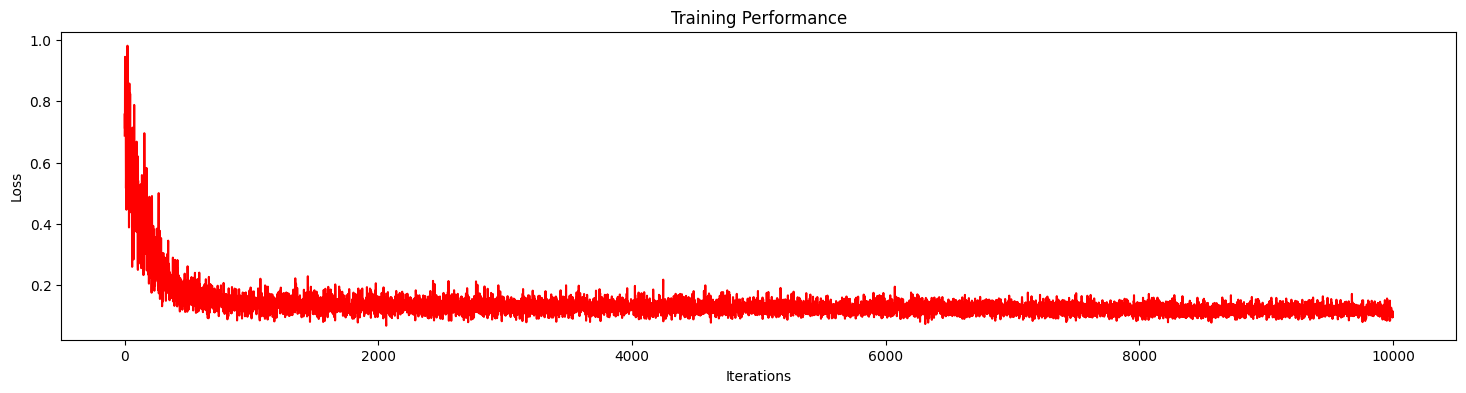

Eval for 25:   0%|          | 0/25 [00:00<?, ?it/s]

Eval for 25:   4%|▍         | 1/25 [00:11<04:35, 11.49s/it]

Eval for 25:   8%|▊         | 2/25 [00:12<02:08,  5.60s/it]

Eval for 25:  12%|█▏        | 3/25 [00:14<01:20,  3.65s/it]

Eval for 25:  16%|█▌        | 4/25 [00:15<00:57,  2.74s/it]

Eval for 25:  20%|██        | 5/25 [00:16<00:44,  2.23s/it]

Eval for 25:  24%|██▍       | 6/25 [00:18<00:37,  1.96s/it]

Eval for 25:  28%|██▊       | 7/25 [00:19<00:31,  1.76s/it]

Eval for 25:  32%|███▏      | 8/25 [00:21<00:27,  1.63s/it]

Eval for 25:  36%|███▌      | 9/25 [00:22<00:24,  1.55s/it]

Eval for 25:  40%|████      | 10/25 [00:23<00:22,  1.51s/it]

Eval for 25:  44%|████▍     | 11/25 [00:25<00:20,  1.46s/it]

Eval for 25:  48%|████▊     | 12/25 [00:26<00:18,  1.45s/it]

Eval for 25:  52%|█████▏    | 13/25 [00:28<00:17,  1.42s/it]

Eval for 25:  56%|█████▌    | 14/25 [00:29<00:15,  1.41s/it]

Eval for 25:  60%|██████    | 15/25 [00:30<00:14,  1.41s/it]

Eval for 25:  64%|██████▍   | 16/25 [00:32<00:12,  1.38s/it]

Eval for 25:  68%|██████▊   | 17/25 [00:33<00:10,  1.37s/it]

Eval for 25:  72%|███████▏  | 18/25 [00:34<00:09,  1.35s/it]

Eval for 25:  76%|███████▌  | 19/25 [00:36<00:08,  1.38s/it]

Eval for 25:  80%|████████  | 20/25 [00:37<00:06,  1.35s/it]

Eval for 25:  84%|████████▍ | 21/25 [00:38<00:05,  1.35s/it]

Eval for 25:  88%|████████▊ | 22/25 [00:40<00:03,  1.33s/it]

Eval for 25:  92%|█████████▏| 23/25 [00:41<00:02,  1.35s/it]

Eval for 25:  96%|█████████▌| 24/25 [00:42<00:01,  1.35s/it]

Eval for 25: 100%|██████████| 25/25 [00:44<00:00,  1.34s/it]

Eval for 25: 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]

In [12]:
def train():
  with strategy.scope():
    loss = sim.train()
    sim.plot_performance(loss)
    sim.eval_metrics(25)
# Uncomment this for a new run to remove previously saved policies and checkpoints
sim.clear_directories()
train()

In [13]:
with strategy.scope():
    sim.load_and_eval_policy(policy_path=MODELS_PATH)

Eval for 25:   0%|          | 0/25 [00:00<?, ?it/s]

Eval for 25:   4%|▍         | 1/25 [00:01<00:41,  1.72s/it]

Eval for 25:   8%|▊         | 2/25 [00:03<00:34,  1.50s/it]

Eval for 25:  12%|█▏        | 3/25 [00:04<00:32,  1.46s/it]

Eval for 25:  16%|█▌        | 4/25 [00:05<00:29,  1.39s/it]

Eval for 25:  20%|██        | 5/25 [00:07<00:27,  1.37s/it]

Eval for 25:  24%|██▍       | 6/25 [00:08<00:26,  1.37s/it]

Eval for 25:  28%|██▊       | 7/25 [00:09<00:24,  1.37s/it]

Eval for 25:  32%|███▏      | 8/25 [00:11<00:23,  1.37s/it]

Eval for 25:  36%|███▌      | 9/25 [00:12<00:21,  1.36s/it]

Eval for 25:  40%|████      | 10/25 [00:13<00:20,  1.37s/it]

Eval for 25:  44%|████▍     | 11/25 [00:15<00:19,  1.37s/it]

Eval for 25:  48%|████▊     | 12/25 [00:16<00:17,  1.38s/it]

Eval for 25:  52%|█████▏    | 13/25 [00:18<00:16,  1.36s/it]

Eval for 25:  56%|█████▌    | 14/25 [00:19<00:15,  1.39s/it]

Eval for 25:  60%|██████    | 15/25 [00:20<00:13,  1.38s/it]

Eval for 25:  64%|██████▍   | 16/25 [00:22<00:12,  1.41s/it]

Eval for 25:  68%|██████▊   | 17/25 [00:23<00:11,  1.39s/it]

Eval for 25:  72%|███████▏  | 18/25 [00:24<00:09,  1.37s/it]

Eval for 25:  76%|███████▌  | 19/25 [00:26<00:08,  1.39s/it]

Eval for 25:  80%|████████  | 20/25 [00:27<00:07,  1.40s/it]

Eval for 25:  84%|████████▍ | 21/25 [00:29<00:05,  1.39s/it]

Eval for 25:  88%|████████▊ | 22/25 [00:30<00:04,  1.37s/it]

Eval for 25:  92%|█████████▏| 23/25 [00:32<00:02,  1.41s/it]

Eval for 25:  96%|█████████▌| 24/25 [00:33<00:01,  1.40s/it]

Eval for 25: 100%|██████████| 25/25 [00:34<00:00,  1.40s/it]

Eval for 25: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

Average Return = -0.4159027934074402, Total Return = -1.0, Sharpe = -0.8671818375587463


In [14]:
test_env.get_trade_stats()

{'Annualized Return': 0.08037565358057806,
 'Annualized Vol': 0.5327752235074609,
 'Sharpe Ratio': 0.05927596580709699,
 'Downside Deviation': 0.36637039877343286,
 'Sortino Ratio': 0.00034205956635066734,
 'Max Drawdown': 0.0,
 'Max Drawdown Days': 672,
 'Trade Churn': 0.0,
 'Skewness': 0.5699760228074306,
 'Kurtosis': 5.441197183719924}

# Metrics

Compared the the paper's benchmarks and their TQDM architecture, we did better with our Tensorflow setup and architecture (we took a guess at some hyper params), with the exception of the Sortino ratio:

| Metric                 | Ours                   | B&H               | S&H              | TF                | MR               | TDQN             | 
|------------------------|------------------------|-------------------|------------------|-------------------|------------------|------------------|
| Annualized Return      | 41.58%                 | 24.11%            | -7.38%           | -100.00%          | 19.02%           | 12.80%           | 
| Annualized Vol         | 52.65%                 | 53.14%            | 46.11%           | 52.70%            | 58.05%           | 52.09%           | 
| Sharpe Ratio           | 0.697                  | 0.508             | -0.154           | -0.987            | 0.358            | 0.261            | 
| Sortino Ratio          | 0.0042                 | 0.741             | -0.205           | -1.229            | 0.539            | 0.359            | 
| Max Drawdown           | 0.00%                  | 52.83%            | 54.09%           | 79.91%            | 65.31%           | 58.95%           | 
| Max Drawdown Days      | 261                    | 205               | 144              | 229               | 159              | 331              | 
| Trade Churn            | 0.00%                  | -                 | -                | -                 | -                | -                | 
| Skewness               | 0.719                  | -                 | -                | -                 | -                | -                | 
| Kurtosis               | 5.448                  | -                 | -                | -                 | -                | -                | 


Live episode started...


Steps executed: 0it [00:00, ?it/s]

Steps executed: 9it [00:00, 88.51it/s]

Steps executed: 32it [00:00, 169.00it/s]

Steps executed: 55it [00:00, 194.76it/s]

Steps executed: 78it [00:00, 208.33it/s]

Steps executed: 100it [00:00, 211.04it/s]

Steps executed: 124it [00:00, 220.25it/s]

Steps executed: 147it [00:00, 221.70it/s]

Steps executed: 170it [00:00, 220.41it/s]

Steps executed: 193it [00:00, 221.29it/s]

Steps executed: 218it [00:01, 227.43it/s]

Steps executed: 242it [00:01, 228.76it/s]

Steps executed: 265it [00:01, 224.41it/s]

Steps executed: 288it [00:01, 225.49it/s]

Steps executed: 312it [00:01, 228.34it/s]

Steps executed: 337it [00:01, 232.74it/s]

Steps executed: 361it [00:01, 232.79it/s]

Steps executed: 385it [00:01, 234.10it/s]

Steps executed: 410it [00:01, 237.62it/s]

Steps executed: 434it [00:01, 235.80it/s]

Steps executed: 459it [00:02, 237.17it/s]

Steps executed: 471it [00:02, 223.74it/s]

...Live episode finished


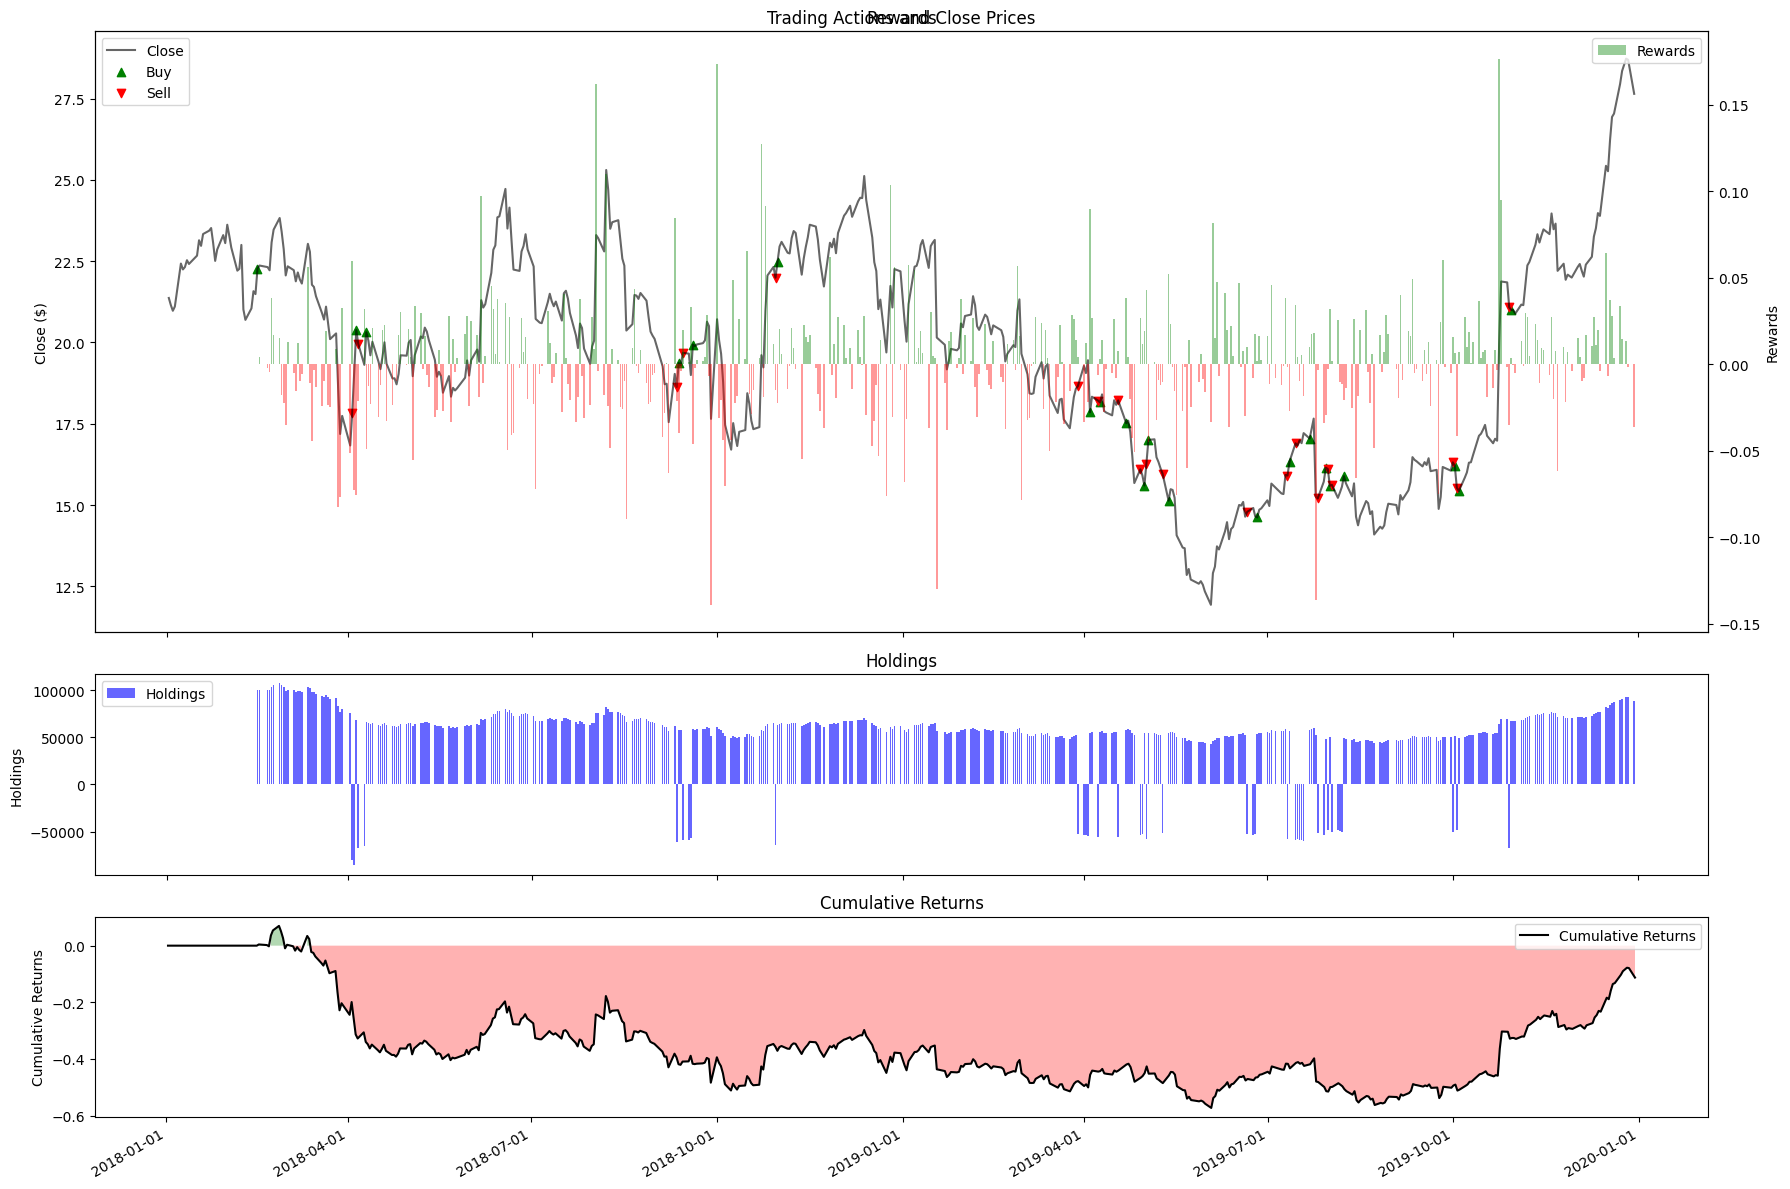

In [15]:
data = sim.plot_returns_and_actions()

In [16]:
data

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_HIST,MACD_SIG,ATR,...,Sharpe,Position,Action,Holdings,Cash,Money,Returns,Reward,Cumulative_Returns,Rewards
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.515557,0.544705,0.537416,0.561813,21.368668,0.060499,-0.040477,-0.119077,0.078601,0.582232,...,0.0,0,2,0.000000,100000.000000,100000.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,0.551004,0.557334,0.555663,0.548796,21.150000,0.065928,-0.058835,-0.109949,0.051113,0.586834,...,0.0,0,2,0.000000,100000.000000,100000.000000,0.000000,0.000000,0.000000,0.000000
2018-01-04,0.518984,0.530387,0.516081,0.538358,20.974667,0.239888,-0.086535,-0.110118,0.023584,0.606203,...,0.0,0,2,0.000000,100000.000000,100000.000000,0.000000,0.000000,0.000000,0.000000
2018-01-05,0.533753,0.525118,0.541426,0.546136,21.105333,0.068163,-0.096827,-0.096328,-0.000498,0.587855,...,0.0,0,2,0.000000,100000.000000,100000.000000,0.000000,0.000000,0.000000,0.000000
2018-01-08,0.531312,0.604674,0.555462,0.624836,22.427334,0.237102,0.001672,0.001736,-0.000064,0.648342,...,0.0,0,2,0.000000,100000.000000,100000.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.908547,0.946507,0.934432,0.953487,27.948000,0.348062,1.430910,0.395042,1.035868,0.775349,...,0.0,1,2,89685.131853,10.989943,89696.121796,0.033601,0.033601,-0.103039,0.033601
2019-12-24,0.934462,0.960423,0.945220,0.977418,28.350000,0.179229,1.562356,0.421191,1.141165,0.780824,...,0.0,1,2,90975.151224,10.989943,90986.141167,0.014382,0.014382,-0.090139,0.014382
2019-12-26,0.972076,0.992640,1.000000,1.000000,28.729334,0.261938,1.677797,0.429305,1.248492,0.764242,...,0.0,1,2,92192.432413,10.989943,92203.422356,0.013379,0.013379,-0.077966,0.013379


# Results with Experiments

| Metric                 | Ours - Base            | Experiment 1         | Experiment 2         | Experiment 3         | B&H               | S&H              | TF                | MR               | TDQN             | 
|------------------------|------------------------|----------------------|----------------------|----------------------|-------------------|------------------|-------------------|------------------|------------------|
| Annualized Return      | 41.58%                 | 27.96%               | -10.35%              | 67.92%               | 24.11%            | -7.38%           | -100.00%          | 19.02%           | 12.80%           | 
| Annualized Vol         | 52.65%                 | 53.11%               | 51.86%               | 52.11%               | 53.14%            | 46.11%           | 52.70%            | 58.05%           | 52.09%           | 
| Sharpe Ratio           | 0.697                  | 0.434                | -0.294               | 1.210                | 0.508             | -0.154           | -0.987            | 0.358            | 0.261            | 
| Sortino Ratio          | 0.0042                 | 0.0025               | -0.0016              | 0.0071               | 0.741             | -0.205           | -1.229            | 0.539            | 0.359            | 
| Max Drawdown           | 0.00%                  | 0.00%                | 0.00%                | 0.00%                | 52.83%            | 54.09%           | 79.91%            | 65.31%           | 58.95%           | 
| Max Drawdown Days      | 261                    | 361                  | 518                  | 238                  | 205               | 144              | 229               | 159              | 331              | 
| Trade Churn            | 0.00%                  | 0.00%                | 0.00%                | 0.00%                | -                 | -                | -                 | -                | -                | 
| Skewness               | 0.719                  | 0.567                | 0.208                | 0.539                | -                 | -                | -                 | -                | -                | 
| Kurtosis               | 5.448                  | 5.433                | 5.391                | 5.349                | -                 | -                | -                 | -                | -                | 


# Conclusion

In this article we have adapted Deep Q-Network (TDQN) algorithm from *Théate, Thibaut and Ernst, Damien (2021)*, using our signals and Tensorflow's Agent framework. Our agent can now determine optimal trading positions (buy, sell, or hold) to maximize our portfolio returns in a simulated environment.

## References

- [A Random Walk Down Wall Street](https://www.amazon.co.uk/Random-Walk-Down-Wall-Street/dp/0393330338)
- [TensorFlow Agents](https://www.tensorflow.org/agents/overview)
- [Open Gym AI Github](https://github.com/openai/gym)
- [Greg et al, OpenAI Gym, (2016)](https://arxiv.org/abs/1606.01540)
- [Théate, Thibaut, and Damien Ernst. "An application of deep reinforcement learning to algorithmic trading." Expert Systems with Applications 173 (2021): 114632.](https://www.sciencedirect.com/science/article/pii/S0957417421000737)
- [Remote development in WSL](https://code.visualstudio.com/docs/remote/wsl-tutorial)
- [NVIDIA Driver Downloads](https://www.nvidia.com/Download/index.aspx)
- [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit-archive)
- [TensorRT for CUDA](https://docs.nvidia.com/deeplearning/tensorrt/archives/index.html#trt_7)
- [Momentum and Reversion Trading Signals Analysis](https://medium.com/call-for-atlas/momentum-and-reversion-the-poor-mans-trading-strategies-9b8e1e6d3496)
- [Temporal Convolutional Neural Network with Conditioning for Broad Market Signals](https://medium.com/call-for-atlas/temporal-convolutional-neural-network-with-conditioning-for-broad-market-signals-9f0b0426b2b9)
- [Pandas TA - A Technical Analysis Library in Python 3](https://github.com/twopirllc/pandas-ta)

## Github

Article and code available on [Github](https://github.com/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/deep-q-rl-with-algorithmic-trading-policy)

Google Collab available [here](https://colab.research.google.com/drive/1FTj65b2DA8oFgvmmjLc0XIwtII32PwcM?usp=sharing)

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.